In [18]:
import numpy as np
import pandas as pd
import json 
import umap

In [10]:
# import utility functions 
from ret import read_data # utility func to load data
from ret import get_id_from_info # utility func to return id by entering song's info
from ret import display_res # utility func to display results 
from ret import get_genre #utility func to get the genres from a list of id´s
from ret import get_genre_from_query #utility func to get the id and genre from the query
from ret import get_genre_from_ids #utility func to get the id and genre from the retrieved results
from ret import generate_cos_sim_matrix

# import the retrieval systems 
from ret import random_baseline # baseline retrieval system that returns random results 
from ret import text_based # modularized text based retrieval system
from ret import audio_based # modularized audio based retrieval system
from ret import video_based # modularized video based retrieval system

# import wrapper function to calculate cosine similarity
from ret import cos_sim 

# import evaluation functions 
from ret import gen_cov_10
from ret import ndcg_score
from ret import gen_div_10
from ret import calculate_precision_at_k
#from ret import calculate_recall_at_k
from ret import plot_precision_recall_curve
from ret import get_avg_recall_at_k
from ret import get_avg_precision_at_k

In [11]:
"""
Please put data files in ""./data/" before use 
"""

info = read_data("information")
genres = read_data("genres")

# text embeddings 
tfidf = read_data("lyrics_tf-idf")
word2vec = read_data("lyrics_word2vec")
bert = read_data("lyrics_bert")

# audio embeddings
blf_correlation = read_data("blf_correlation")
ivec256 = read_data("ivec256")
mfcc_stats = read_data("mfcc_stats")
musicnn = read_data("musicnn")

# video embeddings
vgg19 = read_data("vgg19")
ResNet = read_data("resnet")


In [12]:
song_ids = info['id'].tolist()

In [32]:
#df = pd.merge(df, genres, on='id')
# Erstellen Sie ein leeres Array aus Sets
def get_relevancy_count(genre_query,genre_other_songs):
    array = change_list_to_sets(genre_other_songs)

    #print("Das Array aus Sets ist fertig")
    #print(array)



    # Initialize a counter
    count = 0

    #print("Loop through the list of sets")
    '''Try for better performance# Erstellen Sie eine neue Liste mit 1 für jedes Element, das die Bedingung erfüllt
    newlist = [1 for s in array if genre_query.intersection(s)]

    # Berechnen Sie die Summe der neuen Liste, um den Zähler zu erhalten
    count = sum(newlist)
    '''
    for s in array:
        # Check if the intersection is not empty
        if genre_query.intersection(s):#
        # Increment the counter
            count += 1

     #print("done")
    #print(count) # 1
    return count

In [31]:
def change_list_to_sets(list):
    array = []
    # Iterieren Sie über die Spalte in Ihrem DataF
    ''' probieren für mehr performance def change_list_to_sets(list):
    # Wandeln Sie die Liste von Strings in eine Liste von Sets um
    return [change_to_set(s) for s in list]
    '''
    for s in list:
        s =change_to_set(s)
        # Fügen Sie das Set zum Array hinzu
        array.append(s)
    return array

In [33]:
def change_to_set(s):
    # Wandeln Sie den String in eine Liste von Genres um
    l = s.strip("[]").split(",")
    # Entfernen Sie die Anführungszeichen um jedes Genre
    l = [g.strip("'") for g in l]
    # Wandeln Sie die Liste in ein Set um
    s = set(l)
    return s

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from concurrent.futures import ProcessPoolExecutor

def calc_recall_precision(query, df, k):
    # Sort the other tracks by their similarity scores in descending order and get genres
    ranked_list = df.sort_values(by=query, ascending=False).genre.to_list()

    # Select the top k tracks from the ranked list
    retrieved_list = ranked_list[1:k + 1]

    # Get the genre of the query track
    query_genre = genres[genres['id'] == query]['genre'].iloc[0]
    query_genre = change_to_set(query_genre)

    # Get genres as a set of top k tracks
    top_k_genre = change_list_to_sets(retrieved_list)

    # Get count of all relevant tracks in the dataset
    all_relevant = get_relevancy_count(query_genre, df['genre'])

    # Get count of all relevant tracks in top k
    k_relevant = get_relevancy_count(query_genre, retrieved_list)

    recall = k_relevant / all_relevant
    precision = k_relevant / k

    return precision, recall


In [9]:
cosine_similarity_matrix = generate_cos_sim_matrix(blf_correlation)
cosine_similarity_matrix = pd.merge(cosine_similarity_matrix, genres, on='id')

(10094, 1327)


C:\Users\Sara\Documents\GitHub\MMSR\project_3_team_E\ret.py:594: RuntimeWarning: invalid value encountered in divide
  cos_sim_matrix = np.triu(embedding_matrix.dot(embedding_transpose) / (np.linalg.norm(embedding_matrix, axis=1) * np.linalg.norm(embedding_matrix, axis=1)[:, None]))


# Plot for Text, Audio and Video-Based features

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def calc_avg_recall_precision(embeddings_list, k_values, sample_size):
    for embedding, embedding_name in zip(embeddings_list, ['tfidf', 'word2vec', 'bert', 'mfcc_stats', 'ivec256', 'blf_correlation', 'musicnn','vgg19']):
        print(f"Calculating for embedding: {embedding_name}")
        # Generate cosine similarity matrix for the current embedding
        cosine_similarity_matrix = generate_cos_sim_matrix(embedding)
        cosine_similarity_matrix = pd.merge(cosine_similarity_matrix, genres, on='id')

        precision_scores = []
        recall_scores = []

        # Sample a subset of queries
        sampled_queries = np.random.choice(embedding['id'], size=sample_size, replace=False)

        for k in k_values:
            results = []
            for query in sampled_queries:
                precision, recall = calc_recall_precision(query, cosine_similarity_matrix, k)
                results.append((precision, recall))
                print(f"Processed query {query} for k={k} - Precision: {precision:.2f}, Recall: {recall:.2f}")

            # Unpack results
            precision_values, recall_values = zip(*results)

            # Calculate the average precision and recall over all sampled query tracks for the current k
            avg_precision = np.mean(precision_values)
            avg_recall = np.mean(recall_values)

            precision_scores.append(avg_precision)
            recall_scores.append(avg_recall)

            print(f"Avg Precision at k={k}: {avg_precision:.2f}, Avg Recall at k={k}: {avg_recall:.2f}\n")

        # Plot the precision-recall curve for the current embedding
        plt.plot(precision_scores, recall_scores, label=f'Embedding \'{embedding_name}\'')  # Add single quotes around the name

    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    return precision_scores, recall_scores



Calculating for embedding: tfidf
(10095, 1001)
Processed query 5ls2yihhqTvxIcvY for k=1 - Precision: 1.00, Recall: 0.00
Processed query kMnS9SSJA3WP6sIb for k=1 - Precision: 0.00, Recall: 0.00
Processed query C3HBu2KV2wuxj2IV for k=1 - Precision: 0.00, Recall: 0.00
Processed query Q95aQPOvkD3vIaW6 for k=1 - Precision: 0.00, Recall: 0.00
Processed query bwF6WFgG72FvarGJ for k=1 - Precision: 0.00, Recall: 0.00
Processed query nRdn5FeEE4PeEwKO for k=1 - Precision: 0.00, Recall: 0.00
Processed query aTsbpksug9vaBIMA for k=1 - Precision: 0.00, Recall: 0.00
Processed query TVH1r75HzcWGyt3m for k=1 - Precision: 0.00, Recall: 0.00
Processed query pW1ZswDOl6bUeJhz for k=1 - Precision: 1.00, Recall: 0.00
Processed query dceR6NFMjNf3ppZg for k=1 - Precision: 0.00, Recall: 0.00
Processed query fktaMmy1ASpnISwK for k=1 - Precision: 0.00, Recall: 0.00
Processed query Gth03dpW3NAXMb65 for k=1 - Precision: 1.00, Recall: 0.00
Processed query ONysRKGk3jzj80x8 for k=1 - Precision: 0.00, Recall: 0.00
Proc

Processed query Gth03dpW3NAXMb65 for k=2 - Precision: 0.50, Recall: 0.00
Processed query ONysRKGk3jzj80x8 for k=2 - Precision: 0.00, Recall: 0.00
Processed query eU30OjpKt9zzV6R6 for k=2 - Precision: 0.00, Recall: 0.00
Processed query tZt6MtqaTOYcwTph for k=2 - Precision: 0.00, Recall: 0.00
Processed query Ean51nFV0pE39NhE for k=2 - Precision: 1.00, Recall: 0.00
Processed query bg1NLY9b6V2YuAXT for k=2 - Precision: 0.00, Recall: 0.00
Processed query LE0isUFIeLTqqstc for k=2 - Precision: 0.00, Recall: 0.00
Processed query WLin1wjxEOQiE6Gl for k=2 - Precision: 0.00, Recall: 0.00
Processed query hzro8A2xxNRBXahj for k=2 - Precision: 0.00, Recall: 0.00
Processed query JzlmKozfo1gqumlu for k=2 - Precision: 0.00, Recall: 0.00
Processed query aiuvUwRAOt3htd5C for k=2 - Precision: 0.00, Recall: 0.00
Processed query CVvhNAqsS6Jw0fMr for k=2 - Precision: 0.00, Recall: 0.00
Processed query Ty6OgF440UYuAJbI for k=2 - Precision: 0.00, Recall: 0.00
Processed query BRmRz8PpBvUEqKMB for k=2 - Precisio

Processed query Ty6OgF440UYuAJbI for k=3 - Precision: 0.00, Recall: 0.00
Processed query BRmRz8PpBvUEqKMB for k=3 - Precision: 0.00, Recall: 0.00
Processed query QgCSYJwimIpcmd75 for k=3 - Precision: 0.00, Recall: 0.00
Processed query keL0GM4Vis6abtHQ for k=3 - Precision: 0.67, Recall: 0.00
Processed query 5W4DjCHYvXqARfRx for k=3 - Precision: 0.00, Recall: 0.00
Processed query htmgabdgLy99IU32 for k=3 - Precision: 0.67, Recall: 0.00
Processed query AsRYw9Guh2y25Tvn for k=3 - Precision: 1.00, Recall: 0.00
Processed query SWtKxpxBo87gIcn3 for k=3 - Precision: 0.00, Recall: 0.00
Processed query aui0FvvvRh0v0xSG for k=3 - Precision: 0.33, Recall: 0.00
Processed query EOQc7sz473eJbdFj for k=3 - Precision: 1.00, Recall: 0.00
Processed query kofCEetOZo7Lb9Sg for k=3 - Precision: 0.33, Recall: 0.00
Processed query zJozzftwVRSZt9wd for k=3 - Precision: 0.00, Recall: 0.00
Processed query snEdkfqJkRlQieGj for k=3 - Precision: 0.33, Recall: 0.00
Processed query 3fuOrQt9qqGmPNQY for k=3 - Precisio

Processed query snEdkfqJkRlQieGj for k=4 - Precision: 0.25, Recall: 0.00
Processed query 3fuOrQt9qqGmPNQY for k=4 - Precision: 0.25, Recall: 0.00
Processed query AZ0PqJwsbTiGOVS8 for k=4 - Precision: 0.75, Recall: 0.00
Processed query 3aJOLQZy4JTPbhMF for k=4 - Precision: 0.00, Recall: 0.00
Processed query TjodKAmQhydtoVEE for k=4 - Precision: 0.50, Recall: 0.00
Processed query Wjce73WdQB0iCY4O for k=4 - Precision: 0.25, Recall: 0.00
Processed query 1Ja8XIAKcty45QCs for k=4 - Precision: 0.50, Recall: 0.00
Processed query qfdGKqj2QIuogYbc for k=4 - Precision: 0.00, Recall: 0.00
Processed query P0akl7avLWycsbUp for k=4 - Precision: 0.50, Recall: 0.00
Processed query zXcaCZoKnWbu9HQF for k=4 - Precision: 0.75, Recall: 0.00
Processed query XFHsDXxIXN7gvNDb for k=4 - Precision: 0.25, Recall: 0.02
Processed query AKNCyTF07aLc9AiR for k=4 - Precision: 0.25, Recall: 0.00
Processed query k1Nap3pGm1zeOQSK for k=4 - Precision: 0.25, Recall: 0.00
Processed query lCxXICvhos2eQEHq for k=4 - Precisio

Processed query k1Nap3pGm1zeOQSK for k=5 - Precision: 0.20, Recall: 0.00
Processed query lCxXICvhos2eQEHq for k=5 - Precision: 0.40, Recall: 0.00
Processed query UuYikG5A6p3Np4AE for k=5 - Precision: 0.20, Recall: 0.00
Processed query Slul5Rch87uajaIf for k=5 - Precision: 0.60, Recall: 0.00
Processed query 0msRtMDKZpd0neIK for k=5 - Precision: 0.00, Recall: 0.00
Processed query eY0DOciiMzN5wwkA for k=5 - Precision: 0.40, Recall: 0.00
Processed query xcWYLAbgy0udCFmC for k=5 - Precision: 0.00, Recall: 0.00
Processed query 0Imk5d70hyWT3a3Q for k=5 - Precision: 0.40, Recall: 0.00
Processed query EeipMx7HWhlB5l6F for k=5 - Precision: 0.40, Recall: 0.00
Processed query GX2ioTwjLPBWPFwA for k=5 - Precision: 0.20, Recall: 0.00
Processed query KgpoeCAcHHJg0mRv for k=5 - Precision: 0.40, Recall: 0.00
Processed query IDD6tfIaWcpzJcUJ for k=5 - Precision: 0.20, Recall: 0.00
Processed query njGBA6t0wrejlsNq for k=5 - Precision: 0.60, Recall: 0.00
Processed query acXQK7PHbHaPNdSK for k=5 - Precisio

Processed query njGBA6t0wrejlsNq for k=6 - Precision: 0.50, Recall: 0.00
Processed query acXQK7PHbHaPNdSK for k=6 - Precision: 0.33, Recall: 0.00
Processed query 8ZGTcZkH9dGHYgvG for k=6 - Precision: 0.00, Recall: 0.00
Processed query BBaha1obZecGL5TC for k=6 - Precision: 0.83, Recall: 0.00
Processed query sYw9fcqJkrPOhFAD for k=6 - Precision: 0.33, Recall: 0.00
Processed query B1lyywM06zQO9aC3 for k=6 - Precision: 0.50, Recall: 0.00
Processed query nPOUMO7w5JwQ3Orc for k=6 - Precision: 0.33, Recall: 0.00
Processed query Q0FuvjirjmMi2Xy4 for k=6 - Precision: 0.67, Recall: 0.00
Processed query nExcxeNNUtIYPem5 for k=6 - Precision: 0.17, Recall: 0.00
Processed query 6azV4gvBv1aPSQuL for k=6 - Precision: 1.00, Recall: 0.00
Processed query eKvBpVGoj2oVm501 for k=6 - Precision: 0.50, Recall: 0.00
Processed query Jx9BUH45ctES4QYy for k=6 - Precision: 0.50, Recall: 0.00
Processed query kUyu4mGZTeLvT4OH for k=6 - Precision: 0.67, Recall: 0.00
Processed query p8WEwJQIknhPar62 for k=6 - Precisio

Processed query kUyu4mGZTeLvT4OH for k=7 - Precision: 0.71, Recall: 0.00
Processed query p8WEwJQIknhPar62 for k=7 - Precision: 0.71, Recall: 0.00
Processed query fyUchDqW0ff1RROj for k=7 - Precision: 0.14, Recall: 0.01
Processed query HgXTG8u7e6uVIw1r for k=7 - Precision: 0.43, Recall: 0.00
Processed query yiXxPFTtVIzPHdZh for k=7 - Precision: 0.00, Recall: 0.00
Processed query HA7XNWwLQZuF6Hjc for k=7 - Precision: 0.00, Recall: 0.00
Processed query StYuywoB4qpiTPRk for k=7 - Precision: 0.14, Recall: 0.00
Processed query z4pfNCH1xUBerW1h for k=7 - Precision: 0.29, Recall: 0.00
Processed query Z1JKiEhjHKhOaLNG for k=7 - Precision: 0.43, Recall: 0.00
Processed query 9CuEQRYVaaGpgOGn for k=7 - Precision: 0.00, Recall: 0.00
Processed query qJBf7HT51lPnKjEd for k=7 - Precision: 0.29, Recall: 0.00
Processed query vzd0iaf05QC1Tt8O for k=7 - Precision: 0.29, Recall: 0.00
Processed query d618DJDa20Gj5hP1 for k=7 - Precision: 0.43, Recall: 0.00
Processed query GbmXX6v70dK9SXjr for k=7 - Precisio

Processed query d618DJDa20Gj5hP1 for k=8 - Precision: 0.50, Recall: 0.00
Processed query GbmXX6v70dK9SXjr for k=8 - Precision: 0.75, Recall: 0.00
Processed query Z1puf19RRObqRc0h for k=8 - Precision: 0.38, Recall: 0.00
Processed query DrLavv9yMq0YHLcV for k=8 - Precision: 0.12, Recall: 0.00
Processed query th2KsLdsoPRLzYh8 for k=8 - Precision: 0.25, Recall: 0.00
Processed query jtKw1863k4rGKrdQ for k=8 - Precision: 0.88, Recall: 0.00
Processed query L2GriWeUOiBcGzdK for k=8 - Precision: 0.75, Recall: 0.00
Processed query y0vmwpSdsrkROj9m for k=8 - Precision: 0.50, Recall: 0.00
Processed query qUbKjC17TpHOFZkJ for k=8 - Precision: 0.38, Recall: 0.00
Processed query tbfBvx4x11y3Ab95 for k=8 - Precision: 0.25, Recall: 0.00
Processed query 0RswMLgk4KS4GbIP for k=8 - Precision: 0.12, Recall: 0.00
Processed query 1nhSgP8dR5O8xEKg for k=8 - Precision: 0.12, Recall: 0.00
Processed query dKAY5NTPo5hXQE9t for k=8 - Precision: 0.00, Recall: 0.00
Processed query lo8hxpp6eGgLX3Ai for k=8 - Precisio

Processed query dKAY5NTPo5hXQE9t for k=9 - Precision: 0.00, Recall: 0.00
Processed query lo8hxpp6eGgLX3Ai for k=9 - Precision: 0.22, Recall: 0.00
Processed query IrS0oGml5voPOJmI for k=9 - Precision: 0.67, Recall: 0.00
Processed query VDoXHlXcApgcp1Qz for k=9 - Precision: 0.67, Recall: 0.00
Processed query jorQx4KoKoRpYxmm for k=9 - Precision: 0.44, Recall: 0.00
Avg Precision at k=9: 0.33, Avg Recall at k=9: 0.00

Processed query 5ls2yihhqTvxIcvY for k=10 - Precision: 0.50, Recall: 0.00
Processed query kMnS9SSJA3WP6sIb for k=10 - Precision: 0.40, Recall: 0.00
Processed query C3HBu2KV2wuxj2IV for k=10 - Precision: 0.10, Recall: 0.00
Processed query Q95aQPOvkD3vIaW6 for k=10 - Precision: 0.50, Recall: 0.00
Processed query bwF6WFgG72FvarGJ for k=10 - Precision: 0.40, Recall: 0.00
Processed query nRdn5FeEE4PeEwKO for k=10 - Precision: 0.10, Recall: 0.00
Processed query aTsbpksug9vaBIMA for k=10 - Precision: 0.20, Recall: 0.00
Processed query TVH1r75HzcWGyt3m for k=10 - Precision: 0.30, Rec

Processed query nRdn5FeEE4PeEwKO for k=11 - Precision: 0.09, Recall: 0.00
Processed query aTsbpksug9vaBIMA for k=11 - Precision: 0.18, Recall: 0.00
Processed query TVH1r75HzcWGyt3m for k=11 - Precision: 0.27, Recall: 0.00
Processed query pW1ZswDOl6bUeJhz for k=11 - Precision: 0.64, Recall: 0.00
Processed query dceR6NFMjNf3ppZg for k=11 - Precision: 0.55, Recall: 0.00
Processed query fktaMmy1ASpnISwK for k=11 - Precision: 0.09, Recall: 0.00
Processed query Gth03dpW3NAXMb65 for k=11 - Precision: 0.73, Recall: 0.00
Processed query ONysRKGk3jzj80x8 for k=11 - Precision: 0.00, Recall: 0.00
Processed query eU30OjpKt9zzV6R6 for k=11 - Precision: 0.00, Recall: 0.00
Processed query tZt6MtqaTOYcwTph for k=11 - Precision: 0.09, Recall: 0.00
Processed query Ean51nFV0pE39NhE for k=11 - Precision: 0.45, Recall: 0.00
Processed query bg1NLY9b6V2YuAXT for k=11 - Precision: 0.00, Recall: 0.00
Processed query LE0isUFIeLTqqstc for k=11 - Precision: 0.00, Recall: 0.00
Processed query WLin1wjxEOQiE6Gl for k

Processed query Ean51nFV0pE39NhE for k=12 - Precision: 0.50, Recall: 0.00
Processed query bg1NLY9b6V2YuAXT for k=12 - Precision: 0.00, Recall: 0.00
Processed query LE0isUFIeLTqqstc for k=12 - Precision: 0.00, Recall: 0.00
Processed query WLin1wjxEOQiE6Gl for k=12 - Precision: 0.17, Recall: 0.00
Processed query hzro8A2xxNRBXahj for k=12 - Precision: 0.42, Recall: 0.00
Processed query JzlmKozfo1gqumlu for k=12 - Precision: 0.33, Recall: 0.00
Processed query aiuvUwRAOt3htd5C for k=12 - Precision: 0.00, Recall: 0.00
Processed query CVvhNAqsS6Jw0fMr for k=12 - Precision: 0.00, Recall: 0.00
Processed query Ty6OgF440UYuAJbI for k=12 - Precision: 0.00, Recall: 0.00
Processed query BRmRz8PpBvUEqKMB for k=12 - Precision: 0.08, Recall: 0.00
Processed query QgCSYJwimIpcmd75 for k=12 - Precision: 0.08, Recall: 0.00
Processed query keL0GM4Vis6abtHQ for k=12 - Precision: 0.50, Recall: 0.00
Processed query 5W4DjCHYvXqARfRx for k=12 - Precision: 0.50, Recall: 0.00
Processed query htmgabdgLy99IU32 for k

Processed query QgCSYJwimIpcmd75 for k=13 - Precision: 0.08, Recall: 0.00
Processed query keL0GM4Vis6abtHQ for k=13 - Precision: 0.54, Recall: 0.00
Processed query 5W4DjCHYvXqARfRx for k=13 - Precision: 0.54, Recall: 0.00
Processed query htmgabdgLy99IU32 for k=13 - Precision: 0.46, Recall: 0.00
Processed query AsRYw9Guh2y25Tvn for k=13 - Precision: 0.54, Recall: 0.00
Processed query SWtKxpxBo87gIcn3 for k=13 - Precision: 0.08, Recall: 0.00
Processed query aui0FvvvRh0v0xSG for k=13 - Precision: 0.23, Recall: 0.00
Processed query EOQc7sz473eJbdFj for k=13 - Precision: 0.62, Recall: 0.00
Processed query kofCEetOZo7Lb9Sg for k=13 - Precision: 0.23, Recall: 0.00
Processed query zJozzftwVRSZt9wd for k=13 - Precision: 0.00, Recall: 0.00
Processed query snEdkfqJkRlQieGj for k=13 - Precision: 0.46, Recall: 0.00
Processed query 3fuOrQt9qqGmPNQY for k=13 - Precision: 0.31, Recall: 0.00
Processed query AZ0PqJwsbTiGOVS8 for k=13 - Precision: 0.62, Recall: 0.00
Processed query 3aJOLQZy4JTPbhMF for k

Processed query snEdkfqJkRlQieGj for k=14 - Precision: 0.50, Recall: 0.00
Processed query 3fuOrQt9qqGmPNQY for k=14 - Precision: 0.36, Recall: 0.00
Processed query AZ0PqJwsbTiGOVS8 for k=14 - Precision: 0.64, Recall: 0.00
Processed query 3aJOLQZy4JTPbhMF for k=14 - Precision: 0.07, Recall: 0.00
Processed query TjodKAmQhydtoVEE for k=14 - Precision: 0.36, Recall: 0.00
Processed query Wjce73WdQB0iCY4O for k=14 - Precision: 0.14, Recall: 0.00
Processed query 1Ja8XIAKcty45QCs for k=14 - Precision: 0.14, Recall: 0.00
Processed query qfdGKqj2QIuogYbc for k=14 - Precision: 0.00, Recall: 0.00
Processed query P0akl7avLWycsbUp for k=14 - Precision: 0.50, Recall: 0.00
Processed query zXcaCZoKnWbu9HQF for k=14 - Precision: 0.57, Recall: 0.00
Processed query XFHsDXxIXN7gvNDb for k=14 - Precision: 0.14, Recall: 0.05
Processed query AKNCyTF07aLc9AiR for k=14 - Precision: 0.64, Recall: 0.00
Processed query k1Nap3pGm1zeOQSK for k=14 - Precision: 0.57, Recall: 0.00
Processed query lCxXICvhos2eQEHq for k

Processed query XFHsDXxIXN7gvNDb for k=15 - Precision: 0.13, Recall: 0.05
Processed query AKNCyTF07aLc9AiR for k=15 - Precision: 0.67, Recall: 0.00
Processed query k1Nap3pGm1zeOQSK for k=15 - Precision: 0.60, Recall: 0.00
Processed query lCxXICvhos2eQEHq for k=15 - Precision: 0.27, Recall: 0.00
Processed query UuYikG5A6p3Np4AE for k=15 - Precision: 0.07, Recall: 0.00
Processed query Slul5Rch87uajaIf for k=15 - Precision: 0.73, Recall: 0.00
Processed query 0msRtMDKZpd0neIK for k=15 - Precision: 0.20, Recall: 0.00
Processed query eY0DOciiMzN5wwkA for k=15 - Precision: 0.47, Recall: 0.00
Processed query xcWYLAbgy0udCFmC for k=15 - Precision: 0.00, Recall: 0.00
Processed query 0Imk5d70hyWT3a3Q for k=15 - Precision: 0.53, Recall: 0.00
Processed query EeipMx7HWhlB5l6F for k=15 - Precision: 0.20, Recall: 0.00
Processed query GX2ioTwjLPBWPFwA for k=15 - Precision: 0.40, Recall: 0.00
Processed query KgpoeCAcHHJg0mRv for k=15 - Precision: 0.33, Recall: 0.00
Processed query IDD6tfIaWcpzJcUJ for k

Processed query EeipMx7HWhlB5l6F for k=16 - Precision: 0.19, Recall: 0.00
Processed query GX2ioTwjLPBWPFwA for k=16 - Precision: 0.38, Recall: 0.00
Processed query KgpoeCAcHHJg0mRv for k=16 - Precision: 0.38, Recall: 0.00
Processed query IDD6tfIaWcpzJcUJ for k=16 - Precision: 0.12, Recall: 0.00
Processed query njGBA6t0wrejlsNq for k=16 - Precision: 0.50, Recall: 0.00
Processed query acXQK7PHbHaPNdSK for k=16 - Precision: 0.19, Recall: 0.00
Processed query 8ZGTcZkH9dGHYgvG for k=16 - Precision: 0.00, Recall: 0.00
Processed query BBaha1obZecGL5TC for k=16 - Precision: 0.62, Recall: 0.00
Processed query sYw9fcqJkrPOhFAD for k=16 - Precision: 0.50, Recall: 0.00
Processed query B1lyywM06zQO9aC3 for k=16 - Precision: 0.38, Recall: 0.00
Processed query nPOUMO7w5JwQ3Orc for k=16 - Precision: 0.19, Recall: 0.00
Processed query Q0FuvjirjmMi2Xy4 for k=16 - Precision: 0.44, Recall: 0.00
Processed query nExcxeNNUtIYPem5 for k=16 - Precision: 0.12, Recall: 0.00
Processed query 6azV4gvBv1aPSQuL for k

Processed query nPOUMO7w5JwQ3Orc for k=17 - Precision: 0.18, Recall: 0.00
Processed query Q0FuvjirjmMi2Xy4 for k=17 - Precision: 0.41, Recall: 0.00
Processed query nExcxeNNUtIYPem5 for k=17 - Precision: 0.12, Recall: 0.00
Processed query 6azV4gvBv1aPSQuL for k=17 - Precision: 0.65, Recall: 0.00
Processed query eKvBpVGoj2oVm501 for k=17 - Precision: 0.47, Recall: 0.00
Processed query Jx9BUH45ctES4QYy for k=17 - Precision: 0.59, Recall: 0.00
Processed query kUyu4mGZTeLvT4OH for k=17 - Precision: 0.76, Recall: 0.00
Processed query p8WEwJQIknhPar62 for k=17 - Precision: 0.35, Recall: 0.00
Processed query fyUchDqW0ff1RROj for k=17 - Precision: 0.06, Recall: 0.01
Processed query HgXTG8u7e6uVIw1r for k=17 - Precision: 0.65, Recall: 0.00
Processed query yiXxPFTtVIzPHdZh for k=17 - Precision: 0.12, Recall: 0.00
Processed query HA7XNWwLQZuF6Hjc for k=17 - Precision: 0.06, Recall: 0.00
Processed query StYuywoB4qpiTPRk for k=17 - Precision: 0.12, Recall: 0.00
Processed query z4pfNCH1xUBerW1h for k

Processed query yiXxPFTtVIzPHdZh for k=18 - Precision: 0.11, Recall: 0.00
Processed query HA7XNWwLQZuF6Hjc for k=18 - Precision: 0.06, Recall: 0.00
Processed query StYuywoB4qpiTPRk for k=18 - Precision: 0.11, Recall: 0.00
Processed query z4pfNCH1xUBerW1h for k=18 - Precision: 0.50, Recall: 0.00
Processed query Z1JKiEhjHKhOaLNG for k=18 - Precision: 0.39, Recall: 0.00
Processed query 9CuEQRYVaaGpgOGn for k=18 - Precision: 0.00, Recall: 0.00
Processed query qJBf7HT51lPnKjEd for k=18 - Precision: 0.11, Recall: 0.00
Processed query vzd0iaf05QC1Tt8O for k=18 - Precision: 0.22, Recall: 0.00
Processed query d618DJDa20Gj5hP1 for k=18 - Precision: 0.56, Recall: 0.00
Processed query GbmXX6v70dK9SXjr for k=18 - Precision: 0.44, Recall: 0.00
Processed query Z1puf19RRObqRc0h for k=18 - Precision: 0.28, Recall: 0.00
Processed query DrLavv9yMq0YHLcV for k=18 - Precision: 0.39, Recall: 0.00
Processed query th2KsLdsoPRLzYh8 for k=18 - Precision: 0.33, Recall: 0.00
Processed query jtKw1863k4rGKrdQ for k

Processed query Z1puf19RRObqRc0h for k=19 - Precision: 0.26, Recall: 0.00
Processed query DrLavv9yMq0YHLcV for k=19 - Precision: 0.37, Recall: 0.00
Processed query th2KsLdsoPRLzYh8 for k=19 - Precision: 0.32, Recall: 0.00
Processed query jtKw1863k4rGKrdQ for k=19 - Precision: 0.63, Recall: 0.00
Processed query L2GriWeUOiBcGzdK for k=19 - Precision: 0.53, Recall: 0.00
Processed query y0vmwpSdsrkROj9m for k=19 - Precision: 0.42, Recall: 0.00
Processed query qUbKjC17TpHOFZkJ for k=19 - Precision: 0.42, Recall: 0.00
Processed query tbfBvx4x11y3Ab95 for k=19 - Precision: 0.21, Recall: 0.00
Processed query 0RswMLgk4KS4GbIP for k=19 - Precision: 0.11, Recall: 0.01
Processed query 1nhSgP8dR5O8xEKg for k=19 - Precision: 0.26, Recall: 0.00
Processed query dKAY5NTPo5hXQE9t for k=19 - Precision: 0.00, Recall: 0.00
Processed query lo8hxpp6eGgLX3Ai for k=19 - Precision: 0.21, Recall: 0.00
Processed query IrS0oGml5voPOJmI for k=19 - Precision: 0.47, Recall: 0.00
Processed query VDoXHlXcApgcp1Qz for k

Processed query dKAY5NTPo5hXQE9t for k=20 - Precision: 0.00, Recall: 0.00
Processed query lo8hxpp6eGgLX3Ai for k=20 - Precision: 0.20, Recall: 0.00
Processed query IrS0oGml5voPOJmI for k=20 - Precision: 0.50, Recall: 0.00
Processed query VDoXHlXcApgcp1Qz for k=20 - Precision: 0.55, Recall: 0.00
Processed query jorQx4KoKoRpYxmm for k=20 - Precision: 0.45, Recall: 0.00
Avg Precision at k=20: 0.31, Avg Recall at k=20: 0.00

Processed query 5ls2yihhqTvxIcvY for k=21 - Precision: 0.33, Recall: 0.00
Processed query kMnS9SSJA3WP6sIb for k=21 - Precision: 0.57, Recall: 0.00
Processed query C3HBu2KV2wuxj2IV for k=21 - Precision: 0.14, Recall: 0.00
Processed query Q95aQPOvkD3vIaW6 for k=21 - Precision: 0.52, Recall: 0.00
Processed query bwF6WFgG72FvarGJ for k=21 - Precision: 0.48, Recall: 0.00
Processed query nRdn5FeEE4PeEwKO for k=21 - Precision: 0.10, Recall: 0.00
Processed query aTsbpksug9vaBIMA for k=21 - Precision: 0.10, Recall: 0.00
Processed query TVH1r75HzcWGyt3m for k=21 - Precision: 0.

Processed query nRdn5FeEE4PeEwKO for k=22 - Precision: 0.14, Recall: 0.00
Processed query aTsbpksug9vaBIMA for k=22 - Precision: 0.09, Recall: 0.00
Processed query TVH1r75HzcWGyt3m for k=22 - Precision: 0.14, Recall: 0.00
Processed query pW1ZswDOl6bUeJhz for k=22 - Precision: 0.59, Recall: 0.00
Processed query dceR6NFMjNf3ppZg for k=22 - Precision: 0.45, Recall: 0.00
Processed query fktaMmy1ASpnISwK for k=22 - Precision: 0.32, Recall: 0.00
Processed query Gth03dpW3NAXMb65 for k=22 - Precision: 0.64, Recall: 0.00
Processed query ONysRKGk3jzj80x8 for k=22 - Precision: 0.09, Recall: 0.00
Processed query eU30OjpKt9zzV6R6 for k=22 - Precision: 0.00, Recall: 0.00
Processed query tZt6MtqaTOYcwTph for k=22 - Precision: 0.05, Recall: 0.00
Processed query Ean51nFV0pE39NhE for k=22 - Precision: 0.55, Recall: 0.00
Processed query bg1NLY9b6V2YuAXT for k=22 - Precision: 0.00, Recall: 0.00
Processed query LE0isUFIeLTqqstc for k=22 - Precision: 0.00, Recall: 0.00
Processed query WLin1wjxEOQiE6Gl for k

Processed query Ean51nFV0pE39NhE for k=23 - Precision: 0.52, Recall: 0.00
Processed query bg1NLY9b6V2YuAXT for k=23 - Precision: 0.00, Recall: 0.00
Processed query LE0isUFIeLTqqstc for k=23 - Precision: 0.04, Recall: 0.01
Processed query WLin1wjxEOQiE6Gl for k=23 - Precision: 0.17, Recall: 0.00
Processed query hzro8A2xxNRBXahj for k=23 - Precision: 0.26, Recall: 0.00
Processed query JzlmKozfo1gqumlu for k=23 - Precision: 0.26, Recall: 0.00
Processed query aiuvUwRAOt3htd5C for k=23 - Precision: 0.04, Recall: 0.00
Processed query CVvhNAqsS6Jw0fMr for k=23 - Precision: 0.00, Recall: 0.00
Processed query Ty6OgF440UYuAJbI for k=23 - Precision: 0.00, Recall: 0.00
Processed query BRmRz8PpBvUEqKMB for k=23 - Precision: 0.04, Recall: 0.00
Processed query QgCSYJwimIpcmd75 for k=23 - Precision: 0.09, Recall: 0.00
Processed query keL0GM4Vis6abtHQ for k=23 - Precision: 0.57, Recall: 0.00
Processed query 5W4DjCHYvXqARfRx for k=23 - Precision: 0.57, Recall: 0.00
Processed query htmgabdgLy99IU32 for k

Processed query QgCSYJwimIpcmd75 for k=24 - Precision: 0.08, Recall: 0.00
Processed query keL0GM4Vis6abtHQ for k=24 - Precision: 0.54, Recall: 0.00
Processed query 5W4DjCHYvXqARfRx for k=24 - Precision: 0.54, Recall: 0.00
Processed query htmgabdgLy99IU32 for k=24 - Precision: 0.46, Recall: 0.00
Processed query AsRYw9Guh2y25Tvn for k=24 - Precision: 0.67, Recall: 0.00
Processed query SWtKxpxBo87gIcn3 for k=24 - Precision: 0.04, Recall: 0.00
Processed query aui0FvvvRh0v0xSG for k=24 - Precision: 0.21, Recall: 0.00
Processed query EOQc7sz473eJbdFj for k=24 - Precision: 0.54, Recall: 0.00
Processed query kofCEetOZo7Lb9Sg for k=24 - Precision: 0.25, Recall: 0.00
Processed query zJozzftwVRSZt9wd for k=24 - Precision: 0.00, Recall: 0.00
Processed query snEdkfqJkRlQieGj for k=24 - Precision: 0.54, Recall: 0.00
Processed query 3fuOrQt9qqGmPNQY for k=24 - Precision: 0.25, Recall: 0.00
Processed query AZ0PqJwsbTiGOVS8 for k=24 - Precision: 0.67, Recall: 0.00
Processed query 3aJOLQZy4JTPbhMF for k

Processed query snEdkfqJkRlQieGj for k=25 - Precision: 0.56, Recall: 0.00
Processed query 3fuOrQt9qqGmPNQY for k=25 - Precision: 0.28, Recall: 0.00
Processed query AZ0PqJwsbTiGOVS8 for k=25 - Precision: 0.68, Recall: 0.00
Processed query 3aJOLQZy4JTPbhMF for k=25 - Precision: 0.04, Recall: 0.00
Processed query TjodKAmQhydtoVEE for k=25 - Precision: 0.32, Recall: 0.00
Processed query Wjce73WdQB0iCY4O for k=25 - Precision: 0.08, Recall: 0.00
Processed query 1Ja8XIAKcty45QCs for k=25 - Precision: 0.12, Recall: 0.00
Processed query qfdGKqj2QIuogYbc for k=25 - Precision: 0.00, Recall: 0.00
Processed query P0akl7avLWycsbUp for k=25 - Precision: 0.52, Recall: 0.00
Processed query zXcaCZoKnWbu9HQF for k=25 - Precision: 0.48, Recall: 0.00
Processed query XFHsDXxIXN7gvNDb for k=25 - Precision: 0.08, Recall: 0.05
Processed query AKNCyTF07aLc9AiR for k=25 - Precision: 0.64, Recall: 0.00
Processed query k1Nap3pGm1zeOQSK for k=25 - Precision: 0.52, Recall: 0.00
Processed query lCxXICvhos2eQEHq for k

Processed query XFHsDXxIXN7gvNDb for k=26 - Precision: 0.08, Recall: 0.05
Processed query AKNCyTF07aLc9AiR for k=26 - Precision: 0.65, Recall: 0.00
Processed query k1Nap3pGm1zeOQSK for k=26 - Precision: 0.54, Recall: 0.00
Processed query lCxXICvhos2eQEHq for k=26 - Precision: 0.31, Recall: 0.00
Processed query UuYikG5A6p3Np4AE for k=26 - Precision: 0.08, Recall: 0.01
Processed query Slul5Rch87uajaIf for k=26 - Precision: 0.69, Recall: 0.00
Processed query 0msRtMDKZpd0neIK for k=26 - Precision: 0.19, Recall: 0.00
Processed query eY0DOciiMzN5wwkA for k=26 - Precision: 0.46, Recall: 0.00
Processed query xcWYLAbgy0udCFmC for k=26 - Precision: 0.00, Recall: 0.00
Processed query 0Imk5d70hyWT3a3Q for k=26 - Precision: 0.54, Recall: 0.00
Processed query EeipMx7HWhlB5l6F for k=26 - Precision: 0.19, Recall: 0.00
Processed query GX2ioTwjLPBWPFwA for k=26 - Precision: 0.31, Recall: 0.00
Processed query KgpoeCAcHHJg0mRv for k=26 - Precision: 0.42, Recall: 0.00
Processed query IDD6tfIaWcpzJcUJ for k

Processed query EeipMx7HWhlB5l6F for k=27 - Precision: 0.19, Recall: 0.00
Processed query GX2ioTwjLPBWPFwA for k=27 - Precision: 0.30, Recall: 0.00
Processed query KgpoeCAcHHJg0mRv for k=27 - Precision: 0.44, Recall: 0.00
Processed query IDD6tfIaWcpzJcUJ for k=27 - Precision: 0.07, Recall: 0.00
Processed query njGBA6t0wrejlsNq for k=27 - Precision: 0.44, Recall: 0.00
Processed query acXQK7PHbHaPNdSK for k=27 - Precision: 0.19, Recall: 0.00
Processed query 8ZGTcZkH9dGHYgvG for k=27 - Precision: 0.00, Recall: 0.00
Processed query BBaha1obZecGL5TC for k=27 - Precision: 0.63, Recall: 0.00
Processed query sYw9fcqJkrPOhFAD for k=27 - Precision: 0.52, Recall: 0.00
Processed query B1lyywM06zQO9aC3 for k=27 - Precision: 0.41, Recall: 0.00
Processed query nPOUMO7w5JwQ3Orc for k=27 - Precision: 0.19, Recall: 0.00
Processed query Q0FuvjirjmMi2Xy4 for k=27 - Precision: 0.33, Recall: 0.00
Processed query nExcxeNNUtIYPem5 for k=27 - Precision: 0.22, Recall: 0.00
Processed query 6azV4gvBv1aPSQuL for k

Processed query nPOUMO7w5JwQ3Orc for k=28 - Precision: 0.18, Recall: 0.00
Processed query Q0FuvjirjmMi2Xy4 for k=28 - Precision: 0.36, Recall: 0.00
Processed query nExcxeNNUtIYPem5 for k=28 - Precision: 0.21, Recall: 0.00
Processed query 6azV4gvBv1aPSQuL for k=28 - Precision: 0.57, Recall: 0.00
Processed query eKvBpVGoj2oVm501 for k=28 - Precision: 0.54, Recall: 0.00
Processed query Jx9BUH45ctES4QYy for k=28 - Precision: 0.64, Recall: 0.00
Processed query kUyu4mGZTeLvT4OH for k=28 - Precision: 0.71, Recall: 0.00
Processed query p8WEwJQIknhPar62 for k=28 - Precision: 0.36, Recall: 0.00
Processed query fyUchDqW0ff1RROj for k=28 - Precision: 0.07, Recall: 0.01
Processed query HgXTG8u7e6uVIw1r for k=28 - Precision: 0.64, Recall: 0.00
Processed query yiXxPFTtVIzPHdZh for k=28 - Precision: 0.11, Recall: 0.00
Processed query HA7XNWwLQZuF6Hjc for k=28 - Precision: 0.04, Recall: 0.00
Processed query StYuywoB4qpiTPRk for k=28 - Precision: 0.18, Recall: 0.00
Processed query z4pfNCH1xUBerW1h for k

Processed query yiXxPFTtVIzPHdZh for k=29 - Precision: 0.10, Recall: 0.00
Processed query HA7XNWwLQZuF6Hjc for k=29 - Precision: 0.03, Recall: 0.00
Processed query StYuywoB4qpiTPRk for k=29 - Precision: 0.17, Recall: 0.00
Processed query z4pfNCH1xUBerW1h for k=29 - Precision: 0.52, Recall: 0.00
Processed query Z1JKiEhjHKhOaLNG for k=29 - Precision: 0.31, Recall: 0.00
Processed query 9CuEQRYVaaGpgOGn for k=29 - Precision: 0.03, Recall: 0.00
Processed query qJBf7HT51lPnKjEd for k=29 - Precision: 0.21, Recall: 0.00
Processed query vzd0iaf05QC1Tt8O for k=29 - Precision: 0.31, Recall: 0.00
Processed query d618DJDa20Gj5hP1 for k=29 - Precision: 0.52, Recall: 0.00
Processed query GbmXX6v70dK9SXjr for k=29 - Precision: 0.52, Recall: 0.00
Processed query Z1puf19RRObqRc0h for k=29 - Precision: 0.24, Recall: 0.00
Processed query DrLavv9yMq0YHLcV for k=29 - Precision: 0.38, Recall: 0.00
Processed query th2KsLdsoPRLzYh8 for k=29 - Precision: 0.34, Recall: 0.00
Processed query jtKw1863k4rGKrdQ for k

Processed query Z1puf19RRObqRc0h for k=30 - Precision: 0.23, Recall: 0.00
Processed query DrLavv9yMq0YHLcV for k=30 - Precision: 0.40, Recall: 0.00
Processed query th2KsLdsoPRLzYh8 for k=30 - Precision: 0.33, Recall: 0.00
Processed query jtKw1863k4rGKrdQ for k=30 - Precision: 0.57, Recall: 0.00
Processed query L2GriWeUOiBcGzdK for k=30 - Precision: 0.43, Recall: 0.00
Processed query y0vmwpSdsrkROj9m for k=30 - Precision: 0.50, Recall: 0.00
Processed query qUbKjC17TpHOFZkJ for k=30 - Precision: 0.40, Recall: 0.00
Processed query tbfBvx4x11y3Ab95 for k=30 - Precision: 0.17, Recall: 0.00
Processed query 0RswMLgk4KS4GbIP for k=30 - Precision: 0.07, Recall: 0.01
Processed query 1nhSgP8dR5O8xEKg for k=30 - Precision: 0.27, Recall: 0.00
Processed query dKAY5NTPo5hXQE9t for k=30 - Precision: 0.00, Recall: 0.00
Processed query lo8hxpp6eGgLX3Ai for k=30 - Precision: 0.17, Recall: 0.00
Processed query IrS0oGml5voPOJmI for k=30 - Precision: 0.60, Recall: 0.00
Processed query VDoXHlXcApgcp1Qz for k

Processed query dKAY5NTPo5hXQE9t for k=31 - Precision: 0.00, Recall: 0.00
Processed query lo8hxpp6eGgLX3Ai for k=31 - Precision: 0.16, Recall: 0.00
Processed query IrS0oGml5voPOJmI for k=31 - Precision: 0.61, Recall: 0.00
Processed query VDoXHlXcApgcp1Qz for k=31 - Precision: 0.58, Recall: 0.00
Processed query jorQx4KoKoRpYxmm for k=31 - Precision: 0.45, Recall: 0.00
Avg Precision at k=31: 0.31, Avg Recall at k=31: 0.00

Processed query 5ls2yihhqTvxIcvY for k=32 - Precision: 0.38, Recall: 0.00
Processed query kMnS9SSJA3WP6sIb for k=32 - Precision: 0.53, Recall: 0.00
Processed query C3HBu2KV2wuxj2IV for k=32 - Precision: 0.19, Recall: 0.00
Processed query Q95aQPOvkD3vIaW6 for k=32 - Precision: 0.59, Recall: 0.00
Processed query bwF6WFgG72FvarGJ for k=32 - Precision: 0.50, Recall: 0.00
Processed query nRdn5FeEE4PeEwKO for k=32 - Precision: 0.19, Recall: 0.01
Processed query aTsbpksug9vaBIMA for k=32 - Precision: 0.06, Recall: 0.00
Processed query TVH1r75HzcWGyt3m for k=32 - Precision: 0.

Processed query nRdn5FeEE4PeEwKO for k=33 - Precision: 0.18, Recall: 0.01
Processed query aTsbpksug9vaBIMA for k=33 - Precision: 0.06, Recall: 0.00
Processed query TVH1r75HzcWGyt3m for k=33 - Precision: 0.24, Recall: 0.00
Processed query pW1ZswDOl6bUeJhz for k=33 - Precision: 0.67, Recall: 0.00
Processed query dceR6NFMjNf3ppZg for k=33 - Precision: 0.52, Recall: 0.00
Processed query fktaMmy1ASpnISwK for k=33 - Precision: 0.24, Recall: 0.00
Processed query Gth03dpW3NAXMb65 for k=33 - Precision: 0.58, Recall: 0.00
Processed query ONysRKGk3jzj80x8 for k=33 - Precision: 0.09, Recall: 0.00
Processed query eU30OjpKt9zzV6R6 for k=33 - Precision: 0.00, Recall: 0.00
Processed query tZt6MtqaTOYcwTph for k=33 - Precision: 0.12, Recall: 0.01
Processed query Ean51nFV0pE39NhE for k=33 - Precision: 0.48, Recall: 0.00
Processed query bg1NLY9b6V2YuAXT for k=33 - Precision: 0.06, Recall: 0.00
Processed query LE0isUFIeLTqqstc for k=33 - Precision: 0.03, Recall: 0.01
Processed query WLin1wjxEOQiE6Gl for k

Processed query Ean51nFV0pE39NhE for k=34 - Precision: 0.50, Recall: 0.00
Processed query bg1NLY9b6V2YuAXT for k=34 - Precision: 0.06, Recall: 0.00
Processed query LE0isUFIeLTqqstc for k=34 - Precision: 0.03, Recall: 0.01
Processed query WLin1wjxEOQiE6Gl for k=34 - Precision: 0.12, Recall: 0.00
Processed query hzro8A2xxNRBXahj for k=34 - Precision: 0.26, Recall: 0.00
Processed query JzlmKozfo1gqumlu for k=34 - Precision: 0.24, Recall: 0.00
Processed query aiuvUwRAOt3htd5C for k=34 - Precision: 0.03, Recall: 0.00
Processed query CVvhNAqsS6Jw0fMr for k=34 - Precision: 0.00, Recall: 0.00
Processed query Ty6OgF440UYuAJbI for k=34 - Precision: 0.00, Recall: 0.00
Processed query BRmRz8PpBvUEqKMB for k=34 - Precision: 0.09, Recall: 0.00
Processed query QgCSYJwimIpcmd75 for k=34 - Precision: 0.09, Recall: 0.01
Processed query keL0GM4Vis6abtHQ for k=34 - Precision: 0.56, Recall: 0.00
Processed query 5W4DjCHYvXqARfRx for k=34 - Precision: 0.65, Recall: 0.00
Processed query htmgabdgLy99IU32 for k

Processed query QgCSYJwimIpcmd75 for k=35 - Precision: 0.09, Recall: 0.01
Processed query keL0GM4Vis6abtHQ for k=35 - Precision: 0.54, Recall: 0.00
Processed query 5W4DjCHYvXqARfRx for k=35 - Precision: 0.63, Recall: 0.00
Processed query htmgabdgLy99IU32 for k=35 - Precision: 0.49, Recall: 0.00
Processed query AsRYw9Guh2y25Tvn for k=35 - Precision: 0.63, Recall: 0.00
Processed query SWtKxpxBo87gIcn3 for k=35 - Precision: 0.03, Recall: 0.00
Processed query aui0FvvvRh0v0xSG for k=35 - Precision: 0.34, Recall: 0.00
Processed query EOQc7sz473eJbdFj for k=35 - Precision: 0.43, Recall: 0.00
Processed query kofCEetOZo7Lb9Sg for k=35 - Precision: 0.20, Recall: 0.00
Processed query zJozzftwVRSZt9wd for k=35 - Precision: 0.00, Recall: 0.00
Processed query snEdkfqJkRlQieGj for k=35 - Precision: 0.63, Recall: 0.00
Processed query 3fuOrQt9qqGmPNQY for k=35 - Precision: 0.34, Recall: 0.00
Processed query AZ0PqJwsbTiGOVS8 for k=35 - Precision: 0.69, Recall: 0.00
Processed query 3aJOLQZy4JTPbhMF for k

Processed query snEdkfqJkRlQieGj for k=36 - Precision: 0.64, Recall: 0.00
Processed query 3fuOrQt9qqGmPNQY for k=36 - Precision: 0.33, Recall: 0.00
Processed query AZ0PqJwsbTiGOVS8 for k=36 - Precision: 0.69, Recall: 0.00
Processed query 3aJOLQZy4JTPbhMF for k=36 - Precision: 0.03, Recall: 0.00
Processed query TjodKAmQhydtoVEE for k=36 - Precision: 0.28, Recall: 0.00
Processed query Wjce73WdQB0iCY4O for k=36 - Precision: 0.08, Recall: 0.00
Processed query 1Ja8XIAKcty45QCs for k=36 - Precision: 0.14, Recall: 0.00
Processed query qfdGKqj2QIuogYbc for k=36 - Precision: 0.00, Recall: 0.00
Processed query P0akl7avLWycsbUp for k=36 - Precision: 0.47, Recall: 0.00
Processed query zXcaCZoKnWbu9HQF for k=36 - Precision: 0.50, Recall: 0.00
Processed query XFHsDXxIXN7gvNDb for k=36 - Precision: 0.06, Recall: 0.05
Processed query AKNCyTF07aLc9AiR for k=36 - Precision: 0.58, Recall: 0.00
Processed query k1Nap3pGm1zeOQSK for k=36 - Precision: 0.67, Recall: 0.00
Processed query lCxXICvhos2eQEHq for k

Processed query XFHsDXxIXN7gvNDb for k=37 - Precision: 0.05, Recall: 0.05
Processed query AKNCyTF07aLc9AiR for k=37 - Precision: 0.57, Recall: 0.00
Processed query k1Nap3pGm1zeOQSK for k=37 - Precision: 0.65, Recall: 0.00
Processed query lCxXICvhos2eQEHq for k=37 - Precision: 0.30, Recall: 0.01
Processed query UuYikG5A6p3Np4AE for k=37 - Precision: 0.05, Recall: 0.01
Processed query Slul5Rch87uajaIf for k=37 - Precision: 0.65, Recall: 0.00
Processed query 0msRtMDKZpd0neIK for k=37 - Precision: 0.32, Recall: 0.01
Processed query eY0DOciiMzN5wwkA for k=37 - Precision: 0.49, Recall: 0.00
Processed query xcWYLAbgy0udCFmC for k=37 - Precision: 0.00, Recall: 0.00
Processed query 0Imk5d70hyWT3a3Q for k=37 - Precision: 0.49, Recall: 0.00
Processed query EeipMx7HWhlB5l6F for k=37 - Precision: 0.16, Recall: 0.00
Processed query GX2ioTwjLPBWPFwA for k=37 - Precision: 0.22, Recall: 0.00
Processed query KgpoeCAcHHJg0mRv for k=37 - Precision: 0.51, Recall: 0.00
Processed query IDD6tfIaWcpzJcUJ for k

Processed query EeipMx7HWhlB5l6F for k=38 - Precision: 0.16, Recall: 0.00
Processed query GX2ioTwjLPBWPFwA for k=38 - Precision: 0.21, Recall: 0.00
Processed query KgpoeCAcHHJg0mRv for k=38 - Precision: 0.53, Recall: 0.00
Processed query IDD6tfIaWcpzJcUJ for k=38 - Precision: 0.08, Recall: 0.00
Processed query njGBA6t0wrejlsNq for k=38 - Precision: 0.34, Recall: 0.00
Processed query acXQK7PHbHaPNdSK for k=38 - Precision: 0.18, Recall: 0.00
Processed query 8ZGTcZkH9dGHYgvG for k=38 - Precision: 0.00, Recall: 0.00
Processed query BBaha1obZecGL5TC for k=38 - Precision: 0.66, Recall: 0.00
Processed query sYw9fcqJkrPOhFAD for k=38 - Precision: 0.53, Recall: 0.00
Processed query B1lyywM06zQO9aC3 for k=38 - Precision: 0.39, Recall: 0.00
Processed query nPOUMO7w5JwQ3Orc for k=38 - Precision: 0.13, Recall: 0.00
Processed query Q0FuvjirjmMi2Xy4 for k=38 - Precision: 0.37, Recall: 0.00
Processed query nExcxeNNUtIYPem5 for k=38 - Precision: 0.16, Recall: 0.00
Processed query 6azV4gvBv1aPSQuL for k

Processed query nPOUMO7w5JwQ3Orc for k=39 - Precision: 0.13, Recall: 0.00
Processed query Q0FuvjirjmMi2Xy4 for k=39 - Precision: 0.36, Recall: 0.00
Processed query nExcxeNNUtIYPem5 for k=39 - Precision: 0.15, Recall: 0.00
Processed query 6azV4gvBv1aPSQuL for k=39 - Precision: 0.56, Recall: 0.00
Processed query eKvBpVGoj2oVm501 for k=39 - Precision: 0.51, Recall: 0.01
Processed query Jx9BUH45ctES4QYy for k=39 - Precision: 0.62, Recall: 0.00
Processed query kUyu4mGZTeLvT4OH for k=39 - Precision: 0.74, Recall: 0.00
Processed query p8WEwJQIknhPar62 for k=39 - Precision: 0.44, Recall: 0.00
Processed query fyUchDqW0ff1RROj for k=39 - Precision: 0.05, Recall: 0.01
Processed query HgXTG8u7e6uVIw1r for k=39 - Precision: 0.62, Recall: 0.00
Processed query yiXxPFTtVIzPHdZh for k=39 - Precision: 0.08, Recall: 0.00
Processed query HA7XNWwLQZuF6Hjc for k=39 - Precision: 0.03, Recall: 0.00
Processed query StYuywoB4qpiTPRk for k=39 - Precision: 0.13, Recall: 0.00
Processed query z4pfNCH1xUBerW1h for k

Processed query yiXxPFTtVIzPHdZh for k=40 - Precision: 0.07, Recall: 0.00
Processed query HA7XNWwLQZuF6Hjc for k=40 - Precision: 0.03, Recall: 0.00
Processed query StYuywoB4qpiTPRk for k=40 - Precision: 0.12, Recall: 0.00
Processed query z4pfNCH1xUBerW1h for k=40 - Precision: 0.50, Recall: 0.00
Processed query Z1JKiEhjHKhOaLNG for k=40 - Precision: 0.23, Recall: 0.00
Processed query 9CuEQRYVaaGpgOGn for k=40 - Precision: 0.03, Recall: 0.00
Processed query qJBf7HT51lPnKjEd for k=40 - Precision: 0.23, Recall: 0.00
Processed query vzd0iaf05QC1Tt8O for k=40 - Precision: 0.30, Recall: 0.00
Processed query d618DJDa20Gj5hP1 for k=40 - Precision: 0.55, Recall: 0.00
Processed query GbmXX6v70dK9SXjr for k=40 - Precision: 0.50, Recall: 0.00
Processed query Z1puf19RRObqRc0h for k=40 - Precision: 0.23, Recall: 0.01
Processed query DrLavv9yMq0YHLcV for k=40 - Precision: 0.45, Recall: 0.00
Processed query th2KsLdsoPRLzYh8 for k=40 - Precision: 0.35, Recall: 0.01
Processed query jtKw1863k4rGKrdQ for k

Processed query Z1puf19RRObqRc0h for k=41 - Precision: 0.24, Recall: 0.01
Processed query DrLavv9yMq0YHLcV for k=41 - Precision: 0.44, Recall: 0.00
Processed query th2KsLdsoPRLzYh8 for k=41 - Precision: 0.37, Recall: 0.01
Processed query jtKw1863k4rGKrdQ for k=41 - Precision: 0.54, Recall: 0.00
Processed query L2GriWeUOiBcGzdK for k=41 - Precision: 0.51, Recall: 0.00
Processed query y0vmwpSdsrkROj9m for k=41 - Precision: 0.51, Recall: 0.00
Processed query qUbKjC17TpHOFZkJ for k=41 - Precision: 0.39, Recall: 0.00
Processed query tbfBvx4x11y3Ab95 for k=41 - Precision: 0.12, Recall: 0.00
Processed query 0RswMLgk4KS4GbIP for k=41 - Precision: 0.05, Recall: 0.01
Processed query 1nhSgP8dR5O8xEKg for k=41 - Precision: 0.24, Recall: 0.00
Processed query dKAY5NTPo5hXQE9t for k=41 - Precision: 0.00, Recall: 0.00
Processed query lo8hxpp6eGgLX3Ai for k=41 - Precision: 0.17, Recall: 0.00
Processed query IrS0oGml5voPOJmI for k=41 - Precision: 0.51, Recall: 0.00
Processed query VDoXHlXcApgcp1Qz for k

Processed query dKAY5NTPo5hXQE9t for k=42 - Precision: 0.00, Recall: 0.00
Processed query lo8hxpp6eGgLX3Ai for k=42 - Precision: 0.17, Recall: 0.00
Processed query IrS0oGml5voPOJmI for k=42 - Precision: 0.50, Recall: 0.00
Processed query VDoXHlXcApgcp1Qz for k=42 - Precision: 0.55, Recall: 0.00
Processed query jorQx4KoKoRpYxmm for k=42 - Precision: 0.43, Recall: 0.00
Avg Precision at k=42: 0.31, Avg Recall at k=42: 0.01

Processed query 5ls2yihhqTvxIcvY for k=43 - Precision: 0.35, Recall: 0.01
Processed query kMnS9SSJA3WP6sIb for k=43 - Precision: 0.58, Recall: 0.00
Processed query C3HBu2KV2wuxj2IV for k=43 - Precision: 0.19, Recall: 0.00
Processed query Q95aQPOvkD3vIaW6 for k=43 - Precision: 0.58, Recall: 0.00
Processed query bwF6WFgG72FvarGJ for k=43 - Precision: 0.53, Recall: 0.00
Processed query nRdn5FeEE4PeEwKO for k=43 - Precision: 0.14, Recall: 0.01
Processed query aTsbpksug9vaBIMA for k=43 - Precision: 0.09, Recall: 0.01
Processed query TVH1r75HzcWGyt3m for k=43 - Precision: 0.

Processed query nRdn5FeEE4PeEwKO for k=44 - Precision: 0.14, Recall: 0.01
Processed query aTsbpksug9vaBIMA for k=44 - Precision: 0.09, Recall: 0.01
Processed query TVH1r75HzcWGyt3m for k=44 - Precision: 0.25, Recall: 0.01
Processed query pW1ZswDOl6bUeJhz for k=44 - Precision: 0.70, Recall: 0.01
Processed query dceR6NFMjNf3ppZg for k=44 - Precision: 0.50, Recall: 0.00
Processed query fktaMmy1ASpnISwK for k=44 - Precision: 0.27, Recall: 0.00
Processed query Gth03dpW3NAXMb65 for k=44 - Precision: 0.57, Recall: 0.00
Processed query ONysRKGk3jzj80x8 for k=44 - Precision: 0.09, Recall: 0.00
Processed query eU30OjpKt9zzV6R6 for k=44 - Precision: 0.02, Recall: 0.06
Processed query tZt6MtqaTOYcwTph for k=44 - Precision: 0.09, Recall: 0.01
Processed query Ean51nFV0pE39NhE for k=44 - Precision: 0.50, Recall: 0.00
Processed query bg1NLY9b6V2YuAXT for k=44 - Precision: 0.07, Recall: 0.01
Processed query LE0isUFIeLTqqstc for k=44 - Precision: 0.02, Recall: 0.01
Processed query WLin1wjxEOQiE6Gl for k

Processed query Ean51nFV0pE39NhE for k=45 - Precision: 0.51, Recall: 0.00
Processed query bg1NLY9b6V2YuAXT for k=45 - Precision: 0.07, Recall: 0.01
Processed query LE0isUFIeLTqqstc for k=45 - Precision: 0.02, Recall: 0.01
Processed query WLin1wjxEOQiE6Gl for k=45 - Precision: 0.11, Recall: 0.00
Processed query hzro8A2xxNRBXahj for k=45 - Precision: 0.29, Recall: 0.00
Processed query JzlmKozfo1gqumlu for k=45 - Precision: 0.18, Recall: 0.00
Processed query aiuvUwRAOt3htd5C for k=45 - Precision: 0.04, Recall: 0.01
Processed query CVvhNAqsS6Jw0fMr for k=45 - Precision: 0.00, Recall: 0.00
Processed query Ty6OgF440UYuAJbI for k=45 - Precision: 0.00, Recall: 0.00
Processed query BRmRz8PpBvUEqKMB for k=45 - Precision: 0.07, Recall: 0.00
Processed query QgCSYJwimIpcmd75 for k=45 - Precision: 0.09, Recall: 0.01
Processed query keL0GM4Vis6abtHQ for k=45 - Precision: 0.58, Recall: 0.01
Processed query 5W4DjCHYvXqARfRx for k=45 - Precision: 0.58, Recall: 0.00
Processed query htmgabdgLy99IU32 for k

Processed query QgCSYJwimIpcmd75 for k=46 - Precision: 0.09, Recall: 0.01
Processed query keL0GM4Vis6abtHQ for k=46 - Precision: 0.57, Recall: 0.01
Processed query 5W4DjCHYvXqARfRx for k=46 - Precision: 0.59, Recall: 0.00
Processed query htmgabdgLy99IU32 for k=46 - Precision: 0.57, Recall: 0.00
Processed query AsRYw9Guh2y25Tvn for k=46 - Precision: 0.59, Recall: 0.00
Processed query SWtKxpxBo87gIcn3 for k=46 - Precision: 0.04, Recall: 0.00
Processed query aui0FvvvRh0v0xSG for k=46 - Precision: 0.33, Recall: 0.01
Processed query EOQc7sz473eJbdFj for k=46 - Precision: 0.50, Recall: 0.00
Processed query kofCEetOZo7Lb9Sg for k=46 - Precision: 0.22, Recall: 0.00
Processed query zJozzftwVRSZt9wd for k=46 - Precision: 0.00, Recall: 0.00
Processed query snEdkfqJkRlQieGj for k=46 - Precision: 0.63, Recall: 0.00
Processed query 3fuOrQt9qqGmPNQY for k=46 - Precision: 0.33, Recall: 0.00
Processed query AZ0PqJwsbTiGOVS8 for k=46 - Precision: 0.63, Recall: 0.01
Processed query 3aJOLQZy4JTPbhMF for k

Processed query snEdkfqJkRlQieGj for k=47 - Precision: 0.64, Recall: 0.00
Processed query 3fuOrQt9qqGmPNQY for k=47 - Precision: 0.32, Recall: 0.00
Processed query AZ0PqJwsbTiGOVS8 for k=47 - Precision: 0.62, Recall: 0.01
Processed query 3aJOLQZy4JTPbhMF for k=47 - Precision: 0.04, Recall: 0.00
Processed query TjodKAmQhydtoVEE for k=47 - Precision: 0.28, Recall: 0.01
Processed query Wjce73WdQB0iCY4O for k=47 - Precision: 0.06, Recall: 0.00
Processed query 1Ja8XIAKcty45QCs for k=47 - Precision: 0.13, Recall: 0.01
Processed query qfdGKqj2QIuogYbc for k=47 - Precision: 0.00, Recall: 0.00
Processed query P0akl7avLWycsbUp for k=47 - Precision: 0.49, Recall: 0.00
Processed query zXcaCZoKnWbu9HQF for k=47 - Precision: 0.49, Recall: 0.01
Processed query XFHsDXxIXN7gvNDb for k=47 - Precision: 0.04, Recall: 0.05
Processed query AKNCyTF07aLc9AiR for k=47 - Precision: 0.53, Recall: 0.01
Processed query k1Nap3pGm1zeOQSK for k=47 - Precision: 0.62, Recall: 0.00
Processed query lCxXICvhos2eQEHq for k

Processed query XFHsDXxIXN7gvNDb for k=48 - Precision: 0.04, Recall: 0.05
Processed query AKNCyTF07aLc9AiR for k=48 - Precision: 0.54, Recall: 0.01
Processed query k1Nap3pGm1zeOQSK for k=48 - Precision: 0.60, Recall: 0.00
Processed query lCxXICvhos2eQEHq for k=48 - Precision: 0.25, Recall: 0.01
Processed query UuYikG5A6p3Np4AE for k=48 - Precision: 0.04, Recall: 0.01
Processed query Slul5Rch87uajaIf for k=48 - Precision: 0.56, Recall: 0.01
Processed query 0msRtMDKZpd0neIK for k=48 - Precision: 0.27, Recall: 0.01
Processed query eY0DOciiMzN5wwkA for k=48 - Precision: 0.54, Recall: 0.00
Processed query xcWYLAbgy0udCFmC for k=48 - Precision: 0.00, Recall: 0.00
Processed query 0Imk5d70hyWT3a3Q for k=48 - Precision: 0.48, Recall: 0.01
Processed query EeipMx7HWhlB5l6F for k=48 - Precision: 0.21, Recall: 0.00
Processed query GX2ioTwjLPBWPFwA for k=48 - Precision: 0.27, Recall: 0.00
Processed query KgpoeCAcHHJg0mRv for k=48 - Precision: 0.56, Recall: 0.01
Processed query IDD6tfIaWcpzJcUJ for k

Processed query EeipMx7HWhlB5l6F for k=49 - Precision: 0.22, Recall: 0.01
Processed query GX2ioTwjLPBWPFwA for k=49 - Precision: 0.29, Recall: 0.01
Processed query KgpoeCAcHHJg0mRv for k=49 - Precision: 0.57, Recall: 0.01
Processed query IDD6tfIaWcpzJcUJ for k=49 - Precision: 0.06, Recall: 0.00
Processed query njGBA6t0wrejlsNq for k=49 - Precision: 0.37, Recall: 0.00
Processed query acXQK7PHbHaPNdSK for k=49 - Precision: 0.16, Recall: 0.00
Processed query 8ZGTcZkH9dGHYgvG for k=49 - Precision: 0.00, Recall: 0.00
Processed query BBaha1obZecGL5TC for k=49 - Precision: 0.63, Recall: 0.00
Processed query sYw9fcqJkrPOhFAD for k=49 - Precision: 0.49, Recall: 0.00
Processed query B1lyywM06zQO9aC3 for k=49 - Precision: 0.37, Recall: 0.01
Processed query nPOUMO7w5JwQ3Orc for k=49 - Precision: 0.18, Recall: 0.01
Processed query Q0FuvjirjmMi2Xy4 for k=49 - Precision: 0.39, Recall: 0.00
Processed query nExcxeNNUtIYPem5 for k=49 - Precision: 0.14, Recall: 0.00
Processed query 6azV4gvBv1aPSQuL for k

Processed query nPOUMO7w5JwQ3Orc for k=50 - Precision: 0.18, Recall: 0.01
Processed query Q0FuvjirjmMi2Xy4 for k=50 - Precision: 0.40, Recall: 0.00
Processed query nExcxeNNUtIYPem5 for k=50 - Precision: 0.14, Recall: 0.00
Processed query 6azV4gvBv1aPSQuL for k=50 - Precision: 0.48, Recall: 0.00
Processed query eKvBpVGoj2oVm501 for k=50 - Precision: 0.46, Recall: 0.01
Processed query Jx9BUH45ctES4QYy for k=50 - Precision: 0.62, Recall: 0.01
Processed query kUyu4mGZTeLvT4OH for k=50 - Precision: 0.72, Recall: 0.01
Processed query p8WEwJQIknhPar62 for k=50 - Precision: 0.44, Recall: 0.00
Processed query fyUchDqW0ff1RROj for k=50 - Precision: 0.06, Recall: 0.02
Processed query HgXTG8u7e6uVIw1r for k=50 - Precision: 0.62, Recall: 0.01
Processed query yiXxPFTtVIzPHdZh for k=50 - Precision: 0.06, Recall: 0.00
Processed query HA7XNWwLQZuF6Hjc for k=50 - Precision: 0.02, Recall: 0.00
Processed query StYuywoB4qpiTPRk for k=50 - Precision: 0.14, Recall: 0.00
Processed query z4pfNCH1xUBerW1h for k

Processed query yiXxPFTtVIzPHdZh for k=51 - Precision: 0.06, Recall: 0.00
Processed query HA7XNWwLQZuF6Hjc for k=51 - Precision: 0.02, Recall: 0.00
Processed query StYuywoB4qpiTPRk for k=51 - Precision: 0.14, Recall: 0.00
Processed query z4pfNCH1xUBerW1h for k=51 - Precision: 0.49, Recall: 0.00
Processed query Z1JKiEhjHKhOaLNG for k=51 - Precision: 0.22, Recall: 0.00
Processed query 9CuEQRYVaaGpgOGn for k=51 - Precision: 0.02, Recall: 0.00
Processed query qJBf7HT51lPnKjEd for k=51 - Precision: 0.20, Recall: 0.00
Processed query vzd0iaf05QC1Tt8O for k=51 - Precision: 0.27, Recall: 0.00
Processed query d618DJDa20Gj5hP1 for k=51 - Precision: 0.57, Recall: 0.00
Processed query GbmXX6v70dK9SXjr for k=51 - Precision: 0.47, Recall: 0.00
Processed query Z1puf19RRObqRc0h for k=51 - Precision: 0.24, Recall: 0.01
Processed query DrLavv9yMq0YHLcV for k=51 - Precision: 0.45, Recall: 0.00
Processed query th2KsLdsoPRLzYh8 for k=51 - Precision: 0.37, Recall: 0.01
Processed query jtKw1863k4rGKrdQ for k

Processed query Z1puf19RRObqRc0h for k=52 - Precision: 0.23, Recall: 0.01
Processed query DrLavv9yMq0YHLcV for k=52 - Precision: 0.46, Recall: 0.00
Processed query th2KsLdsoPRLzYh8 for k=52 - Precision: 0.37, Recall: 0.01
Processed query jtKw1863k4rGKrdQ for k=52 - Precision: 0.52, Recall: 0.01
Processed query L2GriWeUOiBcGzdK for k=52 - Precision: 0.56, Recall: 0.00
Processed query y0vmwpSdsrkROj9m for k=52 - Precision: 0.60, Recall: 0.01
Processed query qUbKjC17TpHOFZkJ for k=52 - Precision: 0.37, Recall: 0.01
Processed query tbfBvx4x11y3Ab95 for k=52 - Precision: 0.13, Recall: 0.00
Processed query 0RswMLgk4KS4GbIP for k=52 - Precision: 0.08, Recall: 0.01
Processed query 1nhSgP8dR5O8xEKg for k=52 - Precision: 0.21, Recall: 0.00
Processed query dKAY5NTPo5hXQE9t for k=52 - Precision: 0.00, Recall: 0.00
Processed query lo8hxpp6eGgLX3Ai for k=52 - Precision: 0.17, Recall: 0.01
Processed query IrS0oGml5voPOJmI for k=52 - Precision: 0.46, Recall: 0.00
Processed query VDoXHlXcApgcp1Qz for k

Processed query dKAY5NTPo5hXQE9t for k=53 - Precision: 0.00, Recall: 0.00
Processed query lo8hxpp6eGgLX3Ai for k=53 - Precision: 0.17, Recall: 0.01
Processed query IrS0oGml5voPOJmI for k=53 - Precision: 0.45, Recall: 0.00
Processed query VDoXHlXcApgcp1Qz for k=53 - Precision: 0.51, Recall: 0.00
Processed query jorQx4KoKoRpYxmm for k=53 - Precision: 0.45, Recall: 0.00
Avg Precision at k=53: 0.31, Avg Recall at k=53: 0.01

Processed query 5ls2yihhqTvxIcvY for k=54 - Precision: 0.33, Recall: 0.01
Processed query kMnS9SSJA3WP6sIb for k=54 - Precision: 0.59, Recall: 0.01
Processed query C3HBu2KV2wuxj2IV for k=54 - Precision: 0.22, Recall: 0.00
Processed query Q95aQPOvkD3vIaW6 for k=54 - Precision: 0.57, Recall: 0.01
Processed query bwF6WFgG72FvarGJ for k=54 - Precision: 0.54, Recall: 0.01
Processed query nRdn5FeEE4PeEwKO for k=54 - Precision: 0.11, Recall: 0.01
Processed query aTsbpksug9vaBIMA for k=54 - Precision: 0.09, Recall: 0.01
Processed query TVH1r75HzcWGyt3m for k=54 - Precision: 0.

Processed query nRdn5FeEE4PeEwKO for k=55 - Precision: 0.11, Recall: 0.01
Processed query aTsbpksug9vaBIMA for k=55 - Precision: 0.09, Recall: 0.01
Processed query TVH1r75HzcWGyt3m for k=55 - Precision: 0.25, Recall: 0.01
Processed query pW1ZswDOl6bUeJhz for k=55 - Precision: 0.64, Recall: 0.01
Processed query dceR6NFMjNf3ppZg for k=55 - Precision: 0.49, Recall: 0.01
Processed query fktaMmy1ASpnISwK for k=55 - Precision: 0.31, Recall: 0.00
Processed query Gth03dpW3NAXMb65 for k=55 - Precision: 0.56, Recall: 0.01
Processed query ONysRKGk3jzj80x8 for k=55 - Precision: 0.09, Recall: 0.00
Processed query eU30OjpKt9zzV6R6 for k=55 - Precision: 0.02, Recall: 0.06
Processed query tZt6MtqaTOYcwTph for k=55 - Precision: 0.07, Recall: 0.01
Processed query Ean51nFV0pE39NhE for k=55 - Precision: 0.53, Recall: 0.00
Processed query bg1NLY9b6V2YuAXT for k=55 - Precision: 0.13, Recall: 0.01
Processed query LE0isUFIeLTqqstc for k=55 - Precision: 0.02, Recall: 0.01
Processed query WLin1wjxEOQiE6Gl for k

Processed query Ean51nFV0pE39NhE for k=56 - Precision: 0.52, Recall: 0.00
Processed query bg1NLY9b6V2YuAXT for k=56 - Precision: 0.12, Recall: 0.01
Processed query LE0isUFIeLTqqstc for k=56 - Precision: 0.02, Recall: 0.01
Processed query WLin1wjxEOQiE6Gl for k=56 - Precision: 0.11, Recall: 0.00
Processed query hzro8A2xxNRBXahj for k=56 - Precision: 0.30, Recall: 0.00
Processed query JzlmKozfo1gqumlu for k=56 - Precision: 0.14, Recall: 0.00
Processed query aiuvUwRAOt3htd5C for k=56 - Precision: 0.05, Recall: 0.01
Processed query CVvhNAqsS6Jw0fMr for k=56 - Precision: 0.00, Recall: 0.00
Processed query Ty6OgF440UYuAJbI for k=56 - Precision: 0.00, Recall: 0.00
Processed query BRmRz8PpBvUEqKMB for k=56 - Precision: 0.07, Recall: 0.00
Processed query QgCSYJwimIpcmd75 for k=56 - Precision: 0.11, Recall: 0.01
Processed query keL0GM4Vis6abtHQ for k=56 - Precision: 0.54, Recall: 0.01
Processed query 5W4DjCHYvXqARfRx for k=56 - Precision: 0.59, Recall: 0.01
Processed query htmgabdgLy99IU32 for k

Processed query QgCSYJwimIpcmd75 for k=57 - Precision: 0.11, Recall: 0.01
Processed query keL0GM4Vis6abtHQ for k=57 - Precision: 0.53, Recall: 0.01
Processed query 5W4DjCHYvXqARfRx for k=57 - Precision: 0.60, Recall: 0.01
Processed query htmgabdgLy99IU32 for k=57 - Precision: 0.61, Recall: 0.01
Processed query AsRYw9Guh2y25Tvn for k=57 - Precision: 0.56, Recall: 0.01
Processed query SWtKxpxBo87gIcn3 for k=57 - Precision: 0.04, Recall: 0.00
Processed query aui0FvvvRh0v0xSG for k=57 - Precision: 0.30, Recall: 0.01
Processed query EOQc7sz473eJbdFj for k=57 - Precision: 0.51, Recall: 0.01
Processed query kofCEetOZo7Lb9Sg for k=57 - Precision: 0.19, Recall: 0.01
Processed query zJozzftwVRSZt9wd for k=57 - Precision: 0.04, Recall: 0.00
Processed query snEdkfqJkRlQieGj for k=57 - Precision: 0.63, Recall: 0.01
Processed query 3fuOrQt9qqGmPNQY for k=57 - Precision: 0.33, Recall: 0.00
Processed query AZ0PqJwsbTiGOVS8 for k=57 - Precision: 0.60, Recall: 0.01
Processed query 3aJOLQZy4JTPbhMF for k

Processed query snEdkfqJkRlQieGj for k=58 - Precision: 0.62, Recall: 0.01
Processed query 3fuOrQt9qqGmPNQY for k=58 - Precision: 0.33, Recall: 0.00
Processed query AZ0PqJwsbTiGOVS8 for k=58 - Precision: 0.59, Recall: 0.01
Processed query 3aJOLQZy4JTPbhMF for k=58 - Precision: 0.03, Recall: 0.00
Processed query TjodKAmQhydtoVEE for k=58 - Precision: 0.28, Recall: 0.01
Processed query Wjce73WdQB0iCY4O for k=58 - Precision: 0.07, Recall: 0.00
Processed query 1Ja8XIAKcty45QCs for k=58 - Precision: 0.10, Recall: 0.01
Processed query qfdGKqj2QIuogYbc for k=58 - Precision: 0.00, Recall: 0.00
Processed query P0akl7avLWycsbUp for k=58 - Precision: 0.48, Recall: 0.01
Processed query zXcaCZoKnWbu9HQF for k=58 - Precision: 0.47, Recall: 0.01
Processed query XFHsDXxIXN7gvNDb for k=58 - Precision: 0.03, Recall: 0.05
Processed query AKNCyTF07aLc9AiR for k=58 - Precision: 0.53, Recall: 0.01
Processed query k1Nap3pGm1zeOQSK for k=58 - Precision: 0.66, Recall: 0.01
Processed query lCxXICvhos2eQEHq for k

Processed query XFHsDXxIXN7gvNDb for k=59 - Precision: 0.03, Recall: 0.05
Processed query AKNCyTF07aLc9AiR for k=59 - Precision: 0.54, Recall: 0.01
Processed query k1Nap3pGm1zeOQSK for k=59 - Precision: 0.64, Recall: 0.01
Processed query lCxXICvhos2eQEHq for k=59 - Precision: 0.20, Recall: 0.01
Processed query UuYikG5A6p3Np4AE for k=59 - Precision: 0.03, Recall: 0.01
Processed query Slul5Rch87uajaIf for k=59 - Precision: 0.61, Recall: 0.01
Processed query 0msRtMDKZpd0neIK for k=59 - Precision: 0.27, Recall: 0.01
Processed query eY0DOciiMzN5wwkA for k=59 - Precision: 0.56, Recall: 0.01
Processed query xcWYLAbgy0udCFmC for k=59 - Precision: 0.00, Recall: 0.00
Processed query 0Imk5d70hyWT3a3Q for k=59 - Precision: 0.49, Recall: 0.01
Processed query EeipMx7HWhlB5l6F for k=59 - Precision: 0.25, Recall: 0.01
Processed query GX2ioTwjLPBWPFwA for k=59 - Precision: 0.27, Recall: 0.01
Processed query KgpoeCAcHHJg0mRv for k=59 - Precision: 0.56, Recall: 0.01
Processed query IDD6tfIaWcpzJcUJ for k

Processed query EeipMx7HWhlB5l6F for k=60 - Precision: 0.25, Recall: 0.01
Processed query GX2ioTwjLPBWPFwA for k=60 - Precision: 0.28, Recall: 0.01
Processed query KgpoeCAcHHJg0mRv for k=60 - Precision: 0.57, Recall: 0.01
Processed query IDD6tfIaWcpzJcUJ for k=60 - Precision: 0.05, Recall: 0.00
Processed query njGBA6t0wrejlsNq for k=60 - Precision: 0.38, Recall: 0.00
Processed query acXQK7PHbHaPNdSK for k=60 - Precision: 0.15, Recall: 0.01
Processed query 8ZGTcZkH9dGHYgvG for k=60 - Precision: 0.00, Recall: 0.00
Processed query BBaha1obZecGL5TC for k=60 - Precision: 0.63, Recall: 0.01
Processed query sYw9fcqJkrPOhFAD for k=60 - Precision: 0.50, Recall: 0.01
Processed query B1lyywM06zQO9aC3 for k=60 - Precision: 0.38, Recall: 0.01
Processed query nPOUMO7w5JwQ3Orc for k=60 - Precision: 0.20, Recall: 0.01
Processed query Q0FuvjirjmMi2Xy4 for k=60 - Precision: 0.40, Recall: 0.01
Processed query nExcxeNNUtIYPem5 for k=60 - Precision: 0.17, Recall: 0.01
Processed query 6azV4gvBv1aPSQuL for k

Processed query nPOUMO7w5JwQ3Orc for k=61 - Precision: 0.20, Recall: 0.01
Processed query Q0FuvjirjmMi2Xy4 for k=61 - Precision: 0.41, Recall: 0.01
Processed query nExcxeNNUtIYPem5 for k=61 - Precision: 0.18, Recall: 0.01
Processed query 6azV4gvBv1aPSQuL for k=61 - Precision: 0.54, Recall: 0.01
Processed query eKvBpVGoj2oVm501 for k=61 - Precision: 0.43, Recall: 0.01
Processed query Jx9BUH45ctES4QYy for k=61 - Precision: 0.62, Recall: 0.01
Processed query kUyu4mGZTeLvT4OH for k=61 - Precision: 0.74, Recall: 0.01
Processed query p8WEwJQIknhPar62 for k=61 - Precision: 0.51, Recall: 0.01
Processed query fyUchDqW0ff1RROj for k=61 - Precision: 0.05, Recall: 0.02
Processed query HgXTG8u7e6uVIw1r for k=61 - Precision: 0.59, Recall: 0.01
Processed query yiXxPFTtVIzPHdZh for k=61 - Precision: 0.07, Recall: 0.00
Processed query HA7XNWwLQZuF6Hjc for k=61 - Precision: 0.02, Recall: 0.00
Processed query StYuywoB4qpiTPRk for k=61 - Precision: 0.18, Recall: 0.01
Processed query z4pfNCH1xUBerW1h for k

Processed query yiXxPFTtVIzPHdZh for k=62 - Precision: 0.06, Recall: 0.00
Processed query HA7XNWwLQZuF6Hjc for k=62 - Precision: 0.02, Recall: 0.00
Processed query StYuywoB4qpiTPRk for k=62 - Precision: 0.18, Recall: 0.01
Processed query z4pfNCH1xUBerW1h for k=62 - Precision: 0.48, Recall: 0.01
Processed query Z1JKiEhjHKhOaLNG for k=62 - Precision: 0.19, Recall: 0.01
Processed query 9CuEQRYVaaGpgOGn for k=62 - Precision: 0.02, Recall: 0.00
Processed query qJBf7HT51lPnKjEd for k=62 - Precision: 0.19, Recall: 0.01
Processed query vzd0iaf05QC1Tt8O for k=62 - Precision: 0.27, Recall: 0.01
Processed query d618DJDa20Gj5hP1 for k=62 - Precision: 0.56, Recall: 0.01
Processed query GbmXX6v70dK9SXjr for k=62 - Precision: 0.53, Recall: 0.01
Processed query Z1puf19RRObqRc0h for k=62 - Precision: 0.19, Recall: 0.01
Processed query DrLavv9yMq0YHLcV for k=62 - Precision: 0.48, Recall: 0.01
Processed query th2KsLdsoPRLzYh8 for k=62 - Precision: 0.35, Recall: 0.01
Processed query jtKw1863k4rGKrdQ for k

Processed query Z1puf19RRObqRc0h for k=63 - Precision: 0.21, Recall: 0.01
Processed query DrLavv9yMq0YHLcV for k=63 - Precision: 0.49, Recall: 0.01
Processed query th2KsLdsoPRLzYh8 for k=63 - Precision: 0.35, Recall: 0.01
Processed query jtKw1863k4rGKrdQ for k=63 - Precision: 0.56, Recall: 0.01
Processed query L2GriWeUOiBcGzdK for k=63 - Precision: 0.54, Recall: 0.01
Processed query y0vmwpSdsrkROj9m for k=63 - Precision: 0.59, Recall: 0.01
Processed query qUbKjC17TpHOFZkJ for k=63 - Precision: 0.37, Recall: 0.01
Processed query tbfBvx4x11y3Ab95 for k=63 - Precision: 0.17, Recall: 0.01
Processed query 0RswMLgk4KS4GbIP for k=63 - Precision: 0.06, Recall: 0.01
Processed query 1nhSgP8dR5O8xEKg for k=63 - Precision: 0.19, Recall: 0.01
Processed query dKAY5NTPo5hXQE9t for k=63 - Precision: 0.00, Recall: 0.00
Processed query lo8hxpp6eGgLX3Ai for k=63 - Precision: 0.14, Recall: 0.01
Processed query IrS0oGml5voPOJmI for k=63 - Precision: 0.46, Recall: 0.00
Processed query VDoXHlXcApgcp1Qz for k

Processed query dKAY5NTPo5hXQE9t for k=64 - Precision: 0.00, Recall: 0.00
Processed query lo8hxpp6eGgLX3Ai for k=64 - Precision: 0.14, Recall: 0.01
Processed query IrS0oGml5voPOJmI for k=64 - Precision: 0.47, Recall: 0.01
Processed query VDoXHlXcApgcp1Qz for k=64 - Precision: 0.55, Recall: 0.01
Processed query jorQx4KoKoRpYxmm for k=64 - Precision: 0.47, Recall: 0.01
Avg Precision at k=64: 0.31, Avg Recall at k=64: 0.01

Processed query 5ls2yihhqTvxIcvY for k=65 - Precision: 0.34, Recall: 0.01
Processed query kMnS9SSJA3WP6sIb for k=65 - Precision: 0.60, Recall: 0.01
Processed query C3HBu2KV2wuxj2IV for k=65 - Precision: 0.25, Recall: 0.01
Processed query Q95aQPOvkD3vIaW6 for k=65 - Precision: 0.58, Recall: 0.01
Processed query bwF6WFgG72FvarGJ for k=65 - Precision: 0.55, Recall: 0.01
Processed query nRdn5FeEE4PeEwKO for k=65 - Precision: 0.11, Recall: 0.01
Processed query aTsbpksug9vaBIMA for k=65 - Precision: 0.11, Recall: 0.01
Processed query TVH1r75HzcWGyt3m for k=65 - Precision: 0.

Processed query nRdn5FeEE4PeEwKO for k=66 - Precision: 0.11, Recall: 0.01
Processed query aTsbpksug9vaBIMA for k=66 - Precision: 0.11, Recall: 0.01
Processed query TVH1r75HzcWGyt3m for k=66 - Precision: 0.29, Recall: 0.01
Processed query pW1ZswDOl6bUeJhz for k=66 - Precision: 0.64, Recall: 0.01
Processed query dceR6NFMjNf3ppZg for k=66 - Precision: 0.50, Recall: 0.01
Processed query fktaMmy1ASpnISwK for k=66 - Precision: 0.30, Recall: 0.01
Processed query Gth03dpW3NAXMb65 for k=66 - Precision: 0.55, Recall: 0.01
Processed query ONysRKGk3jzj80x8 for k=66 - Precision: 0.08, Recall: 0.00
Processed query eU30OjpKt9zzV6R6 for k=66 - Precision: 0.02, Recall: 0.06
Processed query tZt6MtqaTOYcwTph for k=66 - Precision: 0.08, Recall: 0.01
Processed query Ean51nFV0pE39NhE for k=66 - Precision: 0.58, Recall: 0.01
Processed query bg1NLY9b6V2YuAXT for k=66 - Precision: 0.11, Recall: 0.01
Processed query LE0isUFIeLTqqstc for k=66 - Precision: 0.02, Recall: 0.01
Processed query WLin1wjxEOQiE6Gl for k

Processed query Ean51nFV0pE39NhE for k=67 - Precision: 0.58, Recall: 0.01
Processed query bg1NLY9b6V2YuAXT for k=67 - Precision: 0.12, Recall: 0.01
Processed query LE0isUFIeLTqqstc for k=67 - Precision: 0.01, Recall: 0.01
Processed query WLin1wjxEOQiE6Gl for k=67 - Precision: 0.12, Recall: 0.00
Processed query hzro8A2xxNRBXahj for k=67 - Precision: 0.33, Recall: 0.01
Processed query JzlmKozfo1gqumlu for k=67 - Precision: 0.15, Recall: 0.00
Processed query aiuvUwRAOt3htd5C for k=67 - Precision: 0.04, Recall: 0.01
Processed query CVvhNAqsS6Jw0fMr for k=67 - Precision: 0.00, Recall: 0.00
Processed query Ty6OgF440UYuAJbI for k=67 - Precision: 0.00, Recall: 0.00
Processed query BRmRz8PpBvUEqKMB for k=67 - Precision: 0.12, Recall: 0.01
Processed query QgCSYJwimIpcmd75 for k=67 - Precision: 0.09, Recall: 0.01
Processed query keL0GM4Vis6abtHQ for k=67 - Precision: 0.54, Recall: 0.01
Processed query 5W4DjCHYvXqARfRx for k=67 - Precision: 0.58, Recall: 0.01
Processed query htmgabdgLy99IU32 for k

Processed query QgCSYJwimIpcmd75 for k=68 - Precision: 0.09, Recall: 0.01
Processed query keL0GM4Vis6abtHQ for k=68 - Precision: 0.53, Recall: 0.01
Processed query 5W4DjCHYvXqARfRx for k=68 - Precision: 0.57, Recall: 0.01
Processed query htmgabdgLy99IU32 for k=68 - Precision: 0.57, Recall: 0.01
Processed query AsRYw9Guh2y25Tvn for k=68 - Precision: 0.59, Recall: 0.01
Processed query SWtKxpxBo87gIcn3 for k=68 - Precision: 0.04, Recall: 0.00
Processed query aui0FvvvRh0v0xSG for k=68 - Precision: 0.31, Recall: 0.01
Processed query EOQc7sz473eJbdFj for k=68 - Precision: 0.49, Recall: 0.01
Processed query kofCEetOZo7Lb9Sg for k=68 - Precision: 0.18, Recall: 0.01
Processed query zJozzftwVRSZt9wd for k=68 - Precision: 0.03, Recall: 0.00
Processed query snEdkfqJkRlQieGj for k=68 - Precision: 0.60, Recall: 0.01
Processed query 3fuOrQt9qqGmPNQY for k=68 - Precision: 0.32, Recall: 0.01
Processed query AZ0PqJwsbTiGOVS8 for k=68 - Precision: 0.60, Recall: 0.01
Processed query 3aJOLQZy4JTPbhMF for k

Processed query snEdkfqJkRlQieGj for k=69 - Precision: 0.61, Recall: 0.01
Processed query 3fuOrQt9qqGmPNQY for k=69 - Precision: 0.32, Recall: 0.01
Processed query AZ0PqJwsbTiGOVS8 for k=69 - Precision: 0.59, Recall: 0.01
Processed query 3aJOLQZy4JTPbhMF for k=69 - Precision: 0.04, Recall: 0.00
Processed query TjodKAmQhydtoVEE for k=69 - Precision: 0.29, Recall: 0.01
Processed query Wjce73WdQB0iCY4O for k=69 - Precision: 0.07, Recall: 0.01
Processed query 1Ja8XIAKcty45QCs for k=69 - Precision: 0.09, Recall: 0.01
Processed query qfdGKqj2QIuogYbc for k=69 - Precision: 0.00, Recall: 0.00
Processed query P0akl7avLWycsbUp for k=69 - Precision: 0.49, Recall: 0.01
Processed query zXcaCZoKnWbu9HQF for k=69 - Precision: 0.46, Recall: 0.01
Processed query XFHsDXxIXN7gvNDb for k=69 - Precision: 0.03, Recall: 0.05
Processed query AKNCyTF07aLc9AiR for k=69 - Precision: 0.54, Recall: 0.01
Processed query k1Nap3pGm1zeOQSK for k=69 - Precision: 0.64, Recall: 0.01
Processed query lCxXICvhos2eQEHq for k

Processed query XFHsDXxIXN7gvNDb for k=70 - Precision: 0.03, Recall: 0.05
Processed query AKNCyTF07aLc9AiR for k=70 - Precision: 0.53, Recall: 0.01
Processed query k1Nap3pGm1zeOQSK for k=70 - Precision: 0.64, Recall: 0.01
Processed query lCxXICvhos2eQEHq for k=70 - Precision: 0.19, Recall: 0.01
Processed query UuYikG5A6p3Np4AE for k=70 - Precision: 0.04, Recall: 0.01
Processed query Slul5Rch87uajaIf for k=70 - Precision: 0.59, Recall: 0.01
Processed query 0msRtMDKZpd0neIK for k=70 - Precision: 0.26, Recall: 0.01
Processed query eY0DOciiMzN5wwkA for k=70 - Precision: 0.53, Recall: 0.01
Processed query xcWYLAbgy0udCFmC for k=70 - Precision: 0.00, Recall: 0.00
Processed query 0Imk5d70hyWT3a3Q for k=70 - Precision: 0.49, Recall: 0.01
Processed query EeipMx7HWhlB5l6F for k=70 - Precision: 0.23, Recall: 0.01
Processed query GX2ioTwjLPBWPFwA for k=70 - Precision: 0.31, Recall: 0.01
Processed query KgpoeCAcHHJg0mRv for k=70 - Precision: 0.51, Recall: 0.01
Processed query IDD6tfIaWcpzJcUJ for k

Processed query EeipMx7HWhlB5l6F for k=71 - Precision: 0.23, Recall: 0.01
Processed query GX2ioTwjLPBWPFwA for k=71 - Precision: 0.31, Recall: 0.01
Processed query KgpoeCAcHHJg0mRv for k=71 - Precision: 0.52, Recall: 0.01
Processed query IDD6tfIaWcpzJcUJ for k=71 - Precision: 0.06, Recall: 0.00
Processed query njGBA6t0wrejlsNq for k=71 - Precision: 0.38, Recall: 0.01
Processed query acXQK7PHbHaPNdSK for k=71 - Precision: 0.14, Recall: 0.01
Processed query 8ZGTcZkH9dGHYgvG for k=71 - Precision: 0.00, Recall: 0.00
Processed query BBaha1obZecGL5TC for k=71 - Precision: 0.65, Recall: 0.01
Processed query sYw9fcqJkrPOhFAD for k=71 - Precision: 0.54, Recall: 0.01
Processed query B1lyywM06zQO9aC3 for k=71 - Precision: 0.38, Recall: 0.01
Processed query nPOUMO7w5JwQ3Orc for k=71 - Precision: 0.18, Recall: 0.01
Processed query Q0FuvjirjmMi2Xy4 for k=71 - Precision: 0.39, Recall: 0.01
Processed query nExcxeNNUtIYPem5 for k=71 - Precision: 0.20, Recall: 0.01
Processed query 6azV4gvBv1aPSQuL for k

Processed query nPOUMO7w5JwQ3Orc for k=72 - Precision: 0.19, Recall: 0.01
Processed query Q0FuvjirjmMi2Xy4 for k=72 - Precision: 0.39, Recall: 0.01
Processed query nExcxeNNUtIYPem5 for k=72 - Precision: 0.19, Recall: 0.01
Processed query 6azV4gvBv1aPSQuL for k=72 - Precision: 0.57, Recall: 0.01
Processed query eKvBpVGoj2oVm501 for k=72 - Precision: 0.42, Recall: 0.01
Processed query Jx9BUH45ctES4QYy for k=72 - Precision: 0.62, Recall: 0.01
Processed query kUyu4mGZTeLvT4OH for k=72 - Precision: 0.71, Recall: 0.01
Processed query p8WEwJQIknhPar62 for k=72 - Precision: 0.54, Recall: 0.01
Processed query fyUchDqW0ff1RROj for k=72 - Precision: 0.04, Recall: 0.02
Processed query HgXTG8u7e6uVIw1r for k=72 - Precision: 0.57, Recall: 0.01
Processed query yiXxPFTtVIzPHdZh for k=72 - Precision: 0.06, Recall: 0.00
Processed query HA7XNWwLQZuF6Hjc for k=72 - Precision: 0.03, Recall: 0.00
Processed query StYuywoB4qpiTPRk for k=72 - Precision: 0.18, Recall: 0.01
Processed query z4pfNCH1xUBerW1h for k

Processed query yiXxPFTtVIzPHdZh for k=73 - Precision: 0.05, Recall: 0.00
Processed query HA7XNWwLQZuF6Hjc for k=73 - Precision: 0.03, Recall: 0.00
Processed query StYuywoB4qpiTPRk for k=73 - Precision: 0.18, Recall: 0.01
Processed query z4pfNCH1xUBerW1h for k=73 - Precision: 0.49, Recall: 0.01
Processed query Z1JKiEhjHKhOaLNG for k=73 - Precision: 0.19, Recall: 0.01
Processed query 9CuEQRYVaaGpgOGn for k=73 - Precision: 0.03, Recall: 0.00
Processed query qJBf7HT51lPnKjEd for k=73 - Precision: 0.22, Recall: 0.01
Processed query vzd0iaf05QC1Tt8O for k=73 - Precision: 0.26, Recall: 0.01
Processed query d618DJDa20Gj5hP1 for k=73 - Precision: 0.56, Recall: 0.01
Processed query GbmXX6v70dK9SXjr for k=73 - Precision: 0.55, Recall: 0.01
Processed query Z1puf19RRObqRc0h for k=73 - Precision: 0.23, Recall: 0.01
Processed query DrLavv9yMq0YHLcV for k=73 - Precision: 0.51, Recall: 0.01
Processed query th2KsLdsoPRLzYh8 for k=73 - Precision: 0.37, Recall: 0.01
Processed query jtKw1863k4rGKrdQ for k

Processed query Z1puf19RRObqRc0h for k=74 - Precision: 0.23, Recall: 0.01
Processed query DrLavv9yMq0YHLcV for k=74 - Precision: 0.51, Recall: 0.01
Processed query th2KsLdsoPRLzYh8 for k=74 - Precision: 0.36, Recall: 0.01
Processed query jtKw1863k4rGKrdQ for k=74 - Precision: 0.54, Recall: 0.01
Processed query L2GriWeUOiBcGzdK for k=74 - Precision: 0.51, Recall: 0.01
Processed query y0vmwpSdsrkROj9m for k=74 - Precision: 0.61, Recall: 0.01
Processed query qUbKjC17TpHOFZkJ for k=74 - Precision: 0.35, Recall: 0.01
Processed query tbfBvx4x11y3Ab95 for k=74 - Precision: 0.18, Recall: 0.01
Processed query 0RswMLgk4KS4GbIP for k=74 - Precision: 0.07, Recall: 0.02
Processed query 1nhSgP8dR5O8xEKg for k=74 - Precision: 0.19, Recall: 0.01
Processed query dKAY5NTPo5hXQE9t for k=74 - Precision: 0.00, Recall: 0.00
Processed query lo8hxpp6eGgLX3Ai for k=74 - Precision: 0.15, Recall: 0.01
Processed query IrS0oGml5voPOJmI for k=74 - Precision: 0.46, Recall: 0.01
Processed query VDoXHlXcApgcp1Qz for k

Processed query dKAY5NTPo5hXQE9t for k=75 - Precision: 0.00, Recall: 0.00
Processed query lo8hxpp6eGgLX3Ai for k=75 - Precision: 0.15, Recall: 0.01
Processed query IrS0oGml5voPOJmI for k=75 - Precision: 0.45, Recall: 0.01
Processed query VDoXHlXcApgcp1Qz for k=75 - Precision: 0.56, Recall: 0.01
Processed query jorQx4KoKoRpYxmm for k=75 - Precision: 0.47, Recall: 0.01
Avg Precision at k=75: 0.31, Avg Recall at k=75: 0.01

Processed query 5ls2yihhqTvxIcvY for k=76 - Precision: 0.33, Recall: 0.01
Processed query kMnS9SSJA3WP6sIb for k=76 - Precision: 0.59, Recall: 0.01
Processed query C3HBu2KV2wuxj2IV for k=76 - Precision: 0.26, Recall: 0.01
Processed query Q95aQPOvkD3vIaW6 for k=76 - Precision: 0.61, Recall: 0.01
Processed query bwF6WFgG72FvarGJ for k=76 - Precision: 0.53, Recall: 0.01
Processed query nRdn5FeEE4PeEwKO for k=76 - Precision: 0.11, Recall: 0.01
Processed query aTsbpksug9vaBIMA for k=76 - Precision: 0.09, Recall: 0.01
Processed query TVH1r75HzcWGyt3m for k=76 - Precision: 0.

Processed query nRdn5FeEE4PeEwKO for k=77 - Precision: 0.12, Recall: 0.01
Processed query aTsbpksug9vaBIMA for k=77 - Precision: 0.09, Recall: 0.01
Processed query TVH1r75HzcWGyt3m for k=77 - Precision: 0.31, Recall: 0.01
Processed query pW1ZswDOl6bUeJhz for k=77 - Precision: 0.64, Recall: 0.01
Processed query dceR6NFMjNf3ppZg for k=77 - Precision: 0.49, Recall: 0.01
Processed query fktaMmy1ASpnISwK for k=77 - Precision: 0.34, Recall: 0.01
Processed query Gth03dpW3NAXMb65 for k=77 - Precision: 0.55, Recall: 0.01
Processed query ONysRKGk3jzj80x8 for k=77 - Precision: 0.08, Recall: 0.01
Processed query eU30OjpKt9zzV6R6 for k=77 - Precision: 0.01, Recall: 0.06
Processed query tZt6MtqaTOYcwTph for k=77 - Precision: 0.06, Recall: 0.01
Processed query Ean51nFV0pE39NhE for k=77 - Precision: 0.58, Recall: 0.01
Processed query bg1NLY9b6V2YuAXT for k=77 - Precision: 0.10, Recall: 0.01
Processed query LE0isUFIeLTqqstc for k=77 - Precision: 0.01, Recall: 0.01
Processed query WLin1wjxEOQiE6Gl for k

Processed query Ean51nFV0pE39NhE for k=78 - Precision: 0.59, Recall: 0.01
Processed query bg1NLY9b6V2YuAXT for k=78 - Precision: 0.10, Recall: 0.01
Processed query LE0isUFIeLTqqstc for k=78 - Precision: 0.01, Recall: 0.01
Processed query WLin1wjxEOQiE6Gl for k=78 - Precision: 0.13, Recall: 0.01
Processed query hzro8A2xxNRBXahj for k=78 - Precision: 0.32, Recall: 0.01
Processed query JzlmKozfo1gqumlu for k=78 - Precision: 0.17, Recall: 0.01
Processed query aiuvUwRAOt3htd5C for k=78 - Precision: 0.04, Recall: 0.01
Processed query CVvhNAqsS6Jw0fMr for k=78 - Precision: 0.00, Recall: 0.00
Processed query Ty6OgF440UYuAJbI for k=78 - Precision: 0.00, Recall: 0.00
Processed query BRmRz8PpBvUEqKMB for k=78 - Precision: 0.12, Recall: 0.01
Processed query QgCSYJwimIpcmd75 for k=78 - Precision: 0.09, Recall: 0.01
Processed query keL0GM4Vis6abtHQ for k=78 - Precision: 0.53, Recall: 0.01
Processed query 5W4DjCHYvXqARfRx for k=78 - Precision: 0.55, Recall: 0.01
Processed query htmgabdgLy99IU32 for k

Processed query QgCSYJwimIpcmd75 for k=79 - Precision: 0.09, Recall: 0.01
Processed query keL0GM4Vis6abtHQ for k=79 - Precision: 0.52, Recall: 0.01
Processed query 5W4DjCHYvXqARfRx for k=79 - Precision: 0.54, Recall: 0.01
Processed query htmgabdgLy99IU32 for k=79 - Precision: 0.53, Recall: 0.01
Processed query AsRYw9Guh2y25Tvn for k=79 - Precision: 0.61, Recall: 0.01
Processed query SWtKxpxBo87gIcn3 for k=79 - Precision: 0.04, Recall: 0.00
Processed query aui0FvvvRh0v0xSG for k=79 - Precision: 0.29, Recall: 0.01
Processed query EOQc7sz473eJbdFj for k=79 - Precision: 0.49, Recall: 0.01
Processed query kofCEetOZo7Lb9Sg for k=79 - Precision: 0.20, Recall: 0.01
Processed query zJozzftwVRSZt9wd for k=79 - Precision: 0.03, Recall: 0.00
Processed query snEdkfqJkRlQieGj for k=79 - Precision: 0.59, Recall: 0.01
Processed query 3fuOrQt9qqGmPNQY for k=79 - Precision: 0.30, Recall: 0.01
Processed query AZ0PqJwsbTiGOVS8 for k=79 - Precision: 0.56, Recall: 0.01
Processed query 3aJOLQZy4JTPbhMF for k

Processed query snEdkfqJkRlQieGj for k=80 - Precision: 0.59, Recall: 0.01
Processed query 3fuOrQt9qqGmPNQY for k=80 - Precision: 0.30, Recall: 0.01
Processed query AZ0PqJwsbTiGOVS8 for k=80 - Precision: 0.55, Recall: 0.01
Processed query 3aJOLQZy4JTPbhMF for k=80 - Precision: 0.04, Recall: 0.00
Processed query TjodKAmQhydtoVEE for k=80 - Precision: 0.29, Recall: 0.01
Processed query Wjce73WdQB0iCY4O for k=80 - Precision: 0.07, Recall: 0.01
Processed query 1Ja8XIAKcty45QCs for k=80 - Precision: 0.09, Recall: 0.01
Processed query qfdGKqj2QIuogYbc for k=80 - Precision: 0.00, Recall: 0.00
Processed query P0akl7avLWycsbUp for k=80 - Precision: 0.50, Recall: 0.01
Processed query zXcaCZoKnWbu9HQF for k=80 - Precision: 0.46, Recall: 0.01
Processed query XFHsDXxIXN7gvNDb for k=80 - Precision: 0.03, Recall: 0.05
Processed query AKNCyTF07aLc9AiR for k=80 - Precision: 0.51, Recall: 0.01
Processed query k1Nap3pGm1zeOQSK for k=80 - Precision: 0.64, Recall: 0.01
Processed query lCxXICvhos2eQEHq for k

Processed query XFHsDXxIXN7gvNDb for k=81 - Precision: 0.02, Recall: 0.05
Processed query AKNCyTF07aLc9AiR for k=81 - Precision: 0.52, Recall: 0.01
Processed query k1Nap3pGm1zeOQSK for k=81 - Precision: 0.63, Recall: 0.01
Processed query lCxXICvhos2eQEHq for k=81 - Precision: 0.17, Recall: 0.01
Processed query UuYikG5A6p3Np4AE for k=81 - Precision: 0.04, Recall: 0.01
Processed query Slul5Rch87uajaIf for k=81 - Precision: 0.59, Recall: 0.01
Processed query 0msRtMDKZpd0neIK for k=81 - Precision: 0.27, Recall: 0.01
Processed query eY0DOciiMzN5wwkA for k=81 - Precision: 0.53, Recall: 0.01
Processed query xcWYLAbgy0udCFmC for k=81 - Precision: 0.00, Recall: 0.00
Processed query 0Imk5d70hyWT3a3Q for k=81 - Precision: 0.47, Recall: 0.01
Processed query EeipMx7HWhlB5l6F for k=81 - Precision: 0.21, Recall: 0.01
Processed query GX2ioTwjLPBWPFwA for k=81 - Precision: 0.32, Recall: 0.01
Processed query KgpoeCAcHHJg0mRv for k=81 - Precision: 0.53, Recall: 0.01
Processed query IDD6tfIaWcpzJcUJ for k

Processed query EeipMx7HWhlB5l6F for k=82 - Precision: 0.21, Recall: 0.01
Processed query GX2ioTwjLPBWPFwA for k=82 - Precision: 0.32, Recall: 0.01
Processed query KgpoeCAcHHJg0mRv for k=82 - Precision: 0.54, Recall: 0.01
Processed query IDD6tfIaWcpzJcUJ for k=82 - Precision: 0.06, Recall: 0.00
Processed query njGBA6t0wrejlsNq for k=82 - Precision: 0.38, Recall: 0.01
Processed query acXQK7PHbHaPNdSK for k=82 - Precision: 0.13, Recall: 0.01
Processed query 8ZGTcZkH9dGHYgvG for k=82 - Precision: 0.00, Recall: 0.00
Processed query BBaha1obZecGL5TC for k=82 - Precision: 0.66, Recall: 0.01
Processed query sYw9fcqJkrPOhFAD for k=82 - Precision: 0.59, Recall: 0.01
Processed query B1lyywM06zQO9aC3 for k=82 - Precision: 0.34, Recall: 0.01
Processed query nPOUMO7w5JwQ3Orc for k=82 - Precision: 0.18, Recall: 0.01
Processed query Q0FuvjirjmMi2Xy4 for k=82 - Precision: 0.43, Recall: 0.01
Processed query nExcxeNNUtIYPem5 for k=82 - Precision: 0.17, Recall: 0.01
Processed query 6azV4gvBv1aPSQuL for k

Processed query nPOUMO7w5JwQ3Orc for k=83 - Precision: 0.18, Recall: 0.01
Processed query Q0FuvjirjmMi2Xy4 for k=83 - Precision: 0.43, Recall: 0.01
Processed query nExcxeNNUtIYPem5 for k=83 - Precision: 0.17, Recall: 0.01
Processed query 6azV4gvBv1aPSQuL for k=83 - Precision: 0.60, Recall: 0.01
Processed query eKvBpVGoj2oVm501 for k=83 - Precision: 0.40, Recall: 0.01
Processed query Jx9BUH45ctES4QYy for k=83 - Precision: 0.63, Recall: 0.01
Processed query kUyu4mGZTeLvT4OH for k=83 - Precision: 0.69, Recall: 0.01
Processed query p8WEwJQIknhPar62 for k=83 - Precision: 0.54, Recall: 0.01
Processed query fyUchDqW0ff1RROj for k=83 - Precision: 0.05, Recall: 0.02
Processed query HgXTG8u7e6uVIw1r for k=83 - Precision: 0.57, Recall: 0.01
Processed query yiXxPFTtVIzPHdZh for k=83 - Precision: 0.06, Recall: 0.00
Processed query HA7XNWwLQZuF6Hjc for k=83 - Precision: 0.02, Recall: 0.00
Processed query StYuywoB4qpiTPRk for k=83 - Precision: 0.19, Recall: 0.01
Processed query z4pfNCH1xUBerW1h for k

Processed query yiXxPFTtVIzPHdZh for k=84 - Precision: 0.06, Recall: 0.00
Processed query HA7XNWwLQZuF6Hjc for k=84 - Precision: 0.02, Recall: 0.00
Processed query StYuywoB4qpiTPRk for k=84 - Precision: 0.19, Recall: 0.01
Processed query z4pfNCH1xUBerW1h for k=84 - Precision: 0.52, Recall: 0.01
Processed query Z1JKiEhjHKhOaLNG for k=84 - Precision: 0.18, Recall: 0.01
Processed query 9CuEQRYVaaGpgOGn for k=84 - Precision: 0.02, Recall: 0.00
Processed query qJBf7HT51lPnKjEd for k=84 - Precision: 0.20, Recall: 0.01
Processed query vzd0iaf05QC1Tt8O for k=84 - Precision: 0.26, Recall: 0.01
Processed query d618DJDa20Gj5hP1 for k=84 - Precision: 0.57, Recall: 0.01
Processed query GbmXX6v70dK9SXjr for k=84 - Precision: 0.55, Recall: 0.01
Processed query Z1puf19RRObqRc0h for k=84 - Precision: 0.23, Recall: 0.01
Processed query DrLavv9yMq0YHLcV for k=84 - Precision: 0.51, Recall: 0.01
Processed query th2KsLdsoPRLzYh8 for k=84 - Precision: 0.33, Recall: 0.01
Processed query jtKw1863k4rGKrdQ for k

Processed query Z1puf19RRObqRc0h for k=85 - Precision: 0.22, Recall: 0.01
Processed query DrLavv9yMq0YHLcV for k=85 - Precision: 0.51, Recall: 0.01
Processed query th2KsLdsoPRLzYh8 for k=85 - Precision: 0.33, Recall: 0.01
Processed query jtKw1863k4rGKrdQ for k=85 - Precision: 0.54, Recall: 0.01
Processed query L2GriWeUOiBcGzdK for k=85 - Precision: 0.51, Recall: 0.01
Processed query y0vmwpSdsrkROj9m for k=85 - Precision: 0.61, Recall: 0.01
Processed query qUbKjC17TpHOFZkJ for k=85 - Precision: 0.33, Recall: 0.01
Processed query tbfBvx4x11y3Ab95 for k=85 - Precision: 0.16, Recall: 0.01
Processed query 0RswMLgk4KS4GbIP for k=85 - Precision: 0.07, Recall: 0.02
Processed query 1nhSgP8dR5O8xEKg for k=85 - Precision: 0.21, Recall: 0.01
Processed query dKAY5NTPo5hXQE9t for k=85 - Precision: 0.00, Recall: 0.00
Processed query lo8hxpp6eGgLX3Ai for k=85 - Precision: 0.16, Recall: 0.01
Processed query IrS0oGml5voPOJmI for k=85 - Precision: 0.49, Recall: 0.01
Processed query VDoXHlXcApgcp1Qz for k

Processed query dKAY5NTPo5hXQE9t for k=86 - Precision: 0.00, Recall: 0.00
Processed query lo8hxpp6eGgLX3Ai for k=86 - Precision: 0.16, Recall: 0.01
Processed query IrS0oGml5voPOJmI for k=86 - Precision: 0.50, Recall: 0.01
Processed query VDoXHlXcApgcp1Qz for k=86 - Precision: 0.58, Recall: 0.01
Processed query jorQx4KoKoRpYxmm for k=86 - Precision: 0.47, Recall: 0.01
Avg Precision at k=86: 0.31, Avg Recall at k=86: 0.01

Processed query 5ls2yihhqTvxIcvY for k=87 - Precision: 0.33, Recall: 0.01
Processed query kMnS9SSJA3WP6sIb for k=87 - Precision: 0.59, Recall: 0.01
Processed query C3HBu2KV2wuxj2IV for k=87 - Precision: 0.31, Recall: 0.01
Processed query Q95aQPOvkD3vIaW6 for k=87 - Precision: 0.62, Recall: 0.01
Processed query bwF6WFgG72FvarGJ for k=87 - Precision: 0.54, Recall: 0.01
Processed query nRdn5FeEE4PeEwKO for k=87 - Precision: 0.11, Recall: 0.01
Processed query aTsbpksug9vaBIMA for k=87 - Precision: 0.10, Recall: 0.02
Processed query TVH1r75HzcWGyt3m for k=87 - Precision: 0.

Processed query nRdn5FeEE4PeEwKO for k=88 - Precision: 0.11, Recall: 0.01
Processed query aTsbpksug9vaBIMA for k=88 - Precision: 0.10, Recall: 0.02
Processed query TVH1r75HzcWGyt3m for k=88 - Precision: 0.32, Recall: 0.01
Processed query pW1ZswDOl6bUeJhz for k=88 - Precision: 0.65, Recall: 0.01
Processed query dceR6NFMjNf3ppZg for k=88 - Precision: 0.51, Recall: 0.01
Processed query fktaMmy1ASpnISwK for k=88 - Precision: 0.35, Recall: 0.01
Processed query Gth03dpW3NAXMb65 for k=88 - Precision: 0.53, Recall: 0.01
Processed query ONysRKGk3jzj80x8 for k=88 - Precision: 0.07, Recall: 0.01
Processed query eU30OjpKt9zzV6R6 for k=88 - Precision: 0.01, Recall: 0.06
Processed query tZt6MtqaTOYcwTph for k=88 - Precision: 0.07, Recall: 0.01
Processed query Ean51nFV0pE39NhE for k=88 - Precision: 0.60, Recall: 0.01
Processed query bg1NLY9b6V2YuAXT for k=88 - Precision: 0.10, Recall: 0.02
Processed query LE0isUFIeLTqqstc for k=88 - Precision: 0.01, Recall: 0.01
Processed query WLin1wjxEOQiE6Gl for k

Processed query Ean51nFV0pE39NhE for k=89 - Precision: 0.61, Recall: 0.01
Processed query bg1NLY9b6V2YuAXT for k=89 - Precision: 0.10, Recall: 0.02
Processed query LE0isUFIeLTqqstc for k=89 - Precision: 0.01, Recall: 0.01
Processed query WLin1wjxEOQiE6Gl for k=89 - Precision: 0.11, Recall: 0.01
Processed query hzro8A2xxNRBXahj for k=89 - Precision: 0.35, Recall: 0.01
Processed query JzlmKozfo1gqumlu for k=89 - Precision: 0.17, Recall: 0.01
Processed query aiuvUwRAOt3htd5C for k=89 - Precision: 0.03, Recall: 0.01
Processed query CVvhNAqsS6Jw0fMr for k=89 - Precision: 0.00, Recall: 0.00
Processed query Ty6OgF440UYuAJbI for k=89 - Precision: 0.01, Recall: 0.01
Processed query BRmRz8PpBvUEqKMB for k=89 - Precision: 0.12, Recall: 0.01
Processed query QgCSYJwimIpcmd75 for k=89 - Precision: 0.09, Recall: 0.02
Processed query keL0GM4Vis6abtHQ for k=89 - Precision: 0.47, Recall: 0.01
Processed query 5W4DjCHYvXqARfRx for k=89 - Precision: 0.52, Recall: 0.01
Processed query htmgabdgLy99IU32 for k

Processed query QgCSYJwimIpcmd75 for k=90 - Precision: 0.09, Recall: 0.02
Processed query keL0GM4Vis6abtHQ for k=90 - Precision: 0.47, Recall: 0.01
Processed query 5W4DjCHYvXqARfRx for k=90 - Precision: 0.51, Recall: 0.01
Processed query htmgabdgLy99IU32 for k=90 - Precision: 0.57, Recall: 0.01
Processed query AsRYw9Guh2y25Tvn for k=90 - Precision: 0.60, Recall: 0.01
Processed query SWtKxpxBo87gIcn3 for k=90 - Precision: 0.03, Recall: 0.00
Processed query aui0FvvvRh0v0xSG for k=90 - Precision: 0.28, Recall: 0.01
Processed query EOQc7sz473eJbdFj for k=90 - Precision: 0.52, Recall: 0.01
Processed query kofCEetOZo7Lb9Sg for k=90 - Precision: 0.21, Recall: 0.01
Processed query zJozzftwVRSZt9wd for k=90 - Precision: 0.03, Recall: 0.01
Processed query snEdkfqJkRlQieGj for k=90 - Precision: 0.59, Recall: 0.01
Processed query 3fuOrQt9qqGmPNQY for k=90 - Precision: 0.30, Recall: 0.01
Processed query AZ0PqJwsbTiGOVS8 for k=90 - Precision: 0.56, Recall: 0.01
Processed query 3aJOLQZy4JTPbhMF for k

Processed query snEdkfqJkRlQieGj for k=91 - Precision: 0.59, Recall: 0.01
Processed query 3fuOrQt9qqGmPNQY for k=91 - Precision: 0.30, Recall: 0.01
Processed query AZ0PqJwsbTiGOVS8 for k=91 - Precision: 0.55, Recall: 0.01
Processed query 3aJOLQZy4JTPbhMF for k=91 - Precision: 0.03, Recall: 0.00
Processed query TjodKAmQhydtoVEE for k=91 - Precision: 0.26, Recall: 0.01
Processed query Wjce73WdQB0iCY4O for k=91 - Precision: 0.07, Recall: 0.01
Processed query 1Ja8XIAKcty45QCs for k=91 - Precision: 0.08, Recall: 0.01
Processed query qfdGKqj2QIuogYbc for k=91 - Precision: 0.00, Recall: 0.00
Processed query P0akl7avLWycsbUp for k=91 - Precision: 0.46, Recall: 0.01
Processed query zXcaCZoKnWbu9HQF for k=91 - Precision: 0.47, Recall: 0.01
Processed query XFHsDXxIXN7gvNDb for k=91 - Precision: 0.02, Recall: 0.05
Processed query AKNCyTF07aLc9AiR for k=91 - Precision: 0.48, Recall: 0.01
Processed query k1Nap3pGm1zeOQSK for k=91 - Precision: 0.64, Recall: 0.01
Processed query lCxXICvhos2eQEHq for k

Processed query XFHsDXxIXN7gvNDb for k=92 - Precision: 0.02, Recall: 0.05
Processed query AKNCyTF07aLc9AiR for k=92 - Precision: 0.49, Recall: 0.01
Processed query k1Nap3pGm1zeOQSK for k=92 - Precision: 0.63, Recall: 0.01
Processed query lCxXICvhos2eQEHq for k=92 - Precision: 0.18, Recall: 0.01
Processed query UuYikG5A6p3Np4AE for k=92 - Precision: 0.03, Recall: 0.01
Processed query Slul5Rch87uajaIf for k=92 - Precision: 0.58, Recall: 0.01
Processed query 0msRtMDKZpd0neIK for k=92 - Precision: 0.25, Recall: 0.02
Processed query eY0DOciiMzN5wwkA for k=92 - Precision: 0.50, Recall: 0.01
Processed query xcWYLAbgy0udCFmC for k=92 - Precision: 0.00, Recall: 0.00
Processed query 0Imk5d70hyWT3a3Q for k=92 - Precision: 0.47, Recall: 0.01
Processed query EeipMx7HWhlB5l6F for k=92 - Precision: 0.21, Recall: 0.01
Processed query GX2ioTwjLPBWPFwA for k=92 - Precision: 0.30, Recall: 0.01
Processed query KgpoeCAcHHJg0mRv for k=92 - Precision: 0.54, Recall: 0.01
Processed query IDD6tfIaWcpzJcUJ for k

Processed query EeipMx7HWhlB5l6F for k=93 - Precision: 0.22, Recall: 0.01
Processed query GX2ioTwjLPBWPFwA for k=93 - Precision: 0.30, Recall: 0.01
Processed query KgpoeCAcHHJg0mRv for k=93 - Precision: 0.54, Recall: 0.01
Processed query IDD6tfIaWcpzJcUJ for k=93 - Precision: 0.06, Recall: 0.01
Processed query njGBA6t0wrejlsNq for k=93 - Precision: 0.41, Recall: 0.01
Processed query acXQK7PHbHaPNdSK for k=93 - Precision: 0.14, Recall: 0.01
Processed query 8ZGTcZkH9dGHYgvG for k=93 - Precision: 0.00, Recall: 0.00
Processed query BBaha1obZecGL5TC for k=93 - Precision: 0.65, Recall: 0.01
Processed query sYw9fcqJkrPOhFAD for k=93 - Precision: 0.58, Recall: 0.01
Processed query B1lyywM06zQO9aC3 for k=93 - Precision: 0.35, Recall: 0.01
Processed query nPOUMO7w5JwQ3Orc for k=93 - Precision: 0.19, Recall: 0.01
Processed query Q0FuvjirjmMi2Xy4 for k=93 - Precision: 0.42, Recall: 0.01
Processed query nExcxeNNUtIYPem5 for k=93 - Precision: 0.19, Recall: 0.01
Processed query 6azV4gvBv1aPSQuL for k

Processed query nPOUMO7w5JwQ3Orc for k=94 - Precision: 0.20, Recall: 0.01
Processed query Q0FuvjirjmMi2Xy4 for k=94 - Precision: 0.41, Recall: 0.01
Processed query nExcxeNNUtIYPem5 for k=94 - Precision: 0.19, Recall: 0.01
Processed query 6azV4gvBv1aPSQuL for k=94 - Precision: 0.59, Recall: 0.01
Processed query eKvBpVGoj2oVm501 for k=94 - Precision: 0.36, Recall: 0.01
Processed query Jx9BUH45ctES4QYy for k=94 - Precision: 0.63, Recall: 0.01
Processed query kUyu4mGZTeLvT4OH for k=94 - Precision: 0.69, Recall: 0.01
Processed query p8WEwJQIknhPar62 for k=94 - Precision: 0.54, Recall: 0.01
Processed query fyUchDqW0ff1RROj for k=94 - Precision: 0.04, Recall: 0.02
Processed query HgXTG8u7e6uVIw1r for k=94 - Precision: 0.54, Recall: 0.01
Processed query yiXxPFTtVIzPHdZh for k=94 - Precision: 0.05, Recall: 0.00
Processed query HA7XNWwLQZuF6Hjc for k=94 - Precision: 0.03, Recall: 0.01
Processed query StYuywoB4qpiTPRk for k=94 - Precision: 0.18, Recall: 0.01
Processed query z4pfNCH1xUBerW1h for k

Processed query yiXxPFTtVIzPHdZh for k=95 - Precision: 0.05, Recall: 0.00
Processed query HA7XNWwLQZuF6Hjc for k=95 - Precision: 0.03, Recall: 0.01
Processed query StYuywoB4qpiTPRk for k=95 - Precision: 0.18, Recall: 0.01
Processed query z4pfNCH1xUBerW1h for k=95 - Precision: 0.49, Recall: 0.01
Processed query Z1JKiEhjHKhOaLNG for k=95 - Precision: 0.17, Recall: 0.01
Processed query 9CuEQRYVaaGpgOGn for k=95 - Precision: 0.02, Recall: 0.00
Processed query qJBf7HT51lPnKjEd for k=95 - Precision: 0.19, Recall: 0.01
Processed query vzd0iaf05QC1Tt8O for k=95 - Precision: 0.24, Recall: 0.01
Processed query d618DJDa20Gj5hP1 for k=95 - Precision: 0.56, Recall: 0.01
Processed query GbmXX6v70dK9SXjr for k=95 - Precision: 0.55, Recall: 0.01
Processed query Z1puf19RRObqRc0h for k=95 - Precision: 0.23, Recall: 0.01
Processed query DrLavv9yMq0YHLcV for k=95 - Precision: 0.49, Recall: 0.01
Processed query th2KsLdsoPRLzYh8 for k=95 - Precision: 0.32, Recall: 0.01
Processed query jtKw1863k4rGKrdQ for k

Processed query Z1puf19RRObqRc0h for k=96 - Precision: 0.24, Recall: 0.01
Processed query DrLavv9yMq0YHLcV for k=96 - Precision: 0.49, Recall: 0.01
Processed query th2KsLdsoPRLzYh8 for k=96 - Precision: 0.31, Recall: 0.01
Processed query jtKw1863k4rGKrdQ for k=96 - Precision: 0.55, Recall: 0.01
Processed query L2GriWeUOiBcGzdK for k=96 - Precision: 0.53, Recall: 0.01
Processed query y0vmwpSdsrkROj9m for k=96 - Precision: 0.61, Recall: 0.01
Processed query qUbKjC17TpHOFZkJ for k=96 - Precision: 0.32, Recall: 0.01
Processed query tbfBvx4x11y3Ab95 for k=96 - Precision: 0.17, Recall: 0.01
Processed query 0RswMLgk4KS4GbIP for k=96 - Precision: 0.06, Recall: 0.02
Processed query 1nhSgP8dR5O8xEKg for k=96 - Precision: 0.21, Recall: 0.01
Processed query dKAY5NTPo5hXQE9t for k=96 - Precision: 0.00, Recall: 0.00
Processed query lo8hxpp6eGgLX3Ai for k=96 - Precision: 0.16, Recall: 0.01
Processed query IrS0oGml5voPOJmI for k=96 - Precision: 0.49, Recall: 0.01
Processed query VDoXHlXcApgcp1Qz for k

Processed query dKAY5NTPo5hXQE9t for k=97 - Precision: 0.00, Recall: 0.00
Processed query lo8hxpp6eGgLX3Ai for k=97 - Precision: 0.15, Recall: 0.01
Processed query IrS0oGml5voPOJmI for k=97 - Precision: 0.49, Recall: 0.01
Processed query VDoXHlXcApgcp1Qz for k=97 - Precision: 0.61, Recall: 0.01
Processed query jorQx4KoKoRpYxmm for k=97 - Precision: 0.47, Recall: 0.01
Avg Precision at k=97: 0.31, Avg Recall at k=97: 0.01

Processed query 5ls2yihhqTvxIcvY for k=98 - Precision: 0.31, Recall: 0.01
Processed query kMnS9SSJA3WP6sIb for k=98 - Precision: 0.60, Recall: 0.01
Processed query C3HBu2KV2wuxj2IV for k=98 - Precision: 0.31, Recall: 0.01
Processed query Q95aQPOvkD3vIaW6 for k=98 - Precision: 0.60, Recall: 0.01
Processed query bwF6WFgG72FvarGJ for k=98 - Precision: 0.52, Recall: 0.01
Processed query nRdn5FeEE4PeEwKO for k=98 - Precision: 0.11, Recall: 0.01
Processed query aTsbpksug9vaBIMA for k=98 - Precision: 0.11, Recall: 0.02
Processed query TVH1r75HzcWGyt3m for k=98 - Precision: 0.

Processed query nRdn5FeEE4PeEwKO for k=99 - Precision: 0.11, Recall: 0.01
Processed query aTsbpksug9vaBIMA for k=99 - Precision: 0.11, Recall: 0.02
Processed query TVH1r75HzcWGyt3m for k=99 - Precision: 0.29, Recall: 0.01
Processed query pW1ZswDOl6bUeJhz for k=99 - Precision: 0.65, Recall: 0.01
Processed query dceR6NFMjNf3ppZg for k=99 - Precision: 0.53, Recall: 0.01
Processed query fktaMmy1ASpnISwK for k=99 - Precision: 0.36, Recall: 0.01
Processed query Gth03dpW3NAXMb65 for k=99 - Precision: 0.55, Recall: 0.01
Processed query ONysRKGk3jzj80x8 for k=99 - Precision: 0.06, Recall: 0.01
Processed query eU30OjpKt9zzV6R6 for k=99 - Precision: 0.01, Recall: 0.06
Processed query tZt6MtqaTOYcwTph for k=99 - Precision: 0.06, Recall: 0.01
Processed query Ean51nFV0pE39NhE for k=99 - Precision: 0.61, Recall: 0.01
Processed query bg1NLY9b6V2YuAXT for k=99 - Precision: 0.09, Recall: 0.02
Processed query LE0isUFIeLTqqstc for k=99 - Precision: 0.01, Recall: 0.01
Processed query WLin1wjxEOQiE6Gl for k

Processed query Ean51nFV0pE39NhE for k=100 - Precision: 0.61, Recall: 0.01
Processed query bg1NLY9b6V2YuAXT for k=100 - Precision: 0.09, Recall: 0.02
Processed query LE0isUFIeLTqqstc for k=100 - Precision: 0.01, Recall: 0.01
Processed query WLin1wjxEOQiE6Gl for k=100 - Precision: 0.12, Recall: 0.01
Processed query hzro8A2xxNRBXahj for k=100 - Precision: 0.37, Recall: 0.01
Processed query JzlmKozfo1gqumlu for k=100 - Precision: 0.18, Recall: 0.01
Processed query aiuvUwRAOt3htd5C for k=100 - Precision: 0.04, Recall: 0.02
Processed query CVvhNAqsS6Jw0fMr for k=100 - Precision: 0.00, Recall: 0.00
Processed query Ty6OgF440UYuAJbI for k=100 - Precision: 0.01, Recall: 0.01
Processed query BRmRz8PpBvUEqKMB for k=100 - Precision: 0.12, Recall: 0.01
Processed query QgCSYJwimIpcmd75 for k=100 - Precision: 0.09, Recall: 0.02
Processed query keL0GM4Vis6abtHQ for k=100 - Precision: 0.49, Recall: 0.01
Processed query 5W4DjCHYvXqARfRx for k=100 - Precision: 0.54, Recall: 0.01
Processed query htmgabdgL

Processed query SpEVU21m8TGWQe8n for k=1 - Precision: 0.00, Recall: 0.00
Processed query rxxyZJ7dFZ288LHf for k=1 - Precision: 0.00, Recall: 0.00
Processed query Xa6wZxNStKhHx1BN for k=1 - Precision: 1.00, Recall: 0.00
Processed query Sr9QrzAZJU2niz5F for k=1 - Precision: 0.00, Recall: 0.00
Processed query 0tQW05lczfbYpBtL for k=1 - Precision: 1.00, Recall: 0.00
Processed query 2YMhCsXXNlDpuuGU for k=1 - Precision: 1.00, Recall: 0.00
Processed query Qq299h5cR4S4uLMH for k=1 - Precision: 0.00, Recall: 0.00
Processed query uNNEwbxwY2S86ZHc for k=1 - Precision: 0.00, Recall: 0.00
Processed query HDW2J6S3AJfyuQ1y for k=1 - Precision: 0.00, Recall: 0.00
Processed query tnVoxroEqQJpakCS for k=1 - Precision: 0.00, Recall: 0.00
Processed query IMkpdhuKVg5LFm47 for k=1 - Precision: 0.00, Recall: 0.00
Processed query dUbZ24Lt7GpIq3ed for k=1 - Precision: 0.00, Recall: 0.00
Processed query lpaMkKrYEpLDVxk9 for k=1 - Precision: 0.00, Recall: 0.00
Processed query aRfWEHGN86JGtPCQ for k=1 - Precisio

Processed query lpaMkKrYEpLDVxk9 for k=2 - Precision: 0.00, Recall: 0.00
Processed query aRfWEHGN86JGtPCQ for k=2 - Precision: 0.50, Recall: 0.00
Processed query KyZ3HJItTUEMmlsq for k=2 - Precision: 0.50, Recall: 0.00
Processed query EZJM2B4piUzzIJPo for k=2 - Precision: 0.50, Recall: 0.00
Processed query U9UDVqY0Wfhhef74 for k=2 - Precision: 0.50, Recall: 0.00
Processed query v75BE8G0DvUxMSif for k=2 - Precision: 0.00, Recall: 0.00
Processed query CBcPJ6qkuMYinTrg for k=2 - Precision: 0.00, Recall: 0.00
Processed query o80qmfRG6FOn16Ka for k=2 - Precision: 0.00, Recall: 0.00
Processed query T9rskJMqlb3TDeAA for k=2 - Precision: 0.00, Recall: 0.00
Processed query 46YSASvaptitJROM for k=2 - Precision: 0.00, Recall: 0.00
Processed query 3O8IDBqUK2S3pqF0 for k=2 - Precision: 0.00, Recall: 0.00
Processed query seCqXRP7JrOkxiHz for k=2 - Precision: 1.00, Recall: 0.00
Processed query JjoMNkhcO5Ejp1A1 for k=2 - Precision: 0.50, Recall: 0.00
Processed query jqJ6fX2IHOadB1hR for k=2 - Precisio

Processed query JjoMNkhcO5Ejp1A1 for k=3 - Precision: 0.33, Recall: 0.00
Processed query jqJ6fX2IHOadB1hR for k=3 - Precision: 0.67, Recall: 0.00
Processed query CJ7ekGadTQZgBEim for k=3 - Precision: 0.67, Recall: 0.00
Processed query nSYKGdPdmBN4OIpV for k=3 - Precision: 0.33, Recall: 0.00
Processed query PrQIv6FqrsxtIUel for k=3 - Precision: 0.67, Recall: 0.00
Processed query 93RtyMvVrVrSLOrH for k=3 - Precision: 0.67, Recall: 0.00
Processed query INDWvz0mN8kSiuUR for k=3 - Precision: 0.33, Recall: 0.00
Processed query atOPJOcBxoTaNZAK for k=3 - Precision: 0.33, Recall: 0.00
Processed query nkmwTJvccNwNK8mo for k=3 - Precision: 0.67, Recall: 0.00
Processed query SzBZuEDukwCG1Oxu for k=3 - Precision: 0.00, Recall: 0.00
Processed query DrTRiTsJggf3Qh7k for k=3 - Precision: 0.00, Recall: 0.00
Processed query KgfevHF8TE4mpjU2 for k=3 - Precision: 0.33, Recall: 0.00
Processed query dEyFvw1ulgvGg5R8 for k=3 - Precision: 1.00, Recall: 0.00
Processed query hCOrhSz5KM5xUNGU for k=3 - Precisio

Processed query dEyFvw1ulgvGg5R8 for k=4 - Precision: 1.00, Recall: 0.00
Processed query hCOrhSz5KM5xUNGU for k=4 - Precision: 0.00, Recall: 0.00
Processed query dtMXiedkVZLnnqJO for k=4 - Precision: 1.00, Recall: 0.00
Processed query IBv5AMnqv7sLvd8T for k=4 - Precision: 0.25, Recall: 0.00
Processed query TRBCqPkiWfJl4nwF for k=4 - Precision: 0.50, Recall: 0.00
Processed query ZFcUHau7U6SS7RRh for k=4 - Precision: 0.75, Recall: 0.00
Processed query otQpspEjIJ388NDO for k=4 - Precision: 0.75, Recall: 0.00
Processed query URaHuw43ETBWHJWr for k=4 - Precision: 0.00, Recall: 0.00
Processed query k7EdnJnYXtZylbdF for k=4 - Precision: 0.25, Recall: 0.00
Processed query ejDvG1ECZ3rS8ZVX for k=4 - Precision: 0.75, Recall: 0.00
Processed query rv9c5nbm6WsG0ZJl for k=4 - Precision: 0.75, Recall: 0.00
Processed query ooopTtHdA0AqT9jY for k=4 - Precision: 0.00, Recall: 0.00
Processed query c74L3efP1zcd37Gw for k=4 - Precision: 0.75, Recall: 0.00
Processed query zMU7p4zFa5YmBMFG for k=4 - Precisio

Processed query c74L3efP1zcd37Gw for k=5 - Precision: 0.80, Recall: 0.00
Processed query zMU7p4zFa5YmBMFG for k=5 - Precision: 0.60, Recall: 0.00
Processed query 4EELClH71ydoTa7D for k=5 - Precision: 0.20, Recall: 0.00
Processed query HiaLsMh0qIaQS6uD for k=5 - Precision: 0.80, Recall: 0.00
Processed query h2b5Pi6kMqyAK83G for k=5 - Precision: 0.20, Recall: 0.00
Processed query lCqVlFaTe1dVYMov for k=5 - Precision: 0.80, Recall: 0.00
Processed query YlyMFadB7mkG4K8t for k=5 - Precision: 0.40, Recall: 0.00
Processed query qQQRjhfK2pGy0mit for k=5 - Precision: 0.40, Recall: 0.00
Processed query yFJONyH8gTHh4twI for k=5 - Precision: 0.00, Recall: 0.00
Processed query vVMN4kCHjfI34Mx6 for k=5 - Precision: 0.20, Recall: 0.00
Processed query SIRtCArvP3dNyqLp for k=5 - Precision: 0.60, Recall: 0.00
Processed query kOq1He7i3MKraH7s for k=5 - Precision: 0.00, Recall: 0.00
Processed query 2ekVWpFnEgAWatng for k=5 - Precision: 0.00, Recall: 0.00
Processed query mBAxnGf7O8iHxl9y for k=5 - Precisio

Processed query 2ekVWpFnEgAWatng for k=6 - Precision: 0.00, Recall: 0.00
Processed query mBAxnGf7O8iHxl9y for k=6 - Precision: 0.17, Recall: 0.00
Processed query wxVEuZVAL5A62d9D for k=6 - Precision: 0.50, Recall: 0.00
Processed query gdDSYNOUn75EqCrd for k=6 - Precision: 0.83, Recall: 0.00
Processed query cHh3Hm3iiuHn7VFc for k=6 - Precision: 0.33, Recall: 0.00
Processed query oGLatsJJ1OTDO0Ij for k=6 - Precision: 0.83, Recall: 0.00
Processed query n76jFfoCtgmPuPEB for k=6 - Precision: 0.17, Recall: 0.00
Processed query 079OXXqfC6koNC3B for k=6 - Precision: 0.50, Recall: 0.00
Processed query NMsfpro9ZfqciB3T for k=6 - Precision: 0.17, Recall: 0.00
Processed query NcsDCgRsoE4IguEQ for k=6 - Precision: 0.00, Recall: 0.00
Processed query CVFSeqBO8j7dytqQ for k=6 - Precision: 0.17, Recall: 0.00
Processed query 33Dmw7IfH4587uMq for k=6 - Precision: 0.33, Recall: 0.00
Processed query 5ftT5BqtrCNZLduo for k=6 - Precision: 0.33, Recall: 0.00
Processed query YH7YNepPDtOyH2J6 for k=6 - Precisio

Processed query 5ftT5BqtrCNZLduo for k=7 - Precision: 0.43, Recall: 0.00
Processed query YH7YNepPDtOyH2J6 for k=7 - Precision: 0.57, Recall: 0.00
Processed query 883kasCisG2mz2iC for k=7 - Precision: 0.57, Recall: 0.00
Processed query 7Y2TU23DeG7pJvfF for k=7 - Precision: 0.14, Recall: 0.00
Avg Precision at k=7: 0.39, Avg Recall at k=7: 0.00

Processed query fudrt6Ve6MrxOonr for k=8 - Precision: 0.12, Recall: 0.00
Processed query 0qJbxD3hsFTAtT2H for k=8 - Precision: 0.25, Recall: 0.00
Processed query 2cakaYqDKReBW2Fm for k=8 - Precision: 0.62, Recall: 0.00
Processed query rdjPyetNnLg9IJ4a for k=8 - Precision: 0.12, Recall: 0.00
Processed query okwJZLoxvcidsWgf for k=8 - Precision: 0.50, Recall: 0.00
Processed query bsEJWCbBdVxUtnpD for k=8 - Precision: 0.00, Recall: 0.00
Processed query xXatmqi10p9emomf for k=8 - Precision: 0.50, Recall: 0.00
Processed query 8QCM46Y7p4lPDlCa for k=8 - Precision: 0.50, Recall: 0.00
Processed query Bu1GIjPq54fw5CNZ for k=8 - Precision: 0.62, Recall: 0.0

Processed query 8QCM46Y7p4lPDlCa for k=9 - Precision: 0.56, Recall: 0.00
Processed query Bu1GIjPq54fw5CNZ for k=9 - Precision: 0.67, Recall: 0.00
Processed query LF1AwweRbtUw6fkb for k=9 - Precision: 0.56, Recall: 0.00
Processed query DhNEeU8JaJVy4MDa for k=9 - Precision: 0.67, Recall: 0.00
Processed query XjCphzWhcZ6d0UAX for k=9 - Precision: 0.22, Recall: 0.00
Processed query olD8L9sDEQOtCEwh for k=9 - Precision: 0.00, Recall: 0.00
Processed query 0hKlEmVgAORW1A02 for k=9 - Precision: 0.00, Recall: 0.00
Processed query M0F3KC6cbbM3wsUA for k=9 - Precision: 0.22, Recall: 0.00
Processed query F4RzGwWiSih2A1MX for k=9 - Precision: 0.44, Recall: 0.00
Processed query 7fngZR6f5InZBUJu for k=9 - Precision: 0.56, Recall: 0.00
Processed query jZfcQW4j46BN4TBr for k=9 - Precision: 0.44, Recall: 0.00
Processed query 4IauCLrQZIEWs2Fy for k=9 - Precision: 0.33, Recall: 0.00
Processed query na4SK0pDQrnzdo9F for k=9 - Precision: 0.44, Recall: 0.00
Processed query fyOU6i1g9rKhX9lb for k=9 - Precisio

Processed query na4SK0pDQrnzdo9F for k=10 - Precision: 0.40, Recall: 0.00
Processed query fyOU6i1g9rKhX9lb for k=10 - Precision: 0.30, Recall: 0.00
Processed query 0Vbfs25K0D6Yuq5T for k=10 - Precision: 0.60, Recall: 0.00
Processed query 6BVoKo1UhQvdQeSF for k=10 - Precision: 0.60, Recall: 0.00
Processed query 8Wy4pf1Dzynub1QE for k=10 - Precision: 0.20, Recall: 0.00
Processed query SpEVU21m8TGWQe8n for k=10 - Precision: 0.30, Recall: 0.00
Processed query rxxyZJ7dFZ288LHf for k=10 - Precision: 0.20, Recall: 0.00
Processed query Xa6wZxNStKhHx1BN for k=10 - Precision: 0.60, Recall: 0.00
Processed query Sr9QrzAZJU2niz5F for k=10 - Precision: 0.60, Recall: 0.00
Processed query 0tQW05lczfbYpBtL for k=10 - Precision: 0.60, Recall: 0.00
Processed query 2YMhCsXXNlDpuuGU for k=10 - Precision: 0.20, Recall: 0.00
Processed query Qq299h5cR4S4uLMH for k=10 - Precision: 0.30, Recall: 0.00
Processed query uNNEwbxwY2S86ZHc for k=10 - Precision: 0.50, Recall: 0.00
Processed query HDW2J6S3AJfyuQ1y for k

Processed query 2YMhCsXXNlDpuuGU for k=11 - Precision: 0.18, Recall: 0.00
Processed query Qq299h5cR4S4uLMH for k=11 - Precision: 0.36, Recall: 0.00
Processed query uNNEwbxwY2S86ZHc for k=11 - Precision: 0.55, Recall: 0.00
Processed query HDW2J6S3AJfyuQ1y for k=11 - Precision: 0.09, Recall: 0.01
Processed query tnVoxroEqQJpakCS for k=11 - Precision: 0.45, Recall: 0.00
Processed query IMkpdhuKVg5LFm47 for k=11 - Precision: 0.73, Recall: 0.00
Processed query dUbZ24Lt7GpIq3ed for k=11 - Precision: 0.45, Recall: 0.00
Processed query lpaMkKrYEpLDVxk9 for k=11 - Precision: 0.00, Recall: 0.00
Processed query aRfWEHGN86JGtPCQ for k=11 - Precision: 0.36, Recall: 0.00
Processed query KyZ3HJItTUEMmlsq for k=11 - Precision: 0.91, Recall: 0.00
Processed query EZJM2B4piUzzIJPo for k=11 - Precision: 0.45, Recall: 0.00
Processed query U9UDVqY0Wfhhef74 for k=11 - Precision: 0.18, Recall: 0.00
Processed query v75BE8G0DvUxMSif for k=11 - Precision: 0.18, Recall: 0.00
Processed query CBcPJ6qkuMYinTrg for k

Processed query EZJM2B4piUzzIJPo for k=12 - Precision: 0.50, Recall: 0.00
Processed query U9UDVqY0Wfhhef74 for k=12 - Precision: 0.25, Recall: 0.00
Processed query v75BE8G0DvUxMSif for k=12 - Precision: 0.25, Recall: 0.00
Processed query CBcPJ6qkuMYinTrg for k=12 - Precision: 0.00, Recall: 0.00
Processed query o80qmfRG6FOn16Ka for k=12 - Precision: 0.17, Recall: 0.00
Processed query T9rskJMqlb3TDeAA for k=12 - Precision: 0.25, Recall: 0.00
Processed query 46YSASvaptitJROM for k=12 - Precision: 0.00, Recall: 0.00
Processed query 3O8IDBqUK2S3pqF0 for k=12 - Precision: 0.00, Recall: 0.00
Processed query seCqXRP7JrOkxiHz for k=12 - Precision: 0.50, Recall: 0.00
Processed query JjoMNkhcO5Ejp1A1 for k=12 - Precision: 0.08, Recall: 0.00
Processed query jqJ6fX2IHOadB1hR for k=12 - Precision: 0.75, Recall: 0.00
Processed query CJ7ekGadTQZgBEim for k=12 - Precision: 0.58, Recall: 0.00
Processed query nSYKGdPdmBN4OIpV for k=12 - Precision: 0.67, Recall: 0.00
Processed query PrQIv6FqrsxtIUel for k

Processed query jqJ6fX2IHOadB1hR for k=13 - Precision: 0.77, Recall: 0.00
Processed query CJ7ekGadTQZgBEim for k=13 - Precision: 0.54, Recall: 0.00
Processed query nSYKGdPdmBN4OIpV for k=13 - Precision: 0.69, Recall: 0.00
Processed query PrQIv6FqrsxtIUel for k=13 - Precision: 0.69, Recall: 0.00
Processed query 93RtyMvVrVrSLOrH for k=13 - Precision: 0.54, Recall: 0.00
Processed query INDWvz0mN8kSiuUR for k=13 - Precision: 0.38, Recall: 0.00
Processed query atOPJOcBxoTaNZAK for k=13 - Precision: 0.46, Recall: 0.00
Processed query nkmwTJvccNwNK8mo for k=13 - Precision: 0.46, Recall: 0.00
Processed query SzBZuEDukwCG1Oxu for k=13 - Precision: 0.00, Recall: 0.00
Processed query DrTRiTsJggf3Qh7k for k=13 - Precision: 0.00, Recall: 0.00
Processed query KgfevHF8TE4mpjU2 for k=13 - Precision: 0.31, Recall: 0.00
Processed query dEyFvw1ulgvGg5R8 for k=13 - Precision: 0.62, Recall: 0.00
Processed query hCOrhSz5KM5xUNGU for k=13 - Precision: 0.08, Recall: 0.00
Processed query dtMXiedkVZLnnqJO for k

Processed query KgfevHF8TE4mpjU2 for k=14 - Precision: 0.29, Recall: 0.00
Processed query dEyFvw1ulgvGg5R8 for k=14 - Precision: 0.57, Recall: 0.00
Processed query hCOrhSz5KM5xUNGU for k=14 - Precision: 0.07, Recall: 0.00
Processed query dtMXiedkVZLnnqJO for k=14 - Precision: 0.57, Recall: 0.00
Processed query IBv5AMnqv7sLvd8T for k=14 - Precision: 0.21, Recall: 0.00
Processed query TRBCqPkiWfJl4nwF for k=14 - Precision: 0.57, Recall: 0.00
Processed query ZFcUHau7U6SS7RRh for k=14 - Precision: 0.43, Recall: 0.00
Processed query otQpspEjIJ388NDO for k=14 - Precision: 0.64, Recall: 0.00
Processed query URaHuw43ETBWHJWr for k=14 - Precision: 0.00, Recall: 0.00
Processed query k7EdnJnYXtZylbdF for k=14 - Precision: 0.36, Recall: 0.00
Processed query ejDvG1ECZ3rS8ZVX for k=14 - Precision: 0.71, Recall: 0.00
Processed query rv9c5nbm6WsG0ZJl for k=14 - Precision: 0.50, Recall: 0.00
Processed query ooopTtHdA0AqT9jY for k=14 - Precision: 0.00, Recall: 0.00
Processed query c74L3efP1zcd37Gw for k

Processed query ejDvG1ECZ3rS8ZVX for k=15 - Precision: 0.67, Recall: 0.00
Processed query rv9c5nbm6WsG0ZJl for k=15 - Precision: 0.47, Recall: 0.00
Processed query ooopTtHdA0AqT9jY for k=15 - Precision: 0.00, Recall: 0.00
Processed query c74L3efP1zcd37Gw for k=15 - Precision: 0.60, Recall: 0.00
Processed query zMU7p4zFa5YmBMFG for k=15 - Precision: 0.67, Recall: 0.00
Processed query 4EELClH71ydoTa7D for k=15 - Precision: 0.13, Recall: 0.00
Processed query HiaLsMh0qIaQS6uD for k=15 - Precision: 0.60, Recall: 0.00
Processed query h2b5Pi6kMqyAK83G for k=15 - Precision: 0.13, Recall: 0.00
Processed query lCqVlFaTe1dVYMov for k=15 - Precision: 0.87, Recall: 0.00
Processed query YlyMFadB7mkG4K8t for k=15 - Precision: 0.27, Recall: 0.00
Processed query qQQRjhfK2pGy0mit for k=15 - Precision: 0.67, Recall: 0.00
Processed query yFJONyH8gTHh4twI for k=15 - Precision: 0.00, Recall: 0.00
Processed query vVMN4kCHjfI34Mx6 for k=15 - Precision: 0.20, Recall: 0.00
Processed query SIRtCArvP3dNyqLp for k

Processed query qQQRjhfK2pGy0mit for k=16 - Precision: 0.62, Recall: 0.00
Processed query yFJONyH8gTHh4twI for k=16 - Precision: 0.00, Recall: 0.00
Processed query vVMN4kCHjfI34Mx6 for k=16 - Precision: 0.19, Recall: 0.00
Processed query SIRtCArvP3dNyqLp for k=16 - Precision: 0.56, Recall: 0.00
Processed query kOq1He7i3MKraH7s for k=16 - Precision: 0.06, Recall: 0.00
Processed query 2ekVWpFnEgAWatng for k=16 - Precision: 0.00, Recall: 0.00
Processed query mBAxnGf7O8iHxl9y for k=16 - Precision: 0.31, Recall: 0.00
Processed query wxVEuZVAL5A62d9D for k=16 - Precision: 0.38, Recall: 0.00
Processed query gdDSYNOUn75EqCrd for k=16 - Precision: 0.69, Recall: 0.00
Processed query cHh3Hm3iiuHn7VFc for k=16 - Precision: 0.12, Recall: 0.00
Processed query oGLatsJJ1OTDO0Ij for k=16 - Precision: 0.75, Recall: 0.00
Processed query n76jFfoCtgmPuPEB for k=16 - Precision: 0.06, Recall: 0.00
Processed query 079OXXqfC6koNC3B for k=16 - Precision: 0.69, Recall: 0.00
Processed query NMsfpro9ZfqciB3T for k

Processed query oGLatsJJ1OTDO0Ij for k=17 - Precision: 0.76, Recall: 0.00
Processed query n76jFfoCtgmPuPEB for k=17 - Precision: 0.06, Recall: 0.00
Processed query 079OXXqfC6koNC3B for k=17 - Precision: 0.65, Recall: 0.00
Processed query NMsfpro9ZfqciB3T for k=17 - Precision: 0.06, Recall: 0.00
Processed query NcsDCgRsoE4IguEQ for k=17 - Precision: 0.00, Recall: 0.00
Processed query CVFSeqBO8j7dytqQ for k=17 - Precision: 0.29, Recall: 0.00
Processed query 33Dmw7IfH4587uMq for k=17 - Precision: 0.29, Recall: 0.00
Processed query 5ftT5BqtrCNZLduo for k=17 - Precision: 0.29, Recall: 0.00
Processed query YH7YNepPDtOyH2J6 for k=17 - Precision: 0.35, Recall: 0.00
Processed query 883kasCisG2mz2iC for k=17 - Precision: 0.76, Recall: 0.00
Processed query 7Y2TU23DeG7pJvfF for k=17 - Precision: 0.06, Recall: 0.00
Avg Precision at k=17: 0.36, Avg Recall at k=17: 0.00

Processed query fudrt6Ve6MrxOonr for k=18 - Precision: 0.22, Recall: 0.00
Processed query 0qJbxD3hsFTAtT2H for k=18 - Precision: 0.

Processed query 7Y2TU23DeG7pJvfF for k=18 - Precision: 0.06, Recall: 0.00
Avg Precision at k=18: 0.36, Avg Recall at k=18: 0.00

Processed query fudrt6Ve6MrxOonr for k=19 - Precision: 0.21, Recall: 0.00
Processed query 0qJbxD3hsFTAtT2H for k=19 - Precision: 0.11, Recall: 0.00
Processed query 2cakaYqDKReBW2Fm for k=19 - Precision: 0.58, Recall: 0.00
Processed query rdjPyetNnLg9IJ4a for k=19 - Precision: 0.42, Recall: 0.00
Processed query okwJZLoxvcidsWgf for k=19 - Precision: 0.47, Recall: 0.00
Processed query bsEJWCbBdVxUtnpD for k=19 - Precision: 0.00, Recall: 0.00
Processed query xXatmqi10p9emomf for k=19 - Precision: 0.47, Recall: 0.00
Processed query 8QCM46Y7p4lPDlCa for k=19 - Precision: 0.42, Recall: 0.00
Processed query Bu1GIjPq54fw5CNZ for k=19 - Precision: 0.58, Recall: 0.00
Processed query LF1AwweRbtUw6fkb for k=19 - Precision: 0.58, Recall: 0.00
Processed query DhNEeU8JaJVy4MDa for k=19 - Precision: 0.63, Recall: 0.00
Processed query XjCphzWhcZ6d0UAX for k=19 - Precision: 0.

Processed query LF1AwweRbtUw6fkb for k=20 - Precision: 0.55, Recall: 0.00
Processed query DhNEeU8JaJVy4MDa for k=20 - Precision: 0.65, Recall: 0.00
Processed query XjCphzWhcZ6d0UAX for k=20 - Precision: 0.35, Recall: 0.00
Processed query olD8L9sDEQOtCEwh for k=20 - Precision: 0.05, Recall: 0.00
Processed query 0hKlEmVgAORW1A02 for k=20 - Precision: 0.00, Recall: 0.00
Processed query M0F3KC6cbbM3wsUA for k=20 - Precision: 0.20, Recall: 0.00
Processed query F4RzGwWiSih2A1MX for k=20 - Precision: 0.45, Recall: 0.00
Processed query 7fngZR6f5InZBUJu for k=20 - Precision: 0.55, Recall: 0.00
Processed query jZfcQW4j46BN4TBr for k=20 - Precision: 0.35, Recall: 0.00
Processed query 4IauCLrQZIEWs2Fy for k=20 - Precision: 0.20, Recall: 0.00
Processed query na4SK0pDQrnzdo9F for k=20 - Precision: 0.45, Recall: 0.00
Processed query fyOU6i1g9rKhX9lb for k=20 - Precision: 0.20, Recall: 0.00
Processed query 0Vbfs25K0D6Yuq5T for k=20 - Precision: 0.50, Recall: 0.01
Processed query 6BVoKo1UhQvdQeSF for k

Processed query na4SK0pDQrnzdo9F for k=21 - Precision: 0.48, Recall: 0.00
Processed query fyOU6i1g9rKhX9lb for k=21 - Precision: 0.24, Recall: 0.00
Processed query 0Vbfs25K0D6Yuq5T for k=21 - Precision: 0.48, Recall: 0.01
Processed query 6BVoKo1UhQvdQeSF for k=21 - Precision: 0.71, Recall: 0.00
Processed query 8Wy4pf1Dzynub1QE for k=21 - Precision: 0.14, Recall: 0.00
Processed query SpEVU21m8TGWQe8n for k=21 - Precision: 0.33, Recall: 0.00
Processed query rxxyZJ7dFZ288LHf for k=21 - Precision: 0.33, Recall: 0.00
Processed query Xa6wZxNStKhHx1BN for k=21 - Precision: 0.48, Recall: 0.00
Processed query Sr9QrzAZJU2niz5F for k=21 - Precision: 0.57, Recall: 0.00
Processed query 0tQW05lczfbYpBtL for k=21 - Precision: 0.52, Recall: 0.00
Processed query 2YMhCsXXNlDpuuGU for k=21 - Precision: 0.38, Recall: 0.00
Processed query Qq299h5cR4S4uLMH for k=21 - Precision: 0.38, Recall: 0.00
Processed query uNNEwbxwY2S86ZHc for k=21 - Precision: 0.57, Recall: 0.00
Processed query HDW2J6S3AJfyuQ1y for k

Processed query 2YMhCsXXNlDpuuGU for k=22 - Precision: 0.36, Recall: 0.00
Processed query Qq299h5cR4S4uLMH for k=22 - Precision: 0.36, Recall: 0.00
Processed query uNNEwbxwY2S86ZHc for k=22 - Precision: 0.55, Recall: 0.00
Processed query HDW2J6S3AJfyuQ1y for k=22 - Precision: 0.05, Recall: 0.01
Processed query tnVoxroEqQJpakCS for k=22 - Precision: 0.50, Recall: 0.00
Processed query IMkpdhuKVg5LFm47 for k=22 - Precision: 0.68, Recall: 0.00
Processed query dUbZ24Lt7GpIq3ed for k=22 - Precision: 0.55, Recall: 0.00
Processed query lpaMkKrYEpLDVxk9 for k=22 - Precision: 0.09, Recall: 0.00
Processed query aRfWEHGN86JGtPCQ for k=22 - Precision: 0.41, Recall: 0.01
Processed query KyZ3HJItTUEMmlsq for k=22 - Precision: 0.73, Recall: 0.00
Processed query EZJM2B4piUzzIJPo for k=22 - Precision: 0.41, Recall: 0.00
Processed query U9UDVqY0Wfhhef74 for k=22 - Precision: 0.27, Recall: 0.00
Processed query v75BE8G0DvUxMSif for k=22 - Precision: 0.36, Recall: 0.00
Processed query CBcPJ6qkuMYinTrg for k

Processed query EZJM2B4piUzzIJPo for k=23 - Precision: 0.43, Recall: 0.00
Processed query U9UDVqY0Wfhhef74 for k=23 - Precision: 0.26, Recall: 0.00
Processed query v75BE8G0DvUxMSif for k=23 - Precision: 0.35, Recall: 0.00
Processed query CBcPJ6qkuMYinTrg for k=23 - Precision: 0.00, Recall: 0.00
Processed query o80qmfRG6FOn16Ka for k=23 - Precision: 0.22, Recall: 0.00
Processed query T9rskJMqlb3TDeAA for k=23 - Precision: 0.17, Recall: 0.00
Processed query 46YSASvaptitJROM for k=23 - Precision: 0.00, Recall: 0.00
Processed query 3O8IDBqUK2S3pqF0 for k=23 - Precision: 0.00, Recall: 0.00
Processed query seCqXRP7JrOkxiHz for k=23 - Precision: 0.61, Recall: 0.00
Processed query JjoMNkhcO5Ejp1A1 for k=23 - Precision: 0.17, Recall: 0.00
Processed query jqJ6fX2IHOadB1hR for k=23 - Precision: 0.74, Recall: 0.00
Processed query CJ7ekGadTQZgBEim for k=23 - Precision: 0.43, Recall: 0.00
Processed query nSYKGdPdmBN4OIpV for k=23 - Precision: 0.74, Recall: 0.00
Processed query PrQIv6FqrsxtIUel for k

Processed query jqJ6fX2IHOadB1hR for k=24 - Precision: 0.75, Recall: 0.00
Processed query CJ7ekGadTQZgBEim for k=24 - Precision: 0.42, Recall: 0.00
Processed query nSYKGdPdmBN4OIpV for k=24 - Precision: 0.75, Recall: 0.00
Processed query PrQIv6FqrsxtIUel for k=24 - Precision: 0.67, Recall: 0.00
Processed query 93RtyMvVrVrSLOrH for k=24 - Precision: 0.46, Recall: 0.00
Processed query INDWvz0mN8kSiuUR for k=24 - Precision: 0.29, Recall: 0.00
Processed query atOPJOcBxoTaNZAK for k=24 - Precision: 0.50, Recall: 0.00
Processed query nkmwTJvccNwNK8mo for k=24 - Precision: 0.54, Recall: 0.00
Processed query SzBZuEDukwCG1Oxu for k=24 - Precision: 0.00, Recall: 0.00
Processed query DrTRiTsJggf3Qh7k for k=24 - Precision: 0.00, Recall: 0.00
Processed query KgfevHF8TE4mpjU2 for k=24 - Precision: 0.33, Recall: 0.01
Processed query dEyFvw1ulgvGg5R8 for k=24 - Precision: 0.46, Recall: 0.00
Processed query hCOrhSz5KM5xUNGU for k=24 - Precision: 0.04, Recall: 0.00
Processed query dtMXiedkVZLnnqJO for k

Processed query KgfevHF8TE4mpjU2 for k=25 - Precision: 0.36, Recall: 0.01
Processed query dEyFvw1ulgvGg5R8 for k=25 - Precision: 0.44, Recall: 0.00
Processed query hCOrhSz5KM5xUNGU for k=25 - Precision: 0.04, Recall: 0.00
Processed query dtMXiedkVZLnnqJO for k=25 - Precision: 0.48, Recall: 0.00
Processed query IBv5AMnqv7sLvd8T for k=25 - Precision: 0.24, Recall: 0.00
Processed query TRBCqPkiWfJl4nwF for k=25 - Precision: 0.68, Recall: 0.00
Processed query ZFcUHau7U6SS7RRh for k=25 - Precision: 0.48, Recall: 0.00
Processed query otQpspEjIJ388NDO for k=25 - Precision: 0.64, Recall: 0.00
Processed query URaHuw43ETBWHJWr for k=25 - Precision: 0.04, Recall: 0.01
Processed query k7EdnJnYXtZylbdF for k=25 - Precision: 0.40, Recall: 0.00
Processed query ejDvG1ECZ3rS8ZVX for k=25 - Precision: 0.72, Recall: 0.00
Processed query rv9c5nbm6WsG0ZJl for k=25 - Precision: 0.44, Recall: 0.00
Processed query ooopTtHdA0AqT9jY for k=25 - Precision: 0.00, Recall: 0.00
Processed query c74L3efP1zcd37Gw for k

Processed query ejDvG1ECZ3rS8ZVX for k=26 - Precision: 0.73, Recall: 0.00
Processed query rv9c5nbm6WsG0ZJl for k=26 - Precision: 0.46, Recall: 0.00
Processed query ooopTtHdA0AqT9jY for k=26 - Precision: 0.00, Recall: 0.00
Processed query c74L3efP1zcd37Gw for k=26 - Precision: 0.54, Recall: 0.00
Processed query zMU7p4zFa5YmBMFG for k=26 - Precision: 0.65, Recall: 0.00
Processed query 4EELClH71ydoTa7D for k=26 - Precision: 0.12, Recall: 0.00
Processed query HiaLsMh0qIaQS6uD for k=26 - Precision: 0.69, Recall: 0.00
Processed query h2b5Pi6kMqyAK83G for k=26 - Precision: 0.15, Recall: 0.00
Processed query lCqVlFaTe1dVYMov for k=26 - Precision: 0.81, Recall: 0.00
Processed query YlyMFadB7mkG4K8t for k=26 - Precision: 0.35, Recall: 0.00
Processed query qQQRjhfK2pGy0mit for k=26 - Precision: 0.77, Recall: 0.00
Processed query yFJONyH8gTHh4twI for k=26 - Precision: 0.08, Recall: 0.00
Processed query vVMN4kCHjfI34Mx6 for k=26 - Precision: 0.35, Recall: 0.00
Processed query SIRtCArvP3dNyqLp for k

Processed query qQQRjhfK2pGy0mit for k=27 - Precision: 0.74, Recall: 0.00
Processed query yFJONyH8gTHh4twI for k=27 - Precision: 0.07, Recall: 0.00
Processed query vVMN4kCHjfI34Mx6 for k=27 - Precision: 0.33, Recall: 0.00
Processed query SIRtCArvP3dNyqLp for k=27 - Precision: 0.59, Recall: 0.00
Processed query kOq1He7i3MKraH7s for k=27 - Precision: 0.04, Recall: 0.00
Processed query 2ekVWpFnEgAWatng for k=27 - Precision: 0.00, Recall: 0.00
Processed query mBAxnGf7O8iHxl9y for k=27 - Precision: 0.30, Recall: 0.00
Processed query wxVEuZVAL5A62d9D for k=27 - Precision: 0.37, Recall: 0.00
Processed query gdDSYNOUn75EqCrd for k=27 - Precision: 0.52, Recall: 0.00
Processed query cHh3Hm3iiuHn7VFc for k=27 - Precision: 0.11, Recall: 0.00
Processed query oGLatsJJ1OTDO0Ij for k=27 - Precision: 0.63, Recall: 0.00
Processed query n76jFfoCtgmPuPEB for k=27 - Precision: 0.07, Recall: 0.00
Processed query 079OXXqfC6koNC3B for k=27 - Precision: 0.52, Recall: 0.00
Processed query NMsfpro9ZfqciB3T for k

Processed query oGLatsJJ1OTDO0Ij for k=28 - Precision: 0.61, Recall: 0.00
Processed query n76jFfoCtgmPuPEB for k=28 - Precision: 0.07, Recall: 0.00
Processed query 079OXXqfC6koNC3B for k=28 - Precision: 0.54, Recall: 0.00
Processed query NMsfpro9ZfqciB3T for k=28 - Precision: 0.11, Recall: 0.00
Processed query NcsDCgRsoE4IguEQ for k=28 - Precision: 0.00, Recall: 0.00
Processed query CVFSeqBO8j7dytqQ for k=28 - Precision: 0.36, Recall: 0.00
Processed query 33Dmw7IfH4587uMq for k=28 - Precision: 0.25, Recall: 0.00
Processed query 5ftT5BqtrCNZLduo for k=28 - Precision: 0.29, Recall: 0.01
Processed query YH7YNepPDtOyH2J6 for k=28 - Precision: 0.29, Recall: 0.00
Processed query 883kasCisG2mz2iC for k=28 - Precision: 0.64, Recall: 0.00
Processed query 7Y2TU23DeG7pJvfF for k=28 - Precision: 0.07, Recall: 0.00
Avg Precision at k=28: 0.36, Avg Recall at k=28: 0.00

Processed query fudrt6Ve6MrxOonr for k=29 - Precision: 0.21, Recall: 0.00
Processed query 0qJbxD3hsFTAtT2H for k=29 - Precision: 0.

Processed query 7Y2TU23DeG7pJvfF for k=29 - Precision: 0.07, Recall: 0.00
Avg Precision at k=29: 0.36, Avg Recall at k=29: 0.00

Processed query fudrt6Ve6MrxOonr for k=30 - Precision: 0.20, Recall: 0.00
Processed query 0qJbxD3hsFTAtT2H for k=30 - Precision: 0.07, Recall: 0.00
Processed query 2cakaYqDKReBW2Fm for k=30 - Precision: 0.47, Recall: 0.00
Processed query rdjPyetNnLg9IJ4a for k=30 - Precision: 0.40, Recall: 0.00
Processed query okwJZLoxvcidsWgf for k=30 - Precision: 0.33, Recall: 0.00
Processed query bsEJWCbBdVxUtnpD for k=30 - Precision: 0.00, Recall: 0.00
Processed query xXatmqi10p9emomf for k=30 - Precision: 0.57, Recall: 0.00
Processed query 8QCM46Y7p4lPDlCa for k=30 - Precision: 0.43, Recall: 0.00
Processed query Bu1GIjPq54fw5CNZ for k=30 - Precision: 0.47, Recall: 0.00
Processed query LF1AwweRbtUw6fkb for k=30 - Precision: 0.57, Recall: 0.00
Processed query DhNEeU8JaJVy4MDa for k=30 - Precision: 0.70, Recall: 0.00
Processed query XjCphzWhcZ6d0UAX for k=30 - Precision: 0.

Processed query LF1AwweRbtUw6fkb for k=31 - Precision: 0.55, Recall: 0.00
Processed query DhNEeU8JaJVy4MDa for k=31 - Precision: 0.71, Recall: 0.00
Processed query XjCphzWhcZ6d0UAX for k=31 - Precision: 0.32, Recall: 0.01
Processed query olD8L9sDEQOtCEwh for k=31 - Precision: 0.10, Recall: 0.00
Processed query 0hKlEmVgAORW1A02 for k=31 - Precision: 0.00, Recall: 0.00
Processed query M0F3KC6cbbM3wsUA for k=31 - Precision: 0.23, Recall: 0.00
Processed query F4RzGwWiSih2A1MX for k=31 - Precision: 0.48, Recall: 0.00
Processed query 7fngZR6f5InZBUJu for k=31 - Precision: 0.48, Recall: 0.00
Processed query jZfcQW4j46BN4TBr for k=31 - Precision: 0.39, Recall: 0.00
Processed query 4IauCLrQZIEWs2Fy for k=31 - Precision: 0.19, Recall: 0.01
Processed query na4SK0pDQrnzdo9F for k=31 - Precision: 0.45, Recall: 0.01
Processed query fyOU6i1g9rKhX9lb for k=31 - Precision: 0.16, Recall: 0.00
Processed query 0Vbfs25K0D6Yuq5T for k=31 - Precision: 0.39, Recall: 0.01
Processed query 6BVoKo1UhQvdQeSF for k

Processed query na4SK0pDQrnzdo9F for k=32 - Precision: 0.44, Recall: 0.01
Processed query fyOU6i1g9rKhX9lb for k=32 - Precision: 0.16, Recall: 0.00
Processed query 0Vbfs25K0D6Yuq5T for k=32 - Precision: 0.41, Recall: 0.01
Processed query 6BVoKo1UhQvdQeSF for k=32 - Precision: 0.69, Recall: 0.00
Processed query 8Wy4pf1Dzynub1QE for k=32 - Precision: 0.12, Recall: 0.00
Processed query SpEVU21m8TGWQe8n for k=32 - Precision: 0.38, Recall: 0.00
Processed query rxxyZJ7dFZ288LHf for k=32 - Precision: 0.38, Recall: 0.00
Processed query Xa6wZxNStKhHx1BN for k=32 - Precision: 0.47, Recall: 0.00
Processed query Sr9QrzAZJU2niz5F for k=32 - Precision: 0.56, Recall: 0.00
Processed query 0tQW05lczfbYpBtL for k=32 - Precision: 0.53, Recall: 0.00
Processed query 2YMhCsXXNlDpuuGU for k=32 - Precision: 0.38, Recall: 0.00
Processed query Qq299h5cR4S4uLMH for k=32 - Precision: 0.38, Recall: 0.00
Processed query uNNEwbxwY2S86ZHc for k=32 - Precision: 0.50, Recall: 0.00
Processed query HDW2J6S3AJfyuQ1y for k

Processed query 2YMhCsXXNlDpuuGU for k=33 - Precision: 0.36, Recall: 0.00
Processed query Qq299h5cR4S4uLMH for k=33 - Precision: 0.36, Recall: 0.00
Processed query uNNEwbxwY2S86ZHc for k=33 - Precision: 0.52, Recall: 0.00
Processed query HDW2J6S3AJfyuQ1y for k=33 - Precision: 0.06, Recall: 0.01
Processed query tnVoxroEqQJpakCS for k=33 - Precision: 0.48, Recall: 0.00
Processed query IMkpdhuKVg5LFm47 for k=33 - Precision: 0.70, Recall: 0.00
Processed query dUbZ24Lt7GpIq3ed for k=33 - Precision: 0.52, Recall: 0.00
Processed query lpaMkKrYEpLDVxk9 for k=33 - Precision: 0.18, Recall: 0.00
Processed query aRfWEHGN86JGtPCQ for k=33 - Precision: 0.36, Recall: 0.01
Processed query KyZ3HJItTUEMmlsq for k=33 - Precision: 0.79, Recall: 0.00
Processed query EZJM2B4piUzzIJPo for k=33 - Precision: 0.52, Recall: 0.00
Processed query U9UDVqY0Wfhhef74 for k=33 - Precision: 0.27, Recall: 0.00
Processed query v75BE8G0DvUxMSif for k=33 - Precision: 0.36, Recall: 0.00
Processed query CBcPJ6qkuMYinTrg for k

Processed query EZJM2B4piUzzIJPo for k=34 - Precision: 0.50, Recall: 0.00
Processed query U9UDVqY0Wfhhef74 for k=34 - Precision: 0.29, Recall: 0.00
Processed query v75BE8G0DvUxMSif for k=34 - Precision: 0.38, Recall: 0.00
Processed query CBcPJ6qkuMYinTrg for k=34 - Precision: 0.03, Recall: 0.00
Processed query o80qmfRG6FOn16Ka for k=34 - Precision: 0.21, Recall: 0.00
Processed query T9rskJMqlb3TDeAA for k=34 - Precision: 0.15, Recall: 0.00
Processed query 46YSASvaptitJROM for k=34 - Precision: 0.00, Recall: 0.00
Processed query 3O8IDBqUK2S3pqF0 for k=34 - Precision: 0.00, Recall: 0.00
Processed query seCqXRP7JrOkxiHz for k=34 - Precision: 0.65, Recall: 0.00
Processed query JjoMNkhcO5Ejp1A1 for k=34 - Precision: 0.15, Recall: 0.00
Processed query jqJ6fX2IHOadB1hR for k=34 - Precision: 0.68, Recall: 0.00
Processed query CJ7ekGadTQZgBEim for k=34 - Precision: 0.38, Recall: 0.00
Processed query nSYKGdPdmBN4OIpV for k=34 - Precision: 0.76, Recall: 0.00
Processed query PrQIv6FqrsxtIUel for k

Processed query jqJ6fX2IHOadB1hR for k=35 - Precision: 0.66, Recall: 0.00
Processed query CJ7ekGadTQZgBEim for k=35 - Precision: 0.37, Recall: 0.00
Processed query nSYKGdPdmBN4OIpV for k=35 - Precision: 0.77, Recall: 0.00
Processed query PrQIv6FqrsxtIUel for k=35 - Precision: 0.57, Recall: 0.00
Processed query 93RtyMvVrVrSLOrH for k=35 - Precision: 0.51, Recall: 0.00
Processed query INDWvz0mN8kSiuUR for k=35 - Precision: 0.29, Recall: 0.00
Processed query atOPJOcBxoTaNZAK for k=35 - Precision: 0.46, Recall: 0.00
Processed query nkmwTJvccNwNK8mo for k=35 - Precision: 0.57, Recall: 0.00
Processed query SzBZuEDukwCG1Oxu for k=35 - Precision: 0.00, Recall: 0.00
Processed query DrTRiTsJggf3Qh7k for k=35 - Precision: 0.00, Recall: 0.00
Processed query KgfevHF8TE4mpjU2 for k=35 - Precision: 0.29, Recall: 0.01
Processed query dEyFvw1ulgvGg5R8 for k=35 - Precision: 0.49, Recall: 0.00
Processed query hCOrhSz5KM5xUNGU for k=35 - Precision: 0.03, Recall: 0.00
Processed query dtMXiedkVZLnnqJO for k

Processed query KgfevHF8TE4mpjU2 for k=36 - Precision: 0.31, Recall: 0.01
Processed query dEyFvw1ulgvGg5R8 for k=36 - Precision: 0.50, Recall: 0.00
Processed query hCOrhSz5KM5xUNGU for k=36 - Precision: 0.03, Recall: 0.00
Processed query dtMXiedkVZLnnqJO for k=36 - Precision: 0.53, Recall: 0.00
Processed query IBv5AMnqv7sLvd8T for k=36 - Precision: 0.19, Recall: 0.00
Processed query TRBCqPkiWfJl4nwF for k=36 - Precision: 0.67, Recall: 0.00
Processed query ZFcUHau7U6SS7RRh for k=36 - Precision: 0.50, Recall: 0.00
Processed query otQpspEjIJ388NDO for k=36 - Precision: 0.56, Recall: 0.00
Processed query URaHuw43ETBWHJWr for k=36 - Precision: 0.03, Recall: 0.01
Processed query k7EdnJnYXtZylbdF for k=36 - Precision: 0.47, Recall: 0.00
Processed query ejDvG1ECZ3rS8ZVX for k=36 - Precision: 0.69, Recall: 0.01
Processed query rv9c5nbm6WsG0ZJl for k=36 - Precision: 0.39, Recall: 0.00
Processed query ooopTtHdA0AqT9jY for k=36 - Precision: 0.00, Recall: 0.00
Processed query c74L3efP1zcd37Gw for k

Processed query ejDvG1ECZ3rS8ZVX for k=37 - Precision: 0.70, Recall: 0.01
Processed query rv9c5nbm6WsG0ZJl for k=37 - Precision: 0.38, Recall: 0.00
Processed query ooopTtHdA0AqT9jY for k=37 - Precision: 0.00, Recall: 0.00
Processed query c74L3efP1zcd37Gw for k=37 - Precision: 0.51, Recall: 0.00
Processed query zMU7p4zFa5YmBMFG for k=37 - Precision: 0.59, Recall: 0.00
Processed query 4EELClH71ydoTa7D for k=37 - Precision: 0.11, Recall: 0.00
Processed query HiaLsMh0qIaQS6uD for k=37 - Precision: 0.62, Recall: 0.00
Processed query h2b5Pi6kMqyAK83G for k=37 - Precision: 0.16, Recall: 0.01
Processed query lCqVlFaTe1dVYMov for k=37 - Precision: 0.81, Recall: 0.00
Processed query YlyMFadB7mkG4K8t for k=37 - Precision: 0.30, Recall: 0.00
Processed query qQQRjhfK2pGy0mit for k=37 - Precision: 0.62, Recall: 0.00
Processed query yFJONyH8gTHh4twI for k=37 - Precision: 0.08, Recall: 0.00
Processed query vVMN4kCHjfI34Mx6 for k=37 - Precision: 0.30, Recall: 0.00
Processed query SIRtCArvP3dNyqLp for k

Processed query qQQRjhfK2pGy0mit for k=38 - Precision: 0.61, Recall: 0.00
Processed query yFJONyH8gTHh4twI for k=38 - Precision: 0.08, Recall: 0.00
Processed query vVMN4kCHjfI34Mx6 for k=38 - Precision: 0.29, Recall: 0.00
Processed query SIRtCArvP3dNyqLp for k=38 - Precision: 0.61, Recall: 0.00
Processed query kOq1He7i3MKraH7s for k=38 - Precision: 0.05, Recall: 0.00
Processed query 2ekVWpFnEgAWatng for k=38 - Precision: 0.00, Recall: 0.00
Processed query mBAxnGf7O8iHxl9y for k=38 - Precision: 0.29, Recall: 0.01
Processed query wxVEuZVAL5A62d9D for k=38 - Precision: 0.37, Recall: 0.00
Processed query gdDSYNOUn75EqCrd for k=38 - Precision: 0.47, Recall: 0.00
Processed query cHh3Hm3iiuHn7VFc for k=38 - Precision: 0.08, Recall: 0.00
Processed query oGLatsJJ1OTDO0Ij for k=38 - Precision: 0.58, Recall: 0.00
Processed query n76jFfoCtgmPuPEB for k=38 - Precision: 0.05, Recall: 0.00
Processed query 079OXXqfC6koNC3B for k=38 - Precision: 0.53, Recall: 0.00
Processed query NMsfpro9ZfqciB3T for k

Processed query oGLatsJJ1OTDO0Ij for k=39 - Precision: 0.59, Recall: 0.00
Processed query n76jFfoCtgmPuPEB for k=39 - Precision: 0.05, Recall: 0.00
Processed query 079OXXqfC6koNC3B for k=39 - Precision: 0.51, Recall: 0.00
Processed query NMsfpro9ZfqciB3T for k=39 - Precision: 0.18, Recall: 0.00
Processed query NcsDCgRsoE4IguEQ for k=39 - Precision: 0.00, Recall: 0.00
Processed query CVFSeqBO8j7dytqQ for k=39 - Precision: 0.38, Recall: 0.00
Processed query 33Dmw7IfH4587uMq for k=39 - Precision: 0.21, Recall: 0.00
Processed query 5ftT5BqtrCNZLduo for k=39 - Precision: 0.21, Recall: 0.01
Processed query YH7YNepPDtOyH2J6 for k=39 - Precision: 0.21, Recall: 0.00
Processed query 883kasCisG2mz2iC for k=39 - Precision: 0.56, Recall: 0.00
Processed query 7Y2TU23DeG7pJvfF for k=39 - Precision: 0.05, Recall: 0.00
Avg Precision at k=39: 0.35, Avg Recall at k=39: 0.00

Processed query fudrt6Ve6MrxOonr for k=40 - Precision: 0.28, Recall: 0.00
Processed query 0qJbxD3hsFTAtT2H for k=40 - Precision: 0.

Processed query 7Y2TU23DeG7pJvfF for k=40 - Precision: 0.05, Recall: 0.00
Avg Precision at k=40: 0.35, Avg Recall at k=40: 0.00

Processed query fudrt6Ve6MrxOonr for k=41 - Precision: 0.27, Recall: 0.00
Processed query 0qJbxD3hsFTAtT2H for k=41 - Precision: 0.12, Recall: 0.00
Processed query 2cakaYqDKReBW2Fm for k=41 - Precision: 0.41, Recall: 0.01
Processed query rdjPyetNnLg9IJ4a for k=41 - Precision: 0.37, Recall: 0.00
Processed query okwJZLoxvcidsWgf for k=41 - Precision: 0.37, Recall: 0.00
Processed query bsEJWCbBdVxUtnpD for k=41 - Precision: 0.05, Recall: 0.00
Processed query xXatmqi10p9emomf for k=41 - Precision: 0.54, Recall: 0.00
Processed query 8QCM46Y7p4lPDlCa for k=41 - Precision: 0.41, Recall: 0.00
Processed query Bu1GIjPq54fw5CNZ for k=41 - Precision: 0.54, Recall: 0.00
Processed query LF1AwweRbtUw6fkb for k=41 - Precision: 0.59, Recall: 0.00
Processed query DhNEeU8JaJVy4MDa for k=41 - Precision: 0.71, Recall: 0.00
Processed query XjCphzWhcZ6d0UAX for k=41 - Precision: 0.

Processed query LF1AwweRbtUw6fkb for k=42 - Precision: 0.60, Recall: 0.01
Processed query DhNEeU8JaJVy4MDa for k=42 - Precision: 0.69, Recall: 0.00
Processed query XjCphzWhcZ6d0UAX for k=42 - Precision: 0.31, Recall: 0.01
Processed query olD8L9sDEQOtCEwh for k=42 - Precision: 0.12, Recall: 0.00
Processed query 0hKlEmVgAORW1A02 for k=42 - Precision: 0.00, Recall: 0.00
Processed query M0F3KC6cbbM3wsUA for k=42 - Precision: 0.24, Recall: 0.00
Processed query F4RzGwWiSih2A1MX for k=42 - Precision: 0.43, Recall: 0.00
Processed query 7fngZR6f5InZBUJu for k=42 - Precision: 0.55, Recall: 0.00
Processed query jZfcQW4j46BN4TBr for k=42 - Precision: 0.38, Recall: 0.00
Processed query 4IauCLrQZIEWs2Fy for k=42 - Precision: 0.19, Recall: 0.01
Processed query na4SK0pDQrnzdo9F for k=42 - Precision: 0.38, Recall: 0.01
Processed query fyOU6i1g9rKhX9lb for k=42 - Precision: 0.19, Recall: 0.00
Processed query 0Vbfs25K0D6Yuq5T for k=42 - Precision: 0.38, Recall: 0.01
Processed query 6BVoKo1UhQvdQeSF for k

Processed query na4SK0pDQrnzdo9F for k=43 - Precision: 0.37, Recall: 0.01
Processed query fyOU6i1g9rKhX9lb for k=43 - Precision: 0.19, Recall: 0.00
Processed query 0Vbfs25K0D6Yuq5T for k=43 - Precision: 0.37, Recall: 0.01
Processed query 6BVoKo1UhQvdQeSF for k=43 - Precision: 0.67, Recall: 0.00
Processed query 8Wy4pf1Dzynub1QE for k=43 - Precision: 0.14, Recall: 0.00
Processed query SpEVU21m8TGWQe8n for k=43 - Precision: 0.33, Recall: 0.00
Processed query rxxyZJ7dFZ288LHf for k=43 - Precision: 0.40, Recall: 0.00
Processed query Xa6wZxNStKhHx1BN for k=43 - Precision: 0.51, Recall: 0.00
Processed query Sr9QrzAZJU2niz5F for k=43 - Precision: 0.56, Recall: 0.00
Processed query 0tQW05lczfbYpBtL for k=43 - Precision: 0.56, Recall: 0.00
Processed query 2YMhCsXXNlDpuuGU for k=43 - Precision: 0.35, Recall: 0.00
Processed query Qq299h5cR4S4uLMH for k=43 - Precision: 0.40, Recall: 0.00
Processed query uNNEwbxwY2S86ZHc for k=43 - Precision: 0.51, Recall: 0.00
Processed query HDW2J6S3AJfyuQ1y for k

Processed query 2YMhCsXXNlDpuuGU for k=44 - Precision: 0.34, Recall: 0.00
Processed query Qq299h5cR4S4uLMH for k=44 - Precision: 0.41, Recall: 0.00
Processed query uNNEwbxwY2S86ZHc for k=44 - Precision: 0.52, Recall: 0.00
Processed query HDW2J6S3AJfyuQ1y for k=44 - Precision: 0.05, Recall: 0.01
Processed query tnVoxroEqQJpakCS for k=44 - Precision: 0.48, Recall: 0.00
Processed query IMkpdhuKVg5LFm47 for k=44 - Precision: 0.66, Recall: 0.00
Processed query dUbZ24Lt7GpIq3ed for k=44 - Precision: 0.59, Recall: 0.01
Processed query lpaMkKrYEpLDVxk9 for k=44 - Precision: 0.20, Recall: 0.00
Processed query aRfWEHGN86JGtPCQ for k=44 - Precision: 0.30, Recall: 0.01
Processed query KyZ3HJItTUEMmlsq for k=44 - Precision: 0.70, Recall: 0.00
Processed query EZJM2B4piUzzIJPo for k=44 - Precision: 0.48, Recall: 0.00
Processed query U9UDVqY0Wfhhef74 for k=44 - Precision: 0.25, Recall: 0.00
Processed query v75BE8G0DvUxMSif for k=44 - Precision: 0.39, Recall: 0.00
Processed query CBcPJ6qkuMYinTrg for k

Processed query EZJM2B4piUzzIJPo for k=45 - Precision: 0.47, Recall: 0.00
Processed query U9UDVqY0Wfhhef74 for k=45 - Precision: 0.24, Recall: 0.00
Processed query v75BE8G0DvUxMSif for k=45 - Precision: 0.38, Recall: 0.00
Processed query CBcPJ6qkuMYinTrg for k=45 - Precision: 0.07, Recall: 0.00
Processed query o80qmfRG6FOn16Ka for k=45 - Precision: 0.18, Recall: 0.00
Processed query T9rskJMqlb3TDeAA for k=45 - Precision: 0.13, Recall: 0.01
Processed query 46YSASvaptitJROM for k=45 - Precision: 0.00, Recall: 0.00
Processed query 3O8IDBqUK2S3pqF0 for k=45 - Precision: 0.00, Recall: 0.00
Processed query seCqXRP7JrOkxiHz for k=45 - Precision: 0.58, Recall: 0.00
Processed query JjoMNkhcO5Ejp1A1 for k=45 - Precision: 0.13, Recall: 0.00
Processed query jqJ6fX2IHOadB1hR for k=45 - Precision: 0.62, Recall: 0.00
Processed query CJ7ekGadTQZgBEim for k=45 - Precision: 0.33, Recall: 0.00
Processed query nSYKGdPdmBN4OIpV for k=45 - Precision: 0.76, Recall: 0.01
Processed query PrQIv6FqrsxtIUel for k

Processed query jqJ6fX2IHOadB1hR for k=46 - Precision: 0.61, Recall: 0.00
Processed query CJ7ekGadTQZgBEim for k=46 - Precision: 0.33, Recall: 0.00
Processed query nSYKGdPdmBN4OIpV for k=46 - Precision: 0.74, Recall: 0.01
Processed query PrQIv6FqrsxtIUel for k=46 - Precision: 0.57, Recall: 0.00
Processed query 93RtyMvVrVrSLOrH for k=46 - Precision: 0.57, Recall: 0.00
Processed query INDWvz0mN8kSiuUR for k=46 - Precision: 0.22, Recall: 0.00
Processed query atOPJOcBxoTaNZAK for k=46 - Precision: 0.48, Recall: 0.00
Processed query nkmwTJvccNwNK8mo for k=46 - Precision: 0.61, Recall: 0.00
Processed query SzBZuEDukwCG1Oxu for k=46 - Precision: 0.00, Recall: 0.00
Processed query DrTRiTsJggf3Qh7k for k=46 - Precision: 0.00, Recall: 0.00
Processed query KgfevHF8TE4mpjU2 for k=46 - Precision: 0.26, Recall: 0.01
Processed query dEyFvw1ulgvGg5R8 for k=46 - Precision: 0.52, Recall: 0.00
Processed query hCOrhSz5KM5xUNGU for k=46 - Precision: 0.02, Recall: 0.00
Processed query dtMXiedkVZLnnqJO for k

Processed query KgfevHF8TE4mpjU2 for k=47 - Precision: 0.26, Recall: 0.01
Processed query dEyFvw1ulgvGg5R8 for k=47 - Precision: 0.51, Recall: 0.00
Processed query hCOrhSz5KM5xUNGU for k=47 - Precision: 0.02, Recall: 0.00
Processed query dtMXiedkVZLnnqJO for k=47 - Precision: 0.53, Recall: 0.01
Processed query IBv5AMnqv7sLvd8T for k=47 - Precision: 0.17, Recall: 0.00
Processed query TRBCqPkiWfJl4nwF for k=47 - Precision: 0.64, Recall: 0.01
Processed query ZFcUHau7U6SS7RRh for k=47 - Precision: 0.51, Recall: 0.00
Processed query otQpspEjIJ388NDO for k=47 - Precision: 0.53, Recall: 0.01
Processed query URaHuw43ETBWHJWr for k=47 - Precision: 0.02, Recall: 0.01
Processed query k7EdnJnYXtZylbdF for k=47 - Precision: 0.43, Recall: 0.00
Processed query ejDvG1ECZ3rS8ZVX for k=47 - Precision: 0.64, Recall: 0.01
Processed query rv9c5nbm6WsG0ZJl for k=47 - Precision: 0.38, Recall: 0.00
Processed query ooopTtHdA0AqT9jY for k=47 - Precision: 0.00, Recall: 0.00
Processed query c74L3efP1zcd37Gw for k

Processed query ejDvG1ECZ3rS8ZVX for k=48 - Precision: 0.65, Recall: 0.01
Processed query rv9c5nbm6WsG0ZJl for k=48 - Precision: 0.40, Recall: 0.00
Processed query ooopTtHdA0AqT9jY for k=48 - Precision: 0.00, Recall: 0.00
Processed query c74L3efP1zcd37Gw for k=48 - Precision: 0.52, Recall: 0.00
Processed query zMU7p4zFa5YmBMFG for k=48 - Precision: 0.60, Recall: 0.01
Processed query 4EELClH71ydoTa7D for k=48 - Precision: 0.10, Recall: 0.00
Processed query HiaLsMh0qIaQS6uD for k=48 - Precision: 0.54, Recall: 0.00
Processed query h2b5Pi6kMqyAK83G for k=48 - Precision: 0.15, Recall: 0.01
Processed query lCqVlFaTe1dVYMov for k=48 - Precision: 0.75, Recall: 0.01
Processed query YlyMFadB7mkG4K8t for k=48 - Precision: 0.29, Recall: 0.00
Processed query qQQRjhfK2pGy0mit for k=48 - Precision: 0.65, Recall: 0.01
Processed query yFJONyH8gTHh4twI for k=48 - Precision: 0.15, Recall: 0.00
Processed query vVMN4kCHjfI34Mx6 for k=48 - Precision: 0.25, Recall: 0.00
Processed query SIRtCArvP3dNyqLp for k

Processed query qQQRjhfK2pGy0mit for k=49 - Precision: 0.65, Recall: 0.01
Processed query yFJONyH8gTHh4twI for k=49 - Precision: 0.14, Recall: 0.00
Processed query vVMN4kCHjfI34Mx6 for k=49 - Precision: 0.24, Recall: 0.00
Processed query SIRtCArvP3dNyqLp for k=49 - Precision: 0.63, Recall: 0.01
Processed query kOq1He7i3MKraH7s for k=49 - Precision: 0.08, Recall: 0.00
Processed query 2ekVWpFnEgAWatng for k=49 - Precision: 0.02, Recall: 0.01
Processed query mBAxnGf7O8iHxl9y for k=49 - Precision: 0.29, Recall: 0.01
Processed query wxVEuZVAL5A62d9D for k=49 - Precision: 0.41, Recall: 0.01
Processed query gdDSYNOUn75EqCrd for k=49 - Precision: 0.53, Recall: 0.01
Processed query cHh3Hm3iiuHn7VFc for k=49 - Precision: 0.08, Recall: 0.00
Processed query oGLatsJJ1OTDO0Ij for k=49 - Precision: 0.65, Recall: 0.01
Processed query n76jFfoCtgmPuPEB for k=49 - Precision: 0.04, Recall: 0.00
Processed query 079OXXqfC6koNC3B for k=49 - Precision: 0.47, Recall: 0.00
Processed query NMsfpro9ZfqciB3T for k

Processed query oGLatsJJ1OTDO0Ij for k=50 - Precision: 0.66, Recall: 0.01
Processed query n76jFfoCtgmPuPEB for k=50 - Precision: 0.04, Recall: 0.00
Processed query 079OXXqfC6koNC3B for k=50 - Precision: 0.48, Recall: 0.00
Processed query NMsfpro9ZfqciB3T for k=50 - Precision: 0.24, Recall: 0.00
Processed query NcsDCgRsoE4IguEQ for k=50 - Precision: 0.00, Recall: 0.00
Processed query CVFSeqBO8j7dytqQ for k=50 - Precision: 0.34, Recall: 0.00
Processed query 33Dmw7IfH4587uMq for k=50 - Precision: 0.22, Recall: 0.01
Processed query 5ftT5BqtrCNZLduo for k=50 - Precision: 0.24, Recall: 0.01
Processed query YH7YNepPDtOyH2J6 for k=50 - Precision: 0.20, Recall: 0.00
Processed query 883kasCisG2mz2iC for k=50 - Precision: 0.52, Recall: 0.00
Processed query 7Y2TU23DeG7pJvfF for k=50 - Precision: 0.04, Recall: 0.00
Avg Precision at k=50: 0.35, Avg Recall at k=50: 0.00

Processed query fudrt6Ve6MrxOonr for k=51 - Precision: 0.29, Recall: 0.01
Processed query 0qJbxD3hsFTAtT2H for k=51 - Precision: 0.

Processed query 7Y2TU23DeG7pJvfF for k=51 - Precision: 0.04, Recall: 0.00
Avg Precision at k=51: 0.35, Avg Recall at k=51: 0.01

Processed query fudrt6Ve6MrxOonr for k=52 - Precision: 0.29, Recall: 0.01
Processed query 0qJbxD3hsFTAtT2H for k=52 - Precision: 0.12, Recall: 0.00
Processed query 2cakaYqDKReBW2Fm for k=52 - Precision: 0.37, Recall: 0.01
Processed query rdjPyetNnLg9IJ4a for k=52 - Precision: 0.33, Recall: 0.01
Processed query okwJZLoxvcidsWgf for k=52 - Precision: 0.37, Recall: 0.01
Processed query bsEJWCbBdVxUtnpD for k=52 - Precision: 0.04, Recall: 0.00
Processed query xXatmqi10p9emomf for k=52 - Precision: 0.56, Recall: 0.01
Processed query 8QCM46Y7p4lPDlCa for k=52 - Precision: 0.42, Recall: 0.00
Processed query Bu1GIjPq54fw5CNZ for k=52 - Precision: 0.58, Recall: 0.00
Processed query LF1AwweRbtUw6fkb for k=52 - Precision: 0.58, Recall: 0.01
Processed query DhNEeU8JaJVy4MDa for k=52 - Precision: 0.67, Recall: 0.01
Processed query XjCphzWhcZ6d0UAX for k=52 - Precision: 0.

Processed query LF1AwweRbtUw6fkb for k=53 - Precision: 0.58, Recall: 0.01
Processed query DhNEeU8JaJVy4MDa for k=53 - Precision: 0.68, Recall: 0.01
Processed query XjCphzWhcZ6d0UAX for k=53 - Precision: 0.26, Recall: 0.01
Processed query olD8L9sDEQOtCEwh for k=53 - Precision: 0.09, Recall: 0.00
Processed query 0hKlEmVgAORW1A02 for k=53 - Precision: 0.00, Recall: 0.00
Processed query M0F3KC6cbbM3wsUA for k=53 - Precision: 0.23, Recall: 0.01
Processed query F4RzGwWiSih2A1MX for k=53 - Precision: 0.43, Recall: 0.00
Processed query 7fngZR6f5InZBUJu for k=53 - Precision: 0.58, Recall: 0.01
Processed query jZfcQW4j46BN4TBr for k=53 - Precision: 0.38, Recall: 0.01
Processed query 4IauCLrQZIEWs2Fy for k=53 - Precision: 0.15, Recall: 0.01
Processed query na4SK0pDQrnzdo9F for k=53 - Precision: 0.40, Recall: 0.01
Processed query fyOU6i1g9rKhX9lb for k=53 - Precision: 0.21, Recall: 0.00
Processed query 0Vbfs25K0D6Yuq5T for k=53 - Precision: 0.36, Recall: 0.01
Processed query 6BVoKo1UhQvdQeSF for k

Processed query na4SK0pDQrnzdo9F for k=54 - Precision: 0.41, Recall: 0.01
Processed query fyOU6i1g9rKhX9lb for k=54 - Precision: 0.22, Recall: 0.00
Processed query 0Vbfs25K0D6Yuq5T for k=54 - Precision: 0.35, Recall: 0.01
Processed query 6BVoKo1UhQvdQeSF for k=54 - Precision: 0.61, Recall: 0.01
Processed query 8Wy4pf1Dzynub1QE for k=54 - Precision: 0.13, Recall: 0.01
Processed query SpEVU21m8TGWQe8n for k=54 - Precision: 0.33, Recall: 0.01
Processed query rxxyZJ7dFZ288LHf for k=54 - Precision: 0.39, Recall: 0.00
Processed query Xa6wZxNStKhHx1BN for k=54 - Precision: 0.52, Recall: 0.01
Processed query Sr9QrzAZJU2niz5F for k=54 - Precision: 0.52, Recall: 0.01
Processed query 0tQW05lczfbYpBtL for k=54 - Precision: 0.56, Recall: 0.01
Processed query 2YMhCsXXNlDpuuGU for k=54 - Precision: 0.35, Recall: 0.01
Processed query Qq299h5cR4S4uLMH for k=54 - Precision: 0.37, Recall: 0.00
Processed query uNNEwbxwY2S86ZHc for k=54 - Precision: 0.56, Recall: 0.01
Processed query HDW2J6S3AJfyuQ1y for k

Processed query 2YMhCsXXNlDpuuGU for k=55 - Precision: 0.35, Recall: 0.01
Processed query Qq299h5cR4S4uLMH for k=55 - Precision: 0.36, Recall: 0.00
Processed query uNNEwbxwY2S86ZHc for k=55 - Precision: 0.56, Recall: 0.01
Processed query HDW2J6S3AJfyuQ1y for k=55 - Precision: 0.04, Recall: 0.01
Processed query tnVoxroEqQJpakCS for k=55 - Precision: 0.47, Recall: 0.01
Processed query IMkpdhuKVg5LFm47 for k=55 - Precision: 0.60, Recall: 0.01
Processed query dUbZ24Lt7GpIq3ed for k=55 - Precision: 0.55, Recall: 0.01
Processed query lpaMkKrYEpLDVxk9 for k=55 - Precision: 0.27, Recall: 0.00
Processed query aRfWEHGN86JGtPCQ for k=55 - Precision: 0.25, Recall: 0.01
Processed query KyZ3HJItTUEMmlsq for k=55 - Precision: 0.65, Recall: 0.01
Processed query EZJM2B4piUzzIJPo for k=55 - Precision: 0.56, Recall: 0.01
Processed query U9UDVqY0Wfhhef74 for k=55 - Precision: 0.25, Recall: 0.01
Processed query v75BE8G0DvUxMSif for k=55 - Precision: 0.42, Recall: 0.01
Processed query CBcPJ6qkuMYinTrg for k

Processed query EZJM2B4piUzzIJPo for k=56 - Precision: 0.55, Recall: 0.01
Processed query U9UDVqY0Wfhhef74 for k=56 - Precision: 0.27, Recall: 0.01
Processed query v75BE8G0DvUxMSif for k=56 - Precision: 0.43, Recall: 0.01
Processed query CBcPJ6qkuMYinTrg for k=56 - Precision: 0.11, Recall: 0.01
Processed query o80qmfRG6FOn16Ka for k=56 - Precision: 0.16, Recall: 0.00
Processed query T9rskJMqlb3TDeAA for k=56 - Precision: 0.11, Recall: 0.01
Processed query 46YSASvaptitJROM for k=56 - Precision: 0.00, Recall: 0.00
Processed query 3O8IDBqUK2S3pqF0 for k=56 - Precision: 0.00, Recall: 0.00
Processed query seCqXRP7JrOkxiHz for k=56 - Precision: 0.59, Recall: 0.01
Processed query JjoMNkhcO5Ejp1A1 for k=56 - Precision: 0.11, Recall: 0.00
Processed query jqJ6fX2IHOadB1hR for k=56 - Precision: 0.64, Recall: 0.01
Processed query CJ7ekGadTQZgBEim for k=56 - Precision: 0.34, Recall: 0.01
Processed query nSYKGdPdmBN4OIpV for k=56 - Precision: 0.68, Recall: 0.01
Processed query PrQIv6FqrsxtIUel for k

Processed query jqJ6fX2IHOadB1hR for k=57 - Precision: 0.65, Recall: 0.01
Processed query CJ7ekGadTQZgBEim for k=57 - Precision: 0.33, Recall: 0.01
Processed query nSYKGdPdmBN4OIpV for k=57 - Precision: 0.68, Recall: 0.01
Processed query PrQIv6FqrsxtIUel for k=57 - Precision: 0.60, Recall: 0.01
Processed query 93RtyMvVrVrSLOrH for k=57 - Precision: 0.54, Recall: 0.01
Processed query INDWvz0mN8kSiuUR for k=57 - Precision: 0.23, Recall: 0.01
Processed query atOPJOcBxoTaNZAK for k=57 - Precision: 0.49, Recall: 0.01
Processed query nkmwTJvccNwNK8mo for k=57 - Precision: 0.61, Recall: 0.01
Processed query SzBZuEDukwCG1Oxu for k=57 - Precision: 0.00, Recall: 0.00
Processed query DrTRiTsJggf3Qh7k for k=57 - Precision: 0.00, Recall: 0.00
Processed query KgfevHF8TE4mpjU2 for k=57 - Precision: 0.26, Recall: 0.01
Processed query dEyFvw1ulgvGg5R8 for k=57 - Precision: 0.49, Recall: 0.01
Processed query hCOrhSz5KM5xUNGU for k=57 - Precision: 0.04, Recall: 0.00
Processed query dtMXiedkVZLnnqJO for k

Processed query KgfevHF8TE4mpjU2 for k=58 - Precision: 0.26, Recall: 0.01
Processed query dEyFvw1ulgvGg5R8 for k=58 - Precision: 0.48, Recall: 0.01
Processed query hCOrhSz5KM5xUNGU for k=58 - Precision: 0.03, Recall: 0.00
Processed query dtMXiedkVZLnnqJO for k=58 - Precision: 0.52, Recall: 0.01
Processed query IBv5AMnqv7sLvd8T for k=58 - Precision: 0.17, Recall: 0.00
Processed query TRBCqPkiWfJl4nwF for k=58 - Precision: 0.59, Recall: 0.01
Processed query ZFcUHau7U6SS7RRh for k=58 - Precision: 0.50, Recall: 0.01
Processed query otQpspEjIJ388NDO for k=58 - Precision: 0.48, Recall: 0.01
Processed query URaHuw43ETBWHJWr for k=58 - Precision: 0.02, Recall: 0.01
Processed query k7EdnJnYXtZylbdF for k=58 - Precision: 0.43, Recall: 0.01
Processed query ejDvG1ECZ3rS8ZVX for k=58 - Precision: 0.60, Recall: 0.01
Processed query rv9c5nbm6WsG0ZJl for k=58 - Precision: 0.40, Recall: 0.00
Processed query ooopTtHdA0AqT9jY for k=58 - Precision: 0.00, Recall: 0.00
Processed query c74L3efP1zcd37Gw for k

Processed query ejDvG1ECZ3rS8ZVX for k=59 - Precision: 0.59, Recall: 0.01
Processed query rv9c5nbm6WsG0ZJl for k=59 - Precision: 0.41, Recall: 0.00
Processed query ooopTtHdA0AqT9jY for k=59 - Precision: 0.00, Recall: 0.00
Processed query c74L3efP1zcd37Gw for k=59 - Precision: 0.51, Recall: 0.00
Processed query zMU7p4zFa5YmBMFG for k=59 - Precision: 0.63, Recall: 0.01
Processed query 4EELClH71ydoTa7D for k=59 - Precision: 0.10, Recall: 0.00
Processed query HiaLsMh0qIaQS6uD for k=59 - Precision: 0.56, Recall: 0.01
Processed query h2b5Pi6kMqyAK83G for k=59 - Precision: 0.14, Recall: 0.01
Processed query lCqVlFaTe1dVYMov for k=59 - Precision: 0.66, Recall: 0.01
Processed query YlyMFadB7mkG4K8t for k=59 - Precision: 0.34, Recall: 0.01
Processed query qQQRjhfK2pGy0mit for k=59 - Precision: 0.61, Recall: 0.01
Processed query yFJONyH8gTHh4twI for k=59 - Precision: 0.15, Recall: 0.01
Processed query vVMN4kCHjfI34Mx6 for k=59 - Precision: 0.20, Recall: 0.00
Processed query SIRtCArvP3dNyqLp for k

Processed query qQQRjhfK2pGy0mit for k=60 - Precision: 0.62, Recall: 0.01
Processed query yFJONyH8gTHh4twI for k=60 - Precision: 0.15, Recall: 0.01
Processed query vVMN4kCHjfI34Mx6 for k=60 - Precision: 0.20, Recall: 0.00
Processed query SIRtCArvP3dNyqLp for k=60 - Precision: 0.62, Recall: 0.01
Processed query kOq1He7i3MKraH7s for k=60 - Precision: 0.10, Recall: 0.00
Processed query 2ekVWpFnEgAWatng for k=60 - Precision: 0.02, Recall: 0.01
Processed query mBAxnGf7O8iHxl9y for k=60 - Precision: 0.28, Recall: 0.01
Processed query wxVEuZVAL5A62d9D for k=60 - Precision: 0.37, Recall: 0.01
Processed query gdDSYNOUn75EqCrd for k=60 - Precision: 0.43, Recall: 0.01
Processed query cHh3Hm3iiuHn7VFc for k=60 - Precision: 0.10, Recall: 0.00
Processed query oGLatsJJ1OTDO0Ij for k=60 - Precision: 0.65, Recall: 0.01
Processed query n76jFfoCtgmPuPEB for k=60 - Precision: 0.03, Recall: 0.00
Processed query 079OXXqfC6koNC3B for k=60 - Precision: 0.43, Recall: 0.00
Processed query NMsfpro9ZfqciB3T for k

Processed query oGLatsJJ1OTDO0Ij for k=61 - Precision: 0.66, Recall: 0.01
Processed query n76jFfoCtgmPuPEB for k=61 - Precision: 0.03, Recall: 0.00
Processed query 079OXXqfC6koNC3B for k=61 - Precision: 0.43, Recall: 0.00
Processed query NMsfpro9ZfqciB3T for k=61 - Precision: 0.30, Recall: 0.01
Processed query NcsDCgRsoE4IguEQ for k=61 - Precision: 0.00, Recall: 0.00
Processed query CVFSeqBO8j7dytqQ for k=61 - Precision: 0.31, Recall: 0.00
Processed query 33Dmw7IfH4587uMq for k=61 - Precision: 0.21, Recall: 0.01
Processed query 5ftT5BqtrCNZLduo for k=61 - Precision: 0.20, Recall: 0.01
Processed query YH7YNepPDtOyH2J6 for k=61 - Precision: 0.20, Recall: 0.01
Processed query 883kasCisG2mz2iC for k=61 - Precision: 0.49, Recall: 0.01
Processed query 7Y2TU23DeG7pJvfF for k=61 - Precision: 0.03, Recall: 0.00
Avg Precision at k=61: 0.34, Avg Recall at k=61: 0.01

Processed query fudrt6Ve6MrxOonr for k=62 - Precision: 0.27, Recall: 0.01
Processed query 0qJbxD3hsFTAtT2H for k=62 - Precision: 0.

Processed query 7Y2TU23DeG7pJvfF for k=62 - Precision: 0.03, Recall: 0.00
Avg Precision at k=62: 0.34, Avg Recall at k=62: 0.01

Processed query fudrt6Ve6MrxOonr for k=63 - Precision: 0.27, Recall: 0.01
Processed query 0qJbxD3hsFTAtT2H for k=63 - Precision: 0.11, Recall: 0.01
Processed query 2cakaYqDKReBW2Fm for k=63 - Precision: 0.37, Recall: 0.01
Processed query rdjPyetNnLg9IJ4a for k=63 - Precision: 0.30, Recall: 0.01
Processed query okwJZLoxvcidsWgf for k=63 - Precision: 0.41, Recall: 0.01
Processed query bsEJWCbBdVxUtnpD for k=63 - Precision: 0.03, Recall: 0.00
Processed query xXatmqi10p9emomf for k=63 - Precision: 0.57, Recall: 0.01
Processed query 8QCM46Y7p4lPDlCa for k=63 - Precision: 0.44, Recall: 0.01
Processed query Bu1GIjPq54fw5CNZ for k=63 - Precision: 0.57, Recall: 0.01
Processed query LF1AwweRbtUw6fkb for k=63 - Precision: 0.56, Recall: 0.01
Processed query DhNEeU8JaJVy4MDa for k=63 - Precision: 0.68, Recall: 0.01
Processed query XjCphzWhcZ6d0UAX for k=63 - Precision: 0.

Processed query LF1AwweRbtUw6fkb for k=64 - Precision: 0.55, Recall: 0.01
Processed query DhNEeU8JaJVy4MDa for k=64 - Precision: 0.67, Recall: 0.01
Processed query XjCphzWhcZ6d0UAX for k=64 - Precision: 0.25, Recall: 0.01
Processed query olD8L9sDEQOtCEwh for k=64 - Precision: 0.11, Recall: 0.00
Processed query 0hKlEmVgAORW1A02 for k=64 - Precision: 0.00, Recall: 0.00
Processed query M0F3KC6cbbM3wsUA for k=64 - Precision: 0.22, Recall: 0.01
Processed query F4RzGwWiSih2A1MX for k=64 - Precision: 0.47, Recall: 0.01
Processed query 7fngZR6f5InZBUJu for k=64 - Precision: 0.58, Recall: 0.01
Processed query jZfcQW4j46BN4TBr for k=64 - Precision: 0.38, Recall: 0.01
Processed query 4IauCLrQZIEWs2Fy for k=64 - Precision: 0.14, Recall: 0.01
Processed query na4SK0pDQrnzdo9F for k=64 - Precision: 0.39, Recall: 0.01
Processed query fyOU6i1g9rKhX9lb for k=64 - Precision: 0.19, Recall: 0.00
Processed query 0Vbfs25K0D6Yuq5T for k=64 - Precision: 0.33, Recall: 0.01
Processed query 6BVoKo1UhQvdQeSF for k

Processed query na4SK0pDQrnzdo9F for k=65 - Precision: 0.38, Recall: 0.01
Processed query fyOU6i1g9rKhX9lb for k=65 - Precision: 0.18, Recall: 0.00
Processed query 0Vbfs25K0D6Yuq5T for k=65 - Precision: 0.34, Recall: 0.01
Processed query 6BVoKo1UhQvdQeSF for k=65 - Precision: 0.63, Recall: 0.01
Processed query 8Wy4pf1Dzynub1QE for k=65 - Precision: 0.11, Recall: 0.01
Processed query SpEVU21m8TGWQe8n for k=65 - Precision: 0.40, Recall: 0.01
Processed query rxxyZJ7dFZ288LHf for k=65 - Precision: 0.42, Recall: 0.01
Processed query Xa6wZxNStKhHx1BN for k=65 - Precision: 0.55, Recall: 0.01
Processed query Sr9QrzAZJU2niz5F for k=65 - Precision: 0.49, Recall: 0.01
Processed query 0tQW05lczfbYpBtL for k=65 - Precision: 0.55, Recall: 0.01
Processed query 2YMhCsXXNlDpuuGU for k=65 - Precision: 0.35, Recall: 0.01
Processed query Qq299h5cR4S4uLMH for k=65 - Precision: 0.43, Recall: 0.01
Processed query uNNEwbxwY2S86ZHc for k=65 - Precision: 0.52, Recall: 0.01
Processed query HDW2J6S3AJfyuQ1y for k

Processed query 2YMhCsXXNlDpuuGU for k=66 - Precision: 0.35, Recall: 0.01
Processed query Qq299h5cR4S4uLMH for k=66 - Precision: 0.44, Recall: 0.01
Processed query uNNEwbxwY2S86ZHc for k=66 - Precision: 0.53, Recall: 0.01
Processed query HDW2J6S3AJfyuQ1y for k=66 - Precision: 0.03, Recall: 0.01
Processed query tnVoxroEqQJpakCS for k=66 - Precision: 0.47, Recall: 0.01
Processed query IMkpdhuKVg5LFm47 for k=66 - Precision: 0.62, Recall: 0.01
Processed query dUbZ24Lt7GpIq3ed for k=66 - Precision: 0.56, Recall: 0.01
Processed query lpaMkKrYEpLDVxk9 for k=66 - Precision: 0.29, Recall: 0.01
Processed query aRfWEHGN86JGtPCQ for k=66 - Precision: 0.23, Recall: 0.01
Processed query KyZ3HJItTUEMmlsq for k=66 - Precision: 0.68, Recall: 0.01
Processed query EZJM2B4piUzzIJPo for k=66 - Precision: 0.58, Recall: 0.01
Processed query U9UDVqY0Wfhhef74 for k=66 - Precision: 0.27, Recall: 0.01
Processed query v75BE8G0DvUxMSif for k=66 - Precision: 0.39, Recall: 0.01
Processed query CBcPJ6qkuMYinTrg for k

Processed query EZJM2B4piUzzIJPo for k=67 - Precision: 0.57, Recall: 0.01
Processed query U9UDVqY0Wfhhef74 for k=67 - Precision: 0.27, Recall: 0.01
Processed query v75BE8G0DvUxMSif for k=67 - Precision: 0.39, Recall: 0.01
Processed query CBcPJ6qkuMYinTrg for k=67 - Precision: 0.09, Recall: 0.01
Processed query o80qmfRG6FOn16Ka for k=67 - Precision: 0.18, Recall: 0.01
Processed query T9rskJMqlb3TDeAA for k=67 - Precision: 0.15, Recall: 0.01
Processed query 46YSASvaptitJROM for k=67 - Precision: 0.01, Recall: 0.01
Processed query 3O8IDBqUK2S3pqF0 for k=67 - Precision: 0.00, Recall: 0.00
Processed query seCqXRP7JrOkxiHz for k=67 - Precision: 0.61, Recall: 0.01
Processed query JjoMNkhcO5Ejp1A1 for k=67 - Precision: 0.10, Recall: 0.01
Processed query jqJ6fX2IHOadB1hR for k=67 - Precision: 0.64, Recall: 0.01
Processed query CJ7ekGadTQZgBEim for k=67 - Precision: 0.31, Recall: 0.01
Processed query nSYKGdPdmBN4OIpV for k=67 - Precision: 0.67, Recall: 0.01
Processed query PrQIv6FqrsxtIUel for k

Processed query jqJ6fX2IHOadB1hR for k=68 - Precision: 0.63, Recall: 0.01
Processed query CJ7ekGadTQZgBEim for k=68 - Precision: 0.32, Recall: 0.01
Processed query nSYKGdPdmBN4OIpV for k=68 - Precision: 0.68, Recall: 0.01
Processed query PrQIv6FqrsxtIUel for k=68 - Precision: 0.60, Recall: 0.01
Processed query 93RtyMvVrVrSLOrH for k=68 - Precision: 0.50, Recall: 0.01
Processed query INDWvz0mN8kSiuUR for k=68 - Precision: 0.19, Recall: 0.01
Processed query atOPJOcBxoTaNZAK for k=68 - Precision: 0.51, Recall: 0.01
Processed query nkmwTJvccNwNK8mo for k=68 - Precision: 0.59, Recall: 0.01
Processed query SzBZuEDukwCG1Oxu for k=68 - Precision: 0.00, Recall: 0.00
Processed query DrTRiTsJggf3Qh7k for k=68 - Precision: 0.00, Recall: 0.00
Processed query KgfevHF8TE4mpjU2 for k=68 - Precision: 0.25, Recall: 0.01
Processed query dEyFvw1ulgvGg5R8 for k=68 - Precision: 0.50, Recall: 0.01
Processed query hCOrhSz5KM5xUNGU for k=68 - Precision: 0.03, Recall: 0.00
Processed query dtMXiedkVZLnnqJO for k

Processed query KgfevHF8TE4mpjU2 for k=69 - Precision: 0.25, Recall: 0.01
Processed query dEyFvw1ulgvGg5R8 for k=69 - Precision: 0.51, Recall: 0.01
Processed query hCOrhSz5KM5xUNGU for k=69 - Precision: 0.03, Recall: 0.00
Processed query dtMXiedkVZLnnqJO for k=69 - Precision: 0.51, Recall: 0.01
Processed query IBv5AMnqv7sLvd8T for k=69 - Precision: 0.17, Recall: 0.01
Processed query TRBCqPkiWfJl4nwF for k=69 - Precision: 0.57, Recall: 0.01
Processed query ZFcUHau7U6SS7RRh for k=69 - Precision: 0.52, Recall: 0.01
Processed query otQpspEjIJ388NDO for k=69 - Precision: 0.49, Recall: 0.01
Processed query URaHuw43ETBWHJWr for k=69 - Precision: 0.01, Recall: 0.01
Processed query k7EdnJnYXtZylbdF for k=69 - Precision: 0.42, Recall: 0.01
Processed query ejDvG1ECZ3rS8ZVX for k=69 - Precision: 0.58, Recall: 0.01
Processed query rv9c5nbm6WsG0ZJl for k=69 - Precision: 0.42, Recall: 0.01
Processed query ooopTtHdA0AqT9jY for k=69 - Precision: 0.01, Recall: 0.00
Processed query c74L3efP1zcd37Gw for k

Processed query ejDvG1ECZ3rS8ZVX for k=70 - Precision: 0.59, Recall: 0.01
Processed query rv9c5nbm6WsG0ZJl for k=70 - Precision: 0.41, Recall: 0.01
Processed query ooopTtHdA0AqT9jY for k=70 - Precision: 0.01, Recall: 0.00
Processed query c74L3efP1zcd37Gw for k=70 - Precision: 0.53, Recall: 0.01
Processed query zMU7p4zFa5YmBMFG for k=70 - Precision: 0.63, Recall: 0.01
Processed query 4EELClH71ydoTa7D for k=70 - Precision: 0.09, Recall: 0.00
Processed query HiaLsMh0qIaQS6uD for k=70 - Precision: 0.59, Recall: 0.01
Processed query h2b5Pi6kMqyAK83G for k=70 - Precision: 0.14, Recall: 0.01
Processed query lCqVlFaTe1dVYMov for k=70 - Precision: 0.69, Recall: 0.01
Processed query YlyMFadB7mkG4K8t for k=70 - Precision: 0.33, Recall: 0.01
Processed query qQQRjhfK2pGy0mit for k=70 - Precision: 0.61, Recall: 0.01
Processed query yFJONyH8gTHh4twI for k=70 - Precision: 0.13, Recall: 0.01
Processed query vVMN4kCHjfI34Mx6 for k=70 - Precision: 0.19, Recall: 0.00
Processed query SIRtCArvP3dNyqLp for k

Processed query qQQRjhfK2pGy0mit for k=71 - Precision: 0.61, Recall: 0.01
Processed query yFJONyH8gTHh4twI for k=71 - Precision: 0.13, Recall: 0.01
Processed query vVMN4kCHjfI34Mx6 for k=71 - Precision: 0.18, Recall: 0.00
Processed query SIRtCArvP3dNyqLp for k=71 - Precision: 0.62, Recall: 0.01
Processed query kOq1He7i3MKraH7s for k=71 - Precision: 0.08, Recall: 0.00
Processed query 2ekVWpFnEgAWatng for k=71 - Precision: 0.01, Recall: 0.01
Processed query mBAxnGf7O8iHxl9y for k=71 - Precision: 0.28, Recall: 0.01
Processed query wxVEuZVAL5A62d9D for k=71 - Precision: 0.37, Recall: 0.01
Processed query gdDSYNOUn75EqCrd for k=71 - Precision: 0.44, Recall: 0.01
Processed query cHh3Hm3iiuHn7VFc for k=71 - Precision: 0.10, Recall: 0.00
Processed query oGLatsJJ1OTDO0Ij for k=71 - Precision: 0.65, Recall: 0.01
Processed query n76jFfoCtgmPuPEB for k=71 - Precision: 0.03, Recall: 0.00
Processed query 079OXXqfC6koNC3B for k=71 - Precision: 0.44, Recall: 0.01
Processed query NMsfpro9ZfqciB3T for k

Processed query oGLatsJJ1OTDO0Ij for k=72 - Precision: 0.65, Recall: 0.01
Processed query n76jFfoCtgmPuPEB for k=72 - Precision: 0.03, Recall: 0.00
Processed query 079OXXqfC6koNC3B for k=72 - Precision: 0.43, Recall: 0.01
Processed query NMsfpro9ZfqciB3T for k=72 - Precision: 0.31, Recall: 0.01
Processed query NcsDCgRsoE4IguEQ for k=72 - Precision: 0.00, Recall: 0.00
Processed query CVFSeqBO8j7dytqQ for k=72 - Precision: 0.32, Recall: 0.01
Processed query 33Dmw7IfH4587uMq for k=72 - Precision: 0.21, Recall: 0.01
Processed query 5ftT5BqtrCNZLduo for k=72 - Precision: 0.19, Recall: 0.01
Processed query YH7YNepPDtOyH2J6 for k=72 - Precision: 0.19, Recall: 0.01
Processed query 883kasCisG2mz2iC for k=72 - Precision: 0.50, Recall: 0.01
Processed query 7Y2TU23DeG7pJvfF for k=72 - Precision: 0.03, Recall: 0.00
Avg Precision at k=72: 0.34, Avg Recall at k=72: 0.01

Processed query fudrt6Ve6MrxOonr for k=73 - Precision: 0.26, Recall: 0.01
Processed query 0qJbxD3hsFTAtT2H for k=73 - Precision: 0.

Processed query 7Y2TU23DeG7pJvfF for k=73 - Precision: 0.03, Recall: 0.00
Avg Precision at k=73: 0.34, Avg Recall at k=73: 0.01

Processed query fudrt6Ve6MrxOonr for k=74 - Precision: 0.26, Recall: 0.01
Processed query 0qJbxD3hsFTAtT2H for k=74 - Precision: 0.09, Recall: 0.01
Processed query 2cakaYqDKReBW2Fm for k=74 - Precision: 0.35, Recall: 0.01
Processed query rdjPyetNnLg9IJ4a for k=74 - Precision: 0.31, Recall: 0.01
Processed query okwJZLoxvcidsWgf for k=74 - Precision: 0.43, Recall: 0.01
Processed query bsEJWCbBdVxUtnpD for k=74 - Precision: 0.03, Recall: 0.00
Processed query xXatmqi10p9emomf for k=74 - Precision: 0.57, Recall: 0.01
Processed query 8QCM46Y7p4lPDlCa for k=74 - Precision: 0.49, Recall: 0.01
Processed query Bu1GIjPq54fw5CNZ for k=74 - Precision: 0.57, Recall: 0.01
Processed query LF1AwweRbtUw6fkb for k=74 - Precision: 0.55, Recall: 0.01
Processed query DhNEeU8JaJVy4MDa for k=74 - Precision: 0.62, Recall: 0.01
Processed query XjCphzWhcZ6d0UAX for k=74 - Precision: 0.

Processed query LF1AwweRbtUw6fkb for k=75 - Precision: 0.56, Recall: 0.01
Processed query DhNEeU8JaJVy4MDa for k=75 - Precision: 0.63, Recall: 0.01
Processed query XjCphzWhcZ6d0UAX for k=75 - Precision: 0.23, Recall: 0.01
Processed query olD8L9sDEQOtCEwh for k=75 - Precision: 0.11, Recall: 0.01
Processed query 0hKlEmVgAORW1A02 for k=75 - Precision: 0.00, Recall: 0.00
Processed query M0F3KC6cbbM3wsUA for k=75 - Precision: 0.20, Recall: 0.01
Processed query F4RzGwWiSih2A1MX for k=75 - Precision: 0.49, Recall: 0.01
Processed query 7fngZR6f5InZBUJu for k=75 - Precision: 0.59, Recall: 0.01
Processed query jZfcQW4j46BN4TBr for k=75 - Precision: 0.37, Recall: 0.01
Processed query 4IauCLrQZIEWs2Fy for k=75 - Precision: 0.12, Recall: 0.01
Processed query na4SK0pDQrnzdo9F for k=75 - Precision: 0.39, Recall: 0.01
Processed query fyOU6i1g9rKhX9lb for k=75 - Precision: 0.19, Recall: 0.00
Processed query 0Vbfs25K0D6Yuq5T for k=75 - Precision: 0.33, Recall: 0.01
Processed query 6BVoKo1UhQvdQeSF for k

Processed query na4SK0pDQrnzdo9F for k=76 - Precision: 0.38, Recall: 0.01
Processed query fyOU6i1g9rKhX9lb for k=76 - Precision: 0.20, Recall: 0.01
Processed query 0Vbfs25K0D6Yuq5T for k=76 - Precision: 0.33, Recall: 0.01
Processed query 6BVoKo1UhQvdQeSF for k=76 - Precision: 0.67, Recall: 0.01
Processed query 8Wy4pf1Dzynub1QE for k=76 - Precision: 0.12, Recall: 0.01
Processed query SpEVU21m8TGWQe8n for k=76 - Precision: 0.38, Recall: 0.01
Processed query rxxyZJ7dFZ288LHf for k=76 - Precision: 0.41, Recall: 0.01
Processed query Xa6wZxNStKhHx1BN for k=76 - Precision: 0.58, Recall: 0.01
Processed query Sr9QrzAZJU2niz5F for k=76 - Precision: 0.47, Recall: 0.01
Processed query 0tQW05lczfbYpBtL for k=76 - Precision: 0.54, Recall: 0.01
Processed query 2YMhCsXXNlDpuuGU for k=76 - Precision: 0.33, Recall: 0.01
Processed query Qq299h5cR4S4uLMH for k=76 - Precision: 0.45, Recall: 0.01
Processed query uNNEwbxwY2S86ZHc for k=76 - Precision: 0.55, Recall: 0.01
Processed query HDW2J6S3AJfyuQ1y for k

Processed query 2YMhCsXXNlDpuuGU for k=77 - Precision: 0.34, Recall: 0.01
Processed query Qq299h5cR4S4uLMH for k=77 - Precision: 0.44, Recall: 0.01
Processed query uNNEwbxwY2S86ZHc for k=77 - Precision: 0.56, Recall: 0.01
Processed query HDW2J6S3AJfyuQ1y for k=77 - Precision: 0.04, Recall: 0.02
Processed query tnVoxroEqQJpakCS for k=77 - Precision: 0.43, Recall: 0.01
Processed query IMkpdhuKVg5LFm47 for k=77 - Precision: 0.64, Recall: 0.01
Processed query dUbZ24Lt7GpIq3ed for k=77 - Precision: 0.56, Recall: 0.01
Processed query lpaMkKrYEpLDVxk9 for k=77 - Precision: 0.26, Recall: 0.01
Processed query aRfWEHGN86JGtPCQ for k=77 - Precision: 0.23, Recall: 0.01
Processed query KyZ3HJItTUEMmlsq for k=77 - Precision: 0.64, Recall: 0.01
Processed query EZJM2B4piUzzIJPo for k=77 - Precision: 0.57, Recall: 0.01
Processed query U9UDVqY0Wfhhef74 for k=77 - Precision: 0.27, Recall: 0.01
Processed query v75BE8G0DvUxMSif for k=77 - Precision: 0.40, Recall: 0.01
Processed query CBcPJ6qkuMYinTrg for k

Processed query EZJM2B4piUzzIJPo for k=78 - Precision: 0.58, Recall: 0.01
Processed query U9UDVqY0Wfhhef74 for k=78 - Precision: 0.27, Recall: 0.01
Processed query v75BE8G0DvUxMSif for k=78 - Precision: 0.41, Recall: 0.01
Processed query CBcPJ6qkuMYinTrg for k=78 - Precision: 0.12, Recall: 0.01
Processed query o80qmfRG6FOn16Ka for k=78 - Precision: 0.19, Recall: 0.01
Processed query T9rskJMqlb3TDeAA for k=78 - Precision: 0.14, Recall: 0.01
Processed query 46YSASvaptitJROM for k=78 - Precision: 0.01, Recall: 0.01
Processed query 3O8IDBqUK2S3pqF0 for k=78 - Precision: 0.00, Recall: 0.00
Processed query seCqXRP7JrOkxiHz for k=78 - Precision: 0.62, Recall: 0.01
Processed query JjoMNkhcO5Ejp1A1 for k=78 - Precision: 0.12, Recall: 0.01
Processed query jqJ6fX2IHOadB1hR for k=78 - Precision: 0.63, Recall: 0.01
Processed query CJ7ekGadTQZgBEim for k=78 - Precision: 0.29, Recall: 0.01
Processed query nSYKGdPdmBN4OIpV for k=78 - Precision: 0.71, Recall: 0.01
Processed query PrQIv6FqrsxtIUel for k

Processed query jqJ6fX2IHOadB1hR for k=79 - Precision: 0.63, Recall: 0.01
Processed query CJ7ekGadTQZgBEim for k=79 - Precision: 0.30, Recall: 0.01
Processed query nSYKGdPdmBN4OIpV for k=79 - Precision: 0.71, Recall: 0.01
Processed query PrQIv6FqrsxtIUel for k=79 - Precision: 0.63, Recall: 0.01
Processed query 93RtyMvVrVrSLOrH for k=79 - Precision: 0.51, Recall: 0.01
Processed query INDWvz0mN8kSiuUR for k=79 - Precision: 0.23, Recall: 0.01
Processed query atOPJOcBxoTaNZAK for k=79 - Precision: 0.54, Recall: 0.01
Processed query nkmwTJvccNwNK8mo for k=79 - Precision: 0.62, Recall: 0.01
Processed query SzBZuEDukwCG1Oxu for k=79 - Precision: 0.00, Recall: 0.00
Processed query DrTRiTsJggf3Qh7k for k=79 - Precision: 0.00, Recall: 0.00
Processed query KgfevHF8TE4mpjU2 for k=79 - Precision: 0.22, Recall: 0.01
Processed query dEyFvw1ulgvGg5R8 for k=79 - Precision: 0.52, Recall: 0.01
Processed query hCOrhSz5KM5xUNGU for k=79 - Precision: 0.04, Recall: 0.01
Processed query dtMXiedkVZLnnqJO for k

Processed query KgfevHF8TE4mpjU2 for k=80 - Precision: 0.21, Recall: 0.01
Processed query dEyFvw1ulgvGg5R8 for k=80 - Precision: 0.53, Recall: 0.01
Processed query hCOrhSz5KM5xUNGU for k=80 - Precision: 0.04, Recall: 0.01
Processed query dtMXiedkVZLnnqJO for k=80 - Precision: 0.51, Recall: 0.01
Processed query IBv5AMnqv7sLvd8T for k=80 - Precision: 0.17, Recall: 0.01
Processed query TRBCqPkiWfJl4nwF for k=80 - Precision: 0.55, Recall: 0.01
Processed query ZFcUHau7U6SS7RRh for k=80 - Precision: 0.51, Recall: 0.01
Processed query otQpspEjIJ388NDO for k=80 - Precision: 0.50, Recall: 0.01
Processed query URaHuw43ETBWHJWr for k=80 - Precision: 0.01, Recall: 0.01
Processed query k7EdnJnYXtZylbdF for k=80 - Precision: 0.41, Recall: 0.01
Processed query ejDvG1ECZ3rS8ZVX for k=80 - Precision: 0.53, Recall: 0.01
Processed query rv9c5nbm6WsG0ZJl for k=80 - Precision: 0.44, Recall: 0.01
Processed query ooopTtHdA0AqT9jY for k=80 - Precision: 0.01, Recall: 0.00
Processed query c74L3efP1zcd37Gw for k

Processed query ejDvG1ECZ3rS8ZVX for k=81 - Precision: 0.52, Recall: 0.01
Processed query rv9c5nbm6WsG0ZJl for k=81 - Precision: 0.43, Recall: 0.01
Processed query ooopTtHdA0AqT9jY for k=81 - Precision: 0.01, Recall: 0.00
Processed query c74L3efP1zcd37Gw for k=81 - Precision: 0.56, Recall: 0.01
Processed query zMU7p4zFa5YmBMFG for k=81 - Precision: 0.58, Recall: 0.01
Processed query 4EELClH71ydoTa7D for k=81 - Precision: 0.10, Recall: 0.01
Processed query HiaLsMh0qIaQS6uD for k=81 - Precision: 0.58, Recall: 0.01
Processed query h2b5Pi6kMqyAK83G for k=81 - Precision: 0.14, Recall: 0.01
Processed query lCqVlFaTe1dVYMov for k=81 - Precision: 0.68, Recall: 0.01
Processed query YlyMFadB7mkG4K8t for k=81 - Precision: 0.36, Recall: 0.01
Processed query qQQRjhfK2pGy0mit for k=81 - Precision: 0.62, Recall: 0.01
Processed query yFJONyH8gTHh4twI for k=81 - Precision: 0.12, Recall: 0.01
Processed query vVMN4kCHjfI34Mx6 for k=81 - Precision: 0.20, Recall: 0.01
Processed query SIRtCArvP3dNyqLp for k

Processed query qQQRjhfK2pGy0mit for k=82 - Precision: 0.61, Recall: 0.01
Processed query yFJONyH8gTHh4twI for k=82 - Precision: 0.12, Recall: 0.01
Processed query vVMN4kCHjfI34Mx6 for k=82 - Precision: 0.20, Recall: 0.01
Processed query SIRtCArvP3dNyqLp for k=82 - Precision: 0.60, Recall: 0.01
Processed query kOq1He7i3MKraH7s for k=82 - Precision: 0.10, Recall: 0.01
Processed query 2ekVWpFnEgAWatng for k=82 - Precision: 0.01, Recall: 0.01
Processed query mBAxnGf7O8iHxl9y for k=82 - Precision: 0.28, Recall: 0.01
Processed query wxVEuZVAL5A62d9D for k=82 - Precision: 0.33, Recall: 0.01
Processed query gdDSYNOUn75EqCrd for k=82 - Precision: 0.44, Recall: 0.01
Processed query cHh3Hm3iiuHn7VFc for k=82 - Precision: 0.12, Recall: 0.01
Processed query oGLatsJJ1OTDO0Ij for k=82 - Precision: 0.63, Recall: 0.01
Processed query n76jFfoCtgmPuPEB for k=82 - Precision: 0.04, Recall: 0.00
Processed query 079OXXqfC6koNC3B for k=82 - Precision: 0.46, Recall: 0.01
Processed query NMsfpro9ZfqciB3T for k

Processed query oGLatsJJ1OTDO0Ij for k=83 - Precision: 0.63, Recall: 0.01
Processed query n76jFfoCtgmPuPEB for k=83 - Precision: 0.04, Recall: 0.00
Processed query 079OXXqfC6koNC3B for k=83 - Precision: 0.47, Recall: 0.01
Processed query NMsfpro9ZfqciB3T for k=83 - Precision: 0.30, Recall: 0.01
Processed query NcsDCgRsoE4IguEQ for k=83 - Precision: 0.00, Recall: 0.00
Processed query CVFSeqBO8j7dytqQ for k=83 - Precision: 0.30, Recall: 0.01
Processed query 33Dmw7IfH4587uMq for k=83 - Precision: 0.18, Recall: 0.01
Processed query 5ftT5BqtrCNZLduo for k=83 - Precision: 0.19, Recall: 0.01
Processed query YH7YNepPDtOyH2J6 for k=83 - Precision: 0.20, Recall: 0.01
Processed query 883kasCisG2mz2iC for k=83 - Precision: 0.51, Recall: 0.01
Processed query 7Y2TU23DeG7pJvfF for k=83 - Precision: 0.02, Recall: 0.00
Avg Precision at k=83: 0.34, Avg Recall at k=83: 0.01

Processed query fudrt6Ve6MrxOonr for k=84 - Precision: 0.26, Recall: 0.01
Processed query 0qJbxD3hsFTAtT2H for k=84 - Precision: 0.

Processed query 7Y2TU23DeG7pJvfF for k=84 - Precision: 0.02, Recall: 0.00
Avg Precision at k=84: 0.34, Avg Recall at k=84: 0.01

Processed query fudrt6Ve6MrxOonr for k=85 - Precision: 0.27, Recall: 0.01
Processed query 0qJbxD3hsFTAtT2H for k=85 - Precision: 0.09, Recall: 0.01
Processed query 2cakaYqDKReBW2Fm for k=85 - Precision: 0.33, Recall: 0.01
Processed query rdjPyetNnLg9IJ4a for k=85 - Precision: 0.33, Recall: 0.01
Processed query okwJZLoxvcidsWgf for k=85 - Precision: 0.40, Recall: 0.01
Processed query bsEJWCbBdVxUtnpD for k=85 - Precision: 0.04, Recall: 0.01
Processed query xXatmqi10p9emomf for k=85 - Precision: 0.59, Recall: 0.01
Processed query 8QCM46Y7p4lPDlCa for k=85 - Precision: 0.49, Recall: 0.01
Processed query Bu1GIjPq54fw5CNZ for k=85 - Precision: 0.58, Recall: 0.01
Processed query LF1AwweRbtUw6fkb for k=85 - Precision: 0.55, Recall: 0.01
Processed query DhNEeU8JaJVy4MDa for k=85 - Precision: 0.65, Recall: 0.01
Processed query XjCphzWhcZ6d0UAX for k=85 - Precision: 0.

Processed query LF1AwweRbtUw6fkb for k=86 - Precision: 0.55, Recall: 0.01
Processed query DhNEeU8JaJVy4MDa for k=86 - Precision: 0.64, Recall: 0.01
Processed query XjCphzWhcZ6d0UAX for k=86 - Precision: 0.21, Recall: 0.01
Processed query olD8L9sDEQOtCEwh for k=86 - Precision: 0.10, Recall: 0.01
Processed query 0hKlEmVgAORW1A02 for k=86 - Precision: 0.00, Recall: 0.00
Processed query M0F3KC6cbbM3wsUA for k=86 - Precision: 0.21, Recall: 0.01
Processed query F4RzGwWiSih2A1MX for k=86 - Precision: 0.48, Recall: 0.01
Processed query 7fngZR6f5InZBUJu for k=86 - Precision: 0.53, Recall: 0.01
Processed query jZfcQW4j46BN4TBr for k=86 - Precision: 0.40, Recall: 0.01
Processed query 4IauCLrQZIEWs2Fy for k=86 - Precision: 0.14, Recall: 0.01
Processed query na4SK0pDQrnzdo9F for k=86 - Precision: 0.36, Recall: 0.01
Processed query fyOU6i1g9rKhX9lb for k=86 - Precision: 0.20, Recall: 0.01
Processed query 0Vbfs25K0D6Yuq5T for k=86 - Precision: 0.33, Recall: 0.02
Processed query 6BVoKo1UhQvdQeSF for k

Processed query na4SK0pDQrnzdo9F for k=87 - Precision: 0.37, Recall: 0.01
Processed query fyOU6i1g9rKhX9lb for k=87 - Precision: 0.20, Recall: 0.01
Processed query 0Vbfs25K0D6Yuq5T for k=87 - Precision: 0.32, Recall: 0.02
Processed query 6BVoKo1UhQvdQeSF for k=87 - Precision: 0.64, Recall: 0.01
Processed query 8Wy4pf1Dzynub1QE for k=87 - Precision: 0.11, Recall: 0.01
Processed query SpEVU21m8TGWQe8n for k=87 - Precision: 0.34, Recall: 0.01
Processed query rxxyZJ7dFZ288LHf for k=87 - Precision: 0.41, Recall: 0.01
Processed query Xa6wZxNStKhHx1BN for k=87 - Precision: 0.56, Recall: 0.01
Processed query Sr9QrzAZJU2niz5F for k=87 - Precision: 0.47, Recall: 0.01
Processed query 0tQW05lczfbYpBtL for k=87 - Precision: 0.54, Recall: 0.01
Processed query 2YMhCsXXNlDpuuGU for k=87 - Precision: 0.36, Recall: 0.01
Processed query Qq299h5cR4S4uLMH for k=87 - Precision: 0.45, Recall: 0.01
Processed query uNNEwbxwY2S86ZHc for k=87 - Precision: 0.57, Recall: 0.01
Processed query HDW2J6S3AJfyuQ1y for k

Processed query 2YMhCsXXNlDpuuGU for k=88 - Precision: 0.36, Recall: 0.01
Processed query Qq299h5cR4S4uLMH for k=88 - Precision: 0.45, Recall: 0.01
Processed query uNNEwbxwY2S86ZHc for k=88 - Precision: 0.58, Recall: 0.01
Processed query HDW2J6S3AJfyuQ1y for k=88 - Precision: 0.03, Recall: 0.02
Processed query tnVoxroEqQJpakCS for k=88 - Precision: 0.43, Recall: 0.01
Processed query IMkpdhuKVg5LFm47 for k=88 - Precision: 0.64, Recall: 0.01
Processed query dUbZ24Lt7GpIq3ed for k=88 - Precision: 0.57, Recall: 0.01
Processed query lpaMkKrYEpLDVxk9 for k=88 - Precision: 0.28, Recall: 0.01
Processed query aRfWEHGN86JGtPCQ for k=88 - Precision: 0.23, Recall: 0.01
Processed query KyZ3HJItTUEMmlsq for k=88 - Precision: 0.64, Recall: 0.01
Processed query EZJM2B4piUzzIJPo for k=88 - Precision: 0.58, Recall: 0.01
Processed query U9UDVqY0Wfhhef74 for k=88 - Precision: 0.26, Recall: 0.01
Processed query v75BE8G0DvUxMSif for k=88 - Precision: 0.43, Recall: 0.01
Processed query CBcPJ6qkuMYinTrg for k

Processed query EZJM2B4piUzzIJPo for k=89 - Precision: 0.57, Recall: 0.01
Processed query U9UDVqY0Wfhhef74 for k=89 - Precision: 0.26, Recall: 0.01
Processed query v75BE8G0DvUxMSif for k=89 - Precision: 0.43, Recall: 0.01
Processed query CBcPJ6qkuMYinTrg for k=89 - Precision: 0.10, Recall: 0.01
Processed query o80qmfRG6FOn16Ka for k=89 - Precision: 0.17, Recall: 0.01
Processed query T9rskJMqlb3TDeAA for k=89 - Precision: 0.12, Recall: 0.01
Processed query 46YSASvaptitJROM for k=89 - Precision: 0.01, Recall: 0.01
Processed query 3O8IDBqUK2S3pqF0 for k=89 - Precision: 0.00, Recall: 0.00
Processed query seCqXRP7JrOkxiHz for k=89 - Precision: 0.61, Recall: 0.01
Processed query JjoMNkhcO5Ejp1A1 for k=89 - Precision: 0.13, Recall: 0.01
Processed query jqJ6fX2IHOadB1hR for k=89 - Precision: 0.62, Recall: 0.01
Processed query CJ7ekGadTQZgBEim for k=89 - Precision: 0.31, Recall: 0.01
Processed query nSYKGdPdmBN4OIpV for k=89 - Precision: 0.70, Recall: 0.01
Processed query PrQIv6FqrsxtIUel for k

Processed query jqJ6fX2IHOadB1hR for k=90 - Precision: 0.62, Recall: 0.01
Processed query CJ7ekGadTQZgBEim for k=90 - Precision: 0.31, Recall: 0.01
Processed query nSYKGdPdmBN4OIpV for k=90 - Precision: 0.70, Recall: 0.01
Processed query PrQIv6FqrsxtIUel for k=90 - Precision: 0.62, Recall: 0.01
Processed query 93RtyMvVrVrSLOrH for k=90 - Precision: 0.54, Recall: 0.01
Processed query INDWvz0mN8kSiuUR for k=90 - Precision: 0.22, Recall: 0.01
Processed query atOPJOcBxoTaNZAK for k=90 - Precision: 0.50, Recall: 0.01
Processed query nkmwTJvccNwNK8mo for k=90 - Precision: 0.64, Recall: 0.01
Processed query SzBZuEDukwCG1Oxu for k=90 - Precision: 0.00, Recall: 0.00
Processed query DrTRiTsJggf3Qh7k for k=90 - Precision: 0.00, Recall: 0.00
Processed query KgfevHF8TE4mpjU2 for k=90 - Precision: 0.20, Recall: 0.01
Processed query dEyFvw1ulgvGg5R8 for k=90 - Precision: 0.53, Recall: 0.01
Processed query hCOrhSz5KM5xUNGU for k=90 - Precision: 0.04, Recall: 0.01
Processed query dtMXiedkVZLnnqJO for k

Processed query KgfevHF8TE4mpjU2 for k=91 - Precision: 0.20, Recall: 0.01
Processed query dEyFvw1ulgvGg5R8 for k=91 - Precision: 0.53, Recall: 0.01
Processed query hCOrhSz5KM5xUNGU for k=91 - Precision: 0.04, Recall: 0.01
Processed query dtMXiedkVZLnnqJO for k=91 - Precision: 0.52, Recall: 0.01
Processed query IBv5AMnqv7sLvd8T for k=91 - Precision: 0.19, Recall: 0.01
Processed query TRBCqPkiWfJl4nwF for k=91 - Precision: 0.51, Recall: 0.01
Processed query ZFcUHau7U6SS7RRh for k=91 - Precision: 0.51, Recall: 0.01
Processed query otQpspEjIJ388NDO for k=91 - Precision: 0.52, Recall: 0.01
Processed query URaHuw43ETBWHJWr for k=91 - Precision: 0.01, Recall: 0.01
Processed query k7EdnJnYXtZylbdF for k=91 - Precision: 0.41, Recall: 0.01
Processed query ejDvG1ECZ3rS8ZVX for k=91 - Precision: 0.51, Recall: 0.01
Processed query rv9c5nbm6WsG0ZJl for k=91 - Precision: 0.45, Recall: 0.01
Processed query ooopTtHdA0AqT9jY for k=91 - Precision: 0.01, Recall: 0.00
Processed query c74L3efP1zcd37Gw for k

Processed query ejDvG1ECZ3rS8ZVX for k=92 - Precision: 0.51, Recall: 0.01
Processed query rv9c5nbm6WsG0ZJl for k=92 - Precision: 0.46, Recall: 0.01
Processed query ooopTtHdA0AqT9jY for k=92 - Precision: 0.01, Recall: 0.00
Processed query c74L3efP1zcd37Gw for k=92 - Precision: 0.59, Recall: 0.01
Processed query zMU7p4zFa5YmBMFG for k=92 - Precision: 0.60, Recall: 0.01
Processed query 4EELClH71ydoTa7D for k=92 - Precision: 0.09, Recall: 0.01
Processed query HiaLsMh0qIaQS6uD for k=92 - Precision: 0.59, Recall: 0.01
Processed query h2b5Pi6kMqyAK83G for k=92 - Precision: 0.12, Recall: 0.01
Processed query lCqVlFaTe1dVYMov for k=92 - Precision: 0.66, Recall: 0.01
Processed query YlyMFadB7mkG4K8t for k=92 - Precision: 0.36, Recall: 0.01
Processed query qQQRjhfK2pGy0mit for k=92 - Precision: 0.61, Recall: 0.01
Processed query yFJONyH8gTHh4twI for k=92 - Precision: 0.12, Recall: 0.01
Processed query vVMN4kCHjfI34Mx6 for k=92 - Precision: 0.21, Recall: 0.01
Processed query SIRtCArvP3dNyqLp for k

Processed query qQQRjhfK2pGy0mit for k=93 - Precision: 0.60, Recall: 0.01
Processed query yFJONyH8gTHh4twI for k=93 - Precision: 0.12, Recall: 0.01
Processed query vVMN4kCHjfI34Mx6 for k=93 - Precision: 0.22, Recall: 0.01
Processed query SIRtCArvP3dNyqLp for k=93 - Precision: 0.62, Recall: 0.01
Processed query kOq1He7i3MKraH7s for k=93 - Precision: 0.11, Recall: 0.01
Processed query 2ekVWpFnEgAWatng for k=93 - Precision: 0.01, Recall: 0.01
Processed query mBAxnGf7O8iHxl9y for k=93 - Precision: 0.27, Recall: 0.02
Processed query wxVEuZVAL5A62d9D for k=93 - Precision: 0.33, Recall: 0.01
Processed query gdDSYNOUn75EqCrd for k=93 - Precision: 0.45, Recall: 0.01
Processed query cHh3Hm3iiuHn7VFc for k=93 - Precision: 0.13, Recall: 0.01
Processed query oGLatsJJ1OTDO0Ij for k=93 - Precision: 0.62, Recall: 0.01
Processed query n76jFfoCtgmPuPEB for k=93 - Precision: 0.03, Recall: 0.00
Processed query 079OXXqfC6koNC3B for k=93 - Precision: 0.52, Recall: 0.01
Processed query NMsfpro9ZfqciB3T for k

Processed query oGLatsJJ1OTDO0Ij for k=94 - Precision: 0.62, Recall: 0.01
Processed query n76jFfoCtgmPuPEB for k=94 - Precision: 0.03, Recall: 0.00
Processed query 079OXXqfC6koNC3B for k=94 - Precision: 0.52, Recall: 0.01
Processed query NMsfpro9ZfqciB3T for k=94 - Precision: 0.29, Recall: 0.01
Processed query NcsDCgRsoE4IguEQ for k=94 - Precision: 0.01, Recall: 0.00
Processed query CVFSeqBO8j7dytqQ for k=94 - Precision: 0.29, Recall: 0.01
Processed query 33Dmw7IfH4587uMq for k=94 - Precision: 0.17, Recall: 0.01
Processed query 5ftT5BqtrCNZLduo for k=94 - Precision: 0.20, Recall: 0.01
Processed query YH7YNepPDtOyH2J6 for k=94 - Precision: 0.21, Recall: 0.01
Processed query 883kasCisG2mz2iC for k=94 - Precision: 0.52, Recall: 0.01
Processed query 7Y2TU23DeG7pJvfF for k=94 - Precision: 0.03, Recall: 0.01
Avg Precision at k=94: 0.34, Avg Recall at k=94: 0.01

Processed query fudrt6Ve6MrxOonr for k=95 - Precision: 0.27, Recall: 0.01
Processed query 0qJbxD3hsFTAtT2H for k=95 - Precision: 0.

Processed query 7Y2TU23DeG7pJvfF for k=95 - Precision: 0.03, Recall: 0.01
Avg Precision at k=95: 0.34, Avg Recall at k=95: 0.01

Processed query fudrt6Ve6MrxOonr for k=96 - Precision: 0.27, Recall: 0.01
Processed query 0qJbxD3hsFTAtT2H for k=96 - Precision: 0.09, Recall: 0.01
Processed query 2cakaYqDKReBW2Fm for k=96 - Precision: 0.34, Recall: 0.01
Processed query rdjPyetNnLg9IJ4a for k=96 - Precision: 0.32, Recall: 0.01
Processed query okwJZLoxvcidsWgf for k=96 - Precision: 0.38, Recall: 0.01
Processed query bsEJWCbBdVxUtnpD for k=96 - Precision: 0.05, Recall: 0.01
Processed query xXatmqi10p9emomf for k=96 - Precision: 0.58, Recall: 0.01
Processed query 8QCM46Y7p4lPDlCa for k=96 - Precision: 0.49, Recall: 0.01
Processed query Bu1GIjPq54fw5CNZ for k=96 - Precision: 0.58, Recall: 0.01
Processed query LF1AwweRbtUw6fkb for k=96 - Precision: 0.51, Recall: 0.01
Processed query DhNEeU8JaJVy4MDa for k=96 - Precision: 0.64, Recall: 0.01
Processed query XjCphzWhcZ6d0UAX for k=96 - Precision: 0.

Processed query LF1AwweRbtUw6fkb for k=97 - Precision: 0.52, Recall: 0.01
Processed query DhNEeU8JaJVy4MDa for k=97 - Precision: 0.64, Recall: 0.01
Processed query XjCphzWhcZ6d0UAX for k=97 - Precision: 0.21, Recall: 0.01
Processed query olD8L9sDEQOtCEwh for k=97 - Precision: 0.10, Recall: 0.01
Processed query 0hKlEmVgAORW1A02 for k=97 - Precision: 0.00, Recall: 0.00
Processed query M0F3KC6cbbM3wsUA for k=97 - Precision: 0.20, Recall: 0.01
Processed query F4RzGwWiSih2A1MX for k=97 - Precision: 0.48, Recall: 0.01
Processed query 7fngZR6f5InZBUJu for k=97 - Precision: 0.53, Recall: 0.01
Processed query jZfcQW4j46BN4TBr for k=97 - Precision: 0.38, Recall: 0.01
Processed query 4IauCLrQZIEWs2Fy for k=97 - Precision: 0.13, Recall: 0.01
Processed query na4SK0pDQrnzdo9F for k=97 - Precision: 0.37, Recall: 0.01
Processed query fyOU6i1g9rKhX9lb for k=97 - Precision: 0.20, Recall: 0.01
Processed query 0Vbfs25K0D6Yuq5T for k=97 - Precision: 0.33, Recall: 0.02
Processed query 6BVoKo1UhQvdQeSF for k

Processed query na4SK0pDQrnzdo9F for k=98 - Precision: 0.37, Recall: 0.01
Processed query fyOU6i1g9rKhX9lb for k=98 - Precision: 0.19, Recall: 0.01
Processed query 0Vbfs25K0D6Yuq5T for k=98 - Precision: 0.33, Recall: 0.02
Processed query 6BVoKo1UhQvdQeSF for k=98 - Precision: 0.63, Recall: 0.01
Processed query 8Wy4pf1Dzynub1QE for k=98 - Precision: 0.13, Recall: 0.01
Processed query SpEVU21m8TGWQe8n for k=98 - Precision: 0.33, Recall: 0.01
Processed query rxxyZJ7dFZ288LHf for k=98 - Precision: 0.43, Recall: 0.01
Processed query Xa6wZxNStKhHx1BN for k=98 - Precision: 0.56, Recall: 0.01
Processed query Sr9QrzAZJU2niz5F for k=98 - Precision: 0.49, Recall: 0.01
Processed query 0tQW05lczfbYpBtL for k=98 - Precision: 0.53, Recall: 0.01
Processed query 2YMhCsXXNlDpuuGU for k=98 - Precision: 0.38, Recall: 0.01
Processed query Qq299h5cR4S4uLMH for k=98 - Precision: 0.48, Recall: 0.01
Processed query uNNEwbxwY2S86ZHc for k=98 - Precision: 0.59, Recall: 0.01
Processed query HDW2J6S3AJfyuQ1y for k

Processed query 2YMhCsXXNlDpuuGU for k=99 - Precision: 0.37, Recall: 0.01
Processed query Qq299h5cR4S4uLMH for k=99 - Precision: 0.47, Recall: 0.01
Processed query uNNEwbxwY2S86ZHc for k=99 - Precision: 0.60, Recall: 0.01
Processed query HDW2J6S3AJfyuQ1y for k=99 - Precision: 0.03, Recall: 0.02
Processed query tnVoxroEqQJpakCS for k=99 - Precision: 0.43, Recall: 0.01
Processed query IMkpdhuKVg5LFm47 for k=99 - Precision: 0.64, Recall: 0.01
Processed query dUbZ24Lt7GpIq3ed for k=99 - Precision: 0.59, Recall: 0.01
Processed query lpaMkKrYEpLDVxk9 for k=99 - Precision: 0.27, Recall: 0.01
Processed query aRfWEHGN86JGtPCQ for k=99 - Precision: 0.20, Recall: 0.01
Processed query KyZ3HJItTUEMmlsq for k=99 - Precision: 0.65, Recall: 0.01
Processed query EZJM2B4piUzzIJPo for k=99 - Precision: 0.58, Recall: 0.01
Processed query U9UDVqY0Wfhhef74 for k=99 - Precision: 0.25, Recall: 0.01
Processed query v75BE8G0DvUxMSif for k=99 - Precision: 0.40, Recall: 0.01
Processed query CBcPJ6qkuMYinTrg for k

Processed query EZJM2B4piUzzIJPo for k=100 - Precision: 0.58, Recall: 0.01
Processed query U9UDVqY0Wfhhef74 for k=100 - Precision: 0.25, Recall: 0.01
Processed query v75BE8G0DvUxMSif for k=100 - Precision: 0.41, Recall: 0.01
Processed query CBcPJ6qkuMYinTrg for k=100 - Precision: 0.09, Recall: 0.01
Processed query o80qmfRG6FOn16Ka for k=100 - Precision: 0.18, Recall: 0.01
Processed query T9rskJMqlb3TDeAA for k=100 - Precision: 0.11, Recall: 0.01
Processed query 46YSASvaptitJROM for k=100 - Precision: 0.01, Recall: 0.01
Processed query 3O8IDBqUK2S3pqF0 for k=100 - Precision: 0.00, Recall: 0.00
Processed query seCqXRP7JrOkxiHz for k=100 - Precision: 0.59, Recall: 0.01
Processed query JjoMNkhcO5Ejp1A1 for k=100 - Precision: 0.12, Recall: 0.01
Processed query jqJ6fX2IHOadB1hR for k=100 - Precision: 0.61, Recall: 0.01
Processed query CJ7ekGadTQZgBEim for k=100 - Precision: 0.31, Recall: 0.01
Processed query nSYKGdPdmBN4OIpV for k=100 - Precision: 0.71, Recall: 0.01
Processed query PrQIv6Fqr

Processed query tyVVH5G54Isa0coE for k=1 - Precision: 1.00, Recall: 0.00
Processed query qkBj65cuhCRooLlI for k=1 - Precision: 0.00, Recall: 0.00
Processed query h2uAyVavFwVFUIsJ for k=1 - Precision: 1.00, Recall: 0.00
Processed query s279pLCLNB68c5k7 for k=1 - Precision: 0.00, Recall: 0.00
Processed query yifOxXi6s90ytoiU for k=1 - Precision: 1.00, Recall: 0.00
Processed query mhs0vZrFAuq0WkXR for k=1 - Precision: 0.00, Recall: 0.00
Processed query Ux3rD6Ys6oLdtmYO for k=1 - Precision: 1.00, Recall: 0.00
Processed query GTZ9KwLu7xO79fkt for k=1 - Precision: 0.00, Recall: 0.00
Processed query N3iWdaClx30Z2zlg for k=1 - Precision: 0.00, Recall: 0.00
Processed query T6tUJxqWPlUDDsbf for k=1 - Precision: 0.00, Recall: 0.00
Processed query uk88L5gLKvOfjmIA for k=1 - Precision: 0.00, Recall: 0.00
Processed query oKZr15EhenKAJQo9 for k=1 - Precision: 0.00, Recall: 0.00
Processed query BBaha1obZecGL5TC for k=1 - Precision: 0.00, Recall: 0.00
Processed query ja03mzPNCuBLY7A2 for k=1 - Precisio

Processed query BBaha1obZecGL5TC for k=2 - Precision: 0.50, Recall: 0.00
Processed query ja03mzPNCuBLY7A2 for k=2 - Precision: 0.00, Recall: 0.00
Processed query 5sLLThA15SBPJVxA for k=2 - Precision: 0.50, Recall: 0.00
Processed query v5LjTLdaFWrF0hQI for k=2 - Precision: 0.00, Recall: 0.00
Processed query N5hYodkSSVlF5DvL for k=2 - Precision: 0.50, Recall: 0.00
Processed query BRPqAfdKjlsfCru3 for k=2 - Precision: 0.50, Recall: 0.00
Processed query 5HrHuYuaerxHHZHm for k=2 - Precision: 0.00, Recall: 0.00
Processed query 5IaKy9XqMMdJc1kn for k=2 - Precision: 0.50, Recall: 0.00
Processed query 65wJ7rgcMWzGIIx9 for k=2 - Precision: 0.00, Recall: 0.00
Processed query MmhwC0FzanUH2LSy for k=2 - Precision: 0.00, Recall: 0.00
Processed query X68TM0iCXhxf9TGy for k=2 - Precision: 1.00, Recall: 0.00
Processed query QyHZeQA8UhZ0zT07 for k=2 - Precision: 0.00, Recall: 0.00
Processed query 6AvinU55WFRzoWA8 for k=2 - Precision: 0.00, Recall: 0.00
Processed query h8RCkWOfYJQNTHEt for k=2 - Precisio

Processed query 6AvinU55WFRzoWA8 for k=3 - Precision: 0.00, Recall: 0.00
Processed query h8RCkWOfYJQNTHEt for k=3 - Precision: 0.67, Recall: 0.00
Processed query Y26z1h76HAfA2oca for k=3 - Precision: 0.33, Recall: 0.00
Processed query xVzQEr2tdqzvTNEb for k=3 - Precision: 0.33, Recall: 0.00
Processed query VJhWQtnRhu8NVSuX for k=3 - Precision: 0.67, Recall: 0.00
Processed query pimD3R6PdlVduyxU for k=3 - Precision: 0.00, Recall: 0.00
Processed query 7cmL4aVmxVjVTRzZ for k=3 - Precision: 0.00, Recall: 0.00
Processed query E7jvAbeEQsbEwxKB for k=3 - Precision: 0.00, Recall: 0.00
Processed query MnXEEETePp5SMeKh for k=3 - Precision: 0.33, Recall: 0.00
Processed query 8JOOa4qlOQi8oZx2 for k=3 - Precision: 0.00, Recall: 0.00
Processed query GbRrlvJrPk8YiM9J for k=3 - Precision: 0.00, Recall: 0.00
Processed query 9umxf5QDBv8CdhLI for k=3 - Precision: 0.67, Recall: 0.00
Processed query 8xFD1UO8nr1qwOg6 for k=3 - Precision: 0.67, Recall: 0.00
Processed query kCjoZhap3XdiCWsC for k=3 - Precisio

Processed query 8xFD1UO8nr1qwOg6 for k=4 - Precision: 0.75, Recall: 0.00
Processed query kCjoZhap3XdiCWsC for k=4 - Precision: 0.50, Recall: 0.00
Processed query m3SLg1agLGfpMdSz for k=4 - Precision: 0.50, Recall: 0.00
Processed query e1IW0PdbvgPUsanQ for k=4 - Precision: 0.75, Recall: 0.00
Processed query wALlQyVZBBjnUH8C for k=4 - Precision: 0.25, Recall: 0.00
Processed query 0K2vsBA9smDZxKno for k=4 - Precision: 0.25, Recall: 0.00
Processed query oq6lTb4nLtIrPRHr for k=4 - Precision: 0.25, Recall: 0.00
Processed query jbPhzvhwQYEYiy6F for k=4 - Precision: 0.00, Recall: 0.00
Processed query PGvv1HhNQ8QYOUN3 for k=4 - Precision: 0.00, Recall: 0.00
Processed query nBqWCoVSghL26lul for k=4 - Precision: 0.00, Recall: 0.00
Processed query 8P1uWIfvVC9g2Qbs for k=4 - Precision: 0.00, Recall: 0.00
Processed query 5aamq0ZDRIlBmrf6 for k=4 - Precision: 0.00, Recall: 0.00
Processed query oW4kjNi7nNjcTCwz for k=4 - Precision: 0.50, Recall: 0.00
Processed query ljze9e2lsgZRtZpB for k=4 - Precisio

Processed query oW4kjNi7nNjcTCwz for k=5 - Precision: 0.40, Recall: 0.00
Processed query ljze9e2lsgZRtZpB for k=5 - Precision: 0.60, Recall: 0.00
Processed query qUEQ6tR4wNAo0uBh for k=5 - Precision: 0.00, Recall: 0.00
Avg Precision at k=5: 0.36, Avg Recall at k=5: 0.00

Processed query uibyhzfMUHzAjsLv for k=6 - Precision: 0.50, Recall: 0.00
Processed query MrWJVdIT46mOZx1D for k=6 - Precision: 0.50, Recall: 0.00
Processed query nwIilVJApvIqV7dC for k=6 - Precision: 0.50, Recall: 0.00
Processed query 7Z16S7LfxyB2NPFw for k=6 - Precision: 0.00, Recall: 0.00
Processed query LVNIWsEfEvLnxGFR for k=6 - Precision: 0.00, Recall: 0.00
Processed query eKhYRMoO4FiFC90d for k=6 - Precision: 0.17, Recall: 0.00
Processed query YEPwnoI0DEno84Ud for k=6 - Precision: 0.67, Recall: 0.00
Processed query s5VkZVhFxqFZrlDj for k=6 - Precision: 0.50, Recall: 0.00
Processed query pPLS6PRsZVmbUngS for k=6 - Precision: 0.67, Recall: 0.00
Processed query UpzJl6oGaUQ1j2ch for k=6 - Precision: 0.50, Recall: 0.0

Processed query pPLS6PRsZVmbUngS for k=7 - Precision: 0.57, Recall: 0.00
Processed query UpzJl6oGaUQ1j2ch for k=7 - Precision: 0.43, Recall: 0.00
Processed query Am5uwox47SZYrjyx for k=7 - Precision: 0.14, Recall: 0.00
Processed query ML7mNZ3SITIrNO2k for k=7 - Precision: 0.71, Recall: 0.00
Processed query LsU4mqdB7sZuNBbx for k=7 - Precision: 0.86, Recall: 0.00
Processed query tyLX350xlPEt4JBg for k=7 - Precision: 0.57, Recall: 0.00
Processed query wTSBUYyNWyBFCVLy for k=7 - Precision: 0.29, Recall: 0.00
Processed query l3CUI7iHepUpYyYq for k=7 - Precision: 0.14, Recall: 0.00
Processed query KJyVTXfwdjUGtj5m for k=7 - Precision: 0.43, Recall: 0.00
Processed query ROm2Vv0rig9S5d6E for k=7 - Precision: 0.29, Recall: 0.00
Processed query jWoPLkSAzoccD2TE for k=7 - Precision: 0.29, Recall: 0.00
Processed query Si2wrGw592vjFt1H for k=7 - Precision: 0.00, Recall: 0.00
Processed query DxXwgidQYyVvlhbb for k=7 - Precision: 0.43, Recall: 0.00
Processed query fym9s8cV7dKuKgVd for k=7 - Precisio

Processed query DxXwgidQYyVvlhbb for k=8 - Precision: 0.38, Recall: 0.00
Processed query fym9s8cV7dKuKgVd for k=8 - Precision: 0.88, Recall: 0.00
Processed query xYV6Ac6m4otPj7sD for k=8 - Precision: 0.00, Recall: 0.00
Processed query 7MfGbFeJhO77dOqe for k=8 - Precision: 0.00, Recall: 0.00
Processed query bdUeLHdmVR5Z15Pn for k=8 - Precision: 0.62, Recall: 0.00
Processed query pcVAeUhGhpZrEZLb for k=8 - Precision: 0.25, Recall: 0.00
Processed query U9UDVqY0Wfhhef74 for k=8 - Precision: 0.38, Recall: 0.00
Processed query jeJ0vNZtdwfGUoCS for k=8 - Precision: 0.88, Recall: 0.00
Processed query SfhLKZxlRwMOmqf7 for k=8 - Precision: 0.50, Recall: 0.00
Processed query ewAqRIdsIb7RgOBG for k=8 - Precision: 0.12, Recall: 0.00
Processed query kt83YCdcFcQ9JdQc for k=8 - Precision: 0.38, Recall: 0.00
Processed query kMnS9SSJA3WP6sIb for k=8 - Precision: 0.38, Recall: 0.00
Processed query qJBf7HT51lPnKjEd for k=8 - Precision: 0.12, Recall: 0.00
Processed query aVvzJQ6WPO2j1O59 for k=8 - Precisio

Processed query qJBf7HT51lPnKjEd for k=9 - Precision: 0.11, Recall: 0.00
Processed query aVvzJQ6WPO2j1O59 for k=9 - Precision: 0.56, Recall: 0.00
Processed query ACjQMt5Cbjjqr0iM for k=9 - Precision: 0.22, Recall: 0.00
Processed query 4gkAsevQ0QF7WnQE for k=9 - Precision: 0.89, Recall: 0.00
Processed query 4glaLmaXFAdOw5b2 for k=9 - Precision: 0.56, Recall: 0.00
Processed query lAyo5rlu2EokhQBp for k=9 - Precision: 0.00, Recall: 0.00
Processed query 8CPowtpkQZDWbe4e for k=9 - Precision: 0.00, Recall: 0.00
Processed query zbI3TrMSY2chqzRz for k=9 - Precision: 0.67, Recall: 0.00
Processed query SX6xyVLiEtop6iu6 for k=9 - Precision: 0.33, Recall: 0.00
Processed query MKOSlKwu6Jqsw88c for k=9 - Precision: 0.11, Recall: 0.00
Processed query pj4i2c5OmthxRh77 for k=9 - Precision: 0.11, Recall: 0.00
Processed query uEqN4JEvB1dmX8Vd for k=9 - Precision: 0.11, Recall: 0.00
Processed query 4rKvoneNMSpVowD4 for k=9 - Precision: 0.78, Recall: 0.00
Processed query 5lvCNHjolxqx5vQ3 for k=9 - Precisio

Processed query uEqN4JEvB1dmX8Vd for k=10 - Precision: 0.10, Recall: 0.00
Processed query 4rKvoneNMSpVowD4 for k=10 - Precision: 0.80, Recall: 0.00
Processed query 5lvCNHjolxqx5vQ3 for k=10 - Precision: 0.70, Recall: 0.00
Processed query LBqozPyw2pc2tlt3 for k=10 - Precision: 0.10, Recall: 0.00
Processed query UN5IORBOghO65pM6 for k=10 - Precision: 0.10, Recall: 0.00
Processed query ZgIyy62a8WNhlsvL for k=10 - Precision: 0.50, Recall: 0.00
Processed query tyVVH5G54Isa0coE for k=10 - Precision: 0.40, Recall: 0.00
Processed query qkBj65cuhCRooLlI for k=10 - Precision: 0.20, Recall: 0.00
Processed query h2uAyVavFwVFUIsJ for k=10 - Precision: 0.50, Recall: 0.00
Processed query s279pLCLNB68c5k7 for k=10 - Precision: 0.00, Recall: 0.00
Processed query yifOxXi6s90ytoiU for k=10 - Precision: 0.90, Recall: 0.00
Processed query mhs0vZrFAuq0WkXR for k=10 - Precision: 0.30, Recall: 0.00
Processed query Ux3rD6Ys6oLdtmYO for k=10 - Precision: 0.80, Recall: 0.00
Processed query GTZ9KwLu7xO79fkt for k

Processed query yifOxXi6s90ytoiU for k=11 - Precision: 0.91, Recall: 0.00
Processed query mhs0vZrFAuq0WkXR for k=11 - Precision: 0.36, Recall: 0.00
Processed query Ux3rD6Ys6oLdtmYO for k=11 - Precision: 0.82, Recall: 0.00
Processed query GTZ9KwLu7xO79fkt for k=11 - Precision: 0.00, Recall: 0.00
Processed query N3iWdaClx30Z2zlg for k=11 - Precision: 0.18, Recall: 0.00
Processed query T6tUJxqWPlUDDsbf for k=11 - Precision: 0.36, Recall: 0.00
Processed query uk88L5gLKvOfjmIA for k=11 - Precision: 0.64, Recall: 0.00
Processed query oKZr15EhenKAJQo9 for k=11 - Precision: 0.00, Recall: 0.00
Processed query BBaha1obZecGL5TC for k=11 - Precision: 0.64, Recall: 0.00
Processed query ja03mzPNCuBLY7A2 for k=11 - Precision: 0.00, Recall: 0.00
Processed query 5sLLThA15SBPJVxA for k=11 - Precision: 0.55, Recall: 0.00
Processed query v5LjTLdaFWrF0hQI for k=11 - Precision: 0.64, Recall: 0.00
Processed query N5hYodkSSVlF5DvL for k=11 - Precision: 0.55, Recall: 0.00
Processed query BRPqAfdKjlsfCru3 for k

Processed query 5sLLThA15SBPJVxA for k=12 - Precision: 0.58, Recall: 0.00
Processed query v5LjTLdaFWrF0hQI for k=12 - Precision: 0.67, Recall: 0.00
Processed query N5hYodkSSVlF5DvL for k=12 - Precision: 0.58, Recall: 0.00
Processed query BRPqAfdKjlsfCru3 for k=12 - Precision: 0.25, Recall: 0.00
Processed query 5HrHuYuaerxHHZHm for k=12 - Precision: 0.17, Recall: 0.00
Processed query 5IaKy9XqMMdJc1kn for k=12 - Precision: 0.25, Recall: 0.00
Processed query 65wJ7rgcMWzGIIx9 for k=12 - Precision: 0.25, Recall: 0.00
Processed query MmhwC0FzanUH2LSy for k=12 - Precision: 0.33, Recall: 0.00
Processed query X68TM0iCXhxf9TGy for k=12 - Precision: 0.83, Recall: 0.00
Processed query QyHZeQA8UhZ0zT07 for k=12 - Precision: 0.50, Recall: 0.00
Processed query 6AvinU55WFRzoWA8 for k=12 - Precision: 0.08, Recall: 0.00
Processed query h8RCkWOfYJQNTHEt for k=12 - Precision: 0.58, Recall: 0.00
Processed query Y26z1h76HAfA2oca for k=12 - Precision: 0.58, Recall: 0.00
Processed query xVzQEr2tdqzvTNEb for k

Processed query 6AvinU55WFRzoWA8 for k=13 - Precision: 0.08, Recall: 0.00
Processed query h8RCkWOfYJQNTHEt for k=13 - Precision: 0.54, Recall: 0.00
Processed query Y26z1h76HAfA2oca for k=13 - Precision: 0.62, Recall: 0.00
Processed query xVzQEr2tdqzvTNEb for k=13 - Precision: 0.54, Recall: 0.00
Processed query VJhWQtnRhu8NVSuX for k=13 - Precision: 0.69, Recall: 0.00
Processed query pimD3R6PdlVduyxU for k=13 - Precision: 0.00, Recall: 0.00
Processed query 7cmL4aVmxVjVTRzZ for k=13 - Precision: 0.00, Recall: 0.00
Processed query E7jvAbeEQsbEwxKB for k=13 - Precision: 0.00, Recall: 0.00
Processed query MnXEEETePp5SMeKh for k=13 - Precision: 0.23, Recall: 0.00
Processed query 8JOOa4qlOQi8oZx2 for k=13 - Precision: 0.23, Recall: 0.00
Processed query GbRrlvJrPk8YiM9J for k=13 - Precision: 0.15, Recall: 0.00
Processed query 9umxf5QDBv8CdhLI for k=13 - Precision: 0.54, Recall: 0.00
Processed query 8xFD1UO8nr1qwOg6 for k=13 - Precision: 0.69, Recall: 0.00
Processed query kCjoZhap3XdiCWsC for k

Processed query GbRrlvJrPk8YiM9J for k=14 - Precision: 0.14, Recall: 0.00
Processed query 9umxf5QDBv8CdhLI for k=14 - Precision: 0.50, Recall: 0.00
Processed query 8xFD1UO8nr1qwOg6 for k=14 - Precision: 0.71, Recall: 0.00
Processed query kCjoZhap3XdiCWsC for k=14 - Precision: 0.29, Recall: 0.00
Processed query m3SLg1agLGfpMdSz for k=14 - Precision: 0.50, Recall: 0.00
Processed query e1IW0PdbvgPUsanQ for k=14 - Precision: 0.71, Recall: 0.00
Processed query wALlQyVZBBjnUH8C for k=14 - Precision: 0.64, Recall: 0.00
Processed query 0K2vsBA9smDZxKno for k=14 - Precision: 0.50, Recall: 0.00
Processed query oq6lTb4nLtIrPRHr for k=14 - Precision: 0.50, Recall: 0.00
Processed query jbPhzvhwQYEYiy6F for k=14 - Precision: 0.14, Recall: 0.00
Processed query PGvv1HhNQ8QYOUN3 for k=14 - Precision: 0.07, Recall: 0.00
Processed query nBqWCoVSghL26lul for k=14 - Precision: 0.21, Recall: 0.00
Processed query 8P1uWIfvVC9g2Qbs for k=14 - Precision: 0.00, Recall: 0.00
Processed query 5aamq0ZDRIlBmrf6 for k

Processed query PGvv1HhNQ8QYOUN3 for k=15 - Precision: 0.07, Recall: 0.00
Processed query nBqWCoVSghL26lul for k=15 - Precision: 0.20, Recall: 0.00
Processed query 8P1uWIfvVC9g2Qbs for k=15 - Precision: 0.00, Recall: 0.00
Processed query 5aamq0ZDRIlBmrf6 for k=15 - Precision: 0.00, Recall: 0.00
Processed query oW4kjNi7nNjcTCwz for k=15 - Precision: 0.47, Recall: 0.00
Processed query ljze9e2lsgZRtZpB for k=15 - Precision: 0.27, Recall: 0.00
Processed query qUEQ6tR4wNAo0uBh for k=15 - Precision: 0.00, Recall: 0.00
Avg Precision at k=15: 0.35, Avg Recall at k=15: 0.00

Processed query uibyhzfMUHzAjsLv for k=16 - Precision: 0.31, Recall: 0.00
Processed query MrWJVdIT46mOZx1D for k=16 - Precision: 0.31, Recall: 0.00
Processed query nwIilVJApvIqV7dC for k=16 - Precision: 0.50, Recall: 0.00
Processed query 7Z16S7LfxyB2NPFw for k=16 - Precision: 0.00, Recall: 0.00
Processed query LVNIWsEfEvLnxGFR for k=16 - Precision: 0.44, Recall: 0.00
Processed query eKhYRMoO4FiFC90d for k=16 - Precision: 0.

Processed query 7Z16S7LfxyB2NPFw for k=17 - Precision: 0.00, Recall: 0.00
Processed query LVNIWsEfEvLnxGFR for k=17 - Precision: 0.47, Recall: 0.00
Processed query eKhYRMoO4FiFC90d for k=17 - Precision: 0.41, Recall: 0.00
Processed query YEPwnoI0DEno84Ud for k=17 - Precision: 0.65, Recall: 0.00
Processed query s5VkZVhFxqFZrlDj for k=17 - Precision: 0.59, Recall: 0.00
Processed query pPLS6PRsZVmbUngS for k=17 - Precision: 0.59, Recall: 0.00
Processed query UpzJl6oGaUQ1j2ch for k=17 - Precision: 0.41, Recall: 0.00
Processed query Am5uwox47SZYrjyx for k=17 - Precision: 0.29, Recall: 0.00
Processed query ML7mNZ3SITIrNO2k for k=17 - Precision: 0.65, Recall: 0.00
Processed query LsU4mqdB7sZuNBbx for k=17 - Precision: 0.76, Recall: 0.00
Processed query tyLX350xlPEt4JBg for k=17 - Precision: 0.29, Recall: 0.00
Processed query wTSBUYyNWyBFCVLy for k=17 - Precision: 0.41, Recall: 0.00
Processed query l3CUI7iHepUpYyYq for k=17 - Precision: 0.06, Recall: 0.00
Processed query KJyVTXfwdjUGtj5m for k

Processed query tyLX350xlPEt4JBg for k=18 - Precision: 0.28, Recall: 0.00
Processed query wTSBUYyNWyBFCVLy for k=18 - Precision: 0.39, Recall: 0.00
Processed query l3CUI7iHepUpYyYq for k=18 - Precision: 0.06, Recall: 0.00
Processed query KJyVTXfwdjUGtj5m for k=18 - Precision: 0.39, Recall: 0.00
Processed query ROm2Vv0rig9S5d6E for k=18 - Precision: 0.44, Recall: 0.00
Processed query jWoPLkSAzoccD2TE for k=18 - Precision: 0.39, Recall: 0.00
Processed query Si2wrGw592vjFt1H for k=18 - Precision: 0.00, Recall: 0.00
Processed query DxXwgidQYyVvlhbb for k=18 - Precision: 0.50, Recall: 0.00
Processed query fym9s8cV7dKuKgVd for k=18 - Precision: 0.72, Recall: 0.00
Processed query xYV6Ac6m4otPj7sD for k=18 - Precision: 0.11, Recall: 0.00
Processed query 7MfGbFeJhO77dOqe for k=18 - Precision: 0.00, Recall: 0.00
Processed query bdUeLHdmVR5Z15Pn for k=18 - Precision: 0.56, Recall: 0.00
Processed query pcVAeUhGhpZrEZLb for k=18 - Precision: 0.22, Recall: 0.00
Processed query U9UDVqY0Wfhhef74 for k

Processed query 7MfGbFeJhO77dOqe for k=19 - Precision: 0.00, Recall: 0.00
Processed query bdUeLHdmVR5Z15Pn for k=19 - Precision: 0.58, Recall: 0.00
Processed query pcVAeUhGhpZrEZLb for k=19 - Precision: 0.26, Recall: 0.00
Processed query U9UDVqY0Wfhhef74 for k=19 - Precision: 0.42, Recall: 0.00
Processed query jeJ0vNZtdwfGUoCS for k=19 - Precision: 0.68, Recall: 0.00
Processed query SfhLKZxlRwMOmqf7 for k=19 - Precision: 0.32, Recall: 0.00
Processed query ewAqRIdsIb7RgOBG for k=19 - Precision: 0.11, Recall: 0.00
Processed query kt83YCdcFcQ9JdQc for k=19 - Precision: 0.37, Recall: 0.00
Processed query kMnS9SSJA3WP6sIb for k=19 - Precision: 0.42, Recall: 0.00
Processed query qJBf7HT51lPnKjEd for k=19 - Precision: 0.16, Recall: 0.00
Processed query aVvzJQ6WPO2j1O59 for k=19 - Precision: 0.53, Recall: 0.00
Processed query ACjQMt5Cbjjqr0iM for k=19 - Precision: 0.37, Recall: 0.00
Processed query 4gkAsevQ0QF7WnQE for k=19 - Precision: 0.74, Recall: 0.00
Processed query 4glaLmaXFAdOw5b2 for k

Processed query aVvzJQ6WPO2j1O59 for k=20 - Precision: 0.55, Recall: 0.00
Processed query ACjQMt5Cbjjqr0iM for k=20 - Precision: 0.40, Recall: 0.00
Processed query 4gkAsevQ0QF7WnQE for k=20 - Precision: 0.75, Recall: 0.00
Processed query 4glaLmaXFAdOw5b2 for k=20 - Precision: 0.45, Recall: 0.00
Processed query lAyo5rlu2EokhQBp for k=20 - Precision: 0.05, Recall: 0.00
Processed query 8CPowtpkQZDWbe4e for k=20 - Precision: 0.05, Recall: 0.00
Processed query zbI3TrMSY2chqzRz for k=20 - Precision: 0.70, Recall: 0.00
Processed query SX6xyVLiEtop6iu6 for k=20 - Precision: 0.35, Recall: 0.00
Processed query MKOSlKwu6Jqsw88c for k=20 - Precision: 0.05, Recall: 0.00
Processed query pj4i2c5OmthxRh77 for k=20 - Precision: 0.25, Recall: 0.00
Processed query uEqN4JEvB1dmX8Vd for k=20 - Precision: 0.15, Recall: 0.00
Processed query 4rKvoneNMSpVowD4 for k=20 - Precision: 0.60, Recall: 0.00
Processed query 5lvCNHjolxqx5vQ3 for k=20 - Precision: 0.50, Recall: 0.00
Processed query LBqozPyw2pc2tlt3 for k

Processed query uEqN4JEvB1dmX8Vd for k=21 - Precision: 0.14, Recall: 0.00
Processed query 4rKvoneNMSpVowD4 for k=21 - Precision: 0.62, Recall: 0.00
Processed query 5lvCNHjolxqx5vQ3 for k=21 - Precision: 0.48, Recall: 0.00
Processed query LBqozPyw2pc2tlt3 for k=21 - Precision: 0.10, Recall: 0.00
Processed query UN5IORBOghO65pM6 for k=21 - Precision: 0.19, Recall: 0.00
Processed query ZgIyy62a8WNhlsvL for k=21 - Precision: 0.52, Recall: 0.00
Processed query tyVVH5G54Isa0coE for k=21 - Precision: 0.52, Recall: 0.00
Processed query qkBj65cuhCRooLlI for k=21 - Precision: 0.19, Recall: 0.00
Processed query h2uAyVavFwVFUIsJ for k=21 - Precision: 0.48, Recall: 0.00
Processed query s279pLCLNB68c5k7 for k=21 - Precision: 0.05, Recall: 0.01
Processed query yifOxXi6s90ytoiU for k=21 - Precision: 0.76, Recall: 0.00
Processed query mhs0vZrFAuq0WkXR for k=21 - Precision: 0.24, Recall: 0.00
Processed query Ux3rD6Ys6oLdtmYO for k=21 - Precision: 0.76, Recall: 0.00
Processed query GTZ9KwLu7xO79fkt for k

Processed query yifOxXi6s90ytoiU for k=22 - Precision: 0.73, Recall: 0.00
Processed query mhs0vZrFAuq0WkXR for k=22 - Precision: 0.23, Recall: 0.00
Processed query Ux3rD6Ys6oLdtmYO for k=22 - Precision: 0.73, Recall: 0.00
Processed query GTZ9KwLu7xO79fkt for k=22 - Precision: 0.00, Recall: 0.00
Processed query N3iWdaClx30Z2zlg for k=22 - Precision: 0.18, Recall: 0.00
Processed query T6tUJxqWPlUDDsbf for k=22 - Precision: 0.41, Recall: 0.00
Processed query uk88L5gLKvOfjmIA for k=22 - Precision: 0.68, Recall: 0.00
Processed query oKZr15EhenKAJQo9 for k=22 - Precision: 0.00, Recall: 0.00
Processed query BBaha1obZecGL5TC for k=22 - Precision: 0.41, Recall: 0.00
Processed query ja03mzPNCuBLY7A2 for k=22 - Precision: 0.00, Recall: 0.00
Processed query 5sLLThA15SBPJVxA for k=22 - Precision: 0.50, Recall: 0.00
Processed query v5LjTLdaFWrF0hQI for k=22 - Precision: 0.64, Recall: 0.00
Processed query N5hYodkSSVlF5DvL for k=22 - Precision: 0.59, Recall: 0.00
Processed query BRPqAfdKjlsfCru3 for k

Processed query 5sLLThA15SBPJVxA for k=23 - Precision: 0.48, Recall: 0.00
Processed query v5LjTLdaFWrF0hQI for k=23 - Precision: 0.61, Recall: 0.00
Processed query N5hYodkSSVlF5DvL for k=23 - Precision: 0.61, Recall: 0.00
Processed query BRPqAfdKjlsfCru3 for k=23 - Precision: 0.22, Recall: 0.00
Processed query 5HrHuYuaerxHHZHm for k=23 - Precision: 0.17, Recall: 0.01
Processed query 5IaKy9XqMMdJc1kn for k=23 - Precision: 0.35, Recall: 0.00
Processed query 65wJ7rgcMWzGIIx9 for k=23 - Precision: 0.30, Recall: 0.00
Processed query MmhwC0FzanUH2LSy for k=23 - Precision: 0.52, Recall: 0.00
Processed query X68TM0iCXhxf9TGy for k=23 - Precision: 0.74, Recall: 0.00
Processed query QyHZeQA8UhZ0zT07 for k=23 - Precision: 0.52, Recall: 0.00
Processed query 6AvinU55WFRzoWA8 for k=23 - Precision: 0.09, Recall: 0.00
Processed query h8RCkWOfYJQNTHEt for k=23 - Precision: 0.70, Recall: 0.00
Processed query Y26z1h76HAfA2oca for k=23 - Precision: 0.57, Recall: 0.00
Processed query xVzQEr2tdqzvTNEb for k

Processed query 6AvinU55WFRzoWA8 for k=24 - Precision: 0.08, Recall: 0.00
Processed query h8RCkWOfYJQNTHEt for k=24 - Precision: 0.67, Recall: 0.00
Processed query Y26z1h76HAfA2oca for k=24 - Precision: 0.58, Recall: 0.00
Processed query xVzQEr2tdqzvTNEb for k=24 - Precision: 0.54, Recall: 0.00
Processed query VJhWQtnRhu8NVSuX for k=24 - Precision: 0.71, Recall: 0.00
Processed query pimD3R6PdlVduyxU for k=24 - Precision: 0.00, Recall: 0.00
Processed query 7cmL4aVmxVjVTRzZ for k=24 - Precision: 0.00, Recall: 0.00
Processed query E7jvAbeEQsbEwxKB for k=24 - Precision: 0.00, Recall: 0.00
Processed query MnXEEETePp5SMeKh for k=24 - Precision: 0.33, Recall: 0.00
Processed query 8JOOa4qlOQi8oZx2 for k=24 - Precision: 0.25, Recall: 0.00
Processed query GbRrlvJrPk8YiM9J for k=24 - Precision: 0.21, Recall: 0.00
Processed query 9umxf5QDBv8CdhLI for k=24 - Precision: 0.58, Recall: 0.00
Processed query 8xFD1UO8nr1qwOg6 for k=24 - Precision: 0.67, Recall: 0.00
Processed query kCjoZhap3XdiCWsC for k

Processed query GbRrlvJrPk8YiM9J for k=25 - Precision: 0.20, Recall: 0.00
Processed query 9umxf5QDBv8CdhLI for k=25 - Precision: 0.60, Recall: 0.00
Processed query 8xFD1UO8nr1qwOg6 for k=25 - Precision: 0.68, Recall: 0.00
Processed query kCjoZhap3XdiCWsC for k=25 - Precision: 0.16, Recall: 0.00
Processed query m3SLg1agLGfpMdSz for k=25 - Precision: 0.44, Recall: 0.00
Processed query e1IW0PdbvgPUsanQ for k=25 - Precision: 0.68, Recall: 0.00
Processed query wALlQyVZBBjnUH8C for k=25 - Precision: 0.64, Recall: 0.00
Processed query 0K2vsBA9smDZxKno for k=25 - Precision: 0.48, Recall: 0.00
Processed query oq6lTb4nLtIrPRHr for k=25 - Precision: 0.48, Recall: 0.00
Processed query jbPhzvhwQYEYiy6F for k=25 - Precision: 0.08, Recall: 0.00
Processed query PGvv1HhNQ8QYOUN3 for k=25 - Precision: 0.16, Recall: 0.00
Processed query nBqWCoVSghL26lul for k=25 - Precision: 0.24, Recall: 0.00
Processed query 8P1uWIfvVC9g2Qbs for k=25 - Precision: 0.08, Recall: 0.00
Processed query 5aamq0ZDRIlBmrf6 for k

Processed query PGvv1HhNQ8QYOUN3 for k=26 - Precision: 0.19, Recall: 0.00
Processed query nBqWCoVSghL26lul for k=26 - Precision: 0.23, Recall: 0.00
Processed query 8P1uWIfvVC9g2Qbs for k=26 - Precision: 0.08, Recall: 0.00
Processed query 5aamq0ZDRIlBmrf6 for k=26 - Precision: 0.04, Recall: 0.00
Processed query oW4kjNi7nNjcTCwz for k=26 - Precision: 0.42, Recall: 0.00
Processed query ljze9e2lsgZRtZpB for k=26 - Precision: 0.19, Recall: 0.00
Processed query qUEQ6tR4wNAo0uBh for k=26 - Precision: 0.00, Recall: 0.00
Avg Precision at k=26: 0.36, Avg Recall at k=26: 0.00

Processed query uibyhzfMUHzAjsLv for k=27 - Precision: 0.30, Recall: 0.00
Processed query MrWJVdIT46mOZx1D for k=27 - Precision: 0.30, Recall: 0.00
Processed query nwIilVJApvIqV7dC for k=27 - Precision: 0.48, Recall: 0.00
Processed query 7Z16S7LfxyB2NPFw for k=27 - Precision: 0.19, Recall: 0.00
Processed query LVNIWsEfEvLnxGFR for k=27 - Precision: 0.52, Recall: 0.00
Processed query eKhYRMoO4FiFC90d for k=27 - Precision: 0.

Processed query 7Z16S7LfxyB2NPFw for k=28 - Precision: 0.21, Recall: 0.00
Processed query LVNIWsEfEvLnxGFR for k=28 - Precision: 0.54, Recall: 0.00
Processed query eKhYRMoO4FiFC90d for k=28 - Precision: 0.32, Recall: 0.00
Processed query YEPwnoI0DEno84Ud for k=28 - Precision: 0.46, Recall: 0.00
Processed query s5VkZVhFxqFZrlDj for k=28 - Precision: 0.64, Recall: 0.00
Processed query pPLS6PRsZVmbUngS for k=28 - Precision: 0.57, Recall: 0.00
Processed query UpzJl6oGaUQ1j2ch for k=28 - Precision: 0.43, Recall: 0.00
Processed query Am5uwox47SZYrjyx for k=28 - Precision: 0.32, Recall: 0.00
Processed query ML7mNZ3SITIrNO2k for k=28 - Precision: 0.75, Recall: 0.00
Processed query LsU4mqdB7sZuNBbx for k=28 - Precision: 0.68, Recall: 0.00
Processed query tyLX350xlPEt4JBg for k=28 - Precision: 0.29, Recall: 0.00
Processed query wTSBUYyNWyBFCVLy for k=28 - Precision: 0.43, Recall: 0.00
Processed query l3CUI7iHepUpYyYq for k=28 - Precision: 0.07, Recall: 0.00
Processed query KJyVTXfwdjUGtj5m for k

Processed query tyLX350xlPEt4JBg for k=29 - Precision: 0.28, Recall: 0.00
Processed query wTSBUYyNWyBFCVLy for k=29 - Precision: 0.45, Recall: 0.00
Processed query l3CUI7iHepUpYyYq for k=29 - Precision: 0.07, Recall: 0.00
Processed query KJyVTXfwdjUGtj5m for k=29 - Precision: 0.24, Recall: 0.00
Processed query ROm2Vv0rig9S5d6E for k=29 - Precision: 0.55, Recall: 0.00
Processed query jWoPLkSAzoccD2TE for k=29 - Precision: 0.28, Recall: 0.00
Processed query Si2wrGw592vjFt1H for k=29 - Precision: 0.00, Recall: 0.00
Processed query DxXwgidQYyVvlhbb for k=29 - Precision: 0.59, Recall: 0.00
Processed query fym9s8cV7dKuKgVd for k=29 - Precision: 0.72, Recall: 0.00
Processed query xYV6Ac6m4otPj7sD for k=29 - Precision: 0.14, Recall: 0.00
Processed query 7MfGbFeJhO77dOqe for k=29 - Precision: 0.00, Recall: 0.00
Processed query bdUeLHdmVR5Z15Pn for k=29 - Precision: 0.55, Recall: 0.00
Processed query pcVAeUhGhpZrEZLb for k=29 - Precision: 0.24, Recall: 0.00
Processed query U9UDVqY0Wfhhef74 for k

Processed query 7MfGbFeJhO77dOqe for k=30 - Precision: 0.00, Recall: 0.00
Processed query bdUeLHdmVR5Z15Pn for k=30 - Precision: 0.53, Recall: 0.00
Processed query pcVAeUhGhpZrEZLb for k=30 - Precision: 0.23, Recall: 0.00
Processed query U9UDVqY0Wfhhef74 for k=30 - Precision: 0.37, Recall: 0.00
Processed query jeJ0vNZtdwfGUoCS for k=30 - Precision: 0.70, Recall: 0.00
Processed query SfhLKZxlRwMOmqf7 for k=30 - Precision: 0.33, Recall: 0.00
Processed query ewAqRIdsIb7RgOBG for k=30 - Precision: 0.10, Recall: 0.00
Processed query kt83YCdcFcQ9JdQc for k=30 - Precision: 0.43, Recall: 0.00
Processed query kMnS9SSJA3WP6sIb for k=30 - Precision: 0.43, Recall: 0.00
Processed query qJBf7HT51lPnKjEd for k=30 - Precision: 0.17, Recall: 0.00
Processed query aVvzJQ6WPO2j1O59 for k=30 - Precision: 0.47, Recall: 0.00
Processed query ACjQMt5Cbjjqr0iM for k=30 - Precision: 0.37, Recall: 0.00
Processed query 4gkAsevQ0QF7WnQE for k=30 - Precision: 0.60, Recall: 0.00
Processed query 4glaLmaXFAdOw5b2 for k

Processed query aVvzJQ6WPO2j1O59 for k=31 - Precision: 0.48, Recall: 0.00
Processed query ACjQMt5Cbjjqr0iM for k=31 - Precision: 0.35, Recall: 0.00
Processed query 4gkAsevQ0QF7WnQE for k=31 - Precision: 0.61, Recall: 0.00
Processed query 4glaLmaXFAdOw5b2 for k=31 - Precision: 0.42, Recall: 0.00
Processed query lAyo5rlu2EokhQBp for k=31 - Precision: 0.03, Recall: 0.00
Processed query 8CPowtpkQZDWbe4e for k=31 - Precision: 0.06, Recall: 0.00
Processed query zbI3TrMSY2chqzRz for k=31 - Precision: 0.68, Recall: 0.00
Processed query SX6xyVLiEtop6iu6 for k=31 - Precision: 0.45, Recall: 0.00
Processed query MKOSlKwu6Jqsw88c for k=31 - Precision: 0.03, Recall: 0.00
Processed query pj4i2c5OmthxRh77 for k=31 - Precision: 0.23, Recall: 0.00
Processed query uEqN4JEvB1dmX8Vd for k=31 - Precision: 0.26, Recall: 0.00
Processed query 4rKvoneNMSpVowD4 for k=31 - Precision: 0.55, Recall: 0.00
Processed query 5lvCNHjolxqx5vQ3 for k=31 - Precision: 0.45, Recall: 0.00
Processed query LBqozPyw2pc2tlt3 for k

Processed query uEqN4JEvB1dmX8Vd for k=32 - Precision: 0.28, Recall: 0.00
Processed query 4rKvoneNMSpVowD4 for k=32 - Precision: 0.56, Recall: 0.00
Processed query 5lvCNHjolxqx5vQ3 for k=32 - Precision: 0.47, Recall: 0.00
Processed query LBqozPyw2pc2tlt3 for k=32 - Precision: 0.06, Recall: 0.00
Processed query UN5IORBOghO65pM6 for k=32 - Precision: 0.22, Recall: 0.00
Processed query ZgIyy62a8WNhlsvL for k=32 - Precision: 0.56, Recall: 0.00
Processed query tyVVH5G54Isa0coE for k=32 - Precision: 0.47, Recall: 0.00
Processed query qkBj65cuhCRooLlI for k=32 - Precision: 0.19, Recall: 0.00
Processed query h2uAyVavFwVFUIsJ for k=32 - Precision: 0.50, Recall: 0.00
Processed query s279pLCLNB68c5k7 for k=32 - Precision: 0.03, Recall: 0.01
Processed query yifOxXi6s90ytoiU for k=32 - Precision: 0.66, Recall: 0.00
Processed query mhs0vZrFAuq0WkXR for k=32 - Precision: 0.25, Recall: 0.00
Processed query Ux3rD6Ys6oLdtmYO for k=32 - Precision: 0.62, Recall: 0.00
Processed query GTZ9KwLu7xO79fkt for k

Processed query yifOxXi6s90ytoiU for k=33 - Precision: 0.67, Recall: 0.00
Processed query mhs0vZrFAuq0WkXR for k=33 - Precision: 0.24, Recall: 0.00
Processed query Ux3rD6Ys6oLdtmYO for k=33 - Precision: 0.61, Recall: 0.00
Processed query GTZ9KwLu7xO79fkt for k=33 - Precision: 0.00, Recall: 0.00
Processed query N3iWdaClx30Z2zlg for k=33 - Precision: 0.30, Recall: 0.00
Processed query T6tUJxqWPlUDDsbf for k=33 - Precision: 0.42, Recall: 0.00
Processed query uk88L5gLKvOfjmIA for k=33 - Precision: 0.73, Recall: 0.00
Processed query oKZr15EhenKAJQo9 for k=33 - Precision: 0.03, Recall: 0.05
Processed query BBaha1obZecGL5TC for k=33 - Precision: 0.42, Recall: 0.00
Processed query ja03mzPNCuBLY7A2 for k=33 - Precision: 0.00, Recall: 0.00
Processed query 5sLLThA15SBPJVxA for k=33 - Precision: 0.39, Recall: 0.00
Processed query v5LjTLdaFWrF0hQI for k=33 - Precision: 0.58, Recall: 0.00
Processed query N5hYodkSSVlF5DvL for k=33 - Precision: 0.55, Recall: 0.00
Processed query BRPqAfdKjlsfCru3 for k

Processed query 5sLLThA15SBPJVxA for k=34 - Precision: 0.41, Recall: 0.00
Processed query v5LjTLdaFWrF0hQI for k=34 - Precision: 0.56, Recall: 0.00
Processed query N5hYodkSSVlF5DvL for k=34 - Precision: 0.56, Recall: 0.00
Processed query BRPqAfdKjlsfCru3 for k=34 - Precision: 0.21, Recall: 0.00
Processed query 5HrHuYuaerxHHZHm for k=34 - Precision: 0.15, Recall: 0.01
Processed query 5IaKy9XqMMdJc1kn for k=34 - Precision: 0.38, Recall: 0.00
Processed query 65wJ7rgcMWzGIIx9 for k=34 - Precision: 0.21, Recall: 0.00
Processed query MmhwC0FzanUH2LSy for k=34 - Precision: 0.53, Recall: 0.00
Processed query X68TM0iCXhxf9TGy for k=34 - Precision: 0.68, Recall: 0.00
Processed query QyHZeQA8UhZ0zT07 for k=34 - Precision: 0.62, Recall: 0.00
Processed query 6AvinU55WFRzoWA8 for k=34 - Precision: 0.06, Recall: 0.00
Processed query h8RCkWOfYJQNTHEt for k=34 - Precision: 0.62, Recall: 0.00
Processed query Y26z1h76HAfA2oca for k=34 - Precision: 0.53, Recall: 0.00
Processed query xVzQEr2tdqzvTNEb for k

Processed query 6AvinU55WFRzoWA8 for k=35 - Precision: 0.06, Recall: 0.00
Processed query h8RCkWOfYJQNTHEt for k=35 - Precision: 0.63, Recall: 0.00
Processed query Y26z1h76HAfA2oca for k=35 - Precision: 0.54, Recall: 0.00
Processed query xVzQEr2tdqzvTNEb for k=35 - Precision: 0.60, Recall: 0.00
Processed query VJhWQtnRhu8NVSuX for k=35 - Precision: 0.74, Recall: 0.00
Processed query pimD3R6PdlVduyxU for k=35 - Precision: 0.03, Recall: 0.00
Processed query 7cmL4aVmxVjVTRzZ for k=35 - Precision: 0.00, Recall: 0.00
Processed query E7jvAbeEQsbEwxKB for k=35 - Precision: 0.00, Recall: 0.00
Processed query MnXEEETePp5SMeKh for k=35 - Precision: 0.40, Recall: 0.00
Processed query 8JOOa4qlOQi8oZx2 for k=35 - Precision: 0.37, Recall: 0.00
Processed query GbRrlvJrPk8YiM9J for k=35 - Precision: 0.20, Recall: 0.00
Processed query 9umxf5QDBv8CdhLI for k=35 - Precision: 0.63, Recall: 0.00
Processed query 8xFD1UO8nr1qwOg6 for k=35 - Precision: 0.63, Recall: 0.00
Processed query kCjoZhap3XdiCWsC for k

Processed query GbRrlvJrPk8YiM9J for k=36 - Precision: 0.22, Recall: 0.01
Processed query 9umxf5QDBv8CdhLI for k=36 - Precision: 0.64, Recall: 0.00
Processed query 8xFD1UO8nr1qwOg6 for k=36 - Precision: 0.64, Recall: 0.00
Processed query kCjoZhap3XdiCWsC for k=36 - Precision: 0.28, Recall: 0.01
Processed query m3SLg1agLGfpMdSz for k=36 - Precision: 0.36, Recall: 0.00
Processed query e1IW0PdbvgPUsanQ for k=36 - Precision: 0.64, Recall: 0.00
Processed query wALlQyVZBBjnUH8C for k=36 - Precision: 0.64, Recall: 0.00
Processed query 0K2vsBA9smDZxKno for k=36 - Precision: 0.53, Recall: 0.00
Processed query oq6lTb4nLtIrPRHr for k=36 - Precision: 0.44, Recall: 0.00
Processed query jbPhzvhwQYEYiy6F for k=36 - Precision: 0.06, Recall: 0.00
Processed query PGvv1HhNQ8QYOUN3 for k=36 - Precision: 0.14, Recall: 0.00
Processed query nBqWCoVSghL26lul for k=36 - Precision: 0.28, Recall: 0.00
Processed query 8P1uWIfvVC9g2Qbs for k=36 - Precision: 0.08, Recall: 0.00
Processed query 5aamq0ZDRIlBmrf6 for k

Processed query PGvv1HhNQ8QYOUN3 for k=37 - Precision: 0.14, Recall: 0.00
Processed query nBqWCoVSghL26lul for k=37 - Precision: 0.30, Recall: 0.01
Processed query 8P1uWIfvVC9g2Qbs for k=37 - Precision: 0.08, Recall: 0.00
Processed query 5aamq0ZDRIlBmrf6 for k=37 - Precision: 0.03, Recall: 0.00
Processed query oW4kjNi7nNjcTCwz for k=37 - Precision: 0.46, Recall: 0.00
Processed query ljze9e2lsgZRtZpB for k=37 - Precision: 0.22, Recall: 0.00
Processed query qUEQ6tR4wNAo0uBh for k=37 - Precision: 0.00, Recall: 0.00
Avg Precision at k=37: 0.36, Avg Recall at k=37: 0.00

Processed query uibyhzfMUHzAjsLv for k=38 - Precision: 0.24, Recall: 0.00
Processed query MrWJVdIT46mOZx1D for k=38 - Precision: 0.34, Recall: 0.00
Processed query nwIilVJApvIqV7dC for k=38 - Precision: 0.53, Recall: 0.00
Processed query 7Z16S7LfxyB2NPFw for k=38 - Precision: 0.24, Recall: 0.00
Processed query LVNIWsEfEvLnxGFR for k=38 - Precision: 0.42, Recall: 0.00
Processed query eKhYRMoO4FiFC90d for k=38 - Precision: 0.

Processed query 7Z16S7LfxyB2NPFw for k=39 - Precision: 0.23, Recall: 0.00
Processed query LVNIWsEfEvLnxGFR for k=39 - Precision: 0.41, Recall: 0.00
Processed query eKhYRMoO4FiFC90d for k=39 - Precision: 0.36, Recall: 0.00
Processed query YEPwnoI0DEno84Ud for k=39 - Precision: 0.44, Recall: 0.00
Processed query s5VkZVhFxqFZrlDj for k=39 - Precision: 0.56, Recall: 0.00
Processed query pPLS6PRsZVmbUngS for k=39 - Precision: 0.59, Recall: 0.00
Processed query UpzJl6oGaUQ1j2ch for k=39 - Precision: 0.41, Recall: 0.00
Processed query Am5uwox47SZYrjyx for k=39 - Precision: 0.38, Recall: 0.00
Processed query ML7mNZ3SITIrNO2k for k=39 - Precision: 0.62, Recall: 0.00
Processed query LsU4mqdB7sZuNBbx for k=39 - Precision: 0.62, Recall: 0.00
Processed query tyLX350xlPEt4JBg for k=39 - Precision: 0.28, Recall: 0.01
Processed query wTSBUYyNWyBFCVLy for k=39 - Precision: 0.46, Recall: 0.00
Processed query l3CUI7iHepUpYyYq for k=39 - Precision: 0.08, Recall: 0.00
Processed query KJyVTXfwdjUGtj5m for k

Processed query tyLX350xlPEt4JBg for k=40 - Precision: 0.28, Recall: 0.01
Processed query wTSBUYyNWyBFCVLy for k=40 - Precision: 0.45, Recall: 0.00
Processed query l3CUI7iHepUpYyYq for k=40 - Precision: 0.07, Recall: 0.00
Processed query KJyVTXfwdjUGtj5m for k=40 - Precision: 0.25, Recall: 0.01
Processed query ROm2Vv0rig9S5d6E for k=40 - Precision: 0.55, Recall: 0.00
Processed query jWoPLkSAzoccD2TE for k=40 - Precision: 0.30, Recall: 0.00
Processed query Si2wrGw592vjFt1H for k=40 - Precision: 0.03, Recall: 0.00
Processed query DxXwgidQYyVvlhbb for k=40 - Precision: 0.57, Recall: 0.00
Processed query fym9s8cV7dKuKgVd for k=40 - Precision: 0.72, Recall: 0.00
Processed query xYV6Ac6m4otPj7sD for k=40 - Precision: 0.12, Recall: 0.00
Processed query 7MfGbFeJhO77dOqe for k=40 - Precision: 0.00, Recall: 0.00
Processed query bdUeLHdmVR5Z15Pn for k=40 - Precision: 0.50, Recall: 0.00
Processed query pcVAeUhGhpZrEZLb for k=40 - Precision: 0.25, Recall: 0.00
Processed query U9UDVqY0Wfhhef74 for k

Processed query 7MfGbFeJhO77dOqe for k=41 - Precision: 0.00, Recall: 0.00
Processed query bdUeLHdmVR5Z15Pn for k=41 - Precision: 0.49, Recall: 0.00
Processed query pcVAeUhGhpZrEZLb for k=41 - Precision: 0.27, Recall: 0.00
Processed query U9UDVqY0Wfhhef74 for k=41 - Precision: 0.32, Recall: 0.00
Processed query jeJ0vNZtdwfGUoCS for k=41 - Precision: 0.66, Recall: 0.00
Processed query SfhLKZxlRwMOmqf7 for k=41 - Precision: 0.41, Recall: 0.00
Processed query ewAqRIdsIb7RgOBG for k=41 - Precision: 0.10, Recall: 0.00
Processed query kt83YCdcFcQ9JdQc for k=41 - Precision: 0.46, Recall: 0.00
Processed query kMnS9SSJA3WP6sIb for k=41 - Precision: 0.44, Recall: 0.00
Processed query qJBf7HT51lPnKjEd for k=41 - Precision: 0.17, Recall: 0.00
Processed query aVvzJQ6WPO2j1O59 for k=41 - Precision: 0.46, Recall: 0.00
Processed query ACjQMt5Cbjjqr0iM for k=41 - Precision: 0.37, Recall: 0.00
Processed query 4gkAsevQ0QF7WnQE for k=41 - Precision: 0.71, Recall: 0.00
Processed query 4glaLmaXFAdOw5b2 for k

Processed query aVvzJQ6WPO2j1O59 for k=42 - Precision: 0.48, Recall: 0.00
Processed query ACjQMt5Cbjjqr0iM for k=42 - Precision: 0.36, Recall: 0.00
Processed query 4gkAsevQ0QF7WnQE for k=42 - Precision: 0.71, Recall: 0.00
Processed query 4glaLmaXFAdOw5b2 for k=42 - Precision: 0.45, Recall: 0.00
Processed query lAyo5rlu2EokhQBp for k=42 - Precision: 0.02, Recall: 0.00
Processed query 8CPowtpkQZDWbe4e for k=42 - Precision: 0.10, Recall: 0.00
Processed query zbI3TrMSY2chqzRz for k=42 - Precision: 0.69, Recall: 0.00
Processed query SX6xyVLiEtop6iu6 for k=42 - Precision: 0.50, Recall: 0.00
Processed query MKOSlKwu6Jqsw88c for k=42 - Precision: 0.05, Recall: 0.00
Processed query pj4i2c5OmthxRh77 for k=42 - Precision: 0.19, Recall: 0.00
Processed query uEqN4JEvB1dmX8Vd for k=42 - Precision: 0.31, Recall: 0.00
Processed query 4rKvoneNMSpVowD4 for k=42 - Precision: 0.57, Recall: 0.00
Processed query 5lvCNHjolxqx5vQ3 for k=42 - Precision: 0.52, Recall: 0.00
Processed query LBqozPyw2pc2tlt3 for k

Processed query uEqN4JEvB1dmX8Vd for k=43 - Precision: 0.33, Recall: 0.00
Processed query 4rKvoneNMSpVowD4 for k=43 - Precision: 0.56, Recall: 0.00
Processed query 5lvCNHjolxqx5vQ3 for k=43 - Precision: 0.53, Recall: 0.00
Processed query LBqozPyw2pc2tlt3 for k=43 - Precision: 0.16, Recall: 0.00
Processed query UN5IORBOghO65pM6 for k=43 - Precision: 0.23, Recall: 0.00
Processed query ZgIyy62a8WNhlsvL for k=43 - Precision: 0.58, Recall: 0.00
Processed query tyVVH5G54Isa0coE for k=43 - Precision: 0.51, Recall: 0.00
Processed query qkBj65cuhCRooLlI for k=43 - Precision: 0.21, Recall: 0.00
Processed query h2uAyVavFwVFUIsJ for k=43 - Precision: 0.47, Recall: 0.00
Processed query s279pLCLNB68c5k7 for k=43 - Precision: 0.02, Recall: 0.01
Processed query yifOxXi6s90ytoiU for k=43 - Precision: 0.58, Recall: 0.00
Processed query mhs0vZrFAuq0WkXR for k=43 - Precision: 0.23, Recall: 0.00
Processed query Ux3rD6Ys6oLdtmYO for k=43 - Precision: 0.53, Recall: 0.00
Processed query GTZ9KwLu7xO79fkt for k

Processed query yifOxXi6s90ytoiU for k=44 - Precision: 0.59, Recall: 0.00
Processed query mhs0vZrFAuq0WkXR for k=44 - Precision: 0.23, Recall: 0.00
Processed query Ux3rD6Ys6oLdtmYO for k=44 - Precision: 0.55, Recall: 0.00
Processed query GTZ9KwLu7xO79fkt for k=44 - Precision: 0.00, Recall: 0.00
Processed query N3iWdaClx30Z2zlg for k=44 - Precision: 0.25, Recall: 0.00
Processed query T6tUJxqWPlUDDsbf for k=44 - Precision: 0.45, Recall: 0.00
Processed query uk88L5gLKvOfjmIA for k=44 - Precision: 0.70, Recall: 0.00
Processed query oKZr15EhenKAJQo9 for k=44 - Precision: 0.02, Recall: 0.05
Processed query BBaha1obZecGL5TC for k=44 - Precision: 0.48, Recall: 0.00
Processed query ja03mzPNCuBLY7A2 for k=44 - Precision: 0.02, Recall: 0.00
Processed query 5sLLThA15SBPJVxA for k=44 - Precision: 0.45, Recall: 0.00
Processed query v5LjTLdaFWrF0hQI for k=44 - Precision: 0.48, Recall: 0.00
Processed query N5hYodkSSVlF5DvL for k=44 - Precision: 0.55, Recall: 0.00
Processed query BRPqAfdKjlsfCru3 for k

Processed query 5sLLThA15SBPJVxA for k=45 - Precision: 0.44, Recall: 0.00
Processed query v5LjTLdaFWrF0hQI for k=45 - Precision: 0.47, Recall: 0.00
Processed query N5hYodkSSVlF5DvL for k=45 - Precision: 0.56, Recall: 0.00
Processed query BRPqAfdKjlsfCru3 for k=45 - Precision: 0.20, Recall: 0.00
Processed query 5HrHuYuaerxHHZHm for k=45 - Precision: 0.11, Recall: 0.01
Processed query 5IaKy9XqMMdJc1kn for k=45 - Precision: 0.36, Recall: 0.01
Processed query 65wJ7rgcMWzGIIx9 for k=45 - Precision: 0.20, Recall: 0.00
Processed query MmhwC0FzanUH2LSy for k=45 - Precision: 0.56, Recall: 0.01
Processed query X68TM0iCXhxf9TGy for k=45 - Precision: 0.71, Recall: 0.01
Processed query QyHZeQA8UhZ0zT07 for k=45 - Precision: 0.58, Recall: 0.00
Processed query 6AvinU55WFRzoWA8 for k=45 - Precision: 0.11, Recall: 0.00
Processed query h8RCkWOfYJQNTHEt for k=45 - Precision: 0.60, Recall: 0.00
Processed query Y26z1h76HAfA2oca for k=45 - Precision: 0.56, Recall: 0.00
Processed query xVzQEr2tdqzvTNEb for k

Processed query 6AvinU55WFRzoWA8 for k=46 - Precision: 0.11, Recall: 0.00
Processed query h8RCkWOfYJQNTHEt for k=46 - Precision: 0.59, Recall: 0.00
Processed query Y26z1h76HAfA2oca for k=46 - Precision: 0.57, Recall: 0.01
Processed query xVzQEr2tdqzvTNEb for k=46 - Precision: 0.54, Recall: 0.00
Processed query VJhWQtnRhu8NVSuX for k=46 - Precision: 0.72, Recall: 0.00
Processed query pimD3R6PdlVduyxU for k=46 - Precision: 0.04, Recall: 0.00
Processed query 7cmL4aVmxVjVTRzZ for k=46 - Precision: 0.00, Recall: 0.00
Processed query E7jvAbeEQsbEwxKB for k=46 - Precision: 0.00, Recall: 0.00
Processed query MnXEEETePp5SMeKh for k=46 - Precision: 0.41, Recall: 0.00
Processed query 8JOOa4qlOQi8oZx2 for k=46 - Precision: 0.46, Recall: 0.00
Processed query GbRrlvJrPk8YiM9J for k=46 - Precision: 0.22, Recall: 0.01
Processed query 9umxf5QDBv8CdhLI for k=46 - Precision: 0.57, Recall: 0.00
Processed query 8xFD1UO8nr1qwOg6 for k=46 - Precision: 0.65, Recall: 0.01
Processed query kCjoZhap3XdiCWsC for k

Processed query GbRrlvJrPk8YiM9J for k=47 - Precision: 0.21, Recall: 0.01
Processed query 9umxf5QDBv8CdhLI for k=47 - Precision: 0.57, Recall: 0.00
Processed query 8xFD1UO8nr1qwOg6 for k=47 - Precision: 0.66, Recall: 0.01
Processed query kCjoZhap3XdiCWsC for k=47 - Precision: 0.28, Recall: 0.01
Processed query m3SLg1agLGfpMdSz for k=47 - Precision: 0.36, Recall: 0.00
Processed query e1IW0PdbvgPUsanQ for k=47 - Precision: 0.55, Recall: 0.00
Processed query wALlQyVZBBjnUH8C for k=47 - Precision: 0.64, Recall: 0.01
Processed query 0K2vsBA9smDZxKno for k=47 - Precision: 0.40, Recall: 0.00
Processed query oq6lTb4nLtIrPRHr for k=47 - Precision: 0.45, Recall: 0.00
Processed query jbPhzvhwQYEYiy6F for k=47 - Precision: 0.04, Recall: 0.00
Processed query PGvv1HhNQ8QYOUN3 for k=47 - Precision: 0.13, Recall: 0.00
Processed query nBqWCoVSghL26lul for k=47 - Precision: 0.23, Recall: 0.01
Processed query 8P1uWIfvVC9g2Qbs for k=47 - Precision: 0.06, Recall: 0.00
Processed query 5aamq0ZDRIlBmrf6 for k

Processed query PGvv1HhNQ8QYOUN3 for k=48 - Precision: 0.12, Recall: 0.00
Processed query nBqWCoVSghL26lul for k=48 - Precision: 0.25, Recall: 0.01
Processed query 8P1uWIfvVC9g2Qbs for k=48 - Precision: 0.06, Recall: 0.00
Processed query 5aamq0ZDRIlBmrf6 for k=48 - Precision: 0.04, Recall: 0.00
Processed query oW4kjNi7nNjcTCwz for k=48 - Precision: 0.54, Recall: 0.00
Processed query ljze9e2lsgZRtZpB for k=48 - Precision: 0.23, Recall: 0.00
Processed query qUEQ6tR4wNAo0uBh for k=48 - Precision: 0.00, Recall: 0.00
Avg Precision at k=48: 0.36, Avg Recall at k=48: 0.00

Processed query uibyhzfMUHzAjsLv for k=49 - Precision: 0.24, Recall: 0.00
Processed query MrWJVdIT46mOZx1D for k=49 - Precision: 0.37, Recall: 0.00
Processed query nwIilVJApvIqV7dC for k=49 - Precision: 0.57, Recall: 0.01
Processed query 7Z16S7LfxyB2NPFw for k=49 - Precision: 0.24, Recall: 0.00
Processed query LVNIWsEfEvLnxGFR for k=49 - Precision: 0.49, Recall: 0.01
Processed query eKhYRMoO4FiFC90d for k=49 - Precision: 0.

Processed query 7Z16S7LfxyB2NPFw for k=50 - Precision: 0.24, Recall: 0.00
Processed query LVNIWsEfEvLnxGFR for k=50 - Precision: 0.48, Recall: 0.01
Processed query eKhYRMoO4FiFC90d for k=50 - Precision: 0.36, Recall: 0.00
Processed query YEPwnoI0DEno84Ud for k=50 - Precision: 0.40, Recall: 0.00
Processed query s5VkZVhFxqFZrlDj for k=50 - Precision: 0.54, Recall: 0.01
Processed query pPLS6PRsZVmbUngS for k=50 - Precision: 0.62, Recall: 0.00
Processed query UpzJl6oGaUQ1j2ch for k=50 - Precision: 0.40, Recall: 0.01
Processed query Am5uwox47SZYrjyx for k=50 - Precision: 0.38, Recall: 0.00
Processed query ML7mNZ3SITIrNO2k for k=50 - Precision: 0.64, Recall: 0.01
Processed query LsU4mqdB7sZuNBbx for k=50 - Precision: 0.68, Recall: 0.01
Processed query tyLX350xlPEt4JBg for k=50 - Precision: 0.26, Recall: 0.01
Processed query wTSBUYyNWyBFCVLy for k=50 - Precision: 0.48, Recall: 0.01
Processed query l3CUI7iHepUpYyYq for k=50 - Precision: 0.10, Recall: 0.00
Processed query KJyVTXfwdjUGtj5m for k

Processed query tyLX350xlPEt4JBg for k=51 - Precision: 0.27, Recall: 0.01
Processed query wTSBUYyNWyBFCVLy for k=51 - Precision: 0.47, Recall: 0.01
Processed query l3CUI7iHepUpYyYq for k=51 - Precision: 0.10, Recall: 0.00
Processed query KJyVTXfwdjUGtj5m for k=51 - Precision: 0.20, Recall: 0.01
Processed query ROm2Vv0rig9S5d6E for k=51 - Precision: 0.59, Recall: 0.00
Processed query jWoPLkSAzoccD2TE for k=51 - Precision: 0.31, Recall: 0.00
Processed query Si2wrGw592vjFt1H for k=51 - Precision: 0.02, Recall: 0.00
Processed query DxXwgidQYyVvlhbb for k=51 - Precision: 0.55, Recall: 0.01
Processed query fym9s8cV7dKuKgVd for k=51 - Precision: 0.71, Recall: 0.01
Processed query xYV6Ac6m4otPj7sD for k=51 - Precision: 0.10, Recall: 0.00
Processed query 7MfGbFeJhO77dOqe for k=51 - Precision: 0.00, Recall: 0.00
Processed query bdUeLHdmVR5Z15Pn for k=51 - Precision: 0.47, Recall: 0.00
Processed query pcVAeUhGhpZrEZLb for k=51 - Precision: 0.27, Recall: 0.00
Processed query U9UDVqY0Wfhhef74 for k

Processed query 7MfGbFeJhO77dOqe for k=52 - Precision: 0.00, Recall: 0.00
Processed query bdUeLHdmVR5Z15Pn for k=52 - Precision: 0.48, Recall: 0.00
Processed query pcVAeUhGhpZrEZLb for k=52 - Precision: 0.27, Recall: 0.00
Processed query U9UDVqY0Wfhhef74 for k=52 - Precision: 0.35, Recall: 0.01
Processed query jeJ0vNZtdwfGUoCS for k=52 - Precision: 0.63, Recall: 0.01
Processed query SfhLKZxlRwMOmqf7 for k=52 - Precision: 0.44, Recall: 0.00
Processed query ewAqRIdsIb7RgOBG for k=52 - Precision: 0.10, Recall: 0.00
Processed query kt83YCdcFcQ9JdQc for k=52 - Precision: 0.46, Recall: 0.00
Processed query kMnS9SSJA3WP6sIb for k=52 - Precision: 0.42, Recall: 0.00
Processed query qJBf7HT51lPnKjEd for k=52 - Precision: 0.21, Recall: 0.01
Processed query aVvzJQ6WPO2j1O59 for k=52 - Precision: 0.46, Recall: 0.01
Processed query ACjQMt5Cbjjqr0iM for k=52 - Precision: 0.35, Recall: 0.00
Processed query 4gkAsevQ0QF7WnQE for k=52 - Precision: 0.69, Recall: 0.01
Processed query 4glaLmaXFAdOw5b2 for k

Processed query aVvzJQ6WPO2j1O59 for k=53 - Precision: 0.45, Recall: 0.01
Processed query ACjQMt5Cbjjqr0iM for k=53 - Precision: 0.36, Recall: 0.00
Processed query 4gkAsevQ0QF7WnQE for k=53 - Precision: 0.70, Recall: 0.01
Processed query 4glaLmaXFAdOw5b2 for k=53 - Precision: 0.40, Recall: 0.00
Processed query lAyo5rlu2EokhQBp for k=53 - Precision: 0.02, Recall: 0.00
Processed query 8CPowtpkQZDWbe4e for k=53 - Precision: 0.11, Recall: 0.00
Processed query zbI3TrMSY2chqzRz for k=53 - Precision: 0.62, Recall: 0.01
Processed query SX6xyVLiEtop6iu6 for k=53 - Precision: 0.47, Recall: 0.00
Processed query MKOSlKwu6Jqsw88c for k=53 - Precision: 0.06, Recall: 0.01
Processed query pj4i2c5OmthxRh77 for k=53 - Precision: 0.19, Recall: 0.00
Processed query uEqN4JEvB1dmX8Vd for k=53 - Precision: 0.38, Recall: 0.00
Processed query 4rKvoneNMSpVowD4 for k=53 - Precision: 0.58, Recall: 0.00
Processed query 5lvCNHjolxqx5vQ3 for k=53 - Precision: 0.58, Recall: 0.01
Processed query LBqozPyw2pc2tlt3 for k

Processed query uEqN4JEvB1dmX8Vd for k=54 - Precision: 0.37, Recall: 0.00
Processed query 4rKvoneNMSpVowD4 for k=54 - Precision: 0.59, Recall: 0.01
Processed query 5lvCNHjolxqx5vQ3 for k=54 - Precision: 0.57, Recall: 0.01
Processed query LBqozPyw2pc2tlt3 for k=54 - Precision: 0.20, Recall: 0.00
Processed query UN5IORBOghO65pM6 for k=54 - Precision: 0.26, Recall: 0.00
Processed query ZgIyy62a8WNhlsvL for k=54 - Precision: 0.59, Recall: 0.01
Processed query tyVVH5G54Isa0coE for k=54 - Precision: 0.46, Recall: 0.00
Processed query qkBj65cuhCRooLlI for k=54 - Precision: 0.19, Recall: 0.00
Processed query h2uAyVavFwVFUIsJ for k=54 - Precision: 0.46, Recall: 0.01
Processed query s279pLCLNB68c5k7 for k=54 - Precision: 0.02, Recall: 0.01
Processed query yifOxXi6s90ytoiU for k=54 - Precision: 0.57, Recall: 0.00
Processed query mhs0vZrFAuq0WkXR for k=54 - Precision: 0.24, Recall: 0.00
Processed query Ux3rD6Ys6oLdtmYO for k=54 - Precision: 0.52, Recall: 0.01
Processed query GTZ9KwLu7xO79fkt for k

Processed query yifOxXi6s90ytoiU for k=55 - Precision: 0.58, Recall: 0.00
Processed query mhs0vZrFAuq0WkXR for k=55 - Precision: 0.24, Recall: 0.00
Processed query Ux3rD6Ys6oLdtmYO for k=55 - Precision: 0.53, Recall: 0.01
Processed query GTZ9KwLu7xO79fkt for k=55 - Precision: 0.02, Recall: 0.00
Processed query N3iWdaClx30Z2zlg for k=55 - Precision: 0.24, Recall: 0.00
Processed query T6tUJxqWPlUDDsbf for k=55 - Precision: 0.45, Recall: 0.01
Processed query uk88L5gLKvOfjmIA for k=55 - Precision: 0.67, Recall: 0.01
Processed query oKZr15EhenKAJQo9 for k=55 - Precision: 0.02, Recall: 0.05
Processed query BBaha1obZecGL5TC for k=55 - Precision: 0.51, Recall: 0.00
Processed query ja03mzPNCuBLY7A2 for k=55 - Precision: 0.02, Recall: 0.00
Processed query 5sLLThA15SBPJVxA for k=55 - Precision: 0.47, Recall: 0.01
Processed query v5LjTLdaFWrF0hQI for k=55 - Precision: 0.47, Recall: 0.00
Processed query N5hYodkSSVlF5DvL for k=55 - Precision: 0.55, Recall: 0.00
Processed query BRPqAfdKjlsfCru3 for k

Processed query 5sLLThA15SBPJVxA for k=56 - Precision: 0.46, Recall: 0.01
Processed query v5LjTLdaFWrF0hQI for k=56 - Precision: 0.46, Recall: 0.00
Processed query N5hYodkSSVlF5DvL for k=56 - Precision: 0.55, Recall: 0.01
Processed query BRPqAfdKjlsfCru3 for k=56 - Precision: 0.27, Recall: 0.01
Processed query 5HrHuYuaerxHHZHm for k=56 - Precision: 0.09, Recall: 0.01
Processed query 5IaKy9XqMMdJc1kn for k=56 - Precision: 0.34, Recall: 0.01
Processed query 65wJ7rgcMWzGIIx9 for k=56 - Precision: 0.21, Recall: 0.01
Processed query MmhwC0FzanUH2LSy for k=56 - Precision: 0.46, Recall: 0.01
Processed query X68TM0iCXhxf9TGy for k=56 - Precision: 0.70, Recall: 0.01
Processed query QyHZeQA8UhZ0zT07 for k=56 - Precision: 0.59, Recall: 0.01
Processed query 6AvinU55WFRzoWA8 for k=56 - Precision: 0.11, Recall: 0.01
Processed query h8RCkWOfYJQNTHEt for k=56 - Precision: 0.62, Recall: 0.01
Processed query Y26z1h76HAfA2oca for k=56 - Precision: 0.55, Recall: 0.01
Processed query xVzQEr2tdqzvTNEb for k

Processed query 6AvinU55WFRzoWA8 for k=57 - Precision: 0.11, Recall: 0.01
Processed query h8RCkWOfYJQNTHEt for k=57 - Precision: 0.61, Recall: 0.01
Processed query Y26z1h76HAfA2oca for k=57 - Precision: 0.54, Recall: 0.01
Processed query xVzQEr2tdqzvTNEb for k=57 - Precision: 0.53, Recall: 0.01
Processed query VJhWQtnRhu8NVSuX for k=57 - Precision: 0.67, Recall: 0.01
Processed query pimD3R6PdlVduyxU for k=57 - Precision: 0.04, Recall: 0.00
Processed query 7cmL4aVmxVjVTRzZ for k=57 - Precision: 0.00, Recall: 0.00
Processed query E7jvAbeEQsbEwxKB for k=57 - Precision: 0.00, Recall: 0.00
Processed query MnXEEETePp5SMeKh for k=57 - Precision: 0.46, Recall: 0.00
Processed query 8JOOa4qlOQi8oZx2 for k=57 - Precision: 0.44, Recall: 0.01
Processed query GbRrlvJrPk8YiM9J for k=57 - Precision: 0.19, Recall: 0.01
Processed query 9umxf5QDBv8CdhLI for k=57 - Precision: 0.54, Recall: 0.00
Processed query 8xFD1UO8nr1qwOg6 for k=57 - Precision: 0.65, Recall: 0.01
Processed query kCjoZhap3XdiCWsC for k

Processed query GbRrlvJrPk8YiM9J for k=58 - Precision: 0.19, Recall: 0.01
Processed query 9umxf5QDBv8CdhLI for k=58 - Precision: 0.55, Recall: 0.00
Processed query 8xFD1UO8nr1qwOg6 for k=58 - Precision: 0.64, Recall: 0.01
Processed query kCjoZhap3XdiCWsC for k=58 - Precision: 0.22, Recall: 0.01
Processed query m3SLg1agLGfpMdSz for k=58 - Precision: 0.36, Recall: 0.00
Processed query e1IW0PdbvgPUsanQ for k=58 - Precision: 0.57, Recall: 0.01
Processed query wALlQyVZBBjnUH8C for k=58 - Precision: 0.66, Recall: 0.01
Processed query 0K2vsBA9smDZxKno for k=58 - Precision: 0.40, Recall: 0.01
Processed query oq6lTb4nLtIrPRHr for k=58 - Precision: 0.47, Recall: 0.01
Processed query jbPhzvhwQYEYiy6F for k=58 - Precision: 0.05, Recall: 0.01
Processed query PGvv1HhNQ8QYOUN3 for k=58 - Precision: 0.14, Recall: 0.00
Processed query nBqWCoVSghL26lul for k=58 - Precision: 0.24, Recall: 0.01
Processed query 8P1uWIfvVC9g2Qbs for k=58 - Precision: 0.07, Recall: 0.00
Processed query 5aamq0ZDRIlBmrf6 for k

Processed query PGvv1HhNQ8QYOUN3 for k=59 - Precision: 0.14, Recall: 0.00
Processed query nBqWCoVSghL26lul for k=59 - Precision: 0.24, Recall: 0.01
Processed query 8P1uWIfvVC9g2Qbs for k=59 - Precision: 0.07, Recall: 0.00
Processed query 5aamq0ZDRIlBmrf6 for k=59 - Precision: 0.03, Recall: 0.00
Processed query oW4kjNi7nNjcTCwz for k=59 - Precision: 0.53, Recall: 0.01
Processed query ljze9e2lsgZRtZpB for k=59 - Precision: 0.20, Recall: 0.00
Processed query qUEQ6tR4wNAo0uBh for k=59 - Precision: 0.00, Recall: 0.00
Avg Precision at k=59: 0.36, Avg Recall at k=59: 0.01

Processed query uibyhzfMUHzAjsLv for k=60 - Precision: 0.23, Recall: 0.01
Processed query MrWJVdIT46mOZx1D for k=60 - Precision: 0.35, Recall: 0.00
Processed query nwIilVJApvIqV7dC for k=60 - Precision: 0.57, Recall: 0.01
Processed query 7Z16S7LfxyB2NPFw for k=60 - Precision: 0.25, Recall: 0.00
Processed query LVNIWsEfEvLnxGFR for k=60 - Precision: 0.53, Recall: 0.01
Processed query eKhYRMoO4FiFC90d for k=60 - Precision: 0.

Processed query 7Z16S7LfxyB2NPFw for k=61 - Precision: 0.25, Recall: 0.00
Processed query LVNIWsEfEvLnxGFR for k=61 - Precision: 0.52, Recall: 0.01
Processed query eKhYRMoO4FiFC90d for k=61 - Precision: 0.33, Recall: 0.00
Processed query YEPwnoI0DEno84Ud for k=61 - Precision: 0.39, Recall: 0.01
Processed query s5VkZVhFxqFZrlDj for k=61 - Precision: 0.54, Recall: 0.01
Processed query pPLS6PRsZVmbUngS for k=61 - Precision: 0.62, Recall: 0.01
Processed query UpzJl6oGaUQ1j2ch for k=61 - Precision: 0.43, Recall: 0.01
Processed query Am5uwox47SZYrjyx for k=61 - Precision: 0.36, Recall: 0.01
Processed query ML7mNZ3SITIrNO2k for k=61 - Precision: 0.64, Recall: 0.01
Processed query LsU4mqdB7sZuNBbx for k=61 - Precision: 0.66, Recall: 0.01
Processed query tyLX350xlPEt4JBg for k=61 - Precision: 0.26, Recall: 0.01
Processed query wTSBUYyNWyBFCVLy for k=61 - Precision: 0.41, Recall: 0.01
Processed query l3CUI7iHepUpYyYq for k=61 - Precision: 0.11, Recall: 0.01
Processed query KJyVTXfwdjUGtj5m for k

Processed query tyLX350xlPEt4JBg for k=62 - Precision: 0.26, Recall: 0.01
Processed query wTSBUYyNWyBFCVLy for k=62 - Precision: 0.40, Recall: 0.01
Processed query l3CUI7iHepUpYyYq for k=62 - Precision: 0.11, Recall: 0.01
Processed query KJyVTXfwdjUGtj5m for k=62 - Precision: 0.18, Recall: 0.01
Processed query ROm2Vv0rig9S5d6E for k=62 - Precision: 0.63, Recall: 0.01
Processed query jWoPLkSAzoccD2TE for k=62 - Precision: 0.27, Recall: 0.01
Processed query Si2wrGw592vjFt1H for k=62 - Precision: 0.06, Recall: 0.00
Processed query DxXwgidQYyVvlhbb for k=62 - Precision: 0.52, Recall: 0.01
Processed query fym9s8cV7dKuKgVd for k=62 - Precision: 0.63, Recall: 0.01
Processed query xYV6Ac6m4otPj7sD for k=62 - Precision: 0.10, Recall: 0.00
Processed query 7MfGbFeJhO77dOqe for k=62 - Precision: 0.00, Recall: 0.00
Processed query bdUeLHdmVR5Z15Pn for k=62 - Precision: 0.47, Recall: 0.01
Processed query pcVAeUhGhpZrEZLb for k=62 - Precision: 0.32, Recall: 0.00
Processed query U9UDVqY0Wfhhef74 for k

Processed query 7MfGbFeJhO77dOqe for k=63 - Precision: 0.00, Recall: 0.00
Processed query bdUeLHdmVR5Z15Pn for k=63 - Precision: 0.48, Recall: 0.01
Processed query pcVAeUhGhpZrEZLb for k=63 - Precision: 0.32, Recall: 0.00
Processed query U9UDVqY0Wfhhef74 for k=63 - Precision: 0.35, Recall: 0.01
Processed query jeJ0vNZtdwfGUoCS for k=63 - Precision: 0.60, Recall: 0.01
Processed query SfhLKZxlRwMOmqf7 for k=63 - Precision: 0.48, Recall: 0.01
Processed query ewAqRIdsIb7RgOBG for k=63 - Precision: 0.11, Recall: 0.00
Processed query kt83YCdcFcQ9JdQc for k=63 - Precision: 0.49, Recall: 0.01
Processed query kMnS9SSJA3WP6sIb for k=63 - Precision: 0.44, Recall: 0.01
Processed query qJBf7HT51lPnKjEd for k=63 - Precision: 0.22, Recall: 0.01
Processed query aVvzJQ6WPO2j1O59 for k=63 - Precision: 0.46, Recall: 0.01
Processed query ACjQMt5Cbjjqr0iM for k=63 - Precision: 0.33, Recall: 0.00
Processed query 4gkAsevQ0QF7WnQE for k=63 - Precision: 0.67, Recall: 0.01
Processed query 4glaLmaXFAdOw5b2 for k

Processed query aVvzJQ6WPO2j1O59 for k=64 - Precision: 0.45, Recall: 0.01
Processed query ACjQMt5Cbjjqr0iM for k=64 - Precision: 0.33, Recall: 0.00
Processed query 4gkAsevQ0QF7WnQE for k=64 - Precision: 0.67, Recall: 0.01
Processed query 4glaLmaXFAdOw5b2 for k=64 - Precision: 0.38, Recall: 0.01
Processed query lAyo5rlu2EokhQBp for k=64 - Precision: 0.03, Recall: 0.00
Processed query 8CPowtpkQZDWbe4e for k=64 - Precision: 0.09, Recall: 0.00
Processed query zbI3TrMSY2chqzRz for k=64 - Precision: 0.64, Recall: 0.01
Processed query SX6xyVLiEtop6iu6 for k=64 - Precision: 0.50, Recall: 0.01
Processed query MKOSlKwu6Jqsw88c for k=64 - Precision: 0.06, Recall: 0.01
Processed query pj4i2c5OmthxRh77 for k=64 - Precision: 0.17, Recall: 0.00
Processed query uEqN4JEvB1dmX8Vd for k=64 - Precision: 0.34, Recall: 0.00
Processed query 4rKvoneNMSpVowD4 for k=64 - Precision: 0.58, Recall: 0.01
Processed query 5lvCNHjolxqx5vQ3 for k=64 - Precision: 0.59, Recall: 0.01
Processed query LBqozPyw2pc2tlt3 for k

Processed query uEqN4JEvB1dmX8Vd for k=65 - Precision: 0.34, Recall: 0.00
Processed query 4rKvoneNMSpVowD4 for k=65 - Precision: 0.57, Recall: 0.01
Processed query 5lvCNHjolxqx5vQ3 for k=65 - Precision: 0.60, Recall: 0.01
Processed query LBqozPyw2pc2tlt3 for k=65 - Precision: 0.25, Recall: 0.01
Processed query UN5IORBOghO65pM6 for k=65 - Precision: 0.29, Recall: 0.01
Processed query ZgIyy62a8WNhlsvL for k=65 - Precision: 0.60, Recall: 0.01
Processed query tyVVH5G54Isa0coE for k=65 - Precision: 0.49, Recall: 0.01
Processed query qkBj65cuhCRooLlI for k=65 - Precision: 0.20, Recall: 0.01
Processed query h2uAyVavFwVFUIsJ for k=65 - Precision: 0.46, Recall: 0.01
Processed query s279pLCLNB68c5k7 for k=65 - Precision: 0.02, Recall: 0.01
Processed query yifOxXi6s90ytoiU for k=65 - Precision: 0.62, Recall: 0.01
Processed query mhs0vZrFAuq0WkXR for k=65 - Precision: 0.26, Recall: 0.01
Processed query Ux3rD6Ys6oLdtmYO for k=65 - Precision: 0.46, Recall: 0.01
Processed query GTZ9KwLu7xO79fkt for k

Processed query yifOxXi6s90ytoiU for k=66 - Precision: 0.62, Recall: 0.01
Processed query mhs0vZrFAuq0WkXR for k=66 - Precision: 0.26, Recall: 0.01
Processed query Ux3rD6Ys6oLdtmYO for k=66 - Precision: 0.47, Recall: 0.01
Processed query GTZ9KwLu7xO79fkt for k=66 - Precision: 0.03, Recall: 0.01
Processed query N3iWdaClx30Z2zlg for k=66 - Precision: 0.23, Recall: 0.01
Processed query T6tUJxqWPlUDDsbf for k=66 - Precision: 0.44, Recall: 0.01
Processed query uk88L5gLKvOfjmIA for k=66 - Precision: 0.65, Recall: 0.01
Processed query oKZr15EhenKAJQo9 for k=66 - Precision: 0.02, Recall: 0.05
Processed query BBaha1obZecGL5TC for k=66 - Precision: 0.56, Recall: 0.01
Processed query ja03mzPNCuBLY7A2 for k=66 - Precision: 0.03, Recall: 0.01
Processed query 5sLLThA15SBPJVxA for k=66 - Precision: 0.47, Recall: 0.01
Processed query v5LjTLdaFWrF0hQI for k=66 - Precision: 0.48, Recall: 0.01
Processed query N5hYodkSSVlF5DvL for k=66 - Precision: 0.52, Recall: 0.01
Processed query BRPqAfdKjlsfCru3 for k

Processed query 5sLLThA15SBPJVxA for k=67 - Precision: 0.46, Recall: 0.01
Processed query v5LjTLdaFWrF0hQI for k=67 - Precision: 0.49, Recall: 0.01
Processed query N5hYodkSSVlF5DvL for k=67 - Precision: 0.52, Recall: 0.01
Processed query BRPqAfdKjlsfCru3 for k=67 - Precision: 0.24, Recall: 0.01
Processed query 5HrHuYuaerxHHZHm for k=67 - Precision: 0.07, Recall: 0.01
Processed query 5IaKy9XqMMdJc1kn for k=67 - Precision: 0.36, Recall: 0.01
Processed query 65wJ7rgcMWzGIIx9 for k=67 - Precision: 0.19, Recall: 0.01
Processed query MmhwC0FzanUH2LSy for k=67 - Precision: 0.49, Recall: 0.01
Processed query X68TM0iCXhxf9TGy for k=67 - Precision: 0.66, Recall: 0.01
Processed query QyHZeQA8UhZ0zT07 for k=67 - Precision: 0.60, Recall: 0.01
Processed query 6AvinU55WFRzoWA8 for k=67 - Precision: 0.10, Recall: 0.01
Processed query h8RCkWOfYJQNTHEt for k=67 - Precision: 0.61, Recall: 0.01
Processed query Y26z1h76HAfA2oca for k=67 - Precision: 0.52, Recall: 0.01
Processed query xVzQEr2tdqzvTNEb for k

Processed query 6AvinU55WFRzoWA8 for k=68 - Precision: 0.10, Recall: 0.01
Processed query h8RCkWOfYJQNTHEt for k=68 - Precision: 0.60, Recall: 0.01
Processed query Y26z1h76HAfA2oca for k=68 - Precision: 0.51, Recall: 0.01
Processed query xVzQEr2tdqzvTNEb for k=68 - Precision: 0.50, Recall: 0.01
Processed query VJhWQtnRhu8NVSuX for k=68 - Precision: 0.68, Recall: 0.01
Processed query pimD3R6PdlVduyxU for k=68 - Precision: 0.04, Recall: 0.00
Processed query 7cmL4aVmxVjVTRzZ for k=68 - Precision: 0.01, Recall: 0.02
Processed query E7jvAbeEQsbEwxKB for k=68 - Precision: 0.00, Recall: 0.00
Processed query MnXEEETePp5SMeKh for k=68 - Precision: 0.46, Recall: 0.01
Processed query 8JOOa4qlOQi8oZx2 for k=68 - Precision: 0.41, Recall: 0.01
Processed query GbRrlvJrPk8YiM9J for k=68 - Precision: 0.18, Recall: 0.01
Processed query 9umxf5QDBv8CdhLI for k=68 - Precision: 0.54, Recall: 0.01
Processed query 8xFD1UO8nr1qwOg6 for k=68 - Precision: 0.65, Recall: 0.01
Processed query kCjoZhap3XdiCWsC for k

Processed query GbRrlvJrPk8YiM9J for k=69 - Precision: 0.17, Recall: 0.01
Processed query 9umxf5QDBv8CdhLI for k=69 - Precision: 0.54, Recall: 0.01
Processed query 8xFD1UO8nr1qwOg6 for k=69 - Precision: 0.65, Recall: 0.01
Processed query kCjoZhap3XdiCWsC for k=69 - Precision: 0.23, Recall: 0.01
Processed query m3SLg1agLGfpMdSz for k=69 - Precision: 0.41, Recall: 0.01
Processed query e1IW0PdbvgPUsanQ for k=69 - Precision: 0.57, Recall: 0.01
Processed query wALlQyVZBBjnUH8C for k=69 - Precision: 0.65, Recall: 0.01
Processed query 0K2vsBA9smDZxKno for k=69 - Precision: 0.35, Recall: 0.01
Processed query oq6lTb4nLtIrPRHr for k=69 - Precision: 0.48, Recall: 0.01
Processed query jbPhzvhwQYEYiy6F for k=69 - Precision: 0.06, Recall: 0.01
Processed query PGvv1HhNQ8QYOUN3 for k=69 - Precision: 0.12, Recall: 0.00
Processed query nBqWCoVSghL26lul for k=69 - Precision: 0.26, Recall: 0.01
Processed query 8P1uWIfvVC9g2Qbs for k=69 - Precision: 0.09, Recall: 0.00
Processed query 5aamq0ZDRIlBmrf6 for k

Processed query PGvv1HhNQ8QYOUN3 for k=70 - Precision: 0.11, Recall: 0.00
Processed query nBqWCoVSghL26lul for k=70 - Precision: 0.26, Recall: 0.01
Processed query 8P1uWIfvVC9g2Qbs for k=70 - Precision: 0.10, Recall: 0.00
Processed query 5aamq0ZDRIlBmrf6 for k=70 - Precision: 0.03, Recall: 0.00
Processed query oW4kjNi7nNjcTCwz for k=70 - Precision: 0.57, Recall: 0.01
Processed query ljze9e2lsgZRtZpB for k=70 - Precision: 0.27, Recall: 0.01
Processed query qUEQ6tR4wNAo0uBh for k=70 - Precision: 0.00, Recall: 0.00
Avg Precision at k=70: 0.36, Avg Recall at k=70: 0.01

Processed query uibyhzfMUHzAjsLv for k=71 - Precision: 0.21, Recall: 0.01
Processed query MrWJVdIT46mOZx1D for k=71 - Precision: 0.37, Recall: 0.01
Processed query nwIilVJApvIqV7dC for k=71 - Precision: 0.56, Recall: 0.01
Processed query 7Z16S7LfxyB2NPFw for k=71 - Precision: 0.27, Recall: 0.01
Processed query LVNIWsEfEvLnxGFR for k=71 - Precision: 0.52, Recall: 0.01
Processed query eKhYRMoO4FiFC90d for k=71 - Precision: 0.

Processed query 7Z16S7LfxyB2NPFw for k=72 - Precision: 0.28, Recall: 0.01
Processed query LVNIWsEfEvLnxGFR for k=72 - Precision: 0.51, Recall: 0.01
Processed query eKhYRMoO4FiFC90d for k=72 - Precision: 0.32, Recall: 0.01
Processed query YEPwnoI0DEno84Ud for k=72 - Precision: 0.38, Recall: 0.01
Processed query s5VkZVhFxqFZrlDj for k=72 - Precision: 0.56, Recall: 0.01
Processed query pPLS6PRsZVmbUngS for k=72 - Precision: 0.62, Recall: 0.01
Processed query UpzJl6oGaUQ1j2ch for k=72 - Precision: 0.43, Recall: 0.01
Processed query Am5uwox47SZYrjyx for k=72 - Precision: 0.36, Recall: 0.01
Processed query ML7mNZ3SITIrNO2k for k=72 - Precision: 0.62, Recall: 0.01
Processed query LsU4mqdB7sZuNBbx for k=72 - Precision: 0.67, Recall: 0.01
Processed query tyLX350xlPEt4JBg for k=72 - Precision: 0.24, Recall: 0.01
Processed query wTSBUYyNWyBFCVLy for k=72 - Precision: 0.38, Recall: 0.01
Processed query l3CUI7iHepUpYyYq for k=72 - Precision: 0.11, Recall: 0.01
Processed query KJyVTXfwdjUGtj5m for k

Processed query tyLX350xlPEt4JBg for k=73 - Precision: 0.23, Recall: 0.01
Processed query wTSBUYyNWyBFCVLy for k=73 - Precision: 0.37, Recall: 0.01
Processed query l3CUI7iHepUpYyYq for k=73 - Precision: 0.11, Recall: 0.01
Processed query KJyVTXfwdjUGtj5m for k=73 - Precision: 0.16, Recall: 0.01
Processed query ROm2Vv0rig9S5d6E for k=73 - Precision: 0.64, Recall: 0.01
Processed query jWoPLkSAzoccD2TE for k=73 - Precision: 0.29, Recall: 0.01
Processed query Si2wrGw592vjFt1H for k=73 - Precision: 0.08, Recall: 0.00
Processed query DxXwgidQYyVvlhbb for k=73 - Precision: 0.45, Recall: 0.01
Processed query fym9s8cV7dKuKgVd for k=73 - Precision: 0.62, Recall: 0.01
Processed query xYV6Ac6m4otPj7sD for k=73 - Precision: 0.14, Recall: 0.01
Processed query 7MfGbFeJhO77dOqe for k=73 - Precision: 0.00, Recall: 0.00
Processed query bdUeLHdmVR5Z15Pn for k=73 - Precision: 0.48, Recall: 0.01
Processed query pcVAeUhGhpZrEZLb for k=73 - Precision: 0.36, Recall: 0.01
Processed query U9UDVqY0Wfhhef74 for k

Processed query 7MfGbFeJhO77dOqe for k=74 - Precision: 0.00, Recall: 0.00
Processed query bdUeLHdmVR5Z15Pn for k=74 - Precision: 0.47, Recall: 0.01
Processed query pcVAeUhGhpZrEZLb for k=74 - Precision: 0.35, Recall: 0.01
Processed query U9UDVqY0Wfhhef74 for k=74 - Precision: 0.34, Recall: 0.01
Processed query jeJ0vNZtdwfGUoCS for k=74 - Precision: 0.65, Recall: 0.01
Processed query SfhLKZxlRwMOmqf7 for k=74 - Precision: 0.46, Recall: 0.01
Processed query ewAqRIdsIb7RgOBG for k=74 - Precision: 0.09, Recall: 0.00
Processed query kt83YCdcFcQ9JdQc for k=74 - Precision: 0.47, Recall: 0.01
Processed query kMnS9SSJA3WP6sIb for k=74 - Precision: 0.46, Recall: 0.01
Processed query qJBf7HT51lPnKjEd for k=74 - Precision: 0.20, Recall: 0.01
Processed query aVvzJQ6WPO2j1O59 for k=74 - Precision: 0.45, Recall: 0.01
Processed query ACjQMt5Cbjjqr0iM for k=74 - Precision: 0.34, Recall: 0.01
Processed query 4gkAsevQ0QF7WnQE for k=74 - Precision: 0.69, Recall: 0.01
Processed query 4glaLmaXFAdOw5b2 for k

Processed query aVvzJQ6WPO2j1O59 for k=75 - Precision: 0.44, Recall: 0.01
Processed query ACjQMt5Cbjjqr0iM for k=75 - Precision: 0.33, Recall: 0.01
Processed query 4gkAsevQ0QF7WnQE for k=75 - Precision: 0.68, Recall: 0.01
Processed query 4glaLmaXFAdOw5b2 for k=75 - Precision: 0.37, Recall: 0.01
Processed query lAyo5rlu2EokhQBp for k=75 - Precision: 0.04, Recall: 0.01
Processed query 8CPowtpkQZDWbe4e for k=75 - Precision: 0.12, Recall: 0.01
Processed query zbI3TrMSY2chqzRz for k=75 - Precision: 0.61, Recall: 0.01
Processed query SX6xyVLiEtop6iu6 for k=75 - Precision: 0.53, Recall: 0.01
Processed query MKOSlKwu6Jqsw88c for k=75 - Precision: 0.07, Recall: 0.01
Processed query pj4i2c5OmthxRh77 for k=75 - Precision: 0.16, Recall: 0.01
Processed query uEqN4JEvB1dmX8Vd for k=75 - Precision: 0.36, Recall: 0.00
Processed query 4rKvoneNMSpVowD4 for k=75 - Precision: 0.63, Recall: 0.01
Processed query 5lvCNHjolxqx5vQ3 for k=75 - Precision: 0.57, Recall: 0.01
Processed query LBqozPyw2pc2tlt3 for k

Processed query uEqN4JEvB1dmX8Vd for k=76 - Precision: 0.37, Recall: 0.01
Processed query 4rKvoneNMSpVowD4 for k=76 - Precision: 0.63, Recall: 0.01
Processed query 5lvCNHjolxqx5vQ3 for k=76 - Precision: 0.57, Recall: 0.01
Processed query LBqozPyw2pc2tlt3 for k=76 - Precision: 0.29, Recall: 0.01
Processed query UN5IORBOghO65pM6 for k=76 - Precision: 0.29, Recall: 0.01
Processed query ZgIyy62a8WNhlsvL for k=76 - Precision: 0.57, Recall: 0.01
Processed query tyVVH5G54Isa0coE for k=76 - Precision: 0.50, Recall: 0.01
Processed query qkBj65cuhCRooLlI for k=76 - Precision: 0.20, Recall: 0.01
Processed query h2uAyVavFwVFUIsJ for k=76 - Precision: 0.47, Recall: 0.01
Processed query s279pLCLNB68c5k7 for k=76 - Precision: 0.01, Recall: 0.01
Processed query yifOxXi6s90ytoiU for k=76 - Precision: 0.63, Recall: 0.01
Processed query mhs0vZrFAuq0WkXR for k=76 - Precision: 0.25, Recall: 0.01
Processed query Ux3rD6Ys6oLdtmYO for k=76 - Precision: 0.53, Recall: 0.01
Processed query GTZ9KwLu7xO79fkt for k

Processed query yifOxXi6s90ytoiU for k=77 - Precision: 0.64, Recall: 0.01
Processed query mhs0vZrFAuq0WkXR for k=77 - Precision: 0.25, Recall: 0.01
Processed query Ux3rD6Ys6oLdtmYO for k=77 - Precision: 0.52, Recall: 0.01
Processed query GTZ9KwLu7xO79fkt for k=77 - Precision: 0.03, Recall: 0.01
Processed query N3iWdaClx30Z2zlg for k=77 - Precision: 0.25, Recall: 0.01
Processed query T6tUJxqWPlUDDsbf for k=77 - Precision: 0.47, Recall: 0.01
Processed query uk88L5gLKvOfjmIA for k=77 - Precision: 0.66, Recall: 0.01
Processed query oKZr15EhenKAJQo9 for k=77 - Precision: 0.01, Recall: 0.05
Processed query BBaha1obZecGL5TC for k=77 - Precision: 0.57, Recall: 0.01
Processed query ja03mzPNCuBLY7A2 for k=77 - Precision: 0.03, Recall: 0.01
Processed query 5sLLThA15SBPJVxA for k=77 - Precision: 0.44, Recall: 0.01
Processed query v5LjTLdaFWrF0hQI for k=77 - Precision: 0.51, Recall: 0.01
Processed query N5hYodkSSVlF5DvL for k=77 - Precision: 0.56, Recall: 0.01
Processed query BRPqAfdKjlsfCru3 for k

Processed query 5sLLThA15SBPJVxA for k=78 - Precision: 0.45, Recall: 0.01
Processed query v5LjTLdaFWrF0hQI for k=78 - Precision: 0.50, Recall: 0.01
Processed query N5hYodkSSVlF5DvL for k=78 - Precision: 0.55, Recall: 0.01
Processed query BRPqAfdKjlsfCru3 for k=78 - Precision: 0.27, Recall: 0.01
Processed query 5HrHuYuaerxHHZHm for k=78 - Precision: 0.06, Recall: 0.01
Processed query 5IaKy9XqMMdJc1kn for k=78 - Precision: 0.35, Recall: 0.01
Processed query 65wJ7rgcMWzGIIx9 for k=78 - Precision: 0.18, Recall: 0.01
Processed query MmhwC0FzanUH2LSy for k=78 - Precision: 0.49, Recall: 0.01
Processed query X68TM0iCXhxf9TGy for k=78 - Precision: 0.64, Recall: 0.01
Processed query QyHZeQA8UhZ0zT07 for k=78 - Precision: 0.58, Recall: 0.01
Processed query 6AvinU55WFRzoWA8 for k=78 - Precision: 0.09, Recall: 0.01
Processed query h8RCkWOfYJQNTHEt for k=78 - Precision: 0.58, Recall: 0.01
Processed query Y26z1h76HAfA2oca for k=78 - Precision: 0.51, Recall: 0.01
Processed query xVzQEr2tdqzvTNEb for k

Processed query 6AvinU55WFRzoWA8 for k=79 - Precision: 0.09, Recall: 0.01
Processed query h8RCkWOfYJQNTHEt for k=79 - Precision: 0.58, Recall: 0.01
Processed query Y26z1h76HAfA2oca for k=79 - Precision: 0.52, Recall: 0.01
Processed query xVzQEr2tdqzvTNEb for k=79 - Precision: 0.56, Recall: 0.01
Processed query VJhWQtnRhu8NVSuX for k=79 - Precision: 0.67, Recall: 0.01
Processed query pimD3R6PdlVduyxU for k=79 - Precision: 0.04, Recall: 0.00
Processed query 7cmL4aVmxVjVTRzZ for k=79 - Precision: 0.01, Recall: 0.02
Processed query E7jvAbeEQsbEwxKB for k=79 - Precision: 0.00, Recall: 0.00
Processed query MnXEEETePp5SMeKh for k=79 - Precision: 0.48, Recall: 0.01
Processed query 8JOOa4qlOQi8oZx2 for k=79 - Precision: 0.43, Recall: 0.01
Processed query GbRrlvJrPk8YiM9J for k=79 - Precision: 0.16, Recall: 0.01
Processed query 9umxf5QDBv8CdhLI for k=79 - Precision: 0.54, Recall: 0.01
Processed query 8xFD1UO8nr1qwOg6 for k=79 - Precision: 0.68, Recall: 0.01
Processed query kCjoZhap3XdiCWsC for k

Processed query GbRrlvJrPk8YiM9J for k=80 - Precision: 0.16, Recall: 0.01
Processed query 9umxf5QDBv8CdhLI for k=80 - Precision: 0.55, Recall: 0.01
Processed query 8xFD1UO8nr1qwOg6 for k=80 - Precision: 0.69, Recall: 0.01
Processed query kCjoZhap3XdiCWsC for k=80 - Precision: 0.24, Recall: 0.01
Processed query m3SLg1agLGfpMdSz for k=80 - Precision: 0.44, Recall: 0.01
Processed query e1IW0PdbvgPUsanQ for k=80 - Precision: 0.59, Recall: 0.01
Processed query wALlQyVZBBjnUH8C for k=80 - Precision: 0.65, Recall: 0.01
Processed query 0K2vsBA9smDZxKno for k=80 - Precision: 0.34, Recall: 0.01
Processed query oq6lTb4nLtIrPRHr for k=80 - Precision: 0.46, Recall: 0.01
Processed query jbPhzvhwQYEYiy6F for k=80 - Precision: 0.05, Recall: 0.01
Processed query PGvv1HhNQ8QYOUN3 for k=80 - Precision: 0.14, Recall: 0.01
Processed query nBqWCoVSghL26lul for k=80 - Precision: 0.28, Recall: 0.01
Processed query 8P1uWIfvVC9g2Qbs for k=80 - Precision: 0.12, Recall: 0.01
Processed query 5aamq0ZDRIlBmrf6 for k

Processed query PGvv1HhNQ8QYOUN3 for k=81 - Precision: 0.14, Recall: 0.01
Processed query nBqWCoVSghL26lul for k=81 - Precision: 0.28, Recall: 0.01
Processed query 8P1uWIfvVC9g2Qbs for k=81 - Precision: 0.12, Recall: 0.01
Processed query 5aamq0ZDRIlBmrf6 for k=81 - Precision: 0.02, Recall: 0.00
Processed query oW4kjNi7nNjcTCwz for k=81 - Precision: 0.57, Recall: 0.01
Processed query ljze9e2lsgZRtZpB for k=81 - Precision: 0.27, Recall: 0.01
Processed query qUEQ6tR4wNAo0uBh for k=81 - Precision: 0.00, Recall: 0.00
Avg Precision at k=81: 0.36, Avg Recall at k=81: 0.01

Processed query uibyhzfMUHzAjsLv for k=82 - Precision: 0.22, Recall: 0.01
Processed query MrWJVdIT46mOZx1D for k=82 - Precision: 0.37, Recall: 0.01
Processed query nwIilVJApvIqV7dC for k=82 - Precision: 0.56, Recall: 0.01
Processed query 7Z16S7LfxyB2NPFw for k=82 - Precision: 0.30, Recall: 0.01
Processed query LVNIWsEfEvLnxGFR for k=82 - Precision: 0.50, Recall: 0.01
Processed query eKhYRMoO4FiFC90d for k=82 - Precision: 0.

Processed query 7Z16S7LfxyB2NPFw for k=83 - Precision: 0.30, Recall: 0.01
Processed query LVNIWsEfEvLnxGFR for k=83 - Precision: 0.51, Recall: 0.01
Processed query eKhYRMoO4FiFC90d for k=83 - Precision: 0.36, Recall: 0.01
Processed query YEPwnoI0DEno84Ud for k=83 - Precision: 0.37, Recall: 0.01
Processed query s5VkZVhFxqFZrlDj for k=83 - Precision: 0.55, Recall: 0.01
Processed query pPLS6PRsZVmbUngS for k=83 - Precision: 0.64, Recall: 0.01
Processed query UpzJl6oGaUQ1j2ch for k=83 - Precision: 0.46, Recall: 0.01
Processed query Am5uwox47SZYrjyx for k=83 - Precision: 0.36, Recall: 0.01
Processed query ML7mNZ3SITIrNO2k for k=83 - Precision: 0.59, Recall: 0.01
Processed query LsU4mqdB7sZuNBbx for k=83 - Precision: 0.66, Recall: 0.01
Processed query tyLX350xlPEt4JBg for k=83 - Precision: 0.23, Recall: 0.01
Processed query wTSBUYyNWyBFCVLy for k=83 - Precision: 0.36, Recall: 0.01
Processed query l3CUI7iHepUpYyYq for k=83 - Precision: 0.11, Recall: 0.01
Processed query KJyVTXfwdjUGtj5m for k

Processed query tyLX350xlPEt4JBg for k=84 - Precision: 0.23, Recall: 0.01
Processed query wTSBUYyNWyBFCVLy for k=84 - Precision: 0.36, Recall: 0.01
Processed query l3CUI7iHepUpYyYq for k=84 - Precision: 0.11, Recall: 0.01
Processed query KJyVTXfwdjUGtj5m for k=84 - Precision: 0.15, Recall: 0.01
Processed query ROm2Vv0rig9S5d6E for k=84 - Precision: 0.64, Recall: 0.01
Processed query jWoPLkSAzoccD2TE for k=84 - Precision: 0.30, Recall: 0.01
Processed query Si2wrGw592vjFt1H for k=84 - Precision: 0.08, Recall: 0.00
Processed query DxXwgidQYyVvlhbb for k=84 - Precision: 0.44, Recall: 0.01
Processed query fym9s8cV7dKuKgVd for k=84 - Precision: 0.61, Recall: 0.01
Processed query xYV6Ac6m4otPj7sD for k=84 - Precision: 0.12, Recall: 0.01
Processed query 7MfGbFeJhO77dOqe for k=84 - Precision: 0.00, Recall: 0.00
Processed query bdUeLHdmVR5Z15Pn for k=84 - Precision: 0.46, Recall: 0.01
Processed query pcVAeUhGhpZrEZLb for k=84 - Precision: 0.36, Recall: 0.01
Processed query U9UDVqY0Wfhhef74 for k

Processed query 7MfGbFeJhO77dOqe for k=85 - Precision: 0.00, Recall: 0.00
Processed query bdUeLHdmVR5Z15Pn for k=85 - Precision: 0.47, Recall: 0.01
Processed query pcVAeUhGhpZrEZLb for k=85 - Precision: 0.36, Recall: 0.01
Processed query U9UDVqY0Wfhhef74 for k=85 - Precision: 0.36, Recall: 0.01
Processed query jeJ0vNZtdwfGUoCS for k=85 - Precision: 0.61, Recall: 0.01
Processed query SfhLKZxlRwMOmqf7 for k=85 - Precision: 0.44, Recall: 0.01
Processed query ewAqRIdsIb7RgOBG for k=85 - Precision: 0.13, Recall: 0.01
Processed query kt83YCdcFcQ9JdQc for k=85 - Precision: 0.48, Recall: 0.01
Processed query kMnS9SSJA3WP6sIb for k=85 - Precision: 0.51, Recall: 0.01
Processed query qJBf7HT51lPnKjEd for k=85 - Precision: 0.22, Recall: 0.01
Processed query aVvzJQ6WPO2j1O59 for k=85 - Precision: 0.46, Recall: 0.01
Processed query ACjQMt5Cbjjqr0iM for k=85 - Precision: 0.36, Recall: 0.01
Processed query 4gkAsevQ0QF7WnQE for k=85 - Precision: 0.67, Recall: 0.01
Processed query 4glaLmaXFAdOw5b2 for k

Processed query aVvzJQ6WPO2j1O59 for k=86 - Precision: 0.45, Recall: 0.01
Processed query ACjQMt5Cbjjqr0iM for k=86 - Precision: 0.37, Recall: 0.01
Processed query 4gkAsevQ0QF7WnQE for k=86 - Precision: 0.67, Recall: 0.01
Processed query 4glaLmaXFAdOw5b2 for k=86 - Precision: 0.42, Recall: 0.01
Processed query lAyo5rlu2EokhQBp for k=86 - Precision: 0.03, Recall: 0.01
Processed query 8CPowtpkQZDWbe4e for k=86 - Precision: 0.14, Recall: 0.01
Processed query zbI3TrMSY2chqzRz for k=86 - Precision: 0.59, Recall: 0.01
Processed query SX6xyVLiEtop6iu6 for k=86 - Precision: 0.56, Recall: 0.01
Processed query MKOSlKwu6Jqsw88c for k=86 - Precision: 0.07, Recall: 0.01
Processed query pj4i2c5OmthxRh77 for k=86 - Precision: 0.19, Recall: 0.01
Processed query uEqN4JEvB1dmX8Vd for k=86 - Precision: 0.43, Recall: 0.01
Processed query 4rKvoneNMSpVowD4 for k=86 - Precision: 0.63, Recall: 0.01
Processed query 5lvCNHjolxqx5vQ3 for k=86 - Precision: 0.55, Recall: 0.01
Processed query LBqozPyw2pc2tlt3 for k

Processed query uEqN4JEvB1dmX8Vd for k=87 - Precision: 0.44, Recall: 0.01
Processed query 4rKvoneNMSpVowD4 for k=87 - Precision: 0.63, Recall: 0.01
Processed query 5lvCNHjolxqx5vQ3 for k=87 - Precision: 0.54, Recall: 0.01
Processed query LBqozPyw2pc2tlt3 for k=87 - Precision: 0.26, Recall: 0.01
Processed query UN5IORBOghO65pM6 for k=87 - Precision: 0.29, Recall: 0.01
Processed query ZgIyy62a8WNhlsvL for k=87 - Precision: 0.54, Recall: 0.01
Processed query tyVVH5G54Isa0coE for k=87 - Precision: 0.51, Recall: 0.01
Processed query qkBj65cuhCRooLlI for k=87 - Precision: 0.22, Recall: 0.01
Processed query h2uAyVavFwVFUIsJ for k=87 - Precision: 0.44, Recall: 0.01
Processed query s279pLCLNB68c5k7 for k=87 - Precision: 0.01, Recall: 0.01
Processed query yifOxXi6s90ytoiU for k=87 - Precision: 0.62, Recall: 0.01
Processed query mhs0vZrFAuq0WkXR for k=87 - Precision: 0.23, Recall: 0.01
Processed query Ux3rD6Ys6oLdtmYO for k=87 - Precision: 0.52, Recall: 0.01
Processed query GTZ9KwLu7xO79fkt for k

Processed query yifOxXi6s90ytoiU for k=88 - Precision: 0.62, Recall: 0.01
Processed query mhs0vZrFAuq0WkXR for k=88 - Precision: 0.24, Recall: 0.01
Processed query Ux3rD6Ys6oLdtmYO for k=88 - Precision: 0.51, Recall: 0.01
Processed query GTZ9KwLu7xO79fkt for k=88 - Precision: 0.05, Recall: 0.01
Processed query N3iWdaClx30Z2zlg for k=88 - Precision: 0.26, Recall: 0.01
Processed query T6tUJxqWPlUDDsbf for k=88 - Precision: 0.44, Recall: 0.01
Processed query uk88L5gLKvOfjmIA for k=88 - Precision: 0.66, Recall: 0.01
Processed query oKZr15EhenKAJQo9 for k=88 - Precision: 0.01, Recall: 0.05
Processed query BBaha1obZecGL5TC for k=88 - Precision: 0.57, Recall: 0.01
Processed query ja03mzPNCuBLY7A2 for k=88 - Precision: 0.02, Recall: 0.01
Processed query 5sLLThA15SBPJVxA for k=88 - Precision: 0.44, Recall: 0.01
Processed query v5LjTLdaFWrF0hQI for k=88 - Precision: 0.50, Recall: 0.01
Processed query N5hYodkSSVlF5DvL for k=88 - Precision: 0.55, Recall: 0.01
Processed query BRPqAfdKjlsfCru3 for k

Processed query 5sLLThA15SBPJVxA for k=89 - Precision: 0.45, Recall: 0.01
Processed query v5LjTLdaFWrF0hQI for k=89 - Precision: 0.49, Recall: 0.01
Processed query N5hYodkSSVlF5DvL for k=89 - Precision: 0.55, Recall: 0.01
Processed query BRPqAfdKjlsfCru3 for k=89 - Precision: 0.28, Recall: 0.01
Processed query 5HrHuYuaerxHHZHm for k=89 - Precision: 0.06, Recall: 0.01
Processed query 5IaKy9XqMMdJc1kn for k=89 - Precision: 0.34, Recall: 0.01
Processed query 65wJ7rgcMWzGIIx9 for k=89 - Precision: 0.16, Recall: 0.01
Processed query MmhwC0FzanUH2LSy for k=89 - Precision: 0.52, Recall: 0.01
Processed query X68TM0iCXhxf9TGy for k=89 - Precision: 0.62, Recall: 0.01
Processed query QyHZeQA8UhZ0zT07 for k=89 - Precision: 0.57, Recall: 0.01
Processed query 6AvinU55WFRzoWA8 for k=89 - Precision: 0.09, Recall: 0.01
Processed query h8RCkWOfYJQNTHEt for k=89 - Precision: 0.56, Recall: 0.01
Processed query Y26z1h76HAfA2oca for k=89 - Precision: 0.55, Recall: 0.01
Processed query xVzQEr2tdqzvTNEb for k

Processed query 6AvinU55WFRzoWA8 for k=90 - Precision: 0.09, Recall: 0.01
Processed query h8RCkWOfYJQNTHEt for k=90 - Precision: 0.56, Recall: 0.01
Processed query Y26z1h76HAfA2oca for k=90 - Precision: 0.54, Recall: 0.01
Processed query xVzQEr2tdqzvTNEb for k=90 - Precision: 0.53, Recall: 0.01
Processed query VJhWQtnRhu8NVSuX for k=90 - Precision: 0.66, Recall: 0.01
Processed query pimD3R6PdlVduyxU for k=90 - Precision: 0.03, Recall: 0.00
Processed query 7cmL4aVmxVjVTRzZ for k=90 - Precision: 0.01, Recall: 0.02
Processed query E7jvAbeEQsbEwxKB for k=90 - Precision: 0.00, Recall: 0.00
Processed query MnXEEETePp5SMeKh for k=90 - Precision: 0.52, Recall: 0.01
Processed query 8JOOa4qlOQi8oZx2 for k=90 - Precision: 0.43, Recall: 0.01
Processed query GbRrlvJrPk8YiM9J for k=90 - Precision: 0.14, Recall: 0.01
Processed query 9umxf5QDBv8CdhLI for k=90 - Precision: 0.57, Recall: 0.01
Processed query 8xFD1UO8nr1qwOg6 for k=90 - Precision: 0.66, Recall: 0.01
Processed query kCjoZhap3XdiCWsC for k

Processed query GbRrlvJrPk8YiM9J for k=91 - Precision: 0.15, Recall: 0.01
Processed query 9umxf5QDBv8CdhLI for k=91 - Precision: 0.57, Recall: 0.01
Processed query 8xFD1UO8nr1qwOg6 for k=91 - Precision: 0.65, Recall: 0.01
Processed query kCjoZhap3XdiCWsC for k=91 - Precision: 0.21, Recall: 0.01
Processed query m3SLg1agLGfpMdSz for k=91 - Precision: 0.46, Recall: 0.01
Processed query e1IW0PdbvgPUsanQ for k=91 - Precision: 0.59, Recall: 0.01
Processed query wALlQyVZBBjnUH8C for k=91 - Precision: 0.63, Recall: 0.01
Processed query 0K2vsBA9smDZxKno for k=91 - Precision: 0.34, Recall: 0.01
Processed query oq6lTb4nLtIrPRHr for k=91 - Precision: 0.47, Recall: 0.01
Processed query jbPhzvhwQYEYiy6F for k=91 - Precision: 0.04, Recall: 0.01
Processed query PGvv1HhNQ8QYOUN3 for k=91 - Precision: 0.14, Recall: 0.01
Processed query nBqWCoVSghL26lul for k=91 - Precision: 0.26, Recall: 0.01
Processed query 8P1uWIfvVC9g2Qbs for k=91 - Precision: 0.11, Recall: 0.01
Processed query 5aamq0ZDRIlBmrf6 for k

Processed query PGvv1HhNQ8QYOUN3 for k=92 - Precision: 0.15, Recall: 0.01
Processed query nBqWCoVSghL26lul for k=92 - Precision: 0.26, Recall: 0.01
Processed query 8P1uWIfvVC9g2Qbs for k=92 - Precision: 0.11, Recall: 0.01
Processed query 5aamq0ZDRIlBmrf6 for k=92 - Precision: 0.02, Recall: 0.00
Processed query oW4kjNi7nNjcTCwz for k=92 - Precision: 0.59, Recall: 0.01
Processed query ljze9e2lsgZRtZpB for k=92 - Precision: 0.29, Recall: 0.01
Processed query qUEQ6tR4wNAo0uBh for k=92 - Precision: 0.00, Recall: 0.00
Avg Precision at k=92: 0.36, Avg Recall at k=92: 0.01

Processed query uibyhzfMUHzAjsLv for k=93 - Precision: 0.23, Recall: 0.01
Processed query MrWJVdIT46mOZx1D for k=93 - Precision: 0.35, Recall: 0.01
Processed query nwIilVJApvIqV7dC for k=93 - Precision: 0.53, Recall: 0.01
Processed query 7Z16S7LfxyB2NPFw for k=93 - Precision: 0.28, Recall: 0.01
Processed query LVNIWsEfEvLnxGFR for k=93 - Precision: 0.51, Recall: 0.01
Processed query eKhYRMoO4FiFC90d for k=93 - Precision: 0.

Processed query 7Z16S7LfxyB2NPFw for k=94 - Precision: 0.29, Recall: 0.01
Processed query LVNIWsEfEvLnxGFR for k=94 - Precision: 0.50, Recall: 0.01
Processed query eKhYRMoO4FiFC90d for k=94 - Precision: 0.39, Recall: 0.01
Processed query YEPwnoI0DEno84Ud for k=94 - Precision: 0.36, Recall: 0.01
Processed query s5VkZVhFxqFZrlDj for k=94 - Precision: 0.56, Recall: 0.01
Processed query pPLS6PRsZVmbUngS for k=94 - Precision: 0.63, Recall: 0.01
Processed query UpzJl6oGaUQ1j2ch for k=94 - Precision: 0.46, Recall: 0.01
Processed query Am5uwox47SZYrjyx for k=94 - Precision: 0.35, Recall: 0.01
Processed query ML7mNZ3SITIrNO2k for k=94 - Precision: 0.56, Recall: 0.01
Processed query LsU4mqdB7sZuNBbx for k=94 - Precision: 0.65, Recall: 0.01
Processed query tyLX350xlPEt4JBg for k=94 - Precision: 0.22, Recall: 0.01
Processed query wTSBUYyNWyBFCVLy for k=94 - Precision: 0.35, Recall: 0.01
Processed query l3CUI7iHepUpYyYq for k=94 - Precision: 0.11, Recall: 0.01
Processed query KJyVTXfwdjUGtj5m for k

Processed query tyLX350xlPEt4JBg for k=95 - Precision: 0.22, Recall: 0.01
Processed query wTSBUYyNWyBFCVLy for k=95 - Precision: 0.35, Recall: 0.01
Processed query l3CUI7iHepUpYyYq for k=95 - Precision: 0.11, Recall: 0.01
Processed query KJyVTXfwdjUGtj5m for k=95 - Precision: 0.15, Recall: 0.01
Processed query ROm2Vv0rig9S5d6E for k=95 - Precision: 0.65, Recall: 0.01
Processed query jWoPLkSAzoccD2TE for k=95 - Precision: 0.32, Recall: 0.01
Processed query Si2wrGw592vjFt1H for k=95 - Precision: 0.11, Recall: 0.01
Processed query DxXwgidQYyVvlhbb for k=95 - Precision: 0.46, Recall: 0.01
Processed query fym9s8cV7dKuKgVd for k=95 - Precision: 0.59, Recall: 0.01
Processed query xYV6Ac6m4otPj7sD for k=95 - Precision: 0.12, Recall: 0.01
Processed query 7MfGbFeJhO77dOqe for k=95 - Precision: 0.00, Recall: 0.00
Processed query bdUeLHdmVR5Z15Pn for k=95 - Precision: 0.46, Recall: 0.01
Processed query pcVAeUhGhpZrEZLb for k=95 - Precision: 0.36, Recall: 0.01
Processed query U9UDVqY0Wfhhef74 for k

Processed query 7MfGbFeJhO77dOqe for k=96 - Precision: 0.00, Recall: 0.00
Processed query bdUeLHdmVR5Z15Pn for k=96 - Precision: 0.46, Recall: 0.01
Processed query pcVAeUhGhpZrEZLb for k=96 - Precision: 0.35, Recall: 0.01
Processed query U9UDVqY0Wfhhef74 for k=96 - Precision: 0.33, Recall: 0.01
Processed query jeJ0vNZtdwfGUoCS for k=96 - Precision: 0.61, Recall: 0.01
Processed query SfhLKZxlRwMOmqf7 for k=96 - Precision: 0.46, Recall: 0.01
Processed query ewAqRIdsIb7RgOBG for k=96 - Precision: 0.12, Recall: 0.01
Processed query kt83YCdcFcQ9JdQc for k=96 - Precision: 0.50, Recall: 0.01
Processed query kMnS9SSJA3WP6sIb for k=96 - Precision: 0.51, Recall: 0.01
Processed query qJBf7HT51lPnKjEd for k=96 - Precision: 0.22, Recall: 0.01
Processed query aVvzJQ6WPO2j1O59 for k=96 - Precision: 0.45, Recall: 0.01
Processed query ACjQMt5Cbjjqr0iM for k=96 - Precision: 0.36, Recall: 0.01
Processed query 4gkAsevQ0QF7WnQE for k=96 - Precision: 0.69, Recall: 0.01
Processed query 4glaLmaXFAdOw5b2 for k

Processed query aVvzJQ6WPO2j1O59 for k=97 - Precision: 0.44, Recall: 0.01
Processed query ACjQMt5Cbjjqr0iM for k=97 - Precision: 0.37, Recall: 0.01
Processed query 4gkAsevQ0QF7WnQE for k=97 - Precision: 0.69, Recall: 0.01
Processed query 4glaLmaXFAdOw5b2 for k=97 - Precision: 0.43, Recall: 0.01
Processed query lAyo5rlu2EokhQBp for k=97 - Precision: 0.03, Recall: 0.01
Processed query 8CPowtpkQZDWbe4e for k=97 - Precision: 0.14, Recall: 0.01
Processed query zbI3TrMSY2chqzRz for k=97 - Precision: 0.58, Recall: 0.01
Processed query SX6xyVLiEtop6iu6 for k=97 - Precision: 0.56, Recall: 0.01
Processed query MKOSlKwu6Jqsw88c for k=97 - Precision: 0.06, Recall: 0.01
Processed query pj4i2c5OmthxRh77 for k=97 - Precision: 0.20, Recall: 0.01
Processed query uEqN4JEvB1dmX8Vd for k=97 - Precision: 0.43, Recall: 0.01
Processed query 4rKvoneNMSpVowD4 for k=97 - Precision: 0.63, Recall: 0.01
Processed query 5lvCNHjolxqx5vQ3 for k=97 - Precision: 0.54, Recall: 0.01
Processed query LBqozPyw2pc2tlt3 for k

Processed query uEqN4JEvB1dmX8Vd for k=98 - Precision: 0.44, Recall: 0.01
Processed query 4rKvoneNMSpVowD4 for k=98 - Precision: 0.63, Recall: 0.01
Processed query 5lvCNHjolxqx5vQ3 for k=98 - Precision: 0.54, Recall: 0.01
Processed query LBqozPyw2pc2tlt3 for k=98 - Precision: 0.24, Recall: 0.01
Processed query UN5IORBOghO65pM6 for k=98 - Precision: 0.29, Recall: 0.01
Processed query ZgIyy62a8WNhlsvL for k=98 - Precision: 0.55, Recall: 0.01
Processed query tyVVH5G54Isa0coE for k=98 - Precision: 0.51, Recall: 0.01
Processed query qkBj65cuhCRooLlI for k=98 - Precision: 0.21, Recall: 0.01
Processed query h2uAyVavFwVFUIsJ for k=98 - Precision: 0.43, Recall: 0.01
Processed query s279pLCLNB68c5k7 for k=98 - Precision: 0.01, Recall: 0.01
Processed query yifOxXi6s90ytoiU for k=98 - Precision: 0.60, Recall: 0.01
Processed query mhs0vZrFAuq0WkXR for k=98 - Precision: 0.24, Recall: 0.01
Processed query Ux3rD6Ys6oLdtmYO for k=98 - Precision: 0.50, Recall: 0.01
Processed query GTZ9KwLu7xO79fkt for k

Processed query yifOxXi6s90ytoiU for k=99 - Precision: 0.60, Recall: 0.01
Processed query mhs0vZrFAuq0WkXR for k=99 - Precision: 0.24, Recall: 0.01
Processed query Ux3rD6Ys6oLdtmYO for k=99 - Precision: 0.49, Recall: 0.01
Processed query GTZ9KwLu7xO79fkt for k=99 - Precision: 0.04, Recall: 0.01
Processed query N3iWdaClx30Z2zlg for k=99 - Precision: 0.27, Recall: 0.01
Processed query T6tUJxqWPlUDDsbf for k=99 - Precision: 0.43, Recall: 0.01
Processed query uk88L5gLKvOfjmIA for k=99 - Precision: 0.66, Recall: 0.01
Processed query oKZr15EhenKAJQo9 for k=99 - Precision: 0.01, Recall: 0.05
Processed query BBaha1obZecGL5TC for k=99 - Precision: 0.58, Recall: 0.01
Processed query ja03mzPNCuBLY7A2 for k=99 - Precision: 0.02, Recall: 0.01
Processed query 5sLLThA15SBPJVxA for k=99 - Precision: 0.48, Recall: 0.01
Processed query v5LjTLdaFWrF0hQI for k=99 - Precision: 0.52, Recall: 0.01
Processed query N5hYodkSSVlF5DvL for k=99 - Precision: 0.55, Recall: 0.01
Processed query BRPqAfdKjlsfCru3 for k

Processed query 5sLLThA15SBPJVxA for k=100 - Precision: 0.48, Recall: 0.01
Processed query v5LjTLdaFWrF0hQI for k=100 - Precision: 0.52, Recall: 0.01
Processed query N5hYodkSSVlF5DvL for k=100 - Precision: 0.55, Recall: 0.01
Processed query BRPqAfdKjlsfCru3 for k=100 - Precision: 0.29, Recall: 0.01
Processed query 5HrHuYuaerxHHZHm for k=100 - Precision: 0.06, Recall: 0.01
Processed query 5IaKy9XqMMdJc1kn for k=100 - Precision: 0.34, Recall: 0.01
Processed query 65wJ7rgcMWzGIIx9 for k=100 - Precision: 0.15, Recall: 0.01
Processed query MmhwC0FzanUH2LSy for k=100 - Precision: 0.50, Recall: 0.01
Processed query X68TM0iCXhxf9TGy for k=100 - Precision: 0.63, Recall: 0.01
Processed query QyHZeQA8UhZ0zT07 for k=100 - Precision: 0.60, Recall: 0.01
Processed query 6AvinU55WFRzoWA8 for k=100 - Precision: 0.09, Recall: 0.01
Processed query h8RCkWOfYJQNTHEt for k=100 - Precision: 0.56, Recall: 0.01
Processed query Y26z1h76HAfA2oca for k=100 - Precision: 0.56, Recall: 0.01
Processed query xVzQEr2td

Processed query MBeRy8SFL6wOGR4i for k=1 - Precision: 1.00, Recall: 0.00
Processed query 44xia0Nw8zCypHTK for k=1 - Precision: 0.00, Recall: 0.00
Processed query AiE9Cln05EjE1dOf for k=1 - Precision: 0.00, Recall: 0.00
Processed query IKEsVgEXFbIw7xc0 for k=1 - Precision: 1.00, Recall: 0.00
Processed query oBmZ4LmRSKBSAK0z for k=1 - Precision: 0.00, Recall: 0.00
Processed query TTk8O6jybYqMF7h9 for k=1 - Precision: 1.00, Recall: 0.00
Processed query Zmda0dNL3Q09ndCz for k=1 - Precision: 0.00, Recall: 0.00
Processed query gUQdKvNp4JCLM5ku for k=1 - Precision: 0.00, Recall: 0.00
Processed query zRhDC7SLdVSUC6dB for k=1 - Precision: 0.00, Recall: 0.00
Processed query afQkveKah3WqcYAt for k=1 - Precision: 0.00, Recall: 0.00
Processed query C3HBu2KV2wuxj2IV for k=1 - Precision: 0.00, Recall: 0.00
Processed query ZZA2qhNNuW17Tn3Q for k=1 - Precision: 1.00, Recall: 0.00
Processed query OXiFQVoXEZAybAtK for k=1 - Precision: 0.00, Recall: 0.00
Processed query ofWrYNHniuQhsTc1 for k=1 - Precisio

Processed query OXiFQVoXEZAybAtK for k=2 - Precision: 0.00, Recall: 0.00
Processed query ofWrYNHniuQhsTc1 for k=2 - Precision: 0.50, Recall: 0.00
Processed query XJT01HyqMvJ2tg4e for k=2 - Precision: 0.50, Recall: 0.00
Processed query kOgG4ztKhCXSglgr for k=2 - Precision: 1.00, Recall: 0.00
Processed query xVHIewlfMaPPLMjB for k=2 - Precision: 0.00, Recall: 0.00
Processed query cSYnPUZZ1zLFLC9l for k=2 - Precision: 0.50, Recall: 0.00
Processed query jza81pmKApBN39UY for k=2 - Precision: 0.50, Recall: 0.00
Processed query tbwUrqmf5SqnSZwT for k=2 - Precision: 0.00, Recall: 0.00
Processed query WC1vCGNbZZ1ggVCX for k=2 - Precision: 0.00, Recall: 0.00
Processed query rnPFHBjH130GHppv for k=2 - Precision: 0.50, Recall: 0.00
Processed query DQoDO7yCtSJgywx5 for k=2 - Precision: 0.50, Recall: 0.00
Processed query uEqN4JEvB1dmX8Vd for k=2 - Precision: 0.50, Recall: 0.00
Processed query TmhEi0Z91beKiZgT for k=2 - Precision: 1.00, Recall: 0.00
Processed query UuInAwFMP4tiNcZv for k=2 - Precisio

Processed query TmhEi0Z91beKiZgT for k=3 - Precision: 1.00, Recall: 0.00
Processed query UuInAwFMP4tiNcZv for k=3 - Precision: 0.00, Recall: 0.00
Processed query eGzbWXhQffOPbPwt for k=3 - Precision: 0.33, Recall: 0.00
Avg Precision at k=3: 0.31, Avg Recall at k=3: 0.00

Processed query obQTcJkgNYatBkkR for k=4 - Precision: 0.00, Recall: 0.00
Processed query KcCbr0D0Ns3up2aY for k=4 - Precision: 0.00, Recall: 0.00
Processed query d2xAWkmsgDQ1LK4w for k=4 - Precision: 0.25, Recall: 0.00
Processed query v8GCM47nG6L5yDmH for k=4 - Precision: 0.00, Recall: 0.00
Processed query rtDrvlfjlXSUNJS4 for k=4 - Precision: 0.25, Recall: 0.00
Processed query qOKSXLaqDwlM9GWp for k=4 - Precision: 0.00, Recall: 0.00
Processed query g7wNK83dA6Xd0SzG for k=4 - Precision: 0.50, Recall: 0.00
Processed query zGketq1Bugg5TB68 for k=4 - Precision: 0.75, Recall: 0.00
Processed query hmW92Y9XjK7o63XW for k=4 - Precision: 0.00, Recall: 0.00
Processed query pUX4i1U1sV5Ifkd2 for k=4 - Precision: 0.00, Recall: 0.0

Processed query hmW92Y9XjK7o63XW for k=5 - Precision: 0.00, Recall: 0.00
Processed query pUX4i1U1sV5Ifkd2 for k=5 - Precision: 0.00, Recall: 0.00
Processed query qK7qwz7YEp3LtNuq for k=5 - Precision: 0.60, Recall: 0.00
Processed query wiKqIW6vSh6b16wI for k=5 - Precision: 0.40, Recall: 0.00
Processed query IBv5AMnqv7sLvd8T for k=5 - Precision: 0.20, Recall: 0.00
Processed query yD8iIBCmVrb6Jst9 for k=5 - Precision: 0.20, Recall: 0.00
Processed query XUxbrd4giXepwker for k=5 - Precision: 0.20, Recall: 0.00
Processed query kpCjELPiSNUuHK99 for k=5 - Precision: 0.40, Recall: 0.00
Processed query nRvcrO9rB85agJcW for k=5 - Precision: 0.40, Recall: 0.00
Processed query 4mwUvmZ60b6uz5xz for k=5 - Precision: 0.00, Recall: 0.00
Processed query k8LR17rm0jvc8nVN for k=5 - Precision: 0.20, Recall: 0.00
Processed query Rgew2FUAbE6akjDP for k=5 - Precision: 0.40, Recall: 0.00
Processed query SeMYV0Bu29H6c5qJ for k=5 - Precision: 0.80, Recall: 0.00
Processed query WGzAFsNG7txXvTCS for k=5 - Precisio

Processed query SeMYV0Bu29H6c5qJ for k=6 - Precision: 0.83, Recall: 0.00
Processed query WGzAFsNG7txXvTCS for k=6 - Precision: 0.50, Recall: 0.00
Processed query jzSbt8Lar16htzKG for k=6 - Precision: 0.33, Recall: 0.00
Processed query DLrFdoNP8jdQ6kQr for k=6 - Precision: 0.00, Recall: 0.00
Processed query 7eZIv9tGKTrIj2Lb for k=6 - Precision: 0.83, Recall: 0.00
Processed query TEcI6RqAnYgyCJ2y for k=6 - Precision: 0.17, Recall: 0.00
Processed query QzCQkiFqqNM3PXya for k=6 - Precision: 0.83, Recall: 0.00
Processed query F4c7Vtv1G4Hj8Irm for k=6 - Precision: 0.50, Recall: 0.00
Processed query TEyU4EwT7MRQXid9 for k=6 - Precision: 0.17, Recall: 0.00
Processed query gdHmkEd0uy5HzhlM for k=6 - Precision: 0.00, Recall: 0.00
Processed query nI03rDC3AIfkGN4q for k=6 - Precision: 0.00, Recall: 0.00
Processed query 9azmPlYDwhRc55pz for k=6 - Precision: 0.50, Recall: 0.00
Processed query q7EoqnJVy2NWFKDR for k=6 - Precision: 0.17, Recall: 0.00
Processed query IS7czHc804x9Os86 for k=6 - Precisio

Processed query q7EoqnJVy2NWFKDR for k=7 - Precision: 0.29, Recall: 0.00
Processed query IS7czHc804x9Os86 for k=7 - Precision: 0.43, Recall: 0.00
Processed query jaJzmmNr1sWLN3nx for k=7 - Precision: 0.14, Recall: 0.00
Processed query 3AukcIt4tYzkzACJ for k=7 - Precision: 0.00, Recall: 0.00
Processed query dXQN4nMkkpRA7n3m for k=7 - Precision: 0.71, Recall: 0.00
Processed query ujHudaNAWXffv3aB for k=7 - Precision: 0.14, Recall: 0.00
Processed query QhNFAa6UbHmyOAeY for k=7 - Precision: 0.57, Recall: 0.00
Processed query hUkSGV3tuyDIs0Xy for k=7 - Precision: 0.29, Recall: 0.00
Processed query y0E0TjgSsbCQ2bi7 for k=7 - Precision: 0.57, Recall: 0.00
Processed query w4GeQLFizXTlRRo3 for k=7 - Precision: 0.43, Recall: 0.00
Processed query qQfzeTtnk27BHGbi for k=7 - Precision: 0.29, Recall: 0.00
Processed query 0xR4sDExAevvbuC1 for k=7 - Precision: 0.71, Recall: 0.00
Processed query PHvNKpfcKBZlounv for k=7 - Precision: 0.14, Recall: 0.00
Processed query 4I1Cqv2AZRoeCYw9 for k=7 - Precisio

Processed query PHvNKpfcKBZlounv for k=8 - Precision: 0.12, Recall: 0.00
Processed query 4I1Cqv2AZRoeCYw9 for k=8 - Precision: 0.00, Recall: 0.00
Processed query wTSBUYyNWyBFCVLy for k=8 - Precision: 0.62, Recall: 0.00
Processed query zU0WnXm9B9MTqRVX for k=8 - Precision: 0.12, Recall: 0.00
Processed query XIfHXppTjZ1Wk4Kt for k=8 - Precision: 0.00, Recall: 0.00
Processed query dtq88OIJaIlDey6g for k=8 - Precision: 0.12, Recall: 0.00
Processed query dvoBuh4D2rKLvp0R for k=8 - Precision: 0.38, Recall: 0.00
Processed query A4kPxv2qA7BfTgEC for k=8 - Precision: 0.50, Recall: 0.00
Processed query bPjpuWtQrh2LagHN for k=8 - Precision: 0.00, Recall: 0.00
Processed query 91Y2XJ1Mizjod9uB for k=8 - Precision: 0.00, Recall: 0.00
Processed query TpbUDwSRkxlb94pY for k=8 - Precision: 0.12, Recall: 0.00
Processed query ireClDQVG4zRq7ts for k=8 - Precision: 0.50, Recall: 0.00
Processed query QlCWDYoNhcgHDWNq for k=8 - Precision: 0.50, Recall: 0.00
Processed query 549Cg4K9DayU8scF for k=8 - Precisio

Processed query QlCWDYoNhcgHDWNq for k=9 - Precision: 0.44, Recall: 0.00
Processed query 549Cg4K9DayU8scF for k=9 - Precision: 0.11, Recall: 0.00
Processed query KYXEpMIkih2KQoAa for k=9 - Precision: 0.44, Recall: 0.00
Processed query SGXVsMOgqEg7tUxp for k=9 - Precision: 0.00, Recall: 0.00
Processed query KYfT1CK8m0esKr0N for k=9 - Precision: 0.56, Recall: 0.00
Processed query 9j4UhqzJ3xUWevOV for k=9 - Precision: 0.33, Recall: 0.00
Processed query sJnLwlrQyLlsvWj3 for k=9 - Precision: 0.44, Recall: 0.00
Processed query R9ove8iUd4kTefAc for k=9 - Precision: 0.56, Recall: 0.00
Processed query jark6tVTtsel3gNB for k=9 - Precision: 0.56, Recall: 0.00
Processed query mp0Ex4ZqaSChRm6D for k=9 - Precision: 0.89, Recall: 0.00
Processed query VQ2HOAYRtYSZ4Zay for k=9 - Precision: 0.11, Recall: 0.00
Processed query 6LlSXdiFeheZGEOc for k=9 - Precision: 0.33, Recall: 0.00
Processed query d6SINnxsOpGjAo1Q for k=9 - Precision: 0.00, Recall: 0.00
Processed query 6y7BnaDJFrxa7nP9 for k=9 - Precisio

Processed query 6LlSXdiFeheZGEOc for k=10 - Precision: 0.40, Recall: 0.00
Processed query d6SINnxsOpGjAo1Q for k=10 - Precision: 0.00, Recall: 0.00
Processed query 6y7BnaDJFrxa7nP9 for k=10 - Precision: 0.60, Recall: 0.00
Processed query vKbfimgfMQtFkCFg for k=10 - Precision: 0.20, Recall: 0.00
Processed query MJtun4dxCeqXmh4H for k=10 - Precision: 0.50, Recall: 0.00
Processed query UGi5iGsVzcIzfw5w for k=10 - Precision: 0.20, Recall: 0.00
Processed query MBeRy8SFL6wOGR4i for k=10 - Precision: 0.40, Recall: 0.00
Processed query 44xia0Nw8zCypHTK for k=10 - Precision: 0.10, Recall: 0.00
Processed query AiE9Cln05EjE1dOf for k=10 - Precision: 0.40, Recall: 0.00
Processed query IKEsVgEXFbIw7xc0 for k=10 - Precision: 0.20, Recall: 0.00
Processed query oBmZ4LmRSKBSAK0z for k=10 - Precision: 0.40, Recall: 0.00
Processed query TTk8O6jybYqMF7h9 for k=10 - Precision: 0.60, Recall: 0.00
Processed query Zmda0dNL3Q09ndCz for k=10 - Precision: 0.00, Recall: 0.00
Processed query gUQdKvNp4JCLM5ku for k

Processed query oBmZ4LmRSKBSAK0z for k=11 - Precision: 0.36, Recall: 0.00
Processed query TTk8O6jybYqMF7h9 for k=11 - Precision: 0.64, Recall: 0.00
Processed query Zmda0dNL3Q09ndCz for k=11 - Precision: 0.00, Recall: 0.00
Processed query gUQdKvNp4JCLM5ku for k=11 - Precision: 0.09, Recall: 0.00
Processed query zRhDC7SLdVSUC6dB for k=11 - Precision: 0.00, Recall: 0.00
Processed query afQkveKah3WqcYAt for k=11 - Precision: 0.00, Recall: 0.00
Processed query C3HBu2KV2wuxj2IV for k=11 - Precision: 0.45, Recall: 0.00
Processed query ZZA2qhNNuW17Tn3Q for k=11 - Precision: 0.18, Recall: 0.00
Processed query OXiFQVoXEZAybAtK for k=11 - Precision: 0.00, Recall: 0.00
Processed query ofWrYNHniuQhsTc1 for k=11 - Precision: 0.64, Recall: 0.00
Processed query XJT01HyqMvJ2tg4e for k=11 - Precision: 0.27, Recall: 0.00
Processed query kOgG4ztKhCXSglgr for k=11 - Precision: 0.64, Recall: 0.00
Processed query xVHIewlfMaPPLMjB for k=11 - Precision: 0.09, Recall: 0.00
Processed query cSYnPUZZ1zLFLC9l for k

Processed query XJT01HyqMvJ2tg4e for k=12 - Precision: 0.33, Recall: 0.00
Processed query kOgG4ztKhCXSglgr for k=12 - Precision: 0.67, Recall: 0.00
Processed query xVHIewlfMaPPLMjB for k=12 - Precision: 0.17, Recall: 0.00
Processed query cSYnPUZZ1zLFLC9l for k=12 - Precision: 0.67, Recall: 0.00
Processed query jza81pmKApBN39UY for k=12 - Precision: 0.17, Recall: 0.00
Processed query tbwUrqmf5SqnSZwT for k=12 - Precision: 0.08, Recall: 0.01
Processed query WC1vCGNbZZ1ggVCX for k=12 - Precision: 0.25, Recall: 0.00
Processed query rnPFHBjH130GHppv for k=12 - Precision: 0.50, Recall: 0.00
Processed query DQoDO7yCtSJgywx5 for k=12 - Precision: 0.83, Recall: 0.00
Processed query uEqN4JEvB1dmX8Vd for k=12 - Precision: 0.50, Recall: 0.00
Processed query TmhEi0Z91beKiZgT for k=12 - Precision: 0.83, Recall: 0.00
Processed query UuInAwFMP4tiNcZv for k=12 - Precision: 0.08, Recall: 0.00
Processed query eGzbWXhQffOPbPwt for k=12 - Precision: 0.58, Recall: 0.00
Avg Precision at k=12: 0.33, Avg Recal

Processed query TmhEi0Z91beKiZgT for k=13 - Precision: 0.85, Recall: 0.00
Processed query UuInAwFMP4tiNcZv for k=13 - Precision: 0.15, Recall: 0.00
Processed query eGzbWXhQffOPbPwt for k=13 - Precision: 0.54, Recall: 0.00
Avg Precision at k=13: 0.34, Avg Recall at k=13: 0.00

Processed query obQTcJkgNYatBkkR for k=14 - Precision: 0.29, Recall: 0.00
Processed query KcCbr0D0Ns3up2aY for k=14 - Precision: 0.07, Recall: 0.00
Processed query d2xAWkmsgDQ1LK4w for k=14 - Precision: 0.36, Recall: 0.00
Processed query v8GCM47nG6L5yDmH for k=14 - Precision: 0.29, Recall: 0.00
Processed query rtDrvlfjlXSUNJS4 for k=14 - Precision: 0.21, Recall: 0.00
Processed query qOKSXLaqDwlM9GWp for k=14 - Precision: 0.07, Recall: 0.00
Processed query g7wNK83dA6Xd0SzG for k=14 - Precision: 0.57, Recall: 0.00
Processed query zGketq1Bugg5TB68 for k=14 - Precision: 0.86, Recall: 0.00
Processed query hmW92Y9XjK7o63XW for k=14 - Precision: 0.00, Recall: 0.00
Processed query pUX4i1U1sV5Ifkd2 for k=14 - Precision: 0.

Processed query zGketq1Bugg5TB68 for k=15 - Precision: 0.80, Recall: 0.00
Processed query hmW92Y9XjK7o63XW for k=15 - Precision: 0.00, Recall: 0.00
Processed query pUX4i1U1sV5Ifkd2 for k=15 - Precision: 0.20, Recall: 0.00
Processed query qK7qwz7YEp3LtNuq for k=15 - Precision: 0.60, Recall: 0.00
Processed query wiKqIW6vSh6b16wI for k=15 - Precision: 0.33, Recall: 0.00
Processed query IBv5AMnqv7sLvd8T for k=15 - Precision: 0.20, Recall: 0.00
Processed query yD8iIBCmVrb6Jst9 for k=15 - Precision: 0.47, Recall: 0.00
Processed query XUxbrd4giXepwker for k=15 - Precision: 0.27, Recall: 0.00
Processed query kpCjELPiSNUuHK99 for k=15 - Precision: 0.27, Recall: 0.00
Processed query nRvcrO9rB85agJcW for k=15 - Precision: 0.60, Recall: 0.00
Processed query 4mwUvmZ60b6uz5xz for k=15 - Precision: 0.13, Recall: 0.00
Processed query k8LR17rm0jvc8nVN for k=15 - Precision: 0.53, Recall: 0.00
Processed query Rgew2FUAbE6akjDP for k=15 - Precision: 0.60, Recall: 0.00
Processed query SeMYV0Bu29H6c5qJ for k

Processed query 4mwUvmZ60b6uz5xz for k=16 - Precision: 0.12, Recall: 0.00
Processed query k8LR17rm0jvc8nVN for k=16 - Precision: 0.50, Recall: 0.00
Processed query Rgew2FUAbE6akjDP for k=16 - Precision: 0.62, Recall: 0.00
Processed query SeMYV0Bu29H6c5qJ for k=16 - Precision: 0.81, Recall: 0.00
Processed query WGzAFsNG7txXvTCS for k=16 - Precision: 0.69, Recall: 0.00
Processed query jzSbt8Lar16htzKG for k=16 - Precision: 0.56, Recall: 0.00
Processed query DLrFdoNP8jdQ6kQr for k=16 - Precision: 0.00, Recall: 0.00
Processed query 7eZIv9tGKTrIj2Lb for k=16 - Precision: 0.62, Recall: 0.00
Processed query TEcI6RqAnYgyCJ2y for k=16 - Precision: 0.31, Recall: 0.00
Processed query QzCQkiFqqNM3PXya for k=16 - Precision: 0.81, Recall: 0.00
Processed query F4c7Vtv1G4Hj8Irm for k=16 - Precision: 0.69, Recall: 0.00
Processed query TEyU4EwT7MRQXid9 for k=16 - Precision: 0.19, Recall: 0.00
Processed query gdHmkEd0uy5HzhlM for k=16 - Precision: 0.00, Recall: 0.00
Processed query nI03rDC3AIfkGN4q for k

Processed query F4c7Vtv1G4Hj8Irm for k=17 - Precision: 0.65, Recall: 0.00
Processed query TEyU4EwT7MRQXid9 for k=17 - Precision: 0.24, Recall: 0.00
Processed query gdHmkEd0uy5HzhlM for k=17 - Precision: 0.00, Recall: 0.00
Processed query nI03rDC3AIfkGN4q for k=17 - Precision: 0.18, Recall: 0.00
Processed query 9azmPlYDwhRc55pz for k=17 - Precision: 0.41, Recall: 0.00
Processed query q7EoqnJVy2NWFKDR for k=17 - Precision: 0.24, Recall: 0.00
Processed query IS7czHc804x9Os86 for k=17 - Precision: 0.35, Recall: 0.00
Processed query jaJzmmNr1sWLN3nx for k=17 - Precision: 0.12, Recall: 0.00
Processed query 3AukcIt4tYzkzACJ for k=17 - Precision: 0.06, Recall: 0.01
Processed query dXQN4nMkkpRA7n3m for k=17 - Precision: 0.59, Recall: 0.00
Processed query ujHudaNAWXffv3aB for k=17 - Precision: 0.06, Recall: 0.00
Processed query QhNFAa6UbHmyOAeY for k=17 - Precision: 0.35, Recall: 0.00
Processed query hUkSGV3tuyDIs0Xy for k=17 - Precision: 0.29, Recall: 0.00
Processed query y0E0TjgSsbCQ2bi7 for k

Processed query ujHudaNAWXffv3aB for k=18 - Precision: 0.06, Recall: 0.00
Processed query QhNFAa6UbHmyOAeY for k=18 - Precision: 0.33, Recall: 0.00
Processed query hUkSGV3tuyDIs0Xy for k=18 - Precision: 0.28, Recall: 0.00
Processed query y0E0TjgSsbCQ2bi7 for k=18 - Precision: 0.50, Recall: 0.00
Processed query w4GeQLFizXTlRRo3 for k=18 - Precision: 0.56, Recall: 0.00
Processed query qQfzeTtnk27BHGbi for k=18 - Precision: 0.17, Recall: 0.00
Processed query 0xR4sDExAevvbuC1 for k=18 - Precision: 0.72, Recall: 0.00
Processed query PHvNKpfcKBZlounv for k=18 - Precision: 0.06, Recall: 0.00
Processed query 4I1Cqv2AZRoeCYw9 for k=18 - Precision: 0.00, Recall: 0.00
Processed query wTSBUYyNWyBFCVLy for k=18 - Precision: 0.56, Recall: 0.00
Processed query zU0WnXm9B9MTqRVX for k=18 - Precision: 0.06, Recall: 0.00
Processed query XIfHXppTjZ1Wk4Kt for k=18 - Precision: 0.00, Recall: 0.00
Processed query dtq88OIJaIlDey6g for k=18 - Precision: 0.06, Recall: 0.00
Processed query dvoBuh4D2rKLvp0R for k

Processed query zU0WnXm9B9MTqRVX for k=19 - Precision: 0.05, Recall: 0.00
Processed query XIfHXppTjZ1Wk4Kt for k=19 - Precision: 0.00, Recall: 0.00
Processed query dtq88OIJaIlDey6g for k=19 - Precision: 0.05, Recall: 0.00
Processed query dvoBuh4D2rKLvp0R for k=19 - Precision: 0.53, Recall: 0.00
Processed query A4kPxv2qA7BfTgEC for k=19 - Precision: 0.58, Recall: 0.00
Processed query bPjpuWtQrh2LagHN for k=19 - Precision: 0.05, Recall: 0.01
Processed query 91Y2XJ1Mizjod9uB for k=19 - Precision: 0.05, Recall: 0.00
Processed query TpbUDwSRkxlb94pY for k=19 - Precision: 0.16, Recall: 0.00
Processed query ireClDQVG4zRq7ts for k=19 - Precision: 0.37, Recall: 0.00
Processed query QlCWDYoNhcgHDWNq for k=19 - Precision: 0.47, Recall: 0.00
Processed query 549Cg4K9DayU8scF for k=19 - Precision: 0.16, Recall: 0.00
Processed query KYXEpMIkih2KQoAa for k=19 - Precision: 0.21, Recall: 0.00
Processed query SGXVsMOgqEg7tUxp for k=19 - Precision: 0.00, Recall: 0.00
Processed query KYfT1CK8m0esKr0N for k

Processed query 549Cg4K9DayU8scF for k=20 - Precision: 0.15, Recall: 0.00
Processed query KYXEpMIkih2KQoAa for k=20 - Precision: 0.20, Recall: 0.00
Processed query SGXVsMOgqEg7tUxp for k=20 - Precision: 0.00, Recall: 0.00
Processed query KYfT1CK8m0esKr0N for k=20 - Precision: 0.50, Recall: 0.00
Processed query 9j4UhqzJ3xUWevOV for k=20 - Precision: 0.45, Recall: 0.00
Processed query sJnLwlrQyLlsvWj3 for k=20 - Precision: 0.45, Recall: 0.00
Processed query R9ove8iUd4kTefAc for k=20 - Precision: 0.45, Recall: 0.00
Processed query jark6tVTtsel3gNB for k=20 - Precision: 0.60, Recall: 0.00
Processed query mp0Ex4ZqaSChRm6D for k=20 - Precision: 0.60, Recall: 0.00
Processed query VQ2HOAYRtYSZ4Zay for k=20 - Precision: 0.35, Recall: 0.00
Processed query 6LlSXdiFeheZGEOc for k=20 - Precision: 0.50, Recall: 0.00
Processed query d6SINnxsOpGjAo1Q for k=20 - Precision: 0.00, Recall: 0.00
Processed query 6y7BnaDJFrxa7nP9 for k=20 - Precision: 0.55, Recall: 0.00
Processed query vKbfimgfMQtFkCFg for k

Processed query 6LlSXdiFeheZGEOc for k=21 - Precision: 0.52, Recall: 0.00
Processed query d6SINnxsOpGjAo1Q for k=21 - Precision: 0.00, Recall: 0.00
Processed query 6y7BnaDJFrxa7nP9 for k=21 - Precision: 0.57, Recall: 0.00
Processed query vKbfimgfMQtFkCFg for k=21 - Precision: 0.24, Recall: 0.00
Processed query MJtun4dxCeqXmh4H for k=21 - Precision: 0.57, Recall: 0.00
Processed query UGi5iGsVzcIzfw5w for k=21 - Precision: 0.10, Recall: 0.00
Processed query MBeRy8SFL6wOGR4i for k=21 - Precision: 0.33, Recall: 0.00
Processed query 44xia0Nw8zCypHTK for k=21 - Precision: 0.10, Recall: 0.01
Processed query AiE9Cln05EjE1dOf for k=21 - Precision: 0.43, Recall: 0.00
Processed query IKEsVgEXFbIw7xc0 for k=21 - Precision: 0.19, Recall: 0.00
Processed query oBmZ4LmRSKBSAK0z for k=21 - Precision: 0.43, Recall: 0.00
Processed query TTk8O6jybYqMF7h9 for k=21 - Precision: 0.76, Recall: 0.00
Processed query Zmda0dNL3Q09ndCz for k=21 - Precision: 0.00, Recall: 0.00
Processed query gUQdKvNp4JCLM5ku for k

Processed query oBmZ4LmRSKBSAK0z for k=22 - Precision: 0.45, Recall: 0.00
Processed query TTk8O6jybYqMF7h9 for k=22 - Precision: 0.73, Recall: 0.00
Processed query Zmda0dNL3Q09ndCz for k=22 - Precision: 0.00, Recall: 0.00
Processed query gUQdKvNp4JCLM5ku for k=22 - Precision: 0.05, Recall: 0.00
Processed query zRhDC7SLdVSUC6dB for k=22 - Precision: 0.00, Recall: 0.00
Processed query afQkveKah3WqcYAt for k=22 - Precision: 0.00, Recall: 0.00
Processed query C3HBu2KV2wuxj2IV for k=22 - Precision: 0.36, Recall: 0.00
Processed query ZZA2qhNNuW17Tn3Q for k=22 - Precision: 0.23, Recall: 0.00
Processed query OXiFQVoXEZAybAtK for k=22 - Precision: 0.05, Recall: 0.00
Processed query ofWrYNHniuQhsTc1 for k=22 - Precision: 0.59, Recall: 0.00
Processed query XJT01HyqMvJ2tg4e for k=22 - Precision: 0.41, Recall: 0.00
Processed query kOgG4ztKhCXSglgr for k=22 - Precision: 0.59, Recall: 0.00
Processed query xVHIewlfMaPPLMjB for k=22 - Precision: 0.14, Recall: 0.00
Processed query cSYnPUZZ1zLFLC9l for k

Processed query XJT01HyqMvJ2tg4e for k=23 - Precision: 0.43, Recall: 0.00
Processed query kOgG4ztKhCXSglgr for k=23 - Precision: 0.61, Recall: 0.00
Processed query xVHIewlfMaPPLMjB for k=23 - Precision: 0.13, Recall: 0.00
Processed query cSYnPUZZ1zLFLC9l for k=23 - Precision: 0.65, Recall: 0.00
Processed query jza81pmKApBN39UY for k=23 - Precision: 0.09, Recall: 0.00
Processed query tbwUrqmf5SqnSZwT for k=23 - Precision: 0.04, Recall: 0.01
Processed query WC1vCGNbZZ1ggVCX for k=23 - Precision: 0.26, Recall: 0.00
Processed query rnPFHBjH130GHppv for k=23 - Precision: 0.61, Recall: 0.00
Processed query DQoDO7yCtSJgywx5 for k=23 - Precision: 0.65, Recall: 0.00
Processed query uEqN4JEvB1dmX8Vd for k=23 - Precision: 0.70, Recall: 0.00
Processed query TmhEi0Z91beKiZgT for k=23 - Precision: 0.74, Recall: 0.00
Processed query UuInAwFMP4tiNcZv for k=23 - Precision: 0.26, Recall: 0.00
Processed query eGzbWXhQffOPbPwt for k=23 - Precision: 0.43, Recall: 0.00
Avg Precision at k=23: 0.34, Avg Recal

Processed query TmhEi0Z91beKiZgT for k=24 - Precision: 0.75, Recall: 0.00
Processed query UuInAwFMP4tiNcZv for k=24 - Precision: 0.29, Recall: 0.00
Processed query eGzbWXhQffOPbPwt for k=24 - Precision: 0.46, Recall: 0.00
Avg Precision at k=24: 0.34, Avg Recall at k=24: 0.00

Processed query obQTcJkgNYatBkkR for k=25 - Precision: 0.28, Recall: 0.00
Processed query KcCbr0D0Ns3up2aY for k=25 - Precision: 0.04, Recall: 0.00
Processed query d2xAWkmsgDQ1LK4w for k=25 - Precision: 0.44, Recall: 0.00
Processed query v8GCM47nG6L5yDmH for k=25 - Precision: 0.28, Recall: 0.00
Processed query rtDrvlfjlXSUNJS4 for k=25 - Precision: 0.12, Recall: 0.00
Processed query qOKSXLaqDwlM9GWp for k=25 - Precision: 0.12, Recall: 0.00
Processed query g7wNK83dA6Xd0SzG for k=25 - Precision: 0.68, Recall: 0.00
Processed query zGketq1Bugg5TB68 for k=25 - Precision: 0.60, Recall: 0.00
Processed query hmW92Y9XjK7o63XW for k=25 - Precision: 0.00, Recall: 0.00
Processed query pUX4i1U1sV5Ifkd2 for k=25 - Precision: 0.

Processed query zGketq1Bugg5TB68 for k=26 - Precision: 0.58, Recall: 0.00
Processed query hmW92Y9XjK7o63XW for k=26 - Precision: 0.00, Recall: 0.00
Processed query pUX4i1U1sV5Ifkd2 for k=26 - Precision: 0.12, Recall: 0.00
Processed query qK7qwz7YEp3LtNuq for k=26 - Precision: 0.50, Recall: 0.00
Processed query wiKqIW6vSh6b16wI for k=26 - Precision: 0.38, Recall: 0.00
Processed query IBv5AMnqv7sLvd8T for k=26 - Precision: 0.19, Recall: 0.00
Processed query yD8iIBCmVrb6Jst9 for k=26 - Precision: 0.42, Recall: 0.00
Processed query XUxbrd4giXepwker for k=26 - Precision: 0.23, Recall: 0.00
Processed query kpCjELPiSNUuHK99 for k=26 - Precision: 0.27, Recall: 0.00
Processed query nRvcrO9rB85agJcW for k=26 - Precision: 0.58, Recall: 0.00
Processed query 4mwUvmZ60b6uz5xz for k=26 - Precision: 0.19, Recall: 0.00
Processed query k8LR17rm0jvc8nVN for k=26 - Precision: 0.62, Recall: 0.00
Processed query Rgew2FUAbE6akjDP for k=26 - Precision: 0.65, Recall: 0.00
Processed query SeMYV0Bu29H6c5qJ for k

Processed query 4mwUvmZ60b6uz5xz for k=27 - Precision: 0.19, Recall: 0.00
Processed query k8LR17rm0jvc8nVN for k=27 - Precision: 0.63, Recall: 0.00
Processed query Rgew2FUAbE6akjDP for k=27 - Precision: 0.67, Recall: 0.00
Processed query SeMYV0Bu29H6c5qJ for k=27 - Precision: 0.67, Recall: 0.00
Processed query WGzAFsNG7txXvTCS for k=27 - Precision: 0.70, Recall: 0.00
Processed query jzSbt8Lar16htzKG for k=27 - Precision: 0.59, Recall: 0.00
Processed query DLrFdoNP8jdQ6kQr for k=27 - Precision: 0.00, Recall: 0.00
Processed query 7eZIv9tGKTrIj2Lb for k=27 - Precision: 0.70, Recall: 0.00
Processed query TEcI6RqAnYgyCJ2y for k=27 - Precision: 0.52, Recall: 0.00
Processed query QzCQkiFqqNM3PXya for k=27 - Precision: 0.78, Recall: 0.00
Processed query F4c7Vtv1G4Hj8Irm for k=27 - Precision: 0.63, Recall: 0.00
Processed query TEyU4EwT7MRQXid9 for k=27 - Precision: 0.30, Recall: 0.00
Processed query gdHmkEd0uy5HzhlM for k=27 - Precision: 0.00, Recall: 0.00
Processed query nI03rDC3AIfkGN4q for k

Processed query F4c7Vtv1G4Hj8Irm for k=28 - Precision: 0.64, Recall: 0.00
Processed query TEyU4EwT7MRQXid9 for k=28 - Precision: 0.29, Recall: 0.00
Processed query gdHmkEd0uy5HzhlM for k=28 - Precision: 0.00, Recall: 0.00
Processed query nI03rDC3AIfkGN4q for k=28 - Precision: 0.21, Recall: 0.00
Processed query 9azmPlYDwhRc55pz for k=28 - Precision: 0.39, Recall: 0.00
Processed query q7EoqnJVy2NWFKDR for k=28 - Precision: 0.32, Recall: 0.00
Processed query IS7czHc804x9Os86 for k=28 - Precision: 0.25, Recall: 0.00
Processed query jaJzmmNr1sWLN3nx for k=28 - Precision: 0.14, Recall: 0.00
Processed query 3AukcIt4tYzkzACJ for k=28 - Precision: 0.04, Recall: 0.01
Processed query dXQN4nMkkpRA7n3m for k=28 - Precision: 0.64, Recall: 0.00
Processed query ujHudaNAWXffv3aB for k=28 - Precision: 0.04, Recall: 0.00
Processed query QhNFAa6UbHmyOAeY for k=28 - Precision: 0.25, Recall: 0.00
Processed query hUkSGV3tuyDIs0Xy for k=28 - Precision: 0.32, Recall: 0.00
Processed query y0E0TjgSsbCQ2bi7 for k

Processed query ujHudaNAWXffv3aB for k=29 - Precision: 0.03, Recall: 0.00
Processed query QhNFAa6UbHmyOAeY for k=29 - Precision: 0.24, Recall: 0.00
Processed query hUkSGV3tuyDIs0Xy for k=29 - Precision: 0.31, Recall: 0.00
Processed query y0E0TjgSsbCQ2bi7 for k=29 - Precision: 0.45, Recall: 0.00
Processed query w4GeQLFizXTlRRo3 for k=29 - Precision: 0.55, Recall: 0.00
Processed query qQfzeTtnk27BHGbi for k=29 - Precision: 0.17, Recall: 0.00
Processed query 0xR4sDExAevvbuC1 for k=29 - Precision: 0.66, Recall: 0.00
Processed query PHvNKpfcKBZlounv for k=29 - Precision: 0.03, Recall: 0.00
Processed query 4I1Cqv2AZRoeCYw9 for k=29 - Precision: 0.03, Recall: 0.00
Processed query wTSBUYyNWyBFCVLy for k=29 - Precision: 0.55, Recall: 0.00
Processed query zU0WnXm9B9MTqRVX for k=29 - Precision: 0.14, Recall: 0.00
Processed query XIfHXppTjZ1Wk4Kt for k=29 - Precision: 0.00, Recall: 0.00
Processed query dtq88OIJaIlDey6g for k=29 - Precision: 0.07, Recall: 0.00
Processed query dvoBuh4D2rKLvp0R for k

Processed query zU0WnXm9B9MTqRVX for k=30 - Precision: 0.13, Recall: 0.00
Processed query XIfHXppTjZ1Wk4Kt for k=30 - Precision: 0.00, Recall: 0.00
Processed query dtq88OIJaIlDey6g for k=30 - Precision: 0.07, Recall: 0.00
Processed query dvoBuh4D2rKLvp0R for k=30 - Precision: 0.43, Recall: 0.00
Processed query A4kPxv2qA7BfTgEC for k=30 - Precision: 0.60, Recall: 0.00
Processed query bPjpuWtQrh2LagHN for k=30 - Precision: 0.03, Recall: 0.01
Processed query 91Y2XJ1Mizjod9uB for k=30 - Precision: 0.03, Recall: 0.00
Processed query TpbUDwSRkxlb94pY for k=30 - Precision: 0.17, Recall: 0.00
Processed query ireClDQVG4zRq7ts for k=30 - Precision: 0.37, Recall: 0.00
Processed query QlCWDYoNhcgHDWNq for k=30 - Precision: 0.50, Recall: 0.00
Processed query 549Cg4K9DayU8scF for k=30 - Precision: 0.17, Recall: 0.00
Processed query KYXEpMIkih2KQoAa for k=30 - Precision: 0.20, Recall: 0.00
Processed query SGXVsMOgqEg7tUxp for k=30 - Precision: 0.00, Recall: 0.00
Processed query KYfT1CK8m0esKr0N for k

Processed query 549Cg4K9DayU8scF for k=31 - Precision: 0.16, Recall: 0.00
Processed query KYXEpMIkih2KQoAa for k=31 - Precision: 0.19, Recall: 0.00
Processed query SGXVsMOgqEg7tUxp for k=31 - Precision: 0.00, Recall: 0.00
Processed query KYfT1CK8m0esKr0N for k=31 - Precision: 0.55, Recall: 0.00
Processed query 9j4UhqzJ3xUWevOV for k=31 - Precision: 0.55, Recall: 0.00
Processed query sJnLwlrQyLlsvWj3 for k=31 - Precision: 0.48, Recall: 0.00
Processed query R9ove8iUd4kTefAc for k=31 - Precision: 0.42, Recall: 0.00
Processed query jark6tVTtsel3gNB for k=31 - Precision: 0.61, Recall: 0.00
Processed query mp0Ex4ZqaSChRm6D for k=31 - Precision: 0.58, Recall: 0.00
Processed query VQ2HOAYRtYSZ4Zay for k=31 - Precision: 0.32, Recall: 0.01
Processed query 6LlSXdiFeheZGEOc for k=31 - Precision: 0.45, Recall: 0.00
Processed query d6SINnxsOpGjAo1Q for k=31 - Precision: 0.00, Recall: 0.00
Processed query 6y7BnaDJFrxa7nP9 for k=31 - Precision: 0.61, Recall: 0.00
Processed query vKbfimgfMQtFkCFg for k

Processed query 6LlSXdiFeheZGEOc for k=32 - Precision: 0.47, Recall: 0.00
Processed query d6SINnxsOpGjAo1Q for k=32 - Precision: 0.00, Recall: 0.00
Processed query 6y7BnaDJFrxa7nP9 for k=32 - Precision: 0.59, Recall: 0.00
Processed query vKbfimgfMQtFkCFg for k=32 - Precision: 0.19, Recall: 0.00
Processed query MJtun4dxCeqXmh4H for k=32 - Precision: 0.47, Recall: 0.00
Processed query UGi5iGsVzcIzfw5w for k=32 - Precision: 0.12, Recall: 0.00
Processed query MBeRy8SFL6wOGR4i for k=32 - Precision: 0.34, Recall: 0.00
Processed query 44xia0Nw8zCypHTK for k=32 - Precision: 0.06, Recall: 0.01
Processed query AiE9Cln05EjE1dOf for k=32 - Precision: 0.47, Recall: 0.00
Processed query IKEsVgEXFbIw7xc0 for k=32 - Precision: 0.16, Recall: 0.00
Processed query oBmZ4LmRSKBSAK0z for k=32 - Precision: 0.56, Recall: 0.00
Processed query TTk8O6jybYqMF7h9 for k=32 - Precision: 0.62, Recall: 0.00
Processed query Zmda0dNL3Q09ndCz for k=32 - Precision: 0.00, Recall: 0.00
Processed query gUQdKvNp4JCLM5ku for k

Processed query oBmZ4LmRSKBSAK0z for k=33 - Precision: 0.58, Recall: 0.00
Processed query TTk8O6jybYqMF7h9 for k=33 - Precision: 0.64, Recall: 0.00
Processed query Zmda0dNL3Q09ndCz for k=33 - Precision: 0.00, Recall: 0.00
Processed query gUQdKvNp4JCLM5ku for k=33 - Precision: 0.03, Recall: 0.00
Processed query zRhDC7SLdVSUC6dB for k=33 - Precision: 0.00, Recall: 0.00
Processed query afQkveKah3WqcYAt for k=33 - Precision: 0.00, Recall: 0.00
Processed query C3HBu2KV2wuxj2IV for k=33 - Precision: 0.39, Recall: 0.00
Processed query ZZA2qhNNuW17Tn3Q for k=33 - Precision: 0.24, Recall: 0.00
Processed query OXiFQVoXEZAybAtK for k=33 - Precision: 0.06, Recall: 0.00
Processed query ofWrYNHniuQhsTc1 for k=33 - Precision: 0.58, Recall: 0.00
Processed query XJT01HyqMvJ2tg4e for k=33 - Precision: 0.48, Recall: 0.00
Processed query kOgG4ztKhCXSglgr for k=33 - Precision: 0.58, Recall: 0.00
Processed query xVHIewlfMaPPLMjB for k=33 - Precision: 0.09, Recall: 0.00
Processed query cSYnPUZZ1zLFLC9l for k

Processed query XJT01HyqMvJ2tg4e for k=34 - Precision: 0.50, Recall: 0.00
Processed query kOgG4ztKhCXSglgr for k=34 - Precision: 0.59, Recall: 0.00
Processed query xVHIewlfMaPPLMjB for k=34 - Precision: 0.09, Recall: 0.00
Processed query cSYnPUZZ1zLFLC9l for k=34 - Precision: 0.59, Recall: 0.00
Processed query jza81pmKApBN39UY for k=34 - Precision: 0.09, Recall: 0.00
Processed query tbwUrqmf5SqnSZwT for k=34 - Precision: 0.03, Recall: 0.01
Processed query WC1vCGNbZZ1ggVCX for k=34 - Precision: 0.21, Recall: 0.00
Processed query rnPFHBjH130GHppv for k=34 - Precision: 0.50, Recall: 0.00
Processed query DQoDO7yCtSJgywx5 for k=34 - Precision: 0.62, Recall: 0.00
Processed query uEqN4JEvB1dmX8Vd for k=34 - Precision: 0.71, Recall: 0.00
Processed query TmhEi0Z91beKiZgT for k=34 - Precision: 0.71, Recall: 0.00
Processed query UuInAwFMP4tiNcZv for k=34 - Precision: 0.32, Recall: 0.00
Processed query eGzbWXhQffOPbPwt for k=34 - Precision: 0.47, Recall: 0.00
Avg Precision at k=34: 0.34, Avg Recal

Processed query TmhEi0Z91beKiZgT for k=35 - Precision: 0.69, Recall: 0.00
Processed query UuInAwFMP4tiNcZv for k=35 - Precision: 0.31, Recall: 0.00
Processed query eGzbWXhQffOPbPwt for k=35 - Precision: 0.49, Recall: 0.00
Avg Precision at k=35: 0.34, Avg Recall at k=35: 0.00

Processed query obQTcJkgNYatBkkR for k=36 - Precision: 0.33, Recall: 0.00
Processed query KcCbr0D0Ns3up2aY for k=36 - Precision: 0.03, Recall: 0.00
Processed query d2xAWkmsgDQ1LK4w for k=36 - Precision: 0.50, Recall: 0.00
Processed query v8GCM47nG6L5yDmH for k=36 - Precision: 0.33, Recall: 0.00
Processed query rtDrvlfjlXSUNJS4 for k=36 - Precision: 0.14, Recall: 0.00
Processed query qOKSXLaqDwlM9GWp for k=36 - Precision: 0.11, Recall: 0.00
Processed query g7wNK83dA6Xd0SzG for k=36 - Precision: 0.64, Recall: 0.00
Processed query zGketq1Bugg5TB68 for k=36 - Precision: 0.58, Recall: 0.00
Processed query hmW92Y9XjK7o63XW for k=36 - Precision: 0.03, Recall: 0.01
Processed query pUX4i1U1sV5Ifkd2 for k=36 - Precision: 0.

Processed query zGketq1Bugg5TB68 for k=37 - Precision: 0.57, Recall: 0.00
Processed query hmW92Y9XjK7o63XW for k=37 - Precision: 0.03, Recall: 0.01
Processed query pUX4i1U1sV5Ifkd2 for k=37 - Precision: 0.14, Recall: 0.00
Processed query qK7qwz7YEp3LtNuq for k=37 - Precision: 0.49, Recall: 0.00
Processed query wiKqIW6vSh6b16wI for k=37 - Precision: 0.46, Recall: 0.00
Processed query IBv5AMnqv7sLvd8T for k=37 - Precision: 0.22, Recall: 0.00
Processed query yD8iIBCmVrb6Jst9 for k=37 - Precision: 0.38, Recall: 0.00
Processed query XUxbrd4giXepwker for k=37 - Precision: 0.16, Recall: 0.00
Processed query kpCjELPiSNUuHK99 for k=37 - Precision: 0.24, Recall: 0.00
Processed query nRvcrO9rB85agJcW for k=37 - Precision: 0.51, Recall: 0.00
Processed query 4mwUvmZ60b6uz5xz for k=37 - Precision: 0.14, Recall: 0.00
Processed query k8LR17rm0jvc8nVN for k=37 - Precision: 0.57, Recall: 0.00
Processed query Rgew2FUAbE6akjDP for k=37 - Precision: 0.57, Recall: 0.00
Processed query SeMYV0Bu29H6c5qJ for k

Processed query 4mwUvmZ60b6uz5xz for k=38 - Precision: 0.13, Recall: 0.00
Processed query k8LR17rm0jvc8nVN for k=38 - Precision: 0.58, Recall: 0.00
Processed query Rgew2FUAbE6akjDP for k=38 - Precision: 0.55, Recall: 0.00
Processed query SeMYV0Bu29H6c5qJ for k=38 - Precision: 0.71, Recall: 0.00
Processed query WGzAFsNG7txXvTCS for k=38 - Precision: 0.68, Recall: 0.01
Processed query jzSbt8Lar16htzKG for k=38 - Precision: 0.47, Recall: 0.00
Processed query DLrFdoNP8jdQ6kQr for k=38 - Precision: 0.00, Recall: 0.00
Processed query 7eZIv9tGKTrIj2Lb for k=38 - Precision: 0.63, Recall: 0.00
Processed query TEcI6RqAnYgyCJ2y for k=38 - Precision: 0.53, Recall: 0.00
Processed query QzCQkiFqqNM3PXya for k=38 - Precision: 0.71, Recall: 0.00
Processed query F4c7Vtv1G4Hj8Irm for k=38 - Precision: 0.71, Recall: 0.00
Processed query TEyU4EwT7MRQXid9 for k=38 - Precision: 0.29, Recall: 0.00
Processed query gdHmkEd0uy5HzhlM for k=38 - Precision: 0.00, Recall: 0.00
Processed query nI03rDC3AIfkGN4q for k

Processed query F4c7Vtv1G4Hj8Irm for k=39 - Precision: 0.72, Recall: 0.00
Processed query TEyU4EwT7MRQXid9 for k=39 - Precision: 0.31, Recall: 0.00
Processed query gdHmkEd0uy5HzhlM for k=39 - Precision: 0.00, Recall: 0.00
Processed query nI03rDC3AIfkGN4q for k=39 - Precision: 0.21, Recall: 0.00
Processed query 9azmPlYDwhRc55pz for k=39 - Precision: 0.41, Recall: 0.00
Processed query q7EoqnJVy2NWFKDR for k=39 - Precision: 0.41, Recall: 0.00
Processed query IS7czHc804x9Os86 for k=39 - Precision: 0.21, Recall: 0.00
Processed query jaJzmmNr1sWLN3nx for k=39 - Precision: 0.15, Recall: 0.00
Processed query 3AukcIt4tYzkzACJ for k=39 - Precision: 0.03, Recall: 0.01
Processed query dXQN4nMkkpRA7n3m for k=39 - Precision: 0.62, Recall: 0.00
Processed query ujHudaNAWXffv3aB for k=39 - Precision: 0.03, Recall: 0.00
Processed query QhNFAa6UbHmyOAeY for k=39 - Precision: 0.28, Recall: 0.00
Processed query hUkSGV3tuyDIs0Xy for k=39 - Precision: 0.33, Recall: 0.00
Processed query y0E0TjgSsbCQ2bi7 for k

Processed query ujHudaNAWXffv3aB for k=40 - Precision: 0.03, Recall: 0.00
Processed query QhNFAa6UbHmyOAeY for k=40 - Precision: 0.28, Recall: 0.00
Processed query hUkSGV3tuyDIs0Xy for k=40 - Precision: 0.33, Recall: 0.00
Processed query y0E0TjgSsbCQ2bi7 for k=40 - Precision: 0.45, Recall: 0.00
Processed query w4GeQLFizXTlRRo3 for k=40 - Precision: 0.57, Recall: 0.00
Processed query qQfzeTtnk27BHGbi for k=40 - Precision: 0.23, Recall: 0.00
Processed query 0xR4sDExAevvbuC1 for k=40 - Precision: 0.62, Recall: 0.00
Processed query PHvNKpfcKBZlounv for k=40 - Precision: 0.03, Recall: 0.00
Processed query 4I1Cqv2AZRoeCYw9 for k=40 - Precision: 0.05, Recall: 0.00
Processed query wTSBUYyNWyBFCVLy for k=40 - Precision: 0.47, Recall: 0.00
Processed query zU0WnXm9B9MTqRVX for k=40 - Precision: 0.12, Recall: 0.00
Processed query XIfHXppTjZ1Wk4Kt for k=40 - Precision: 0.00, Recall: 0.00
Processed query dtq88OIJaIlDey6g for k=40 - Precision: 0.07, Recall: 0.00
Processed query dvoBuh4D2rKLvp0R for k

Processed query zU0WnXm9B9MTqRVX for k=41 - Precision: 0.12, Recall: 0.00
Processed query XIfHXppTjZ1Wk4Kt for k=41 - Precision: 0.02, Recall: 0.00
Processed query dtq88OIJaIlDey6g for k=41 - Precision: 0.07, Recall: 0.00
Processed query dvoBuh4D2rKLvp0R for k=41 - Precision: 0.44, Recall: 0.00
Processed query A4kPxv2qA7BfTgEC for k=41 - Precision: 0.56, Recall: 0.00
Processed query bPjpuWtQrh2LagHN for k=41 - Precision: 0.05, Recall: 0.01
Processed query 91Y2XJ1Mizjod9uB for k=41 - Precision: 0.02, Recall: 0.00
Processed query TpbUDwSRkxlb94pY for k=41 - Precision: 0.12, Recall: 0.00
Processed query ireClDQVG4zRq7ts for k=41 - Precision: 0.32, Recall: 0.00
Processed query QlCWDYoNhcgHDWNq for k=41 - Precision: 0.51, Recall: 0.00
Processed query 549Cg4K9DayU8scF for k=41 - Precision: 0.15, Recall: 0.00
Processed query KYXEpMIkih2KQoAa for k=41 - Precision: 0.20, Recall: 0.00
Processed query SGXVsMOgqEg7tUxp for k=41 - Precision: 0.00, Recall: 0.00
Processed query KYfT1CK8m0esKr0N for k

Processed query 549Cg4K9DayU8scF for k=42 - Precision: 0.14, Recall: 0.00
Processed query KYXEpMIkih2KQoAa for k=42 - Precision: 0.19, Recall: 0.00
Processed query SGXVsMOgqEg7tUxp for k=42 - Precision: 0.00, Recall: 0.00
Processed query KYfT1CK8m0esKr0N for k=42 - Precision: 0.57, Recall: 0.00
Processed query 9j4UhqzJ3xUWevOV for k=42 - Precision: 0.57, Recall: 0.01
Processed query sJnLwlrQyLlsvWj3 for k=42 - Precision: 0.52, Recall: 0.00
Processed query R9ove8iUd4kTefAc for k=42 - Precision: 0.43, Recall: 0.00
Processed query jark6tVTtsel3gNB for k=42 - Precision: 0.60, Recall: 0.00
Processed query mp0Ex4ZqaSChRm6D for k=42 - Precision: 0.60, Recall: 0.00
Processed query VQ2HOAYRtYSZ4Zay for k=42 - Precision: 0.26, Recall: 0.01
Processed query 6LlSXdiFeheZGEOc for k=42 - Precision: 0.50, Recall: 0.00
Processed query d6SINnxsOpGjAo1Q for k=42 - Precision: 0.00, Recall: 0.00
Processed query 6y7BnaDJFrxa7nP9 for k=42 - Precision: 0.62, Recall: 0.00
Processed query vKbfimgfMQtFkCFg for k

Processed query 6LlSXdiFeheZGEOc for k=43 - Precision: 0.51, Recall: 0.00
Processed query d6SINnxsOpGjAo1Q for k=43 - Precision: 0.00, Recall: 0.00
Processed query 6y7BnaDJFrxa7nP9 for k=43 - Precision: 0.63, Recall: 0.00
Processed query vKbfimgfMQtFkCFg for k=43 - Precision: 0.21, Recall: 0.00
Processed query MJtun4dxCeqXmh4H for k=43 - Precision: 0.47, Recall: 0.00
Processed query UGi5iGsVzcIzfw5w for k=43 - Precision: 0.14, Recall: 0.00
Processed query MBeRy8SFL6wOGR4i for k=43 - Precision: 0.40, Recall: 0.01
Processed query 44xia0Nw8zCypHTK for k=43 - Precision: 0.05, Recall: 0.01
Processed query AiE9Cln05EjE1dOf for k=43 - Precision: 0.53, Recall: 0.00
Processed query IKEsVgEXFbIw7xc0 for k=43 - Precision: 0.16, Recall: 0.00
Processed query oBmZ4LmRSKBSAK0z for k=43 - Precision: 0.63, Recall: 0.00
Processed query TTk8O6jybYqMF7h9 for k=43 - Precision: 0.56, Recall: 0.00
Processed query Zmda0dNL3Q09ndCz for k=43 - Precision: 0.00, Recall: 0.00
Processed query gUQdKvNp4JCLM5ku for k

Processed query oBmZ4LmRSKBSAK0z for k=44 - Precision: 0.61, Recall: 0.00
Processed query TTk8O6jybYqMF7h9 for k=44 - Precision: 0.55, Recall: 0.00
Processed query Zmda0dNL3Q09ndCz for k=44 - Precision: 0.00, Recall: 0.00
Processed query gUQdKvNp4JCLM5ku for k=44 - Precision: 0.07, Recall: 0.00
Processed query zRhDC7SLdVSUC6dB for k=44 - Precision: 0.00, Recall: 0.00
Processed query afQkveKah3WqcYAt for k=44 - Precision: 0.00, Recall: 0.00
Processed query C3HBu2KV2wuxj2IV for k=44 - Precision: 0.34, Recall: 0.01
Processed query ZZA2qhNNuW17Tn3Q for k=44 - Precision: 0.20, Recall: 0.01
Processed query OXiFQVoXEZAybAtK for k=44 - Precision: 0.07, Recall: 0.01
Processed query ofWrYNHniuQhsTc1 for k=44 - Precision: 0.64, Recall: 0.00
Processed query XJT01HyqMvJ2tg4e for k=44 - Precision: 0.52, Recall: 0.00
Processed query kOgG4ztKhCXSglgr for k=44 - Precision: 0.59, Recall: 0.00
Processed query xVHIewlfMaPPLMjB for k=44 - Precision: 0.14, Recall: 0.00
Processed query cSYnPUZZ1zLFLC9l for k

Processed query XJT01HyqMvJ2tg4e for k=45 - Precision: 0.53, Recall: 0.00
Processed query kOgG4ztKhCXSglgr for k=45 - Precision: 0.60, Recall: 0.00
Processed query xVHIewlfMaPPLMjB for k=45 - Precision: 0.13, Recall: 0.00
Processed query cSYnPUZZ1zLFLC9l for k=45 - Precision: 0.64, Recall: 0.00
Processed query jza81pmKApBN39UY for k=45 - Precision: 0.07, Recall: 0.00
Processed query tbwUrqmf5SqnSZwT for k=45 - Precision: 0.07, Recall: 0.02
Processed query WC1vCGNbZZ1ggVCX for k=45 - Precision: 0.22, Recall: 0.01
Processed query rnPFHBjH130GHppv for k=45 - Precision: 0.51, Recall: 0.01
Processed query DQoDO7yCtSJgywx5 for k=45 - Precision: 0.64, Recall: 0.00
Processed query uEqN4JEvB1dmX8Vd for k=45 - Precision: 0.64, Recall: 0.01
Processed query TmhEi0Z91beKiZgT for k=45 - Precision: 0.71, Recall: 0.01
Processed query UuInAwFMP4tiNcZv for k=45 - Precision: 0.24, Recall: 0.00
Processed query eGzbWXhQffOPbPwt for k=45 - Precision: 0.51, Recall: 0.00
Avg Precision at k=45: 0.34, Avg Recal

Processed query TmhEi0Z91beKiZgT for k=46 - Precision: 0.70, Recall: 0.01
Processed query UuInAwFMP4tiNcZv for k=46 - Precision: 0.26, Recall: 0.01
Processed query eGzbWXhQffOPbPwt for k=46 - Precision: 0.52, Recall: 0.00
Avg Precision at k=46: 0.34, Avg Recall at k=46: 0.00

Processed query obQTcJkgNYatBkkR for k=47 - Precision: 0.38, Recall: 0.00
Processed query KcCbr0D0Ns3up2aY for k=47 - Precision: 0.02, Recall: 0.00
Processed query d2xAWkmsgDQ1LK4w for k=47 - Precision: 0.53, Recall: 0.00
Processed query v8GCM47nG6L5yDmH for k=47 - Precision: 0.34, Recall: 0.00
Processed query rtDrvlfjlXSUNJS4 for k=47 - Precision: 0.13, Recall: 0.00
Processed query qOKSXLaqDwlM9GWp for k=47 - Precision: 0.17, Recall: 0.01
Processed query g7wNK83dA6Xd0SzG for k=47 - Precision: 0.60, Recall: 0.00
Processed query zGketq1Bugg5TB68 for k=47 - Precision: 0.62, Recall: 0.00
Processed query hmW92Y9XjK7o63XW for k=47 - Precision: 0.02, Recall: 0.01
Processed query pUX4i1U1sV5Ifkd2 for k=47 - Precision: 0.

Processed query zGketq1Bugg5TB68 for k=48 - Precision: 0.62, Recall: 0.00
Processed query hmW92Y9XjK7o63XW for k=48 - Precision: 0.02, Recall: 0.01
Processed query pUX4i1U1sV5Ifkd2 for k=48 - Precision: 0.15, Recall: 0.00
Processed query qK7qwz7YEp3LtNuq for k=48 - Precision: 0.48, Recall: 0.01
Processed query wiKqIW6vSh6b16wI for k=48 - Precision: 0.44, Recall: 0.00
Processed query IBv5AMnqv7sLvd8T for k=48 - Precision: 0.21, Recall: 0.00
Processed query yD8iIBCmVrb6Jst9 for k=48 - Precision: 0.38, Recall: 0.00
Processed query XUxbrd4giXepwker for k=48 - Precision: 0.17, Recall: 0.01
Processed query kpCjELPiSNUuHK99 for k=48 - Precision: 0.25, Recall: 0.01
Processed query nRvcrO9rB85agJcW for k=48 - Precision: 0.56, Recall: 0.00
Processed query 4mwUvmZ60b6uz5xz for k=48 - Precision: 0.15, Recall: 0.01
Processed query k8LR17rm0jvc8nVN for k=48 - Precision: 0.58, Recall: 0.01
Processed query Rgew2FUAbE6akjDP for k=48 - Precision: 0.56, Recall: 0.01
Processed query SeMYV0Bu29H6c5qJ for k

Processed query 4mwUvmZ60b6uz5xz for k=49 - Precision: 0.14, Recall: 0.01
Processed query k8LR17rm0jvc8nVN for k=49 - Precision: 0.59, Recall: 0.01
Processed query Rgew2FUAbE6akjDP for k=49 - Precision: 0.55, Recall: 0.01
Processed query SeMYV0Bu29H6c5qJ for k=49 - Precision: 0.73, Recall: 0.01
Processed query WGzAFsNG7txXvTCS for k=49 - Precision: 0.61, Recall: 0.01
Processed query jzSbt8Lar16htzKG for k=49 - Precision: 0.51, Recall: 0.00
Processed query DLrFdoNP8jdQ6kQr for k=49 - Precision: 0.00, Recall: 0.00
Processed query 7eZIv9tGKTrIj2Lb for k=49 - Precision: 0.59, Recall: 0.00
Processed query TEcI6RqAnYgyCJ2y for k=49 - Precision: 0.55, Recall: 0.00
Processed query QzCQkiFqqNM3PXya for k=49 - Precision: 0.69, Recall: 0.01
Processed query F4c7Vtv1G4Hj8Irm for k=49 - Precision: 0.73, Recall: 0.01
Processed query TEyU4EwT7MRQXid9 for k=49 - Precision: 0.27, Recall: 0.00
Processed query gdHmkEd0uy5HzhlM for k=49 - Precision: 0.00, Recall: 0.00
Processed query nI03rDC3AIfkGN4q for k

Processed query F4c7Vtv1G4Hj8Irm for k=50 - Precision: 0.72, Recall: 0.01
Processed query TEyU4EwT7MRQXid9 for k=50 - Precision: 0.26, Recall: 0.00
Processed query gdHmkEd0uy5HzhlM for k=50 - Precision: 0.00, Recall: 0.00
Processed query nI03rDC3AIfkGN4q for k=50 - Precision: 0.16, Recall: 0.00
Processed query 9azmPlYDwhRc55pz for k=50 - Precision: 0.40, Recall: 0.01
Processed query q7EoqnJVy2NWFKDR for k=50 - Precision: 0.44, Recall: 0.00
Processed query IS7czHc804x9Os86 for k=50 - Precision: 0.20, Recall: 0.01
Processed query jaJzmmNr1sWLN3nx for k=50 - Precision: 0.20, Recall: 0.01
Processed query 3AukcIt4tYzkzACJ for k=50 - Precision: 0.02, Recall: 0.01
Processed query dXQN4nMkkpRA7n3m for k=50 - Precision: 0.64, Recall: 0.01
Processed query ujHudaNAWXffv3aB for k=50 - Precision: 0.02, Recall: 0.00
Processed query QhNFAa6UbHmyOAeY for k=50 - Precision: 0.30, Recall: 0.01
Processed query hUkSGV3tuyDIs0Xy for k=50 - Precision: 0.30, Recall: 0.00
Processed query y0E0TjgSsbCQ2bi7 for k

Processed query ujHudaNAWXffv3aB for k=51 - Precision: 0.02, Recall: 0.00
Processed query QhNFAa6UbHmyOAeY for k=51 - Precision: 0.29, Recall: 0.01
Processed query hUkSGV3tuyDIs0Xy for k=51 - Precision: 0.31, Recall: 0.01
Processed query y0E0TjgSsbCQ2bi7 for k=51 - Precision: 0.41, Recall: 0.00
Processed query w4GeQLFizXTlRRo3 for k=51 - Precision: 0.57, Recall: 0.01
Processed query qQfzeTtnk27BHGbi for k=51 - Precision: 0.22, Recall: 0.00
Processed query 0xR4sDExAevvbuC1 for k=51 - Precision: 0.61, Recall: 0.01
Processed query PHvNKpfcKBZlounv for k=51 - Precision: 0.02, Recall: 0.00
Processed query 4I1Cqv2AZRoeCYw9 for k=51 - Precision: 0.08, Recall: 0.01
Processed query wTSBUYyNWyBFCVLy for k=51 - Precision: 0.45, Recall: 0.01
Processed query zU0WnXm9B9MTqRVX for k=51 - Precision: 0.12, Recall: 0.00
Processed query XIfHXppTjZ1Wk4Kt for k=51 - Precision: 0.02, Recall: 0.00
Processed query dtq88OIJaIlDey6g for k=51 - Precision: 0.08, Recall: 0.00
Processed query dvoBuh4D2rKLvp0R for k

Processed query zU0WnXm9B9MTqRVX for k=52 - Precision: 0.12, Recall: 0.00
Processed query XIfHXppTjZ1Wk4Kt for k=52 - Precision: 0.02, Recall: 0.00
Processed query dtq88OIJaIlDey6g for k=52 - Precision: 0.08, Recall: 0.00
Processed query dvoBuh4D2rKLvp0R for k=52 - Precision: 0.44, Recall: 0.00
Processed query A4kPxv2qA7BfTgEC for k=52 - Precision: 0.58, Recall: 0.01
Processed query bPjpuWtQrh2LagHN for k=52 - Precision: 0.04, Recall: 0.01
Processed query 91Y2XJ1Mizjod9uB for k=52 - Precision: 0.04, Recall: 0.00
Processed query TpbUDwSRkxlb94pY for k=52 - Precision: 0.10, Recall: 0.00
Processed query ireClDQVG4zRq7ts for k=52 - Precision: 0.37, Recall: 0.00
Processed query QlCWDYoNhcgHDWNq for k=52 - Precision: 0.56, Recall: 0.00
Processed query 549Cg4K9DayU8scF for k=52 - Precision: 0.12, Recall: 0.00
Processed query KYXEpMIkih2KQoAa for k=52 - Precision: 0.21, Recall: 0.01
Processed query SGXVsMOgqEg7tUxp for k=52 - Precision: 0.00, Recall: 0.00
Processed query KYfT1CK8m0esKr0N for k

Processed query 549Cg4K9DayU8scF for k=53 - Precision: 0.11, Recall: 0.00
Processed query KYXEpMIkih2KQoAa for k=53 - Precision: 0.21, Recall: 0.01
Processed query SGXVsMOgqEg7tUxp for k=53 - Precision: 0.00, Recall: 0.00
Processed query KYfT1CK8m0esKr0N for k=53 - Precision: 0.58, Recall: 0.00
Processed query 9j4UhqzJ3xUWevOV for k=53 - Precision: 0.55, Recall: 0.01
Processed query sJnLwlrQyLlsvWj3 for k=53 - Precision: 0.57, Recall: 0.01
Processed query R9ove8iUd4kTefAc for k=53 - Precision: 0.42, Recall: 0.01
Processed query jark6tVTtsel3gNB for k=53 - Precision: 0.60, Recall: 0.01
Processed query mp0Ex4ZqaSChRm6D for k=53 - Precision: 0.62, Recall: 0.01
Processed query VQ2HOAYRtYSZ4Zay for k=53 - Precision: 0.23, Recall: 0.01
Processed query 6LlSXdiFeheZGEOc for k=53 - Precision: 0.51, Recall: 0.01
Processed query d6SINnxsOpGjAo1Q for k=53 - Precision: 0.00, Recall: 0.00
Processed query 6y7BnaDJFrxa7nP9 for k=53 - Precision: 0.60, Recall: 0.01
Processed query vKbfimgfMQtFkCFg for k

Processed query 6LlSXdiFeheZGEOc for k=54 - Precision: 0.52, Recall: 0.01
Processed query d6SINnxsOpGjAo1Q for k=54 - Precision: 0.00, Recall: 0.00
Processed query 6y7BnaDJFrxa7nP9 for k=54 - Precision: 0.59, Recall: 0.01
Processed query vKbfimgfMQtFkCFg for k=54 - Precision: 0.22, Recall: 0.00
Processed query MJtun4dxCeqXmh4H for k=54 - Precision: 0.48, Recall: 0.00
Processed query UGi5iGsVzcIzfw5w for k=54 - Precision: 0.15, Recall: 0.01
Processed query MBeRy8SFL6wOGR4i for k=54 - Precision: 0.35, Recall: 0.01
Processed query 44xia0Nw8zCypHTK for k=54 - Precision: 0.04, Recall: 0.01
Processed query AiE9Cln05EjE1dOf for k=54 - Precision: 0.54, Recall: 0.01
Processed query IKEsVgEXFbIw7xc0 for k=54 - Precision: 0.15, Recall: 0.00
Processed query oBmZ4LmRSKBSAK0z for k=54 - Precision: 0.61, Recall: 0.01
Processed query TTk8O6jybYqMF7h9 for k=54 - Precision: 0.52, Recall: 0.01
Processed query Zmda0dNL3Q09ndCz for k=54 - Precision: 0.00, Recall: 0.00
Processed query gUQdKvNp4JCLM5ku for k

Processed query oBmZ4LmRSKBSAK0z for k=55 - Precision: 0.60, Recall: 0.01
Processed query TTk8O6jybYqMF7h9 for k=55 - Precision: 0.53, Recall: 0.01
Processed query Zmda0dNL3Q09ndCz for k=55 - Precision: 0.00, Recall: 0.00
Processed query gUQdKvNp4JCLM5ku for k=55 - Precision: 0.11, Recall: 0.00
Processed query zRhDC7SLdVSUC6dB for k=55 - Precision: 0.00, Recall: 0.00
Processed query afQkveKah3WqcYAt for k=55 - Precision: 0.02, Recall: 0.00
Processed query C3HBu2KV2wuxj2IV for k=55 - Precision: 0.33, Recall: 0.01
Processed query ZZA2qhNNuW17Tn3Q for k=55 - Precision: 0.20, Recall: 0.01
Processed query OXiFQVoXEZAybAtK for k=55 - Precision: 0.07, Recall: 0.01
Processed query ofWrYNHniuQhsTc1 for k=55 - Precision: 0.62, Recall: 0.01
Processed query XJT01HyqMvJ2tg4e for k=55 - Precision: 0.55, Recall: 0.01
Processed query kOgG4ztKhCXSglgr for k=55 - Precision: 0.55, Recall: 0.00
Processed query xVHIewlfMaPPLMjB for k=55 - Precision: 0.11, Recall: 0.00
Processed query cSYnPUZZ1zLFLC9l for k

Processed query XJT01HyqMvJ2tg4e for k=56 - Precision: 0.55, Recall: 0.01
Processed query kOgG4ztKhCXSglgr for k=56 - Precision: 0.54, Recall: 0.00
Processed query xVHIewlfMaPPLMjB for k=56 - Precision: 0.11, Recall: 0.00
Processed query cSYnPUZZ1zLFLC9l for k=56 - Precision: 0.66, Recall: 0.01
Processed query jza81pmKApBN39UY for k=56 - Precision: 0.05, Recall: 0.00
Processed query tbwUrqmf5SqnSZwT for k=56 - Precision: 0.05, Recall: 0.02
Processed query WC1vCGNbZZ1ggVCX for k=56 - Precision: 0.20, Recall: 0.01
Processed query rnPFHBjH130GHppv for k=56 - Precision: 0.43, Recall: 0.01
Processed query DQoDO7yCtSJgywx5 for k=56 - Precision: 0.61, Recall: 0.01
Processed query uEqN4JEvB1dmX8Vd for k=56 - Precision: 0.61, Recall: 0.01
Processed query TmhEi0Z91beKiZgT for k=56 - Precision: 0.70, Recall: 0.01
Processed query UuInAwFMP4tiNcZv for k=56 - Precision: 0.27, Recall: 0.01
Processed query eGzbWXhQffOPbPwt for k=56 - Precision: 0.55, Recall: 0.01
Avg Precision at k=56: 0.34, Avg Recal

Processed query TmhEi0Z91beKiZgT for k=57 - Precision: 0.68, Recall: 0.01
Processed query UuInAwFMP4tiNcZv for k=57 - Precision: 0.26, Recall: 0.01
Processed query eGzbWXhQffOPbPwt for k=57 - Precision: 0.54, Recall: 0.01
Avg Precision at k=57: 0.34, Avg Recall at k=57: 0.01

Processed query obQTcJkgNYatBkkR for k=58 - Precision: 0.38, Recall: 0.00
Processed query KcCbr0D0Ns3up2aY for k=58 - Precision: 0.05, Recall: 0.01
Processed query d2xAWkmsgDQ1LK4w for k=58 - Precision: 0.57, Recall: 0.01
Processed query v8GCM47nG6L5yDmH for k=58 - Precision: 0.36, Recall: 0.01
Processed query rtDrvlfjlXSUNJS4 for k=58 - Precision: 0.16, Recall: 0.01
Processed query qOKSXLaqDwlM9GWp for k=58 - Precision: 0.16, Recall: 0.01
Processed query g7wNK83dA6Xd0SzG for k=58 - Precision: 0.60, Recall: 0.01
Processed query zGketq1Bugg5TB68 for k=58 - Precision: 0.67, Recall: 0.01
Processed query hmW92Y9XjK7o63XW for k=58 - Precision: 0.02, Recall: 0.01
Processed query pUX4i1U1sV5Ifkd2 for k=58 - Precision: 0.

Processed query zGketq1Bugg5TB68 for k=59 - Precision: 0.68, Recall: 0.01
Processed query hmW92Y9XjK7o63XW for k=59 - Precision: 0.02, Recall: 0.01
Processed query pUX4i1U1sV5Ifkd2 for k=59 - Precision: 0.20, Recall: 0.01
Processed query qK7qwz7YEp3LtNuq for k=59 - Precision: 0.47, Recall: 0.01
Processed query wiKqIW6vSh6b16wI for k=59 - Precision: 0.44, Recall: 0.00
Processed query IBv5AMnqv7sLvd8T for k=59 - Precision: 0.25, Recall: 0.01
Processed query yD8iIBCmVrb6Jst9 for k=59 - Precision: 0.41, Recall: 0.01
Processed query XUxbrd4giXepwker for k=59 - Precision: 0.17, Recall: 0.01
Processed query kpCjELPiSNUuHK99 for k=59 - Precision: 0.24, Recall: 0.01
Processed query nRvcrO9rB85agJcW for k=59 - Precision: 0.61, Recall: 0.01
Processed query 4mwUvmZ60b6uz5xz for k=59 - Precision: 0.12, Recall: 0.01
Processed query k8LR17rm0jvc8nVN for k=59 - Precision: 0.59, Recall: 0.01
Processed query Rgew2FUAbE6akjDP for k=59 - Precision: 0.53, Recall: 0.01
Processed query SeMYV0Bu29H6c5qJ for k

Processed query 4mwUvmZ60b6uz5xz for k=60 - Precision: 0.12, Recall: 0.01
Processed query k8LR17rm0jvc8nVN for k=60 - Precision: 0.60, Recall: 0.01
Processed query Rgew2FUAbE6akjDP for k=60 - Precision: 0.53, Recall: 0.01
Processed query SeMYV0Bu29H6c5qJ for k=60 - Precision: 0.70, Recall: 0.01
Processed query WGzAFsNG7txXvTCS for k=60 - Precision: 0.57, Recall: 0.01
Processed query jzSbt8Lar16htzKG for k=60 - Precision: 0.52, Recall: 0.01
Processed query DLrFdoNP8jdQ6kQr for k=60 - Precision: 0.00, Recall: 0.00
Processed query 7eZIv9tGKTrIj2Lb for k=60 - Precision: 0.60, Recall: 0.01
Processed query TEcI6RqAnYgyCJ2y for k=60 - Precision: 0.58, Recall: 0.01
Processed query QzCQkiFqqNM3PXya for k=60 - Precision: 0.72, Recall: 0.01
Processed query F4c7Vtv1G4Hj8Irm for k=60 - Precision: 0.73, Recall: 0.01
Processed query TEyU4EwT7MRQXid9 for k=60 - Precision: 0.22, Recall: 0.00
Processed query gdHmkEd0uy5HzhlM for k=60 - Precision: 0.00, Recall: 0.00
Processed query nI03rDC3AIfkGN4q for k

Processed query F4c7Vtv1G4Hj8Irm for k=61 - Precision: 0.74, Recall: 0.01
Processed query TEyU4EwT7MRQXid9 for k=61 - Precision: 0.21, Recall: 0.00
Processed query gdHmkEd0uy5HzhlM for k=61 - Precision: 0.00, Recall: 0.00
Processed query nI03rDC3AIfkGN4q for k=61 - Precision: 0.15, Recall: 0.01
Processed query 9azmPlYDwhRc55pz for k=61 - Precision: 0.44, Recall: 0.01
Processed query q7EoqnJVy2NWFKDR for k=61 - Precision: 0.48, Recall: 0.01
Processed query IS7czHc804x9Os86 for k=61 - Precision: 0.20, Recall: 0.01
Processed query jaJzmmNr1sWLN3nx for k=61 - Precision: 0.16, Recall: 0.01
Processed query 3AukcIt4tYzkzACJ for k=61 - Precision: 0.02, Recall: 0.01
Processed query dXQN4nMkkpRA7n3m for k=61 - Precision: 0.62, Recall: 0.01
Processed query ujHudaNAWXffv3aB for k=61 - Precision: 0.03, Recall: 0.01
Processed query QhNFAa6UbHmyOAeY for k=61 - Precision: 0.28, Recall: 0.01
Processed query hUkSGV3tuyDIs0Xy for k=61 - Precision: 0.31, Recall: 0.01
Processed query y0E0TjgSsbCQ2bi7 for k

Processed query ujHudaNAWXffv3aB for k=62 - Precision: 0.03, Recall: 0.01
Processed query QhNFAa6UbHmyOAeY for k=62 - Precision: 0.29, Recall: 0.01
Processed query hUkSGV3tuyDIs0Xy for k=62 - Precision: 0.31, Recall: 0.01
Processed query y0E0TjgSsbCQ2bi7 for k=62 - Precision: 0.40, Recall: 0.00
Processed query w4GeQLFizXTlRRo3 for k=62 - Precision: 0.56, Recall: 0.01
Processed query qQfzeTtnk27BHGbi for k=62 - Precision: 0.26, Recall: 0.00
Processed query 0xR4sDExAevvbuC1 for k=62 - Precision: 0.60, Recall: 0.01
Processed query PHvNKpfcKBZlounv for k=62 - Precision: 0.02, Recall: 0.00
Processed query 4I1Cqv2AZRoeCYw9 for k=62 - Precision: 0.08, Recall: 0.01
Processed query wTSBUYyNWyBFCVLy for k=62 - Precision: 0.42, Recall: 0.01
Processed query zU0WnXm9B9MTqRVX for k=62 - Precision: 0.13, Recall: 0.01
Processed query XIfHXppTjZ1Wk4Kt for k=62 - Precision: 0.02, Recall: 0.00
Processed query dtq88OIJaIlDey6g for k=62 - Precision: 0.06, Recall: 0.00
Processed query dvoBuh4D2rKLvp0R for k

Processed query zU0WnXm9B9MTqRVX for k=63 - Precision: 0.13, Recall: 0.01
Processed query XIfHXppTjZ1Wk4Kt for k=63 - Precision: 0.02, Recall: 0.00
Processed query dtq88OIJaIlDey6g for k=63 - Precision: 0.06, Recall: 0.00
Processed query dvoBuh4D2rKLvp0R for k=63 - Precision: 0.43, Recall: 0.00
Processed query A4kPxv2qA7BfTgEC for k=63 - Precision: 0.54, Recall: 0.01
Processed query bPjpuWtQrh2LagHN for k=63 - Precision: 0.03, Recall: 0.01
Processed query 91Y2XJ1Mizjod9uB for k=63 - Precision: 0.03, Recall: 0.00
Processed query TpbUDwSRkxlb94pY for k=63 - Precision: 0.11, Recall: 0.00
Processed query ireClDQVG4zRq7ts for k=63 - Precision: 0.37, Recall: 0.01
Processed query QlCWDYoNhcgHDWNq for k=63 - Precision: 0.59, Recall: 0.01
Processed query 549Cg4K9DayU8scF for k=63 - Precision: 0.11, Recall: 0.00
Processed query KYXEpMIkih2KQoAa for k=63 - Precision: 0.22, Recall: 0.01
Processed query SGXVsMOgqEg7tUxp for k=63 - Precision: 0.00, Recall: 0.00
Processed query KYfT1CK8m0esKr0N for k

Processed query 549Cg4K9DayU8scF for k=64 - Precision: 0.11, Recall: 0.00
Processed query KYXEpMIkih2KQoAa for k=64 - Precision: 0.22, Recall: 0.01
Processed query SGXVsMOgqEg7tUxp for k=64 - Precision: 0.00, Recall: 0.00
Processed query KYfT1CK8m0esKr0N for k=64 - Precision: 0.59, Recall: 0.01
Processed query 9j4UhqzJ3xUWevOV for k=64 - Precision: 0.55, Recall: 0.01
Processed query sJnLwlrQyLlsvWj3 for k=64 - Precision: 0.53, Recall: 0.01
Processed query R9ove8iUd4kTefAc for k=64 - Precision: 0.39, Recall: 0.01
Processed query jark6tVTtsel3gNB for k=64 - Precision: 0.62, Recall: 0.01
Processed query mp0Ex4ZqaSChRm6D for k=64 - Precision: 0.58, Recall: 0.01
Processed query VQ2HOAYRtYSZ4Zay for k=64 - Precision: 0.20, Recall: 0.01
Processed query 6LlSXdiFeheZGEOc for k=64 - Precision: 0.55, Recall: 0.01
Processed query d6SINnxsOpGjAo1Q for k=64 - Precision: 0.00, Recall: 0.00
Processed query 6y7BnaDJFrxa7nP9 for k=64 - Precision: 0.58, Recall: 0.01
Processed query vKbfimgfMQtFkCFg for k

Processed query 6LlSXdiFeheZGEOc for k=65 - Precision: 0.55, Recall: 0.01
Processed query d6SINnxsOpGjAo1Q for k=65 - Precision: 0.00, Recall: 0.00
Processed query 6y7BnaDJFrxa7nP9 for k=65 - Precision: 0.57, Recall: 0.01
Processed query vKbfimgfMQtFkCFg for k=65 - Precision: 0.23, Recall: 0.01
Processed query MJtun4dxCeqXmh4H for k=65 - Precision: 0.52, Recall: 0.01
Processed query UGi5iGsVzcIzfw5w for k=65 - Precision: 0.15, Recall: 0.01
Processed query MBeRy8SFL6wOGR4i for k=65 - Precision: 0.35, Recall: 0.01
Processed query 44xia0Nw8zCypHTK for k=65 - Precision: 0.05, Recall: 0.01
Processed query AiE9Cln05EjE1dOf for k=65 - Precision: 0.52, Recall: 0.01
Processed query IKEsVgEXFbIw7xc0 for k=65 - Precision: 0.17, Recall: 0.01
Processed query oBmZ4LmRSKBSAK0z for k=65 - Precision: 0.58, Recall: 0.01
Processed query TTk8O6jybYqMF7h9 for k=65 - Precision: 0.52, Recall: 0.01
Processed query Zmda0dNL3Q09ndCz for k=65 - Precision: 0.00, Recall: 0.00
Processed query gUQdKvNp4JCLM5ku for k

Processed query oBmZ4LmRSKBSAK0z for k=66 - Precision: 0.58, Recall: 0.01
Processed query TTk8O6jybYqMF7h9 for k=66 - Precision: 0.53, Recall: 0.01
Processed query Zmda0dNL3Q09ndCz for k=66 - Precision: 0.00, Recall: 0.00
Processed query gUQdKvNp4JCLM5ku for k=66 - Precision: 0.14, Recall: 0.01
Processed query zRhDC7SLdVSUC6dB for k=66 - Precision: 0.02, Recall: 0.00
Processed query afQkveKah3WqcYAt for k=66 - Precision: 0.02, Recall: 0.00
Processed query C3HBu2KV2wuxj2IV for k=66 - Precision: 0.33, Recall: 0.01
Processed query ZZA2qhNNuW17Tn3Q for k=66 - Precision: 0.20, Recall: 0.01
Processed query OXiFQVoXEZAybAtK for k=66 - Precision: 0.06, Recall: 0.01
Processed query ofWrYNHniuQhsTc1 for k=66 - Precision: 0.65, Recall: 0.01
Processed query XJT01HyqMvJ2tg4e for k=66 - Precision: 0.53, Recall: 0.01
Processed query kOgG4ztKhCXSglgr for k=66 - Precision: 0.56, Recall: 0.01
Processed query xVHIewlfMaPPLMjB for k=66 - Precision: 0.14, Recall: 0.01
Processed query cSYnPUZZ1zLFLC9l for k

Processed query XJT01HyqMvJ2tg4e for k=67 - Precision: 0.52, Recall: 0.01
Processed query kOgG4ztKhCXSglgr for k=67 - Precision: 0.57, Recall: 0.01
Processed query xVHIewlfMaPPLMjB for k=67 - Precision: 0.15, Recall: 0.01
Processed query cSYnPUZZ1zLFLC9l for k=67 - Precision: 0.61, Recall: 0.01
Processed query jza81pmKApBN39UY for k=67 - Precision: 0.07, Recall: 0.00
Processed query tbwUrqmf5SqnSZwT for k=67 - Precision: 0.04, Recall: 0.02
Processed query WC1vCGNbZZ1ggVCX for k=67 - Precision: 0.19, Recall: 0.01
Processed query rnPFHBjH130GHppv for k=67 - Precision: 0.43, Recall: 0.01
Processed query DQoDO7yCtSJgywx5 for k=67 - Precision: 0.58, Recall: 0.01
Processed query uEqN4JEvB1dmX8Vd for k=67 - Precision: 0.63, Recall: 0.01
Processed query TmhEi0Z91beKiZgT for k=67 - Precision: 0.64, Recall: 0.01
Processed query UuInAwFMP4tiNcZv for k=67 - Precision: 0.25, Recall: 0.01
Processed query eGzbWXhQffOPbPwt for k=67 - Precision: 0.54, Recall: 0.01
Avg Precision at k=67: 0.33, Avg Recal

Processed query TmhEi0Z91beKiZgT for k=68 - Precision: 0.63, Recall: 0.01
Processed query UuInAwFMP4tiNcZv for k=68 - Precision: 0.25, Recall: 0.01
Processed query eGzbWXhQffOPbPwt for k=68 - Precision: 0.54, Recall: 0.01
Avg Precision at k=68: 0.33, Avg Recall at k=68: 0.01

Processed query obQTcJkgNYatBkkR for k=69 - Precision: 0.38, Recall: 0.01
Processed query KcCbr0D0Ns3up2aY for k=69 - Precision: 0.04, Recall: 0.01
Processed query d2xAWkmsgDQ1LK4w for k=69 - Precision: 0.57, Recall: 0.01
Processed query v8GCM47nG6L5yDmH for k=69 - Precision: 0.33, Recall: 0.01
Processed query rtDrvlfjlXSUNJS4 for k=69 - Precision: 0.16, Recall: 0.01
Processed query qOKSXLaqDwlM9GWp for k=69 - Precision: 0.16, Recall: 0.01
Processed query g7wNK83dA6Xd0SzG for k=69 - Precision: 0.61, Recall: 0.01
Processed query zGketq1Bugg5TB68 for k=69 - Precision: 0.68, Recall: 0.01
Processed query hmW92Y9XjK7o63XW for k=69 - Precision: 0.01, Recall: 0.01
Processed query pUX4i1U1sV5Ifkd2 for k=69 - Precision: 0.

Processed query zGketq1Bugg5TB68 for k=70 - Precision: 0.69, Recall: 0.01
Processed query hmW92Y9XjK7o63XW for k=70 - Precision: 0.01, Recall: 0.01
Processed query pUX4i1U1sV5Ifkd2 for k=70 - Precision: 0.20, Recall: 0.01
Processed query qK7qwz7YEp3LtNuq for k=70 - Precision: 0.44, Recall: 0.01
Processed query wiKqIW6vSh6b16wI for k=70 - Precision: 0.41, Recall: 0.01
Processed query IBv5AMnqv7sLvd8T for k=70 - Precision: 0.23, Recall: 0.01
Processed query yD8iIBCmVrb6Jst9 for k=70 - Precision: 0.40, Recall: 0.01
Processed query XUxbrd4giXepwker for k=70 - Precision: 0.17, Recall: 0.01
Processed query kpCjELPiSNUuHK99 for k=70 - Precision: 0.24, Recall: 0.01
Processed query nRvcrO9rB85agJcW for k=70 - Precision: 0.63, Recall: 0.01
Processed query 4mwUvmZ60b6uz5xz for k=70 - Precision: 0.10, Recall: 0.01
Processed query k8LR17rm0jvc8nVN for k=70 - Precision: 0.60, Recall: 0.01
Processed query Rgew2FUAbE6akjDP for k=70 - Precision: 0.51, Recall: 0.01
Processed query SeMYV0Bu29H6c5qJ for k

Processed query 4mwUvmZ60b6uz5xz for k=71 - Precision: 0.10, Recall: 0.01
Processed query k8LR17rm0jvc8nVN for k=71 - Precision: 0.59, Recall: 0.01
Processed query Rgew2FUAbE6akjDP for k=71 - Precision: 0.51, Recall: 0.01
Processed query SeMYV0Bu29H6c5qJ for k=71 - Precision: 0.66, Recall: 0.01
Processed query WGzAFsNG7txXvTCS for k=71 - Precision: 0.55, Recall: 0.01
Processed query jzSbt8Lar16htzKG for k=71 - Precision: 0.55, Recall: 0.01
Processed query DLrFdoNP8jdQ6kQr for k=71 - Precision: 0.00, Recall: 0.00
Processed query 7eZIv9tGKTrIj2Lb for k=71 - Precision: 0.62, Recall: 0.01
Processed query TEcI6RqAnYgyCJ2y for k=71 - Precision: 0.59, Recall: 0.01
Processed query QzCQkiFqqNM3PXya for k=71 - Precision: 0.70, Recall: 0.01
Processed query F4c7Vtv1G4Hj8Irm for k=71 - Precision: 0.69, Recall: 0.01
Processed query TEyU4EwT7MRQXid9 for k=71 - Precision: 0.24, Recall: 0.01
Processed query gdHmkEd0uy5HzhlM for k=71 - Precision: 0.01, Recall: 0.00
Processed query nI03rDC3AIfkGN4q for k

Processed query F4c7Vtv1G4Hj8Irm for k=72 - Precision: 0.69, Recall: 0.01
Processed query TEyU4EwT7MRQXid9 for k=72 - Precision: 0.24, Recall: 0.01
Processed query gdHmkEd0uy5HzhlM for k=72 - Precision: 0.01, Recall: 0.00
Processed query nI03rDC3AIfkGN4q for k=72 - Precision: 0.14, Recall: 0.01
Processed query 9azmPlYDwhRc55pz for k=72 - Precision: 0.42, Recall: 0.01
Processed query q7EoqnJVy2NWFKDR for k=72 - Precision: 0.47, Recall: 0.01
Processed query IS7czHc804x9Os86 for k=72 - Precision: 0.22, Recall: 0.01
Processed query jaJzmmNr1sWLN3nx for k=72 - Precision: 0.15, Recall: 0.01
Processed query 3AukcIt4tYzkzACJ for k=72 - Precision: 0.01, Recall: 0.01
Processed query dXQN4nMkkpRA7n3m for k=72 - Precision: 0.60, Recall: 0.01
Processed query ujHudaNAWXffv3aB for k=72 - Precision: 0.03, Recall: 0.01
Processed query QhNFAa6UbHmyOAeY for k=72 - Precision: 0.28, Recall: 0.01
Processed query hUkSGV3tuyDIs0Xy for k=72 - Precision: 0.28, Recall: 0.01
Processed query y0E0TjgSsbCQ2bi7 for k

Processed query ujHudaNAWXffv3aB for k=73 - Precision: 0.03, Recall: 0.01
Processed query QhNFAa6UbHmyOAeY for k=73 - Precision: 0.27, Recall: 0.01
Processed query hUkSGV3tuyDIs0Xy for k=73 - Precision: 0.29, Recall: 0.01
Processed query y0E0TjgSsbCQ2bi7 for k=73 - Precision: 0.40, Recall: 0.01
Processed query w4GeQLFizXTlRRo3 for k=73 - Precision: 0.59, Recall: 0.01
Processed query qQfzeTtnk27BHGbi for k=73 - Precision: 0.25, Recall: 0.01
Processed query 0xR4sDExAevvbuC1 for k=73 - Precision: 0.62, Recall: 0.01
Processed query PHvNKpfcKBZlounv for k=73 - Precision: 0.01, Recall: 0.00
Processed query 4I1Cqv2AZRoeCYw9 for k=73 - Precision: 0.10, Recall: 0.01
Processed query wTSBUYyNWyBFCVLy for k=73 - Precision: 0.41, Recall: 0.01
Processed query zU0WnXm9B9MTqRVX for k=73 - Precision: 0.12, Recall: 0.01
Processed query XIfHXppTjZ1Wk4Kt for k=73 - Precision: 0.01, Recall: 0.00
Processed query dtq88OIJaIlDey6g for k=73 - Precision: 0.08, Recall: 0.01
Processed query dvoBuh4D2rKLvp0R for k

Processed query zU0WnXm9B9MTqRVX for k=74 - Precision: 0.12, Recall: 0.01
Processed query XIfHXppTjZ1Wk4Kt for k=74 - Precision: 0.01, Recall: 0.00
Processed query dtq88OIJaIlDey6g for k=74 - Precision: 0.08, Recall: 0.01
Processed query dvoBuh4D2rKLvp0R for k=74 - Precision: 0.43, Recall: 0.01
Processed query A4kPxv2qA7BfTgEC for k=74 - Precision: 0.54, Recall: 0.01
Processed query bPjpuWtQrh2LagHN for k=74 - Precision: 0.03, Recall: 0.01
Processed query 91Y2XJ1Mizjod9uB for k=74 - Precision: 0.05, Recall: 0.01
Processed query TpbUDwSRkxlb94pY for k=74 - Precision: 0.12, Recall: 0.00
Processed query ireClDQVG4zRq7ts for k=74 - Precision: 0.38, Recall: 0.01
Processed query QlCWDYoNhcgHDWNq for k=74 - Precision: 0.61, Recall: 0.01
Processed query 549Cg4K9DayU8scF for k=74 - Precision: 0.11, Recall: 0.01
Processed query KYXEpMIkih2KQoAa for k=74 - Precision: 0.20, Recall: 0.01
Processed query SGXVsMOgqEg7tUxp for k=74 - Precision: 0.00, Recall: 0.00
Processed query KYfT1CK8m0esKr0N for k

Processed query 549Cg4K9DayU8scF for k=75 - Precision: 0.11, Recall: 0.01
Processed query KYXEpMIkih2KQoAa for k=75 - Precision: 0.20, Recall: 0.01
Processed query SGXVsMOgqEg7tUxp for k=75 - Precision: 0.00, Recall: 0.00
Processed query KYfT1CK8m0esKr0N for k=75 - Precision: 0.60, Recall: 0.01
Processed query 9j4UhqzJ3xUWevOV for k=75 - Precision: 0.55, Recall: 0.01
Processed query sJnLwlrQyLlsvWj3 for k=75 - Precision: 0.55, Recall: 0.01
Processed query R9ove8iUd4kTefAc for k=75 - Precision: 0.39, Recall: 0.01
Processed query jark6tVTtsel3gNB for k=75 - Precision: 0.64, Recall: 0.01
Processed query mp0Ex4ZqaSChRm6D for k=75 - Precision: 0.56, Recall: 0.01
Processed query VQ2HOAYRtYSZ4Zay for k=75 - Precision: 0.20, Recall: 0.01
Processed query 6LlSXdiFeheZGEOc for k=75 - Precision: 0.51, Recall: 0.01
Processed query d6SINnxsOpGjAo1Q for k=75 - Precision: 0.00, Recall: 0.00
Processed query 6y7BnaDJFrxa7nP9 for k=75 - Precision: 0.57, Recall: 0.01
Processed query vKbfimgfMQtFkCFg for k

Processed query 6LlSXdiFeheZGEOc for k=76 - Precision: 0.50, Recall: 0.01
Processed query d6SINnxsOpGjAo1Q for k=76 - Precision: 0.00, Recall: 0.00
Processed query 6y7BnaDJFrxa7nP9 for k=76 - Precision: 0.57, Recall: 0.01
Processed query vKbfimgfMQtFkCFg for k=76 - Precision: 0.24, Recall: 0.01
Processed query MJtun4dxCeqXmh4H for k=76 - Precision: 0.50, Recall: 0.01
Processed query UGi5iGsVzcIzfw5w for k=76 - Precision: 0.14, Recall: 0.01
Processed query MBeRy8SFL6wOGR4i for k=76 - Precision: 0.34, Recall: 0.01
Processed query 44xia0Nw8zCypHTK for k=76 - Precision: 0.04, Recall: 0.01
Processed query AiE9Cln05EjE1dOf for k=76 - Precision: 0.49, Recall: 0.01
Processed query IKEsVgEXFbIw7xc0 for k=76 - Precision: 0.17, Recall: 0.01
Processed query oBmZ4LmRSKBSAK0z for k=76 - Precision: 0.55, Recall: 0.01
Processed query TTk8O6jybYqMF7h9 for k=76 - Precision: 0.53, Recall: 0.01
Processed query Zmda0dNL3Q09ndCz for k=76 - Precision: 0.00, Recall: 0.00
Processed query gUQdKvNp4JCLM5ku for k

Processed query oBmZ4LmRSKBSAK0z for k=77 - Precision: 0.56, Recall: 0.01
Processed query TTk8O6jybYqMF7h9 for k=77 - Precision: 0.53, Recall: 0.01
Processed query Zmda0dNL3Q09ndCz for k=77 - Precision: 0.00, Recall: 0.00
Processed query gUQdKvNp4JCLM5ku for k=77 - Precision: 0.12, Recall: 0.01
Processed query zRhDC7SLdVSUC6dB for k=77 - Precision: 0.01, Recall: 0.00
Processed query afQkveKah3WqcYAt for k=77 - Precision: 0.01, Recall: 0.00
Processed query C3HBu2KV2wuxj2IV for k=77 - Precision: 0.32, Recall: 0.01
Processed query ZZA2qhNNuW17Tn3Q for k=77 - Precision: 0.18, Recall: 0.01
Processed query OXiFQVoXEZAybAtK for k=77 - Precision: 0.06, Recall: 0.01
Processed query ofWrYNHniuQhsTc1 for k=77 - Precision: 0.64, Recall: 0.01
Processed query XJT01HyqMvJ2tg4e for k=77 - Precision: 0.57, Recall: 0.01
Processed query kOgG4ztKhCXSglgr for k=77 - Precision: 0.55, Recall: 0.01
Processed query xVHIewlfMaPPLMjB for k=77 - Precision: 0.14, Recall: 0.01
Processed query cSYnPUZZ1zLFLC9l for k

Processed query XJT01HyqMvJ2tg4e for k=78 - Precision: 0.58, Recall: 0.01
Processed query kOgG4ztKhCXSglgr for k=78 - Precision: 0.55, Recall: 0.01
Processed query xVHIewlfMaPPLMjB for k=78 - Precision: 0.15, Recall: 0.01
Processed query cSYnPUZZ1zLFLC9l for k=78 - Precision: 0.62, Recall: 0.01
Processed query jza81pmKApBN39UY for k=78 - Precision: 0.08, Recall: 0.00
Processed query tbwUrqmf5SqnSZwT for k=78 - Precision: 0.04, Recall: 0.02
Processed query WC1vCGNbZZ1ggVCX for k=78 - Precision: 0.19, Recall: 0.01
Processed query rnPFHBjH130GHppv for k=78 - Precision: 0.42, Recall: 0.01
Processed query DQoDO7yCtSJgywx5 for k=78 - Precision: 0.60, Recall: 0.01
Processed query uEqN4JEvB1dmX8Vd for k=78 - Precision: 0.62, Recall: 0.01
Processed query TmhEi0Z91beKiZgT for k=78 - Precision: 0.62, Recall: 0.01
Processed query UuInAwFMP4tiNcZv for k=78 - Precision: 0.24, Recall: 0.01
Processed query eGzbWXhQffOPbPwt for k=78 - Precision: 0.58, Recall: 0.01
Avg Precision at k=78: 0.33, Avg Recal

Processed query TmhEi0Z91beKiZgT for k=79 - Precision: 0.62, Recall: 0.01
Processed query UuInAwFMP4tiNcZv for k=79 - Precision: 0.24, Recall: 0.01
Processed query eGzbWXhQffOPbPwt for k=79 - Precision: 0.57, Recall: 0.01
Avg Precision at k=79: 0.33, Avg Recall at k=79: 0.01

Processed query obQTcJkgNYatBkkR for k=80 - Precision: 0.40, Recall: 0.01
Processed query KcCbr0D0Ns3up2aY for k=80 - Precision: 0.05, Recall: 0.01
Processed query d2xAWkmsgDQ1LK4w for k=80 - Precision: 0.59, Recall: 0.01
Processed query v8GCM47nG6L5yDmH for k=80 - Precision: 0.34, Recall: 0.01
Processed query rtDrvlfjlXSUNJS4 for k=80 - Precision: 0.14, Recall: 0.01
Processed query qOKSXLaqDwlM9GWp for k=80 - Precision: 0.14, Recall: 0.01
Processed query g7wNK83dA6Xd0SzG for k=80 - Precision: 0.62, Recall: 0.01
Processed query zGketq1Bugg5TB68 for k=80 - Precision: 0.69, Recall: 0.01
Processed query hmW92Y9XjK7o63XW for k=80 - Precision: 0.01, Recall: 0.01
Processed query pUX4i1U1sV5Ifkd2 for k=80 - Precision: 0.

Processed query zGketq1Bugg5TB68 for k=81 - Precision: 0.69, Recall: 0.01
Processed query hmW92Y9XjK7o63XW for k=81 - Precision: 0.01, Recall: 0.01
Processed query pUX4i1U1sV5Ifkd2 for k=81 - Precision: 0.19, Recall: 0.01
Processed query qK7qwz7YEp3LtNuq for k=81 - Precision: 0.42, Recall: 0.01
Processed query wiKqIW6vSh6b16wI for k=81 - Precision: 0.43, Recall: 0.01
Processed query IBv5AMnqv7sLvd8T for k=81 - Precision: 0.25, Recall: 0.01
Processed query yD8iIBCmVrb6Jst9 for k=81 - Precision: 0.42, Recall: 0.01
Processed query XUxbrd4giXepwker for k=81 - Precision: 0.16, Recall: 0.01
Processed query kpCjELPiSNUuHK99 for k=81 - Precision: 0.26, Recall: 0.01
Processed query nRvcrO9rB85agJcW for k=81 - Precision: 0.59, Recall: 0.01
Processed query 4mwUvmZ60b6uz5xz for k=81 - Precision: 0.09, Recall: 0.01
Processed query k8LR17rm0jvc8nVN for k=81 - Precision: 0.58, Recall: 0.01
Processed query Rgew2FUAbE6akjDP for k=81 - Precision: 0.49, Recall: 0.01
Processed query SeMYV0Bu29H6c5qJ for k

Processed query 4mwUvmZ60b6uz5xz for k=82 - Precision: 0.09, Recall: 0.01
Processed query k8LR17rm0jvc8nVN for k=82 - Precision: 0.59, Recall: 0.01
Processed query Rgew2FUAbE6akjDP for k=82 - Precision: 0.50, Recall: 0.01
Processed query SeMYV0Bu29H6c5qJ for k=82 - Precision: 0.63, Recall: 0.01
Processed query WGzAFsNG7txXvTCS for k=82 - Precision: 0.54, Recall: 0.01
Processed query jzSbt8Lar16htzKG for k=82 - Precision: 0.56, Recall: 0.01
Processed query DLrFdoNP8jdQ6kQr for k=82 - Precision: 0.00, Recall: 0.00
Processed query 7eZIv9tGKTrIj2Lb for k=82 - Precision: 0.65, Recall: 0.01
Processed query TEcI6RqAnYgyCJ2y for k=82 - Precision: 0.55, Recall: 0.01
Processed query QzCQkiFqqNM3PXya for k=82 - Precision: 0.71, Recall: 0.01
Processed query F4c7Vtv1G4Hj8Irm for k=82 - Precision: 0.67, Recall: 0.01
Processed query TEyU4EwT7MRQXid9 for k=82 - Precision: 0.23, Recall: 0.01
Processed query gdHmkEd0uy5HzhlM for k=82 - Precision: 0.01, Recall: 0.00
Processed query nI03rDC3AIfkGN4q for k

Processed query F4c7Vtv1G4Hj8Irm for k=83 - Precision: 0.66, Recall: 0.01
Processed query TEyU4EwT7MRQXid9 for k=83 - Precision: 0.23, Recall: 0.01
Processed query gdHmkEd0uy5HzhlM for k=83 - Precision: 0.01, Recall: 0.00
Processed query nI03rDC3AIfkGN4q for k=83 - Precision: 0.14, Recall: 0.01
Processed query 9azmPlYDwhRc55pz for k=83 - Precision: 0.40, Recall: 0.01
Processed query q7EoqnJVy2NWFKDR for k=83 - Precision: 0.48, Recall: 0.01
Processed query IS7czHc804x9Os86 for k=83 - Precision: 0.25, Recall: 0.01
Processed query jaJzmmNr1sWLN3nx for k=83 - Precision: 0.17, Recall: 0.01
Processed query 3AukcIt4tYzkzACJ for k=83 - Precision: 0.02, Recall: 0.02
Processed query dXQN4nMkkpRA7n3m for k=83 - Precision: 0.60, Recall: 0.01
Processed query ujHudaNAWXffv3aB for k=83 - Precision: 0.04, Recall: 0.01
Processed query QhNFAa6UbHmyOAeY for k=83 - Precision: 0.29, Recall: 0.01
Processed query hUkSGV3tuyDIs0Xy for k=83 - Precision: 0.29, Recall: 0.01
Processed query y0E0TjgSsbCQ2bi7 for k

Processed query ujHudaNAWXffv3aB for k=84 - Precision: 0.04, Recall: 0.01
Processed query QhNFAa6UbHmyOAeY for k=84 - Precision: 0.29, Recall: 0.01
Processed query hUkSGV3tuyDIs0Xy for k=84 - Precision: 0.29, Recall: 0.01
Processed query y0E0TjgSsbCQ2bi7 for k=84 - Precision: 0.40, Recall: 0.01
Processed query w4GeQLFizXTlRRo3 for k=84 - Precision: 0.60, Recall: 0.01
Processed query qQfzeTtnk27BHGbi for k=84 - Precision: 0.24, Recall: 0.01
Processed query 0xR4sDExAevvbuC1 for k=84 - Precision: 0.61, Recall: 0.01
Processed query PHvNKpfcKBZlounv for k=84 - Precision: 0.01, Recall: 0.00
Processed query 4I1Cqv2AZRoeCYw9 for k=84 - Precision: 0.10, Recall: 0.01
Processed query wTSBUYyNWyBFCVLy for k=84 - Precision: 0.43, Recall: 0.01
Processed query zU0WnXm9B9MTqRVX for k=84 - Precision: 0.11, Recall: 0.01
Processed query XIfHXppTjZ1Wk4Kt for k=84 - Precision: 0.01, Recall: 0.00
Processed query dtq88OIJaIlDey6g for k=84 - Precision: 0.10, Recall: 0.01
Processed query dvoBuh4D2rKLvp0R for k

Processed query zU0WnXm9B9MTqRVX for k=85 - Precision: 0.11, Recall: 0.01
Processed query XIfHXppTjZ1Wk4Kt for k=85 - Precision: 0.02, Recall: 0.01
Processed query dtq88OIJaIlDey6g for k=85 - Precision: 0.09, Recall: 0.01
Processed query dvoBuh4D2rKLvp0R for k=85 - Precision: 0.44, Recall: 0.01
Processed query A4kPxv2qA7BfTgEC for k=85 - Precision: 0.56, Recall: 0.01
Processed query bPjpuWtQrh2LagHN for k=85 - Precision: 0.02, Recall: 0.01
Processed query 91Y2XJ1Mizjod9uB for k=85 - Precision: 0.05, Recall: 0.01
Processed query TpbUDwSRkxlb94pY for k=85 - Precision: 0.13, Recall: 0.01
Processed query ireClDQVG4zRq7ts for k=85 - Precision: 0.35, Recall: 0.01
Processed query QlCWDYoNhcgHDWNq for k=85 - Precision: 0.61, Recall: 0.01
Processed query 549Cg4K9DayU8scF for k=85 - Precision: 0.12, Recall: 0.01
Processed query KYXEpMIkih2KQoAa for k=85 - Precision: 0.22, Recall: 0.01
Processed query SGXVsMOgqEg7tUxp for k=85 - Precision: 0.00, Recall: 0.00
Processed query KYfT1CK8m0esKr0N for k

Processed query 549Cg4K9DayU8scF for k=86 - Precision: 0.12, Recall: 0.01
Processed query KYXEpMIkih2KQoAa for k=86 - Precision: 0.22, Recall: 0.01
Processed query SGXVsMOgqEg7tUxp for k=86 - Precision: 0.00, Recall: 0.00
Processed query KYfT1CK8m0esKr0N for k=86 - Precision: 0.58, Recall: 0.01
Processed query 9j4UhqzJ3xUWevOV for k=86 - Precision: 0.52, Recall: 0.01
Processed query sJnLwlrQyLlsvWj3 for k=86 - Precision: 0.53, Recall: 0.01
Processed query R9ove8iUd4kTefAc for k=86 - Precision: 0.41, Recall: 0.01
Processed query jark6tVTtsel3gNB for k=86 - Precision: 0.63, Recall: 0.01
Processed query mp0Ex4ZqaSChRm6D for k=86 - Precision: 0.52, Recall: 0.01
Processed query VQ2HOAYRtYSZ4Zay for k=86 - Precision: 0.23, Recall: 0.01
Processed query 6LlSXdiFeheZGEOc for k=86 - Precision: 0.53, Recall: 0.01
Processed query d6SINnxsOpGjAo1Q for k=86 - Precision: 0.00, Recall: 0.00
Processed query 6y7BnaDJFrxa7nP9 for k=86 - Precision: 0.60, Recall: 0.01
Processed query vKbfimgfMQtFkCFg for k

Processed query 6LlSXdiFeheZGEOc for k=87 - Precision: 0.53, Recall: 0.01
Processed query d6SINnxsOpGjAo1Q for k=87 - Precision: 0.00, Recall: 0.00
Processed query 6y7BnaDJFrxa7nP9 for k=87 - Precision: 0.60, Recall: 0.01
Processed query vKbfimgfMQtFkCFg for k=87 - Precision: 0.24, Recall: 0.01
Processed query MJtun4dxCeqXmh4H for k=87 - Precision: 0.47, Recall: 0.01
Processed query UGi5iGsVzcIzfw5w for k=87 - Precision: 0.15, Recall: 0.01
Processed query MBeRy8SFL6wOGR4i for k=87 - Precision: 0.36, Recall: 0.01
Processed query 44xia0Nw8zCypHTK for k=87 - Precision: 0.03, Recall: 0.01
Processed query AiE9Cln05EjE1dOf for k=87 - Precision: 0.49, Recall: 0.01
Processed query IKEsVgEXFbIw7xc0 for k=87 - Precision: 0.16, Recall: 0.01
Processed query oBmZ4LmRSKBSAK0z for k=87 - Precision: 0.60, Recall: 0.01
Processed query TTk8O6jybYqMF7h9 for k=87 - Precision: 0.52, Recall: 0.01
Processed query Zmda0dNL3Q09ndCz for k=87 - Precision: 0.00, Recall: 0.00
Processed query gUQdKvNp4JCLM5ku for k

Processed query oBmZ4LmRSKBSAK0z for k=88 - Precision: 0.59, Recall: 0.01
Processed query TTk8O6jybYqMF7h9 for k=88 - Precision: 0.52, Recall: 0.01
Processed query Zmda0dNL3Q09ndCz for k=88 - Precision: 0.00, Recall: 0.00
Processed query gUQdKvNp4JCLM5ku for k=88 - Precision: 0.12, Recall: 0.01
Processed query zRhDC7SLdVSUC6dB for k=88 - Precision: 0.02, Recall: 0.01
Processed query afQkveKah3WqcYAt for k=88 - Precision: 0.01, Recall: 0.00
Processed query C3HBu2KV2wuxj2IV for k=88 - Precision: 0.32, Recall: 0.01
Processed query ZZA2qhNNuW17Tn3Q for k=88 - Precision: 0.16, Recall: 0.01
Processed query OXiFQVoXEZAybAtK for k=88 - Precision: 0.08, Recall: 0.01
Processed query ofWrYNHniuQhsTc1 for k=88 - Precision: 0.65, Recall: 0.01
Processed query XJT01HyqMvJ2tg4e for k=88 - Precision: 0.56, Recall: 0.01
Processed query kOgG4ztKhCXSglgr for k=88 - Precision: 0.58, Recall: 0.01
Processed query xVHIewlfMaPPLMjB for k=88 - Precision: 0.16, Recall: 0.01
Processed query cSYnPUZZ1zLFLC9l for k

Processed query XJT01HyqMvJ2tg4e for k=89 - Precision: 0.55, Recall: 0.01
Processed query kOgG4ztKhCXSglgr for k=89 - Precision: 0.58, Recall: 0.01
Processed query xVHIewlfMaPPLMjB for k=89 - Precision: 0.16, Recall: 0.01
Processed query cSYnPUZZ1zLFLC9l for k=89 - Precision: 0.62, Recall: 0.01
Processed query jza81pmKApBN39UY for k=89 - Precision: 0.10, Recall: 0.00
Processed query tbwUrqmf5SqnSZwT for k=89 - Precision: 0.04, Recall: 0.03
Processed query WC1vCGNbZZ1ggVCX for k=89 - Precision: 0.18, Recall: 0.01
Processed query rnPFHBjH130GHppv for k=89 - Precision: 0.44, Recall: 0.01
Processed query DQoDO7yCtSJgywx5 for k=89 - Precision: 0.56, Recall: 0.01
Processed query uEqN4JEvB1dmX8Vd for k=89 - Precision: 0.60, Recall: 0.01
Processed query TmhEi0Z91beKiZgT for k=89 - Precision: 0.60, Recall: 0.01
Processed query UuInAwFMP4tiNcZv for k=89 - Precision: 0.26, Recall: 0.01
Processed query eGzbWXhQffOPbPwt for k=89 - Precision: 0.55, Recall: 0.01
Avg Precision at k=89: 0.33, Avg Recal

Processed query TmhEi0Z91beKiZgT for k=90 - Precision: 0.59, Recall: 0.01
Processed query UuInAwFMP4tiNcZv for k=90 - Precision: 0.27, Recall: 0.01
Processed query eGzbWXhQffOPbPwt for k=90 - Precision: 0.56, Recall: 0.01
Avg Precision at k=90: 0.33, Avg Recall at k=90: 0.01

Processed query obQTcJkgNYatBkkR for k=91 - Precision: 0.41, Recall: 0.01
Processed query KcCbr0D0Ns3up2aY for k=91 - Precision: 0.04, Recall: 0.01
Processed query d2xAWkmsgDQ1LK4w for k=91 - Precision: 0.59, Recall: 0.01
Processed query v8GCM47nG6L5yDmH for k=91 - Precision: 0.35, Recall: 0.01
Processed query rtDrvlfjlXSUNJS4 for k=91 - Precision: 0.13, Recall: 0.01
Processed query qOKSXLaqDwlM9GWp for k=91 - Precision: 0.15, Recall: 0.01
Processed query g7wNK83dA6Xd0SzG for k=91 - Precision: 0.62, Recall: 0.01
Processed query zGketq1Bugg5TB68 for k=91 - Precision: 0.67, Recall: 0.01
Processed query hmW92Y9XjK7o63XW for k=91 - Precision: 0.01, Recall: 0.01
Processed query pUX4i1U1sV5Ifkd2 for k=91 - Precision: 0.

Processed query zGketq1Bugg5TB68 for k=92 - Precision: 0.66, Recall: 0.01
Processed query hmW92Y9XjK7o63XW for k=92 - Precision: 0.01, Recall: 0.01
Processed query pUX4i1U1sV5Ifkd2 for k=92 - Precision: 0.21, Recall: 0.01
Processed query qK7qwz7YEp3LtNuq for k=92 - Precision: 0.41, Recall: 0.01
Processed query wiKqIW6vSh6b16wI for k=92 - Precision: 0.45, Recall: 0.01
Processed query IBv5AMnqv7sLvd8T for k=92 - Precision: 0.26, Recall: 0.01
Processed query yD8iIBCmVrb6Jst9 for k=92 - Precision: 0.41, Recall: 0.01
Processed query XUxbrd4giXepwker for k=92 - Precision: 0.15, Recall: 0.01
Processed query kpCjELPiSNUuHK99 for k=92 - Precision: 0.25, Recall: 0.01
Processed query nRvcrO9rB85agJcW for k=92 - Precision: 0.59, Recall: 0.01
Processed query 4mwUvmZ60b6uz5xz for k=92 - Precision: 0.10, Recall: 0.01
Processed query k8LR17rm0jvc8nVN for k=92 - Precision: 0.58, Recall: 0.01
Processed query Rgew2FUAbE6akjDP for k=92 - Precision: 0.50, Recall: 0.01
Processed query SeMYV0Bu29H6c5qJ for k

Processed query 4mwUvmZ60b6uz5xz for k=93 - Precision: 0.10, Recall: 0.01
Processed query k8LR17rm0jvc8nVN for k=93 - Precision: 0.58, Recall: 0.01
Processed query Rgew2FUAbE6akjDP for k=93 - Precision: 0.51, Recall: 0.01
Processed query SeMYV0Bu29H6c5qJ for k=93 - Precision: 0.63, Recall: 0.01
Processed query WGzAFsNG7txXvTCS for k=93 - Precision: 0.55, Recall: 0.01
Processed query jzSbt8Lar16htzKG for k=93 - Precision: 0.57, Recall: 0.01
Processed query DLrFdoNP8jdQ6kQr for k=93 - Precision: 0.00, Recall: 0.00
Processed query 7eZIv9tGKTrIj2Lb for k=93 - Precision: 0.63, Recall: 0.01
Processed query TEcI6RqAnYgyCJ2y for k=93 - Precision: 0.55, Recall: 0.01
Processed query QzCQkiFqqNM3PXya for k=93 - Precision: 0.70, Recall: 0.01
Processed query F4c7Vtv1G4Hj8Irm for k=93 - Precision: 0.66, Recall: 0.01
Processed query TEyU4EwT7MRQXid9 for k=93 - Precision: 0.24, Recall: 0.01
Processed query gdHmkEd0uy5HzhlM for k=93 - Precision: 0.01, Recall: 0.00
Processed query nI03rDC3AIfkGN4q for k

Processed query F4c7Vtv1G4Hj8Irm for k=94 - Precision: 0.65, Recall: 0.01
Processed query TEyU4EwT7MRQXid9 for k=94 - Precision: 0.24, Recall: 0.01
Processed query gdHmkEd0uy5HzhlM for k=94 - Precision: 0.01, Recall: 0.00
Processed query nI03rDC3AIfkGN4q for k=94 - Precision: 0.15, Recall: 0.01
Processed query 9azmPlYDwhRc55pz for k=94 - Precision: 0.40, Recall: 0.01
Processed query q7EoqnJVy2NWFKDR for k=94 - Precision: 0.49, Recall: 0.01
Processed query IS7czHc804x9Os86 for k=94 - Precision: 0.26, Recall: 0.01
Processed query jaJzmmNr1sWLN3nx for k=94 - Precision: 0.17, Recall: 0.01
Processed query 3AukcIt4tYzkzACJ for k=94 - Precision: 0.02, Recall: 0.02
Processed query dXQN4nMkkpRA7n3m for k=94 - Precision: 0.63, Recall: 0.01
Processed query ujHudaNAWXffv3aB for k=94 - Precision: 0.03, Recall: 0.01
Processed query QhNFAa6UbHmyOAeY for k=94 - Precision: 0.29, Recall: 0.01
Processed query hUkSGV3tuyDIs0Xy for k=94 - Precision: 0.30, Recall: 0.01
Processed query y0E0TjgSsbCQ2bi7 for k

Processed query ujHudaNAWXffv3aB for k=95 - Precision: 0.04, Recall: 0.01
Processed query QhNFAa6UbHmyOAeY for k=95 - Precision: 0.28, Recall: 0.01
Processed query hUkSGV3tuyDIs0Xy for k=95 - Precision: 0.29, Recall: 0.01
Processed query y0E0TjgSsbCQ2bi7 for k=95 - Precision: 0.42, Recall: 0.01
Processed query w4GeQLFizXTlRRo3 for k=95 - Precision: 0.56, Recall: 0.01
Processed query qQfzeTtnk27BHGbi for k=95 - Precision: 0.27, Recall: 0.01
Processed query 0xR4sDExAevvbuC1 for k=95 - Precision: 0.62, Recall: 0.01
Processed query PHvNKpfcKBZlounv for k=95 - Precision: 0.01, Recall: 0.00
Processed query 4I1Cqv2AZRoeCYw9 for k=95 - Precision: 0.11, Recall: 0.01
Processed query wTSBUYyNWyBFCVLy for k=95 - Precision: 0.43, Recall: 0.01
Processed query zU0WnXm9B9MTqRVX for k=95 - Precision: 0.12, Recall: 0.01
Processed query XIfHXppTjZ1Wk4Kt for k=95 - Precision: 0.02, Recall: 0.01
Processed query dtq88OIJaIlDey6g for k=95 - Precision: 0.12, Recall: 0.01
Processed query dvoBuh4D2rKLvp0R for k

Processed query zU0WnXm9B9MTqRVX for k=96 - Precision: 0.11, Recall: 0.01
Processed query XIfHXppTjZ1Wk4Kt for k=96 - Precision: 0.02, Recall: 0.01
Processed query dtq88OIJaIlDey6g for k=96 - Precision: 0.11, Recall: 0.01
Processed query dvoBuh4D2rKLvp0R for k=96 - Precision: 0.44, Recall: 0.01
Processed query A4kPxv2qA7BfTgEC for k=96 - Precision: 0.56, Recall: 0.01
Processed query bPjpuWtQrh2LagHN for k=96 - Precision: 0.02, Recall: 0.01
Processed query 91Y2XJ1Mizjod9uB for k=96 - Precision: 0.04, Recall: 0.01
Processed query TpbUDwSRkxlb94pY for k=96 - Precision: 0.12, Recall: 0.01
Processed query ireClDQVG4zRq7ts for k=96 - Precision: 0.35, Recall: 0.01
Processed query QlCWDYoNhcgHDWNq for k=96 - Precision: 0.61, Recall: 0.01
Processed query 549Cg4K9DayU8scF for k=96 - Precision: 0.11, Recall: 0.01
Processed query KYXEpMIkih2KQoAa for k=96 - Precision: 0.21, Recall: 0.01
Processed query SGXVsMOgqEg7tUxp for k=96 - Precision: 0.00, Recall: 0.00
Processed query KYfT1CK8m0esKr0N for k

Processed query 549Cg4K9DayU8scF for k=97 - Precision: 0.11, Recall: 0.01
Processed query KYXEpMIkih2KQoAa for k=97 - Precision: 0.21, Recall: 0.01
Processed query SGXVsMOgqEg7tUxp for k=97 - Precision: 0.00, Recall: 0.00
Processed query KYfT1CK8m0esKr0N for k=97 - Precision: 0.59, Recall: 0.01
Processed query 9j4UhqzJ3xUWevOV for k=97 - Precision: 0.55, Recall: 0.01
Processed query sJnLwlrQyLlsvWj3 for k=97 - Precision: 0.54, Recall: 0.01
Processed query R9ove8iUd4kTefAc for k=97 - Precision: 0.41, Recall: 0.01
Processed query jark6tVTtsel3gNB for k=97 - Precision: 0.64, Recall: 0.01
Processed query mp0Ex4ZqaSChRm6D for k=97 - Precision: 0.55, Recall: 0.01
Processed query VQ2HOAYRtYSZ4Zay for k=97 - Precision: 0.26, Recall: 0.01
Processed query 6LlSXdiFeheZGEOc for k=97 - Precision: 0.51, Recall: 0.01
Processed query d6SINnxsOpGjAo1Q for k=97 - Precision: 0.00, Recall: 0.00
Processed query 6y7BnaDJFrxa7nP9 for k=97 - Precision: 0.61, Recall: 0.01
Processed query vKbfimgfMQtFkCFg for k

Processed query 6LlSXdiFeheZGEOc for k=98 - Precision: 0.51, Recall: 0.01
Processed query d6SINnxsOpGjAo1Q for k=98 - Precision: 0.00, Recall: 0.00
Processed query 6y7BnaDJFrxa7nP9 for k=98 - Precision: 0.61, Recall: 0.01
Processed query vKbfimgfMQtFkCFg for k=98 - Precision: 0.22, Recall: 0.01
Processed query MJtun4dxCeqXmh4H for k=98 - Precision: 0.45, Recall: 0.01
Processed query UGi5iGsVzcIzfw5w for k=98 - Precision: 0.15, Recall: 0.01
Processed query MBeRy8SFL6wOGR4i for k=98 - Precision: 0.36, Recall: 0.01
Processed query 44xia0Nw8zCypHTK for k=98 - Precision: 0.04, Recall: 0.01
Processed query AiE9Cln05EjE1dOf for k=98 - Precision: 0.50, Recall: 0.01
Processed query IKEsVgEXFbIw7xc0 for k=98 - Precision: 0.17, Recall: 0.01
Processed query oBmZ4LmRSKBSAK0z for k=98 - Precision: 0.60, Recall: 0.01
Processed query TTk8O6jybYqMF7h9 for k=98 - Precision: 0.51, Recall: 0.01
Processed query Zmda0dNL3Q09ndCz for k=98 - Precision: 0.00, Recall: 0.00
Processed query gUQdKvNp4JCLM5ku for k

Processed query oBmZ4LmRSKBSAK0z for k=99 - Precision: 0.60, Recall: 0.01
Processed query TTk8O6jybYqMF7h9 for k=99 - Precision: 0.52, Recall: 0.01
Processed query Zmda0dNL3Q09ndCz for k=99 - Precision: 0.00, Recall: 0.00
Processed query gUQdKvNp4JCLM5ku for k=99 - Precision: 0.14, Recall: 0.01
Processed query zRhDC7SLdVSUC6dB for k=99 - Precision: 0.02, Recall: 0.01
Processed query afQkveKah3WqcYAt for k=99 - Precision: 0.01, Recall: 0.00
Processed query C3HBu2KV2wuxj2IV for k=99 - Precision: 0.30, Recall: 0.01
Processed query ZZA2qhNNuW17Tn3Q for k=99 - Precision: 0.18, Recall: 0.01
Processed query OXiFQVoXEZAybAtK for k=99 - Precision: 0.09, Recall: 0.02
Processed query ofWrYNHniuQhsTc1 for k=99 - Precision: 0.62, Recall: 0.01
Processed query XJT01HyqMvJ2tg4e for k=99 - Precision: 0.56, Recall: 0.01
Processed query kOgG4ztKhCXSglgr for k=99 - Precision: 0.60, Recall: 0.01
Processed query xVHIewlfMaPPLMjB for k=99 - Precision: 0.15, Recall: 0.01
Processed query cSYnPUZZ1zLFLC9l for k

Processed query ofWrYNHniuQhsTc1 for k=100 - Precision: 0.62, Recall: 0.01
Processed query XJT01HyqMvJ2tg4e for k=100 - Precision: 0.55, Recall: 0.01
Processed query kOgG4ztKhCXSglgr for k=100 - Precision: 0.60, Recall: 0.01
Processed query xVHIewlfMaPPLMjB for k=100 - Precision: 0.15, Recall: 0.01
Processed query cSYnPUZZ1zLFLC9l for k=100 - Precision: 0.62, Recall: 0.01
Processed query jza81pmKApBN39UY for k=100 - Precision: 0.12, Recall: 0.01
Processed query tbwUrqmf5SqnSZwT for k=100 - Precision: 0.04, Recall: 0.03
Processed query WC1vCGNbZZ1ggVCX for k=100 - Precision: 0.20, Recall: 0.01
Processed query rnPFHBjH130GHppv for k=100 - Precision: 0.43, Recall: 0.01
Processed query DQoDO7yCtSJgywx5 for k=100 - Precision: 0.56, Recall: 0.01
Processed query uEqN4JEvB1dmX8Vd for k=100 - Precision: 0.56, Recall: 0.01
Processed query TmhEi0Z91beKiZgT for k=100 - Precision: 0.57, Recall: 0.01
Processed query UuInAwFMP4tiNcZv for k=100 - Precision: 0.26, Recall: 0.01
Processed query eGzbWXhQf

Processed query ydLADICszvB61OtR for k=1 - Precision: 0.00, Recall: 0.00
Processed query zeKjmKHNDeh1XT7d for k=1 - Precision: 1.00, Recall: 0.00
Processed query wC2eSHnbt1guRuav for k=1 - Precision: 0.00, Recall: 0.00
Avg Precision at k=1: 0.30, Avg Recall at k=1: 0.00

Processed query sDKN85Nv84vT910K for k=2 - Precision: 0.00, Recall: 0.00
Processed query h5MXjql7SV7TxNVl for k=2 - Precision: 0.00, Recall: 0.00
Processed query NEEPaYcFqxP5vsjC for k=2 - Precision: 0.00, Recall: 0.00
Processed query z0bcE0aEy2GEKXOI for k=2 - Precision: 0.50, Recall: 0.00
Processed query u6dc5apNt2nFvHJa for k=2 - Precision: 0.00, Recall: 0.00
Processed query Y42vbBnmFDoXk1Tb for k=2 - Precision: 0.00, Recall: 0.00
Processed query MWuSRHEdVTi3S4zv for k=2 - Precision: 0.00, Recall: 0.00
Processed query k6ZHC64Sv3ZF5BDJ for k=2 - Precision: 0.00, Recall: 0.00
Processed query 8ZMBrYwoowaB2RdI for k=2 - Precision: 0.00, Recall: 0.00
Processed query PHvNKpfcKBZlounv for k=2 - Precision: 0.00, Recall: 0.0

Processed query 8ZMBrYwoowaB2RdI for k=3 - Precision: 0.33, Recall: 0.00
Processed query PHvNKpfcKBZlounv for k=3 - Precision: 0.00, Recall: 0.00
Processed query 1GngSVshm9HPaMVa for k=3 - Precision: 0.67, Recall: 0.00
Processed query BbNgovUgB3b1X6cq for k=3 - Precision: 0.00, Recall: 0.00
Processed query FWBkLGIfrAIpyvai for k=3 - Precision: 0.33, Recall: 0.00
Processed query QTruQtAjMs3xsDzO for k=3 - Precision: 0.00, Recall: 0.00
Processed query a0UlyMiPwNVemph4 for k=3 - Precision: 0.00, Recall: 0.00
Processed query b1FMg1NFyfjPm7dn for k=3 - Precision: 0.67, Recall: 0.00
Processed query X6z0stFzPJyigNjn for k=3 - Precision: 0.33, Recall: 0.00
Processed query h4gXbvphSo2EFKxk for k=3 - Precision: 0.33, Recall: 0.00
Processed query zbI3TrMSY2chqzRz for k=3 - Precision: 0.67, Recall: 0.00
Processed query AV8exd33gKqQzt0p for k=3 - Precision: 0.00, Recall: 0.00
Processed query QlCWDYoNhcgHDWNq for k=3 - Precision: 0.67, Recall: 0.00
Processed query qduCOJrao2wN7Hs7 for k=3 - Precisio

Processed query QlCWDYoNhcgHDWNq for k=4 - Precision: 0.50, Recall: 0.00
Processed query qduCOJrao2wN7Hs7 for k=4 - Precision: 0.50, Recall: 0.00
Processed query E6eFVeoQOrdCEEkw for k=4 - Precision: 0.00, Recall: 0.00
Processed query 9seoIZ9i5AUvjiSd for k=4 - Precision: 0.50, Recall: 0.00
Processed query 3Wrd4SNwrWrejeeA for k=4 - Precision: 0.50, Recall: 0.00
Processed query 079OXXqfC6koNC3B for k=4 - Precision: 0.75, Recall: 0.00
Processed query iWKkrU0jbeEx3uFw for k=4 - Precision: 0.00, Recall: 0.00
Processed query rDGwk4sPntHOWox9 for k=4 - Precision: 0.00, Recall: 0.00
Processed query ZtcUZSQ7STXd3oyw for k=4 - Precision: 0.00, Recall: 0.00
Processed query X1hvP89yKi3fqnkx for k=4 - Precision: 0.75, Recall: 0.00
Processed query yn8oAEHt4CidqM76 for k=4 - Precision: 0.50, Recall: 0.00
Processed query 0Xc6aEeHfUXLrnbQ for k=4 - Precision: 0.50, Recall: 0.00
Processed query 0JcsGXaF7vkn8dbc for k=4 - Precision: 0.50, Recall: 0.00
Processed query SiC1Oh5UMQGPRvk7 for k=4 - Precisio

Processed query 0JcsGXaF7vkn8dbc for k=5 - Precision: 0.40, Recall: 0.00
Processed query SiC1Oh5UMQGPRvk7 for k=5 - Precision: 0.60, Recall: 0.00
Processed query P8NnOdDLcD55Oz9P for k=5 - Precision: 0.20, Recall: 0.00
Processed query H5EeKULbGQdMOQPT for k=5 - Precision: 0.40, Recall: 0.00
Processed query ob9C52ysiigUaeRY for k=5 - Precision: 0.00, Recall: 0.00
Processed query k4k03snnDI2NKgys for k=5 - Precision: 0.00, Recall: 0.00
Processed query 2iTNj8IfvQ8BTatH for k=5 - Precision: 0.40, Recall: 0.00
Processed query eoJUmlEgtIjtAcYS for k=5 - Precision: 0.60, Recall: 0.00
Processed query AMvtrbBXBetxxrxy for k=5 - Precision: 0.20, Recall: 0.00
Processed query y16ceYuRGrjP3If0 for k=5 - Precision: 0.00, Recall: 0.00
Processed query 4NaL5zasfkwIUN7a for k=5 - Precision: 0.40, Recall: 0.00
Processed query qH1iX3coM8MIoMqo for k=5 - Precision: 0.40, Recall: 0.00
Processed query k5ZEht4kSGfPkoRc for k=5 - Precision: 0.80, Recall: 0.00
Processed query fSIIF7pwXrFA7ME1 for k=5 - Precisio

Processed query k5ZEht4kSGfPkoRc for k=6 - Precision: 0.83, Recall: 0.00
Processed query fSIIF7pwXrFA7ME1 for k=6 - Precision: 0.00, Recall: 0.00
Processed query rrrGRm9YfqdZmItY for k=6 - Precision: 0.33, Recall: 0.00
Processed query l1EXXLpRiSPXY1QW for k=6 - Precision: 0.33, Recall: 0.00
Processed query GLDZIMHKJSEnN9M3 for k=6 - Precision: 1.00, Recall: 0.00
Processed query jJTyOckRu1WYNk1W for k=6 - Precision: 0.17, Recall: 0.00
Processed query t0cmazJZ6UgIkF6s for k=6 - Precision: 0.00, Recall: 0.00
Processed query G3vbmo6Q5hr0hdYV for k=6 - Precision: 0.33, Recall: 0.00
Processed query z31ccZ71kuP55GCM for k=6 - Precision: 1.00, Recall: 0.00
Processed query mH4D7N3DSyTR7aOV for k=6 - Precision: 0.00, Recall: 0.00
Processed query IYZSS2Q4LKAnqtHF for k=6 - Precision: 0.33, Recall: 0.00
Processed query ybXsW3WJiWwDHu7t for k=6 - Precision: 0.00, Recall: 0.00
Processed query W7XNBQvbxN12rGUT for k=6 - Precision: 0.00, Recall: 0.00
Processed query DxXwgidQYyVvlhbb for k=6 - Precisio

Processed query W7XNBQvbxN12rGUT for k=7 - Precision: 0.00, Recall: 0.00
Processed query DxXwgidQYyVvlhbb for k=7 - Precision: 0.29, Recall: 0.00
Processed query Gth03dpW3NAXMb65 for k=7 - Precision: 0.71, Recall: 0.00
Processed query rxSpNjCYbQCkOfQL for k=7 - Precision: 0.29, Recall: 0.00
Processed query eg81Yjs1SEAhV8ln for k=7 - Precision: 0.14, Recall: 0.00
Processed query H4CkCN49JeJ5sDDf for k=7 - Precision: 0.43, Recall: 0.00
Processed query cIBKWlDzySYBGtb0 for k=7 - Precision: 0.43, Recall: 0.00
Processed query E4SEQngNF7RJaFB7 for k=7 - Precision: 0.00, Recall: 0.00
Processed query KyKofQobtlbo7BxA for k=7 - Precision: 0.57, Recall: 0.00
Processed query 7ilwLwL0mhl95THe for k=7 - Precision: 0.43, Recall: 0.00
Processed query GUG61UArVKNryrJn for k=7 - Precision: 0.00, Recall: 0.00
Processed query d1bKoUtmyuTXpWko for k=7 - Precision: 0.00, Recall: 0.00
Processed query jXZV5Ho0CVMqZQKn for k=7 - Precision: 0.00, Recall: 0.00
Processed query FKHqXJZXiZW46NDW for k=7 - Precisio

Processed query jXZV5Ho0CVMqZQKn for k=8 - Precision: 0.12, Recall: 0.00
Processed query FKHqXJZXiZW46NDW for k=8 - Precision: 0.38, Recall: 0.00
Processed query SrTsckVQkMALKDCf for k=8 - Precision: 0.12, Recall: 0.00
Processed query 3TIdOAlULKdqaSR0 for k=8 - Precision: 0.00, Recall: 0.00
Processed query RAftmRxyYDAWTTl8 for k=8 - Precision: 0.00, Recall: 0.00
Processed query xUjqXrsiCLb8tPkC for k=8 - Precision: 0.50, Recall: 0.00
Processed query 3qnq7Nm1DMbpFq5d for k=8 - Precision: 0.00, Recall: 0.00
Processed query ez6FRB2E8jioUUZt for k=8 - Precision: 0.00, Recall: 0.00
Processed query kQ1SiWK0LwJpuV3L for k=8 - Precision: 0.25, Recall: 0.00
Processed query 59uRghNSX1RUlUrc for k=8 - Precision: 0.12, Recall: 0.00
Processed query yY3wA5gAC2EQQmEk for k=8 - Precision: 0.62, Recall: 0.00
Processed query ko4HNq1cqXICA00M for k=8 - Precision: 0.50, Recall: 0.00
Processed query tbwUrqmf5SqnSZwT for k=8 - Precision: 0.12, Recall: 0.01
Processed query 3CZqD0mkHo85uqok for k=8 - Precisio

Processed query tbwUrqmf5SqnSZwT for k=9 - Precision: 0.11, Recall: 0.01
Processed query 3CZqD0mkHo85uqok for k=9 - Precision: 0.67, Recall: 0.00
Processed query NqJohfCDT2wwWxJY for k=9 - Precision: 0.33, Recall: 0.00
Processed query y8WknAhGzZh4D24p for k=9 - Precision: 0.33, Recall: 0.00
Processed query aLbPR5hDoabY2fOj for k=9 - Precision: 0.56, Recall: 0.00
Processed query wKN0JZC5sIHZxNw7 for k=9 - Precision: 0.00, Recall: 0.00
Processed query RKk31TsJl7hSYvPu for k=9 - Precision: 0.56, Recall: 0.00
Processed query 15blZOCUg63HosU3 for k=9 - Precision: 0.44, Recall: 0.00
Processed query iX0xH2FggsGx8v1Y for k=9 - Precision: 0.67, Recall: 0.00
Processed query i0SBWFXkQpFQBNJy for k=9 - Precision: 0.56, Recall: 0.00
Processed query G6IjeJK8Hyyyz07u for k=9 - Precision: 0.11, Recall: 0.01
Processed query sMWKNST1fj7og8se for k=9 - Precision: 0.11, Recall: 0.00
Processed query xDYoZgGKgqTJaC3A for k=9 - Precision: 0.67, Recall: 0.00
Processed query LSn6nPPs4pRhvw2P for k=9 - Precisio

Processed query sMWKNST1fj7og8se for k=10 - Precision: 0.10, Recall: 0.00
Processed query xDYoZgGKgqTJaC3A for k=10 - Precision: 0.70, Recall: 0.00
Processed query LSn6nPPs4pRhvw2P for k=10 - Precision: 0.60, Recall: 0.00
Processed query A4LsycXjZwRoZ8aS for k=10 - Precision: 0.40, Recall: 0.00
Processed query SGD8UAIwLwZv6Dso for k=10 - Precision: 0.40, Recall: 0.00
Processed query rpXOXYcdefbITuEt for k=10 - Precision: 0.10, Recall: 0.00
Processed query ydLADICszvB61OtR for k=10 - Precision: 0.60, Recall: 0.00
Processed query zeKjmKHNDeh1XT7d for k=10 - Precision: 0.50, Recall: 0.00
Processed query wC2eSHnbt1guRuav for k=10 - Precision: 0.30, Recall: 0.00
Avg Precision at k=10: 0.33, Avg Recall at k=10: 0.00

Processed query sDKN85Nv84vT910K for k=11 - Precision: 0.55, Recall: 0.00
Processed query h5MXjql7SV7TxNVl for k=11 - Precision: 0.27, Recall: 0.00
Processed query NEEPaYcFqxP5vsjC for k=11 - Precision: 0.00, Recall: 0.00
Processed query z0bcE0aEy2GEKXOI for k=11 - Precision: 0.

Processed query h5MXjql7SV7TxNVl for k=12 - Precision: 0.25, Recall: 0.00
Processed query NEEPaYcFqxP5vsjC for k=12 - Precision: 0.00, Recall: 0.00
Processed query z0bcE0aEy2GEKXOI for k=12 - Precision: 0.42, Recall: 0.00
Processed query u6dc5apNt2nFvHJa for k=12 - Precision: 0.25, Recall: 0.00
Processed query Y42vbBnmFDoXk1Tb for k=12 - Precision: 0.08, Recall: 0.00
Processed query MWuSRHEdVTi3S4zv for k=12 - Precision: 0.25, Recall: 0.00
Processed query k6ZHC64Sv3ZF5BDJ for k=12 - Precision: 0.50, Recall: 0.00
Processed query 8ZMBrYwoowaB2RdI for k=12 - Precision: 0.50, Recall: 0.00
Processed query PHvNKpfcKBZlounv for k=12 - Precision: 0.00, Recall: 0.00
Processed query 1GngSVshm9HPaMVa for k=12 - Precision: 0.58, Recall: 0.00
Processed query BbNgovUgB3b1X6cq for k=12 - Precision: 0.00, Recall: 0.00
Processed query FWBkLGIfrAIpyvai for k=12 - Precision: 0.67, Recall: 0.00
Processed query QTruQtAjMs3xsDzO for k=12 - Precision: 0.00, Recall: 0.00
Processed query a0UlyMiPwNVemph4 for k

Processed query BbNgovUgB3b1X6cq for k=13 - Precision: 0.00, Recall: 0.00
Processed query FWBkLGIfrAIpyvai for k=13 - Precision: 0.69, Recall: 0.00
Processed query QTruQtAjMs3xsDzO for k=13 - Precision: 0.00, Recall: 0.00
Processed query a0UlyMiPwNVemph4 for k=13 - Precision: 0.00, Recall: 0.00
Processed query b1FMg1NFyfjPm7dn for k=13 - Precision: 0.46, Recall: 0.00
Processed query X6z0stFzPJyigNjn for k=13 - Precision: 0.38, Recall: 0.00
Processed query h4gXbvphSo2EFKxk for k=13 - Precision: 0.38, Recall: 0.00
Processed query zbI3TrMSY2chqzRz for k=13 - Precision: 0.46, Recall: 0.00
Processed query AV8exd33gKqQzt0p for k=13 - Precision: 0.00, Recall: 0.00
Processed query QlCWDYoNhcgHDWNq for k=13 - Precision: 0.31, Recall: 0.00
Processed query qduCOJrao2wN7Hs7 for k=13 - Precision: 0.69, Recall: 0.00
Processed query E6eFVeoQOrdCEEkw for k=13 - Precision: 0.08, Recall: 0.00
Processed query 9seoIZ9i5AUvjiSd for k=13 - Precision: 0.46, Recall: 0.00
Processed query 3Wrd4SNwrWrejeeA for k

Processed query qduCOJrao2wN7Hs7 for k=14 - Precision: 0.71, Recall: 0.00
Processed query E6eFVeoQOrdCEEkw for k=14 - Precision: 0.07, Recall: 0.00
Processed query 9seoIZ9i5AUvjiSd for k=14 - Precision: 0.43, Recall: 0.00
Processed query 3Wrd4SNwrWrejeeA for k=14 - Precision: 0.71, Recall: 0.00
Processed query 079OXXqfC6koNC3B for k=14 - Precision: 0.57, Recall: 0.00
Processed query iWKkrU0jbeEx3uFw for k=14 - Precision: 0.14, Recall: 0.00
Processed query rDGwk4sPntHOWox9 for k=14 - Precision: 0.07, Recall: 0.00
Processed query ZtcUZSQ7STXd3oyw for k=14 - Precision: 0.00, Recall: 0.00
Processed query X1hvP89yKi3fqnkx for k=14 - Precision: 0.50, Recall: 0.00
Processed query yn8oAEHt4CidqM76 for k=14 - Precision: 0.50, Recall: 0.00
Processed query 0Xc6aEeHfUXLrnbQ for k=14 - Precision: 0.43, Recall: 0.00
Processed query 0JcsGXaF7vkn8dbc for k=14 - Precision: 0.29, Recall: 0.00
Processed query SiC1Oh5UMQGPRvk7 for k=14 - Precision: 0.64, Recall: 0.00
Processed query P8NnOdDLcD55Oz9P for k

Processed query 0Xc6aEeHfUXLrnbQ for k=15 - Precision: 0.40, Recall: 0.00
Processed query 0JcsGXaF7vkn8dbc for k=15 - Precision: 0.27, Recall: 0.00
Processed query SiC1Oh5UMQGPRvk7 for k=15 - Precision: 0.67, Recall: 0.00
Processed query P8NnOdDLcD55Oz9P for k=15 - Precision: 0.27, Recall: 0.00
Processed query H5EeKULbGQdMOQPT for k=15 - Precision: 0.47, Recall: 0.00
Processed query ob9C52ysiigUaeRY for k=15 - Precision: 0.33, Recall: 0.00
Processed query k4k03snnDI2NKgys for k=15 - Precision: 0.00, Recall: 0.00
Processed query 2iTNj8IfvQ8BTatH for k=15 - Precision: 0.47, Recall: 0.00
Processed query eoJUmlEgtIjtAcYS for k=15 - Precision: 0.47, Recall: 0.00
Processed query AMvtrbBXBetxxrxy for k=15 - Precision: 0.13, Recall: 0.00
Processed query y16ceYuRGrjP3If0 for k=15 - Precision: 0.13, Recall: 0.00
Processed query 4NaL5zasfkwIUN7a for k=15 - Precision: 0.53, Recall: 0.00
Processed query qH1iX3coM8MIoMqo for k=15 - Precision: 0.53, Recall: 0.00
Processed query k5ZEht4kSGfPkoRc for k

Processed query y16ceYuRGrjP3If0 for k=16 - Precision: 0.12, Recall: 0.00
Processed query 4NaL5zasfkwIUN7a for k=16 - Precision: 0.50, Recall: 0.00
Processed query qH1iX3coM8MIoMqo for k=16 - Precision: 0.50, Recall: 0.00
Processed query k5ZEht4kSGfPkoRc for k=16 - Precision: 0.69, Recall: 0.00
Processed query fSIIF7pwXrFA7ME1 for k=16 - Precision: 0.00, Recall: 0.00
Processed query rrrGRm9YfqdZmItY for k=16 - Precision: 0.31, Recall: 0.00
Processed query l1EXXLpRiSPXY1QW for k=16 - Precision: 0.19, Recall: 0.00
Processed query GLDZIMHKJSEnN9M3 for k=16 - Precision: 0.69, Recall: 0.00
Processed query jJTyOckRu1WYNk1W for k=16 - Precision: 0.38, Recall: 0.00
Processed query t0cmazJZ6UgIkF6s for k=16 - Precision: 0.12, Recall: 0.00
Processed query G3vbmo6Q5hr0hdYV for k=16 - Precision: 0.12, Recall: 0.00
Processed query z31ccZ71kuP55GCM for k=16 - Precision: 0.69, Recall: 0.00
Processed query mH4D7N3DSyTR7aOV for k=16 - Precision: 0.00, Recall: 0.00
Processed query IYZSS2Q4LKAnqtHF for k

Processed query G3vbmo6Q5hr0hdYV for k=17 - Precision: 0.12, Recall: 0.00
Processed query z31ccZ71kuP55GCM for k=17 - Precision: 0.65, Recall: 0.00
Processed query mH4D7N3DSyTR7aOV for k=17 - Precision: 0.00, Recall: 0.00
Processed query IYZSS2Q4LKAnqtHF for k=17 - Precision: 0.53, Recall: 0.00
Processed query ybXsW3WJiWwDHu7t for k=17 - Precision: 0.35, Recall: 0.00
Processed query W7XNBQvbxN12rGUT for k=17 - Precision: 0.00, Recall: 0.00
Processed query DxXwgidQYyVvlhbb for k=17 - Precision: 0.59, Recall: 0.00
Processed query Gth03dpW3NAXMb65 for k=17 - Precision: 0.65, Recall: 0.00
Processed query rxSpNjCYbQCkOfQL for k=17 - Precision: 0.41, Recall: 0.00
Processed query eg81Yjs1SEAhV8ln for k=17 - Precision: 0.12, Recall: 0.00
Processed query H4CkCN49JeJ5sDDf for k=17 - Precision: 0.35, Recall: 0.00
Processed query cIBKWlDzySYBGtb0 for k=17 - Precision: 0.35, Recall: 0.00
Processed query E4SEQngNF7RJaFB7 for k=17 - Precision: 0.06, Recall: 0.00
Processed query KyKofQobtlbo7BxA for k

Processed query H4CkCN49JeJ5sDDf for k=18 - Precision: 0.33, Recall: 0.00
Processed query cIBKWlDzySYBGtb0 for k=18 - Precision: 0.33, Recall: 0.00
Processed query E4SEQngNF7RJaFB7 for k=18 - Precision: 0.06, Recall: 0.00
Processed query KyKofQobtlbo7BxA for k=18 - Precision: 0.56, Recall: 0.00
Processed query 7ilwLwL0mhl95THe for k=18 - Precision: 0.61, Recall: 0.00
Processed query GUG61UArVKNryrJn for k=18 - Precision: 0.06, Recall: 0.00
Processed query d1bKoUtmyuTXpWko for k=18 - Precision: 0.11, Recall: 0.00
Processed query jXZV5Ho0CVMqZQKn for k=18 - Precision: 0.22, Recall: 0.00
Processed query FKHqXJZXiZW46NDW for k=18 - Precision: 0.28, Recall: 0.00
Processed query SrTsckVQkMALKDCf for k=18 - Precision: 0.11, Recall: 0.00
Processed query 3TIdOAlULKdqaSR0 for k=18 - Precision: 0.06, Recall: 0.00
Processed query RAftmRxyYDAWTTl8 for k=18 - Precision: 0.06, Recall: 0.01
Processed query xUjqXrsiCLb8tPkC for k=18 - Precision: 0.61, Recall: 0.00
Processed query 3qnq7Nm1DMbpFq5d for k

Processed query 3TIdOAlULKdqaSR0 for k=19 - Precision: 0.05, Recall: 0.00
Processed query RAftmRxyYDAWTTl8 for k=19 - Precision: 0.05, Recall: 0.01
Processed query xUjqXrsiCLb8tPkC for k=19 - Precision: 0.63, Recall: 0.00
Processed query 3qnq7Nm1DMbpFq5d for k=19 - Precision: 0.00, Recall: 0.00
Processed query ez6FRB2E8jioUUZt for k=19 - Precision: 0.00, Recall: 0.00
Processed query kQ1SiWK0LwJpuV3L for k=19 - Precision: 0.42, Recall: 0.00
Processed query 59uRghNSX1RUlUrc for k=19 - Precision: 0.11, Recall: 0.00
Processed query yY3wA5gAC2EQQmEk for k=19 - Precision: 0.63, Recall: 0.00
Processed query ko4HNq1cqXICA00M for k=19 - Precision: 0.47, Recall: 0.00
Processed query tbwUrqmf5SqnSZwT for k=19 - Precision: 0.05, Recall: 0.01
Processed query 3CZqD0mkHo85uqok for k=19 - Precision: 0.79, Recall: 0.00
Processed query NqJohfCDT2wwWxJY for k=19 - Precision: 0.21, Recall: 0.00
Processed query y8WknAhGzZh4D24p for k=19 - Precision: 0.37, Recall: 0.00
Processed query aLbPR5hDoabY2fOj for k

Processed query 3CZqD0mkHo85uqok for k=20 - Precision: 0.75, Recall: 0.00
Processed query NqJohfCDT2wwWxJY for k=20 - Precision: 0.20, Recall: 0.00
Processed query y8WknAhGzZh4D24p for k=20 - Precision: 0.35, Recall: 0.00
Processed query aLbPR5hDoabY2fOj for k=20 - Precision: 0.65, Recall: 0.00
Processed query wKN0JZC5sIHZxNw7 for k=20 - Precision: 0.00, Recall: 0.00
Processed query RKk31TsJl7hSYvPu for k=20 - Precision: 0.60, Recall: 0.00
Processed query 15blZOCUg63HosU3 for k=20 - Precision: 0.55, Recall: 0.00
Processed query iX0xH2FggsGx8v1Y for k=20 - Precision: 0.55, Recall: 0.00
Processed query i0SBWFXkQpFQBNJy for k=20 - Precision: 0.55, Recall: 0.00
Processed query G6IjeJK8Hyyyz07u for k=20 - Precision: 0.05, Recall: 0.01
Processed query sMWKNST1fj7og8se for k=20 - Precision: 0.10, Recall: 0.00
Processed query xDYoZgGKgqTJaC3A for k=20 - Precision: 0.50, Recall: 0.00
Processed query LSn6nPPs4pRhvw2P for k=20 - Precision: 0.65, Recall: 0.00
Processed query A4LsycXjZwRoZ8aS for k

Processed query sMWKNST1fj7og8se for k=21 - Precision: 0.10, Recall: 0.00
Processed query xDYoZgGKgqTJaC3A for k=21 - Precision: 0.48, Recall: 0.00
Processed query LSn6nPPs4pRhvw2P for k=21 - Precision: 0.67, Recall: 0.00
Processed query A4LsycXjZwRoZ8aS for k=21 - Precision: 0.29, Recall: 0.00
Processed query SGD8UAIwLwZv6Dso for k=21 - Precision: 0.38, Recall: 0.00
Processed query rpXOXYcdefbITuEt for k=21 - Precision: 0.05, Recall: 0.00
Processed query ydLADICszvB61OtR for k=21 - Precision: 0.62, Recall: 0.00
Processed query zeKjmKHNDeh1XT7d for k=21 - Precision: 0.52, Recall: 0.00
Processed query wC2eSHnbt1guRuav for k=21 - Precision: 0.38, Recall: 0.00
Avg Precision at k=21: 0.34, Avg Recall at k=21: 0.00

Processed query sDKN85Nv84vT910K for k=22 - Precision: 0.55, Recall: 0.00
Processed query h5MXjql7SV7TxNVl for k=22 - Precision: 0.36, Recall: 0.00
Processed query NEEPaYcFqxP5vsjC for k=22 - Precision: 0.09, Recall: 0.01
Processed query z0bcE0aEy2GEKXOI for k=22 - Precision: 0.

Processed query h5MXjql7SV7TxNVl for k=23 - Precision: 0.35, Recall: 0.00
Processed query NEEPaYcFqxP5vsjC for k=23 - Precision: 0.09, Recall: 0.01
Processed query z0bcE0aEy2GEKXOI for k=23 - Precision: 0.39, Recall: 0.00
Processed query u6dc5apNt2nFvHJa for k=23 - Precision: 0.26, Recall: 0.00
Processed query Y42vbBnmFDoXk1Tb for k=23 - Precision: 0.17, Recall: 0.00
Processed query MWuSRHEdVTi3S4zv for k=23 - Precision: 0.26, Recall: 0.00
Processed query k6ZHC64Sv3ZF5BDJ for k=23 - Precision: 0.65, Recall: 0.00
Processed query 8ZMBrYwoowaB2RdI for k=23 - Precision: 0.43, Recall: 0.00
Processed query PHvNKpfcKBZlounv for k=23 - Precision: 0.00, Recall: 0.00
Processed query 1GngSVshm9HPaMVa for k=23 - Precision: 0.61, Recall: 0.00
Processed query BbNgovUgB3b1X6cq for k=23 - Precision: 0.00, Recall: 0.00
Processed query FWBkLGIfrAIpyvai for k=23 - Precision: 0.61, Recall: 0.00
Processed query QTruQtAjMs3xsDzO for k=23 - Precision: 0.00, Recall: 0.00
Processed query a0UlyMiPwNVemph4 for k

Processed query BbNgovUgB3b1X6cq for k=24 - Precision: 0.00, Recall: 0.00
Processed query FWBkLGIfrAIpyvai for k=24 - Precision: 0.62, Recall: 0.00
Processed query QTruQtAjMs3xsDzO for k=24 - Precision: 0.00, Recall: 0.00
Processed query a0UlyMiPwNVemph4 for k=24 - Precision: 0.00, Recall: 0.00
Processed query b1FMg1NFyfjPm7dn for k=24 - Precision: 0.58, Recall: 0.00
Processed query X6z0stFzPJyigNjn for k=24 - Precision: 0.50, Recall: 0.00
Processed query h4gXbvphSo2EFKxk for k=24 - Precision: 0.38, Recall: 0.00
Processed query zbI3TrMSY2chqzRz for k=24 - Precision: 0.62, Recall: 0.00
Processed query AV8exd33gKqQzt0p for k=24 - Precision: 0.00, Recall: 0.00
Processed query QlCWDYoNhcgHDWNq for k=24 - Precision: 0.38, Recall: 0.00
Processed query qduCOJrao2wN7Hs7 for k=24 - Precision: 0.62, Recall: 0.00
Processed query E6eFVeoQOrdCEEkw for k=24 - Precision: 0.08, Recall: 0.00
Processed query 9seoIZ9i5AUvjiSd for k=24 - Precision: 0.38, Recall: 0.00
Processed query 3Wrd4SNwrWrejeeA for k

Processed query qduCOJrao2wN7Hs7 for k=25 - Precision: 0.64, Recall: 0.00
Processed query E6eFVeoQOrdCEEkw for k=25 - Precision: 0.08, Recall: 0.00
Processed query 9seoIZ9i5AUvjiSd for k=25 - Precision: 0.36, Recall: 0.00
Processed query 3Wrd4SNwrWrejeeA for k=25 - Precision: 0.72, Recall: 0.00
Processed query 079OXXqfC6koNC3B for k=25 - Precision: 0.64, Recall: 0.00
Processed query iWKkrU0jbeEx3uFw for k=25 - Precision: 0.16, Recall: 0.00
Processed query rDGwk4sPntHOWox9 for k=25 - Precision: 0.04, Recall: 0.00
Processed query ZtcUZSQ7STXd3oyw for k=25 - Precision: 0.04, Recall: 0.02
Processed query X1hvP89yKi3fqnkx for k=25 - Precision: 0.48, Recall: 0.00
Processed query yn8oAEHt4CidqM76 for k=25 - Precision: 0.40, Recall: 0.00
Processed query 0Xc6aEeHfUXLrnbQ for k=25 - Precision: 0.36, Recall: 0.00
Processed query 0JcsGXaF7vkn8dbc for k=25 - Precision: 0.16, Recall: 0.00
Processed query SiC1Oh5UMQGPRvk7 for k=25 - Precision: 0.60, Recall: 0.00
Processed query P8NnOdDLcD55Oz9P for k

Processed query 0Xc6aEeHfUXLrnbQ for k=26 - Precision: 0.38, Recall: 0.00
Processed query 0JcsGXaF7vkn8dbc for k=26 - Precision: 0.15, Recall: 0.00
Processed query SiC1Oh5UMQGPRvk7 for k=26 - Precision: 0.58, Recall: 0.00
Processed query P8NnOdDLcD55Oz9P for k=26 - Precision: 0.35, Recall: 0.00
Processed query H5EeKULbGQdMOQPT for k=26 - Precision: 0.50, Recall: 0.00
Processed query ob9C52ysiigUaeRY for k=26 - Precision: 0.46, Recall: 0.00
Processed query k4k03snnDI2NKgys for k=26 - Precision: 0.00, Recall: 0.00
Processed query 2iTNj8IfvQ8BTatH for k=26 - Precision: 0.38, Recall: 0.00
Processed query eoJUmlEgtIjtAcYS for k=26 - Precision: 0.50, Recall: 0.00
Processed query AMvtrbBXBetxxrxy for k=26 - Precision: 0.08, Recall: 0.00
Processed query y16ceYuRGrjP3If0 for k=26 - Precision: 0.23, Recall: 0.00
Processed query 4NaL5zasfkwIUN7a for k=26 - Precision: 0.58, Recall: 0.00
Processed query qH1iX3coM8MIoMqo for k=26 - Precision: 0.38, Recall: 0.00
Processed query k5ZEht4kSGfPkoRc for k

Processed query y16ceYuRGrjP3If0 for k=27 - Precision: 0.22, Recall: 0.00
Processed query 4NaL5zasfkwIUN7a for k=27 - Precision: 0.59, Recall: 0.00
Processed query qH1iX3coM8MIoMqo for k=27 - Precision: 0.37, Recall: 0.00
Processed query k5ZEht4kSGfPkoRc for k=27 - Precision: 0.67, Recall: 0.00
Processed query fSIIF7pwXrFA7ME1 for k=27 - Precision: 0.11, Recall: 0.00
Processed query rrrGRm9YfqdZmItY for k=27 - Precision: 0.30, Recall: 0.00
Processed query l1EXXLpRiSPXY1QW for k=27 - Precision: 0.19, Recall: 0.00
Processed query GLDZIMHKJSEnN9M3 for k=27 - Precision: 0.63, Recall: 0.00
Processed query jJTyOckRu1WYNk1W for k=27 - Precision: 0.37, Recall: 0.00
Processed query t0cmazJZ6UgIkF6s for k=27 - Precision: 0.15, Recall: 0.00
Processed query G3vbmo6Q5hr0hdYV for k=27 - Precision: 0.11, Recall: 0.00
Processed query z31ccZ71kuP55GCM for k=27 - Precision: 0.59, Recall: 0.00
Processed query mH4D7N3DSyTR7aOV for k=27 - Precision: 0.00, Recall: 0.00
Processed query IYZSS2Q4LKAnqtHF for k

Processed query G3vbmo6Q5hr0hdYV for k=28 - Precision: 0.11, Recall: 0.00
Processed query z31ccZ71kuP55GCM for k=28 - Precision: 0.61, Recall: 0.00
Processed query mH4D7N3DSyTR7aOV for k=28 - Precision: 0.00, Recall: 0.00
Processed query IYZSS2Q4LKAnqtHF for k=28 - Precision: 0.54, Recall: 0.00
Processed query ybXsW3WJiWwDHu7t for k=28 - Precision: 0.43, Recall: 0.00
Processed query W7XNBQvbxN12rGUT for k=28 - Precision: 0.00, Recall: 0.00
Processed query DxXwgidQYyVvlhbb for k=28 - Precision: 0.61, Recall: 0.00
Processed query Gth03dpW3NAXMb65 for k=28 - Precision: 0.61, Recall: 0.00
Processed query rxSpNjCYbQCkOfQL for k=28 - Precision: 0.61, Recall: 0.00
Processed query eg81Yjs1SEAhV8ln for k=28 - Precision: 0.14, Recall: 0.00
Processed query H4CkCN49JeJ5sDDf for k=28 - Precision: 0.36, Recall: 0.00
Processed query cIBKWlDzySYBGtb0 for k=28 - Precision: 0.39, Recall: 0.00
Processed query E4SEQngNF7RJaFB7 for k=28 - Precision: 0.07, Recall: 0.00
Processed query KyKofQobtlbo7BxA for k

Processed query H4CkCN49JeJ5sDDf for k=29 - Precision: 0.34, Recall: 0.00
Processed query cIBKWlDzySYBGtb0 for k=29 - Precision: 0.38, Recall: 0.00
Processed query E4SEQngNF7RJaFB7 for k=29 - Precision: 0.10, Recall: 0.00
Processed query KyKofQobtlbo7BxA for k=29 - Precision: 0.62, Recall: 0.00
Processed query 7ilwLwL0mhl95THe for k=29 - Precision: 0.66, Recall: 0.00
Processed query GUG61UArVKNryrJn for k=29 - Precision: 0.03, Recall: 0.00
Processed query d1bKoUtmyuTXpWko for k=29 - Precision: 0.07, Recall: 0.00
Processed query jXZV5Ho0CVMqZQKn for k=29 - Precision: 0.21, Recall: 0.01
Processed query FKHqXJZXiZW46NDW for k=29 - Precision: 0.34, Recall: 0.00
Processed query SrTsckVQkMALKDCf for k=29 - Precision: 0.10, Recall: 0.00
Processed query 3TIdOAlULKdqaSR0 for k=29 - Precision: 0.10, Recall: 0.00
Processed query RAftmRxyYDAWTTl8 for k=29 - Precision: 0.03, Recall: 0.01
Processed query xUjqXrsiCLb8tPkC for k=29 - Precision: 0.62, Recall: 0.00
Processed query 3qnq7Nm1DMbpFq5d for k

Processed query 3TIdOAlULKdqaSR0 for k=30 - Precision: 0.10, Recall: 0.00
Processed query RAftmRxyYDAWTTl8 for k=30 - Precision: 0.03, Recall: 0.01
Processed query xUjqXrsiCLb8tPkC for k=30 - Precision: 0.63, Recall: 0.00
Processed query 3qnq7Nm1DMbpFq5d for k=30 - Precision: 0.00, Recall: 0.00
Processed query ez6FRB2E8jioUUZt for k=30 - Precision: 0.03, Recall: 0.00
Processed query kQ1SiWK0LwJpuV3L for k=30 - Precision: 0.37, Recall: 0.00
Processed query 59uRghNSX1RUlUrc for k=30 - Precision: 0.10, Recall: 0.00
Processed query yY3wA5gAC2EQQmEk for k=30 - Precision: 0.67, Recall: 0.00
Processed query ko4HNq1cqXICA00M for k=30 - Precision: 0.47, Recall: 0.00
Processed query tbwUrqmf5SqnSZwT for k=30 - Precision: 0.03, Recall: 0.01
Processed query 3CZqD0mkHo85uqok for k=30 - Precision: 0.70, Recall: 0.00
Processed query NqJohfCDT2wwWxJY for k=30 - Precision: 0.20, Recall: 0.00
Processed query y8WknAhGzZh4D24p for k=30 - Precision: 0.30, Recall: 0.00
Processed query aLbPR5hDoabY2fOj for k

Processed query 3CZqD0mkHo85uqok for k=31 - Precision: 0.68, Recall: 0.00
Processed query NqJohfCDT2wwWxJY for k=31 - Precision: 0.23, Recall: 0.00
Processed query y8WknAhGzZh4D24p for k=31 - Precision: 0.32, Recall: 0.00
Processed query aLbPR5hDoabY2fOj for k=31 - Precision: 0.55, Recall: 0.00
Processed query wKN0JZC5sIHZxNw7 for k=31 - Precision: 0.00, Recall: 0.00
Processed query RKk31TsJl7hSYvPu for k=31 - Precision: 0.61, Recall: 0.00
Processed query 15blZOCUg63HosU3 for k=31 - Precision: 0.68, Recall: 0.00
Processed query iX0xH2FggsGx8v1Y for k=31 - Precision: 0.65, Recall: 0.00
Processed query i0SBWFXkQpFQBNJy for k=31 - Precision: 0.48, Recall: 0.00
Processed query G6IjeJK8Hyyyz07u for k=31 - Precision: 0.03, Recall: 0.01
Processed query sMWKNST1fj7og8se for k=31 - Precision: 0.10, Recall: 0.01
Processed query xDYoZgGKgqTJaC3A for k=31 - Precision: 0.48, Recall: 0.00
Processed query LSn6nPPs4pRhvw2P for k=31 - Precision: 0.61, Recall: 0.00
Processed query A4LsycXjZwRoZ8aS for k

Processed query sMWKNST1fj7og8se for k=32 - Precision: 0.12, Recall: 0.01
Processed query xDYoZgGKgqTJaC3A for k=32 - Precision: 0.47, Recall: 0.00
Processed query LSn6nPPs4pRhvw2P for k=32 - Precision: 0.59, Recall: 0.00
Processed query A4LsycXjZwRoZ8aS for k=32 - Precision: 0.34, Recall: 0.00
Processed query SGD8UAIwLwZv6Dso for k=32 - Precision: 0.31, Recall: 0.00
Processed query rpXOXYcdefbITuEt for k=32 - Precision: 0.06, Recall: 0.00
Processed query ydLADICszvB61OtR for k=32 - Precision: 0.62, Recall: 0.00
Processed query zeKjmKHNDeh1XT7d for k=32 - Precision: 0.44, Recall: 0.00
Processed query wC2eSHnbt1guRuav for k=32 - Precision: 0.28, Recall: 0.00
Avg Precision at k=32: 0.34, Avg Recall at k=32: 0.00

Processed query sDKN85Nv84vT910K for k=33 - Precision: 0.64, Recall: 0.00
Processed query h5MXjql7SV7TxNVl for k=33 - Precision: 0.30, Recall: 0.00
Processed query NEEPaYcFqxP5vsjC for k=33 - Precision: 0.09, Recall: 0.01
Processed query z0bcE0aEy2GEKXOI for k=33 - Precision: 0.

Processed query h5MXjql7SV7TxNVl for k=34 - Precision: 0.29, Recall: 0.00
Processed query NEEPaYcFqxP5vsjC for k=34 - Precision: 0.12, Recall: 0.01
Processed query z0bcE0aEy2GEKXOI for k=34 - Precision: 0.38, Recall: 0.00
Processed query u6dc5apNt2nFvHJa for k=34 - Precision: 0.18, Recall: 0.00
Processed query Y42vbBnmFDoXk1Tb for k=34 - Precision: 0.12, Recall: 0.00
Processed query MWuSRHEdVTi3S4zv for k=34 - Precision: 0.26, Recall: 0.00
Processed query k6ZHC64Sv3ZF5BDJ for k=34 - Precision: 0.68, Recall: 0.00
Processed query 8ZMBrYwoowaB2RdI for k=34 - Precision: 0.35, Recall: 0.00
Processed query PHvNKpfcKBZlounv for k=34 - Precision: 0.03, Recall: 0.00
Processed query 1GngSVshm9HPaMVa for k=34 - Precision: 0.65, Recall: 0.00
Processed query BbNgovUgB3b1X6cq for k=34 - Precision: 0.00, Recall: 0.00
Processed query FWBkLGIfrAIpyvai for k=34 - Precision: 0.74, Recall: 0.00
Processed query QTruQtAjMs3xsDzO for k=34 - Precision: 0.00, Recall: 0.00
Processed query a0UlyMiPwNVemph4 for k

Processed query BbNgovUgB3b1X6cq for k=35 - Precision: 0.00, Recall: 0.00
Processed query FWBkLGIfrAIpyvai for k=35 - Precision: 0.71, Recall: 0.00
Processed query QTruQtAjMs3xsDzO for k=35 - Precision: 0.00, Recall: 0.00
Processed query a0UlyMiPwNVemph4 for k=35 - Precision: 0.06, Recall: 0.00
Processed query b1FMg1NFyfjPm7dn for k=35 - Precision: 0.57, Recall: 0.00
Processed query X6z0stFzPJyigNjn for k=35 - Precision: 0.46, Recall: 0.00
Processed query h4gXbvphSo2EFKxk for k=35 - Precision: 0.43, Recall: 0.00
Processed query zbI3TrMSY2chqzRz for k=35 - Precision: 0.57, Recall: 0.00
Processed query AV8exd33gKqQzt0p for k=35 - Precision: 0.00, Recall: 0.00
Processed query QlCWDYoNhcgHDWNq for k=35 - Precision: 0.37, Recall: 0.00
Processed query qduCOJrao2wN7Hs7 for k=35 - Precision: 0.63, Recall: 0.00
Processed query E6eFVeoQOrdCEEkw for k=35 - Precision: 0.09, Recall: 0.00
Processed query 9seoIZ9i5AUvjiSd for k=35 - Precision: 0.43, Recall: 0.00
Processed query 3Wrd4SNwrWrejeeA for k

Processed query qduCOJrao2wN7Hs7 for k=36 - Precision: 0.64, Recall: 0.00
Processed query E6eFVeoQOrdCEEkw for k=36 - Precision: 0.08, Recall: 0.00
Processed query 9seoIZ9i5AUvjiSd for k=36 - Precision: 0.44, Recall: 0.00
Processed query 3Wrd4SNwrWrejeeA for k=36 - Precision: 0.72, Recall: 0.00
Processed query 079OXXqfC6koNC3B for k=36 - Precision: 0.56, Recall: 0.00
Processed query iWKkrU0jbeEx3uFw for k=36 - Precision: 0.22, Recall: 0.00
Processed query rDGwk4sPntHOWox9 for k=36 - Precision: 0.06, Recall: 0.00
Processed query ZtcUZSQ7STXd3oyw for k=36 - Precision: 0.03, Recall: 0.02
Processed query X1hvP89yKi3fqnkx for k=36 - Precision: 0.42, Recall: 0.00
Processed query yn8oAEHt4CidqM76 for k=36 - Precision: 0.44, Recall: 0.01
Processed query 0Xc6aEeHfUXLrnbQ for k=36 - Precision: 0.39, Recall: 0.00
Processed query 0JcsGXaF7vkn8dbc for k=36 - Precision: 0.17, Recall: 0.00
Processed query SiC1Oh5UMQGPRvk7 for k=36 - Precision: 0.47, Recall: 0.00
Processed query P8NnOdDLcD55Oz9P for k

Processed query 0Xc6aEeHfUXLrnbQ for k=37 - Precision: 0.38, Recall: 0.00
Processed query 0JcsGXaF7vkn8dbc for k=37 - Precision: 0.16, Recall: 0.00
Processed query SiC1Oh5UMQGPRvk7 for k=37 - Precision: 0.49, Recall: 0.00
Processed query P8NnOdDLcD55Oz9P for k=37 - Precision: 0.32, Recall: 0.01
Processed query H5EeKULbGQdMOQPT for k=37 - Precision: 0.51, Recall: 0.00
Processed query ob9C52ysiigUaeRY for k=37 - Precision: 0.43, Recall: 0.00
Processed query k4k03snnDI2NKgys for k=37 - Precision: 0.00, Recall: 0.00
Processed query 2iTNj8IfvQ8BTatH for k=37 - Precision: 0.38, Recall: 0.00
Processed query eoJUmlEgtIjtAcYS for k=37 - Precision: 0.54, Recall: 0.00
Processed query AMvtrbBXBetxxrxy for k=37 - Precision: 0.14, Recall: 0.00
Processed query y16ceYuRGrjP3If0 for k=37 - Precision: 0.22, Recall: 0.00
Processed query 4NaL5zasfkwIUN7a for k=37 - Precision: 0.51, Recall: 0.00
Processed query qH1iX3coM8MIoMqo for k=37 - Precision: 0.35, Recall: 0.00
Processed query k5ZEht4kSGfPkoRc for k

Processed query y16ceYuRGrjP3If0 for k=38 - Precision: 0.21, Recall: 0.00
Processed query 4NaL5zasfkwIUN7a for k=38 - Precision: 0.50, Recall: 0.00
Processed query qH1iX3coM8MIoMqo for k=38 - Precision: 0.34, Recall: 0.00
Processed query k5ZEht4kSGfPkoRc for k=38 - Precision: 0.66, Recall: 0.00
Processed query fSIIF7pwXrFA7ME1 for k=38 - Precision: 0.11, Recall: 0.00
Processed query rrrGRm9YfqdZmItY for k=38 - Precision: 0.29, Recall: 0.00
Processed query l1EXXLpRiSPXY1QW for k=38 - Precision: 0.13, Recall: 0.00
Processed query GLDZIMHKJSEnN9M3 for k=38 - Precision: 0.58, Recall: 0.00
Processed query jJTyOckRu1WYNk1W for k=38 - Precision: 0.39, Recall: 0.00
Processed query t0cmazJZ6UgIkF6s for k=38 - Precision: 0.16, Recall: 0.00
Processed query G3vbmo6Q5hr0hdYV for k=38 - Precision: 0.13, Recall: 0.00
Processed query z31ccZ71kuP55GCM for k=38 - Precision: 0.63, Recall: 0.00
Processed query mH4D7N3DSyTR7aOV for k=38 - Precision: 0.00, Recall: 0.00
Processed query IYZSS2Q4LKAnqtHF for k

Processed query G3vbmo6Q5hr0hdYV for k=39 - Precision: 0.13, Recall: 0.00
Processed query z31ccZ71kuP55GCM for k=39 - Precision: 0.64, Recall: 0.00
Processed query mH4D7N3DSyTR7aOV for k=39 - Precision: 0.00, Recall: 0.00
Processed query IYZSS2Q4LKAnqtHF for k=39 - Precision: 0.54, Recall: 0.00
Processed query ybXsW3WJiWwDHu7t for k=39 - Precision: 0.41, Recall: 0.00
Processed query W7XNBQvbxN12rGUT for k=39 - Precision: 0.00, Recall: 0.00
Processed query DxXwgidQYyVvlhbb for k=39 - Precision: 0.51, Recall: 0.00
Processed query Gth03dpW3NAXMb65 for k=39 - Precision: 0.62, Recall: 0.00
Processed query rxSpNjCYbQCkOfQL for k=39 - Precision: 0.56, Recall: 0.00
Processed query eg81Yjs1SEAhV8ln for k=39 - Precision: 0.21, Recall: 0.01
Processed query H4CkCN49JeJ5sDDf for k=39 - Precision: 0.41, Recall: 0.00
Processed query cIBKWlDzySYBGtb0 for k=39 - Precision: 0.49, Recall: 0.00
Processed query E4SEQngNF7RJaFB7 for k=39 - Precision: 0.13, Recall: 0.00
Processed query KyKofQobtlbo7BxA for k

Processed query H4CkCN49JeJ5sDDf for k=40 - Precision: 0.40, Recall: 0.00
Processed query cIBKWlDzySYBGtb0 for k=40 - Precision: 0.47, Recall: 0.00
Processed query E4SEQngNF7RJaFB7 for k=40 - Precision: 0.12, Recall: 0.00
Processed query KyKofQobtlbo7BxA for k=40 - Precision: 0.57, Recall: 0.00
Processed query 7ilwLwL0mhl95THe for k=40 - Precision: 0.68, Recall: 0.00
Processed query GUG61UArVKNryrJn for k=40 - Precision: 0.03, Recall: 0.00
Processed query d1bKoUtmyuTXpWko for k=40 - Precision: 0.07, Recall: 0.01
Processed query jXZV5Ho0CVMqZQKn for k=40 - Precision: 0.23, Recall: 0.01
Processed query FKHqXJZXiZW46NDW for k=40 - Precision: 0.33, Recall: 0.00
Processed query SrTsckVQkMALKDCf for k=40 - Precision: 0.20, Recall: 0.00
Processed query 3TIdOAlULKdqaSR0 for k=40 - Precision: 0.10, Recall: 0.00
Processed query RAftmRxyYDAWTTl8 for k=40 - Precision: 0.03, Recall: 0.01
Processed query xUjqXrsiCLb8tPkC for k=40 - Precision: 0.62, Recall: 0.00
Processed query 3qnq7Nm1DMbpFq5d for k

Processed query 3TIdOAlULKdqaSR0 for k=41 - Precision: 0.10, Recall: 0.00
Processed query RAftmRxyYDAWTTl8 for k=41 - Precision: 0.02, Recall: 0.01
Processed query xUjqXrsiCLb8tPkC for k=41 - Precision: 0.61, Recall: 0.00
Processed query 3qnq7Nm1DMbpFq5d for k=41 - Precision: 0.00, Recall: 0.00
Processed query ez6FRB2E8jioUUZt for k=41 - Precision: 0.15, Recall: 0.01
Processed query kQ1SiWK0LwJpuV3L for k=41 - Precision: 0.29, Recall: 0.00
Processed query 59uRghNSX1RUlUrc for k=41 - Precision: 0.15, Recall: 0.00
Processed query yY3wA5gAC2EQQmEk for k=41 - Precision: 0.71, Recall: 0.00
Processed query ko4HNq1cqXICA00M for k=41 - Precision: 0.49, Recall: 0.00
Processed query tbwUrqmf5SqnSZwT for k=41 - Precision: 0.02, Recall: 0.01
Processed query 3CZqD0mkHo85uqok for k=41 - Precision: 0.68, Recall: 0.00
Processed query NqJohfCDT2wwWxJY for k=41 - Precision: 0.20, Recall: 0.00
Processed query y8WknAhGzZh4D24p for k=41 - Precision: 0.37, Recall: 0.00
Processed query aLbPR5hDoabY2fOj for k

Processed query 3CZqD0mkHo85uqok for k=42 - Precision: 0.69, Recall: 0.00
Processed query NqJohfCDT2wwWxJY for k=42 - Precision: 0.19, Recall: 0.00
Processed query y8WknAhGzZh4D24p for k=42 - Precision: 0.36, Recall: 0.00
Processed query aLbPR5hDoabY2fOj for k=42 - Precision: 0.50, Recall: 0.00
Processed query wKN0JZC5sIHZxNw7 for k=42 - Precision: 0.00, Recall: 0.00
Processed query RKk31TsJl7hSYvPu for k=42 - Precision: 0.60, Recall: 0.00
Processed query 15blZOCUg63HosU3 for k=42 - Precision: 0.64, Recall: 0.00
Processed query iX0xH2FggsGx8v1Y for k=42 - Precision: 0.60, Recall: 0.01
Processed query i0SBWFXkQpFQBNJy for k=42 - Precision: 0.43, Recall: 0.00
Processed query G6IjeJK8Hyyyz07u for k=42 - Precision: 0.05, Recall: 0.02
Processed query sMWKNST1fj7og8se for k=42 - Precision: 0.10, Recall: 0.01
Processed query xDYoZgGKgqTJaC3A for k=42 - Precision: 0.40, Recall: 0.00
Processed query LSn6nPPs4pRhvw2P for k=42 - Precision: 0.57, Recall: 0.00
Processed query A4LsycXjZwRoZ8aS for k

Processed query sMWKNST1fj7og8se for k=43 - Precision: 0.09, Recall: 0.01
Processed query xDYoZgGKgqTJaC3A for k=43 - Precision: 0.42, Recall: 0.00
Processed query LSn6nPPs4pRhvw2P for k=43 - Precision: 0.58, Recall: 0.00
Processed query A4LsycXjZwRoZ8aS for k=43 - Precision: 0.33, Recall: 0.01
Processed query SGD8UAIwLwZv6Dso for k=43 - Precision: 0.33, Recall: 0.00
Processed query rpXOXYcdefbITuEt for k=43 - Precision: 0.05, Recall: 0.00
Processed query ydLADICszvB61OtR for k=43 - Precision: 0.65, Recall: 0.00
Processed query zeKjmKHNDeh1XT7d for k=43 - Precision: 0.47, Recall: 0.00
Processed query wC2eSHnbt1guRuav for k=43 - Precision: 0.28, Recall: 0.00
Avg Precision at k=43: 0.34, Avg Recall at k=43: 0.00

Processed query sDKN85Nv84vT910K for k=44 - Precision: 0.64, Recall: 0.00
Processed query h5MXjql7SV7TxNVl for k=44 - Precision: 0.30, Recall: 0.00
Processed query NEEPaYcFqxP5vsjC for k=44 - Precision: 0.09, Recall: 0.01
Processed query z0bcE0aEy2GEKXOI for k=44 - Precision: 0.

Processed query h5MXjql7SV7TxNVl for k=45 - Precision: 0.31, Recall: 0.00
Processed query NEEPaYcFqxP5vsjC for k=45 - Precision: 0.09, Recall: 0.01
Processed query z0bcE0aEy2GEKXOI for k=45 - Precision: 0.42, Recall: 0.00
Processed query u6dc5apNt2nFvHJa for k=45 - Precision: 0.20, Recall: 0.00
Processed query Y42vbBnmFDoXk1Tb for k=45 - Precision: 0.11, Recall: 0.00
Processed query MWuSRHEdVTi3S4zv for k=45 - Precision: 0.29, Recall: 0.00
Processed query k6ZHC64Sv3ZF5BDJ for k=45 - Precision: 0.64, Recall: 0.00
Processed query 8ZMBrYwoowaB2RdI for k=45 - Precision: 0.38, Recall: 0.00
Processed query PHvNKpfcKBZlounv for k=45 - Precision: 0.02, Recall: 0.00
Processed query 1GngSVshm9HPaMVa for k=45 - Precision: 0.64, Recall: 0.00
Processed query BbNgovUgB3b1X6cq for k=45 - Precision: 0.00, Recall: 0.00
Processed query FWBkLGIfrAIpyvai for k=45 - Precision: 0.71, Recall: 0.00
Processed query QTruQtAjMs3xsDzO for k=45 - Precision: 0.00, Recall: 0.00
Processed query a0UlyMiPwNVemph4 for k

Processed query BbNgovUgB3b1X6cq for k=46 - Precision: 0.00, Recall: 0.00
Processed query FWBkLGIfrAIpyvai for k=46 - Precision: 0.70, Recall: 0.00
Processed query QTruQtAjMs3xsDzO for k=46 - Precision: 0.00, Recall: 0.00
Processed query a0UlyMiPwNVemph4 for k=46 - Precision: 0.07, Recall: 0.00
Processed query b1FMg1NFyfjPm7dn for k=46 - Precision: 0.57, Recall: 0.01
Processed query X6z0stFzPJyigNjn for k=46 - Precision: 0.41, Recall: 0.00
Processed query h4gXbvphSo2EFKxk for k=46 - Precision: 0.43, Recall: 0.00
Processed query zbI3TrMSY2chqzRz for k=46 - Precision: 0.61, Recall: 0.00
Processed query AV8exd33gKqQzt0p for k=46 - Precision: 0.00, Recall: 0.00
Processed query QlCWDYoNhcgHDWNq for k=46 - Precision: 0.39, Recall: 0.00
Processed query qduCOJrao2wN7Hs7 for k=46 - Precision: 0.54, Recall: 0.00
Processed query E6eFVeoQOrdCEEkw for k=46 - Precision: 0.11, Recall: 0.00
Processed query 9seoIZ9i5AUvjiSd for k=46 - Precision: 0.43, Recall: 0.00
Processed query 3Wrd4SNwrWrejeeA for k

Processed query qduCOJrao2wN7Hs7 for k=47 - Precision: 0.55, Recall: 0.00
Processed query E6eFVeoQOrdCEEkw for k=47 - Precision: 0.11, Recall: 0.00
Processed query 9seoIZ9i5AUvjiSd for k=47 - Precision: 0.45, Recall: 0.01
Processed query 3Wrd4SNwrWrejeeA for k=47 - Precision: 0.68, Recall: 0.01
Processed query 079OXXqfC6koNC3B for k=47 - Precision: 0.55, Recall: 0.00
Processed query iWKkrU0jbeEx3uFw for k=47 - Precision: 0.19, Recall: 0.01
Processed query rDGwk4sPntHOWox9 for k=47 - Precision: 0.04, Recall: 0.00
Processed query ZtcUZSQ7STXd3oyw for k=47 - Precision: 0.02, Recall: 0.02
Processed query X1hvP89yKi3fqnkx for k=47 - Precision: 0.45, Recall: 0.00
Processed query yn8oAEHt4CidqM76 for k=47 - Precision: 0.43, Recall: 0.01
Processed query 0Xc6aEeHfUXLrnbQ for k=47 - Precision: 0.40, Recall: 0.01
Processed query 0JcsGXaF7vkn8dbc for k=47 - Precision: 0.15, Recall: 0.00
Processed query SiC1Oh5UMQGPRvk7 for k=47 - Precision: 0.49, Recall: 0.00
Processed query P8NnOdDLcD55Oz9P for k

Processed query 0Xc6aEeHfUXLrnbQ for k=48 - Precision: 0.42, Recall: 0.01
Processed query 0JcsGXaF7vkn8dbc for k=48 - Precision: 0.15, Recall: 0.00
Processed query SiC1Oh5UMQGPRvk7 for k=48 - Precision: 0.48, Recall: 0.00
Processed query P8NnOdDLcD55Oz9P for k=48 - Precision: 0.31, Recall: 0.01
Processed query H5EeKULbGQdMOQPT for k=48 - Precision: 0.52, Recall: 0.01
Processed query ob9C52ysiigUaeRY for k=48 - Precision: 0.44, Recall: 0.01
Processed query k4k03snnDI2NKgys for k=48 - Precision: 0.00, Recall: 0.00
Processed query 2iTNj8IfvQ8BTatH for k=48 - Precision: 0.42, Recall: 0.00
Processed query eoJUmlEgtIjtAcYS for k=48 - Precision: 0.52, Recall: 0.00
Processed query AMvtrbBXBetxxrxy for k=48 - Precision: 0.12, Recall: 0.00
Processed query y16ceYuRGrjP3If0 for k=48 - Precision: 0.21, Recall: 0.01
Processed query 4NaL5zasfkwIUN7a for k=48 - Precision: 0.52, Recall: 0.01
Processed query qH1iX3coM8MIoMqo for k=48 - Precision: 0.38, Recall: 0.01
Processed query k5ZEht4kSGfPkoRc for k

Processed query y16ceYuRGrjP3If0 for k=49 - Precision: 0.22, Recall: 0.01
Processed query 4NaL5zasfkwIUN7a for k=49 - Precision: 0.53, Recall: 0.01
Processed query qH1iX3coM8MIoMqo for k=49 - Precision: 0.37, Recall: 0.01
Processed query k5ZEht4kSGfPkoRc for k=49 - Precision: 0.63, Recall: 0.01
Processed query fSIIF7pwXrFA7ME1 for k=49 - Precision: 0.12, Recall: 0.00
Processed query rrrGRm9YfqdZmItY for k=49 - Precision: 0.29, Recall: 0.00
Processed query l1EXXLpRiSPXY1QW for k=49 - Precision: 0.14, Recall: 0.00
Processed query GLDZIMHKJSEnN9M3 for k=49 - Precision: 0.57, Recall: 0.01
Processed query jJTyOckRu1WYNk1W for k=49 - Precision: 0.37, Recall: 0.00
Processed query t0cmazJZ6UgIkF6s for k=49 - Precision: 0.12, Recall: 0.00
Processed query G3vbmo6Q5hr0hdYV for k=49 - Precision: 0.22, Recall: 0.01
Processed query z31ccZ71kuP55GCM for k=49 - Precision: 0.65, Recall: 0.01
Processed query mH4D7N3DSyTR7aOV for k=49 - Precision: 0.02, Recall: 0.01
Processed query IYZSS2Q4LKAnqtHF for k

Processed query G3vbmo6Q5hr0hdYV for k=50 - Precision: 0.22, Recall: 0.01
Processed query z31ccZ71kuP55GCM for k=50 - Precision: 0.66, Recall: 0.01
Processed query mH4D7N3DSyTR7aOV for k=50 - Precision: 0.02, Recall: 0.01
Processed query IYZSS2Q4LKAnqtHF for k=50 - Precision: 0.50, Recall: 0.00
Processed query ybXsW3WJiWwDHu7t for k=50 - Precision: 0.42, Recall: 0.00
Processed query W7XNBQvbxN12rGUT for k=50 - Precision: 0.00, Recall: 0.00
Processed query DxXwgidQYyVvlhbb for k=50 - Precision: 0.50, Recall: 0.00
Processed query Gth03dpW3NAXMb65 for k=50 - Precision: 0.60, Recall: 0.01
Processed query rxSpNjCYbQCkOfQL for k=50 - Precision: 0.60, Recall: 0.01
Processed query eg81Yjs1SEAhV8ln for k=50 - Precision: 0.20, Recall: 0.01
Processed query H4CkCN49JeJ5sDDf for k=50 - Precision: 0.38, Recall: 0.01
Processed query cIBKWlDzySYBGtb0 for k=50 - Precision: 0.46, Recall: 0.01
Processed query E4SEQngNF7RJaFB7 for k=50 - Precision: 0.10, Recall: 0.00
Processed query KyKofQobtlbo7BxA for k

Processed query H4CkCN49JeJ5sDDf for k=51 - Precision: 0.37, Recall: 0.01
Processed query cIBKWlDzySYBGtb0 for k=51 - Precision: 0.45, Recall: 0.01
Processed query E4SEQngNF7RJaFB7 for k=51 - Precision: 0.10, Recall: 0.00
Processed query KyKofQobtlbo7BxA for k=51 - Precision: 0.67, Recall: 0.01
Processed query 7ilwLwL0mhl95THe for k=51 - Precision: 0.75, Recall: 0.01
Processed query GUG61UArVKNryrJn for k=51 - Precision: 0.04, Recall: 0.00
Processed query d1bKoUtmyuTXpWko for k=51 - Precision: 0.06, Recall: 0.01
Processed query jXZV5Ho0CVMqZQKn for k=51 - Precision: 0.24, Recall: 0.01
Processed query FKHqXJZXiZW46NDW for k=51 - Precision: 0.27, Recall: 0.00
Processed query SrTsckVQkMALKDCf for k=51 - Precision: 0.25, Recall: 0.00
Processed query 3TIdOAlULKdqaSR0 for k=51 - Precision: 0.12, Recall: 0.00
Processed query RAftmRxyYDAWTTl8 for k=51 - Precision: 0.02, Recall: 0.01
Processed query xUjqXrsiCLb8tPkC for k=51 - Precision: 0.59, Recall: 0.00
Processed query 3qnq7Nm1DMbpFq5d for k

Processed query 3TIdOAlULKdqaSR0 for k=52 - Precision: 0.12, Recall: 0.00
Processed query RAftmRxyYDAWTTl8 for k=52 - Precision: 0.02, Recall: 0.01
Processed query xUjqXrsiCLb8tPkC for k=52 - Precision: 0.60, Recall: 0.01
Processed query 3qnq7Nm1DMbpFq5d for k=52 - Precision: 0.00, Recall: 0.00
Processed query ez6FRB2E8jioUUZt for k=52 - Precision: 0.17, Recall: 0.01
Processed query kQ1SiWK0LwJpuV3L for k=52 - Precision: 0.31, Recall: 0.01
Processed query 59uRghNSX1RUlUrc for k=52 - Precision: 0.17, Recall: 0.01
Processed query yY3wA5gAC2EQQmEk for k=52 - Precision: 0.75, Recall: 0.01
Processed query ko4HNq1cqXICA00M for k=52 - Precision: 0.48, Recall: 0.00
Processed query tbwUrqmf5SqnSZwT for k=52 - Precision: 0.02, Recall: 0.01
Processed query 3CZqD0mkHo85uqok for k=52 - Precision: 0.67, Recall: 0.01
Processed query NqJohfCDT2wwWxJY for k=52 - Precision: 0.19, Recall: 0.01
Processed query y8WknAhGzZh4D24p for k=52 - Precision: 0.31, Recall: 0.01
Processed query aLbPR5hDoabY2fOj for k

Processed query 3CZqD0mkHo85uqok for k=53 - Precision: 0.66, Recall: 0.01
Processed query NqJohfCDT2wwWxJY for k=53 - Precision: 0.19, Recall: 0.01
Processed query y8WknAhGzZh4D24p for k=53 - Precision: 0.32, Recall: 0.01
Processed query aLbPR5hDoabY2fOj for k=53 - Precision: 0.49, Recall: 0.01
Processed query wKN0JZC5sIHZxNw7 for k=53 - Precision: 0.00, Recall: 0.00
Processed query RKk31TsJl7hSYvPu for k=53 - Precision: 0.62, Recall: 0.01
Processed query 15blZOCUg63HosU3 for k=53 - Precision: 0.62, Recall: 0.01
Processed query iX0xH2FggsGx8v1Y for k=53 - Precision: 0.55, Recall: 0.01
Processed query i0SBWFXkQpFQBNJy for k=53 - Precision: 0.43, Recall: 0.00
Processed query G6IjeJK8Hyyyz07u for k=53 - Precision: 0.04, Recall: 0.02
Processed query sMWKNST1fj7og8se for k=53 - Precision: 0.09, Recall: 0.01
Processed query xDYoZgGKgqTJaC3A for k=53 - Precision: 0.43, Recall: 0.00
Processed query LSn6nPPs4pRhvw2P for k=53 - Precision: 0.58, Recall: 0.01
Processed query A4LsycXjZwRoZ8aS for k

Processed query sMWKNST1fj7og8se for k=54 - Precision: 0.09, Recall: 0.01
Processed query xDYoZgGKgqTJaC3A for k=54 - Precision: 0.43, Recall: 0.00
Processed query LSn6nPPs4pRhvw2P for k=54 - Precision: 0.59, Recall: 0.01
Processed query A4LsycXjZwRoZ8aS for k=54 - Precision: 0.30, Recall: 0.01
Processed query SGD8UAIwLwZv6Dso for k=54 - Precision: 0.33, Recall: 0.00
Processed query rpXOXYcdefbITuEt for k=54 - Precision: 0.04, Recall: 0.00
Processed query ydLADICszvB61OtR for k=54 - Precision: 0.61, Recall: 0.01
Processed query zeKjmKHNDeh1XT7d for k=54 - Precision: 0.46, Recall: 0.00
Processed query wC2eSHnbt1guRuav for k=54 - Precision: 0.30, Recall: 0.01
Avg Precision at k=54: 0.34, Avg Recall at k=54: 0.01

Processed query sDKN85Nv84vT910K for k=55 - Precision: 0.60, Recall: 0.01
Processed query h5MXjql7SV7TxNVl for k=55 - Precision: 0.29, Recall: 0.01
Processed query NEEPaYcFqxP5vsjC for k=55 - Precision: 0.07, Recall: 0.01
Processed query z0bcE0aEy2GEKXOI for k=55 - Precision: 0.

Processed query h5MXjql7SV7TxNVl for k=56 - Precision: 0.30, Recall: 0.01
Processed query NEEPaYcFqxP5vsjC for k=56 - Precision: 0.07, Recall: 0.01
Processed query z0bcE0aEy2GEKXOI for k=56 - Precision: 0.43, Recall: 0.01
Processed query u6dc5apNt2nFvHJa for k=56 - Precision: 0.20, Recall: 0.00
Processed query Y42vbBnmFDoXk1Tb for k=56 - Precision: 0.12, Recall: 0.00
Processed query MWuSRHEdVTi3S4zv for k=56 - Precision: 0.29, Recall: 0.01
Processed query k6ZHC64Sv3ZF5BDJ for k=56 - Precision: 0.64, Recall: 0.01
Processed query 8ZMBrYwoowaB2RdI for k=56 - Precision: 0.43, Recall: 0.00
Processed query PHvNKpfcKBZlounv for k=56 - Precision: 0.02, Recall: 0.00
Processed query 1GngSVshm9HPaMVa for k=56 - Precision: 0.62, Recall: 0.01
Processed query BbNgovUgB3b1X6cq for k=56 - Precision: 0.00, Recall: 0.00
Processed query FWBkLGIfrAIpyvai for k=56 - Precision: 0.71, Recall: 0.01
Processed query QTruQtAjMs3xsDzO for k=56 - Precision: 0.00, Recall: 0.00
Processed query a0UlyMiPwNVemph4 for k

Processed query BbNgovUgB3b1X6cq for k=57 - Precision: 0.00, Recall: 0.00
Processed query FWBkLGIfrAIpyvai for k=57 - Precision: 0.72, Recall: 0.01
Processed query QTruQtAjMs3xsDzO for k=57 - Precision: 0.00, Recall: 0.00
Processed query a0UlyMiPwNVemph4 for k=57 - Precision: 0.05, Recall: 0.00
Processed query b1FMg1NFyfjPm7dn for k=57 - Precision: 0.56, Recall: 0.01
Processed query X6z0stFzPJyigNjn for k=57 - Precision: 0.46, Recall: 0.01
Processed query h4gXbvphSo2EFKxk for k=57 - Precision: 0.42, Recall: 0.01
Processed query zbI3TrMSY2chqzRz for k=57 - Precision: 0.60, Recall: 0.01
Processed query AV8exd33gKqQzt0p for k=57 - Precision: 0.00, Recall: 0.00
Processed query QlCWDYoNhcgHDWNq for k=57 - Precision: 0.42, Recall: 0.00
Processed query qduCOJrao2wN7Hs7 for k=57 - Precision: 0.53, Recall: 0.00
Processed query E6eFVeoQOrdCEEkw for k=57 - Precision: 0.14, Recall: 0.01
Processed query 9seoIZ9i5AUvjiSd for k=57 - Precision: 0.44, Recall: 0.01
Processed query 3Wrd4SNwrWrejeeA for k

Processed query qduCOJrao2wN7Hs7 for k=58 - Precision: 0.53, Recall: 0.01
Processed query E6eFVeoQOrdCEEkw for k=58 - Precision: 0.14, Recall: 0.01
Processed query 9seoIZ9i5AUvjiSd for k=58 - Precision: 0.45, Recall: 0.01
Processed query 3Wrd4SNwrWrejeeA for k=58 - Precision: 0.67, Recall: 0.01
Processed query 079OXXqfC6koNC3B for k=58 - Precision: 0.53, Recall: 0.01
Processed query iWKkrU0jbeEx3uFw for k=58 - Precision: 0.16, Recall: 0.01
Processed query rDGwk4sPntHOWox9 for k=58 - Precision: 0.03, Recall: 0.00
Processed query ZtcUZSQ7STXd3oyw for k=58 - Precision: 0.02, Recall: 0.02
Processed query X1hvP89yKi3fqnkx for k=58 - Precision: 0.47, Recall: 0.01
Processed query yn8oAEHt4CidqM76 for k=58 - Precision: 0.41, Recall: 0.01
Processed query 0Xc6aEeHfUXLrnbQ for k=58 - Precision: 0.41, Recall: 0.01
Processed query 0JcsGXaF7vkn8dbc for k=58 - Precision: 0.14, Recall: 0.00
Processed query SiC1Oh5UMQGPRvk7 for k=58 - Precision: 0.50, Recall: 0.01
Processed query P8NnOdDLcD55Oz9P for k

Processed query 0Xc6aEeHfUXLrnbQ for k=59 - Precision: 0.41, Recall: 0.01
Processed query 0JcsGXaF7vkn8dbc for k=59 - Precision: 0.14, Recall: 0.00
Processed query SiC1Oh5UMQGPRvk7 for k=59 - Precision: 0.51, Recall: 0.01
Processed query P8NnOdDLcD55Oz9P for k=59 - Precision: 0.29, Recall: 0.01
Processed query H5EeKULbGQdMOQPT for k=59 - Precision: 0.49, Recall: 0.01
Processed query ob9C52ysiigUaeRY for k=59 - Precision: 0.41, Recall: 0.01
Processed query k4k03snnDI2NKgys for k=59 - Precision: 0.00, Recall: 0.00
Processed query 2iTNj8IfvQ8BTatH for k=59 - Precision: 0.41, Recall: 0.00
Processed query eoJUmlEgtIjtAcYS for k=59 - Precision: 0.54, Recall: 0.01
Processed query AMvtrbBXBetxxrxy for k=59 - Precision: 0.12, Recall: 0.00
Processed query y16ceYuRGrjP3If0 for k=59 - Precision: 0.27, Recall: 0.01
Processed query 4NaL5zasfkwIUN7a for k=59 - Precision: 0.56, Recall: 0.01
Processed query qH1iX3coM8MIoMqo for k=59 - Precision: 0.36, Recall: 0.01
Processed query k5ZEht4kSGfPkoRc for k

Processed query y16ceYuRGrjP3If0 for k=60 - Precision: 0.27, Recall: 0.01
Processed query 4NaL5zasfkwIUN7a for k=60 - Precision: 0.55, Recall: 0.01
Processed query qH1iX3coM8MIoMqo for k=60 - Precision: 0.35, Recall: 0.01
Processed query k5ZEht4kSGfPkoRc for k=60 - Precision: 0.62, Recall: 0.01
Processed query fSIIF7pwXrFA7ME1 for k=60 - Precision: 0.12, Recall: 0.00
Processed query rrrGRm9YfqdZmItY for k=60 - Precision: 0.33, Recall: 0.01
Processed query l1EXXLpRiSPXY1QW for k=60 - Precision: 0.13, Recall: 0.01
Processed query GLDZIMHKJSEnN9M3 for k=60 - Precision: 0.58, Recall: 0.01
Processed query jJTyOckRu1WYNk1W for k=60 - Precision: 0.40, Recall: 0.01
Processed query t0cmazJZ6UgIkF6s for k=60 - Precision: 0.13, Recall: 0.01
Processed query G3vbmo6Q5hr0hdYV for k=60 - Precision: 0.22, Recall: 0.01
Processed query z31ccZ71kuP55GCM for k=60 - Precision: 0.65, Recall: 0.01
Processed query mH4D7N3DSyTR7aOV for k=60 - Precision: 0.02, Recall: 0.01
Processed query IYZSS2Q4LKAnqtHF for k

Processed query G3vbmo6Q5hr0hdYV for k=61 - Precision: 0.21, Recall: 0.01
Processed query z31ccZ71kuP55GCM for k=61 - Precision: 0.66, Recall: 0.01
Processed query mH4D7N3DSyTR7aOV for k=61 - Precision: 0.02, Recall: 0.01
Processed query IYZSS2Q4LKAnqtHF for k=61 - Precision: 0.49, Recall: 0.01
Processed query ybXsW3WJiWwDHu7t for k=61 - Precision: 0.41, Recall: 0.01
Processed query W7XNBQvbxN12rGUT for k=61 - Precision: 0.00, Recall: 0.00
Processed query DxXwgidQYyVvlhbb for k=61 - Precision: 0.52, Recall: 0.01
Processed query Gth03dpW3NAXMb65 for k=61 - Precision: 0.64, Recall: 0.01
Processed query rxSpNjCYbQCkOfQL for k=61 - Precision: 0.62, Recall: 0.01
Processed query eg81Yjs1SEAhV8ln for k=61 - Precision: 0.18, Recall: 0.01
Processed query H4CkCN49JeJ5sDDf for k=61 - Precision: 0.36, Recall: 0.01
Processed query cIBKWlDzySYBGtb0 for k=61 - Precision: 0.46, Recall: 0.01
Processed query E4SEQngNF7RJaFB7 for k=61 - Precision: 0.08, Recall: 0.00
Processed query KyKofQobtlbo7BxA for k

Processed query H4CkCN49JeJ5sDDf for k=62 - Precision: 0.35, Recall: 0.01
Processed query cIBKWlDzySYBGtb0 for k=62 - Precision: 0.45, Recall: 0.01
Processed query E4SEQngNF7RJaFB7 for k=62 - Precision: 0.08, Recall: 0.00
Processed query KyKofQobtlbo7BxA for k=62 - Precision: 0.60, Recall: 0.01
Processed query 7ilwLwL0mhl95THe for k=62 - Precision: 0.76, Recall: 0.01
Processed query GUG61UArVKNryrJn for k=62 - Precision: 0.03, Recall: 0.00
Processed query d1bKoUtmyuTXpWko for k=62 - Precision: 0.05, Recall: 0.01
Processed query jXZV5Ho0CVMqZQKn for k=62 - Precision: 0.23, Recall: 0.01
Processed query FKHqXJZXiZW46NDW for k=62 - Precision: 0.27, Recall: 0.00
Processed query SrTsckVQkMALKDCf for k=62 - Precision: 0.26, Recall: 0.00
Processed query 3TIdOAlULKdqaSR0 for k=62 - Precision: 0.10, Recall: 0.00
Processed query RAftmRxyYDAWTTl8 for k=62 - Precision: 0.02, Recall: 0.01
Processed query xUjqXrsiCLb8tPkC for k=62 - Precision: 0.63, Recall: 0.01
Processed query 3qnq7Nm1DMbpFq5d for k

Processed query 3TIdOAlULKdqaSR0 for k=63 - Precision: 0.10, Recall: 0.00
Processed query RAftmRxyYDAWTTl8 for k=63 - Precision: 0.02, Recall: 0.01
Processed query xUjqXrsiCLb8tPkC for k=63 - Precision: 0.62, Recall: 0.01
Processed query 3qnq7Nm1DMbpFq5d for k=63 - Precision: 0.00, Recall: 0.00
Processed query ez6FRB2E8jioUUZt for k=63 - Precision: 0.17, Recall: 0.01
Processed query kQ1SiWK0LwJpuV3L for k=63 - Precision: 0.30, Recall: 0.01
Processed query 59uRghNSX1RUlUrc for k=63 - Precision: 0.19, Recall: 0.01
Processed query yY3wA5gAC2EQQmEk for k=63 - Precision: 0.76, Recall: 0.01
Processed query ko4HNq1cqXICA00M for k=63 - Precision: 0.49, Recall: 0.01
Processed query tbwUrqmf5SqnSZwT for k=63 - Precision: 0.02, Recall: 0.01
Processed query 3CZqD0mkHo85uqok for k=63 - Precision: 0.63, Recall: 0.01
Processed query NqJohfCDT2wwWxJY for k=63 - Precision: 0.19, Recall: 0.01
Processed query y8WknAhGzZh4D24p for k=63 - Precision: 0.33, Recall: 0.01
Processed query aLbPR5hDoabY2fOj for k

Processed query 3CZqD0mkHo85uqok for k=64 - Precision: 0.64, Recall: 0.01
Processed query NqJohfCDT2wwWxJY for k=64 - Precision: 0.19, Recall: 0.01
Processed query y8WknAhGzZh4D24p for k=64 - Precision: 0.33, Recall: 0.01
Processed query aLbPR5hDoabY2fOj for k=64 - Precision: 0.52, Recall: 0.01
Processed query wKN0JZC5sIHZxNw7 for k=64 - Precision: 0.00, Recall: 0.00
Processed query RKk31TsJl7hSYvPu for k=64 - Precision: 0.61, Recall: 0.01
Processed query 15blZOCUg63HosU3 for k=64 - Precision: 0.62, Recall: 0.01
Processed query iX0xH2FggsGx8v1Y for k=64 - Precision: 0.50, Recall: 0.01
Processed query i0SBWFXkQpFQBNJy for k=64 - Precision: 0.42, Recall: 0.01
Processed query G6IjeJK8Hyyyz07u for k=64 - Precision: 0.03, Recall: 0.02
Processed query sMWKNST1fj7og8se for k=64 - Precision: 0.08, Recall: 0.01
Processed query xDYoZgGKgqTJaC3A for k=64 - Precision: 0.44, Recall: 0.01
Processed query LSn6nPPs4pRhvw2P for k=64 - Precision: 0.59, Recall: 0.01
Processed query A4LsycXjZwRoZ8aS for k

Processed query sMWKNST1fj7og8se for k=65 - Precision: 0.08, Recall: 0.01
Processed query xDYoZgGKgqTJaC3A for k=65 - Precision: 0.45, Recall: 0.01
Processed query LSn6nPPs4pRhvw2P for k=65 - Precision: 0.60, Recall: 0.01
Processed query A4LsycXjZwRoZ8aS for k=65 - Precision: 0.31, Recall: 0.01
Processed query SGD8UAIwLwZv6Dso for k=65 - Precision: 0.38, Recall: 0.01
Processed query rpXOXYcdefbITuEt for k=65 - Precision: 0.03, Recall: 0.00
Processed query ydLADICszvB61OtR for k=65 - Precision: 0.60, Recall: 0.01
Processed query zeKjmKHNDeh1XT7d for k=65 - Precision: 0.48, Recall: 0.01
Processed query wC2eSHnbt1guRuav for k=65 - Precision: 0.32, Recall: 0.01
Avg Precision at k=65: 0.34, Avg Recall at k=65: 0.01

Processed query sDKN85Nv84vT910K for k=66 - Precision: 0.56, Recall: 0.01
Processed query h5MXjql7SV7TxNVl for k=66 - Precision: 0.29, Recall: 0.01
Processed query NEEPaYcFqxP5vsjC for k=66 - Precision: 0.06, Recall: 0.01
Processed query z0bcE0aEy2GEKXOI for k=66 - Precision: 0.

Processed query h5MXjql7SV7TxNVl for k=67 - Precision: 0.30, Recall: 0.01
Processed query NEEPaYcFqxP5vsjC for k=67 - Precision: 0.06, Recall: 0.01
Processed query z0bcE0aEy2GEKXOI for k=67 - Precision: 0.48, Recall: 0.01
Processed query u6dc5apNt2nFvHJa for k=67 - Precision: 0.21, Recall: 0.01
Processed query Y42vbBnmFDoXk1Tb for k=67 - Precision: 0.13, Recall: 0.01
Processed query MWuSRHEdVTi3S4zv for k=67 - Precision: 0.36, Recall: 0.01
Processed query k6ZHC64Sv3ZF5BDJ for k=67 - Precision: 0.63, Recall: 0.01
Processed query 8ZMBrYwoowaB2RdI for k=67 - Precision: 0.46, Recall: 0.01
Processed query PHvNKpfcKBZlounv for k=67 - Precision: 0.01, Recall: 0.00
Processed query 1GngSVshm9HPaMVa for k=67 - Precision: 0.66, Recall: 0.01
Processed query BbNgovUgB3b1X6cq for k=67 - Precision: 0.00, Recall: 0.00
Processed query FWBkLGIfrAIpyvai for k=67 - Precision: 0.75, Recall: 0.01
Processed query QTruQtAjMs3xsDzO for k=67 - Precision: 0.00, Recall: 0.00
Processed query a0UlyMiPwNVemph4 for k

Processed query BbNgovUgB3b1X6cq for k=68 - Precision: 0.00, Recall: 0.00
Processed query FWBkLGIfrAIpyvai for k=68 - Precision: 0.74, Recall: 0.01
Processed query QTruQtAjMs3xsDzO for k=68 - Precision: 0.00, Recall: 0.00
Processed query a0UlyMiPwNVemph4 for k=68 - Precision: 0.06, Recall: 0.00
Processed query b1FMg1NFyfjPm7dn for k=68 - Precision: 0.59, Recall: 0.01
Processed query X6z0stFzPJyigNjn for k=68 - Precision: 0.44, Recall: 0.01
Processed query h4gXbvphSo2EFKxk for k=68 - Precision: 0.40, Recall: 0.01
Processed query zbI3TrMSY2chqzRz for k=68 - Precision: 0.60, Recall: 0.01
Processed query AV8exd33gKqQzt0p for k=68 - Precision: 0.00, Recall: 0.00
Processed query QlCWDYoNhcgHDWNq for k=68 - Precision: 0.44, Recall: 0.00
Processed query qduCOJrao2wN7Hs7 for k=68 - Precision: 0.57, Recall: 0.01
Processed query E6eFVeoQOrdCEEkw for k=68 - Precision: 0.12, Recall: 0.01
Processed query 9seoIZ9i5AUvjiSd for k=68 - Precision: 0.46, Recall: 0.01
Processed query 3Wrd4SNwrWrejeeA for k

Processed query qduCOJrao2wN7Hs7 for k=69 - Precision: 0.57, Recall: 0.01
Processed query E6eFVeoQOrdCEEkw for k=69 - Precision: 0.12, Recall: 0.01
Processed query 9seoIZ9i5AUvjiSd for k=69 - Precision: 0.45, Recall: 0.01
Processed query 3Wrd4SNwrWrejeeA for k=69 - Precision: 0.64, Recall: 0.01
Processed query 079OXXqfC6koNC3B for k=69 - Precision: 0.51, Recall: 0.01
Processed query iWKkrU0jbeEx3uFw for k=69 - Precision: 0.17, Recall: 0.01
Processed query rDGwk4sPntHOWox9 for k=69 - Precision: 0.04, Recall: 0.00
Processed query ZtcUZSQ7STXd3oyw for k=69 - Precision: 0.01, Recall: 0.02
Processed query X1hvP89yKi3fqnkx for k=69 - Precision: 0.46, Recall: 0.01
Processed query yn8oAEHt4CidqM76 for k=69 - Precision: 0.41, Recall: 0.01
Processed query 0Xc6aEeHfUXLrnbQ for k=69 - Precision: 0.39, Recall: 0.01
Processed query 0JcsGXaF7vkn8dbc for k=69 - Precision: 0.16, Recall: 0.00
Processed query SiC1Oh5UMQGPRvk7 for k=69 - Precision: 0.51, Recall: 0.01
Processed query P8NnOdDLcD55Oz9P for k

Processed query 0Xc6aEeHfUXLrnbQ for k=70 - Precision: 0.39, Recall: 0.01
Processed query 0JcsGXaF7vkn8dbc for k=70 - Precision: 0.17, Recall: 0.01
Processed query SiC1Oh5UMQGPRvk7 for k=70 - Precision: 0.51, Recall: 0.01
Processed query P8NnOdDLcD55Oz9P for k=70 - Precision: 0.27, Recall: 0.01
Processed query H5EeKULbGQdMOQPT for k=70 - Precision: 0.50, Recall: 0.01
Processed query ob9C52ysiigUaeRY for k=70 - Precision: 0.43, Recall: 0.01
Processed query k4k03snnDI2NKgys for k=70 - Precision: 0.00, Recall: 0.00
Processed query 2iTNj8IfvQ8BTatH for k=70 - Precision: 0.44, Recall: 0.01
Processed query eoJUmlEgtIjtAcYS for k=70 - Precision: 0.53, Recall: 0.01
Processed query AMvtrbBXBetxxrxy for k=70 - Precision: 0.11, Recall: 0.01
Processed query y16ceYuRGrjP3If0 for k=70 - Precision: 0.24, Recall: 0.01
Processed query 4NaL5zasfkwIUN7a for k=70 - Precision: 0.53, Recall: 0.01
Processed query qH1iX3coM8MIoMqo for k=70 - Precision: 0.36, Recall: 0.01
Processed query k5ZEht4kSGfPkoRc for k

Processed query y16ceYuRGrjP3If0 for k=71 - Precision: 0.24, Recall: 0.01
Processed query 4NaL5zasfkwIUN7a for k=71 - Precision: 0.54, Recall: 0.01
Processed query qH1iX3coM8MIoMqo for k=71 - Precision: 0.35, Recall: 0.01
Processed query k5ZEht4kSGfPkoRc for k=71 - Precision: 0.61, Recall: 0.01
Processed query fSIIF7pwXrFA7ME1 for k=71 - Precision: 0.14, Recall: 0.01
Processed query rrrGRm9YfqdZmItY for k=71 - Precision: 0.34, Recall: 0.01
Processed query l1EXXLpRiSPXY1QW for k=71 - Precision: 0.14, Recall: 0.01
Processed query GLDZIMHKJSEnN9M3 for k=71 - Precision: 0.56, Recall: 0.01
Processed query jJTyOckRu1WYNk1W for k=71 - Precision: 0.44, Recall: 0.01
Processed query t0cmazJZ6UgIkF6s for k=71 - Precision: 0.14, Recall: 0.01
Processed query G3vbmo6Q5hr0hdYV for k=71 - Precision: 0.18, Recall: 0.01
Processed query z31ccZ71kuP55GCM for k=71 - Precision: 0.65, Recall: 0.01
Processed query mH4D7N3DSyTR7aOV for k=71 - Precision: 0.03, Recall: 0.01
Processed query IYZSS2Q4LKAnqtHF for k

Processed query G3vbmo6Q5hr0hdYV for k=72 - Precision: 0.18, Recall: 0.01
Processed query z31ccZ71kuP55GCM for k=72 - Precision: 0.64, Recall: 0.01
Processed query mH4D7N3DSyTR7aOV for k=72 - Precision: 0.03, Recall: 0.01
Processed query IYZSS2Q4LKAnqtHF for k=72 - Precision: 0.49, Recall: 0.01
Processed query ybXsW3WJiWwDHu7t for k=72 - Precision: 0.38, Recall: 0.01
Processed query W7XNBQvbxN12rGUT for k=72 - Precision: 0.00, Recall: 0.00
Processed query DxXwgidQYyVvlhbb for k=72 - Precision: 0.53, Recall: 0.01
Processed query Gth03dpW3NAXMb65 for k=72 - Precision: 0.61, Recall: 0.01
Processed query rxSpNjCYbQCkOfQL for k=72 - Precision: 0.62, Recall: 0.01
Processed query eg81Yjs1SEAhV8ln for k=72 - Precision: 0.19, Recall: 0.01
Processed query H4CkCN49JeJ5sDDf for k=72 - Precision: 0.36, Recall: 0.01
Processed query cIBKWlDzySYBGtb0 for k=72 - Precision: 0.43, Recall: 0.01
Processed query E4SEQngNF7RJaFB7 for k=72 - Precision: 0.10, Recall: 0.00
Processed query KyKofQobtlbo7BxA for k

Processed query H4CkCN49JeJ5sDDf for k=73 - Precision: 0.36, Recall: 0.01
Processed query cIBKWlDzySYBGtb0 for k=73 - Precision: 0.42, Recall: 0.01
Processed query E4SEQngNF7RJaFB7 for k=73 - Precision: 0.11, Recall: 0.00
Processed query KyKofQobtlbo7BxA for k=73 - Precision: 0.58, Recall: 0.01
Processed query 7ilwLwL0mhl95THe for k=73 - Precision: 0.77, Recall: 0.01
Processed query GUG61UArVKNryrJn for k=73 - Precision: 0.03, Recall: 0.00
Processed query d1bKoUtmyuTXpWko for k=73 - Precision: 0.05, Recall: 0.01
Processed query jXZV5Ho0CVMqZQKn for k=73 - Precision: 0.21, Recall: 0.01
Processed query FKHqXJZXiZW46NDW for k=73 - Precision: 0.27, Recall: 0.01
Processed query SrTsckVQkMALKDCf for k=73 - Precision: 0.27, Recall: 0.01
Processed query 3TIdOAlULKdqaSR0 for k=73 - Precision: 0.11, Recall: 0.01
Processed query RAftmRxyYDAWTTl8 for k=73 - Precision: 0.01, Recall: 0.01
Processed query xUjqXrsiCLb8tPkC for k=73 - Precision: 0.63, Recall: 0.01
Processed query 3qnq7Nm1DMbpFq5d for k

Processed query 3TIdOAlULKdqaSR0 for k=74 - Precision: 0.11, Recall: 0.01
Processed query RAftmRxyYDAWTTl8 for k=74 - Precision: 0.01, Recall: 0.01
Processed query xUjqXrsiCLb8tPkC for k=74 - Precision: 0.64, Recall: 0.01
Processed query 3qnq7Nm1DMbpFq5d for k=74 - Precision: 0.00, Recall: 0.00
Processed query ez6FRB2E8jioUUZt for k=74 - Precision: 0.19, Recall: 0.01
Processed query kQ1SiWK0LwJpuV3L for k=74 - Precision: 0.31, Recall: 0.01
Processed query 59uRghNSX1RUlUrc for k=74 - Precision: 0.20, Recall: 0.01
Processed query yY3wA5gAC2EQQmEk for k=74 - Precision: 0.77, Recall: 0.01
Processed query ko4HNq1cqXICA00M for k=74 - Precision: 0.47, Recall: 0.01
Processed query tbwUrqmf5SqnSZwT for k=74 - Precision: 0.03, Recall: 0.01
Processed query 3CZqD0mkHo85uqok for k=74 - Precision: 0.61, Recall: 0.01
Processed query NqJohfCDT2wwWxJY for k=74 - Precision: 0.16, Recall: 0.01
Processed query y8WknAhGzZh4D24p for k=74 - Precision: 0.31, Recall: 0.01
Processed query aLbPR5hDoabY2fOj for k

Processed query 3CZqD0mkHo85uqok for k=75 - Precision: 0.61, Recall: 0.01
Processed query NqJohfCDT2wwWxJY for k=75 - Precision: 0.16, Recall: 0.01
Processed query y8WknAhGzZh4D24p for k=75 - Precision: 0.32, Recall: 0.01
Processed query aLbPR5hDoabY2fOj for k=75 - Precision: 0.49, Recall: 0.01
Processed query wKN0JZC5sIHZxNw7 for k=75 - Precision: 0.00, Recall: 0.00
Processed query RKk31TsJl7hSYvPu for k=75 - Precision: 0.60, Recall: 0.01
Processed query 15blZOCUg63HosU3 for k=75 - Precision: 0.61, Recall: 0.01
Processed query iX0xH2FggsGx8v1Y for k=75 - Precision: 0.51, Recall: 0.01
Processed query i0SBWFXkQpFQBNJy for k=75 - Precision: 0.44, Recall: 0.01
Processed query G6IjeJK8Hyyyz07u for k=75 - Precision: 0.03, Recall: 0.02
Processed query sMWKNST1fj7og8se for k=75 - Precision: 0.07, Recall: 0.01
Processed query xDYoZgGKgqTJaC3A for k=75 - Precision: 0.44, Recall: 0.01
Processed query LSn6nPPs4pRhvw2P for k=75 - Precision: 0.60, Recall: 0.01
Processed query A4LsycXjZwRoZ8aS for k

Processed query sMWKNST1fj7og8se for k=76 - Precision: 0.07, Recall: 0.01
Processed query xDYoZgGKgqTJaC3A for k=76 - Precision: 0.43, Recall: 0.01
Processed query LSn6nPPs4pRhvw2P for k=76 - Precision: 0.61, Recall: 0.01
Processed query A4LsycXjZwRoZ8aS for k=76 - Precision: 0.29, Recall: 0.01
Processed query SGD8UAIwLwZv6Dso for k=76 - Precision: 0.37, Recall: 0.01
Processed query rpXOXYcdefbITuEt for k=76 - Precision: 0.05, Recall: 0.01
Processed query ydLADICszvB61OtR for k=76 - Precision: 0.62, Recall: 0.01
Processed query zeKjmKHNDeh1XT7d for k=76 - Precision: 0.49, Recall: 0.01
Processed query wC2eSHnbt1guRuav for k=76 - Precision: 0.32, Recall: 0.01
Avg Precision at k=76: 0.34, Avg Recall at k=76: 0.01

Processed query sDKN85Nv84vT910K for k=77 - Precision: 0.53, Recall: 0.01
Processed query h5MXjql7SV7TxNVl for k=77 - Precision: 0.34, Recall: 0.01
Processed query NEEPaYcFqxP5vsjC for k=77 - Precision: 0.05, Recall: 0.01
Processed query z0bcE0aEy2GEKXOI for k=77 - Precision: 0.

Processed query h5MXjql7SV7TxNVl for k=78 - Precision: 0.35, Recall: 0.01
Processed query NEEPaYcFqxP5vsjC for k=78 - Precision: 0.05, Recall: 0.01
Processed query z0bcE0aEy2GEKXOI for k=78 - Precision: 0.49, Recall: 0.01
Processed query u6dc5apNt2nFvHJa for k=78 - Precision: 0.22, Recall: 0.01
Processed query Y42vbBnmFDoXk1Tb for k=78 - Precision: 0.15, Recall: 0.01
Processed query MWuSRHEdVTi3S4zv for k=78 - Precision: 0.32, Recall: 0.01
Processed query k6ZHC64Sv3ZF5BDJ for k=78 - Precision: 0.62, Recall: 0.01
Processed query 8ZMBrYwoowaB2RdI for k=78 - Precision: 0.46, Recall: 0.01
Processed query PHvNKpfcKBZlounv for k=78 - Precision: 0.01, Recall: 0.00
Processed query 1GngSVshm9HPaMVa for k=78 - Precision: 0.64, Recall: 0.01
Processed query BbNgovUgB3b1X6cq for k=78 - Precision: 0.00, Recall: 0.00
Processed query FWBkLGIfrAIpyvai for k=78 - Precision: 0.68, Recall: 0.01
Processed query QTruQtAjMs3xsDzO for k=78 - Precision: 0.01, Recall: 0.02
Processed query a0UlyMiPwNVemph4 for k

Processed query BbNgovUgB3b1X6cq for k=79 - Precision: 0.00, Recall: 0.00
Processed query FWBkLGIfrAIpyvai for k=79 - Precision: 0.68, Recall: 0.01
Processed query QTruQtAjMs3xsDzO for k=79 - Precision: 0.01, Recall: 0.02
Processed query a0UlyMiPwNVemph4 for k=79 - Precision: 0.05, Recall: 0.00
Processed query b1FMg1NFyfjPm7dn for k=79 - Precision: 0.57, Recall: 0.01
Processed query X6z0stFzPJyigNjn for k=79 - Precision: 0.46, Recall: 0.01
Processed query h4gXbvphSo2EFKxk for k=79 - Precision: 0.38, Recall: 0.01
Processed query zbI3TrMSY2chqzRz for k=79 - Precision: 0.58, Recall: 0.01
Processed query AV8exd33gKqQzt0p for k=79 - Precision: 0.00, Recall: 0.00
Processed query QlCWDYoNhcgHDWNq for k=79 - Precision: 0.44, Recall: 0.01
Processed query qduCOJrao2wN7Hs7 for k=79 - Precision: 0.59, Recall: 0.01
Processed query E6eFVeoQOrdCEEkw for k=79 - Precision: 0.13, Recall: 0.01
Processed query 9seoIZ9i5AUvjiSd for k=79 - Precision: 0.46, Recall: 0.01
Processed query 3Wrd4SNwrWrejeeA for k

Processed query qduCOJrao2wN7Hs7 for k=80 - Precision: 0.59, Recall: 0.01
Processed query E6eFVeoQOrdCEEkw for k=80 - Precision: 0.12, Recall: 0.01
Processed query 9seoIZ9i5AUvjiSd for k=80 - Precision: 0.45, Recall: 0.01
Processed query 3Wrd4SNwrWrejeeA for k=80 - Precision: 0.66, Recall: 0.01
Processed query 079OXXqfC6koNC3B for k=80 - Precision: 0.50, Recall: 0.01
Processed query iWKkrU0jbeEx3uFw for k=80 - Precision: 0.17, Recall: 0.01
Processed query rDGwk4sPntHOWox9 for k=80 - Precision: 0.06, Recall: 0.01
Processed query ZtcUZSQ7STXd3oyw for k=80 - Precision: 0.01, Recall: 0.02
Processed query X1hvP89yKi3fqnkx for k=80 - Precision: 0.47, Recall: 0.01
Processed query yn8oAEHt4CidqM76 for k=80 - Precision: 0.40, Recall: 0.01
Processed query 0Xc6aEeHfUXLrnbQ for k=80 - Precision: 0.40, Recall: 0.01
Processed query 0JcsGXaF7vkn8dbc for k=80 - Precision: 0.19, Recall: 0.01
Processed query SiC1Oh5UMQGPRvk7 for k=80 - Precision: 0.54, Recall: 0.01
Processed query P8NnOdDLcD55Oz9P for k

Processed query 0Xc6aEeHfUXLrnbQ for k=81 - Precision: 0.41, Recall: 0.01
Processed query 0JcsGXaF7vkn8dbc for k=81 - Precision: 0.19, Recall: 0.01
Processed query SiC1Oh5UMQGPRvk7 for k=81 - Precision: 0.54, Recall: 0.01
Processed query P8NnOdDLcD55Oz9P for k=81 - Precision: 0.28, Recall: 0.01
Processed query H5EeKULbGQdMOQPT for k=81 - Precision: 0.47, Recall: 0.01
Processed query ob9C52ysiigUaeRY for k=81 - Precision: 0.43, Recall: 0.01
Processed query k4k03snnDI2NKgys for k=81 - Precision: 0.00, Recall: 0.00
Processed query 2iTNj8IfvQ8BTatH for k=81 - Precision: 0.47, Recall: 0.01
Processed query eoJUmlEgtIjtAcYS for k=81 - Precision: 0.52, Recall: 0.01
Processed query AMvtrbBXBetxxrxy for k=81 - Precision: 0.10, Recall: 0.01
Processed query y16ceYuRGrjP3If0 for k=81 - Precision: 0.23, Recall: 0.01
Processed query 4NaL5zasfkwIUN7a for k=81 - Precision: 0.51, Recall: 0.01
Processed query qH1iX3coM8MIoMqo for k=81 - Precision: 0.37, Recall: 0.01
Processed query k5ZEht4kSGfPkoRc for k

Processed query y16ceYuRGrjP3If0 for k=82 - Precision: 0.24, Recall: 0.01
Processed query 4NaL5zasfkwIUN7a for k=82 - Precision: 0.50, Recall: 0.01
Processed query qH1iX3coM8MIoMqo for k=82 - Precision: 0.37, Recall: 0.01
Processed query k5ZEht4kSGfPkoRc for k=82 - Precision: 0.61, Recall: 0.01
Processed query fSIIF7pwXrFA7ME1 for k=82 - Precision: 0.17, Recall: 0.01
Processed query rrrGRm9YfqdZmItY for k=82 - Precision: 0.35, Recall: 0.01
Processed query l1EXXLpRiSPXY1QW for k=82 - Precision: 0.15, Recall: 0.01
Processed query GLDZIMHKJSEnN9M3 for k=82 - Precision: 0.55, Recall: 0.01
Processed query jJTyOckRu1WYNk1W for k=82 - Precision: 0.44, Recall: 0.01
Processed query t0cmazJZ6UgIkF6s for k=82 - Precision: 0.16, Recall: 0.01
Processed query G3vbmo6Q5hr0hdYV for k=82 - Precision: 0.20, Recall: 0.01
Processed query z31ccZ71kuP55GCM for k=82 - Precision: 0.68, Recall: 0.01
Processed query mH4D7N3DSyTR7aOV for k=82 - Precision: 0.04, Recall: 0.02
Processed query IYZSS2Q4LKAnqtHF for k

Processed query G3vbmo6Q5hr0hdYV for k=83 - Precision: 0.19, Recall: 0.01
Processed query z31ccZ71kuP55GCM for k=83 - Precision: 0.67, Recall: 0.01
Processed query mH4D7N3DSyTR7aOV for k=83 - Precision: 0.04, Recall: 0.02
Processed query IYZSS2Q4LKAnqtHF for k=83 - Precision: 0.47, Recall: 0.01
Processed query ybXsW3WJiWwDHu7t for k=83 - Precision: 0.36, Recall: 0.01
Processed query W7XNBQvbxN12rGUT for k=83 - Precision: 0.01, Recall: 0.00
Processed query DxXwgidQYyVvlhbb for k=83 - Precision: 0.54, Recall: 0.01
Processed query Gth03dpW3NAXMb65 for k=83 - Precision: 0.58, Recall: 0.01
Processed query rxSpNjCYbQCkOfQL for k=83 - Precision: 0.57, Recall: 0.01
Processed query eg81Yjs1SEAhV8ln for k=83 - Precision: 0.18, Recall: 0.01
Processed query H4CkCN49JeJ5sDDf for k=83 - Precision: 0.35, Recall: 0.01
Processed query cIBKWlDzySYBGtb0 for k=83 - Precision: 0.42, Recall: 0.01
Processed query E4SEQngNF7RJaFB7 for k=83 - Precision: 0.13, Recall: 0.01
Processed query KyKofQobtlbo7BxA for k

Processed query H4CkCN49JeJ5sDDf for k=84 - Precision: 0.35, Recall: 0.01
Processed query cIBKWlDzySYBGtb0 for k=84 - Precision: 0.42, Recall: 0.01
Processed query E4SEQngNF7RJaFB7 for k=84 - Precision: 0.14, Recall: 0.01
Processed query KyKofQobtlbo7BxA for k=84 - Precision: 0.58, Recall: 0.01
Processed query 7ilwLwL0mhl95THe for k=84 - Precision: 0.74, Recall: 0.01
Processed query GUG61UArVKNryrJn for k=84 - Precision: 0.02, Recall: 0.00
Processed query d1bKoUtmyuTXpWko for k=84 - Precision: 0.06, Recall: 0.01
Processed query jXZV5Ho0CVMqZQKn for k=84 - Precision: 0.19, Recall: 0.02
Processed query FKHqXJZXiZW46NDW for k=84 - Precision: 0.27, Recall: 0.01
Processed query SrTsckVQkMALKDCf for k=84 - Precision: 0.29, Recall: 0.01
Processed query 3TIdOAlULKdqaSR0 for k=84 - Precision: 0.10, Recall: 0.01
Processed query RAftmRxyYDAWTTl8 for k=84 - Precision: 0.01, Recall: 0.01
Processed query xUjqXrsiCLb8tPkC for k=84 - Precision: 0.61, Recall: 0.01
Processed query 3qnq7Nm1DMbpFq5d for k

Processed query 3TIdOAlULKdqaSR0 for k=85 - Precision: 0.09, Recall: 0.01
Processed query RAftmRxyYDAWTTl8 for k=85 - Precision: 0.01, Recall: 0.01
Processed query xUjqXrsiCLb8tPkC for k=85 - Precision: 0.60, Recall: 0.01
Processed query 3qnq7Nm1DMbpFq5d for k=85 - Precision: 0.00, Recall: 0.00
Processed query ez6FRB2E8jioUUZt for k=85 - Precision: 0.18, Recall: 0.01
Processed query kQ1SiWK0LwJpuV3L for k=85 - Precision: 0.33, Recall: 0.01
Processed query 59uRghNSX1RUlUrc for k=85 - Precision: 0.20, Recall: 0.01
Processed query yY3wA5gAC2EQQmEk for k=85 - Precision: 0.74, Recall: 0.01
Processed query ko4HNq1cqXICA00M for k=85 - Precision: 0.47, Recall: 0.01
Processed query tbwUrqmf5SqnSZwT for k=85 - Precision: 0.04, Recall: 0.02
Processed query 3CZqD0mkHo85uqok for k=85 - Precision: 0.61, Recall: 0.01
Processed query NqJohfCDT2wwWxJY for k=85 - Precision: 0.15, Recall: 0.01
Processed query y8WknAhGzZh4D24p for k=85 - Precision: 0.28, Recall: 0.01
Processed query aLbPR5hDoabY2fOj for k

Processed query 3CZqD0mkHo85uqok for k=86 - Precision: 0.62, Recall: 0.01
Processed query NqJohfCDT2wwWxJY for k=86 - Precision: 0.15, Recall: 0.01
Processed query y8WknAhGzZh4D24p for k=86 - Precision: 0.28, Recall: 0.01
Processed query aLbPR5hDoabY2fOj for k=86 - Precision: 0.47, Recall: 0.01
Processed query wKN0JZC5sIHZxNw7 for k=86 - Precision: 0.00, Recall: 0.00
Processed query RKk31TsJl7hSYvPu for k=86 - Precision: 0.56, Recall: 0.01
Processed query 15blZOCUg63HosU3 for k=86 - Precision: 0.60, Recall: 0.01
Processed query iX0xH2FggsGx8v1Y for k=86 - Precision: 0.52, Recall: 0.01
Processed query i0SBWFXkQpFQBNJy for k=86 - Precision: 0.48, Recall: 0.01
Processed query G6IjeJK8Hyyyz07u for k=86 - Precision: 0.02, Recall: 0.02
Processed query sMWKNST1fj7og8se for k=86 - Precision: 0.07, Recall: 0.01
Processed query xDYoZgGKgqTJaC3A for k=86 - Precision: 0.45, Recall: 0.01
Processed query LSn6nPPs4pRhvw2P for k=86 - Precision: 0.62, Recall: 0.01
Processed query A4LsycXjZwRoZ8aS for k

Processed query sMWKNST1fj7og8se for k=87 - Precision: 0.07, Recall: 0.01
Processed query xDYoZgGKgqTJaC3A for k=87 - Precision: 0.46, Recall: 0.01
Processed query LSn6nPPs4pRhvw2P for k=87 - Precision: 0.62, Recall: 0.01
Processed query A4LsycXjZwRoZ8aS for k=87 - Precision: 0.30, Recall: 0.01
Processed query SGD8UAIwLwZv6Dso for k=87 - Precision: 0.38, Recall: 0.01
Processed query rpXOXYcdefbITuEt for k=87 - Precision: 0.05, Recall: 0.01
Processed query ydLADICszvB61OtR for k=87 - Precision: 0.63, Recall: 0.01
Processed query zeKjmKHNDeh1XT7d for k=87 - Precision: 0.49, Recall: 0.01
Processed query wC2eSHnbt1guRuav for k=87 - Precision: 0.30, Recall: 0.01
Avg Precision at k=87: 0.34, Avg Recall at k=87: 0.01

Processed query sDKN85Nv84vT910K for k=88 - Precision: 0.56, Recall: 0.01
Processed query h5MXjql7SV7TxNVl for k=88 - Precision: 0.35, Recall: 0.01
Processed query NEEPaYcFqxP5vsjC for k=88 - Precision: 0.07, Recall: 0.02
Processed query z0bcE0aEy2GEKXOI for k=88 - Precision: 0.

Processed query h5MXjql7SV7TxNVl for k=89 - Precision: 0.35, Recall: 0.01
Processed query NEEPaYcFqxP5vsjC for k=89 - Precision: 0.07, Recall: 0.02
Processed query z0bcE0aEy2GEKXOI for k=89 - Precision: 0.47, Recall: 0.01
Processed query u6dc5apNt2nFvHJa for k=89 - Precision: 0.21, Recall: 0.01
Processed query Y42vbBnmFDoXk1Tb for k=89 - Precision: 0.15, Recall: 0.01
Processed query MWuSRHEdVTi3S4zv for k=89 - Precision: 0.34, Recall: 0.01
Processed query k6ZHC64Sv3ZF5BDJ for k=89 - Precision: 0.64, Recall: 0.01
Processed query 8ZMBrYwoowaB2RdI for k=89 - Precision: 0.45, Recall: 0.01
Processed query PHvNKpfcKBZlounv for k=89 - Precision: 0.01, Recall: 0.00
Processed query 1GngSVshm9HPaMVa for k=89 - Precision: 0.64, Recall: 0.01
Processed query BbNgovUgB3b1X6cq for k=89 - Precision: 0.01, Recall: 0.01
Processed query FWBkLGIfrAIpyvai for k=89 - Precision: 0.65, Recall: 0.01
Processed query QTruQtAjMs3xsDzO for k=89 - Precision: 0.01, Recall: 0.02
Processed query a0UlyMiPwNVemph4 for k

Processed query BbNgovUgB3b1X6cq for k=90 - Precision: 0.01, Recall: 0.01
Processed query FWBkLGIfrAIpyvai for k=90 - Precision: 0.64, Recall: 0.01
Processed query QTruQtAjMs3xsDzO for k=90 - Precision: 0.01, Recall: 0.02
Processed query a0UlyMiPwNVemph4 for k=90 - Precision: 0.06, Recall: 0.00
Processed query b1FMg1NFyfjPm7dn for k=90 - Precision: 0.60, Recall: 0.01
Processed query X6z0stFzPJyigNjn for k=90 - Precision: 0.46, Recall: 0.01
Processed query h4gXbvphSo2EFKxk for k=90 - Precision: 0.38, Recall: 0.01
Processed query zbI3TrMSY2chqzRz for k=90 - Precision: 0.58, Recall: 0.01
Processed query AV8exd33gKqQzt0p for k=90 - Precision: 0.00, Recall: 0.00
Processed query QlCWDYoNhcgHDWNq for k=90 - Precision: 0.49, Recall: 0.01
Processed query qduCOJrao2wN7Hs7 for k=90 - Precision: 0.57, Recall: 0.01
Processed query E6eFVeoQOrdCEEkw for k=90 - Precision: 0.14, Recall: 0.01
Processed query 9seoIZ9i5AUvjiSd for k=90 - Precision: 0.47, Recall: 0.01
Processed query 3Wrd4SNwrWrejeeA for k

Processed query qduCOJrao2wN7Hs7 for k=91 - Precision: 0.57, Recall: 0.01
Processed query E6eFVeoQOrdCEEkw for k=91 - Precision: 0.14, Recall: 0.01
Processed query 9seoIZ9i5AUvjiSd for k=91 - Precision: 0.46, Recall: 0.01
Processed query 3Wrd4SNwrWrejeeA for k=91 - Precision: 0.65, Recall: 0.01
Processed query 079OXXqfC6koNC3B for k=91 - Precision: 0.51, Recall: 0.01
Processed query iWKkrU0jbeEx3uFw for k=91 - Precision: 0.15, Recall: 0.01
Processed query rDGwk4sPntHOWox9 for k=91 - Precision: 0.08, Recall: 0.01
Processed query ZtcUZSQ7STXd3oyw for k=91 - Precision: 0.01, Recall: 0.02
Processed query X1hvP89yKi3fqnkx for k=91 - Precision: 0.51, Recall: 0.01
Processed query yn8oAEHt4CidqM76 for k=91 - Precision: 0.40, Recall: 0.01
Processed query 0Xc6aEeHfUXLrnbQ for k=91 - Precision: 0.36, Recall: 0.01
Processed query 0JcsGXaF7vkn8dbc for k=91 - Precision: 0.16, Recall: 0.01
Processed query SiC1Oh5UMQGPRvk7 for k=91 - Precision: 0.55, Recall: 0.01
Processed query P8NnOdDLcD55Oz9P for k

Processed query 0Xc6aEeHfUXLrnbQ for k=92 - Precision: 0.36, Recall: 0.01
Processed query 0JcsGXaF7vkn8dbc for k=92 - Precision: 0.16, Recall: 0.01
Processed query SiC1Oh5UMQGPRvk7 for k=92 - Precision: 0.54, Recall: 0.01
Processed query P8NnOdDLcD55Oz9P for k=92 - Precision: 0.27, Recall: 0.01
Processed query H5EeKULbGQdMOQPT for k=92 - Precision: 0.50, Recall: 0.01
Processed query ob9C52ysiigUaeRY for k=92 - Precision: 0.40, Recall: 0.01
Processed query k4k03snnDI2NKgys for k=92 - Precision: 0.00, Recall: 0.00
Processed query 2iTNj8IfvQ8BTatH for k=92 - Precision: 0.52, Recall: 0.01
Processed query eoJUmlEgtIjtAcYS for k=92 - Precision: 0.50, Recall: 0.01
Processed query AMvtrbBXBetxxrxy for k=92 - Precision: 0.11, Recall: 0.01
Processed query y16ceYuRGrjP3If0 for k=92 - Precision: 0.23, Recall: 0.01
Processed query 4NaL5zasfkwIUN7a for k=92 - Precision: 0.48, Recall: 0.01
Processed query qH1iX3coM8MIoMqo for k=92 - Precision: 0.36, Recall: 0.01
Processed query k5ZEht4kSGfPkoRc for k

Processed query y16ceYuRGrjP3If0 for k=93 - Precision: 0.23, Recall: 0.01
Processed query 4NaL5zasfkwIUN7a for k=93 - Precision: 0.48, Recall: 0.01
Processed query qH1iX3coM8MIoMqo for k=93 - Precision: 0.37, Recall: 0.01
Processed query k5ZEht4kSGfPkoRc for k=93 - Precision: 0.61, Recall: 0.01
Processed query fSIIF7pwXrFA7ME1 for k=93 - Precision: 0.16, Recall: 0.01
Processed query rrrGRm9YfqdZmItY for k=93 - Precision: 0.38, Recall: 0.01
Processed query l1EXXLpRiSPXY1QW for k=93 - Precision: 0.14, Recall: 0.01
Processed query GLDZIMHKJSEnN9M3 for k=93 - Precision: 0.54, Recall: 0.01
Processed query jJTyOckRu1WYNk1W for k=93 - Precision: 0.44, Recall: 0.01
Processed query t0cmazJZ6UgIkF6s for k=93 - Precision: 0.14, Recall: 0.01
Processed query G3vbmo6Q5hr0hdYV for k=93 - Precision: 0.19, Recall: 0.01
Processed query z31ccZ71kuP55GCM for k=93 - Precision: 0.67, Recall: 0.01
Processed query mH4D7N3DSyTR7aOV for k=93 - Precision: 0.03, Recall: 0.02
Processed query IYZSS2Q4LKAnqtHF for k

Processed query G3vbmo6Q5hr0hdYV for k=94 - Precision: 0.19, Recall: 0.01
Processed query z31ccZ71kuP55GCM for k=94 - Precision: 0.67, Recall: 0.01
Processed query mH4D7N3DSyTR7aOV for k=94 - Precision: 0.03, Recall: 0.02
Processed query IYZSS2Q4LKAnqtHF for k=94 - Precision: 0.48, Recall: 0.01
Processed query ybXsW3WJiWwDHu7t for k=94 - Precision: 0.39, Recall: 0.01
Processed query W7XNBQvbxN12rGUT for k=94 - Precision: 0.01, Recall: 0.00
Processed query DxXwgidQYyVvlhbb for k=94 - Precision: 0.54, Recall: 0.01
Processed query Gth03dpW3NAXMb65 for k=94 - Precision: 0.53, Recall: 0.01
Processed query rxSpNjCYbQCkOfQL for k=94 - Precision: 0.52, Recall: 0.01
Processed query eg81Yjs1SEAhV8ln for k=94 - Precision: 0.18, Recall: 0.01
Processed query H4CkCN49JeJ5sDDf for k=94 - Precision: 0.31, Recall: 0.01
Processed query cIBKWlDzySYBGtb0 for k=94 - Precision: 0.41, Recall: 0.01
Processed query E4SEQngNF7RJaFB7 for k=94 - Precision: 0.15, Recall: 0.01
Processed query KyKofQobtlbo7BxA for k

Processed query H4CkCN49JeJ5sDDf for k=95 - Precision: 0.31, Recall: 0.01
Processed query cIBKWlDzySYBGtb0 for k=95 - Precision: 0.41, Recall: 0.01
Processed query E4SEQngNF7RJaFB7 for k=95 - Precision: 0.15, Recall: 0.01
Processed query KyKofQobtlbo7BxA for k=95 - Precision: 0.58, Recall: 0.01
Processed query 7ilwLwL0mhl95THe for k=95 - Precision: 0.69, Recall: 0.01
Processed query GUG61UArVKNryrJn for k=95 - Precision: 0.03, Recall: 0.01
Processed query d1bKoUtmyuTXpWko for k=95 - Precision: 0.05, Recall: 0.01
Processed query jXZV5Ho0CVMqZQKn for k=95 - Precision: 0.19, Recall: 0.02
Processed query FKHqXJZXiZW46NDW for k=95 - Precision: 0.27, Recall: 0.01
Processed query SrTsckVQkMALKDCf for k=95 - Precision: 0.31, Recall: 0.01
Processed query 3TIdOAlULKdqaSR0 for k=95 - Precision: 0.09, Recall: 0.01
Processed query RAftmRxyYDAWTTl8 for k=95 - Precision: 0.02, Recall: 0.02
Processed query xUjqXrsiCLb8tPkC for k=95 - Precision: 0.57, Recall: 0.01
Processed query 3qnq7Nm1DMbpFq5d for k

Processed query 3TIdOAlULKdqaSR0 for k=96 - Precision: 0.10, Recall: 0.01
Processed query RAftmRxyYDAWTTl8 for k=96 - Precision: 0.02, Recall: 0.02
Processed query xUjqXrsiCLb8tPkC for k=96 - Precision: 0.56, Recall: 0.01
Processed query 3qnq7Nm1DMbpFq5d for k=96 - Precision: 0.00, Recall: 0.00
Processed query ez6FRB2E8jioUUZt for k=96 - Precision: 0.16, Recall: 0.01
Processed query kQ1SiWK0LwJpuV3L for k=96 - Precision: 0.30, Recall: 0.01
Processed query 59uRghNSX1RUlUrc for k=96 - Precision: 0.20, Recall: 0.01
Processed query yY3wA5gAC2EQQmEk for k=96 - Precision: 0.73, Recall: 0.01
Processed query ko4HNq1cqXICA00M for k=96 - Precision: 0.50, Recall: 0.01
Processed query tbwUrqmf5SqnSZwT for k=96 - Precision: 0.03, Recall: 0.02
Processed query 3CZqD0mkHo85uqok for k=96 - Precision: 0.64, Recall: 0.01
Processed query NqJohfCDT2wwWxJY for k=96 - Precision: 0.15, Recall: 0.01
Processed query y8WknAhGzZh4D24p for k=96 - Precision: 0.26, Recall: 0.01
Processed query aLbPR5hDoabY2fOj for k

Processed query 3CZqD0mkHo85uqok for k=97 - Precision: 0.63, Recall: 0.01
Processed query NqJohfCDT2wwWxJY for k=97 - Precision: 0.15, Recall: 0.01
Processed query y8WknAhGzZh4D24p for k=97 - Precision: 0.26, Recall: 0.01
Processed query aLbPR5hDoabY2fOj for k=97 - Precision: 0.47, Recall: 0.01
Processed query wKN0JZC5sIHZxNw7 for k=97 - Precision: 0.00, Recall: 0.00
Processed query RKk31TsJl7hSYvPu for k=97 - Precision: 0.56, Recall: 0.01
Processed query 15blZOCUg63HosU3 for k=97 - Precision: 0.58, Recall: 0.01
Processed query iX0xH2FggsGx8v1Y for k=97 - Precision: 0.52, Recall: 0.01
Processed query i0SBWFXkQpFQBNJy for k=97 - Precision: 0.46, Recall: 0.01
Processed query G6IjeJK8Hyyyz07u for k=97 - Precision: 0.02, Recall: 0.02
Processed query sMWKNST1fj7og8se for k=97 - Precision: 0.07, Recall: 0.02
Processed query xDYoZgGKgqTJaC3A for k=97 - Precision: 0.46, Recall: 0.01
Processed query LSn6nPPs4pRhvw2P for k=97 - Precision: 0.64, Recall: 0.01
Processed query A4LsycXjZwRoZ8aS for k

Processed query sMWKNST1fj7og8se for k=98 - Precision: 0.07, Recall: 0.02
Processed query xDYoZgGKgqTJaC3A for k=98 - Precision: 0.47, Recall: 0.01
Processed query LSn6nPPs4pRhvw2P for k=98 - Precision: 0.63, Recall: 0.01
Processed query A4LsycXjZwRoZ8aS for k=98 - Precision: 0.31, Recall: 0.01
Processed query SGD8UAIwLwZv6Dso for k=98 - Precision: 0.41, Recall: 0.01
Processed query rpXOXYcdefbITuEt for k=98 - Precision: 0.05, Recall: 0.01
Processed query ydLADICszvB61OtR for k=98 - Precision: 0.61, Recall: 0.01
Processed query zeKjmKHNDeh1XT7d for k=98 - Precision: 0.52, Recall: 0.01
Processed query wC2eSHnbt1guRuav for k=98 - Precision: 0.29, Recall: 0.01
Avg Precision at k=98: 0.34, Avg Recall at k=98: 0.01

Processed query sDKN85Nv84vT910K for k=99 - Precision: 0.56, Recall: 0.01
Processed query h5MXjql7SV7TxNVl for k=99 - Precision: 0.32, Recall: 0.01
Processed query NEEPaYcFqxP5vsjC for k=99 - Precision: 0.06, Recall: 0.02
Processed query z0bcE0aEy2GEKXOI for k=99 - Precision: 0.

Processed query h5MXjql7SV7TxNVl for k=100 - Precision: 0.32, Recall: 0.01
Processed query NEEPaYcFqxP5vsjC for k=100 - Precision: 0.06, Recall: 0.02
Processed query z0bcE0aEy2GEKXOI for k=100 - Precision: 0.47, Recall: 0.01
Processed query u6dc5apNt2nFvHJa for k=100 - Precision: 0.20, Recall: 0.01
Processed query Y42vbBnmFDoXk1Tb for k=100 - Precision: 0.14, Recall: 0.01
Processed query MWuSRHEdVTi3S4zv for k=100 - Precision: 0.34, Recall: 0.01
Processed query k6ZHC64Sv3ZF5BDJ for k=100 - Precision: 0.66, Recall: 0.01
Processed query 8ZMBrYwoowaB2RdI for k=100 - Precision: 0.43, Recall: 0.01
Processed query PHvNKpfcKBZlounv for k=100 - Precision: 0.01, Recall: 0.00
Processed query 1GngSVshm9HPaMVa for k=100 - Precision: 0.63, Recall: 0.01
Processed query BbNgovUgB3b1X6cq for k=100 - Precision: 0.01, Recall: 0.01
Processed query FWBkLGIfrAIpyvai for k=100 - Precision: 0.67, Recall: 0.01
Processed query QTruQtAjMs3xsDzO for k=100 - Precision: 0.01, Recall: 0.02
Processed query a0UlyMiPw

C:\Users\Sara\Documents\GitHub\MMSR\project_3_team_E\ret.py:594: RuntimeWarning: invalid value encountered in divide
  cos_sim_matrix = np.triu(embedding_matrix.dot(embedding_transpose) / (np.linalg.norm(embedding_matrix, axis=1) * np.linalg.norm(embedding_matrix, axis=1)[:, None]))


Processed query MUUJf7GCnVn3yfed for k=1 - Precision: 1.00, Recall: 0.00
Processed query TLpDN7xC23A2TknW for k=1 - Precision: 0.00, Recall: 0.00
Processed query 6WMUcUlCp192R943 for k=1 - Precision: 0.00, Recall: 0.00
Processed query dM5HLLmari8RFZQi for k=1 - Precision: 0.00, Recall: 0.00
Processed query qUE9u0Hwgx9dbTlL for k=1 - Precision: 0.00, Recall: 0.00
Processed query ubgh0xX9rtuvnfkW for k=1 - Precision: 0.00, Recall: 0.00
Processed query BDbE9gJqvAaTpmQQ for k=1 - Precision: 1.00, Recall: 0.00
Processed query ZkTvhcEkHKb7P6qa for k=1 - Precision: 1.00, Recall: 0.00
Processed query gPSbdPNJKezovJlb for k=1 - Precision: 1.00, Recall: 0.00
Processed query ffrr19LJScn4TwaI for k=1 - Precision: 0.00, Recall: 0.00
Processed query i6KhSMtOgvrX7KPK for k=1 - Precision: 0.00, Recall: 0.00
Processed query KcFV0wWs4MWaujLx for k=1 - Precision: 1.00, Recall: 0.00
Processed query QhNFAa6UbHmyOAeY for k=1 - Precision: 1.00, Recall: 0.00
Processed query 7LxG869o49Lp0N9o for k=1 - Precisio

Processed query QhNFAa6UbHmyOAeY for k=2 - Precision: 1.00, Recall: 0.00
Processed query 7LxG869o49Lp0N9o for k=2 - Precision: 0.00, Recall: 0.00
Processed query 8EviNyV8Fv2A33Q1 for k=2 - Precision: 0.00, Recall: 0.00
Processed query NmuTbKvCypOx4YTh for k=2 - Precision: 0.00, Recall: 0.00
Processed query Fu8UwyrZ1iw2EmPZ for k=2 - Precision: 0.50, Recall: 0.00
Processed query imO8QgdRgo57vfDR for k=2 - Precision: 0.00, Recall: 0.00
Processed query yNyvIbZEy5DhQiLx for k=2 - Precision: 0.00, Recall: 0.00
Processed query tPR5Ai9IkeHwd32t for k=2 - Precision: 1.00, Recall: 0.00
Processed query mTbTSXakQDcIH7MK for k=2 - Precision: 1.00, Recall: 0.00
Processed query mfNN2U3LH9bjafUr for k=2 - Precision: 0.00, Recall: 0.00
Processed query 4rbvP2ZF2o9Bnv05 for k=2 - Precision: 1.00, Recall: 0.00
Processed query eBPJZjVlgcCPV1dg for k=2 - Precision: 0.50, Recall: 0.00
Processed query 6rDSDqhR8gAmEoi9 for k=2 - Precision: 0.00, Recall: 0.00
Processed query W16PBV1tqeT01fnO for k=2 - Precisio

Processed query 6rDSDqhR8gAmEoi9 for k=3 - Precision: 0.33, Recall: 0.00
Processed query W16PBV1tqeT01fnO for k=3 - Precision: 0.00, Recall: 0.00
Processed query sXA3wUro8QYhvCfu for k=3 - Precision: 1.00, Recall: 0.01
Processed query Q1QoAMdrk7TXx7Gh for k=3 - Precision: 0.00, Recall: 0.00
Processed query v2ZXlsBXOkEOg7Nk for k=3 - Precision: 0.00, Recall: 0.00
Processed query Msuz2e4XBrex396O for k=3 - Precision: 1.00, Recall: 0.00
Processed query dkpw4jtaWazjyL49 for k=3 - Precision: 0.67, Recall: 0.00
Processed query 7OmvHWyEHZKMXdwW for k=3 - Precision: 0.00, Recall: 0.00
Processed query PE9VkIPpwsAgEsEU for k=3 - Precision: 0.67, Recall: 0.00
Processed query AweBVcUd7O9cI1JU for k=3 - Precision: 0.33, Recall: 0.00
Processed query YRbjQMZRfGEjQphC for k=3 - Precision: 0.00, Recall: 0.00
Processed query vAPLyEQOddP67ZSQ for k=3 - Precision: 0.67, Recall: 0.00
Processed query RM1wvitoLevqn9NQ for k=3 - Precision: 0.33, Recall: 0.00
Processed query rE3PsUTtnKlyF1wn for k=3 - Precisio

Processed query RM1wvitoLevqn9NQ for k=4 - Precision: 0.25, Recall: 0.00
Processed query rE3PsUTtnKlyF1wn for k=4 - Precision: 0.75, Recall: 0.00
Processed query GTZ9KwLu7xO79fkt for k=4 - Precision: 0.00, Recall: 0.00
Processed query tU0YSiAutv4qPded for k=4 - Precision: 0.75, Recall: 0.00
Processed query yHeHLXeI0YnQIWhT for k=4 - Precision: 0.00, Recall: 0.00
Processed query vRU2n4nSeeLH0G3j for k=4 - Precision: 0.00, Recall: 0.00
Processed query tZvJ3KtJLCFfgdwq for k=4 - Precision: 0.50, Recall: 0.00
Processed query 6i03to92SG0QWZj5 for k=4 - Precision: 0.00, Recall: 0.00
Processed query pvZS12UsXw1npOVr for k=4 - Precision: 0.75, Recall: 0.00
Processed query EcCD1I5iwRWNpoKw for k=4 - Precision: 0.00, Recall: 0.00
Processed query gE39Ms4AoMKpJNGi for k=4 - Precision: 0.25, Recall: 0.00
Processed query sIODpb3zyBHdlt0i for k=4 - Precision: 0.50, Recall: 0.00
Processed query nVnRZeQ67DHCE4UU for k=4 - Precision: 0.75, Recall: 0.00
Processed query SIMM23TvH5BABTGb for k=4 - Precisio

Processed query nVnRZeQ67DHCE4UU for k=5 - Precision: 0.80, Recall: 0.00
Processed query SIMM23TvH5BABTGb for k=5 - Precision: 0.20, Recall: 0.00
Processed query y9SEGMu4E3iUNvqA for k=5 - Precision: 0.20, Recall: 0.00
Processed query 8jcXeVcUppnw7IXZ for k=5 - Precision: 0.80, Recall: 0.00
Processed query d6B8POSCIISBqw6e for k=5 - Precision: 0.80, Recall: 0.00
Processed query QMNhoURdHhyLf959 for k=5 - Precision: 0.80, Recall: 0.00
Processed query kyGTSiqPY0uQFS1U for k=5 - Precision: 0.60, Recall: 0.00
Processed query 6b5RJWnWJXeTXATh for k=5 - Precision: 0.40, Recall: 0.00
Processed query QN3smcMBo3O5JXjU for k=5 - Precision: 0.80, Recall: 0.00
Processed query IHsW6UmhOf5b6jqQ for k=5 - Precision: 0.20, Recall: 0.00
Processed query bj4spqnbRm6mRi6N for k=5 - Precision: 0.20, Recall: 0.00
Processed query 0rplhtI8mUMSa59h for k=5 - Precision: 0.40, Recall: 0.00
Processed query WMrk2Wt2dkUsQJyp for k=5 - Precision: 0.20, Recall: 0.00
Processed query inHyPT70KUua8aLD for k=5 - Precisio

Processed query WMrk2Wt2dkUsQJyp for k=6 - Precision: 0.33, Recall: 0.00
Processed query inHyPT70KUua8aLD for k=6 - Precision: 0.67, Recall: 0.00
Processed query tbwUrqmf5SqnSZwT for k=6 - Precision: 0.50, Recall: 0.02
Processed query IBv5AMnqv7sLvd8T for k=6 - Precision: 0.17, Recall: 0.00
Processed query UCHsDKSTmeSEouRV for k=6 - Precision: 0.67, Recall: 0.00
Processed query gNz4fRzXgznjQdVN for k=6 - Precision: 0.50, Recall: 0.00
Processed query sXFRgsaj5mPgKB3T for k=6 - Precision: 0.17, Recall: 0.00
Processed query ezX9ll77aa3NUOGr for k=6 - Precision: 0.67, Recall: 0.00
Processed query 1FlqCWlOLqMfibbg for k=6 - Precision: 0.50, Recall: 0.00
Processed query aEua2RqQ1NnWgjAV for k=6 - Precision: 0.00, Recall: 0.00
Processed query l0oW9hHWUY8aE6Yp for k=6 - Precision: 0.83, Recall: 0.00
Processed query oremcvGwQa2mOajf for k=6 - Precision: 1.00, Recall: 0.00
Processed query n4E45yFs24YDacWB for k=6 - Precision: 0.00, Recall: 0.00
Processed query sN69P1rPgykLK42A for k=6 - Precisio

Processed query n4E45yFs24YDacWB for k=7 - Precision: 0.00, Recall: 0.00
Processed query sN69P1rPgykLK42A for k=7 - Precision: 0.43, Recall: 0.00
Processed query PrcwqXhFpLdAUu2o for k=7 - Precision: 0.00, Recall: 0.00
Processed query BuvOIdwHZ9UNc1nk for k=7 - Precision: 0.71, Recall: 0.00
Processed query rbw6CccHFvjcDTfV for k=7 - Precision: 0.43, Recall: 0.00
Processed query SGD8UAIwLwZv6Dso for k=7 - Precision: 0.29, Recall: 0.00
Processed query 3rmHRodVfhHkzFYy for k=7 - Precision: 0.71, Recall: 0.00
Processed query HasvlKVkh3kNRLEg for k=7 - Precision: 0.29, Recall: 0.00
Processed query jGJUNhikVMuw39F5 for k=7 - Precision: 0.14, Recall: 0.00
Processed query qRUVHPoXPqstdnYL for k=7 - Precision: 0.00, Recall: 0.00
Processed query pXkHGGUSSx8A5DNk for k=7 - Precision: 0.57, Recall: 0.00
Processed query aCDXOqUk2VuEZBCZ for k=7 - Precision: 0.43, Recall: 0.00
Processed query LjxTLm8D1RuzNiHm for k=7 - Precision: 0.71, Recall: 0.00
Processed query BQj8q8GCICSx39TN for k=7 - Precisio

Processed query LjxTLm8D1RuzNiHm for k=8 - Precision: 0.75, Recall: 0.00
Processed query BQj8q8GCICSx39TN for k=8 - Precision: 0.00, Recall: 0.00
Processed query BRmRz8PpBvUEqKMB for k=8 - Precision: 0.25, Recall: 0.00
Processed query QTruQtAjMs3xsDzO for k=8 - Precision: 0.00, Recall: 0.00
Processed query gQKVIhKczNMNgC1D for k=8 - Precision: 0.00, Recall: 0.00
Processed query GemduM5CQ5B8cMwa for k=8 - Precision: 0.50, Recall: 0.00
Processed query pfbZuYk5eygVYcBs for k=8 - Precision: 0.38, Recall: 0.01
Processed query FZCEOiZ8WMYcgAkh for k=8 - Precision: 0.50, Recall: 0.00
Processed query PTg1DOEaMmVgmnjB for k=8 - Precision: 0.75, Recall: 0.00
Processed query Br1mzzZ4kV9gDA6T for k=8 - Precision: 0.62, Recall: 0.00
Processed query rBRNYPe0NPTTs0yt for k=8 - Precision: 0.00, Recall: 0.00
Processed query BDdaYjfQzTl8kAsS for k=8 - Precision: 0.00, Recall: 0.00
Processed query 3SvKQcw3XiVmeAPo for k=8 - Precision: 0.00, Recall: 0.00
Processed query CpGqhbhdrqy366T1 for k=8 - Precisio

Processed query 3SvKQcw3XiVmeAPo for k=9 - Precision: 0.00, Recall: 0.00
Processed query CpGqhbhdrqy366T1 for k=9 - Precision: 0.11, Recall: 0.00
Processed query sBVHBN1FnPNGS2vE for k=9 - Precision: 0.67, Recall: 0.00
Processed query X77yQ5Ou8gAv1iFe for k=9 - Precision: 0.00, Recall: 0.00
Avg Precision at k=9: 0.39, Avg Recall at k=9: 0.00

Processed query MUUJf7GCnVn3yfed for k=10 - Precision: 0.80, Recall: 0.00
Processed query TLpDN7xC23A2TknW for k=10 - Precision: 0.40, Recall: 0.00
Processed query 6WMUcUlCp192R943 for k=10 - Precision: 0.00, Recall: 0.00
Processed query dM5HLLmari8RFZQi for k=10 - Precision: 0.10, Recall: 0.00
Processed query qUE9u0Hwgx9dbTlL for k=10 - Precision: 0.30, Recall: 0.00
Processed query ubgh0xX9rtuvnfkW for k=10 - Precision: 0.00, Recall: 0.00
Processed query BDbE9gJqvAaTpmQQ for k=10 - Precision: 0.50, Recall: 0.00
Processed query ZkTvhcEkHKb7P6qa for k=10 - Precision: 0.50, Recall: 0.00
Processed query gPSbdPNJKezovJlb for k=10 - Precision: 0.40, Re

Processed query BDbE9gJqvAaTpmQQ for k=11 - Precision: 0.55, Recall: 0.00
Processed query ZkTvhcEkHKb7P6qa for k=11 - Precision: 0.45, Recall: 0.00
Processed query gPSbdPNJKezovJlb for k=11 - Precision: 0.36, Recall: 0.00
Processed query ffrr19LJScn4TwaI for k=11 - Precision: 0.00, Recall: 0.00
Processed query i6KhSMtOgvrX7KPK for k=11 - Precision: 0.00, Recall: 0.00
Processed query KcFV0wWs4MWaujLx for k=11 - Precision: 0.64, Recall: 0.00
Processed query QhNFAa6UbHmyOAeY for k=11 - Precision: 0.45, Recall: 0.00
Processed query 7LxG869o49Lp0N9o for k=11 - Precision: 0.09, Recall: 0.01
Processed query 8EviNyV8Fv2A33Q1 for k=11 - Precision: 0.45, Recall: 0.00
Processed query NmuTbKvCypOx4YTh for k=11 - Precision: 0.00, Recall: 0.00
Processed query Fu8UwyrZ1iw2EmPZ for k=11 - Precision: 0.55, Recall: 0.00
Processed query imO8QgdRgo57vfDR for k=11 - Precision: 0.00, Recall: 0.00
Processed query yNyvIbZEy5DhQiLx for k=11 - Precision: 0.36, Recall: 0.00
Processed query tPR5Ai9IkeHwd32t for k

Processed query Fu8UwyrZ1iw2EmPZ for k=12 - Precision: 0.50, Recall: 0.00
Processed query imO8QgdRgo57vfDR for k=12 - Precision: 0.00, Recall: 0.00
Processed query yNyvIbZEy5DhQiLx for k=12 - Precision: 0.33, Recall: 0.00
Processed query tPR5Ai9IkeHwd32t for k=12 - Precision: 0.58, Recall: 0.00
Processed query mTbTSXakQDcIH7MK for k=12 - Precision: 0.75, Recall: 0.00
Processed query mfNN2U3LH9bjafUr for k=12 - Precision: 0.08, Recall: 0.00
Processed query 4rbvP2ZF2o9Bnv05 for k=12 - Precision: 0.75, Recall: 0.00
Processed query eBPJZjVlgcCPV1dg for k=12 - Precision: 0.58, Recall: 0.00
Processed query 6rDSDqhR8gAmEoi9 for k=12 - Precision: 0.17, Recall: 0.00
Processed query W16PBV1tqeT01fnO for k=12 - Precision: 0.58, Recall: 0.00
Processed query sXA3wUro8QYhvCfu for k=12 - Precision: 0.42, Recall: 0.01
Processed query Q1QoAMdrk7TXx7Gh for k=12 - Precision: 0.00, Recall: 0.00
Processed query v2ZXlsBXOkEOg7Nk for k=12 - Precision: 0.17, Recall: 0.01
Processed query Msuz2e4XBrex396O for k

Processed query sXA3wUro8QYhvCfu for k=13 - Precision: 0.38, Recall: 0.01
Processed query Q1QoAMdrk7TXx7Gh for k=13 - Precision: 0.00, Recall: 0.00
Processed query v2ZXlsBXOkEOg7Nk for k=13 - Precision: 0.15, Recall: 0.01
Processed query Msuz2e4XBrex396O for k=13 - Precision: 0.85, Recall: 0.00
Processed query dkpw4jtaWazjyL49 for k=13 - Precision: 0.69, Recall: 0.00
Processed query 7OmvHWyEHZKMXdwW for k=13 - Precision: 0.23, Recall: 0.00
Processed query PE9VkIPpwsAgEsEU for k=13 - Precision: 0.62, Recall: 0.00
Processed query AweBVcUd7O9cI1JU for k=13 - Precision: 0.23, Recall: 0.00
Processed query YRbjQMZRfGEjQphC for k=13 - Precision: 0.46, Recall: 0.00
Processed query vAPLyEQOddP67ZSQ for k=13 - Precision: 0.69, Recall: 0.00
Processed query RM1wvitoLevqn9NQ for k=13 - Precision: 0.38, Recall: 0.00
Processed query rE3PsUTtnKlyF1wn for k=13 - Precision: 0.69, Recall: 0.00
Processed query GTZ9KwLu7xO79fkt for k=13 - Precision: 0.08, Recall: 0.00
Processed query tU0YSiAutv4qPded for k

Processed query RM1wvitoLevqn9NQ for k=14 - Precision: 0.43, Recall: 0.00
Processed query rE3PsUTtnKlyF1wn for k=14 - Precision: 0.71, Recall: 0.00
Processed query GTZ9KwLu7xO79fkt for k=14 - Precision: 0.07, Recall: 0.00
Processed query tU0YSiAutv4qPded for k=14 - Precision: 0.71, Recall: 0.00
Processed query yHeHLXeI0YnQIWhT for k=14 - Precision: 0.00, Recall: 0.00
Processed query vRU2n4nSeeLH0G3j for k=14 - Precision: 0.07, Recall: 0.00
Processed query tZvJ3KtJLCFfgdwq for k=14 - Precision: 0.64, Recall: 0.00
Processed query 6i03to92SG0QWZj5 for k=14 - Precision: 0.07, Recall: 0.00
Processed query pvZS12UsXw1npOVr for k=14 - Precision: 0.79, Recall: 0.00
Processed query EcCD1I5iwRWNpoKw for k=14 - Precision: 0.07, Recall: 0.11
Processed query gE39Ms4AoMKpJNGi for k=14 - Precision: 0.21, Recall: 0.00
Processed query sIODpb3zyBHdlt0i for k=14 - Precision: 0.43, Recall: 0.00
Processed query nVnRZeQ67DHCE4UU for k=14 - Precision: 0.57, Recall: 0.00
Processed query SIMM23TvH5BABTGb for k

Processed query gE39Ms4AoMKpJNGi for k=15 - Precision: 0.20, Recall: 0.00
Processed query sIODpb3zyBHdlt0i for k=15 - Precision: 0.47, Recall: 0.00
Processed query nVnRZeQ67DHCE4UU for k=15 - Precision: 0.53, Recall: 0.00
Processed query SIMM23TvH5BABTGb for k=15 - Precision: 0.47, Recall: 0.00
Processed query y9SEGMu4E3iUNvqA for k=15 - Precision: 0.27, Recall: 0.00
Processed query 8jcXeVcUppnw7IXZ for k=15 - Precision: 0.80, Recall: 0.00
Processed query d6B8POSCIISBqw6e for k=15 - Precision: 0.73, Recall: 0.00
Processed query QMNhoURdHhyLf959 for k=15 - Precision: 0.67, Recall: 0.00
Processed query kyGTSiqPY0uQFS1U for k=15 - Precision: 0.67, Recall: 0.00
Processed query 6b5RJWnWJXeTXATh for k=15 - Precision: 0.73, Recall: 0.00
Processed query QN3smcMBo3O5JXjU for k=15 - Precision: 0.80, Recall: 0.00
Processed query IHsW6UmhOf5b6jqQ for k=15 - Precision: 0.27, Recall: 0.00
Processed query bj4spqnbRm6mRi6N for k=15 - Precision: 0.40, Recall: 0.00
Processed query 0rplhtI8mUMSa59h for k

Processed query QN3smcMBo3O5JXjU for k=16 - Precision: 0.81, Recall: 0.00
Processed query IHsW6UmhOf5b6jqQ for k=16 - Precision: 0.25, Recall: 0.00
Processed query bj4spqnbRm6mRi6N for k=16 - Precision: 0.38, Recall: 0.00
Processed query 0rplhtI8mUMSa59h for k=16 - Precision: 0.50, Recall: 0.00
Processed query WMrk2Wt2dkUsQJyp for k=16 - Precision: 0.19, Recall: 0.00
Processed query inHyPT70KUua8aLD for k=16 - Precision: 0.69, Recall: 0.00
Processed query tbwUrqmf5SqnSZwT for k=16 - Precision: 0.19, Recall: 0.02
Processed query IBv5AMnqv7sLvd8T for k=16 - Precision: 0.31, Recall: 0.00
Processed query UCHsDKSTmeSEouRV for k=16 - Precision: 0.62, Recall: 0.00
Processed query gNz4fRzXgznjQdVN for k=16 - Precision: 0.50, Recall: 0.00
Processed query sXFRgsaj5mPgKB3T for k=16 - Precision: 0.31, Recall: 0.00
Processed query ezX9ll77aa3NUOGr for k=16 - Precision: 0.62, Recall: 0.00
Processed query 1FlqCWlOLqMfibbg for k=16 - Precision: 0.50, Recall: 0.00
Processed query aEua2RqQ1NnWgjAV for k

Processed query sXFRgsaj5mPgKB3T for k=17 - Precision: 0.35, Recall: 0.00
Processed query ezX9ll77aa3NUOGr for k=17 - Precision: 0.59, Recall: 0.00
Processed query 1FlqCWlOLqMfibbg for k=17 - Precision: 0.47, Recall: 0.00
Processed query aEua2RqQ1NnWgjAV for k=17 - Precision: 0.00, Recall: 0.00
Processed query l0oW9hHWUY8aE6Yp for k=17 - Precision: 0.59, Recall: 0.00
Processed query oremcvGwQa2mOajf for k=17 - Precision: 0.82, Recall: 0.00
Processed query n4E45yFs24YDacWB for k=17 - Precision: 0.00, Recall: 0.00
Processed query sN69P1rPgykLK42A for k=17 - Precision: 0.47, Recall: 0.00
Processed query PrcwqXhFpLdAUu2o for k=17 - Precision: 0.00, Recall: 0.00
Processed query BuvOIdwHZ9UNc1nk for k=17 - Precision: 0.59, Recall: 0.00
Processed query rbw6CccHFvjcDTfV for k=17 - Precision: 0.53, Recall: 0.00
Processed query SGD8UAIwLwZv6Dso for k=17 - Precision: 0.47, Recall: 0.00
Processed query 3rmHRodVfhHkzFYy for k=17 - Precision: 0.76, Recall: 0.00
Processed query HasvlKVkh3kNRLEg for k

Processed query rbw6CccHFvjcDTfV for k=18 - Precision: 0.56, Recall: 0.00
Processed query SGD8UAIwLwZv6Dso for k=18 - Precision: 0.50, Recall: 0.00
Processed query 3rmHRodVfhHkzFYy for k=18 - Precision: 0.78, Recall: 0.00
Processed query HasvlKVkh3kNRLEg for k=18 - Precision: 0.17, Recall: 0.00
Processed query jGJUNhikVMuw39F5 for k=18 - Precision: 0.28, Recall: 0.00
Processed query qRUVHPoXPqstdnYL for k=18 - Precision: 0.00, Recall: 0.00
Processed query pXkHGGUSSx8A5DNk for k=18 - Precision: 0.44, Recall: 0.00
Processed query aCDXOqUk2VuEZBCZ for k=18 - Precision: 0.44, Recall: 0.00
Processed query LjxTLm8D1RuzNiHm for k=18 - Precision: 0.72, Recall: 0.00
Processed query BQj8q8GCICSx39TN for k=18 - Precision: 0.00, Recall: 0.00
Processed query BRmRz8PpBvUEqKMB for k=18 - Precision: 0.28, Recall: 0.00
Processed query QTruQtAjMs3xsDzO for k=18 - Precision: 0.00, Recall: 0.00
Processed query gQKVIhKczNMNgC1D for k=18 - Precision: 0.28, Recall: 0.00
Processed query GemduM5CQ5B8cMwa for k

Processed query BRmRz8PpBvUEqKMB for k=19 - Precision: 0.26, Recall: 0.00
Processed query QTruQtAjMs3xsDzO for k=19 - Precision: 0.00, Recall: 0.00
Processed query gQKVIhKczNMNgC1D for k=19 - Precision: 0.26, Recall: 0.00
Processed query GemduM5CQ5B8cMwa for k=19 - Precision: 0.58, Recall: 0.00
Processed query pfbZuYk5eygVYcBs for k=19 - Precision: 0.37, Recall: 0.01
Processed query FZCEOiZ8WMYcgAkh for k=19 - Precision: 0.42, Recall: 0.00
Processed query PTg1DOEaMmVgmnjB for k=19 - Precision: 0.53, Recall: 0.00
Processed query Br1mzzZ4kV9gDA6T for k=19 - Precision: 0.47, Recall: 0.00
Processed query rBRNYPe0NPTTs0yt for k=19 - Precision: 0.00, Recall: 0.00
Processed query BDdaYjfQzTl8kAsS for k=19 - Precision: 0.00, Recall: 0.00
Processed query 3SvKQcw3XiVmeAPo for k=19 - Precision: 0.05, Recall: 0.00
Processed query CpGqhbhdrqy366T1 for k=19 - Precision: 0.05, Recall: 0.00
Processed query sBVHBN1FnPNGS2vE for k=19 - Precision: 0.68, Recall: 0.00
Processed query X77yQ5Ou8gAv1iFe for k

Processed query 3SvKQcw3XiVmeAPo for k=20 - Precision: 0.05, Recall: 0.00
Processed query CpGqhbhdrqy366T1 for k=20 - Precision: 0.10, Recall: 0.00
Processed query sBVHBN1FnPNGS2vE for k=20 - Precision: 0.70, Recall: 0.00
Processed query X77yQ5Ou8gAv1iFe for k=20 - Precision: 0.00, Recall: 0.00
Avg Precision at k=20: 0.38, Avg Recall at k=20: 0.01

Processed query MUUJf7GCnVn3yfed for k=21 - Precision: 0.81, Recall: 0.00
Processed query TLpDN7xC23A2TknW for k=21 - Precision: 0.38, Recall: 0.00
Processed query 6WMUcUlCp192R943 for k=21 - Precision: 0.00, Recall: 0.00
Processed query dM5HLLmari8RFZQi for k=21 - Precision: 0.33, Recall: 0.00
Processed query qUE9u0Hwgx9dbTlL for k=21 - Precision: 0.24, Recall: 0.01
Processed query ubgh0xX9rtuvnfkW for k=21 - Precision: 0.00, Recall: 0.00
Processed query BDbE9gJqvAaTpmQQ for k=21 - Precision: 0.57, Recall: 0.00
Processed query ZkTvhcEkHKb7P6qa for k=21 - Precision: 0.29, Recall: 0.00
Processed query gPSbdPNJKezovJlb for k=21 - Precision: 0.

Processed query BDbE9gJqvAaTpmQQ for k=22 - Precision: 0.59, Recall: 0.00
Processed query ZkTvhcEkHKb7P6qa for k=22 - Precision: 0.27, Recall: 0.00
Processed query gPSbdPNJKezovJlb for k=22 - Precision: 0.32, Recall: 0.00
Processed query ffrr19LJScn4TwaI for k=22 - Precision: 0.00, Recall: 0.00
Processed query i6KhSMtOgvrX7KPK for k=22 - Precision: 0.00, Recall: 0.00
Processed query KcFV0wWs4MWaujLx for k=22 - Precision: 0.55, Recall: 0.00
Processed query QhNFAa6UbHmyOAeY for k=22 - Precision: 0.36, Recall: 0.00
Processed query 7LxG869o49Lp0N9o for k=22 - Precision: 0.05, Recall: 0.01
Processed query 8EviNyV8Fv2A33Q1 for k=22 - Precision: 0.41, Recall: 0.00
Processed query NmuTbKvCypOx4YTh for k=22 - Precision: 0.00, Recall: 0.00
Processed query Fu8UwyrZ1iw2EmPZ for k=22 - Precision: 0.27, Recall: 0.00
Processed query imO8QgdRgo57vfDR for k=22 - Precision: 0.00, Recall: 0.00
Processed query yNyvIbZEy5DhQiLx for k=22 - Precision: 0.32, Recall: 0.00
Processed query tPR5Ai9IkeHwd32t for k

Processed query Fu8UwyrZ1iw2EmPZ for k=23 - Precision: 0.30, Recall: 0.00
Processed query imO8QgdRgo57vfDR for k=23 - Precision: 0.00, Recall: 0.00
Processed query yNyvIbZEy5DhQiLx for k=23 - Precision: 0.30, Recall: 0.00
Processed query tPR5Ai9IkeHwd32t for k=23 - Precision: 0.43, Recall: 0.00
Processed query mTbTSXakQDcIH7MK for k=23 - Precision: 0.57, Recall: 0.00
Processed query mfNN2U3LH9bjafUr for k=23 - Precision: 0.04, Recall: 0.00
Processed query 4rbvP2ZF2o9Bnv05 for k=23 - Precision: 0.78, Recall: 0.00
Processed query eBPJZjVlgcCPV1dg for k=23 - Precision: 0.48, Recall: 0.00
Processed query 6rDSDqhR8gAmEoi9 for k=23 - Precision: 0.22, Recall: 0.00
Processed query W16PBV1tqeT01fnO for k=23 - Precision: 0.74, Recall: 0.00
Processed query sXA3wUro8QYhvCfu for k=23 - Precision: 0.30, Recall: 0.02
Processed query Q1QoAMdrk7TXx7Gh for k=23 - Precision: 0.04, Recall: 0.00
Processed query v2ZXlsBXOkEOg7Nk for k=23 - Precision: 0.13, Recall: 0.02
Processed query Msuz2e4XBrex396O for k

Processed query sXA3wUro8QYhvCfu for k=24 - Precision: 0.29, Recall: 0.02
Processed query Q1QoAMdrk7TXx7Gh for k=24 - Precision: 0.04, Recall: 0.00
Processed query v2ZXlsBXOkEOg7Nk for k=24 - Precision: 0.12, Recall: 0.02
Processed query Msuz2e4XBrex396O for k=24 - Precision: 0.75, Recall: 0.00
Processed query dkpw4jtaWazjyL49 for k=24 - Precision: 0.71, Recall: 0.00
Processed query 7OmvHWyEHZKMXdwW for k=24 - Precision: 0.25, Recall: 0.00
Processed query PE9VkIPpwsAgEsEU for k=24 - Precision: 0.75, Recall: 0.00
Processed query AweBVcUd7O9cI1JU for k=24 - Precision: 0.12, Recall: 0.00
Processed query YRbjQMZRfGEjQphC for k=24 - Precision: 0.62, Recall: 0.00
Processed query vAPLyEQOddP67ZSQ for k=24 - Precision: 0.54, Recall: 0.00
Processed query RM1wvitoLevqn9NQ for k=24 - Precision: 0.46, Recall: 0.01
Processed query rE3PsUTtnKlyF1wn for k=24 - Precision: 0.79, Recall: 0.00
Processed query GTZ9KwLu7xO79fkt for k=24 - Precision: 0.12, Recall: 0.01
Processed query tU0YSiAutv4qPded for k

Processed query RM1wvitoLevqn9NQ for k=25 - Precision: 0.44, Recall: 0.01
Processed query rE3PsUTtnKlyF1wn for k=25 - Precision: 0.76, Recall: 0.00
Processed query GTZ9KwLu7xO79fkt for k=25 - Precision: 0.12, Recall: 0.01
Processed query tU0YSiAutv4qPded for k=25 - Precision: 0.64, Recall: 0.00
Processed query yHeHLXeI0YnQIWhT for k=25 - Precision: 0.00, Recall: 0.00
Processed query vRU2n4nSeeLH0G3j for k=25 - Precision: 0.08, Recall: 0.00
Processed query tZvJ3KtJLCFfgdwq for k=25 - Precision: 0.48, Recall: 0.00
Processed query 6i03to92SG0QWZj5 for k=25 - Precision: 0.20, Recall: 0.01
Processed query pvZS12UsXw1npOVr for k=25 - Precision: 0.80, Recall: 0.00
Processed query EcCD1I5iwRWNpoKw for k=25 - Precision: 0.08, Recall: 0.22
Processed query gE39Ms4AoMKpJNGi for k=25 - Precision: 0.16, Recall: 0.01
Processed query sIODpb3zyBHdlt0i for k=25 - Precision: 0.44, Recall: 0.00
Processed query nVnRZeQ67DHCE4UU for k=25 - Precision: 0.52, Recall: 0.00
Processed query SIMM23TvH5BABTGb for k

Processed query gE39Ms4AoMKpJNGi for k=26 - Precision: 0.15, Recall: 0.01
Processed query sIODpb3zyBHdlt0i for k=26 - Precision: 0.42, Recall: 0.00
Processed query nVnRZeQ67DHCE4UU for k=26 - Precision: 0.50, Recall: 0.00
Processed query SIMM23TvH5BABTGb for k=26 - Precision: 0.42, Recall: 0.00
Processed query y9SEGMu4E3iUNvqA for k=26 - Precision: 0.35, Recall: 0.00
Processed query 8jcXeVcUppnw7IXZ for k=26 - Precision: 0.77, Recall: 0.00
Processed query d6B8POSCIISBqw6e for k=26 - Precision: 0.69, Recall: 0.00
Processed query QMNhoURdHhyLf959 for k=26 - Precision: 0.65, Recall: 0.00
Processed query kyGTSiqPY0uQFS1U for k=26 - Precision: 0.58, Recall: 0.01
Processed query 6b5RJWnWJXeTXATh for k=26 - Precision: 0.85, Recall: 0.00
Processed query QN3smcMBo3O5JXjU for k=26 - Precision: 0.85, Recall: 0.00
Processed query IHsW6UmhOf5b6jqQ for k=26 - Precision: 0.27, Recall: 0.00
Processed query bj4spqnbRm6mRi6N for k=26 - Precision: 0.23, Recall: 0.00
Processed query 0rplhtI8mUMSa59h for k

Processed query QN3smcMBo3O5JXjU for k=27 - Precision: 0.85, Recall: 0.00
Processed query IHsW6UmhOf5b6jqQ for k=27 - Precision: 0.26, Recall: 0.00
Processed query bj4spqnbRm6mRi6N for k=27 - Precision: 0.22, Recall: 0.00
Processed query 0rplhtI8mUMSa59h for k=27 - Precision: 0.41, Recall: 0.01
Processed query WMrk2Wt2dkUsQJyp for k=27 - Precision: 0.26, Recall: 0.00
Processed query inHyPT70KUua8aLD for k=27 - Precision: 0.52, Recall: 0.00
Processed query tbwUrqmf5SqnSZwT for k=27 - Precision: 0.15, Recall: 0.03
Processed query IBv5AMnqv7sLvd8T for k=27 - Precision: 0.41, Recall: 0.01
Processed query UCHsDKSTmeSEouRV for k=27 - Precision: 0.52, Recall: 0.00
Processed query gNz4fRzXgznjQdVN for k=27 - Precision: 0.41, Recall: 0.00
Processed query sXFRgsaj5mPgKB3T for k=27 - Precision: 0.44, Recall: 0.00
Processed query ezX9ll77aa3NUOGr for k=27 - Precision: 0.52, Recall: 0.00
Processed query 1FlqCWlOLqMfibbg for k=27 - Precision: 0.63, Recall: 0.00
Processed query aEua2RqQ1NnWgjAV for k

Processed query sXFRgsaj5mPgKB3T for k=28 - Precision: 0.46, Recall: 0.00
Processed query ezX9ll77aa3NUOGr for k=28 - Precision: 0.50, Recall: 0.00
Processed query 1FlqCWlOLqMfibbg for k=28 - Precision: 0.64, Recall: 0.00
Processed query aEua2RqQ1NnWgjAV for k=28 - Precision: 0.00, Recall: 0.00
Processed query l0oW9hHWUY8aE6Yp for k=28 - Precision: 0.61, Recall: 0.00
Processed query oremcvGwQa2mOajf for k=28 - Precision: 0.71, Recall: 0.01
Processed query n4E45yFs24YDacWB for k=28 - Precision: 0.00, Recall: 0.00
Processed query sN69P1rPgykLK42A for k=28 - Precision: 0.50, Recall: 0.00
Processed query PrcwqXhFpLdAUu2o for k=28 - Precision: 0.00, Recall: 0.00
Processed query BuvOIdwHZ9UNc1nk for k=28 - Precision: 0.46, Recall: 0.01
Processed query rbw6CccHFvjcDTfV for k=28 - Precision: 0.54, Recall: 0.00
Processed query SGD8UAIwLwZv6Dso for k=28 - Precision: 0.57, Recall: 0.00
Processed query 3rmHRodVfhHkzFYy for k=28 - Precision: 0.79, Recall: 0.00
Processed query HasvlKVkh3kNRLEg for k

Processed query rbw6CccHFvjcDTfV for k=29 - Precision: 0.55, Recall: 0.00
Processed query SGD8UAIwLwZv6Dso for k=29 - Precision: 0.59, Recall: 0.00
Processed query 3rmHRodVfhHkzFYy for k=29 - Precision: 0.79, Recall: 0.00
Processed query HasvlKVkh3kNRLEg for k=29 - Precision: 0.31, Recall: 0.01
Processed query jGJUNhikVMuw39F5 for k=29 - Precision: 0.28, Recall: 0.01
Processed query qRUVHPoXPqstdnYL for k=29 - Precision: 0.07, Recall: 0.00
Processed query pXkHGGUSSx8A5DNk for k=29 - Precision: 0.48, Recall: 0.00
Processed query aCDXOqUk2VuEZBCZ for k=29 - Precision: 0.45, Recall: 0.00
Processed query LjxTLm8D1RuzNiHm for k=29 - Precision: 0.69, Recall: 0.00
Processed query BQj8q8GCICSx39TN for k=29 - Precision: 0.00, Recall: 0.00
Processed query BRmRz8PpBvUEqKMB for k=29 - Precision: 0.24, Recall: 0.00
Processed query QTruQtAjMs3xsDzO for k=29 - Precision: 0.00, Recall: 0.00
Processed query gQKVIhKczNMNgC1D for k=29 - Precision: 0.31, Recall: 0.00
Processed query GemduM5CQ5B8cMwa for k

Processed query BRmRz8PpBvUEqKMB for k=30 - Precision: 0.23, Recall: 0.00
Processed query QTruQtAjMs3xsDzO for k=30 - Precision: 0.00, Recall: 0.00
Processed query gQKVIhKczNMNgC1D for k=30 - Precision: 0.30, Recall: 0.00
Processed query GemduM5CQ5B8cMwa for k=30 - Precision: 0.63, Recall: 0.00
Processed query pfbZuYk5eygVYcBs for k=30 - Precision: 0.37, Recall: 0.02
Processed query FZCEOiZ8WMYcgAkh for k=30 - Precision: 0.33, Recall: 0.00
Processed query PTg1DOEaMmVgmnjB for k=30 - Precision: 0.57, Recall: 0.00
Processed query Br1mzzZ4kV9gDA6T for k=30 - Precision: 0.43, Recall: 0.00
Processed query rBRNYPe0NPTTs0yt for k=30 - Precision: 0.00, Recall: 0.00
Processed query BDdaYjfQzTl8kAsS for k=30 - Precision: 0.00, Recall: 0.00
Processed query 3SvKQcw3XiVmeAPo for k=30 - Precision: 0.07, Recall: 0.00
Processed query CpGqhbhdrqy366T1 for k=30 - Precision: 0.10, Recall: 0.00
Processed query sBVHBN1FnPNGS2vE for k=30 - Precision: 0.70, Recall: 0.01
Processed query X77yQ5Ou8gAv1iFe for k

Processed query 3SvKQcw3XiVmeAPo for k=31 - Precision: 0.06, Recall: 0.00
Processed query CpGqhbhdrqy366T1 for k=31 - Precision: 0.10, Recall: 0.00
Processed query sBVHBN1FnPNGS2vE for k=31 - Precision: 0.71, Recall: 0.01
Processed query X77yQ5Ou8gAv1iFe for k=31 - Precision: 0.00, Recall: 0.00
Avg Precision at k=31: 0.37, Avg Recall at k=31: 0.01

Processed query MUUJf7GCnVn3yfed for k=32 - Precision: 0.78, Recall: 0.00
Processed query TLpDN7xC23A2TknW for k=32 - Precision: 0.44, Recall: 0.00
Processed query 6WMUcUlCp192R943 for k=32 - Precision: 0.06, Recall: 0.00
Processed query dM5HLLmari8RFZQi for k=32 - Precision: 0.31, Recall: 0.00
Processed query qUE9u0Hwgx9dbTlL for k=32 - Precision: 0.19, Recall: 0.01
Processed query ubgh0xX9rtuvnfkW for k=32 - Precision: 0.00, Recall: 0.00
Processed query BDbE9gJqvAaTpmQQ for k=32 - Precision: 0.69, Recall: 0.00
Processed query ZkTvhcEkHKb7P6qa for k=32 - Precision: 0.34, Recall: 0.00
Processed query gPSbdPNJKezovJlb for k=32 - Precision: 0.

Processed query BDbE9gJqvAaTpmQQ for k=33 - Precision: 0.70, Recall: 0.00
Processed query ZkTvhcEkHKb7P6qa for k=33 - Precision: 0.33, Recall: 0.00
Processed query gPSbdPNJKezovJlb for k=33 - Precision: 0.24, Recall: 0.01
Processed query ffrr19LJScn4TwaI for k=33 - Precision: 0.00, Recall: 0.00
Processed query i6KhSMtOgvrX7KPK for k=33 - Precision: 0.03, Recall: 0.00
Processed query KcFV0wWs4MWaujLx for k=33 - Precision: 0.55, Recall: 0.00
Processed query QhNFAa6UbHmyOAeY for k=33 - Precision: 0.30, Recall: 0.00
Processed query 7LxG869o49Lp0N9o for k=33 - Precision: 0.03, Recall: 0.01
Processed query 8EviNyV8Fv2A33Q1 for k=33 - Precision: 0.42, Recall: 0.00
Processed query NmuTbKvCypOx4YTh for k=33 - Precision: 0.03, Recall: 0.00
Processed query Fu8UwyrZ1iw2EmPZ for k=33 - Precision: 0.36, Recall: 0.01
Processed query imO8QgdRgo57vfDR for k=33 - Precision: 0.00, Recall: 0.00
Processed query yNyvIbZEy5DhQiLx for k=33 - Precision: 0.39, Recall: 0.01
Processed query tPR5Ai9IkeHwd32t for k

Processed query Fu8UwyrZ1iw2EmPZ for k=34 - Precision: 0.35, Recall: 0.01
Processed query imO8QgdRgo57vfDR for k=34 - Precision: 0.00, Recall: 0.00
Processed query yNyvIbZEy5DhQiLx for k=34 - Precision: 0.41, Recall: 0.01
Processed query tPR5Ai9IkeHwd32t for k=34 - Precision: 0.44, Recall: 0.00
Processed query mTbTSXakQDcIH7MK for k=34 - Precision: 0.53, Recall: 0.00
Processed query mfNN2U3LH9bjafUr for k=34 - Precision: 0.03, Recall: 0.00
Processed query 4rbvP2ZF2o9Bnv05 for k=34 - Precision: 0.82, Recall: 0.00
Processed query eBPJZjVlgcCPV1dg for k=34 - Precision: 0.47, Recall: 0.01
Processed query 6rDSDqhR8gAmEoi9 for k=34 - Precision: 0.29, Recall: 0.00
Processed query W16PBV1tqeT01fnO for k=34 - Precision: 0.68, Recall: 0.00
Processed query sXA3wUro8QYhvCfu for k=34 - Precision: 0.26, Recall: 0.02
Processed query Q1QoAMdrk7TXx7Gh for k=34 - Precision: 0.09, Recall: 0.00
Processed query v2ZXlsBXOkEOg7Nk for k=34 - Precision: 0.09, Recall: 0.02
Processed query Msuz2e4XBrex396O for k

Processed query sXA3wUro8QYhvCfu for k=35 - Precision: 0.29, Recall: 0.02
Processed query Q1QoAMdrk7TXx7Gh for k=35 - Precision: 0.09, Recall: 0.00
Processed query v2ZXlsBXOkEOg7Nk for k=35 - Precision: 0.09, Recall: 0.02
Processed query Msuz2e4XBrex396O for k=35 - Precision: 0.74, Recall: 0.00
Processed query dkpw4jtaWazjyL49 for k=35 - Precision: 0.69, Recall: 0.00
Processed query 7OmvHWyEHZKMXdwW for k=35 - Precision: 0.23, Recall: 0.00
Processed query PE9VkIPpwsAgEsEU for k=35 - Precision: 0.63, Recall: 0.00
Processed query AweBVcUd7O9cI1JU for k=35 - Precision: 0.14, Recall: 0.00
Processed query YRbjQMZRfGEjQphC for k=35 - Precision: 0.54, Recall: 0.00
Processed query vAPLyEQOddP67ZSQ for k=35 - Precision: 0.51, Recall: 0.00
Processed query RM1wvitoLevqn9NQ for k=35 - Precision: 0.37, Recall: 0.01
Processed query rE3PsUTtnKlyF1wn for k=35 - Precision: 0.74, Recall: 0.00
Processed query GTZ9KwLu7xO79fkt for k=35 - Precision: 0.11, Recall: 0.01
Processed query tU0YSiAutv4qPded for k

Processed query RM1wvitoLevqn9NQ for k=36 - Precision: 0.36, Recall: 0.01
Processed query rE3PsUTtnKlyF1wn for k=36 - Precision: 0.75, Recall: 0.00
Processed query GTZ9KwLu7xO79fkt for k=36 - Precision: 0.11, Recall: 0.01
Processed query tU0YSiAutv4qPded for k=36 - Precision: 0.61, Recall: 0.01
Processed query yHeHLXeI0YnQIWhT for k=36 - Precision: 0.00, Recall: 0.00
Processed query vRU2n4nSeeLH0G3j for k=36 - Precision: 0.08, Recall: 0.00
Processed query tZvJ3KtJLCFfgdwq for k=36 - Precision: 0.50, Recall: 0.00
Processed query 6i03to92SG0QWZj5 for k=36 - Precision: 0.25, Recall: 0.01
Processed query pvZS12UsXw1npOVr for k=36 - Precision: 0.72, Recall: 0.00
Processed query EcCD1I5iwRWNpoKw for k=36 - Precision: 0.06, Recall: 0.22
Processed query gE39Ms4AoMKpJNGi for k=36 - Precision: 0.11, Recall: 0.01
Processed query sIODpb3zyBHdlt0i for k=36 - Precision: 0.39, Recall: 0.00
Processed query nVnRZeQ67DHCE4UU for k=36 - Precision: 0.56, Recall: 0.00
Processed query SIMM23TvH5BABTGb for k

Processed query gE39Ms4AoMKpJNGi for k=37 - Precision: 0.11, Recall: 0.01
Processed query sIODpb3zyBHdlt0i for k=37 - Precision: 0.38, Recall: 0.00
Processed query nVnRZeQ67DHCE4UU for k=37 - Precision: 0.57, Recall: 0.00
Processed query SIMM23TvH5BABTGb for k=37 - Precision: 0.46, Recall: 0.01
Processed query y9SEGMu4E3iUNvqA for k=37 - Precision: 0.38, Recall: 0.00
Processed query 8jcXeVcUppnw7IXZ for k=37 - Precision: 0.73, Recall: 0.01
Processed query d6B8POSCIISBqw6e for k=37 - Precision: 0.70, Recall: 0.00
Processed query QMNhoURdHhyLf959 for k=37 - Precision: 0.68, Recall: 0.00
Processed query kyGTSiqPY0uQFS1U for k=37 - Precision: 0.62, Recall: 0.01
Processed query 6b5RJWnWJXeTXATh for k=37 - Precision: 0.84, Recall: 0.00
Processed query QN3smcMBo3O5JXjU for k=37 - Precision: 0.78, Recall: 0.00
Processed query IHsW6UmhOf5b6jqQ for k=37 - Precision: 0.24, Recall: 0.00
Processed query bj4spqnbRm6mRi6N for k=37 - Precision: 0.22, Recall: 0.00
Processed query 0rplhtI8mUMSa59h for k

Processed query QN3smcMBo3O5JXjU for k=38 - Precision: 0.79, Recall: 0.00
Processed query IHsW6UmhOf5b6jqQ for k=38 - Precision: 0.24, Recall: 0.00
Processed query bj4spqnbRm6mRi6N for k=38 - Precision: 0.21, Recall: 0.00
Processed query 0rplhtI8mUMSa59h for k=38 - Precision: 0.32, Recall: 0.01
Processed query WMrk2Wt2dkUsQJyp for k=38 - Precision: 0.26, Recall: 0.01
Processed query inHyPT70KUua8aLD for k=38 - Precision: 0.58, Recall: 0.00
Processed query tbwUrqmf5SqnSZwT for k=38 - Precision: 0.13, Recall: 0.03
Processed query IBv5AMnqv7sLvd8T for k=38 - Precision: 0.42, Recall: 0.01
Processed query UCHsDKSTmeSEouRV for k=38 - Precision: 0.53, Recall: 0.00
Processed query gNz4fRzXgznjQdVN for k=38 - Precision: 0.42, Recall: 0.00
Processed query sXFRgsaj5mPgKB3T for k=38 - Precision: 0.45, Recall: 0.00
Processed query ezX9ll77aa3NUOGr for k=38 - Precision: 0.50, Recall: 0.00
Processed query 1FlqCWlOLqMfibbg for k=38 - Precision: 0.61, Recall: 0.01
Processed query aEua2RqQ1NnWgjAV for k

Processed query sXFRgsaj5mPgKB3T for k=39 - Precision: 0.46, Recall: 0.01
Processed query ezX9ll77aa3NUOGr for k=39 - Precision: 0.51, Recall: 0.00
Processed query 1FlqCWlOLqMfibbg for k=39 - Precision: 0.59, Recall: 0.01
Processed query aEua2RqQ1NnWgjAV for k=39 - Precision: 0.00, Recall: 0.00
Processed query l0oW9hHWUY8aE6Yp for k=39 - Precision: 0.56, Recall: 0.00
Processed query oremcvGwQa2mOajf for k=39 - Precision: 0.67, Recall: 0.01
Processed query n4E45yFs24YDacWB for k=39 - Precision: 0.00, Recall: 0.00
Processed query sN69P1rPgykLK42A for k=39 - Precision: 0.46, Recall: 0.00
Processed query PrcwqXhFpLdAUu2o for k=39 - Precision: 0.00, Recall: 0.00
Processed query BuvOIdwHZ9UNc1nk for k=39 - Precision: 0.44, Recall: 0.01
Processed query rbw6CccHFvjcDTfV for k=39 - Precision: 0.49, Recall: 0.00
Processed query SGD8UAIwLwZv6Dso for k=39 - Precision: 0.54, Recall: 0.00
Processed query 3rmHRodVfhHkzFYy for k=39 - Precision: 0.82, Recall: 0.00
Processed query HasvlKVkh3kNRLEg for k

Processed query rbw6CccHFvjcDTfV for k=40 - Precision: 0.50, Recall: 0.00
Processed query SGD8UAIwLwZv6Dso for k=40 - Precision: 0.55, Recall: 0.00
Processed query 3rmHRodVfhHkzFYy for k=40 - Precision: 0.82, Recall: 0.00
Processed query HasvlKVkh3kNRLEg for k=40 - Precision: 0.33, Recall: 0.01
Processed query jGJUNhikVMuw39F5 for k=40 - Precision: 0.20, Recall: 0.01
Processed query qRUVHPoXPqstdnYL for k=40 - Precision: 0.05, Recall: 0.00
Processed query pXkHGGUSSx8A5DNk for k=40 - Precision: 0.45, Recall: 0.01
Processed query aCDXOqUk2VuEZBCZ for k=40 - Precision: 0.45, Recall: 0.00
Processed query LjxTLm8D1RuzNiHm for k=40 - Precision: 0.70, Recall: 0.00
Processed query BQj8q8GCICSx39TN for k=40 - Precision: 0.00, Recall: 0.00
Processed query BRmRz8PpBvUEqKMB for k=40 - Precision: 0.17, Recall: 0.00
Processed query QTruQtAjMs3xsDzO for k=40 - Precision: 0.00, Recall: 0.00
Processed query gQKVIhKczNMNgC1D for k=40 - Precision: 0.35, Recall: 0.00
Processed query GemduM5CQ5B8cMwa for k

Processed query BRmRz8PpBvUEqKMB for k=41 - Precision: 0.17, Recall: 0.00
Processed query QTruQtAjMs3xsDzO for k=41 - Precision: 0.00, Recall: 0.00
Processed query gQKVIhKczNMNgC1D for k=41 - Precision: 0.34, Recall: 0.00
Processed query GemduM5CQ5B8cMwa for k=41 - Precision: 0.59, Recall: 0.01
Processed query pfbZuYk5eygVYcBs for k=41 - Precision: 0.34, Recall: 0.03
Processed query FZCEOiZ8WMYcgAkh for k=41 - Precision: 0.29, Recall: 0.00
Processed query PTg1DOEaMmVgmnjB for k=41 - Precision: 0.59, Recall: 0.01
Processed query Br1mzzZ4kV9gDA6T for k=41 - Precision: 0.51, Recall: 0.01
Processed query rBRNYPe0NPTTs0yt for k=41 - Precision: 0.00, Recall: 0.00
Processed query BDdaYjfQzTl8kAsS for k=41 - Precision: 0.00, Recall: 0.00
Processed query 3SvKQcw3XiVmeAPo for k=41 - Precision: 0.10, Recall: 0.00
Processed query CpGqhbhdrqy366T1 for k=41 - Precision: 0.10, Recall: 0.00
Processed query sBVHBN1FnPNGS2vE for k=41 - Precision: 0.63, Recall: 0.01
Processed query X77yQ5Ou8gAv1iFe for k

Processed query 3SvKQcw3XiVmeAPo for k=42 - Precision: 0.10, Recall: 0.00
Processed query CpGqhbhdrqy366T1 for k=42 - Precision: 0.10, Recall: 0.00
Processed query sBVHBN1FnPNGS2vE for k=42 - Precision: 0.64, Recall: 0.01
Processed query X77yQ5Ou8gAv1iFe for k=42 - Precision: 0.00, Recall: 0.00
Avg Precision at k=42: 0.37, Avg Recall at k=42: 0.01

Processed query MUUJf7GCnVn3yfed for k=43 - Precision: 0.77, Recall: 0.01
Processed query TLpDN7xC23A2TknW for k=43 - Precision: 0.40, Recall: 0.00
Processed query 6WMUcUlCp192R943 for k=43 - Precision: 0.05, Recall: 0.00
Processed query dM5HLLmari8RFZQi for k=43 - Precision: 0.35, Recall: 0.00
Processed query qUE9u0Hwgx9dbTlL for k=43 - Precision: 0.16, Recall: 0.01
Processed query ubgh0xX9rtuvnfkW for k=43 - Precision: 0.02, Recall: 0.01
Processed query BDbE9gJqvAaTpmQQ for k=43 - Precision: 0.72, Recall: 0.00
Processed query ZkTvhcEkHKb7P6qa for k=43 - Precision: 0.35, Recall: 0.01
Processed query gPSbdPNJKezovJlb for k=43 - Precision: 0.

Processed query BDbE9gJqvAaTpmQQ for k=44 - Precision: 0.70, Recall: 0.00
Processed query ZkTvhcEkHKb7P6qa for k=44 - Precision: 0.34, Recall: 0.01
Processed query gPSbdPNJKezovJlb for k=44 - Precision: 0.27, Recall: 0.01
Processed query ffrr19LJScn4TwaI for k=44 - Precision: 0.02, Recall: 0.00
Processed query i6KhSMtOgvrX7KPK for k=44 - Precision: 0.02, Recall: 0.00
Processed query KcFV0wWs4MWaujLx for k=44 - Precision: 0.57, Recall: 0.01
Processed query QhNFAa6UbHmyOAeY for k=44 - Precision: 0.30, Recall: 0.01
Processed query 7LxG869o49Lp0N9o for k=44 - Precision: 0.02, Recall: 0.01
Processed query 8EviNyV8Fv2A33Q1 for k=44 - Precision: 0.43, Recall: 0.00
Processed query NmuTbKvCypOx4YTh for k=44 - Precision: 0.02, Recall: 0.00
Processed query Fu8UwyrZ1iw2EmPZ for k=44 - Precision: 0.41, Recall: 0.01
Processed query imO8QgdRgo57vfDR for k=44 - Precision: 0.00, Recall: 0.00
Processed query yNyvIbZEy5DhQiLx for k=44 - Precision: 0.39, Recall: 0.01
Processed query tPR5Ai9IkeHwd32t for k

Processed query Fu8UwyrZ1iw2EmPZ for k=45 - Precision: 0.40, Recall: 0.01
Processed query imO8QgdRgo57vfDR for k=45 - Precision: 0.00, Recall: 0.00
Processed query yNyvIbZEy5DhQiLx for k=45 - Precision: 0.40, Recall: 0.01
Processed query tPR5Ai9IkeHwd32t for k=45 - Precision: 0.40, Recall: 0.00
Processed query mTbTSXakQDcIH7MK for k=45 - Precision: 0.58, Recall: 0.01
Processed query mfNN2U3LH9bjafUr for k=45 - Precision: 0.07, Recall: 0.00
Processed query 4rbvP2ZF2o9Bnv05 for k=45 - Precision: 0.80, Recall: 0.01
Processed query eBPJZjVlgcCPV1dg for k=45 - Precision: 0.44, Recall: 0.01
Processed query 6rDSDqhR8gAmEoi9 for k=45 - Precision: 0.33, Recall: 0.01
Processed query W16PBV1tqeT01fnO for k=45 - Precision: 0.71, Recall: 0.00
Processed query sXA3wUro8QYhvCfu for k=45 - Precision: 0.22, Recall: 0.02
Processed query Q1QoAMdrk7TXx7Gh for k=45 - Precision: 0.07, Recall: 0.00
Processed query v2ZXlsBXOkEOg7Nk for k=45 - Precision: 0.09, Recall: 0.02
Processed query Msuz2e4XBrex396O for k

Processed query sXA3wUro8QYhvCfu for k=46 - Precision: 0.22, Recall: 0.02
Processed query Q1QoAMdrk7TXx7Gh for k=46 - Precision: 0.07, Recall: 0.00
Processed query v2ZXlsBXOkEOg7Nk for k=46 - Precision: 0.09, Recall: 0.02
Processed query Msuz2e4XBrex396O for k=46 - Precision: 0.67, Recall: 0.01
Processed query dkpw4jtaWazjyL49 for k=46 - Precision: 0.70, Recall: 0.01
Processed query 7OmvHWyEHZKMXdwW for k=46 - Precision: 0.33, Recall: 0.01
Processed query PE9VkIPpwsAgEsEU for k=46 - Precision: 0.59, Recall: 0.00
Processed query AweBVcUd7O9cI1JU for k=46 - Precision: 0.11, Recall: 0.00
Processed query YRbjQMZRfGEjQphC for k=46 - Precision: 0.57, Recall: 0.01
Processed query vAPLyEQOddP67ZSQ for k=46 - Precision: 0.52, Recall: 0.01
Processed query RM1wvitoLevqn9NQ for k=46 - Precision: 0.35, Recall: 0.01
Processed query rE3PsUTtnKlyF1wn for k=46 - Precision: 0.74, Recall: 0.01
Processed query GTZ9KwLu7xO79fkt for k=46 - Precision: 0.11, Recall: 0.01
Processed query tU0YSiAutv4qPded for k

Processed query RM1wvitoLevqn9NQ for k=47 - Precision: 0.34, Recall: 0.01
Processed query rE3PsUTtnKlyF1wn for k=47 - Precision: 0.72, Recall: 0.01
Processed query GTZ9KwLu7xO79fkt for k=47 - Precision: 0.11, Recall: 0.01
Processed query tU0YSiAutv4qPded for k=47 - Precision: 0.55, Recall: 0.01
Processed query yHeHLXeI0YnQIWhT for k=47 - Precision: 0.00, Recall: 0.00
Processed query vRU2n4nSeeLH0G3j for k=47 - Precision: 0.06, Recall: 0.00
Processed query tZvJ3KtJLCFfgdwq for k=47 - Precision: 0.53, Recall: 0.00
Processed query 6i03to92SG0QWZj5 for k=47 - Precision: 0.21, Recall: 0.01
Processed query pvZS12UsXw1npOVr for k=47 - Precision: 0.72, Recall: 0.01
Processed query EcCD1I5iwRWNpoKw for k=47 - Precision: 0.04, Recall: 0.22
Processed query gE39Ms4AoMKpJNGi for k=47 - Precision: 0.13, Recall: 0.01
Processed query sIODpb3zyBHdlt0i for k=47 - Precision: 0.38, Recall: 0.00
Processed query nVnRZeQ67DHCE4UU for k=47 - Precision: 0.62, Recall: 0.00
Processed query SIMM23TvH5BABTGb for k

Processed query gE39Ms4AoMKpJNGi for k=48 - Precision: 0.12, Recall: 0.01
Processed query sIODpb3zyBHdlt0i for k=48 - Precision: 0.38, Recall: 0.00
Processed query nVnRZeQ67DHCE4UU for k=48 - Precision: 0.60, Recall: 0.00
Processed query SIMM23TvH5BABTGb for k=48 - Precision: 0.42, Recall: 0.01
Processed query y9SEGMu4E3iUNvqA for k=48 - Precision: 0.38, Recall: 0.00
Processed query 8jcXeVcUppnw7IXZ for k=48 - Precision: 0.67, Recall: 0.01
Processed query d6B8POSCIISBqw6e for k=48 - Precision: 0.67, Recall: 0.01
Processed query QMNhoURdHhyLf959 for k=48 - Precision: 0.71, Recall: 0.01
Processed query kyGTSiqPY0uQFS1U for k=48 - Precision: 0.65, Recall: 0.01
Processed query 6b5RJWnWJXeTXATh for k=48 - Precision: 0.83, Recall: 0.01
Processed query QN3smcMBo3O5JXjU for k=48 - Precision: 0.81, Recall: 0.01
Processed query IHsW6UmhOf5b6jqQ for k=48 - Precision: 0.25, Recall: 0.01
Processed query bj4spqnbRm6mRi6N for k=48 - Precision: 0.23, Recall: 0.01
Processed query 0rplhtI8mUMSa59h for k

Processed query QN3smcMBo3O5JXjU for k=49 - Precision: 0.82, Recall: 0.01
Processed query IHsW6UmhOf5b6jqQ for k=49 - Precision: 0.24, Recall: 0.01
Processed query bj4spqnbRm6mRi6N for k=49 - Precision: 0.24, Recall: 0.01
Processed query 0rplhtI8mUMSa59h for k=49 - Precision: 0.27, Recall: 0.01
Processed query WMrk2Wt2dkUsQJyp for k=49 - Precision: 0.29, Recall: 0.01
Processed query inHyPT70KUua8aLD for k=49 - Precision: 0.55, Recall: 0.00
Processed query tbwUrqmf5SqnSZwT for k=49 - Precision: 0.12, Recall: 0.04
Processed query IBv5AMnqv7sLvd8T for k=49 - Precision: 0.35, Recall: 0.01
Processed query UCHsDKSTmeSEouRV for k=49 - Precision: 0.51, Recall: 0.00
Processed query gNz4fRzXgznjQdVN for k=49 - Precision: 0.45, Recall: 0.00
Processed query sXFRgsaj5mPgKB3T for k=49 - Precision: 0.41, Recall: 0.01
Processed query ezX9ll77aa3NUOGr for k=49 - Precision: 0.55, Recall: 0.00
Processed query 1FlqCWlOLqMfibbg for k=49 - Precision: 0.57, Recall: 0.01
Processed query aEua2RqQ1NnWgjAV for k

Processed query sXFRgsaj5mPgKB3T for k=50 - Precision: 0.42, Recall: 0.01
Processed query ezX9ll77aa3NUOGr for k=50 - Precision: 0.56, Recall: 0.00
Processed query 1FlqCWlOLqMfibbg for k=50 - Precision: 0.58, Recall: 0.01
Processed query aEua2RqQ1NnWgjAV for k=50 - Precision: 0.00, Recall: 0.00
Processed query l0oW9hHWUY8aE6Yp for k=50 - Precision: 0.60, Recall: 0.01
Processed query oremcvGwQa2mOajf for k=50 - Precision: 0.62, Recall: 0.01
Processed query n4E45yFs24YDacWB for k=50 - Precision: 0.00, Recall: 0.00
Processed query sN69P1rPgykLK42A for k=50 - Precision: 0.52, Recall: 0.01
Processed query PrcwqXhFpLdAUu2o for k=50 - Precision: 0.00, Recall: 0.00
Processed query BuvOIdwHZ9UNc1nk for k=50 - Precision: 0.40, Recall: 0.01
Processed query rbw6CccHFvjcDTfV for k=50 - Precision: 0.48, Recall: 0.01
Processed query SGD8UAIwLwZv6Dso for k=50 - Precision: 0.56, Recall: 0.01
Processed query 3rmHRodVfhHkzFYy for k=50 - Precision: 0.80, Recall: 0.01
Processed query HasvlKVkh3kNRLEg for k

Processed query rbw6CccHFvjcDTfV for k=51 - Precision: 0.49, Recall: 0.01
Processed query SGD8UAIwLwZv6Dso for k=51 - Precision: 0.57, Recall: 0.01
Processed query 3rmHRodVfhHkzFYy for k=51 - Precision: 0.80, Recall: 0.01
Processed query HasvlKVkh3kNRLEg for k=51 - Precision: 0.29, Recall: 0.01
Processed query jGJUNhikVMuw39F5 for k=51 - Precision: 0.18, Recall: 0.01
Processed query qRUVHPoXPqstdnYL for k=51 - Precision: 0.12, Recall: 0.00
Processed query pXkHGGUSSx8A5DNk for k=51 - Precision: 0.41, Recall: 0.01
Processed query aCDXOqUk2VuEZBCZ for k=51 - Precision: 0.51, Recall: 0.00
Processed query LjxTLm8D1RuzNiHm for k=51 - Precision: 0.71, Recall: 0.01
Processed query BQj8q8GCICSx39TN for k=51 - Precision: 0.00, Recall: 0.00
Processed query BRmRz8PpBvUEqKMB for k=51 - Precision: 0.20, Recall: 0.01
Processed query QTruQtAjMs3xsDzO for k=51 - Precision: 0.00, Recall: 0.00
Processed query gQKVIhKczNMNgC1D for k=51 - Precision: 0.41, Recall: 0.01
Processed query GemduM5CQ5B8cMwa for k

Processed query BRmRz8PpBvUEqKMB for k=52 - Precision: 0.21, Recall: 0.01
Processed query QTruQtAjMs3xsDzO for k=52 - Precision: 0.00, Recall: 0.00
Processed query gQKVIhKczNMNgC1D for k=52 - Precision: 0.40, Recall: 0.01
Processed query GemduM5CQ5B8cMwa for k=52 - Precision: 0.54, Recall: 0.01
Processed query pfbZuYk5eygVYcBs for k=52 - Precision: 0.35, Recall: 0.04
Processed query FZCEOiZ8WMYcgAkh for k=52 - Precision: 0.31, Recall: 0.01
Processed query PTg1DOEaMmVgmnjB for k=52 - Precision: 0.58, Recall: 0.01
Processed query Br1mzzZ4kV9gDA6T for k=52 - Precision: 0.44, Recall: 0.01
Processed query rBRNYPe0NPTTs0yt for k=52 - Precision: 0.00, Recall: 0.00
Processed query BDdaYjfQzTl8kAsS for k=52 - Precision: 0.00, Recall: 0.00
Processed query 3SvKQcw3XiVmeAPo for k=52 - Precision: 0.10, Recall: 0.00
Processed query CpGqhbhdrqy366T1 for k=52 - Precision: 0.08, Recall: 0.00
Processed query sBVHBN1FnPNGS2vE for k=52 - Precision: 0.62, Recall: 0.01
Processed query X77yQ5Ou8gAv1iFe for k

Processed query 3SvKQcw3XiVmeAPo for k=53 - Precision: 0.09, Recall: 0.00
Processed query CpGqhbhdrqy366T1 for k=53 - Precision: 0.08, Recall: 0.00
Processed query sBVHBN1FnPNGS2vE for k=53 - Precision: 0.62, Recall: 0.01
Processed query X77yQ5Ou8gAv1iFe for k=53 - Precision: 0.00, Recall: 0.00
Avg Precision at k=53: 0.36, Avg Recall at k=53: 0.01

Processed query MUUJf7GCnVn3yfed for k=54 - Precision: 0.78, Recall: 0.01
Processed query TLpDN7xC23A2TknW for k=54 - Precision: 0.46, Recall: 0.01
Processed query 6WMUcUlCp192R943 for k=54 - Precision: 0.06, Recall: 0.00
Processed query dM5HLLmari8RFZQi for k=54 - Precision: 0.31, Recall: 0.00
Processed query qUE9u0Hwgx9dbTlL for k=54 - Precision: 0.20, Recall: 0.02
Processed query ubgh0xX9rtuvnfkW for k=54 - Precision: 0.04, Recall: 0.02
Processed query BDbE9gJqvAaTpmQQ for k=54 - Precision: 0.69, Recall: 0.01
Processed query ZkTvhcEkHKb7P6qa for k=54 - Precision: 0.30, Recall: 0.01
Processed query gPSbdPNJKezovJlb for k=54 - Precision: 0.

Processed query BDbE9gJqvAaTpmQQ for k=55 - Precision: 0.69, Recall: 0.01
Processed query ZkTvhcEkHKb7P6qa for k=55 - Precision: 0.29, Recall: 0.01
Processed query gPSbdPNJKezovJlb for k=55 - Precision: 0.24, Recall: 0.01
Processed query ffrr19LJScn4TwaI for k=55 - Precision: 0.02, Recall: 0.00
Processed query i6KhSMtOgvrX7KPK for k=55 - Precision: 0.02, Recall: 0.00
Processed query KcFV0wWs4MWaujLx for k=55 - Precision: 0.64, Recall: 0.01
Processed query QhNFAa6UbHmyOAeY for k=55 - Precision: 0.31, Recall: 0.01
Processed query 7LxG869o49Lp0N9o for k=55 - Precision: 0.02, Recall: 0.01
Processed query 8EviNyV8Fv2A33Q1 for k=55 - Precision: 0.42, Recall: 0.00
Processed query NmuTbKvCypOx4YTh for k=55 - Precision: 0.02, Recall: 0.00
Processed query Fu8UwyrZ1iw2EmPZ for k=55 - Precision: 0.42, Recall: 0.01
Processed query imO8QgdRgo57vfDR for k=55 - Precision: 0.00, Recall: 0.00
Processed query yNyvIbZEy5DhQiLx for k=55 - Precision: 0.40, Recall: 0.01
Processed query tPR5Ai9IkeHwd32t for k

Processed query Fu8UwyrZ1iw2EmPZ for k=56 - Precision: 0.43, Recall: 0.01
Processed query imO8QgdRgo57vfDR for k=56 - Precision: 0.00, Recall: 0.00
Processed query yNyvIbZEy5DhQiLx for k=56 - Precision: 0.39, Recall: 0.01
Processed query tPR5Ai9IkeHwd32t for k=56 - Precision: 0.41, Recall: 0.00
Processed query mTbTSXakQDcIH7MK for k=56 - Precision: 0.52, Recall: 0.01
Processed query mfNN2U3LH9bjafUr for k=56 - Precision: 0.07, Recall: 0.01
Processed query 4rbvP2ZF2o9Bnv05 for k=56 - Precision: 0.79, Recall: 0.01
Processed query eBPJZjVlgcCPV1dg for k=56 - Precision: 0.45, Recall: 0.01
Processed query 6rDSDqhR8gAmEoi9 for k=56 - Precision: 0.30, Recall: 0.01
Processed query W16PBV1tqeT01fnO for k=56 - Precision: 0.73, Recall: 0.01
Processed query sXA3wUro8QYhvCfu for k=56 - Precision: 0.20, Recall: 0.02
Processed query Q1QoAMdrk7TXx7Gh for k=56 - Precision: 0.05, Recall: 0.00
Processed query v2ZXlsBXOkEOg7Nk for k=56 - Precision: 0.07, Recall: 0.02
Processed query Msuz2e4XBrex396O for k

Processed query sXA3wUro8QYhvCfu for k=57 - Precision: 0.21, Recall: 0.03
Processed query Q1QoAMdrk7TXx7Gh for k=57 - Precision: 0.05, Recall: 0.00
Processed query v2ZXlsBXOkEOg7Nk for k=57 - Precision: 0.07, Recall: 0.02
Processed query Msuz2e4XBrex396O for k=57 - Precision: 0.65, Recall: 0.01
Processed query dkpw4jtaWazjyL49 for k=57 - Precision: 0.74, Recall: 0.01
Processed query 7OmvHWyEHZKMXdwW for k=57 - Precision: 0.35, Recall: 0.01
Processed query PE9VkIPpwsAgEsEU for k=57 - Precision: 0.61, Recall: 0.01
Processed query AweBVcUd7O9cI1JU for k=57 - Precision: 0.11, Recall: 0.00
Processed query YRbjQMZRfGEjQphC for k=57 - Precision: 0.53, Recall: 0.01
Processed query vAPLyEQOddP67ZSQ for k=57 - Precision: 0.51, Recall: 0.01
Processed query RM1wvitoLevqn9NQ for k=57 - Precision: 0.39, Recall: 0.02
Processed query rE3PsUTtnKlyF1wn for k=57 - Precision: 0.75, Recall: 0.01
Processed query GTZ9KwLu7xO79fkt for k=57 - Precision: 0.09, Recall: 0.01
Processed query tU0YSiAutv4qPded for k

Processed query RM1wvitoLevqn9NQ for k=58 - Precision: 0.40, Recall: 0.02
Processed query rE3PsUTtnKlyF1wn for k=58 - Precision: 0.76, Recall: 0.01
Processed query GTZ9KwLu7xO79fkt for k=58 - Precision: 0.09, Recall: 0.01
Processed query tU0YSiAutv4qPded for k=58 - Precision: 0.53, Recall: 0.01
Processed query yHeHLXeI0YnQIWhT for k=58 - Precision: 0.00, Recall: 0.00
Processed query vRU2n4nSeeLH0G3j for k=58 - Precision: 0.07, Recall: 0.00
Processed query tZvJ3KtJLCFfgdwq for k=58 - Precision: 0.53, Recall: 0.01
Processed query 6i03to92SG0QWZj5 for k=58 - Precision: 0.21, Recall: 0.01
Processed query pvZS12UsXw1npOVr for k=58 - Precision: 0.71, Recall: 0.01
Processed query EcCD1I5iwRWNpoKw for k=58 - Precision: 0.03, Recall: 0.22
Processed query gE39Ms4AoMKpJNGi for k=58 - Precision: 0.12, Recall: 0.01
Processed query sIODpb3zyBHdlt0i for k=58 - Precision: 0.36, Recall: 0.00
Processed query nVnRZeQ67DHCE4UU for k=58 - Precision: 0.64, Recall: 0.01
Processed query SIMM23TvH5BABTGb for k

Processed query gE39Ms4AoMKpJNGi for k=59 - Precision: 0.14, Recall: 0.01
Processed query sIODpb3zyBHdlt0i for k=59 - Precision: 0.36, Recall: 0.00
Processed query nVnRZeQ67DHCE4UU for k=59 - Precision: 0.63, Recall: 0.01
Processed query SIMM23TvH5BABTGb for k=59 - Precision: 0.41, Recall: 0.01
Processed query y9SEGMu4E3iUNvqA for k=59 - Precision: 0.36, Recall: 0.00
Processed query 8jcXeVcUppnw7IXZ for k=59 - Precision: 0.64, Recall: 0.01
Processed query d6B8POSCIISBqw6e for k=59 - Precision: 0.68, Recall: 0.01
Processed query QMNhoURdHhyLf959 for k=59 - Precision: 0.71, Recall: 0.01
Processed query kyGTSiqPY0uQFS1U for k=59 - Precision: 0.64, Recall: 0.02
Processed query 6b5RJWnWJXeTXATh for k=59 - Precision: 0.83, Recall: 0.01
Processed query QN3smcMBo3O5JXjU for k=59 - Precision: 0.81, Recall: 0.01
Processed query IHsW6UmhOf5b6jqQ for k=59 - Precision: 0.27, Recall: 0.01
Processed query bj4spqnbRm6mRi6N for k=59 - Precision: 0.20, Recall: 0.01
Processed query 0rplhtI8mUMSa59h for k

Processed query QN3smcMBo3O5JXjU for k=60 - Precision: 0.80, Recall: 0.01
Processed query IHsW6UmhOf5b6jqQ for k=60 - Precision: 0.27, Recall: 0.01
Processed query bj4spqnbRm6mRi6N for k=60 - Precision: 0.20, Recall: 0.01
Processed query 0rplhtI8mUMSa59h for k=60 - Precision: 0.27, Recall: 0.01
Processed query WMrk2Wt2dkUsQJyp for k=60 - Precision: 0.32, Recall: 0.01
Processed query inHyPT70KUua8aLD for k=60 - Precision: 0.60, Recall: 0.01
Processed query tbwUrqmf5SqnSZwT for k=60 - Precision: 0.12, Recall: 0.04
Processed query IBv5AMnqv7sLvd8T for k=60 - Precision: 0.33, Recall: 0.01
Processed query UCHsDKSTmeSEouRV for k=60 - Precision: 0.53, Recall: 0.00
Processed query gNz4fRzXgznjQdVN for k=60 - Precision: 0.43, Recall: 0.00
Processed query sXFRgsaj5mPgKB3T for k=60 - Precision: 0.37, Recall: 0.01
Processed query ezX9ll77aa3NUOGr for k=60 - Precision: 0.55, Recall: 0.01
Processed query 1FlqCWlOLqMfibbg for k=60 - Precision: 0.55, Recall: 0.01
Processed query aEua2RqQ1NnWgjAV for k

Processed query sXFRgsaj5mPgKB3T for k=61 - Precision: 0.36, Recall: 0.01
Processed query ezX9ll77aa3NUOGr for k=61 - Precision: 0.56, Recall: 0.01
Processed query 1FlqCWlOLqMfibbg for k=61 - Precision: 0.54, Recall: 0.01
Processed query aEua2RqQ1NnWgjAV for k=61 - Precision: 0.00, Recall: 0.00
Processed query l0oW9hHWUY8aE6Yp for k=61 - Precision: 0.61, Recall: 0.01
Processed query oremcvGwQa2mOajf for k=61 - Precision: 0.59, Recall: 0.01
Processed query n4E45yFs24YDacWB for k=61 - Precision: 0.00, Recall: 0.00
Processed query sN69P1rPgykLK42A for k=61 - Precision: 0.54, Recall: 0.01
Processed query PrcwqXhFpLdAUu2o for k=61 - Precision: 0.00, Recall: 0.00
Processed query BuvOIdwHZ9UNc1nk for k=61 - Precision: 0.38, Recall: 0.01
Processed query rbw6CccHFvjcDTfV for k=61 - Precision: 0.49, Recall: 0.01
Processed query SGD8UAIwLwZv6Dso for k=61 - Precision: 0.56, Recall: 0.01
Processed query 3rmHRodVfhHkzFYy for k=61 - Precision: 0.77, Recall: 0.01
Processed query HasvlKVkh3kNRLEg for k

Processed query rbw6CccHFvjcDTfV for k=62 - Precision: 0.50, Recall: 0.01
Processed query SGD8UAIwLwZv6Dso for k=62 - Precision: 0.56, Recall: 0.01
Processed query 3rmHRodVfhHkzFYy for k=62 - Precision: 0.77, Recall: 0.01
Processed query HasvlKVkh3kNRLEg for k=62 - Precision: 0.27, Recall: 0.01
Processed query jGJUNhikVMuw39F5 for k=62 - Precision: 0.19, Recall: 0.01
Processed query qRUVHPoXPqstdnYL for k=62 - Precision: 0.10, Recall: 0.00
Processed query pXkHGGUSSx8A5DNk for k=62 - Precision: 0.37, Recall: 0.01
Processed query aCDXOqUk2VuEZBCZ for k=62 - Precision: 0.52, Recall: 0.01
Processed query LjxTLm8D1RuzNiHm for k=62 - Precision: 0.69, Recall: 0.01
Processed query BQj8q8GCICSx39TN for k=62 - Precision: 0.00, Recall: 0.00
Processed query BRmRz8PpBvUEqKMB for k=62 - Precision: 0.21, Recall: 0.01
Processed query QTruQtAjMs3xsDzO for k=62 - Precision: 0.00, Recall: 0.00
Processed query gQKVIhKczNMNgC1D for k=62 - Precision: 0.42, Recall: 0.01
Processed query GemduM5CQ5B8cMwa for k

Processed query BRmRz8PpBvUEqKMB for k=63 - Precision: 0.21, Recall: 0.01
Processed query QTruQtAjMs3xsDzO for k=63 - Precision: 0.00, Recall: 0.00
Processed query gQKVIhKczNMNgC1D for k=63 - Precision: 0.41, Recall: 0.01
Processed query GemduM5CQ5B8cMwa for k=63 - Precision: 0.59, Recall: 0.01
Processed query pfbZuYk5eygVYcBs for k=63 - Precision: 0.32, Recall: 0.04
Processed query FZCEOiZ8WMYcgAkh for k=63 - Precision: 0.29, Recall: 0.01
Processed query PTg1DOEaMmVgmnjB for k=63 - Precision: 0.62, Recall: 0.01
Processed query Br1mzzZ4kV9gDA6T for k=63 - Precision: 0.41, Recall: 0.01
Processed query rBRNYPe0NPTTs0yt for k=63 - Precision: 0.00, Recall: 0.00
Processed query BDdaYjfQzTl8kAsS for k=63 - Precision: 0.00, Recall: 0.00
Processed query 3SvKQcw3XiVmeAPo for k=63 - Precision: 0.10, Recall: 0.00
Processed query CpGqhbhdrqy366T1 for k=63 - Precision: 0.13, Recall: 0.01
Processed query sBVHBN1FnPNGS2vE for k=63 - Precision: 0.65, Recall: 0.01
Processed query X77yQ5Ou8gAv1iFe for k

Processed query 3SvKQcw3XiVmeAPo for k=64 - Precision: 0.09, Recall: 0.00
Processed query CpGqhbhdrqy366T1 for k=64 - Precision: 0.12, Recall: 0.01
Processed query sBVHBN1FnPNGS2vE for k=64 - Precision: 0.64, Recall: 0.01
Processed query X77yQ5Ou8gAv1iFe for k=64 - Precision: 0.00, Recall: 0.00
Avg Precision at k=64: 0.36, Avg Recall at k=64: 0.01

Processed query MUUJf7GCnVn3yfed for k=65 - Precision: 0.78, Recall: 0.01
Processed query TLpDN7xC23A2TknW for k=65 - Precision: 0.45, Recall: 0.01
Processed query 6WMUcUlCp192R943 for k=65 - Precision: 0.05, Recall: 0.00
Processed query dM5HLLmari8RFZQi for k=65 - Precision: 0.31, Recall: 0.00
Processed query qUE9u0Hwgx9dbTlL for k=65 - Precision: 0.23, Recall: 0.02
Processed query ubgh0xX9rtuvnfkW for k=65 - Precision: 0.05, Recall: 0.03
Processed query BDbE9gJqvAaTpmQQ for k=65 - Precision: 0.68, Recall: 0.01
Processed query ZkTvhcEkHKb7P6qa for k=65 - Precision: 0.34, Recall: 0.01
Processed query gPSbdPNJKezovJlb for k=65 - Precision: 0.

Processed query BDbE9gJqvAaTpmQQ for k=66 - Precision: 0.68, Recall: 0.01
Processed query ZkTvhcEkHKb7P6qa for k=66 - Precision: 0.33, Recall: 0.01
Processed query gPSbdPNJKezovJlb for k=66 - Precision: 0.21, Recall: 0.01
Processed query ffrr19LJScn4TwaI for k=66 - Precision: 0.03, Recall: 0.01
Processed query i6KhSMtOgvrX7KPK for k=66 - Precision: 0.05, Recall: 0.00
Processed query KcFV0wWs4MWaujLx for k=66 - Precision: 0.64, Recall: 0.01
Processed query QhNFAa6UbHmyOAeY for k=66 - Precision: 0.32, Recall: 0.01
Processed query 7LxG869o49Lp0N9o for k=66 - Precision: 0.02, Recall: 0.01
Processed query 8EviNyV8Fv2A33Q1 for k=66 - Precision: 0.39, Recall: 0.01
Processed query NmuTbKvCypOx4YTh for k=66 - Precision: 0.02, Recall: 0.00
Processed query Fu8UwyrZ1iw2EmPZ for k=66 - Precision: 0.38, Recall: 0.01
Processed query imO8QgdRgo57vfDR for k=66 - Precision: 0.00, Recall: 0.00
Processed query yNyvIbZEy5DhQiLx for k=66 - Precision: 0.36, Recall: 0.01
Processed query tPR5Ai9IkeHwd32t for k

Processed query Fu8UwyrZ1iw2EmPZ for k=67 - Precision: 0.37, Recall: 0.01
Processed query imO8QgdRgo57vfDR for k=67 - Precision: 0.00, Recall: 0.00
Processed query yNyvIbZEy5DhQiLx for k=67 - Precision: 0.37, Recall: 0.01
Processed query tPR5Ai9IkeHwd32t for k=67 - Precision: 0.39, Recall: 0.01
Processed query mTbTSXakQDcIH7MK for k=67 - Precision: 0.51, Recall: 0.01
Processed query mfNN2U3LH9bjafUr for k=67 - Precision: 0.09, Recall: 0.01
Processed query 4rbvP2ZF2o9Bnv05 for k=67 - Precision: 0.78, Recall: 0.01
Processed query eBPJZjVlgcCPV1dg for k=67 - Precision: 0.45, Recall: 0.01
Processed query 6rDSDqhR8gAmEoi9 for k=67 - Precision: 0.30, Recall: 0.01
Processed query W16PBV1tqeT01fnO for k=67 - Precision: 0.72, Recall: 0.01
Processed query sXA3wUro8QYhvCfu for k=67 - Precision: 0.22, Recall: 0.03
Processed query Q1QoAMdrk7TXx7Gh for k=67 - Precision: 0.04, Recall: 0.00
Processed query v2ZXlsBXOkEOg7Nk for k=67 - Precision: 0.07, Recall: 0.03
Processed query Msuz2e4XBrex396O for k

Processed query sXA3wUro8QYhvCfu for k=68 - Precision: 0.22, Recall: 0.03
Processed query Q1QoAMdrk7TXx7Gh for k=68 - Precision: 0.06, Recall: 0.00
Processed query v2ZXlsBXOkEOg7Nk for k=68 - Precision: 0.09, Recall: 0.03
Processed query Msuz2e4XBrex396O for k=68 - Precision: 0.63, Recall: 0.01
Processed query dkpw4jtaWazjyL49 for k=68 - Precision: 0.68, Recall: 0.01
Processed query 7OmvHWyEHZKMXdwW for k=68 - Precision: 0.31, Recall: 0.01
Processed query PE9VkIPpwsAgEsEU for k=68 - Precision: 0.63, Recall: 0.01
Processed query AweBVcUd7O9cI1JU for k=68 - Precision: 0.12, Recall: 0.00
Processed query YRbjQMZRfGEjQphC for k=68 - Precision: 0.51, Recall: 0.01
Processed query vAPLyEQOddP67ZSQ for k=68 - Precision: 0.51, Recall: 0.01
Processed query RM1wvitoLevqn9NQ for k=68 - Precision: 0.35, Recall: 0.02
Processed query rE3PsUTtnKlyF1wn for k=68 - Precision: 0.79, Recall: 0.01
Processed query GTZ9KwLu7xO79fkt for k=68 - Precision: 0.09, Recall: 0.02
Processed query tU0YSiAutv4qPded for k

Processed query RM1wvitoLevqn9NQ for k=69 - Precision: 0.35, Recall: 0.02
Processed query rE3PsUTtnKlyF1wn for k=69 - Precision: 0.80, Recall: 0.01
Processed query GTZ9KwLu7xO79fkt for k=69 - Precision: 0.09, Recall: 0.02
Processed query tU0YSiAutv4qPded for k=69 - Precision: 0.52, Recall: 0.01
Processed query yHeHLXeI0YnQIWhT for k=69 - Precision: 0.00, Recall: 0.00
Processed query vRU2n4nSeeLH0G3j for k=69 - Precision: 0.07, Recall: 0.01
Processed query tZvJ3KtJLCFfgdwq for k=69 - Precision: 0.52, Recall: 0.01
Processed query 6i03to92SG0QWZj5 for k=69 - Precision: 0.20, Recall: 0.02
Processed query pvZS12UsXw1npOVr for k=69 - Precision: 0.67, Recall: 0.01
Processed query EcCD1I5iwRWNpoKw for k=69 - Precision: 0.04, Recall: 0.33
Processed query gE39Ms4AoMKpJNGi for k=69 - Precision: 0.14, Recall: 0.01
Processed query sIODpb3zyBHdlt0i for k=69 - Precision: 0.36, Recall: 0.01
Processed query nVnRZeQ67DHCE4UU for k=69 - Precision: 0.65, Recall: 0.01
Processed query SIMM23TvH5BABTGb for k

Processed query gE39Ms4AoMKpJNGi for k=70 - Precision: 0.14, Recall: 0.01
Processed query sIODpb3zyBHdlt0i for k=70 - Precision: 0.36, Recall: 0.01
Processed query nVnRZeQ67DHCE4UU for k=70 - Precision: 0.66, Recall: 0.01
Processed query SIMM23TvH5BABTGb for k=70 - Precision: 0.40, Recall: 0.01
Processed query y9SEGMu4E3iUNvqA for k=70 - Precision: 0.37, Recall: 0.00
Processed query 8jcXeVcUppnw7IXZ for k=70 - Precision: 0.64, Recall: 0.01
Processed query d6B8POSCIISBqw6e for k=70 - Precision: 0.63, Recall: 0.01
Processed query QMNhoURdHhyLf959 for k=70 - Precision: 0.71, Recall: 0.01
Processed query kyGTSiqPY0uQFS1U for k=70 - Precision: 0.63, Recall: 0.02
Processed query 6b5RJWnWJXeTXATh for k=70 - Precision: 0.81, Recall: 0.01
Processed query QN3smcMBo3O5JXjU for k=70 - Precision: 0.81, Recall: 0.01
Processed query IHsW6UmhOf5b6jqQ for k=70 - Precision: 0.24, Recall: 0.01
Processed query bj4spqnbRm6mRi6N for k=70 - Precision: 0.21, Recall: 0.01
Processed query 0rplhtI8mUMSa59h for k

Processed query QN3smcMBo3O5JXjU for k=71 - Precision: 0.82, Recall: 0.01
Processed query IHsW6UmhOf5b6jqQ for k=71 - Precision: 0.24, Recall: 0.01
Processed query bj4spqnbRm6mRi6N for k=71 - Precision: 0.21, Recall: 0.01
Processed query 0rplhtI8mUMSa59h for k=71 - Precision: 0.28, Recall: 0.01
Processed query WMrk2Wt2dkUsQJyp for k=71 - Precision: 0.37, Recall: 0.01
Processed query inHyPT70KUua8aLD for k=71 - Precision: 0.59, Recall: 0.01
Processed query tbwUrqmf5SqnSZwT for k=71 - Precision: 0.11, Recall: 0.05
Processed query IBv5AMnqv7sLvd8T for k=71 - Precision: 0.31, Recall: 0.01
Processed query UCHsDKSTmeSEouRV for k=71 - Precision: 0.52, Recall: 0.01
Processed query gNz4fRzXgznjQdVN for k=71 - Precision: 0.44, Recall: 0.01
Processed query sXFRgsaj5mPgKB3T for k=71 - Precision: 0.39, Recall: 0.01
Processed query ezX9ll77aa3NUOGr for k=71 - Precision: 0.58, Recall: 0.01
Processed query 1FlqCWlOLqMfibbg for k=71 - Precision: 0.52, Recall: 0.01
Processed query aEua2RqQ1NnWgjAV for k

Processed query sXFRgsaj5mPgKB3T for k=72 - Precision: 0.39, Recall: 0.01
Processed query ezX9ll77aa3NUOGr for k=72 - Precision: 0.57, Recall: 0.01
Processed query 1FlqCWlOLqMfibbg for k=72 - Precision: 0.53, Recall: 0.01
Processed query aEua2RqQ1NnWgjAV for k=72 - Precision: 0.00, Recall: 0.00
Processed query l0oW9hHWUY8aE6Yp for k=72 - Precision: 0.58, Recall: 0.01
Processed query oremcvGwQa2mOajf for k=72 - Precision: 0.56, Recall: 0.01
Processed query n4E45yFs24YDacWB for k=72 - Precision: 0.00, Recall: 0.00
Processed query sN69P1rPgykLK42A for k=72 - Precision: 0.51, Recall: 0.01
Processed query PrcwqXhFpLdAUu2o for k=72 - Precision: 0.00, Recall: 0.00
Processed query BuvOIdwHZ9UNc1nk for k=72 - Precision: 0.39, Recall: 0.01
Processed query rbw6CccHFvjcDTfV for k=72 - Precision: 0.53, Recall: 0.01
Processed query SGD8UAIwLwZv6Dso for k=72 - Precision: 0.54, Recall: 0.01
Processed query 3rmHRodVfhHkzFYy for k=72 - Precision: 0.79, Recall: 0.01
Processed query HasvlKVkh3kNRLEg for k

Processed query rbw6CccHFvjcDTfV for k=73 - Precision: 0.52, Recall: 0.01
Processed query SGD8UAIwLwZv6Dso for k=73 - Precision: 0.55, Recall: 0.01
Processed query 3rmHRodVfhHkzFYy for k=73 - Precision: 0.79, Recall: 0.01
Processed query HasvlKVkh3kNRLEg for k=73 - Precision: 0.26, Recall: 0.01
Processed query jGJUNhikVMuw39F5 for k=73 - Precision: 0.23, Recall: 0.01
Processed query qRUVHPoXPqstdnYL for k=73 - Precision: 0.08, Recall: 0.00
Processed query pXkHGGUSSx8A5DNk for k=73 - Precision: 0.37, Recall: 0.01
Processed query aCDXOqUk2VuEZBCZ for k=73 - Precision: 0.52, Recall: 0.01
Processed query LjxTLm8D1RuzNiHm for k=73 - Precision: 0.70, Recall: 0.01
Processed query BQj8q8GCICSx39TN for k=73 - Precision: 0.00, Recall: 0.00
Processed query BRmRz8PpBvUEqKMB for k=73 - Precision: 0.21, Recall: 0.01
Processed query QTruQtAjMs3xsDzO for k=73 - Precision: 0.00, Recall: 0.00
Processed query gQKVIhKczNMNgC1D for k=73 - Precision: 0.41, Recall: 0.01
Processed query GemduM5CQ5B8cMwa for k

Processed query BRmRz8PpBvUEqKMB for k=74 - Precision: 0.20, Recall: 0.01
Processed query QTruQtAjMs3xsDzO for k=74 - Precision: 0.00, Recall: 0.00
Processed query gQKVIhKczNMNgC1D for k=74 - Precision: 0.42, Recall: 0.01
Processed query GemduM5CQ5B8cMwa for k=74 - Precision: 0.62, Recall: 0.01
Processed query pfbZuYk5eygVYcBs for k=74 - Precision: 0.28, Recall: 0.04
Processed query FZCEOiZ8WMYcgAkh for k=74 - Precision: 0.30, Recall: 0.01
Processed query PTg1DOEaMmVgmnjB for k=74 - Precision: 0.59, Recall: 0.01
Processed query Br1mzzZ4kV9gDA6T for k=74 - Precision: 0.39, Recall: 0.01
Processed query rBRNYPe0NPTTs0yt for k=74 - Precision: 0.01, Recall: 0.01
Processed query BDdaYjfQzTl8kAsS for k=74 - Precision: 0.00, Recall: 0.00
Processed query 3SvKQcw3XiVmeAPo for k=74 - Precision: 0.08, Recall: 0.00
Processed query CpGqhbhdrqy366T1 for k=74 - Precision: 0.18, Recall: 0.01
Processed query sBVHBN1FnPNGS2vE for k=74 - Precision: 0.58, Recall: 0.01
Processed query X77yQ5Ou8gAv1iFe for k

Processed query 3SvKQcw3XiVmeAPo for k=75 - Precision: 0.08, Recall: 0.00
Processed query CpGqhbhdrqy366T1 for k=75 - Precision: 0.17, Recall: 0.01
Processed query sBVHBN1FnPNGS2vE for k=75 - Precision: 0.59, Recall: 0.01
Processed query X77yQ5Ou8gAv1iFe for k=75 - Precision: 0.00, Recall: 0.00
Avg Precision at k=75: 0.36, Avg Recall at k=75: 0.01

Processed query MUUJf7GCnVn3yfed for k=76 - Precision: 0.78, Recall: 0.01
Processed query TLpDN7xC23A2TknW for k=76 - Precision: 0.45, Recall: 0.01
Processed query 6WMUcUlCp192R943 for k=76 - Precision: 0.04, Recall: 0.00
Processed query dM5HLLmari8RFZQi for k=76 - Precision: 0.32, Recall: 0.00
Processed query qUE9u0Hwgx9dbTlL for k=76 - Precision: 0.21, Recall: 0.02
Processed query ubgh0xX9rtuvnfkW for k=76 - Precision: 0.04, Recall: 0.03
Processed query BDbE9gJqvAaTpmQQ for k=76 - Precision: 0.70, Recall: 0.01
Processed query ZkTvhcEkHKb7P6qa for k=76 - Precision: 0.32, Recall: 0.01
Processed query gPSbdPNJKezovJlb for k=76 - Precision: 0.

Processed query BDbE9gJqvAaTpmQQ for k=77 - Precision: 0.69, Recall: 0.01
Processed query ZkTvhcEkHKb7P6qa for k=77 - Precision: 0.32, Recall: 0.01
Processed query gPSbdPNJKezovJlb for k=77 - Precision: 0.21, Recall: 0.01
Processed query ffrr19LJScn4TwaI for k=77 - Precision: 0.03, Recall: 0.01
Processed query i6KhSMtOgvrX7KPK for k=77 - Precision: 0.05, Recall: 0.00
Processed query KcFV0wWs4MWaujLx for k=77 - Precision: 0.65, Recall: 0.01
Processed query QhNFAa6UbHmyOAeY for k=77 - Precision: 0.34, Recall: 0.01
Processed query 7LxG869o49Lp0N9o for k=77 - Precision: 0.01, Recall: 0.01
Processed query 8EviNyV8Fv2A33Q1 for k=77 - Precision: 0.40, Recall: 0.01
Processed query NmuTbKvCypOx4YTh for k=77 - Precision: 0.01, Recall: 0.00
Processed query Fu8UwyrZ1iw2EmPZ for k=77 - Precision: 0.38, Recall: 0.02
Processed query imO8QgdRgo57vfDR for k=77 - Precision: 0.00, Recall: 0.00
Processed query yNyvIbZEy5DhQiLx for k=77 - Precision: 0.38, Recall: 0.01
Processed query tPR5Ai9IkeHwd32t for k

Processed query Fu8UwyrZ1iw2EmPZ for k=78 - Precision: 0.37, Recall: 0.02
Processed query imO8QgdRgo57vfDR for k=78 - Precision: 0.00, Recall: 0.00
Processed query yNyvIbZEy5DhQiLx for k=78 - Precision: 0.38, Recall: 0.01
Processed query tPR5Ai9IkeHwd32t for k=78 - Precision: 0.38, Recall: 0.01
Processed query mTbTSXakQDcIH7MK for k=78 - Precision: 0.46, Recall: 0.01
Processed query mfNN2U3LH9bjafUr for k=78 - Precision: 0.08, Recall: 0.01
Processed query 4rbvP2ZF2o9Bnv05 for k=78 - Precision: 0.78, Recall: 0.01
Processed query eBPJZjVlgcCPV1dg for k=78 - Precision: 0.45, Recall: 0.01
Processed query 6rDSDqhR8gAmEoi9 for k=78 - Precision: 0.28, Recall: 0.01
Processed query W16PBV1tqeT01fnO for k=78 - Precision: 0.72, Recall: 0.01
Processed query sXA3wUro8QYhvCfu for k=78 - Precision: 0.19, Recall: 0.03
Processed query Q1QoAMdrk7TXx7Gh for k=78 - Precision: 0.05, Recall: 0.00
Processed query v2ZXlsBXOkEOg7Nk for k=78 - Precision: 0.08, Recall: 0.03
Processed query Msuz2e4XBrex396O for k

Processed query sXA3wUro8QYhvCfu for k=79 - Precision: 0.20, Recall: 0.03
Processed query Q1QoAMdrk7TXx7Gh for k=79 - Precision: 0.05, Recall: 0.00
Processed query v2ZXlsBXOkEOg7Nk for k=79 - Precision: 0.08, Recall: 0.03
Processed query Msuz2e4XBrex396O for k=79 - Precision: 0.65, Recall: 0.01
Processed query dkpw4jtaWazjyL49 for k=79 - Precision: 0.68, Recall: 0.01
Processed query 7OmvHWyEHZKMXdwW for k=79 - Precision: 0.32, Recall: 0.01
Processed query PE9VkIPpwsAgEsEU for k=79 - Precision: 0.66, Recall: 0.01
Processed query AweBVcUd7O9cI1JU for k=79 - Precision: 0.11, Recall: 0.01
Processed query YRbjQMZRfGEjQphC for k=79 - Precision: 0.53, Recall: 0.01
Processed query vAPLyEQOddP67ZSQ for k=79 - Precision: 0.53, Recall: 0.01
Processed query RM1wvitoLevqn9NQ for k=79 - Precision: 0.34, Recall: 0.02
Processed query rE3PsUTtnKlyF1wn for k=79 - Precision: 0.77, Recall: 0.01
Processed query GTZ9KwLu7xO79fkt for k=79 - Precision: 0.08, Recall: 0.02
Processed query tU0YSiAutv4qPded for k

Processed query RM1wvitoLevqn9NQ for k=80 - Precision: 0.34, Recall: 0.02
Processed query rE3PsUTtnKlyF1wn for k=80 - Precision: 0.78, Recall: 0.01
Processed query GTZ9KwLu7xO79fkt for k=80 - Precision: 0.07, Recall: 0.02
Processed query tU0YSiAutv4qPded for k=80 - Precision: 0.57, Recall: 0.01
Processed query yHeHLXeI0YnQIWhT for k=80 - Precision: 0.00, Recall: 0.00
Processed query vRU2n4nSeeLH0G3j for k=80 - Precision: 0.06, Recall: 0.01
Processed query tZvJ3KtJLCFfgdwq for k=80 - Precision: 0.53, Recall: 0.01
Processed query 6i03to92SG0QWZj5 for k=80 - Precision: 0.23, Recall: 0.02
Processed query pvZS12UsXw1npOVr for k=80 - Precision: 0.69, Recall: 0.01
Processed query EcCD1I5iwRWNpoKw for k=80 - Precision: 0.04, Recall: 0.33
Processed query gE39Ms4AoMKpJNGi for k=80 - Precision: 0.17, Recall: 0.02
Processed query sIODpb3zyBHdlt0i for k=80 - Precision: 0.36, Recall: 0.01
Processed query nVnRZeQ67DHCE4UU for k=80 - Precision: 0.64, Recall: 0.01
Processed query SIMM23TvH5BABTGb for k

Processed query gE39Ms4AoMKpJNGi for k=81 - Precision: 0.17, Recall: 0.02
Processed query sIODpb3zyBHdlt0i for k=81 - Precision: 0.36, Recall: 0.01
Processed query nVnRZeQ67DHCE4UU for k=81 - Precision: 0.63, Recall: 0.01
Processed query SIMM23TvH5BABTGb for k=81 - Precision: 0.40, Recall: 0.01
Processed query y9SEGMu4E3iUNvqA for k=81 - Precision: 0.38, Recall: 0.01
Processed query 8jcXeVcUppnw7IXZ for k=81 - Precision: 0.64, Recall: 0.01
Processed query d6B8POSCIISBqw6e for k=81 - Precision: 0.67, Recall: 0.01
Processed query QMNhoURdHhyLf959 for k=81 - Precision: 0.67, Recall: 0.01
Processed query kyGTSiqPY0uQFS1U for k=81 - Precision: 0.60, Recall: 0.02
Processed query 6b5RJWnWJXeTXATh for k=81 - Precision: 0.83, Recall: 0.01
Processed query QN3smcMBo3O5JXjU for k=81 - Precision: 0.83, Recall: 0.01
Processed query IHsW6UmhOf5b6jqQ for k=81 - Precision: 0.26, Recall: 0.01
Processed query bj4spqnbRm6mRi6N for k=81 - Precision: 0.19, Recall: 0.01
Processed query 0rplhtI8mUMSa59h for k

Processed query QN3smcMBo3O5JXjU for k=82 - Precision: 0.82, Recall: 0.01
Processed query IHsW6UmhOf5b6jqQ for k=82 - Precision: 0.26, Recall: 0.01
Processed query bj4spqnbRm6mRi6N for k=82 - Precision: 0.18, Recall: 0.01
Processed query 0rplhtI8mUMSa59h for k=82 - Precision: 0.26, Recall: 0.01
Processed query WMrk2Wt2dkUsQJyp for k=82 - Precision: 0.35, Recall: 0.01
Processed query inHyPT70KUua8aLD for k=82 - Precision: 0.59, Recall: 0.01
Processed query tbwUrqmf5SqnSZwT for k=82 - Precision: 0.10, Recall: 0.05
Processed query IBv5AMnqv7sLvd8T for k=82 - Precision: 0.32, Recall: 0.01
Processed query UCHsDKSTmeSEouRV for k=82 - Precision: 0.52, Recall: 0.01
Processed query gNz4fRzXgznjQdVN for k=82 - Precision: 0.46, Recall: 0.01
Processed query sXFRgsaj5mPgKB3T for k=82 - Precision: 0.39, Recall: 0.01
Processed query ezX9ll77aa3NUOGr for k=82 - Precision: 0.54, Recall: 0.01
Processed query 1FlqCWlOLqMfibbg for k=82 - Precision: 0.52, Recall: 0.01
Processed query aEua2RqQ1NnWgjAV for k

Processed query sXFRgsaj5mPgKB3T for k=83 - Precision: 0.39, Recall: 0.01
Processed query ezX9ll77aa3NUOGr for k=83 - Precision: 0.53, Recall: 0.01
Processed query 1FlqCWlOLqMfibbg for k=83 - Precision: 0.53, Recall: 0.01
Processed query aEua2RqQ1NnWgjAV for k=83 - Precision: 0.00, Recall: 0.00
Processed query l0oW9hHWUY8aE6Yp for k=83 - Precision: 0.57, Recall: 0.01
Processed query oremcvGwQa2mOajf for k=83 - Precision: 0.55, Recall: 0.01
Processed query n4E45yFs24YDacWB for k=83 - Precision: 0.00, Recall: 0.00
Processed query sN69P1rPgykLK42A for k=83 - Precision: 0.53, Recall: 0.01
Processed query PrcwqXhFpLdAUu2o for k=83 - Precision: 0.00, Recall: 0.00
Processed query BuvOIdwHZ9UNc1nk for k=83 - Precision: 0.41, Recall: 0.02
Processed query rbw6CccHFvjcDTfV for k=83 - Precision: 0.49, Recall: 0.01
Processed query SGD8UAIwLwZv6Dso for k=83 - Precision: 0.52, Recall: 0.01
Processed query 3rmHRodVfhHkzFYy for k=83 - Precision: 0.77, Recall: 0.01
Processed query HasvlKVkh3kNRLEg for k

Processed query rbw6CccHFvjcDTfV for k=84 - Precision: 0.49, Recall: 0.01
Processed query SGD8UAIwLwZv6Dso for k=84 - Precision: 0.51, Recall: 0.01
Processed query 3rmHRodVfhHkzFYy for k=84 - Precision: 0.77, Recall: 0.01
Processed query HasvlKVkh3kNRLEg for k=84 - Precision: 0.29, Recall: 0.01
Processed query jGJUNhikVMuw39F5 for k=84 - Precision: 0.27, Recall: 0.02
Processed query qRUVHPoXPqstdnYL for k=84 - Precision: 0.10, Recall: 0.00
Processed query pXkHGGUSSx8A5DNk for k=84 - Precision: 0.37, Recall: 0.01
Processed query aCDXOqUk2VuEZBCZ for k=84 - Precision: 0.50, Recall: 0.01
Processed query LjxTLm8D1RuzNiHm for k=84 - Precision: 0.67, Recall: 0.01
Processed query BQj8q8GCICSx39TN for k=84 - Precision: 0.00, Recall: 0.00
Processed query BRmRz8PpBvUEqKMB for k=84 - Precision: 0.20, Recall: 0.01
Processed query QTruQtAjMs3xsDzO for k=84 - Precision: 0.00, Recall: 0.00
Processed query gQKVIhKczNMNgC1D for k=84 - Precision: 0.45, Recall: 0.01
Processed query GemduM5CQ5B8cMwa for k

Processed query BRmRz8PpBvUEqKMB for k=85 - Precision: 0.20, Recall: 0.01
Processed query QTruQtAjMs3xsDzO for k=85 - Precision: 0.00, Recall: 0.00
Processed query gQKVIhKczNMNgC1D for k=85 - Precision: 0.46, Recall: 0.01
Processed query GemduM5CQ5B8cMwa for k=85 - Precision: 0.60, Recall: 0.01
Processed query pfbZuYk5eygVYcBs for k=85 - Precision: 0.29, Recall: 0.05
Processed query FZCEOiZ8WMYcgAkh for k=85 - Precision: 0.32, Recall: 0.01
Processed query PTg1DOEaMmVgmnjB for k=85 - Precision: 0.58, Recall: 0.01
Processed query Br1mzzZ4kV9gDA6T for k=85 - Precision: 0.35, Recall: 0.01
Processed query rBRNYPe0NPTTs0yt for k=85 - Precision: 0.01, Recall: 0.01
Processed query BDdaYjfQzTl8kAsS for k=85 - Precision: 0.00, Recall: 0.00
Processed query 3SvKQcw3XiVmeAPo for k=85 - Precision: 0.07, Recall: 0.00
Processed query CpGqhbhdrqy366T1 for k=85 - Precision: 0.16, Recall: 0.01
Processed query sBVHBN1FnPNGS2vE for k=85 - Precision: 0.59, Recall: 0.01
Processed query X77yQ5Ou8gAv1iFe for k

Processed query 3SvKQcw3XiVmeAPo for k=86 - Precision: 0.07, Recall: 0.00
Processed query CpGqhbhdrqy366T1 for k=86 - Precision: 0.16, Recall: 0.01
Processed query sBVHBN1FnPNGS2vE for k=86 - Precision: 0.58, Recall: 0.01
Processed query X77yQ5Ou8gAv1iFe for k=86 - Precision: 0.00, Recall: 0.00
Avg Precision at k=86: 0.36, Avg Recall at k=86: 0.01

Processed query MUUJf7GCnVn3yfed for k=87 - Precision: 0.77, Recall: 0.01
Processed query TLpDN7xC23A2TknW for k=87 - Precision: 0.43, Recall: 0.01
Processed query 6WMUcUlCp192R943 for k=87 - Precision: 0.03, Recall: 0.00
Processed query dM5HLLmari8RFZQi for k=87 - Precision: 0.33, Recall: 0.01
Processed query qUE9u0Hwgx9dbTlL for k=87 - Precision: 0.20, Recall: 0.02
Processed query ubgh0xX9rtuvnfkW for k=87 - Precision: 0.03, Recall: 0.03
Processed query BDbE9gJqvAaTpmQQ for k=87 - Precision: 0.67, Recall: 0.01
Processed query ZkTvhcEkHKb7P6qa for k=87 - Precision: 0.36, Recall: 0.01
Processed query gPSbdPNJKezovJlb for k=87 - Precision: 0.

Processed query BDbE9gJqvAaTpmQQ for k=88 - Precision: 0.66, Recall: 0.01
Processed query ZkTvhcEkHKb7P6qa for k=88 - Precision: 0.36, Recall: 0.01
Processed query gPSbdPNJKezovJlb for k=88 - Precision: 0.20, Recall: 0.01
Processed query ffrr19LJScn4TwaI for k=88 - Precision: 0.02, Recall: 0.01
Processed query i6KhSMtOgvrX7KPK for k=88 - Precision: 0.06, Recall: 0.00
Processed query KcFV0wWs4MWaujLx for k=88 - Precision: 0.66, Recall: 0.01
Processed query QhNFAa6UbHmyOAeY for k=88 - Precision: 0.36, Recall: 0.01
Processed query 7LxG869o49Lp0N9o for k=88 - Precision: 0.01, Recall: 0.01
Processed query 8EviNyV8Fv2A33Q1 for k=88 - Precision: 0.41, Recall: 0.01
Processed query NmuTbKvCypOx4YTh for k=88 - Precision: 0.01, Recall: 0.00
Processed query Fu8UwyrZ1iw2EmPZ for k=88 - Precision: 0.38, Recall: 0.02
Processed query imO8QgdRgo57vfDR for k=88 - Precision: 0.00, Recall: 0.00
Processed query yNyvIbZEy5DhQiLx for k=88 - Precision: 0.40, Recall: 0.02
Processed query tPR5Ai9IkeHwd32t for k

Processed query Fu8UwyrZ1iw2EmPZ for k=89 - Precision: 0.38, Recall: 0.02
Processed query imO8QgdRgo57vfDR for k=89 - Precision: 0.00, Recall: 0.00
Processed query yNyvIbZEy5DhQiLx for k=89 - Precision: 0.39, Recall: 0.02
Processed query tPR5Ai9IkeHwd32t for k=89 - Precision: 0.39, Recall: 0.01
Processed query mTbTSXakQDcIH7MK for k=89 - Precision: 0.45, Recall: 0.01
Processed query mfNN2U3LH9bjafUr for k=89 - Precision: 0.08, Recall: 0.01
Processed query 4rbvP2ZF2o9Bnv05 for k=89 - Precision: 0.81, Recall: 0.01
Processed query eBPJZjVlgcCPV1dg for k=89 - Precision: 0.44, Recall: 0.01
Processed query 6rDSDqhR8gAmEoi9 for k=89 - Precision: 0.29, Recall: 0.01
Processed query W16PBV1tqeT01fnO for k=89 - Precision: 0.71, Recall: 0.01
Processed query sXA3wUro8QYhvCfu for k=89 - Precision: 0.20, Recall: 0.04
Processed query Q1QoAMdrk7TXx7Gh for k=89 - Precision: 0.04, Recall: 0.00
Processed query v2ZXlsBXOkEOg7Nk for k=89 - Precision: 0.07, Recall: 0.03
Processed query Msuz2e4XBrex396O for k

Processed query sXA3wUro8QYhvCfu for k=90 - Precision: 0.20, Recall: 0.04
Processed query Q1QoAMdrk7TXx7Gh for k=90 - Precision: 0.06, Recall: 0.00
Processed query v2ZXlsBXOkEOg7Nk for k=90 - Precision: 0.07, Recall: 0.03
Processed query Msuz2e4XBrex396O for k=90 - Precision: 0.64, Recall: 0.01
Processed query dkpw4jtaWazjyL49 for k=90 - Precision: 0.70, Recall: 0.01
Processed query 7OmvHWyEHZKMXdwW for k=90 - Precision: 0.32, Recall: 0.01
Processed query PE9VkIPpwsAgEsEU for k=90 - Precision: 0.64, Recall: 0.01
Processed query AweBVcUd7O9cI1JU for k=90 - Precision: 0.16, Recall: 0.01
Processed query YRbjQMZRfGEjQphC for k=90 - Precision: 0.53, Recall: 0.01
Processed query vAPLyEQOddP67ZSQ for k=90 - Precision: 0.50, Recall: 0.01
Processed query RM1wvitoLevqn9NQ for k=90 - Precision: 0.32, Recall: 0.02
Processed query rE3PsUTtnKlyF1wn for k=90 - Precision: 0.77, Recall: 0.01
Processed query GTZ9KwLu7xO79fkt for k=90 - Precision: 0.07, Recall: 0.02
Processed query tU0YSiAutv4qPded for k

Processed query RM1wvitoLevqn9NQ for k=91 - Precision: 0.32, Recall: 0.02
Processed query rE3PsUTtnKlyF1wn for k=91 - Precision: 0.77, Recall: 0.01
Processed query GTZ9KwLu7xO79fkt for k=91 - Precision: 0.07, Recall: 0.02
Processed query tU0YSiAutv4qPded for k=91 - Precision: 0.55, Recall: 0.01
Processed query yHeHLXeI0YnQIWhT for k=91 - Precision: 0.00, Recall: 0.00
Processed query vRU2n4nSeeLH0G3j for k=91 - Precision: 0.07, Recall: 0.01
Processed query tZvJ3KtJLCFfgdwq for k=91 - Precision: 0.57, Recall: 0.01
Processed query 6i03to92SG0QWZj5 for k=91 - Precision: 0.24, Recall: 0.03
Processed query pvZS12UsXw1npOVr for k=91 - Precision: 0.69, Recall: 0.01
Processed query EcCD1I5iwRWNpoKw for k=91 - Precision: 0.03, Recall: 0.33
Processed query gE39Ms4AoMKpJNGi for k=91 - Precision: 0.18, Recall: 0.02
Processed query sIODpb3zyBHdlt0i for k=91 - Precision: 0.33, Recall: 0.01
Processed query nVnRZeQ67DHCE4UU for k=91 - Precision: 0.66, Recall: 0.01
Processed query SIMM23TvH5BABTGb for k

Processed query gE39Ms4AoMKpJNGi for k=92 - Precision: 0.17, Recall: 0.02
Processed query sIODpb3zyBHdlt0i for k=92 - Precision: 0.34, Recall: 0.01
Processed query nVnRZeQ67DHCE4UU for k=92 - Precision: 0.66, Recall: 0.01
Processed query SIMM23TvH5BABTGb for k=92 - Precision: 0.38, Recall: 0.01
Processed query y9SEGMu4E3iUNvqA for k=92 - Precision: 0.41, Recall: 0.01
Processed query 8jcXeVcUppnw7IXZ for k=92 - Precision: 0.64, Recall: 0.01
Processed query d6B8POSCIISBqw6e for k=92 - Precision: 0.67, Recall: 0.01
Processed query QMNhoURdHhyLf959 for k=92 - Precision: 0.67, Recall: 0.01
Processed query kyGTSiqPY0uQFS1U for k=92 - Precision: 0.63, Recall: 0.03
Processed query 6b5RJWnWJXeTXATh for k=92 - Precision: 0.84, Recall: 0.01
Processed query QN3smcMBo3O5JXjU for k=92 - Precision: 0.83, Recall: 0.01
Processed query IHsW6UmhOf5b6jqQ for k=92 - Precision: 0.26, Recall: 0.01
Processed query bj4spqnbRm6mRi6N for k=92 - Precision: 0.16, Recall: 0.01
Processed query 0rplhtI8mUMSa59h for k

Processed query QN3smcMBo3O5JXjU for k=93 - Precision: 0.83, Recall: 0.01
Processed query IHsW6UmhOf5b6jqQ for k=93 - Precision: 0.26, Recall: 0.01
Processed query bj4spqnbRm6mRi6N for k=93 - Precision: 0.16, Recall: 0.01
Processed query 0rplhtI8mUMSa59h for k=93 - Precision: 0.29, Recall: 0.02
Processed query WMrk2Wt2dkUsQJyp for k=93 - Precision: 0.33, Recall: 0.02
Processed query inHyPT70KUua8aLD for k=93 - Precision: 0.55, Recall: 0.01
Processed query tbwUrqmf5SqnSZwT for k=93 - Precision: 0.10, Recall: 0.06
Processed query IBv5AMnqv7sLvd8T for k=93 - Precision: 0.30, Recall: 0.01
Processed query UCHsDKSTmeSEouRV for k=93 - Precision: 0.52, Recall: 0.01
Processed query gNz4fRzXgznjQdVN for k=93 - Precision: 0.47, Recall: 0.01
Processed query sXFRgsaj5mPgKB3T for k=93 - Precision: 0.39, Recall: 0.01
Processed query ezX9ll77aa3NUOGr for k=93 - Precision: 0.53, Recall: 0.01
Processed query 1FlqCWlOLqMfibbg for k=93 - Precision: 0.52, Recall: 0.01
Processed query aEua2RqQ1NnWgjAV for k

Processed query sXFRgsaj5mPgKB3T for k=94 - Precision: 0.39, Recall: 0.01
Processed query ezX9ll77aa3NUOGr for k=94 - Precision: 0.53, Recall: 0.01
Processed query 1FlqCWlOLqMfibbg for k=94 - Precision: 0.52, Recall: 0.01
Processed query aEua2RqQ1NnWgjAV for k=94 - Precision: 0.00, Recall: 0.00
Processed query l0oW9hHWUY8aE6Yp for k=94 - Precision: 0.55, Recall: 0.01
Processed query oremcvGwQa2mOajf for k=94 - Precision: 0.57, Recall: 0.01
Processed query n4E45yFs24YDacWB for k=94 - Precision: 0.00, Recall: 0.00
Processed query sN69P1rPgykLK42A for k=94 - Precision: 0.53, Recall: 0.01
Processed query PrcwqXhFpLdAUu2o for k=94 - Precision: 0.00, Recall: 0.00
Processed query BuvOIdwHZ9UNc1nk for k=94 - Precision: 0.40, Recall: 0.02
Processed query rbw6CccHFvjcDTfV for k=94 - Precision: 0.47, Recall: 0.01
Processed query SGD8UAIwLwZv6Dso for k=94 - Precision: 0.52, Recall: 0.01
Processed query 3rmHRodVfhHkzFYy for k=94 - Precision: 0.78, Recall: 0.01
Processed query HasvlKVkh3kNRLEg for k

Processed query rbw6CccHFvjcDTfV for k=95 - Precision: 0.47, Recall: 0.01
Processed query SGD8UAIwLwZv6Dso for k=95 - Precision: 0.53, Recall: 0.01
Processed query 3rmHRodVfhHkzFYy for k=95 - Precision: 0.78, Recall: 0.01
Processed query HasvlKVkh3kNRLEg for k=95 - Precision: 0.31, Recall: 0.02
Processed query jGJUNhikVMuw39F5 for k=95 - Precision: 0.31, Recall: 0.02
Processed query qRUVHPoXPqstdnYL for k=95 - Precision: 0.09, Recall: 0.00
Processed query pXkHGGUSSx8A5DNk for k=95 - Precision: 0.38, Recall: 0.01
Processed query aCDXOqUk2VuEZBCZ for k=95 - Precision: 0.51, Recall: 0.01
Processed query LjxTLm8D1RuzNiHm for k=95 - Precision: 0.68, Recall: 0.01
Processed query BQj8q8GCICSx39TN for k=95 - Precision: 0.00, Recall: 0.00
Processed query BRmRz8PpBvUEqKMB for k=95 - Precision: 0.21, Recall: 0.01
Processed query QTruQtAjMs3xsDzO for k=95 - Precision: 0.00, Recall: 0.00
Processed query gQKVIhKczNMNgC1D for k=95 - Precision: 0.44, Recall: 0.01
Processed query GemduM5CQ5B8cMwa for k

Processed query BRmRz8PpBvUEqKMB for k=96 - Precision: 0.21, Recall: 0.01
Processed query QTruQtAjMs3xsDzO for k=96 - Precision: 0.00, Recall: 0.00
Processed query gQKVIhKczNMNgC1D for k=96 - Precision: 0.45, Recall: 0.01
Processed query GemduM5CQ5B8cMwa for k=96 - Precision: 0.60, Recall: 0.01
Processed query pfbZuYk5eygVYcBs for k=96 - Precision: 0.28, Recall: 0.05
Processed query FZCEOiZ8WMYcgAkh for k=96 - Precision: 0.34, Recall: 0.01
Processed query PTg1DOEaMmVgmnjB for k=96 - Precision: 0.60, Recall: 0.01
Processed query Br1mzzZ4kV9gDA6T for k=96 - Precision: 0.39, Recall: 0.01
Processed query rBRNYPe0NPTTs0yt for k=96 - Precision: 0.03, Recall: 0.03
Processed query BDdaYjfQzTl8kAsS for k=96 - Precision: 0.00, Recall: 0.00
Processed query 3SvKQcw3XiVmeAPo for k=96 - Precision: 0.06, Recall: 0.00
Processed query CpGqhbhdrqy366T1 for k=96 - Precision: 0.15, Recall: 0.01
Processed query sBVHBN1FnPNGS2vE for k=96 - Precision: 0.54, Recall: 0.01
Processed query X77yQ5Ou8gAv1iFe for k

Processed query 3SvKQcw3XiVmeAPo for k=97 - Precision: 0.06, Recall: 0.00
Processed query CpGqhbhdrqy366T1 for k=97 - Precision: 0.14, Recall: 0.01
Processed query sBVHBN1FnPNGS2vE for k=97 - Precision: 0.55, Recall: 0.01
Processed query X77yQ5Ou8gAv1iFe for k=97 - Precision: 0.00, Recall: 0.00
Avg Precision at k=97: 0.36, Avg Recall at k=97: 0.02

Processed query MUUJf7GCnVn3yfed for k=98 - Precision: 0.79, Recall: 0.01
Processed query TLpDN7xC23A2TknW for k=98 - Precision: 0.40, Recall: 0.01
Processed query 6WMUcUlCp192R943 for k=98 - Precision: 0.04, Recall: 0.00
Processed query dM5HLLmari8RFZQi for k=98 - Precision: 0.34, Recall: 0.01
Processed query qUE9u0Hwgx9dbTlL for k=98 - Precision: 0.20, Recall: 0.03
Processed query ubgh0xX9rtuvnfkW for k=98 - Precision: 0.04, Recall: 0.03
Processed query BDbE9gJqvAaTpmQQ for k=98 - Precision: 0.67, Recall: 0.01
Processed query ZkTvhcEkHKb7P6qa for k=98 - Precision: 0.37, Recall: 0.01
Processed query gPSbdPNJKezovJlb for k=98 - Precision: 0.

Processed query BDbE9gJqvAaTpmQQ for k=99 - Precision: 0.68, Recall: 0.01
Processed query ZkTvhcEkHKb7P6qa for k=99 - Precision: 0.36, Recall: 0.01
Processed query gPSbdPNJKezovJlb for k=99 - Precision: 0.18, Recall: 0.01
Processed query ffrr19LJScn4TwaI for k=99 - Precision: 0.02, Recall: 0.01
Processed query i6KhSMtOgvrX7KPK for k=99 - Precision: 0.06, Recall: 0.00
Processed query KcFV0wWs4MWaujLx for k=99 - Precision: 0.67, Recall: 0.01
Processed query QhNFAa6UbHmyOAeY for k=99 - Precision: 0.37, Recall: 0.01
Processed query 7LxG869o49Lp0N9o for k=99 - Precision: 0.01, Recall: 0.01
Processed query 8EviNyV8Fv2A33Q1 for k=99 - Precision: 0.39, Recall: 0.01
Processed query NmuTbKvCypOx4YTh for k=99 - Precision: 0.01, Recall: 0.00
Processed query Fu8UwyrZ1iw2EmPZ for k=99 - Precision: 0.40, Recall: 0.02
Processed query imO8QgdRgo57vfDR for k=99 - Precision: 0.00, Recall: 0.00
Processed query yNyvIbZEy5DhQiLx for k=99 - Precision: 0.39, Recall: 0.02
Processed query tPR5Ai9IkeHwd32t for k

Processed query Fu8UwyrZ1iw2EmPZ for k=100 - Precision: 0.40, Recall: 0.02
Processed query imO8QgdRgo57vfDR for k=100 - Precision: 0.00, Recall: 0.00
Processed query yNyvIbZEy5DhQiLx for k=100 - Precision: 0.39, Recall: 0.02
Processed query tPR5Ai9IkeHwd32t for k=100 - Precision: 0.36, Recall: 0.01
Processed query mTbTSXakQDcIH7MK for k=100 - Precision: 0.50, Recall: 0.01
Processed query mfNN2U3LH9bjafUr for k=100 - Precision: 0.09, Recall: 0.01
Processed query 4rbvP2ZF2o9Bnv05 for k=100 - Precision: 0.80, Recall: 0.01
Processed query eBPJZjVlgcCPV1dg for k=100 - Precision: 0.42, Recall: 0.01
Processed query 6rDSDqhR8gAmEoi9 for k=100 - Precision: 0.30, Recall: 0.01
Processed query W16PBV1tqeT01fnO for k=100 - Precision: 0.70, Recall: 0.01
Processed query sXA3wUro8QYhvCfu for k=100 - Precision: 0.19, Recall: 0.04
Processed query Q1QoAMdrk7TXx7Gh for k=100 - Precision: 0.07, Recall: 0.00
Processed query v2ZXlsBXOkEOg7Nk for k=100 - Precision: 0.06, Recall: 0.03
Processed query Msuz2e4XB

Processed query GifXbZShmflWOosN for k=1 - Precision: 0.00, Recall: 0.00
Processed query H2XKil402Iyl8Gnk for k=1 - Precision: 0.00, Recall: 0.00
Processed query qa1KIMkpu8LlS1Mo for k=1 - Precision: 1.00, Recall: 0.00
Processed query XINP7qUl8eKrG3uq for k=1 - Precision: 0.00, Recall: 0.00
Processed query uCS0MPcrmrtDMbgr for k=1 - Precision: 0.00, Recall: 0.00
Processed query uzXmS6eD0XoQ5gYk for k=1 - Precision: 0.00, Recall: 0.00
Processed query 4riQqv1isDo5xA5v for k=1 - Precision: 0.00, Recall: 0.00
Processed query l31aUgTumgeT8Vgk for k=1 - Precision: 1.00, Recall: 0.00
Processed query 0MWOdRTVAx0staZz for k=1 - Precision: 1.00, Recall: 0.00
Processed query zyxOCKcXX1RmWpm0 for k=1 - Precision: 1.00, Recall: 0.00
Processed query rXCE073CqMVnXXtq for k=1 - Precision: 1.00, Recall: 0.00
Processed query HH3vmubzJlTrD8lt for k=1 - Precision: 1.00, Recall: 0.00
Processed query xvXrMH2YnlH77Y5i for k=1 - Precision: 1.00, Recall: 0.00
Processed query t0oe2B99HZP4l2bG for k=1 - Precisio

Processed query xvXrMH2YnlH77Y5i for k=2 - Precision: 0.50, Recall: 0.00
Processed query t0oe2B99HZP4l2bG for k=2 - Precision: 1.00, Recall: 0.00
Processed query oremcvGwQa2mOajf for k=2 - Precision: 0.50, Recall: 0.00
Processed query gcQ6ogVTJ3f0jJo0 for k=2 - Precision: 0.50, Recall: 0.00
Processed query eKyQajUn8aAkODb1 for k=2 - Precision: 0.00, Recall: 0.00
Processed query xWiOsPbEMh5AGBcO for k=2 - Precision: 0.00, Recall: 0.00
Processed query F4Bxl1kOwPyffZ5i for k=2 - Precision: 0.00, Recall: 0.00
Processed query 8AQ5QPZoIH144sY6 for k=2 - Precision: 0.00, Recall: 0.00
Processed query i9VU3HjsLHEVcM3T for k=2 - Precision: 0.00, Recall: 0.00
Processed query TEyU4EwT7MRQXid9 for k=2 - Precision: 0.00, Recall: 0.00
Processed query CsfpOZDunV0c8zq8 for k=2 - Precision: 1.00, Recall: 0.00
Processed query zQmLgFpYxpqTluYJ for k=2 - Precision: 0.50, Recall: 0.00
Processed query kk3qMN31v0OCnApS for k=2 - Precision: 0.00, Recall: 0.00
Processed query jgLEhjGBjNhQ66XJ for k=2 - Precisio

Processed query kk3qMN31v0OCnApS for k=3 - Precision: 0.00, Recall: 0.00
Processed query jgLEhjGBjNhQ66XJ for k=3 - Precision: 0.67, Recall: 0.00
Processed query vEAQ0ZQbIUCHsxZN for k=3 - Precision: 0.33, Recall: 0.00
Processed query YJdODk9CIbYvsOiW for k=3 - Precision: 0.00, Recall: 0.00
Processed query ek82m4A5tTV5F1E0 for k=3 - Precision: 0.33, Recall: 0.00
Processed query gYg9E10Os9JfZyc2 for k=3 - Precision: 1.00, Recall: 0.00
Processed query JxIk0fneRwJwmhmW for k=3 - Precision: 0.33, Recall: 0.00
Processed query uqeZqLAGIa00XcO2 for k=3 - Precision: 0.33, Recall: 0.00
Processed query LYYSOlJJ0hDoYIqP for k=3 - Precision: 0.33, Recall: 0.00
Processed query ZzVzT19g8bLDuQX4 for k=3 - Precision: 0.33, Recall: 0.00
Processed query c3jtqmfCO2VPQ2EO for k=3 - Precision: 0.67, Recall: 0.00
Processed query PFnaBzb14qUR7Ah4 for k=3 - Precision: 0.33, Recall: 0.00
Processed query aBdJ5siIFnPspt8n for k=3 - Precision: 0.33, Recall: 0.00
Processed query Z2Pdlorl1DDDSZIP for k=3 - Precisio

Processed query aBdJ5siIFnPspt8n for k=4 - Precision: 0.25, Recall: 0.00
Processed query Z2Pdlorl1DDDSZIP for k=4 - Precision: 0.50, Recall: 0.00
Processed query SOdH3JD7rBCOz06G for k=4 - Precision: 0.50, Recall: 0.00
Processed query V1W5M19l8qnL7MYW for k=4 - Precision: 0.25, Recall: 0.00
Processed query 1bDlj3qS3HiW5RXE for k=4 - Precision: 0.00, Recall: 0.00
Processed query DlQ3GPfN9IQhvUEJ for k=4 - Precision: 1.00, Recall: 0.00
Processed query YzPwMqQZt7OWN2yp for k=4 - Precision: 0.75, Recall: 0.00
Processed query F2ddlt9CGw1P3hUe for k=4 - Precision: 0.25, Recall: 0.00
Processed query SQ1Lgea7H5jpASWg for k=4 - Precision: 0.25, Recall: 0.00
Processed query X2UxGx6A93bzmomB for k=4 - Precision: 0.00, Recall: 0.00
Processed query 7Y2TU23DeG7pJvfF for k=4 - Precision: 0.00, Recall: 0.00
Processed query BaOnZmGW53SX6vDL for k=4 - Precision: 0.25, Recall: 0.00
Processed query 1NmthD0bJAk8r1ZC for k=4 - Precision: 0.00, Recall: 0.00
Processed query UgxT5MSPdBJ6wekm for k=4 - Precisio

Processed query 1NmthD0bJAk8r1ZC for k=5 - Precision: 0.00, Recall: 0.00
Processed query UgxT5MSPdBJ6wekm for k=5 - Precision: 1.00, Recall: 0.00
Processed query F4RzGwWiSih2A1MX for k=5 - Precision: 0.60, Recall: 0.00
Processed query enJ08LwDwpPMrlGH for k=5 - Precision: 0.00, Recall: 0.00
Processed query 7bbCXbz5k2bdp6Kx for k=5 - Precision: 0.20, Recall: 0.00
Processed query C9TfpaaJWG6ZbRmg for k=5 - Precision: 0.20, Recall: 0.00
Processed query X5ihEDR0EaR5ZzbP for k=5 - Precision: 0.40, Recall: 0.00
Processed query FzRyl5UK21KSj7sT for k=5 - Precision: 0.20, Recall: 0.00
Processed query MSizwYGR9vpFFLPW for k=5 - Precision: 0.00, Recall: 0.00
Processed query Bhe52F1byrm6bUug for k=5 - Precision: 0.20, Recall: 0.00
Processed query LmBCtyuLCLKHvDTM for k=5 - Precision: 0.80, Recall: 0.00
Processed query C9bhTmBGJubNVUhW for k=5 - Precision: 0.00, Recall: 0.00
Processed query aTfZaubrY7is4uYh for k=5 - Precision: 0.40, Recall: 0.00
Processed query BTCGn13iY7F65rZs for k=5 - Precisio

Processed query aTfZaubrY7is4uYh for k=6 - Precision: 0.33, Recall: 0.00
Processed query BTCGn13iY7F65rZs for k=6 - Precision: 0.00, Recall: 0.00
Processed query yrnQ3qo6XXb0MX7I for k=6 - Precision: 0.33, Recall: 0.00
Processed query 1nhSgP8dR5O8xEKg for k=6 - Precision: 0.00, Recall: 0.00
Processed query HY4K8jujHC6M4kD2 for k=6 - Precision: 0.67, Recall: 0.00
Processed query CK6088zZNE8lbzug for k=6 - Precision: 0.50, Recall: 0.00
Processed query QGmUE4cNJMFlDjAB for k=6 - Precision: 0.00, Recall: 0.00
Processed query KW7FYxwQGGmhcZEQ for k=6 - Precision: 0.00, Recall: 0.00
Processed query mHMFK1diO2MhrI46 for k=6 - Precision: 0.33, Recall: 0.00
Processed query Cv811bMXzCywfqOb for k=6 - Precision: 0.17, Recall: 0.00
Processed query 1WlRq8rW40gTSwKO for k=6 - Precision: 0.33, Recall: 0.00
Processed query Z9TarHA7ZYDLk5dZ for k=6 - Precision: 0.17, Recall: 0.00
Processed query TOalXjVhNNjBSwPM for k=6 - Precision: 0.17, Recall: 0.00
Processed query ng2emcLq4nEpyHBC for k=6 - Precisio

Processed query TOalXjVhNNjBSwPM for k=7 - Precision: 0.29, Recall: 0.00
Processed query ng2emcLq4nEpyHBC for k=7 - Precision: 0.71, Recall: 0.00
Processed query P8NnOdDLcD55Oz9P for k=7 - Precision: 0.14, Recall: 0.00
Avg Precision at k=7: 0.32, Avg Recall at k=7: 0.00

Processed query LDPLtvhHromiHGAf for k=8 - Precision: 0.25, Recall: 0.00
Processed query EraMrEdLyq6ROjxK for k=8 - Precision: 0.25, Recall: 0.00
Processed query Hbk6tjofjFONeex4 for k=8 - Precision: 0.00, Recall: 0.00
Processed query vRM2NmtzpFswD9wD for k=8 - Precision: 0.38, Recall: 0.00
Processed query gmYBaQbTipiF651O for k=8 - Precision: 0.50, Recall: 0.00
Processed query QzCQkiFqqNM3PXya for k=8 - Precision: 0.50, Recall: 0.00
Processed query 6a0Tl2f8k6Qw9l7l for k=8 - Precision: 0.25, Recall: 0.00
Processed query 64jJ6LiQPvESDq0J for k=8 - Precision: 0.12, Recall: 0.00
Processed query EjGwqgVoxXDUaK48 for k=8 - Precision: 0.38, Recall: 0.00
Processed query nWVqr1WWHW4UqONE for k=8 - Precision: 0.12, Recall: 0.0

Processed query EjGwqgVoxXDUaK48 for k=9 - Precision: 0.44, Recall: 0.00
Processed query nWVqr1WWHW4UqONE for k=9 - Precision: 0.11, Recall: 0.00
Processed query aet0qVm5QRoGNnIb for k=9 - Precision: 0.33, Recall: 0.00
Processed query SpiJRecInLIfVxUZ for k=9 - Precision: 0.89, Recall: 0.00
Processed query MKOSlKwu6Jqsw88c for k=9 - Precision: 0.00, Recall: 0.00
Processed query 4UwlGvGEMp0mUSUt for k=9 - Precision: 0.44, Recall: 0.00
Processed query kyhuipEl2CeQHAYu for k=9 - Precision: 0.22, Recall: 0.00
Processed query YCaPmZ1uKu3tAhGE for k=9 - Precision: 0.22, Recall: 0.00
Processed query patue5C5C7NYenLA for k=9 - Precision: 0.00, Recall: 0.00
Processed query UjBjzDFyFPZYq3AK for k=9 - Precision: 0.00, Recall: 0.00
Processed query kagU44z72oRKoDRf for k=9 - Precision: 0.33, Recall: 0.00
Processed query OlT9FuoZj9o7q7E3 for k=9 - Precision: 0.33, Recall: 0.00
Processed query 0ZiOGxsQ2IQtw1tQ for k=9 - Precision: 0.56, Recall: 0.00
Processed query ko4HNq1cqXICA00M for k=9 - Precisio

Processed query 0ZiOGxsQ2IQtw1tQ for k=10 - Precision: 0.60, Recall: 0.00
Processed query ko4HNq1cqXICA00M for k=10 - Precision: 0.30, Recall: 0.00
Processed query GWcsl5QCs9jTMSRe for k=10 - Precision: 0.00, Recall: 0.00
Processed query ojk70nQ7GvnGrwwD for k=10 - Precision: 0.50, Recall: 0.00
Processed query vT5BftjClbQJ9wMB for k=10 - Precision: 0.50, Recall: 0.00
Processed query GifXbZShmflWOosN for k=10 - Precision: 0.20, Recall: 0.00
Processed query H2XKil402Iyl8Gnk for k=10 - Precision: 0.20, Recall: 0.00
Processed query qa1KIMkpu8LlS1Mo for k=10 - Precision: 0.80, Recall: 0.00
Processed query XINP7qUl8eKrG3uq for k=10 - Precision: 0.40, Recall: 0.00
Processed query uCS0MPcrmrtDMbgr for k=10 - Precision: 0.70, Recall: 0.00
Processed query uzXmS6eD0XoQ5gYk for k=10 - Precision: 0.10, Recall: 0.00
Processed query 4riQqv1isDo5xA5v for k=10 - Precision: 0.10, Recall: 0.00
Processed query l31aUgTumgeT8Vgk for k=10 - Precision: 0.50, Recall: 0.00
Processed query 0MWOdRTVAx0staZz for k

Processed query uzXmS6eD0XoQ5gYk for k=11 - Precision: 0.09, Recall: 0.00
Processed query 4riQqv1isDo5xA5v for k=11 - Precision: 0.09, Recall: 0.00
Processed query l31aUgTumgeT8Vgk for k=11 - Precision: 0.55, Recall: 0.00
Processed query 0MWOdRTVAx0staZz for k=11 - Precision: 0.64, Recall: 0.00
Processed query zyxOCKcXX1RmWpm0 for k=11 - Precision: 0.82, Recall: 0.00
Processed query rXCE073CqMVnXXtq for k=11 - Precision: 0.73, Recall: 0.00
Processed query HH3vmubzJlTrD8lt for k=11 - Precision: 0.09, Recall: 0.00
Processed query xvXrMH2YnlH77Y5i for k=11 - Precision: 0.45, Recall: 0.00
Processed query t0oe2B99HZP4l2bG for k=11 - Precision: 0.73, Recall: 0.00
Processed query oremcvGwQa2mOajf for k=11 - Precision: 0.36, Recall: 0.00
Processed query gcQ6ogVTJ3f0jJo0 for k=11 - Precision: 0.27, Recall: 0.00
Processed query eKyQajUn8aAkODb1 for k=11 - Precision: 0.00, Recall: 0.00
Processed query xWiOsPbEMh5AGBcO for k=11 - Precision: 0.00, Recall: 0.00
Processed query F4Bxl1kOwPyffZ5i for k

Processed query gcQ6ogVTJ3f0jJo0 for k=12 - Precision: 0.25, Recall: 0.00
Processed query eKyQajUn8aAkODb1 for k=12 - Precision: 0.00, Recall: 0.00
Processed query xWiOsPbEMh5AGBcO for k=12 - Precision: 0.00, Recall: 0.00
Processed query F4Bxl1kOwPyffZ5i for k=12 - Precision: 0.00, Recall: 0.00
Processed query 8AQ5QPZoIH144sY6 for k=12 - Precision: 0.50, Recall: 0.00
Processed query i9VU3HjsLHEVcM3T for k=12 - Precision: 0.00, Recall: 0.00
Processed query TEyU4EwT7MRQXid9 for k=12 - Precision: 0.50, Recall: 0.00
Processed query CsfpOZDunV0c8zq8 for k=12 - Precision: 0.33, Recall: 0.00
Processed query zQmLgFpYxpqTluYJ for k=12 - Precision: 0.42, Recall: 0.00
Processed query kk3qMN31v0OCnApS for k=12 - Precision: 0.00, Recall: 0.00
Processed query jgLEhjGBjNhQ66XJ for k=12 - Precision: 0.67, Recall: 0.00
Processed query vEAQ0ZQbIUCHsxZN for k=12 - Precision: 0.50, Recall: 0.00
Processed query YJdODk9CIbYvsOiW for k=12 - Precision: 0.33, Recall: 0.00
Processed query ek82m4A5tTV5F1E0 for k

Processed query jgLEhjGBjNhQ66XJ for k=13 - Precision: 0.62, Recall: 0.00
Processed query vEAQ0ZQbIUCHsxZN for k=13 - Precision: 0.46, Recall: 0.00
Processed query YJdODk9CIbYvsOiW for k=13 - Precision: 0.38, Recall: 0.00
Processed query ek82m4A5tTV5F1E0 for k=13 - Precision: 0.31, Recall: 0.00
Processed query gYg9E10Os9JfZyc2 for k=13 - Precision: 0.46, Recall: 0.00
Processed query JxIk0fneRwJwmhmW for k=13 - Precision: 0.62, Recall: 0.00
Processed query uqeZqLAGIa00XcO2 for k=13 - Precision: 0.46, Recall: 0.00
Processed query LYYSOlJJ0hDoYIqP for k=13 - Precision: 0.15, Recall: 0.00
Processed query ZzVzT19g8bLDuQX4 for k=13 - Precision: 0.46, Recall: 0.00
Processed query c3jtqmfCO2VPQ2EO for k=13 - Precision: 0.85, Recall: 0.00
Processed query PFnaBzb14qUR7Ah4 for k=13 - Precision: 0.38, Recall: 0.01
Processed query aBdJ5siIFnPspt8n for k=13 - Precision: 0.23, Recall: 0.00
Processed query Z2Pdlorl1DDDSZIP for k=13 - Precision: 0.38, Recall: 0.00
Processed query SOdH3JD7rBCOz06G for k

Processed query PFnaBzb14qUR7Ah4 for k=14 - Precision: 0.43, Recall: 0.01
Processed query aBdJ5siIFnPspt8n for k=14 - Precision: 0.21, Recall: 0.00
Processed query Z2Pdlorl1DDDSZIP for k=14 - Precision: 0.43, Recall: 0.00
Processed query SOdH3JD7rBCOz06G for k=14 - Precision: 0.57, Recall: 0.00
Processed query V1W5M19l8qnL7MYW for k=14 - Precision: 0.64, Recall: 0.00
Processed query 1bDlj3qS3HiW5RXE for k=14 - Precision: 0.36, Recall: 0.00
Processed query DlQ3GPfN9IQhvUEJ for k=14 - Precision: 0.50, Recall: 0.00
Processed query YzPwMqQZt7OWN2yp for k=14 - Precision: 0.64, Recall: 0.00
Processed query F2ddlt9CGw1P3hUe for k=14 - Precision: 0.36, Recall: 0.00
Processed query SQ1Lgea7H5jpASWg for k=14 - Precision: 0.29, Recall: 0.00
Processed query X2UxGx6A93bzmomB for k=14 - Precision: 0.07, Recall: 0.00
Processed query 7Y2TU23DeG7pJvfF for k=14 - Precision: 0.07, Recall: 0.00
Processed query BaOnZmGW53SX6vDL for k=14 - Precision: 0.29, Recall: 0.00
Processed query 1NmthD0bJAk8r1ZC for k

Processed query X2UxGx6A93bzmomB for k=15 - Precision: 0.07, Recall: 0.00
Processed query 7Y2TU23DeG7pJvfF for k=15 - Precision: 0.07, Recall: 0.00
Processed query BaOnZmGW53SX6vDL for k=15 - Precision: 0.27, Recall: 0.00
Processed query 1NmthD0bJAk8r1ZC for k=15 - Precision: 0.00, Recall: 0.00
Processed query UgxT5MSPdBJ6wekm for k=15 - Precision: 0.53, Recall: 0.00
Processed query F4RzGwWiSih2A1MX for k=15 - Precision: 0.33, Recall: 0.00
Processed query enJ08LwDwpPMrlGH for k=15 - Precision: 0.00, Recall: 0.00
Processed query 7bbCXbz5k2bdp6Kx for k=15 - Precision: 0.33, Recall: 0.00
Processed query C9TfpaaJWG6ZbRmg for k=15 - Precision: 0.13, Recall: 0.01
Processed query X5ihEDR0EaR5ZzbP for k=15 - Precision: 0.27, Recall: 0.00
Processed query FzRyl5UK21KSj7sT for k=15 - Precision: 0.47, Recall: 0.00
Processed query MSizwYGR9vpFFLPW for k=15 - Precision: 0.00, Recall: 0.00
Processed query Bhe52F1byrm6bUug for k=15 - Precision: 0.07, Recall: 0.00
Processed query LmBCtyuLCLKHvDTM for k

Processed query FzRyl5UK21KSj7sT for k=16 - Precision: 0.50, Recall: 0.00
Processed query MSizwYGR9vpFFLPW for k=16 - Precision: 0.00, Recall: 0.00
Processed query Bhe52F1byrm6bUug for k=16 - Precision: 0.12, Recall: 0.00
Processed query LmBCtyuLCLKHvDTM for k=16 - Precision: 0.81, Recall: 0.00
Processed query C9bhTmBGJubNVUhW for k=16 - Precision: 0.06, Recall: 0.00
Processed query aTfZaubrY7is4uYh for k=16 - Precision: 0.50, Recall: 0.00
Processed query BTCGn13iY7F65rZs for k=16 - Precision: 0.19, Recall: 0.00
Processed query yrnQ3qo6XXb0MX7I for k=16 - Precision: 0.31, Recall: 0.00
Processed query 1nhSgP8dR5O8xEKg for k=16 - Precision: 0.38, Recall: 0.00
Processed query HY4K8jujHC6M4kD2 for k=16 - Precision: 0.44, Recall: 0.00
Processed query CK6088zZNE8lbzug for k=16 - Precision: 0.56, Recall: 0.00
Processed query QGmUE4cNJMFlDjAB for k=16 - Precision: 0.06, Recall: 0.00
Processed query KW7FYxwQGGmhcZEQ for k=16 - Precision: 0.06, Recall: 0.00
Processed query mHMFK1diO2MhrI46 for k

Processed query CK6088zZNE8lbzug for k=17 - Precision: 0.59, Recall: 0.00
Processed query QGmUE4cNJMFlDjAB for k=17 - Precision: 0.06, Recall: 0.00
Processed query KW7FYxwQGGmhcZEQ for k=17 - Precision: 0.06, Recall: 0.00
Processed query mHMFK1diO2MhrI46 for k=17 - Precision: 0.35, Recall: 0.00
Processed query Cv811bMXzCywfqOb for k=17 - Precision: 0.35, Recall: 0.00
Processed query 1WlRq8rW40gTSwKO for k=17 - Precision: 0.35, Recall: 0.00
Processed query Z9TarHA7ZYDLk5dZ for k=17 - Precision: 0.12, Recall: 0.00
Processed query TOalXjVhNNjBSwPM for k=17 - Precision: 0.18, Recall: 0.00
Processed query ng2emcLq4nEpyHBC for k=17 - Precision: 0.65, Recall: 0.00
Processed query P8NnOdDLcD55Oz9P for k=17 - Precision: 0.18, Recall: 0.00
Avg Precision at k=17: 0.33, Avg Recall at k=17: 0.00

Processed query LDPLtvhHromiHGAf for k=18 - Precision: 0.33, Recall: 0.00
Processed query EraMrEdLyq6ROjxK for k=18 - Precision: 0.28, Recall: 0.00
Processed query Hbk6tjofjFONeex4 for k=18 - Precision: 0.

Processed query LDPLtvhHromiHGAf for k=19 - Precision: 0.37, Recall: 0.00
Processed query EraMrEdLyq6ROjxK for k=19 - Precision: 0.26, Recall: 0.00
Processed query Hbk6tjofjFONeex4 for k=19 - Precision: 0.00, Recall: 0.00
Processed query vRM2NmtzpFswD9wD for k=19 - Precision: 0.63, Recall: 0.00
Processed query gmYBaQbTipiF651O for k=19 - Precision: 0.47, Recall: 0.00
Processed query QzCQkiFqqNM3PXya for k=19 - Precision: 0.47, Recall: 0.00
Processed query 6a0Tl2f8k6Qw9l7l for k=19 - Precision: 0.26, Recall: 0.00
Processed query 64jJ6LiQPvESDq0J for k=19 - Precision: 0.21, Recall: 0.00
Processed query EjGwqgVoxXDUaK48 for k=19 - Precision: 0.37, Recall: 0.00
Processed query nWVqr1WWHW4UqONE for k=19 - Precision: 0.05, Recall: 0.00
Processed query aet0qVm5QRoGNnIb for k=19 - Precision: 0.47, Recall: 0.00
Processed query SpiJRecInLIfVxUZ for k=19 - Precision: 0.79, Recall: 0.00
Processed query MKOSlKwu6Jqsw88c for k=19 - Precision: 0.05, Recall: 0.00
Processed query 4UwlGvGEMp0mUSUt for k

Processed query aet0qVm5QRoGNnIb for k=20 - Precision: 0.50, Recall: 0.00
Processed query SpiJRecInLIfVxUZ for k=20 - Precision: 0.75, Recall: 0.00
Processed query MKOSlKwu6Jqsw88c for k=20 - Precision: 0.05, Recall: 0.00
Processed query 4UwlGvGEMp0mUSUt for k=20 - Precision: 0.40, Recall: 0.00
Processed query kyhuipEl2CeQHAYu for k=20 - Precision: 0.10, Recall: 0.00
Processed query YCaPmZ1uKu3tAhGE for k=20 - Precision: 0.25, Recall: 0.00
Processed query patue5C5C7NYenLA for k=20 - Precision: 0.00, Recall: 0.00
Processed query UjBjzDFyFPZYq3AK for k=20 - Precision: 0.00, Recall: 0.00
Processed query kagU44z72oRKoDRf for k=20 - Precision: 0.15, Recall: 0.00
Processed query OlT9FuoZj9o7q7E3 for k=20 - Precision: 0.20, Recall: 0.00
Processed query 0ZiOGxsQ2IQtw1tQ for k=20 - Precision: 0.45, Recall: 0.00
Processed query ko4HNq1cqXICA00M for k=20 - Precision: 0.30, Recall: 0.00
Processed query GWcsl5QCs9jTMSRe for k=20 - Precision: 0.00, Recall: 0.00
Processed query ojk70nQ7GvnGrwwD for k

Processed query 0ZiOGxsQ2IQtw1tQ for k=21 - Precision: 0.48, Recall: 0.00
Processed query ko4HNq1cqXICA00M for k=21 - Precision: 0.29, Recall: 0.00
Processed query GWcsl5QCs9jTMSRe for k=21 - Precision: 0.00, Recall: 0.00
Processed query ojk70nQ7GvnGrwwD for k=21 - Precision: 0.33, Recall: 0.00
Processed query vT5BftjClbQJ9wMB for k=21 - Precision: 0.52, Recall: 0.00
Processed query GifXbZShmflWOosN for k=21 - Precision: 0.10, Recall: 0.00
Processed query H2XKil402Iyl8Gnk for k=21 - Precision: 0.19, Recall: 0.00
Processed query qa1KIMkpu8LlS1Mo for k=21 - Precision: 0.71, Recall: 0.00
Processed query XINP7qUl8eKrG3uq for k=21 - Precision: 0.38, Recall: 0.00
Processed query uCS0MPcrmrtDMbgr for k=21 - Precision: 0.71, Recall: 0.00
Processed query uzXmS6eD0XoQ5gYk for k=21 - Precision: 0.05, Recall: 0.00
Processed query 4riQqv1isDo5xA5v for k=21 - Precision: 0.05, Recall: 0.00
Processed query l31aUgTumgeT8Vgk for k=21 - Precision: 0.52, Recall: 0.00
Processed query 0MWOdRTVAx0staZz for k

Processed query uzXmS6eD0XoQ5gYk for k=22 - Precision: 0.05, Recall: 0.00
Processed query 4riQqv1isDo5xA5v for k=22 - Precision: 0.05, Recall: 0.00
Processed query l31aUgTumgeT8Vgk for k=22 - Precision: 0.50, Recall: 0.00
Processed query 0MWOdRTVAx0staZz for k=22 - Precision: 0.64, Recall: 0.00
Processed query zyxOCKcXX1RmWpm0 for k=22 - Precision: 0.59, Recall: 0.00
Processed query rXCE073CqMVnXXtq for k=22 - Precision: 0.59, Recall: 0.00
Processed query HH3vmubzJlTrD8lt for k=22 - Precision: 0.14, Recall: 0.00
Processed query xvXrMH2YnlH77Y5i for k=22 - Precision: 0.41, Recall: 0.00
Processed query t0oe2B99HZP4l2bG for k=22 - Precision: 0.73, Recall: 0.00
Processed query oremcvGwQa2mOajf for k=22 - Precision: 0.27, Recall: 0.00
Processed query gcQ6ogVTJ3f0jJo0 for k=22 - Precision: 0.23, Recall: 0.00
Processed query eKyQajUn8aAkODb1 for k=22 - Precision: 0.00, Recall: 0.00
Processed query xWiOsPbEMh5AGBcO for k=22 - Precision: 0.00, Recall: 0.00
Processed query F4Bxl1kOwPyffZ5i for k

Processed query gcQ6ogVTJ3f0jJo0 for k=23 - Precision: 0.26, Recall: 0.00
Processed query eKyQajUn8aAkODb1 for k=23 - Precision: 0.00, Recall: 0.00
Processed query xWiOsPbEMh5AGBcO for k=23 - Precision: 0.00, Recall: 0.00
Processed query F4Bxl1kOwPyffZ5i for k=23 - Precision: 0.26, Recall: 0.00
Processed query 8AQ5QPZoIH144sY6 for k=23 - Precision: 0.43, Recall: 0.00
Processed query i9VU3HjsLHEVcM3T for k=23 - Precision: 0.00, Recall: 0.00
Processed query TEyU4EwT7MRQXid9 for k=23 - Precision: 0.35, Recall: 0.00
Processed query CsfpOZDunV0c8zq8 for k=23 - Precision: 0.22, Recall: 0.00
Processed query zQmLgFpYxpqTluYJ for k=23 - Precision: 0.52, Recall: 0.00
Processed query kk3qMN31v0OCnApS for k=23 - Precision: 0.00, Recall: 0.00
Processed query jgLEhjGBjNhQ66XJ for k=23 - Precision: 0.57, Recall: 0.00
Processed query vEAQ0ZQbIUCHsxZN for k=23 - Precision: 0.52, Recall: 0.00
Processed query YJdODk9CIbYvsOiW for k=23 - Precision: 0.43, Recall: 0.00
Processed query ek82m4A5tTV5F1E0 for k

Processed query jgLEhjGBjNhQ66XJ for k=24 - Precision: 0.54, Recall: 0.00
Processed query vEAQ0ZQbIUCHsxZN for k=24 - Precision: 0.54, Recall: 0.00
Processed query YJdODk9CIbYvsOiW for k=24 - Precision: 0.46, Recall: 0.00
Processed query ek82m4A5tTV5F1E0 for k=24 - Precision: 0.46, Recall: 0.00
Processed query gYg9E10Os9JfZyc2 for k=24 - Precision: 0.50, Recall: 0.00
Processed query JxIk0fneRwJwmhmW for k=24 - Precision: 0.58, Recall: 0.00
Processed query uqeZqLAGIa00XcO2 for k=24 - Precision: 0.38, Recall: 0.00
Processed query LYYSOlJJ0hDoYIqP for k=24 - Precision: 0.12, Recall: 0.00
Processed query ZzVzT19g8bLDuQX4 for k=24 - Precision: 0.46, Recall: 0.00
Processed query c3jtqmfCO2VPQ2EO for k=24 - Precision: 0.62, Recall: 0.00
Processed query PFnaBzb14qUR7Ah4 for k=24 - Precision: 0.25, Recall: 0.01
Processed query aBdJ5siIFnPspt8n for k=24 - Precision: 0.50, Recall: 0.00
Processed query Z2Pdlorl1DDDSZIP for k=24 - Precision: 0.38, Recall: 0.00
Processed query SOdH3JD7rBCOz06G for k

Processed query PFnaBzb14qUR7Ah4 for k=25 - Precision: 0.24, Recall: 0.01
Processed query aBdJ5siIFnPspt8n for k=25 - Precision: 0.48, Recall: 0.00
Processed query Z2Pdlorl1DDDSZIP for k=25 - Precision: 0.36, Recall: 0.00
Processed query SOdH3JD7rBCOz06G for k=25 - Precision: 0.52, Recall: 0.00
Processed query V1W5M19l8qnL7MYW for k=25 - Precision: 0.52, Recall: 0.00
Processed query 1bDlj3qS3HiW5RXE for k=25 - Precision: 0.28, Recall: 0.00
Processed query DlQ3GPfN9IQhvUEJ for k=25 - Precision: 0.48, Recall: 0.00
Processed query YzPwMqQZt7OWN2yp for k=25 - Precision: 0.56, Recall: 0.00
Processed query F2ddlt9CGw1P3hUe for k=25 - Precision: 0.52, Recall: 0.00
Processed query SQ1Lgea7H5jpASWg for k=25 - Precision: 0.20, Recall: 0.00
Processed query X2UxGx6A93bzmomB for k=25 - Precision: 0.04, Recall: 0.00
Processed query 7Y2TU23DeG7pJvfF for k=25 - Precision: 0.04, Recall: 0.00
Processed query BaOnZmGW53SX6vDL for k=25 - Precision: 0.32, Recall: 0.00
Processed query 1NmthD0bJAk8r1ZC for k

Processed query X2UxGx6A93bzmomB for k=26 - Precision: 0.04, Recall: 0.00
Processed query 7Y2TU23DeG7pJvfF for k=26 - Precision: 0.04, Recall: 0.00
Processed query BaOnZmGW53SX6vDL for k=26 - Precision: 0.31, Recall: 0.00
Processed query 1NmthD0bJAk8r1ZC for k=26 - Precision: 0.00, Recall: 0.00
Processed query UgxT5MSPdBJ6wekm for k=26 - Precision: 0.46, Recall: 0.00
Processed query F4RzGwWiSih2A1MX for k=26 - Precision: 0.42, Recall: 0.00
Processed query enJ08LwDwpPMrlGH for k=26 - Precision: 0.00, Recall: 0.00
Processed query 7bbCXbz5k2bdp6Kx for k=26 - Precision: 0.31, Recall: 0.00
Processed query C9TfpaaJWG6ZbRmg for k=26 - Precision: 0.12, Recall: 0.01
Processed query X5ihEDR0EaR5ZzbP for k=26 - Precision: 0.38, Recall: 0.00
Processed query FzRyl5UK21KSj7sT for k=26 - Precision: 0.54, Recall: 0.00
Processed query MSizwYGR9vpFFLPW for k=26 - Precision: 0.12, Recall: 0.00
Processed query Bhe52F1byrm6bUug for k=26 - Precision: 0.08, Recall: 0.00
Processed query LmBCtyuLCLKHvDTM for k

Processed query FzRyl5UK21KSj7sT for k=27 - Precision: 0.52, Recall: 0.00
Processed query MSizwYGR9vpFFLPW for k=27 - Precision: 0.11, Recall: 0.00
Processed query Bhe52F1byrm6bUug for k=27 - Precision: 0.07, Recall: 0.00
Processed query LmBCtyuLCLKHvDTM for k=27 - Precision: 0.70, Recall: 0.00
Processed query C9bhTmBGJubNVUhW for k=27 - Precision: 0.07, Recall: 0.00
Processed query aTfZaubrY7is4uYh for k=27 - Precision: 0.48, Recall: 0.00
Processed query BTCGn13iY7F65rZs for k=27 - Precision: 0.15, Recall: 0.00
Processed query yrnQ3qo6XXb0MX7I for k=27 - Precision: 0.30, Recall: 0.00
Processed query 1nhSgP8dR5O8xEKg for k=27 - Precision: 0.30, Recall: 0.00
Processed query HY4K8jujHC6M4kD2 for k=27 - Precision: 0.44, Recall: 0.00
Processed query CK6088zZNE8lbzug for k=27 - Precision: 0.63, Recall: 0.00
Processed query QGmUE4cNJMFlDjAB for k=27 - Precision: 0.04, Recall: 0.00
Processed query KW7FYxwQGGmhcZEQ for k=27 - Precision: 0.15, Recall: 0.00
Processed query mHMFK1diO2MhrI46 for k

Processed query CK6088zZNE8lbzug for k=28 - Precision: 0.61, Recall: 0.00
Processed query QGmUE4cNJMFlDjAB for k=28 - Precision: 0.04, Recall: 0.00
Processed query KW7FYxwQGGmhcZEQ for k=28 - Precision: 0.18, Recall: 0.00
Processed query mHMFK1diO2MhrI46 for k=28 - Precision: 0.39, Recall: 0.00
Processed query Cv811bMXzCywfqOb for k=28 - Precision: 0.29, Recall: 0.00
Processed query 1WlRq8rW40gTSwKO for k=28 - Precision: 0.32, Recall: 0.00
Processed query Z9TarHA7ZYDLk5dZ for k=28 - Precision: 0.07, Recall: 0.00
Processed query TOalXjVhNNjBSwPM for k=28 - Precision: 0.14, Recall: 0.00
Processed query ng2emcLq4nEpyHBC for k=28 - Precision: 0.61, Recall: 0.00
Processed query P8NnOdDLcD55Oz9P for k=28 - Precision: 0.18, Recall: 0.00
Avg Precision at k=28: 0.33, Avg Recall at k=28: 0.00

Processed query LDPLtvhHromiHGAf for k=29 - Precision: 0.34, Recall: 0.00
Processed query EraMrEdLyq6ROjxK for k=29 - Precision: 0.28, Recall: 0.00
Processed query Hbk6tjofjFONeex4 for k=29 - Precision: 0.

Processed query LDPLtvhHromiHGAf for k=30 - Precision: 0.37, Recall: 0.00
Processed query EraMrEdLyq6ROjxK for k=30 - Precision: 0.27, Recall: 0.00
Processed query Hbk6tjofjFONeex4 for k=30 - Precision: 0.00, Recall: 0.00
Processed query vRM2NmtzpFswD9wD for k=30 - Precision: 0.60, Recall: 0.00
Processed query gmYBaQbTipiF651O for k=30 - Precision: 0.63, Recall: 0.00
Processed query QzCQkiFqqNM3PXya for k=30 - Precision: 0.57, Recall: 0.00
Processed query 6a0Tl2f8k6Qw9l7l for k=30 - Precision: 0.30, Recall: 0.00
Processed query 64jJ6LiQPvESDq0J for k=30 - Precision: 0.23, Recall: 0.00
Processed query EjGwqgVoxXDUaK48 for k=30 - Precision: 0.47, Recall: 0.00
Processed query nWVqr1WWHW4UqONE for k=30 - Precision: 0.10, Recall: 0.00
Processed query aet0qVm5QRoGNnIb for k=30 - Precision: 0.47, Recall: 0.00
Processed query SpiJRecInLIfVxUZ for k=30 - Precision: 0.60, Recall: 0.00
Processed query MKOSlKwu6Jqsw88c for k=30 - Precision: 0.03, Recall: 0.00
Processed query 4UwlGvGEMp0mUSUt for k

Processed query aet0qVm5QRoGNnIb for k=31 - Precision: 0.48, Recall: 0.01
Processed query SpiJRecInLIfVxUZ for k=31 - Precision: 0.61, Recall: 0.00
Processed query MKOSlKwu6Jqsw88c for k=31 - Precision: 0.03, Recall: 0.00
Processed query 4UwlGvGEMp0mUSUt for k=31 - Precision: 0.39, Recall: 0.00
Processed query kyhuipEl2CeQHAYu for k=31 - Precision: 0.13, Recall: 0.00
Processed query YCaPmZ1uKu3tAhGE for k=31 - Precision: 0.16, Recall: 0.00
Processed query patue5C5C7NYenLA for k=31 - Precision: 0.00, Recall: 0.00
Processed query UjBjzDFyFPZYq3AK for k=31 - Precision: 0.10, Recall: 0.00
Processed query kagU44z72oRKoDRf for k=31 - Precision: 0.13, Recall: 0.00
Processed query OlT9FuoZj9o7q7E3 for k=31 - Precision: 0.19, Recall: 0.00
Processed query 0ZiOGxsQ2IQtw1tQ for k=31 - Precision: 0.48, Recall: 0.00
Processed query ko4HNq1cqXICA00M for k=31 - Precision: 0.39, Recall: 0.00
Processed query GWcsl5QCs9jTMSRe for k=31 - Precision: 0.00, Recall: 0.00
Processed query ojk70nQ7GvnGrwwD for k

Processed query 0ZiOGxsQ2IQtw1tQ for k=32 - Precision: 0.47, Recall: 0.00
Processed query ko4HNq1cqXICA00M for k=32 - Precision: 0.38, Recall: 0.00
Processed query GWcsl5QCs9jTMSRe for k=32 - Precision: 0.00, Recall: 0.00
Processed query ojk70nQ7GvnGrwwD for k=32 - Precision: 0.41, Recall: 0.00
Processed query vT5BftjClbQJ9wMB for k=32 - Precision: 0.59, Recall: 0.00
Processed query GifXbZShmflWOosN for k=32 - Precision: 0.09, Recall: 0.01
Processed query H2XKil402Iyl8Gnk for k=32 - Precision: 0.16, Recall: 0.00
Processed query qa1KIMkpu8LlS1Mo for k=32 - Precision: 0.66, Recall: 0.00
Processed query XINP7qUl8eKrG3uq for k=32 - Precision: 0.44, Recall: 0.00
Processed query uCS0MPcrmrtDMbgr for k=32 - Precision: 0.69, Recall: 0.00
Processed query uzXmS6eD0XoQ5gYk for k=32 - Precision: 0.06, Recall: 0.00
Processed query 4riQqv1isDo5xA5v for k=32 - Precision: 0.06, Recall: 0.00
Processed query l31aUgTumgeT8Vgk for k=32 - Precision: 0.47, Recall: 0.00
Processed query 0MWOdRTVAx0staZz for k

Processed query uzXmS6eD0XoQ5gYk for k=33 - Precision: 0.06, Recall: 0.00
Processed query 4riQqv1isDo5xA5v for k=33 - Precision: 0.06, Recall: 0.00
Processed query l31aUgTumgeT8Vgk for k=33 - Precision: 0.48, Recall: 0.00
Processed query 0MWOdRTVAx0staZz for k=33 - Precision: 0.70, Recall: 0.00
Processed query zyxOCKcXX1RmWpm0 for k=33 - Precision: 0.55, Recall: 0.00
Processed query rXCE073CqMVnXXtq for k=33 - Precision: 0.58, Recall: 0.00
Processed query HH3vmubzJlTrD8lt for k=33 - Precision: 0.15, Recall: 0.00
Processed query xvXrMH2YnlH77Y5i for k=33 - Precision: 0.55, Recall: 0.00
Processed query t0oe2B99HZP4l2bG for k=33 - Precision: 0.70, Recall: 0.00
Processed query oremcvGwQa2mOajf for k=33 - Precision: 0.39, Recall: 0.00
Processed query gcQ6ogVTJ3f0jJo0 for k=33 - Precision: 0.27, Recall: 0.00
Processed query eKyQajUn8aAkODb1 for k=33 - Precision: 0.00, Recall: 0.00
Processed query xWiOsPbEMh5AGBcO for k=33 - Precision: 0.00, Recall: 0.00
Processed query F4Bxl1kOwPyffZ5i for k

Processed query gcQ6ogVTJ3f0jJo0 for k=34 - Precision: 0.26, Recall: 0.00
Processed query eKyQajUn8aAkODb1 for k=34 - Precision: 0.00, Recall: 0.00
Processed query xWiOsPbEMh5AGBcO for k=34 - Precision: 0.00, Recall: 0.00
Processed query F4Bxl1kOwPyffZ5i for k=34 - Precision: 0.21, Recall: 0.00
Processed query 8AQ5QPZoIH144sY6 for k=34 - Precision: 0.44, Recall: 0.00
Processed query i9VU3HjsLHEVcM3T for k=34 - Precision: 0.03, Recall: 0.00
Processed query TEyU4EwT7MRQXid9 for k=34 - Precision: 0.32, Recall: 0.00
Processed query CsfpOZDunV0c8zq8 for k=34 - Precision: 0.18, Recall: 0.00
Processed query zQmLgFpYxpqTluYJ for k=34 - Precision: 0.44, Recall: 0.00
Processed query kk3qMN31v0OCnApS for k=34 - Precision: 0.00, Recall: 0.00
Processed query jgLEhjGBjNhQ66XJ for k=34 - Precision: 0.50, Recall: 0.00
Processed query vEAQ0ZQbIUCHsxZN for k=34 - Precision: 0.56, Recall: 0.00
Processed query YJdODk9CIbYvsOiW for k=34 - Precision: 0.50, Recall: 0.00
Processed query ek82m4A5tTV5F1E0 for k

Processed query jgLEhjGBjNhQ66XJ for k=35 - Precision: 0.51, Recall: 0.00
Processed query vEAQ0ZQbIUCHsxZN for k=35 - Precision: 0.54, Recall: 0.00
Processed query YJdODk9CIbYvsOiW for k=35 - Precision: 0.49, Recall: 0.00
Processed query ek82m4A5tTV5F1E0 for k=35 - Precision: 0.49, Recall: 0.00
Processed query gYg9E10Os9JfZyc2 for k=35 - Precision: 0.43, Recall: 0.00
Processed query JxIk0fneRwJwmhmW for k=35 - Precision: 0.51, Recall: 0.00
Processed query uqeZqLAGIa00XcO2 for k=35 - Precision: 0.31, Recall: 0.00
Processed query LYYSOlJJ0hDoYIqP for k=35 - Precision: 0.17, Recall: 0.00
Processed query ZzVzT19g8bLDuQX4 for k=35 - Precision: 0.43, Recall: 0.00
Processed query c3jtqmfCO2VPQ2EO for k=35 - Precision: 0.57, Recall: 0.00
Processed query PFnaBzb14qUR7Ah4 for k=35 - Precision: 0.17, Recall: 0.01
Processed query aBdJ5siIFnPspt8n for k=35 - Precision: 0.49, Recall: 0.00
Processed query Z2Pdlorl1DDDSZIP for k=35 - Precision: 0.40, Recall: 0.00
Processed query SOdH3JD7rBCOz06G for k

Processed query PFnaBzb14qUR7Ah4 for k=36 - Precision: 0.17, Recall: 0.01
Processed query aBdJ5siIFnPspt8n for k=36 - Precision: 0.50, Recall: 0.00
Processed query Z2Pdlorl1DDDSZIP for k=36 - Precision: 0.39, Recall: 0.00
Processed query SOdH3JD7rBCOz06G for k=36 - Precision: 0.53, Recall: 0.00
Processed query V1W5M19l8qnL7MYW for k=36 - Precision: 0.47, Recall: 0.00
Processed query 1bDlj3qS3HiW5RXE for k=36 - Precision: 0.39, Recall: 0.00
Processed query DlQ3GPfN9IQhvUEJ for k=36 - Precision: 0.50, Recall: 0.00
Processed query YzPwMqQZt7OWN2yp for k=36 - Precision: 0.58, Recall: 0.00
Processed query F2ddlt9CGw1P3hUe for k=36 - Precision: 0.39, Recall: 0.00
Processed query SQ1Lgea7H5jpASWg for k=36 - Precision: 0.19, Recall: 0.00
Processed query X2UxGx6A93bzmomB for k=36 - Precision: 0.03, Recall: 0.00
Processed query 7Y2TU23DeG7pJvfF for k=36 - Precision: 0.03, Recall: 0.00
Processed query BaOnZmGW53SX6vDL for k=36 - Precision: 0.28, Recall: 0.00
Processed query 1NmthD0bJAk8r1ZC for k

Processed query X2UxGx6A93bzmomB for k=37 - Precision: 0.03, Recall: 0.00
Processed query 7Y2TU23DeG7pJvfF for k=37 - Precision: 0.03, Recall: 0.00
Processed query BaOnZmGW53SX6vDL for k=37 - Precision: 0.30, Recall: 0.00
Processed query 1NmthD0bJAk8r1ZC for k=37 - Precision: 0.00, Recall: 0.00
Processed query UgxT5MSPdBJ6wekm for k=37 - Precision: 0.46, Recall: 0.00
Processed query F4RzGwWiSih2A1MX for k=37 - Precision: 0.43, Recall: 0.00
Processed query enJ08LwDwpPMrlGH for k=37 - Precision: 0.00, Recall: 0.00
Processed query 7bbCXbz5k2bdp6Kx for k=37 - Precision: 0.30, Recall: 0.00
Processed query C9TfpaaJWG6ZbRmg for k=37 - Precision: 0.08, Recall: 0.01
Processed query X5ihEDR0EaR5ZzbP for k=37 - Precision: 0.38, Recall: 0.00
Processed query FzRyl5UK21KSj7sT for k=37 - Precision: 0.49, Recall: 0.00
Processed query MSizwYGR9vpFFLPW for k=37 - Precision: 0.08, Recall: 0.00
Processed query Bhe52F1byrm6bUug for k=37 - Precision: 0.05, Recall: 0.00
Processed query LmBCtyuLCLKHvDTM for k

Processed query FzRyl5UK21KSj7sT for k=38 - Precision: 0.47, Recall: 0.00
Processed query MSizwYGR9vpFFLPW for k=38 - Precision: 0.08, Recall: 0.00
Processed query Bhe52F1byrm6bUug for k=38 - Precision: 0.05, Recall: 0.00
Processed query LmBCtyuLCLKHvDTM for k=38 - Precision: 0.63, Recall: 0.00
Processed query C9bhTmBGJubNVUhW for k=38 - Precision: 0.11, Recall: 0.00
Processed query aTfZaubrY7is4uYh for k=38 - Precision: 0.42, Recall: 0.00
Processed query BTCGn13iY7F65rZs for k=38 - Precision: 0.13, Recall: 0.00
Processed query yrnQ3qo6XXb0MX7I for k=38 - Precision: 0.37, Recall: 0.00
Processed query 1nhSgP8dR5O8xEKg for k=38 - Precision: 0.32, Recall: 0.01
Processed query HY4K8jujHC6M4kD2 for k=38 - Precision: 0.45, Recall: 0.00
Processed query CK6088zZNE8lbzug for k=38 - Precision: 0.63, Recall: 0.00
Processed query QGmUE4cNJMFlDjAB for k=38 - Precision: 0.03, Recall: 0.00
Processed query KW7FYxwQGGmhcZEQ for k=38 - Precision: 0.18, Recall: 0.00
Processed query mHMFK1diO2MhrI46 for k

Processed query CK6088zZNE8lbzug for k=39 - Precision: 0.64, Recall: 0.00
Processed query QGmUE4cNJMFlDjAB for k=39 - Precision: 0.03, Recall: 0.00
Processed query KW7FYxwQGGmhcZEQ for k=39 - Precision: 0.21, Recall: 0.00
Processed query mHMFK1diO2MhrI46 for k=39 - Precision: 0.36, Recall: 0.00
Processed query Cv811bMXzCywfqOb for k=39 - Precision: 0.31, Recall: 0.00
Processed query 1WlRq8rW40gTSwKO for k=39 - Precision: 0.28, Recall: 0.00
Processed query Z9TarHA7ZYDLk5dZ for k=39 - Precision: 0.08, Recall: 0.00
Processed query TOalXjVhNNjBSwPM for k=39 - Precision: 0.15, Recall: 0.01
Processed query ng2emcLq4nEpyHBC for k=39 - Precision: 0.62, Recall: 0.00
Processed query P8NnOdDLcD55Oz9P for k=39 - Precision: 0.15, Recall: 0.00
Avg Precision at k=39: 0.32, Avg Recall at k=39: 0.00

Processed query LDPLtvhHromiHGAf for k=40 - Precision: 0.47, Recall: 0.00
Processed query EraMrEdLyq6ROjxK for k=40 - Precision: 0.30, Recall: 0.00
Processed query Hbk6tjofjFONeex4 for k=40 - Precision: 0.

Processed query LDPLtvhHromiHGAf for k=41 - Precision: 0.49, Recall: 0.00
Processed query EraMrEdLyq6ROjxK for k=41 - Precision: 0.32, Recall: 0.00
Processed query Hbk6tjofjFONeex4 for k=41 - Precision: 0.00, Recall: 0.00
Processed query vRM2NmtzpFswD9wD for k=41 - Precision: 0.49, Recall: 0.00
Processed query gmYBaQbTipiF651O for k=41 - Precision: 0.61, Recall: 0.00
Processed query QzCQkiFqqNM3PXya for k=41 - Precision: 0.56, Recall: 0.00
Processed query 6a0Tl2f8k6Qw9l7l for k=41 - Precision: 0.32, Recall: 0.00
Processed query 64jJ6LiQPvESDq0J for k=41 - Precision: 0.20, Recall: 0.00
Processed query EjGwqgVoxXDUaK48 for k=41 - Precision: 0.44, Recall: 0.00
Processed query nWVqr1WWHW4UqONE for k=41 - Precision: 0.07, Recall: 0.00
Processed query aet0qVm5QRoGNnIb for k=41 - Precision: 0.39, Recall: 0.01
Processed query SpiJRecInLIfVxUZ for k=41 - Precision: 0.59, Recall: 0.00
Processed query MKOSlKwu6Jqsw88c for k=41 - Precision: 0.02, Recall: 0.00
Processed query 4UwlGvGEMp0mUSUt for k

Processed query aet0qVm5QRoGNnIb for k=42 - Precision: 0.38, Recall: 0.01
Processed query SpiJRecInLIfVxUZ for k=42 - Precision: 0.57, Recall: 0.00
Processed query MKOSlKwu6Jqsw88c for k=42 - Precision: 0.02, Recall: 0.00
Processed query 4UwlGvGEMp0mUSUt for k=42 - Precision: 0.43, Recall: 0.00
Processed query kyhuipEl2CeQHAYu for k=42 - Precision: 0.14, Recall: 0.01
Processed query YCaPmZ1uKu3tAhGE for k=42 - Precision: 0.17, Recall: 0.00
Processed query patue5C5C7NYenLA for k=42 - Precision: 0.00, Recall: 0.00
Processed query UjBjzDFyFPZYq3AK for k=42 - Precision: 0.10, Recall: 0.00
Processed query kagU44z72oRKoDRf for k=42 - Precision: 0.10, Recall: 0.00
Processed query OlT9FuoZj9o7q7E3 for k=42 - Precision: 0.21, Recall: 0.00
Processed query 0ZiOGxsQ2IQtw1tQ for k=42 - Precision: 0.45, Recall: 0.00
Processed query ko4HNq1cqXICA00M for k=42 - Precision: 0.40, Recall: 0.00
Processed query GWcsl5QCs9jTMSRe for k=42 - Precision: 0.00, Recall: 0.00
Processed query ojk70nQ7GvnGrwwD for k

Processed query 0ZiOGxsQ2IQtw1tQ for k=43 - Precision: 0.47, Recall: 0.00
Processed query ko4HNq1cqXICA00M for k=43 - Precision: 0.42, Recall: 0.00
Processed query GWcsl5QCs9jTMSRe for k=43 - Precision: 0.00, Recall: 0.00
Processed query ojk70nQ7GvnGrwwD for k=43 - Precision: 0.44, Recall: 0.00
Processed query vT5BftjClbQJ9wMB for k=43 - Precision: 0.51, Recall: 0.00
Processed query GifXbZShmflWOosN for k=43 - Precision: 0.09, Recall: 0.01
Processed query H2XKil402Iyl8Gnk for k=43 - Precision: 0.14, Recall: 0.00
Processed query qa1KIMkpu8LlS1Mo for k=43 - Precision: 0.65, Recall: 0.00
Processed query XINP7qUl8eKrG3uq for k=43 - Precision: 0.44, Recall: 0.00
Processed query uCS0MPcrmrtDMbgr for k=43 - Precision: 0.65, Recall: 0.00
Processed query uzXmS6eD0XoQ5gYk for k=43 - Precision: 0.12, Recall: 0.00
Processed query 4riQqv1isDo5xA5v for k=43 - Precision: 0.09, Recall: 0.00
Processed query l31aUgTumgeT8Vgk for k=43 - Precision: 0.44, Recall: 0.00
Processed query 0MWOdRTVAx0staZz for k

Processed query uzXmS6eD0XoQ5gYk for k=44 - Precision: 0.14, Recall: 0.00
Processed query 4riQqv1isDo5xA5v for k=44 - Precision: 0.09, Recall: 0.00
Processed query l31aUgTumgeT8Vgk for k=44 - Precision: 0.43, Recall: 0.00
Processed query 0MWOdRTVAx0staZz for k=44 - Precision: 0.75, Recall: 0.01
Processed query zyxOCKcXX1RmWpm0 for k=44 - Precision: 0.57, Recall: 0.00
Processed query rXCE073CqMVnXXtq for k=44 - Precision: 0.52, Recall: 0.00
Processed query HH3vmubzJlTrD8lt for k=44 - Precision: 0.14, Recall: 0.00
Processed query xvXrMH2YnlH77Y5i for k=44 - Precision: 0.52, Recall: 0.00
Processed query t0oe2B99HZP4l2bG for k=44 - Precision: 0.66, Recall: 0.01
Processed query oremcvGwQa2mOajf for k=44 - Precision: 0.41, Recall: 0.00
Processed query gcQ6ogVTJ3f0jJo0 for k=44 - Precision: 0.32, Recall: 0.00
Processed query eKyQajUn8aAkODb1 for k=44 - Precision: 0.00, Recall: 0.00
Processed query xWiOsPbEMh5AGBcO for k=44 - Precision: 0.00, Recall: 0.00
Processed query F4Bxl1kOwPyffZ5i for k

Processed query gcQ6ogVTJ3f0jJo0 for k=45 - Precision: 0.31, Recall: 0.00
Processed query eKyQajUn8aAkODb1 for k=45 - Precision: 0.00, Recall: 0.00
Processed query xWiOsPbEMh5AGBcO for k=45 - Precision: 0.00, Recall: 0.00
Processed query F4Bxl1kOwPyffZ5i for k=45 - Precision: 0.20, Recall: 0.01
Processed query 8AQ5QPZoIH144sY6 for k=45 - Precision: 0.44, Recall: 0.00
Processed query i9VU3HjsLHEVcM3T for k=45 - Precision: 0.04, Recall: 0.01
Processed query TEyU4EwT7MRQXid9 for k=45 - Precision: 0.31, Recall: 0.00
Processed query CsfpOZDunV0c8zq8 for k=45 - Precision: 0.16, Recall: 0.00
Processed query zQmLgFpYxpqTluYJ for k=45 - Precision: 0.44, Recall: 0.00
Processed query kk3qMN31v0OCnApS for k=45 - Precision: 0.00, Recall: 0.00
Processed query jgLEhjGBjNhQ66XJ for k=45 - Precision: 0.56, Recall: 0.00
Processed query vEAQ0ZQbIUCHsxZN for k=45 - Precision: 0.53, Recall: 0.00
Processed query YJdODk9CIbYvsOiW for k=45 - Precision: 0.51, Recall: 0.01
Processed query ek82m4A5tTV5F1E0 for k

Processed query jgLEhjGBjNhQ66XJ for k=46 - Precision: 0.57, Recall: 0.00
Processed query vEAQ0ZQbIUCHsxZN for k=46 - Precision: 0.52, Recall: 0.00
Processed query YJdODk9CIbYvsOiW for k=46 - Precision: 0.50, Recall: 0.01
Processed query ek82m4A5tTV5F1E0 for k=46 - Precision: 0.48, Recall: 0.00
Processed query gYg9E10Os9JfZyc2 for k=46 - Precision: 0.50, Recall: 0.00
Processed query JxIk0fneRwJwmhmW for k=46 - Precision: 0.54, Recall: 0.01
Processed query uqeZqLAGIa00XcO2 for k=46 - Precision: 0.26, Recall: 0.00
Processed query LYYSOlJJ0hDoYIqP for k=46 - Precision: 0.20, Recall: 0.01
Processed query ZzVzT19g8bLDuQX4 for k=46 - Precision: 0.43, Recall: 0.00
Processed query c3jtqmfCO2VPQ2EO for k=46 - Precision: 0.63, Recall: 0.00
Processed query PFnaBzb14qUR7Ah4 for k=46 - Precision: 0.13, Recall: 0.01
Processed query aBdJ5siIFnPspt8n for k=46 - Precision: 0.48, Recall: 0.00
Processed query Z2Pdlorl1DDDSZIP for k=46 - Precision: 0.43, Recall: 0.00
Processed query SOdH3JD7rBCOz06G for k

Processed query PFnaBzb14qUR7Ah4 for k=47 - Precision: 0.13, Recall: 0.01
Processed query aBdJ5siIFnPspt8n for k=47 - Precision: 0.49, Recall: 0.00
Processed query Z2Pdlorl1DDDSZIP for k=47 - Precision: 0.43, Recall: 0.00
Processed query SOdH3JD7rBCOz06G for k=47 - Precision: 0.57, Recall: 0.00
Processed query V1W5M19l8qnL7MYW for k=47 - Precision: 0.51, Recall: 0.01
Processed query 1bDlj3qS3HiW5RXE for k=47 - Precision: 0.40, Recall: 0.00
Processed query DlQ3GPfN9IQhvUEJ for k=47 - Precision: 0.49, Recall: 0.00
Processed query YzPwMqQZt7OWN2yp for k=47 - Precision: 0.55, Recall: 0.01
Processed query F2ddlt9CGw1P3hUe for k=47 - Precision: 0.40, Recall: 0.00
Processed query SQ1Lgea7H5jpASWg for k=47 - Precision: 0.19, Recall: 0.00
Processed query X2UxGx6A93bzmomB for k=47 - Precision: 0.02, Recall: 0.00
Processed query 7Y2TU23DeG7pJvfF for k=47 - Precision: 0.02, Recall: 0.00
Processed query BaOnZmGW53SX6vDL for k=47 - Precision: 0.34, Recall: 0.00
Processed query 1NmthD0bJAk8r1ZC for k

Processed query X2UxGx6A93bzmomB for k=48 - Precision: 0.02, Recall: 0.00
Processed query 7Y2TU23DeG7pJvfF for k=48 - Precision: 0.02, Recall: 0.00
Processed query BaOnZmGW53SX6vDL for k=48 - Precision: 0.33, Recall: 0.00
Processed query 1NmthD0bJAk8r1ZC for k=48 - Precision: 0.02, Recall: 0.01
Processed query UgxT5MSPdBJ6wekm for k=48 - Precision: 0.46, Recall: 0.00
Processed query F4RzGwWiSih2A1MX for k=48 - Precision: 0.42, Recall: 0.00
Processed query enJ08LwDwpPMrlGH for k=48 - Precision: 0.00, Recall: 0.00
Processed query 7bbCXbz5k2bdp6Kx for k=48 - Precision: 0.38, Recall: 0.00
Processed query C9TfpaaJWG6ZbRmg for k=48 - Precision: 0.06, Recall: 0.01
Processed query X5ihEDR0EaR5ZzbP for k=48 - Precision: 0.38, Recall: 0.01
Processed query FzRyl5UK21KSj7sT for k=48 - Precision: 0.50, Recall: 0.00
Processed query MSizwYGR9vpFFLPW for k=48 - Precision: 0.10, Recall: 0.00
Processed query Bhe52F1byrm6bUug for k=48 - Precision: 0.06, Recall: 0.00
Processed query LmBCtyuLCLKHvDTM for k

Processed query FzRyl5UK21KSj7sT for k=49 - Precision: 0.49, Recall: 0.00
Processed query MSizwYGR9vpFFLPW for k=49 - Precision: 0.10, Recall: 0.00
Processed query Bhe52F1byrm6bUug for k=49 - Precision: 0.08, Recall: 0.00
Processed query LmBCtyuLCLKHvDTM for k=49 - Precision: 0.61, Recall: 0.00
Processed query C9bhTmBGJubNVUhW for k=49 - Precision: 0.18, Recall: 0.01
Processed query aTfZaubrY7is4uYh for k=49 - Precision: 0.47, Recall: 0.00
Processed query BTCGn13iY7F65rZs for k=49 - Precision: 0.10, Recall: 0.00
Processed query yrnQ3qo6XXb0MX7I for k=49 - Precision: 0.37, Recall: 0.00
Processed query 1nhSgP8dR5O8xEKg for k=49 - Precision: 0.31, Recall: 0.01
Processed query HY4K8jujHC6M4kD2 for k=49 - Precision: 0.47, Recall: 0.01
Processed query CK6088zZNE8lbzug for k=49 - Precision: 0.67, Recall: 0.01
Processed query QGmUE4cNJMFlDjAB for k=49 - Precision: 0.02, Recall: 0.00
Processed query KW7FYxwQGGmhcZEQ for k=49 - Precision: 0.20, Recall: 0.00
Processed query mHMFK1diO2MhrI46 for k

Processed query CK6088zZNE8lbzug for k=50 - Precision: 0.66, Recall: 0.01
Processed query QGmUE4cNJMFlDjAB for k=50 - Precision: 0.02, Recall: 0.00
Processed query KW7FYxwQGGmhcZEQ for k=50 - Precision: 0.20, Recall: 0.00
Processed query mHMFK1diO2MhrI46 for k=50 - Precision: 0.44, Recall: 0.00
Processed query Cv811bMXzCywfqOb for k=50 - Precision: 0.36, Recall: 0.00
Processed query 1WlRq8rW40gTSwKO for k=50 - Precision: 0.30, Recall: 0.00
Processed query Z9TarHA7ZYDLk5dZ for k=50 - Precision: 0.10, Recall: 0.00
Processed query TOalXjVhNNjBSwPM for k=50 - Precision: 0.16, Recall: 0.01
Processed query ng2emcLq4nEpyHBC for k=50 - Precision: 0.60, Recall: 0.01
Processed query P8NnOdDLcD55Oz9P for k=50 - Precision: 0.22, Recall: 0.00
Avg Precision at k=50: 0.33, Avg Recall at k=50: 0.00

Processed query LDPLtvhHromiHGAf for k=51 - Precision: 0.55, Recall: 0.01
Processed query EraMrEdLyq6ROjxK for k=51 - Precision: 0.27, Recall: 0.00
Processed query Hbk6tjofjFONeex4 for k=51 - Precision: 0.

Processed query LDPLtvhHromiHGAf for k=52 - Precision: 0.56, Recall: 0.01
Processed query EraMrEdLyq6ROjxK for k=52 - Precision: 0.29, Recall: 0.00
Processed query Hbk6tjofjFONeex4 for k=52 - Precision: 0.00, Recall: 0.00
Processed query vRM2NmtzpFswD9wD for k=52 - Precision: 0.54, Recall: 0.01
Processed query gmYBaQbTipiF651O for k=52 - Precision: 0.63, Recall: 0.01
Processed query QzCQkiFqqNM3PXya for k=52 - Precision: 0.58, Recall: 0.01
Processed query 6a0Tl2f8k6Qw9l7l for k=52 - Precision: 0.38, Recall: 0.00
Processed query 64jJ6LiQPvESDq0J for k=52 - Precision: 0.19, Recall: 0.00
Processed query EjGwqgVoxXDUaK48 for k=52 - Precision: 0.44, Recall: 0.00
Processed query nWVqr1WWHW4UqONE for k=52 - Precision: 0.06, Recall: 0.00
Processed query aet0qVm5QRoGNnIb for k=52 - Precision: 0.38, Recall: 0.01
Processed query SpiJRecInLIfVxUZ for k=52 - Precision: 0.60, Recall: 0.00
Processed query MKOSlKwu6Jqsw88c for k=52 - Precision: 0.02, Recall: 0.00
Processed query 4UwlGvGEMp0mUSUt for k

Processed query aet0qVm5QRoGNnIb for k=53 - Precision: 0.38, Recall: 0.01
Processed query SpiJRecInLIfVxUZ for k=53 - Precision: 0.58, Recall: 0.00
Processed query MKOSlKwu6Jqsw88c for k=53 - Precision: 0.02, Recall: 0.00
Processed query 4UwlGvGEMp0mUSUt for k=53 - Precision: 0.40, Recall: 0.00
Processed query kyhuipEl2CeQHAYu for k=53 - Precision: 0.11, Recall: 0.01
Processed query YCaPmZ1uKu3tAhGE for k=53 - Precision: 0.19, Recall: 0.00
Processed query patue5C5C7NYenLA for k=53 - Precision: 0.00, Recall: 0.00
Processed query UjBjzDFyFPZYq3AK for k=53 - Precision: 0.09, Recall: 0.00
Processed query kagU44z72oRKoDRf for k=53 - Precision: 0.08, Recall: 0.00
Processed query OlT9FuoZj9o7q7E3 for k=53 - Precision: 0.25, Recall: 0.00
Processed query 0ZiOGxsQ2IQtw1tQ for k=53 - Precision: 0.43, Recall: 0.00
Processed query ko4HNq1cqXICA00M for k=53 - Precision: 0.45, Recall: 0.00
Processed query GWcsl5QCs9jTMSRe for k=53 - Precision: 0.00, Recall: 0.00
Processed query ojk70nQ7GvnGrwwD for k

Processed query 0ZiOGxsQ2IQtw1tQ for k=54 - Precision: 0.43, Recall: 0.00
Processed query ko4HNq1cqXICA00M for k=54 - Precision: 0.46, Recall: 0.00
Processed query GWcsl5QCs9jTMSRe for k=54 - Precision: 0.00, Recall: 0.00
Processed query ojk70nQ7GvnGrwwD for k=54 - Precision: 0.48, Recall: 0.01
Processed query vT5BftjClbQJ9wMB for k=54 - Precision: 0.52, Recall: 0.01
Processed query GifXbZShmflWOosN for k=54 - Precision: 0.09, Recall: 0.01
Processed query H2XKil402Iyl8Gnk for k=54 - Precision: 0.11, Recall: 0.00
Processed query qa1KIMkpu8LlS1Mo for k=54 - Precision: 0.65, Recall: 0.01
Processed query XINP7qUl8eKrG3uq for k=54 - Precision: 0.48, Recall: 0.00
Processed query uCS0MPcrmrtDMbgr for k=54 - Precision: 0.67, Recall: 0.01
Processed query uzXmS6eD0XoQ5gYk for k=54 - Precision: 0.13, Recall: 0.00
Processed query 4riQqv1isDo5xA5v for k=54 - Precision: 0.11, Recall: 0.01
Processed query l31aUgTumgeT8Vgk for k=54 - Precision: 0.41, Recall: 0.00
Processed query 0MWOdRTVAx0staZz for k

Processed query uzXmS6eD0XoQ5gYk for k=55 - Precision: 0.13, Recall: 0.00
Processed query 4riQqv1isDo5xA5v for k=55 - Precision: 0.11, Recall: 0.01
Processed query l31aUgTumgeT8Vgk for k=55 - Precision: 0.40, Recall: 0.00
Processed query 0MWOdRTVAx0staZz for k=55 - Precision: 0.78, Recall: 0.01
Processed query zyxOCKcXX1RmWpm0 for k=55 - Precision: 0.60, Recall: 0.01
Processed query rXCE073CqMVnXXtq for k=55 - Precision: 0.55, Recall: 0.01
Processed query HH3vmubzJlTrD8lt for k=55 - Precision: 0.16, Recall: 0.01
Processed query xvXrMH2YnlH77Y5i for k=55 - Precision: 0.55, Recall: 0.00
Processed query t0oe2B99HZP4l2bG for k=55 - Precision: 0.67, Recall: 0.01
Processed query oremcvGwQa2mOajf for k=55 - Precision: 0.45, Recall: 0.01
Processed query gcQ6ogVTJ3f0jJo0 for k=55 - Precision: 0.31, Recall: 0.00
Processed query eKyQajUn8aAkODb1 for k=55 - Precision: 0.00, Recall: 0.00
Processed query xWiOsPbEMh5AGBcO for k=55 - Precision: 0.00, Recall: 0.00
Processed query F4Bxl1kOwPyffZ5i for k

Processed query gcQ6ogVTJ3f0jJo0 for k=56 - Precision: 0.32, Recall: 0.00
Processed query eKyQajUn8aAkODb1 for k=56 - Precision: 0.00, Recall: 0.00
Processed query xWiOsPbEMh5AGBcO for k=56 - Precision: 0.00, Recall: 0.00
Processed query F4Bxl1kOwPyffZ5i for k=56 - Precision: 0.20, Recall: 0.01
Processed query 8AQ5QPZoIH144sY6 for k=56 - Precision: 0.46, Recall: 0.00
Processed query i9VU3HjsLHEVcM3T for k=56 - Precision: 0.05, Recall: 0.01
Processed query TEyU4EwT7MRQXid9 for k=56 - Precision: 0.30, Recall: 0.01
Processed query CsfpOZDunV0c8zq8 for k=56 - Precision: 0.14, Recall: 0.01
Processed query zQmLgFpYxpqTluYJ for k=56 - Precision: 0.43, Recall: 0.01
Processed query kk3qMN31v0OCnApS for k=56 - Precision: 0.00, Recall: 0.00
Processed query jgLEhjGBjNhQ66XJ for k=56 - Precision: 0.57, Recall: 0.01
Processed query vEAQ0ZQbIUCHsxZN for k=56 - Precision: 0.57, Recall: 0.01
Processed query YJdODk9CIbYvsOiW for k=56 - Precision: 0.48, Recall: 0.01
Processed query ek82m4A5tTV5F1E0 for k

Processed query jgLEhjGBjNhQ66XJ for k=57 - Precision: 0.58, Recall: 0.01
Processed query vEAQ0ZQbIUCHsxZN for k=57 - Precision: 0.56, Recall: 0.01
Processed query YJdODk9CIbYvsOiW for k=57 - Precision: 0.49, Recall: 0.01
Processed query ek82m4A5tTV5F1E0 for k=57 - Precision: 0.49, Recall: 0.01
Processed query gYg9E10Os9JfZyc2 for k=57 - Precision: 0.54, Recall: 0.01
Processed query JxIk0fneRwJwmhmW for k=57 - Precision: 0.54, Recall: 0.01
Processed query uqeZqLAGIa00XcO2 for k=57 - Precision: 0.30, Recall: 0.01
Processed query LYYSOlJJ0hDoYIqP for k=57 - Precision: 0.21, Recall: 0.01
Processed query ZzVzT19g8bLDuQX4 for k=57 - Precision: 0.46, Recall: 0.00
Processed query c3jtqmfCO2VPQ2EO for k=57 - Precision: 0.65, Recall: 0.01
Processed query PFnaBzb14qUR7Ah4 for k=57 - Precision: 0.11, Recall: 0.01
Processed query aBdJ5siIFnPspt8n for k=57 - Precision: 0.54, Recall: 0.01
Processed query Z2Pdlorl1DDDSZIP for k=57 - Precision: 0.35, Recall: 0.00
Processed query SOdH3JD7rBCOz06G for k

Processed query PFnaBzb14qUR7Ah4 for k=58 - Precision: 0.12, Recall: 0.01
Processed query aBdJ5siIFnPspt8n for k=58 - Precision: 0.53, Recall: 0.01
Processed query Z2Pdlorl1DDDSZIP for k=58 - Precision: 0.36, Recall: 0.00
Processed query SOdH3JD7rBCOz06G for k=58 - Precision: 0.59, Recall: 0.01
Processed query V1W5M19l8qnL7MYW for k=58 - Precision: 0.50, Recall: 0.01
Processed query 1bDlj3qS3HiW5RXE for k=58 - Precision: 0.43, Recall: 0.01
Processed query DlQ3GPfN9IQhvUEJ for k=58 - Precision: 0.47, Recall: 0.00
Processed query YzPwMqQZt7OWN2yp for k=58 - Precision: 0.52, Recall: 0.01
Processed query F2ddlt9CGw1P3hUe for k=58 - Precision: 0.47, Recall: 0.01
Processed query SQ1Lgea7H5jpASWg for k=58 - Precision: 0.19, Recall: 0.00
Processed query X2UxGx6A93bzmomB for k=58 - Precision: 0.03, Recall: 0.00
Processed query 7Y2TU23DeG7pJvfF for k=58 - Precision: 0.02, Recall: 0.00
Processed query BaOnZmGW53SX6vDL for k=58 - Precision: 0.31, Recall: 0.00
Processed query 1NmthD0bJAk8r1ZC for k

Processed query X2UxGx6A93bzmomB for k=59 - Precision: 0.03, Recall: 0.00
Processed query 7Y2TU23DeG7pJvfF for k=59 - Precision: 0.02, Recall: 0.00
Processed query BaOnZmGW53SX6vDL for k=59 - Precision: 0.31, Recall: 0.00
Processed query 1NmthD0bJAk8r1ZC for k=59 - Precision: 0.02, Recall: 0.01
Processed query UgxT5MSPdBJ6wekm for k=59 - Precision: 0.47, Recall: 0.00
Processed query F4RzGwWiSih2A1MX for k=59 - Precision: 0.44, Recall: 0.01
Processed query enJ08LwDwpPMrlGH for k=59 - Precision: 0.00, Recall: 0.00
Processed query 7bbCXbz5k2bdp6Kx for k=59 - Precision: 0.39, Recall: 0.01
Processed query C9TfpaaJWG6ZbRmg for k=59 - Precision: 0.05, Recall: 0.01
Processed query X5ihEDR0EaR5ZzbP for k=59 - Precision: 0.36, Recall: 0.01
Processed query FzRyl5UK21KSj7sT for k=59 - Precision: 0.56, Recall: 0.01
Processed query MSizwYGR9vpFFLPW for k=59 - Precision: 0.10, Recall: 0.00
Processed query Bhe52F1byrm6bUug for k=59 - Precision: 0.15, Recall: 0.01
Processed query LmBCtyuLCLKHvDTM for k

Processed query FzRyl5UK21KSj7sT for k=60 - Precision: 0.57, Recall: 0.01
Processed query MSizwYGR9vpFFLPW for k=60 - Precision: 0.10, Recall: 0.00
Processed query Bhe52F1byrm6bUug for k=60 - Precision: 0.15, Recall: 0.01
Processed query LmBCtyuLCLKHvDTM for k=60 - Precision: 0.60, Recall: 0.01
Processed query C9bhTmBGJubNVUhW for k=60 - Precision: 0.18, Recall: 0.01
Processed query aTfZaubrY7is4uYh for k=60 - Precision: 0.47, Recall: 0.01
Processed query BTCGn13iY7F65rZs for k=60 - Precision: 0.10, Recall: 0.00
Processed query yrnQ3qo6XXb0MX7I for k=60 - Precision: 0.38, Recall: 0.00
Processed query 1nhSgP8dR5O8xEKg for k=60 - Precision: 0.30, Recall: 0.01
Processed query HY4K8jujHC6M4kD2 for k=60 - Precision: 0.45, Recall: 0.01
Processed query CK6088zZNE8lbzug for k=60 - Precision: 0.60, Recall: 0.01
Processed query QGmUE4cNJMFlDjAB for k=60 - Precision: 0.02, Recall: 0.00
Processed query KW7FYxwQGGmhcZEQ for k=60 - Precision: 0.20, Recall: 0.01
Processed query mHMFK1diO2MhrI46 for k

Processed query CK6088zZNE8lbzug for k=61 - Precision: 0.61, Recall: 0.01
Processed query QGmUE4cNJMFlDjAB for k=61 - Precision: 0.02, Recall: 0.00
Processed query KW7FYxwQGGmhcZEQ for k=61 - Precision: 0.21, Recall: 0.01
Processed query mHMFK1diO2MhrI46 for k=61 - Precision: 0.46, Recall: 0.01
Processed query Cv811bMXzCywfqOb for k=61 - Precision: 0.38, Recall: 0.01
Processed query 1WlRq8rW40gTSwKO for k=61 - Precision: 0.28, Recall: 0.00
Processed query Z9TarHA7ZYDLk5dZ for k=61 - Precision: 0.11, Recall: 0.00
Processed query TOalXjVhNNjBSwPM for k=61 - Precision: 0.15, Recall: 0.01
Processed query ng2emcLq4nEpyHBC for k=61 - Precision: 0.56, Recall: 0.01
Processed query P8NnOdDLcD55Oz9P for k=61 - Precision: 0.20, Recall: 0.01
Avg Precision at k=61: 0.33, Avg Recall at k=61: 0.01

Processed query LDPLtvhHromiHGAf for k=62 - Precision: 0.55, Recall: 0.01
Processed query EraMrEdLyq6ROjxK for k=62 - Precision: 0.29, Recall: 0.00
Processed query Hbk6tjofjFONeex4 for k=62 - Precision: 0.

Processed query LDPLtvhHromiHGAf for k=63 - Precision: 0.54, Recall: 0.01
Processed query EraMrEdLyq6ROjxK for k=63 - Precision: 0.29, Recall: 0.00
Processed query Hbk6tjofjFONeex4 for k=63 - Precision: 0.00, Recall: 0.00
Processed query vRM2NmtzpFswD9wD for k=63 - Precision: 0.56, Recall: 0.01
Processed query gmYBaQbTipiF651O for k=63 - Precision: 0.63, Recall: 0.01
Processed query QzCQkiFqqNM3PXya for k=63 - Precision: 0.59, Recall: 0.01
Processed query 6a0Tl2f8k6Qw9l7l for k=63 - Precision: 0.37, Recall: 0.01
Processed query 64jJ6LiQPvESDq0J for k=63 - Precision: 0.22, Recall: 0.01
Processed query EjGwqgVoxXDUaK48 for k=63 - Precision: 0.46, Recall: 0.01
Processed query nWVqr1WWHW4UqONE for k=63 - Precision: 0.10, Recall: 0.01
Processed query aet0qVm5QRoGNnIb for k=63 - Precision: 0.40, Recall: 0.01
Processed query SpiJRecInLIfVxUZ for k=63 - Precision: 0.56, Recall: 0.01
Processed query MKOSlKwu6Jqsw88c for k=63 - Precision: 0.03, Recall: 0.00
Processed query 4UwlGvGEMp0mUSUt for k

Processed query aet0qVm5QRoGNnIb for k=64 - Precision: 0.39, Recall: 0.01
Processed query SpiJRecInLIfVxUZ for k=64 - Precision: 0.56, Recall: 0.01
Processed query MKOSlKwu6Jqsw88c for k=64 - Precision: 0.03, Recall: 0.00
Processed query 4UwlGvGEMp0mUSUt for k=64 - Precision: 0.42, Recall: 0.01
Processed query kyhuipEl2CeQHAYu for k=64 - Precision: 0.14, Recall: 0.01
Processed query YCaPmZ1uKu3tAhGE for k=64 - Precision: 0.16, Recall: 0.00
Processed query patue5C5C7NYenLA for k=64 - Precision: 0.00, Recall: 0.00
Processed query UjBjzDFyFPZYq3AK for k=64 - Precision: 0.11, Recall: 0.00
Processed query kagU44z72oRKoDRf for k=64 - Precision: 0.06, Recall: 0.00
Processed query OlT9FuoZj9o7q7E3 for k=64 - Precision: 0.27, Recall: 0.00
Processed query 0ZiOGxsQ2IQtw1tQ for k=64 - Precision: 0.41, Recall: 0.01
Processed query ko4HNq1cqXICA00M for k=64 - Precision: 0.47, Recall: 0.01
Processed query GWcsl5QCs9jTMSRe for k=64 - Precision: 0.00, Recall: 0.00
Processed query ojk70nQ7GvnGrwwD for k

Processed query 0ZiOGxsQ2IQtw1tQ for k=65 - Precision: 0.40, Recall: 0.01
Processed query ko4HNq1cqXICA00M for k=65 - Precision: 0.46, Recall: 0.01
Processed query GWcsl5QCs9jTMSRe for k=65 - Precision: 0.00, Recall: 0.00
Processed query ojk70nQ7GvnGrwwD for k=65 - Precision: 0.45, Recall: 0.01
Processed query vT5BftjClbQJ9wMB for k=65 - Precision: 0.49, Recall: 0.01
Processed query GifXbZShmflWOosN for k=65 - Precision: 0.08, Recall: 0.01
Processed query H2XKil402Iyl8Gnk for k=65 - Precision: 0.09, Recall: 0.00
Processed query qa1KIMkpu8LlS1Mo for k=65 - Precision: 0.62, Recall: 0.01
Processed query XINP7qUl8eKrG3uq for k=65 - Precision: 0.52, Recall: 0.01
Processed query uCS0MPcrmrtDMbgr for k=65 - Precision: 0.69, Recall: 0.01
Processed query uzXmS6eD0XoQ5gYk for k=65 - Precision: 0.12, Recall: 0.01
Processed query 4riQqv1isDo5xA5v for k=65 - Precision: 0.11, Recall: 0.01
Processed query l31aUgTumgeT8Vgk for k=65 - Precision: 0.38, Recall: 0.01
Processed query 0MWOdRTVAx0staZz for k

Processed query uzXmS6eD0XoQ5gYk for k=66 - Precision: 0.12, Recall: 0.01
Processed query 4riQqv1isDo5xA5v for k=66 - Precision: 0.11, Recall: 0.01
Processed query l31aUgTumgeT8Vgk for k=66 - Precision: 0.38, Recall: 0.01
Processed query 0MWOdRTVAx0staZz for k=66 - Precision: 0.77, Recall: 0.01
Processed query zyxOCKcXX1RmWpm0 for k=66 - Precision: 0.58, Recall: 0.01
Processed query rXCE073CqMVnXXtq for k=66 - Precision: 0.53, Recall: 0.01
Processed query HH3vmubzJlTrD8lt for k=66 - Precision: 0.15, Recall: 0.01
Processed query xvXrMH2YnlH77Y5i for k=66 - Precision: 0.56, Recall: 0.01
Processed query t0oe2B99HZP4l2bG for k=66 - Precision: 0.67, Recall: 0.01
Processed query oremcvGwQa2mOajf for k=66 - Precision: 0.47, Recall: 0.01
Processed query gcQ6ogVTJ3f0jJo0 for k=66 - Precision: 0.32, Recall: 0.01
Processed query eKyQajUn8aAkODb1 for k=66 - Precision: 0.00, Recall: 0.00
Processed query xWiOsPbEMh5AGBcO for k=66 - Precision: 0.00, Recall: 0.00
Processed query F4Bxl1kOwPyffZ5i for k

Processed query gcQ6ogVTJ3f0jJo0 for k=67 - Precision: 0.31, Recall: 0.01
Processed query eKyQajUn8aAkODb1 for k=67 - Precision: 0.00, Recall: 0.00
Processed query xWiOsPbEMh5AGBcO for k=67 - Precision: 0.00, Recall: 0.00
Processed query F4Bxl1kOwPyffZ5i for k=67 - Precision: 0.21, Recall: 0.01
Processed query 8AQ5QPZoIH144sY6 for k=67 - Precision: 0.49, Recall: 0.01
Processed query i9VU3HjsLHEVcM3T for k=67 - Precision: 0.04, Recall: 0.01
Processed query TEyU4EwT7MRQXid9 for k=67 - Precision: 0.30, Recall: 0.01
Processed query CsfpOZDunV0c8zq8 for k=67 - Precision: 0.18, Recall: 0.01
Processed query zQmLgFpYxpqTluYJ for k=67 - Precision: 0.46, Recall: 0.01
Processed query kk3qMN31v0OCnApS for k=67 - Precision: 0.01, Recall: 0.00
Processed query jgLEhjGBjNhQ66XJ for k=67 - Precision: 0.58, Recall: 0.01
Processed query vEAQ0ZQbIUCHsxZN for k=67 - Precision: 0.57, Recall: 0.01
Processed query YJdODk9CIbYvsOiW for k=67 - Precision: 0.51, Recall: 0.01
Processed query ek82m4A5tTV5F1E0 for k

Processed query jgLEhjGBjNhQ66XJ for k=68 - Precision: 0.57, Recall: 0.01
Processed query vEAQ0ZQbIUCHsxZN for k=68 - Precision: 0.56, Recall: 0.01
Processed query YJdODk9CIbYvsOiW for k=68 - Precision: 0.51, Recall: 0.01
Processed query ek82m4A5tTV5F1E0 for k=68 - Precision: 0.51, Recall: 0.01
Processed query gYg9E10Os9JfZyc2 for k=68 - Precision: 0.56, Recall: 0.01
Processed query JxIk0fneRwJwmhmW for k=68 - Precision: 0.56, Recall: 0.01
Processed query uqeZqLAGIa00XcO2 for k=68 - Precision: 0.29, Recall: 0.01
Processed query LYYSOlJJ0hDoYIqP for k=68 - Precision: 0.21, Recall: 0.01
Processed query ZzVzT19g8bLDuQX4 for k=68 - Precision: 0.46, Recall: 0.01
Processed query c3jtqmfCO2VPQ2EO for k=68 - Precision: 0.68, Recall: 0.01
Processed query PFnaBzb14qUR7Ah4 for k=68 - Precision: 0.12, Recall: 0.01
Processed query aBdJ5siIFnPspt8n for k=68 - Precision: 0.51, Recall: 0.01
Processed query Z2Pdlorl1DDDSZIP for k=68 - Precision: 0.40, Recall: 0.01
Processed query SOdH3JD7rBCOz06G for k

Processed query PFnaBzb14qUR7Ah4 for k=69 - Precision: 0.12, Recall: 0.01
Processed query aBdJ5siIFnPspt8n for k=69 - Precision: 0.52, Recall: 0.01
Processed query Z2Pdlorl1DDDSZIP for k=69 - Precision: 0.39, Recall: 0.01
Processed query SOdH3JD7rBCOz06G for k=69 - Precision: 0.57, Recall: 0.01
Processed query V1W5M19l8qnL7MYW for k=69 - Precision: 0.49, Recall: 0.01
Processed query 1bDlj3qS3HiW5RXE for k=69 - Precision: 0.42, Recall: 0.01
Processed query DlQ3GPfN9IQhvUEJ for k=69 - Precision: 0.45, Recall: 0.01
Processed query YzPwMqQZt7OWN2yp for k=69 - Precision: 0.49, Recall: 0.01
Processed query F2ddlt9CGw1P3hUe for k=69 - Precision: 0.45, Recall: 0.01
Processed query SQ1Lgea7H5jpASWg for k=69 - Precision: 0.19, Recall: 0.00
Processed query X2UxGx6A93bzmomB for k=69 - Precision: 0.04, Recall: 0.01
Processed query 7Y2TU23DeG7pJvfF for k=69 - Precision: 0.03, Recall: 0.00
Processed query BaOnZmGW53SX6vDL for k=69 - Precision: 0.30, Recall: 0.01
Processed query 1NmthD0bJAk8r1ZC for k

Processed query X2UxGx6A93bzmomB for k=70 - Precision: 0.04, Recall: 0.01
Processed query 7Y2TU23DeG7pJvfF for k=70 - Precision: 0.03, Recall: 0.00
Processed query BaOnZmGW53SX6vDL for k=70 - Precision: 0.31, Recall: 0.01
Processed query 1NmthD0bJAk8r1ZC for k=70 - Precision: 0.01, Recall: 0.01
Processed query UgxT5MSPdBJ6wekm for k=70 - Precision: 0.50, Recall: 0.01
Processed query F4RzGwWiSih2A1MX for k=70 - Precision: 0.46, Recall: 0.01
Processed query enJ08LwDwpPMrlGH for k=70 - Precision: 0.00, Recall: 0.00
Processed query 7bbCXbz5k2bdp6Kx for k=70 - Precision: 0.37, Recall: 0.01
Processed query C9TfpaaJWG6ZbRmg for k=70 - Precision: 0.04, Recall: 0.01
Processed query X5ihEDR0EaR5ZzbP for k=70 - Precision: 0.39, Recall: 0.01
Processed query FzRyl5UK21KSj7sT for k=70 - Precision: 0.60, Recall: 0.01
Processed query MSizwYGR9vpFFLPW for k=70 - Precision: 0.14, Recall: 0.01
Processed query Bhe52F1byrm6bUug for k=70 - Precision: 0.14, Recall: 0.01
Processed query LmBCtyuLCLKHvDTM for k

Processed query FzRyl5UK21KSj7sT for k=71 - Precision: 0.59, Recall: 0.01
Processed query MSizwYGR9vpFFLPW for k=71 - Precision: 0.14, Recall: 0.01
Processed query Bhe52F1byrm6bUug for k=71 - Precision: 0.14, Recall: 0.01
Processed query LmBCtyuLCLKHvDTM for k=71 - Precision: 0.55, Recall: 0.01
Processed query C9bhTmBGJubNVUhW for k=71 - Precision: 0.23, Recall: 0.01
Processed query aTfZaubrY7is4uYh for k=71 - Precision: 0.49, Recall: 0.01
Processed query BTCGn13iY7F65rZs for k=71 - Precision: 0.08, Recall: 0.00
Processed query yrnQ3qo6XXb0MX7I for k=71 - Precision: 0.42, Recall: 0.01
Processed query 1nhSgP8dR5O8xEKg for k=71 - Precision: 0.31, Recall: 0.01
Processed query HY4K8jujHC6M4kD2 for k=71 - Precision: 0.46, Recall: 0.01
Processed query CK6088zZNE8lbzug for k=71 - Precision: 0.63, Recall: 0.01
Processed query QGmUE4cNJMFlDjAB for k=71 - Precision: 0.03, Recall: 0.01
Processed query KW7FYxwQGGmhcZEQ for k=71 - Precision: 0.21, Recall: 0.01
Processed query mHMFK1diO2MhrI46 for k

Processed query CK6088zZNE8lbzug for k=72 - Precision: 0.64, Recall: 0.01
Processed query QGmUE4cNJMFlDjAB for k=72 - Precision: 0.03, Recall: 0.01
Processed query KW7FYxwQGGmhcZEQ for k=72 - Precision: 0.21, Recall: 0.01
Processed query mHMFK1diO2MhrI46 for k=72 - Precision: 0.46, Recall: 0.01
Processed query Cv811bMXzCywfqOb for k=72 - Precision: 0.39, Recall: 0.01
Processed query 1WlRq8rW40gTSwKO for k=72 - Precision: 0.31, Recall: 0.01
Processed query Z9TarHA7ZYDLk5dZ for k=72 - Precision: 0.12, Recall: 0.01
Processed query TOalXjVhNNjBSwPM for k=72 - Precision: 0.12, Recall: 0.01
Processed query ng2emcLq4nEpyHBC for k=72 - Precision: 0.54, Recall: 0.01
Processed query P8NnOdDLcD55Oz9P for k=72 - Precision: 0.24, Recall: 0.01
Avg Precision at k=72: 0.34, Avg Recall at k=72: 0.01

Processed query LDPLtvhHromiHGAf for k=73 - Precision: 0.53, Recall: 0.01
Processed query EraMrEdLyq6ROjxK for k=73 - Precision: 0.29, Recall: 0.01
Processed query Hbk6tjofjFONeex4 for k=73 - Precision: 0.

Processed query LDPLtvhHromiHGAf for k=74 - Precision: 0.53, Recall: 0.01
Processed query EraMrEdLyq6ROjxK for k=74 - Precision: 0.28, Recall: 0.01
Processed query Hbk6tjofjFONeex4 for k=74 - Precision: 0.00, Recall: 0.00
Processed query vRM2NmtzpFswD9wD for k=74 - Precision: 0.51, Recall: 0.01
Processed query gmYBaQbTipiF651O for k=74 - Precision: 0.65, Recall: 0.01
Processed query QzCQkiFqqNM3PXya for k=74 - Precision: 0.58, Recall: 0.01
Processed query 6a0Tl2f8k6Qw9l7l for k=74 - Precision: 0.39, Recall: 0.01
Processed query 64jJ6LiQPvESDq0J for k=74 - Precision: 0.24, Recall: 0.01
Processed query EjGwqgVoxXDUaK48 for k=74 - Precision: 0.46, Recall: 0.01
Processed query nWVqr1WWHW4UqONE for k=74 - Precision: 0.09, Recall: 0.01
Processed query aet0qVm5QRoGNnIb for k=74 - Precision: 0.35, Recall: 0.01
Processed query SpiJRecInLIfVxUZ for k=74 - Precision: 0.55, Recall: 0.01
Processed query MKOSlKwu6Jqsw88c for k=74 - Precision: 0.03, Recall: 0.00
Processed query 4UwlGvGEMp0mUSUt for k

Processed query aet0qVm5QRoGNnIb for k=75 - Precision: 0.36, Recall: 0.01
Processed query SpiJRecInLIfVxUZ for k=75 - Precision: 0.55, Recall: 0.01
Processed query MKOSlKwu6Jqsw88c for k=75 - Precision: 0.03, Recall: 0.00
Processed query 4UwlGvGEMp0mUSUt for k=75 - Precision: 0.40, Recall: 0.01
Processed query kyhuipEl2CeQHAYu for k=75 - Precision: 0.12, Recall: 0.01
Processed query YCaPmZ1uKu3tAhGE for k=75 - Precision: 0.17, Recall: 0.01
Processed query patue5C5C7NYenLA for k=75 - Precision: 0.00, Recall: 0.00
Processed query UjBjzDFyFPZYq3AK for k=75 - Precision: 0.12, Recall: 0.01
Processed query kagU44z72oRKoDRf for k=75 - Precision: 0.08, Recall: 0.00
Processed query OlT9FuoZj9o7q7E3 for k=75 - Precision: 0.25, Recall: 0.01
Processed query 0ZiOGxsQ2IQtw1tQ for k=75 - Precision: 0.37, Recall: 0.01
Processed query ko4HNq1cqXICA00M for k=75 - Precision: 0.48, Recall: 0.01
Processed query GWcsl5QCs9jTMSRe for k=75 - Precision: 0.00, Recall: 0.00
Processed query ojk70nQ7GvnGrwwD for k

Processed query 0ZiOGxsQ2IQtw1tQ for k=76 - Precision: 0.37, Recall: 0.01
Processed query ko4HNq1cqXICA00M for k=76 - Precision: 0.47, Recall: 0.01
Processed query GWcsl5QCs9jTMSRe for k=76 - Precision: 0.00, Recall: 0.00
Processed query ojk70nQ7GvnGrwwD for k=76 - Precision: 0.45, Recall: 0.01
Processed query vT5BftjClbQJ9wMB for k=76 - Precision: 0.49, Recall: 0.01
Processed query GifXbZShmflWOosN for k=76 - Precision: 0.08, Recall: 0.01
Processed query H2XKil402Iyl8Gnk for k=76 - Precision: 0.11, Recall: 0.01
Processed query qa1KIMkpu8LlS1Mo for k=76 - Precision: 0.61, Recall: 0.01
Processed query XINP7qUl8eKrG3uq for k=76 - Precision: 0.53, Recall: 0.01
Processed query uCS0MPcrmrtDMbgr for k=76 - Precision: 0.70, Recall: 0.01
Processed query uzXmS6eD0XoQ5gYk for k=76 - Precision: 0.13, Recall: 0.01
Processed query 4riQqv1isDo5xA5v for k=76 - Precision: 0.09, Recall: 0.01
Processed query l31aUgTumgeT8Vgk for k=76 - Precision: 0.38, Recall: 0.01
Processed query 0MWOdRTVAx0staZz for k

Processed query uzXmS6eD0XoQ5gYk for k=77 - Precision: 0.13, Recall: 0.01
Processed query 4riQqv1isDo5xA5v for k=77 - Precision: 0.09, Recall: 0.01
Processed query l31aUgTumgeT8Vgk for k=77 - Precision: 0.38, Recall: 0.01
Processed query 0MWOdRTVAx0staZz for k=77 - Precision: 0.71, Recall: 0.01
Processed query zyxOCKcXX1RmWpm0 for k=77 - Precision: 0.61, Recall: 0.01
Processed query rXCE073CqMVnXXtq for k=77 - Precision: 0.49, Recall: 0.01
Processed query HH3vmubzJlTrD8lt for k=77 - Precision: 0.14, Recall: 0.01
Processed query xvXrMH2YnlH77Y5i for k=77 - Precision: 0.57, Recall: 0.01
Processed query t0oe2B99HZP4l2bG for k=77 - Precision: 0.66, Recall: 0.01
Processed query oremcvGwQa2mOajf for k=77 - Precision: 0.43, Recall: 0.01
Processed query gcQ6ogVTJ3f0jJo0 for k=77 - Precision: 0.34, Recall: 0.01
Processed query eKyQajUn8aAkODb1 for k=77 - Precision: 0.01, Recall: 0.00
Processed query xWiOsPbEMh5AGBcO for k=77 - Precision: 0.00, Recall: 0.00
Processed query F4Bxl1kOwPyffZ5i for k

Processed query gcQ6ogVTJ3f0jJo0 for k=78 - Precision: 0.33, Recall: 0.01
Processed query eKyQajUn8aAkODb1 for k=78 - Precision: 0.01, Recall: 0.00
Processed query xWiOsPbEMh5AGBcO for k=78 - Precision: 0.00, Recall: 0.00
Processed query F4Bxl1kOwPyffZ5i for k=78 - Precision: 0.19, Recall: 0.01
Processed query 8AQ5QPZoIH144sY6 for k=78 - Precision: 0.53, Recall: 0.01
Processed query i9VU3HjsLHEVcM3T for k=78 - Precision: 0.04, Recall: 0.01
Processed query TEyU4EwT7MRQXid9 for k=78 - Precision: 0.31, Recall: 0.01
Processed query CsfpOZDunV0c8zq8 for k=78 - Precision: 0.18, Recall: 0.01
Processed query zQmLgFpYxpqTluYJ for k=78 - Precision: 0.42, Recall: 0.01
Processed query kk3qMN31v0OCnApS for k=78 - Precision: 0.03, Recall: 0.00
Processed query jgLEhjGBjNhQ66XJ for k=78 - Precision: 0.55, Recall: 0.01
Processed query vEAQ0ZQbIUCHsxZN for k=78 - Precision: 0.55, Recall: 0.01
Processed query YJdODk9CIbYvsOiW for k=78 - Precision: 0.50, Recall: 0.01
Processed query ek82m4A5tTV5F1E0 for k

Processed query jgLEhjGBjNhQ66XJ for k=79 - Precision: 0.56, Recall: 0.01
Processed query vEAQ0ZQbIUCHsxZN for k=79 - Precision: 0.56, Recall: 0.01
Processed query YJdODk9CIbYvsOiW for k=79 - Precision: 0.49, Recall: 0.01
Processed query ek82m4A5tTV5F1E0 for k=79 - Precision: 0.51, Recall: 0.01
Processed query gYg9E10Os9JfZyc2 for k=79 - Precision: 0.58, Recall: 0.01
Processed query JxIk0fneRwJwmhmW for k=79 - Precision: 0.53, Recall: 0.01
Processed query uqeZqLAGIa00XcO2 for k=79 - Precision: 0.28, Recall: 0.01
Processed query LYYSOlJJ0hDoYIqP for k=79 - Precision: 0.23, Recall: 0.01
Processed query ZzVzT19g8bLDuQX4 for k=79 - Precision: 0.48, Recall: 0.01
Processed query c3jtqmfCO2VPQ2EO for k=79 - Precision: 0.68, Recall: 0.01
Processed query PFnaBzb14qUR7Ah4 for k=79 - Precision: 0.11, Recall: 0.01
Processed query aBdJ5siIFnPspt8n for k=79 - Precision: 0.54, Recall: 0.01
Processed query Z2Pdlorl1DDDSZIP for k=79 - Precision: 0.43, Recall: 0.01
Processed query SOdH3JD7rBCOz06G for k

Processed query PFnaBzb14qUR7Ah4 for k=80 - Precision: 0.11, Recall: 0.01
Processed query aBdJ5siIFnPspt8n for k=80 - Precision: 0.54, Recall: 0.01
Processed query Z2Pdlorl1DDDSZIP for k=80 - Precision: 0.44, Recall: 0.01
Processed query SOdH3JD7rBCOz06G for k=80 - Precision: 0.59, Recall: 0.01
Processed query V1W5M19l8qnL7MYW for k=80 - Precision: 0.46, Recall: 0.01
Processed query 1bDlj3qS3HiW5RXE for k=80 - Precision: 0.42, Recall: 0.01
Processed query DlQ3GPfN9IQhvUEJ for k=80 - Precision: 0.42, Recall: 0.01
Processed query YzPwMqQZt7OWN2yp for k=80 - Precision: 0.47, Recall: 0.01
Processed query F2ddlt9CGw1P3hUe for k=80 - Precision: 0.47, Recall: 0.01
Processed query SQ1Lgea7H5jpASWg for k=80 - Precision: 0.17, Recall: 0.00
Processed query X2UxGx6A93bzmomB for k=80 - Precision: 0.05, Recall: 0.01
Processed query 7Y2TU23DeG7pJvfF for k=80 - Precision: 0.03, Recall: 0.00
Processed query BaOnZmGW53SX6vDL for k=80 - Precision: 0.31, Recall: 0.01
Processed query 1NmthD0bJAk8r1ZC for k

Processed query X2UxGx6A93bzmomB for k=81 - Precision: 0.05, Recall: 0.01
Processed query 7Y2TU23DeG7pJvfF for k=81 - Precision: 0.02, Recall: 0.00
Processed query BaOnZmGW53SX6vDL for k=81 - Precision: 0.31, Recall: 0.01
Processed query 1NmthD0bJAk8r1ZC for k=81 - Precision: 0.01, Recall: 0.01
Processed query UgxT5MSPdBJ6wekm for k=81 - Precision: 0.52, Recall: 0.01
Processed query F4RzGwWiSih2A1MX for k=81 - Precision: 0.48, Recall: 0.01
Processed query enJ08LwDwpPMrlGH for k=81 - Precision: 0.00, Recall: 0.00
Processed query 7bbCXbz5k2bdp6Kx for k=81 - Precision: 0.41, Recall: 0.01
Processed query C9TfpaaJWG6ZbRmg for k=81 - Precision: 0.04, Recall: 0.01
Processed query X5ihEDR0EaR5ZzbP for k=81 - Precision: 0.40, Recall: 0.01
Processed query FzRyl5UK21KSj7sT for k=81 - Precision: 0.58, Recall: 0.01
Processed query MSizwYGR9vpFFLPW for k=81 - Precision: 0.12, Recall: 0.01
Processed query Bhe52F1byrm6bUug for k=81 - Precision: 0.12, Recall: 0.01
Processed query LmBCtyuLCLKHvDTM for k

Processed query FzRyl5UK21KSj7sT for k=82 - Precision: 0.57, Recall: 0.01
Processed query MSizwYGR9vpFFLPW for k=82 - Precision: 0.12, Recall: 0.01
Processed query Bhe52F1byrm6bUug for k=82 - Precision: 0.12, Recall: 0.01
Processed query LmBCtyuLCLKHvDTM for k=82 - Precision: 0.54, Recall: 0.01
Processed query C9bhTmBGJubNVUhW for k=82 - Precision: 0.22, Recall: 0.01
Processed query aTfZaubrY7is4uYh for k=82 - Precision: 0.46, Recall: 0.01
Processed query BTCGn13iY7F65rZs for k=82 - Precision: 0.10, Recall: 0.01
Processed query yrnQ3qo6XXb0MX7I for k=82 - Precision: 0.46, Recall: 0.01
Processed query 1nhSgP8dR5O8xEKg for k=82 - Precision: 0.30, Recall: 0.01
Processed query HY4K8jujHC6M4kD2 for k=82 - Precision: 0.45, Recall: 0.01
Processed query CK6088zZNE8lbzug for k=82 - Precision: 0.63, Recall: 0.01
Processed query QGmUE4cNJMFlDjAB for k=82 - Precision: 0.02, Recall: 0.01
Processed query KW7FYxwQGGmhcZEQ for k=82 - Precision: 0.20, Recall: 0.01
Processed query mHMFK1diO2MhrI46 for k

Processed query CK6088zZNE8lbzug for k=83 - Precision: 0.63, Recall: 0.01
Processed query QGmUE4cNJMFlDjAB for k=83 - Precision: 0.02, Recall: 0.01
Processed query KW7FYxwQGGmhcZEQ for k=83 - Precision: 0.19, Recall: 0.01
Processed query mHMFK1diO2MhrI46 for k=83 - Precision: 0.46, Recall: 0.01
Processed query Cv811bMXzCywfqOb for k=83 - Precision: 0.36, Recall: 0.01
Processed query 1WlRq8rW40gTSwKO for k=83 - Precision: 0.33, Recall: 0.01
Processed query Z9TarHA7ZYDLk5dZ for k=83 - Precision: 0.13, Recall: 0.01
Processed query TOalXjVhNNjBSwPM for k=83 - Precision: 0.13, Recall: 0.01
Processed query ng2emcLq4nEpyHBC for k=83 - Precision: 0.51, Recall: 0.01
Processed query P8NnOdDLcD55Oz9P for k=83 - Precision: 0.23, Recall: 0.01
Avg Precision at k=83: 0.34, Avg Recall at k=83: 0.01

Processed query LDPLtvhHromiHGAf for k=84 - Precision: 0.52, Recall: 0.01
Processed query EraMrEdLyq6ROjxK for k=84 - Precision: 0.30, Recall: 0.01
Processed query Hbk6tjofjFONeex4 for k=84 - Precision: 0.

Processed query LDPLtvhHromiHGAf for k=85 - Precision: 0.52, Recall: 0.01
Processed query EraMrEdLyq6ROjxK for k=85 - Precision: 0.31, Recall: 0.01
Processed query Hbk6tjofjFONeex4 for k=85 - Precision: 0.00, Recall: 0.00
Processed query vRM2NmtzpFswD9wD for k=85 - Precision: 0.52, Recall: 0.01
Processed query gmYBaQbTipiF651O for k=85 - Precision: 0.66, Recall: 0.01
Processed query QzCQkiFqqNM3PXya for k=85 - Precision: 0.59, Recall: 0.01
Processed query 6a0Tl2f8k6Qw9l7l for k=85 - Precision: 0.42, Recall: 0.01
Processed query 64jJ6LiQPvESDq0J for k=85 - Precision: 0.26, Recall: 0.01
Processed query EjGwqgVoxXDUaK48 for k=85 - Precision: 0.45, Recall: 0.01
Processed query nWVqr1WWHW4UqONE for k=85 - Precision: 0.12, Recall: 0.01
Processed query aet0qVm5QRoGNnIb for k=85 - Precision: 0.33, Recall: 0.01
Processed query SpiJRecInLIfVxUZ for k=85 - Precision: 0.55, Recall: 0.01
Processed query MKOSlKwu6Jqsw88c for k=85 - Precision: 0.02, Recall: 0.00
Processed query 4UwlGvGEMp0mUSUt for k

Processed query aet0qVm5QRoGNnIb for k=86 - Precision: 0.33, Recall: 0.01
Processed query SpiJRecInLIfVxUZ for k=86 - Precision: 0.56, Recall: 0.01
Processed query MKOSlKwu6Jqsw88c for k=86 - Precision: 0.02, Recall: 0.00
Processed query 4UwlGvGEMp0mUSUt for k=86 - Precision: 0.41, Recall: 0.01
Processed query kyhuipEl2CeQHAYu for k=86 - Precision: 0.10, Recall: 0.01
Processed query YCaPmZ1uKu3tAhGE for k=86 - Precision: 0.19, Recall: 0.01
Processed query patue5C5C7NYenLA for k=86 - Precision: 0.00, Recall: 0.00
Processed query UjBjzDFyFPZYq3AK for k=86 - Precision: 0.15, Recall: 0.01
Processed query kagU44z72oRKoDRf for k=86 - Precision: 0.09, Recall: 0.01
Processed query OlT9FuoZj9o7q7E3 for k=86 - Precision: 0.28, Recall: 0.01
Processed query 0ZiOGxsQ2IQtw1tQ for k=86 - Precision: 0.36, Recall: 0.01
Processed query ko4HNq1cqXICA00M for k=86 - Precision: 0.45, Recall: 0.01
Processed query GWcsl5QCs9jTMSRe for k=86 - Precision: 0.00, Recall: 0.00
Processed query ojk70nQ7GvnGrwwD for k

Processed query 0ZiOGxsQ2IQtw1tQ for k=87 - Precision: 0.36, Recall: 0.01
Processed query ko4HNq1cqXICA00M for k=87 - Precision: 0.45, Recall: 0.01
Processed query GWcsl5QCs9jTMSRe for k=87 - Precision: 0.00, Recall: 0.00
Processed query ojk70nQ7GvnGrwwD for k=87 - Precision: 0.44, Recall: 0.01
Processed query vT5BftjClbQJ9wMB for k=87 - Precision: 0.49, Recall: 0.01
Processed query GifXbZShmflWOosN for k=87 - Precision: 0.09, Recall: 0.02
Processed query H2XKil402Iyl8Gnk for k=87 - Precision: 0.13, Recall: 0.01
Processed query qa1KIMkpu8LlS1Mo for k=87 - Precision: 0.56, Recall: 0.01
Processed query XINP7qUl8eKrG3uq for k=87 - Precision: 0.53, Recall: 0.01
Processed query uCS0MPcrmrtDMbgr for k=87 - Precision: 0.67, Recall: 0.01
Processed query uzXmS6eD0XoQ5gYk for k=87 - Precision: 0.13, Recall: 0.01
Processed query 4riQqv1isDo5xA5v for k=87 - Precision: 0.08, Recall: 0.01
Processed query l31aUgTumgeT8Vgk for k=87 - Precision: 0.39, Recall: 0.01
Processed query 0MWOdRTVAx0staZz for k

Processed query uzXmS6eD0XoQ5gYk for k=88 - Precision: 0.12, Recall: 0.01
Processed query 4riQqv1isDo5xA5v for k=88 - Precision: 0.08, Recall: 0.01
Processed query l31aUgTumgeT8Vgk for k=88 - Precision: 0.40, Recall: 0.01
Processed query 0MWOdRTVAx0staZz for k=88 - Precision: 0.72, Recall: 0.01
Processed query zyxOCKcXX1RmWpm0 for k=88 - Precision: 0.61, Recall: 0.01
Processed query rXCE073CqMVnXXtq for k=88 - Precision: 0.52, Recall: 0.01
Processed query HH3vmubzJlTrD8lt for k=88 - Precision: 0.14, Recall: 0.01
Processed query xvXrMH2YnlH77Y5i for k=88 - Precision: 0.60, Recall: 0.01
Processed query t0oe2B99HZP4l2bG for k=88 - Precision: 0.64, Recall: 0.01
Processed query oremcvGwQa2mOajf for k=88 - Precision: 0.41, Recall: 0.01
Processed query gcQ6ogVTJ3f0jJo0 for k=88 - Precision: 0.32, Recall: 0.01
Processed query eKyQajUn8aAkODb1 for k=88 - Precision: 0.01, Recall: 0.00
Processed query xWiOsPbEMh5AGBcO for k=88 - Precision: 0.00, Recall: 0.00
Processed query F4Bxl1kOwPyffZ5i for k

Processed query gcQ6ogVTJ3f0jJo0 for k=89 - Precision: 0.31, Recall: 0.01
Processed query eKyQajUn8aAkODb1 for k=89 - Precision: 0.01, Recall: 0.00
Processed query xWiOsPbEMh5AGBcO for k=89 - Precision: 0.00, Recall: 0.00
Processed query F4Bxl1kOwPyffZ5i for k=89 - Precision: 0.20, Recall: 0.01
Processed query 8AQ5QPZoIH144sY6 for k=89 - Precision: 0.52, Recall: 0.01
Processed query i9VU3HjsLHEVcM3T for k=89 - Precision: 0.03, Recall: 0.01
Processed query TEyU4EwT7MRQXid9 for k=89 - Precision: 0.29, Recall: 0.01
Processed query CsfpOZDunV0c8zq8 for k=89 - Precision: 0.18, Recall: 0.01
Processed query zQmLgFpYxpqTluYJ for k=89 - Precision: 0.44, Recall: 0.01
Processed query kk3qMN31v0OCnApS for k=89 - Precision: 0.02, Recall: 0.00
Processed query jgLEhjGBjNhQ66XJ for k=89 - Precision: 0.56, Recall: 0.01
Processed query vEAQ0ZQbIUCHsxZN for k=89 - Precision: 0.53, Recall: 0.01
Processed query YJdODk9CIbYvsOiW for k=89 - Precision: 0.47, Recall: 0.01
Processed query ek82m4A5tTV5F1E0 for k

Processed query jgLEhjGBjNhQ66XJ for k=90 - Precision: 0.57, Recall: 0.01
Processed query vEAQ0ZQbIUCHsxZN for k=90 - Precision: 0.52, Recall: 0.01
Processed query YJdODk9CIbYvsOiW for k=90 - Precision: 0.47, Recall: 0.01
Processed query ek82m4A5tTV5F1E0 for k=90 - Precision: 0.52, Recall: 0.01
Processed query gYg9E10Os9JfZyc2 for k=90 - Precision: 0.59, Recall: 0.01
Processed query JxIk0fneRwJwmhmW for k=90 - Precision: 0.51, Recall: 0.01
Processed query uqeZqLAGIa00XcO2 for k=90 - Precision: 0.30, Recall: 0.01
Processed query LYYSOlJJ0hDoYIqP for k=90 - Precision: 0.23, Recall: 0.01
Processed query ZzVzT19g8bLDuQX4 for k=90 - Precision: 0.46, Recall: 0.01
Processed query c3jtqmfCO2VPQ2EO for k=90 - Precision: 0.70, Recall: 0.01
Processed query PFnaBzb14qUR7Ah4 for k=90 - Precision: 0.11, Recall: 0.01
Processed query aBdJ5siIFnPspt8n for k=90 - Precision: 0.54, Recall: 0.01
Processed query Z2Pdlorl1DDDSZIP for k=90 - Precision: 0.46, Recall: 0.01
Processed query SOdH3JD7rBCOz06G for k

Processed query PFnaBzb14qUR7Ah4 for k=91 - Precision: 0.11, Recall: 0.01
Processed query aBdJ5siIFnPspt8n for k=91 - Precision: 0.55, Recall: 0.01
Processed query Z2Pdlorl1DDDSZIP for k=91 - Precision: 0.46, Recall: 0.01
Processed query SOdH3JD7rBCOz06G for k=91 - Precision: 0.62, Recall: 0.01
Processed query V1W5M19l8qnL7MYW for k=91 - Precision: 0.44, Recall: 0.01
Processed query 1bDlj3qS3HiW5RXE for k=91 - Precision: 0.42, Recall: 0.01
Processed query DlQ3GPfN9IQhvUEJ for k=91 - Precision: 0.48, Recall: 0.01
Processed query YzPwMqQZt7OWN2yp for k=91 - Precision: 0.47, Recall: 0.01
Processed query F2ddlt9CGw1P3hUe for k=91 - Precision: 0.47, Recall: 0.01
Processed query SQ1Lgea7H5jpASWg for k=91 - Precision: 0.23, Recall: 0.01
Processed query X2UxGx6A93bzmomB for k=91 - Precision: 0.04, Recall: 0.01
Processed query 7Y2TU23DeG7pJvfF for k=91 - Precision: 0.02, Recall: 0.00
Processed query BaOnZmGW53SX6vDL for k=91 - Precision: 0.32, Recall: 0.01
Processed query 1NmthD0bJAk8r1ZC for k

Processed query X2UxGx6A93bzmomB for k=92 - Precision: 0.04, Recall: 0.01
Processed query 7Y2TU23DeG7pJvfF for k=92 - Precision: 0.02, Recall: 0.00
Processed query BaOnZmGW53SX6vDL for k=92 - Precision: 0.32, Recall: 0.01
Processed query 1NmthD0bJAk8r1ZC for k=92 - Precision: 0.01, Recall: 0.01
Processed query UgxT5MSPdBJ6wekm for k=92 - Precision: 0.54, Recall: 0.01
Processed query F4RzGwWiSih2A1MX for k=92 - Precision: 0.50, Recall: 0.01
Processed query enJ08LwDwpPMrlGH for k=92 - Precision: 0.00, Recall: 0.00
Processed query 7bbCXbz5k2bdp6Kx for k=92 - Precision: 0.40, Recall: 0.01
Processed query C9TfpaaJWG6ZbRmg for k=92 - Precision: 0.03, Recall: 0.01
Processed query X5ihEDR0EaR5ZzbP for k=92 - Precision: 0.39, Recall: 0.01
Processed query FzRyl5UK21KSj7sT for k=92 - Precision: 0.58, Recall: 0.01
Processed query MSizwYGR9vpFFLPW for k=92 - Precision: 0.12, Recall: 0.01
Processed query Bhe52F1byrm6bUug for k=92 - Precision: 0.12, Recall: 0.01
Processed query LmBCtyuLCLKHvDTM for k

Processed query FzRyl5UK21KSj7sT for k=93 - Precision: 0.57, Recall: 0.01
Processed query MSizwYGR9vpFFLPW for k=93 - Precision: 0.12, Recall: 0.01
Processed query Bhe52F1byrm6bUug for k=93 - Precision: 0.12, Recall: 0.01
Processed query LmBCtyuLCLKHvDTM for k=93 - Precision: 0.56, Recall: 0.01
Processed query C9bhTmBGJubNVUhW for k=93 - Precision: 0.19, Recall: 0.01
Processed query aTfZaubrY7is4uYh for k=93 - Precision: 0.49, Recall: 0.01
Processed query BTCGn13iY7F65rZs for k=93 - Precision: 0.11, Recall: 0.01
Processed query yrnQ3qo6XXb0MX7I for k=93 - Precision: 0.44, Recall: 0.01
Processed query 1nhSgP8dR5O8xEKg for k=93 - Precision: 0.27, Recall: 0.01
Processed query HY4K8jujHC6M4kD2 for k=93 - Precision: 0.44, Recall: 0.01
Processed query CK6088zZNE8lbzug for k=93 - Precision: 0.62, Recall: 0.01
Processed query QGmUE4cNJMFlDjAB for k=93 - Precision: 0.03, Recall: 0.01
Processed query KW7FYxwQGGmhcZEQ for k=93 - Precision: 0.18, Recall: 0.01
Processed query mHMFK1diO2MhrI46 for k

Processed query CK6088zZNE8lbzug for k=94 - Precision: 0.63, Recall: 0.01
Processed query QGmUE4cNJMFlDjAB for k=94 - Precision: 0.03, Recall: 0.01
Processed query KW7FYxwQGGmhcZEQ for k=94 - Precision: 0.19, Recall: 0.01
Processed query mHMFK1diO2MhrI46 for k=94 - Precision: 0.48, Recall: 0.01
Processed query Cv811bMXzCywfqOb for k=94 - Precision: 0.36, Recall: 0.01
Processed query 1WlRq8rW40gTSwKO for k=94 - Precision: 0.33, Recall: 0.01
Processed query Z9TarHA7ZYDLk5dZ for k=94 - Precision: 0.13, Recall: 0.01
Processed query TOalXjVhNNjBSwPM for k=94 - Precision: 0.13, Recall: 0.01
Processed query ng2emcLq4nEpyHBC for k=94 - Precision: 0.50, Recall: 0.01
Processed query P8NnOdDLcD55Oz9P for k=94 - Precision: 0.23, Recall: 0.01
Avg Precision at k=94: 0.34, Avg Recall at k=94: 0.01

Processed query LDPLtvhHromiHGAf for k=95 - Precision: 0.53, Recall: 0.01
Processed query EraMrEdLyq6ROjxK for k=95 - Precision: 0.33, Recall: 0.01
Processed query Hbk6tjofjFONeex4 for k=95 - Precision: 0.

Processed query LDPLtvhHromiHGAf for k=96 - Precision: 0.52, Recall: 0.01
Processed query EraMrEdLyq6ROjxK for k=96 - Precision: 0.33, Recall: 0.01
Processed query Hbk6tjofjFONeex4 for k=96 - Precision: 0.00, Recall: 0.00
Processed query vRM2NmtzpFswD9wD for k=96 - Precision: 0.47, Recall: 0.01
Processed query gmYBaQbTipiF651O for k=96 - Precision: 0.64, Recall: 0.01
Processed query QzCQkiFqqNM3PXya for k=96 - Precision: 0.59, Recall: 0.01
Processed query 6a0Tl2f8k6Qw9l7l for k=96 - Precision: 0.42, Recall: 0.01
Processed query 64jJ6LiQPvESDq0J for k=96 - Precision: 0.26, Recall: 0.01
Processed query EjGwqgVoxXDUaK48 for k=96 - Precision: 0.44, Recall: 0.01
Processed query nWVqr1WWHW4UqONE for k=96 - Precision: 0.11, Recall: 0.01
Processed query aet0qVm5QRoGNnIb for k=96 - Precision: 0.34, Recall: 0.01
Processed query SpiJRecInLIfVxUZ for k=96 - Precision: 0.53, Recall: 0.01
Processed query MKOSlKwu6Jqsw88c for k=96 - Precision: 0.02, Recall: 0.00
Processed query 4UwlGvGEMp0mUSUt for k

Processed query aet0qVm5QRoGNnIb for k=97 - Precision: 0.34, Recall: 0.01
Processed query SpiJRecInLIfVxUZ for k=97 - Precision: 0.54, Recall: 0.01
Processed query MKOSlKwu6Jqsw88c for k=97 - Precision: 0.02, Recall: 0.00
Processed query 4UwlGvGEMp0mUSUt for k=97 - Precision: 0.41, Recall: 0.01
Processed query kyhuipEl2CeQHAYu for k=97 - Precision: 0.10, Recall: 0.01
Processed query YCaPmZ1uKu3tAhGE for k=97 - Precision: 0.19, Recall: 0.01
Processed query patue5C5C7NYenLA for k=97 - Precision: 0.00, Recall: 0.00
Processed query UjBjzDFyFPZYq3AK for k=97 - Precision: 0.14, Recall: 0.01
Processed query kagU44z72oRKoDRf for k=97 - Precision: 0.13, Recall: 0.01
Processed query OlT9FuoZj9o7q7E3 for k=97 - Precision: 0.31, Recall: 0.01
Processed query 0ZiOGxsQ2IQtw1tQ for k=97 - Precision: 0.35, Recall: 0.01
Processed query ko4HNq1cqXICA00M for k=97 - Precision: 0.44, Recall: 0.01
Processed query GWcsl5QCs9jTMSRe for k=97 - Precision: 0.00, Recall: 0.00
Processed query ojk70nQ7GvnGrwwD for k

Processed query 0ZiOGxsQ2IQtw1tQ for k=98 - Precision: 0.35, Recall: 0.01
Processed query ko4HNq1cqXICA00M for k=98 - Precision: 0.44, Recall: 0.01
Processed query GWcsl5QCs9jTMSRe for k=98 - Precision: 0.00, Recall: 0.00
Processed query ojk70nQ7GvnGrwwD for k=98 - Precision: 0.42, Recall: 0.01
Processed query vT5BftjClbQJ9wMB for k=98 - Precision: 0.49, Recall: 0.01
Processed query GifXbZShmflWOosN for k=98 - Precision: 0.09, Recall: 0.02
Processed query H2XKil402Iyl8Gnk for k=98 - Precision: 0.11, Recall: 0.01
Processed query qa1KIMkpu8LlS1Mo for k=98 - Precision: 0.56, Recall: 0.01
Processed query XINP7qUl8eKrG3uq for k=98 - Precision: 0.52, Recall: 0.01
Processed query uCS0MPcrmrtDMbgr for k=98 - Precision: 0.65, Recall: 0.01
Processed query uzXmS6eD0XoQ5gYk for k=98 - Precision: 0.13, Recall: 0.01
Processed query 4riQqv1isDo5xA5v for k=98 - Precision: 0.07, Recall: 0.01
Processed query l31aUgTumgeT8Vgk for k=98 - Precision: 0.40, Recall: 0.01
Processed query 0MWOdRTVAx0staZz for k

Processed query uzXmS6eD0XoQ5gYk for k=99 - Precision: 0.13, Recall: 0.01
Processed query 4riQqv1isDo5xA5v for k=99 - Precision: 0.07, Recall: 0.01
Processed query l31aUgTumgeT8Vgk for k=99 - Precision: 0.40, Recall: 0.01
Processed query 0MWOdRTVAx0staZz for k=99 - Precision: 0.70, Recall: 0.01
Processed query zyxOCKcXX1RmWpm0 for k=99 - Precision: 0.60, Recall: 0.01
Processed query rXCE073CqMVnXXtq for k=99 - Precision: 0.54, Recall: 0.01
Processed query HH3vmubzJlTrD8lt for k=99 - Precision: 0.14, Recall: 0.01
Processed query xvXrMH2YnlH77Y5i for k=99 - Precision: 0.62, Recall: 0.01
Processed query t0oe2B99HZP4l2bG for k=99 - Precision: 0.64, Recall: 0.01
Processed query oremcvGwQa2mOajf for k=99 - Precision: 0.41, Recall: 0.01
Processed query gcQ6ogVTJ3f0jJo0 for k=99 - Precision: 0.31, Recall: 0.01
Processed query eKyQajUn8aAkODb1 for k=99 - Precision: 0.02, Recall: 0.01
Processed query xWiOsPbEMh5AGBcO for k=99 - Precision: 0.00, Recall: 0.00
Processed query F4Bxl1kOwPyffZ5i for k

Processed query gcQ6ogVTJ3f0jJo0 for k=100 - Precision: 0.31, Recall: 0.01
Processed query eKyQajUn8aAkODb1 for k=100 - Precision: 0.02, Recall: 0.01
Processed query xWiOsPbEMh5AGBcO for k=100 - Precision: 0.00, Recall: 0.00
Processed query F4Bxl1kOwPyffZ5i for k=100 - Precision: 0.18, Recall: 0.01
Processed query 8AQ5QPZoIH144sY6 for k=100 - Precision: 0.52, Recall: 0.01
Processed query i9VU3HjsLHEVcM3T for k=100 - Precision: 0.04, Recall: 0.02
Processed query TEyU4EwT7MRQXid9 for k=100 - Precision: 0.30, Recall: 0.01
Processed query CsfpOZDunV0c8zq8 for k=100 - Precision: 0.18, Recall: 0.01
Processed query zQmLgFpYxpqTluYJ for k=100 - Precision: 0.46, Recall: 0.01
Processed query kk3qMN31v0OCnApS for k=100 - Precision: 0.02, Recall: 0.00
Processed query jgLEhjGBjNhQ66XJ for k=100 - Precision: 0.55, Recall: 0.01
Processed query vEAQ0ZQbIUCHsxZN for k=100 - Precision: 0.54, Recall: 0.01
Processed query YJdODk9CIbYvsOiW for k=100 - Precision: 0.47, Recall: 0.01
Processed query ek82m4A5t

Processed query P74cQqEeXdH35kaO for k=1 - Precision: 0.00, Recall: 0.00
Processed query 4Zvo4dFDFAZz4RrR for k=1 - Precision: 0.00, Recall: 0.00
Processed query ve2kXnsp3kOmiAzp for k=1 - Precision: 1.00, Recall: 0.00
Processed query nO4jbPa9iYohYF1L for k=1 - Precision: 1.00, Recall: 0.00
Processed query oBmZ4LmRSKBSAK0z for k=1 - Precision: 1.00, Recall: 0.00
Processed query 2vroC72fBSgFKI6p for k=1 - Precision: 1.00, Recall: 0.00
Processed query 2Az0PKVYczGuQejd for k=1 - Precision: 0.00, Recall: 0.00
Processed query jza81pmKApBN39UY for k=1 - Precision: 1.00, Recall: 0.00
Processed query cc6HJBSgiK94QJse for k=1 - Precision: 1.00, Recall: 0.00
Processed query ezLpawJYbBm1YUwj for k=1 - Precision: 0.00, Recall: 0.00
Processed query HdJu7PoxTtfKBx8L for k=1 - Precision: 0.00, Recall: 0.00
Processed query 40c5Um2HSf3T38fi for k=1 - Precision: 1.00, Recall: 0.00
Processed query nDiuhKCc9z5DOBcD for k=1 - Precision: 0.00, Recall: 0.00
Processed query patue5C5C7NYenLA for k=1 - Precisio

Processed query nDiuhKCc9z5DOBcD for k=2 - Precision: 0.00, Recall: 0.00
Processed query patue5C5C7NYenLA for k=2 - Precision: 0.00, Recall: 0.00
Processed query Cf8CTK3qeABNzRcj for k=2 - Precision: 0.50, Recall: 0.00
Processed query 9DLGkKBaAh360LR5 for k=2 - Precision: 0.50, Recall: 0.00
Processed query hkX5cdNI3VxWKVgR for k=2 - Precision: 0.50, Recall: 0.00
Processed query RXpm0h29IoLd0pDp for k=2 - Precision: 0.50, Recall: 0.00
Processed query rK4DAgNAHJaV9HtE for k=2 - Precision: 0.50, Recall: 0.00
Processed query 29oADILKxhOHvgvQ for k=2 - Precision: 0.00, Recall: 0.00
Processed query XyF5lIv8kduBDuBz for k=2 - Precision: 0.00, Recall: 0.00
Processed query w1DNGoZLFFnLQO7L for k=2 - Precision: 0.50, Recall: 0.00
Processed query ctbmjFtmvMq2J2ZF for k=2 - Precision: 0.50, Recall: 0.00
Processed query bQmC7sFso6I6U32F for k=2 - Precision: 0.50, Recall: 0.00
Processed query AGy0m3w85rHvSoTa for k=2 - Precision: 0.50, Recall: 0.00
Processed query D39zCaZF8TERfOgH for k=2 - Precisio

Processed query AGy0m3w85rHvSoTa for k=3 - Precision: 0.33, Recall: 0.00
Processed query D39zCaZF8TERfOgH for k=3 - Precision: 0.33, Recall: 0.00
Processed query sxlF5zsaV3LGkdUs for k=3 - Precision: 0.33, Recall: 0.00
Processed query Dq9mzZzO0Gckyswm for k=3 - Precision: 0.00, Recall: 0.00
Processed query inHyPT70KUua8aLD for k=3 - Precision: 0.67, Recall: 0.00
Processed query psibZSUs6ilGt5rN for k=3 - Precision: 0.67, Recall: 0.00
Processed query 807iBpqlN5mGpuWT for k=3 - Precision: 0.33, Recall: 0.00
Processed query nhmILgqxIeNkq01v for k=3 - Precision: 0.33, Recall: 0.00
Processed query kSDPUwWDCOkb8wOX for k=3 - Precision: 0.67, Recall: 0.00
Processed query 6dEpO0Fr5Y1xZjXV for k=3 - Precision: 0.00, Recall: 0.00
Processed query CaNBba5E9KttJyB3 for k=3 - Precision: 0.67, Recall: 0.00
Processed query FwCe7ocOSk0qRQO1 for k=3 - Precision: 0.33, Recall: 0.00
Processed query I6mkOwsy2Dmj2Wf2 for k=3 - Precision: 0.67, Recall: 0.00
Processed query vW9Zb7zXNDDizoDw for k=3 - Precisio

Processed query I6mkOwsy2Dmj2Wf2 for k=4 - Precision: 0.50, Recall: 0.00
Processed query vW9Zb7zXNDDizoDw for k=4 - Precision: 0.25, Recall: 0.00
Processed query 0At7AvzV5kHCJvIj for k=4 - Precision: 0.75, Recall: 0.00
Processed query 7cC4RdsB3djElvYG for k=4 - Precision: 0.75, Recall: 0.00
Processed query FgBUfn96cr1Lv5ew for k=4 - Precision: 0.25, Recall: 0.00
Processed query XpfaVD00MWEY9zFT for k=4 - Precision: 0.00, Recall: 0.00
Processed query pQTg5VHeTv4pMo6o for k=4 - Precision: 0.00, Recall: 0.00
Processed query jsyIbokybtgb3pmJ for k=4 - Precision: 0.00, Recall: 0.00
Processed query OPHOGEUci9k4zC58 for k=4 - Precision: 0.25, Recall: 0.00
Processed query Phwt5IGY09B0630Q for k=4 - Precision: 0.00, Recall: 0.00
Processed query TiKHUeumGbdpUwyA for k=4 - Precision: 0.00, Recall: 0.00
Processed query N4P4TcJX5c918pQi for k=4 - Precision: 0.00, Recall: 0.00
Processed query Xd7ekZxDFBrZa1z1 for k=4 - Precision: 0.50, Recall: 0.00
Processed query FeWT4cWDN1bPnEuY for k=4 - Precisio

Processed query Xd7ekZxDFBrZa1z1 for k=5 - Precision: 0.40, Recall: 0.00
Processed query FeWT4cWDN1bPnEuY for k=5 - Precision: 0.40, Recall: 0.00
Avg Precision at k=5: 0.34, Avg Recall at k=5: 0.00

Processed query xcWYLAbgy0udCFmC for k=6 - Precision: 0.00, Recall: 0.00
Processed query 2gEq8ocry6T8fyFv for k=6 - Precision: 0.67, Recall: 0.00
Processed query 2owsOesF77LYk0fq for k=6 - Precision: 0.33, Recall: 0.00
Processed query 2WxqYjCRRfIYHt42 for k=6 - Precision: 0.33, Recall: 0.00
Processed query IPLLLRmjz4b5qy41 for k=6 - Precision: 0.17, Recall: 0.00
Processed query QWX0h5QrO8RYoPIr for k=6 - Precision: 0.17, Recall: 0.00
Processed query NZLmzTTZJbWqMxHT for k=6 - Precision: 0.33, Recall: 0.00
Processed query aeFBjUvKSmIAXICu for k=6 - Precision: 0.00, Recall: 0.00
Processed query R9Nv3oNcpZfqfXjF for k=6 - Precision: 0.33, Recall: 0.00
Processed query lEjxdvlLGAXizfBr for k=6 - Precision: 0.17, Recall: 0.00
Processed query tel13god7HOPmmvC for k=6 - Precision: 0.00, Recall: 0.0

Processed query lEjxdvlLGAXizfBr for k=7 - Precision: 0.14, Recall: 0.00
Processed query tel13god7HOPmmvC for k=7 - Precision: 0.00, Recall: 0.00
Processed query N6W1jqCJaPO4eSpP for k=7 - Precision: 0.00, Recall: 0.00
Processed query re6r3tPJET6GxwCG for k=7 - Precision: 0.57, Recall: 0.00
Processed query Y5DoDukI6GLbSm0B for k=7 - Precision: 0.86, Recall: 0.00
Processed query cR5LYvKway60BZIk for k=7 - Precision: 0.43, Recall: 0.00
Processed query utRMaNxaE60bJazF for k=7 - Precision: 0.00, Recall: 0.00
Processed query sN69P1rPgykLK42A for k=7 - Precision: 0.29, Recall: 0.00
Processed query D6upJxxn9asbdiC4 for k=7 - Precision: 0.14, Recall: 0.00
Processed query 8UUqUlQatMLPQY8v for k=7 - Precision: 0.00, Recall: 0.00
Processed query lOyErwrvnenJb2TZ for k=7 - Precision: 0.57, Recall: 0.00
Processed query b15nkmpmStC43Yr8 for k=7 - Precision: 0.71, Recall: 0.00
Processed query jSmz2UywO1uQWobf for k=7 - Precision: 0.14, Recall: 0.00
Processed query iHtO6QlqAbrqlppr for k=7 - Precisio

Processed query jSmz2UywO1uQWobf for k=8 - Precision: 0.12, Recall: 0.00
Processed query iHtO6QlqAbrqlppr for k=8 - Precision: 0.12, Recall: 0.00
Processed query arFact5frY7Il4l3 for k=8 - Precision: 0.00, Recall: 0.00
Processed query eTDBKSYjUKEUOjWX for k=8 - Precision: 0.00, Recall: 0.00
Processed query Kn49b5AncLlx7Jr7 for k=8 - Precision: 0.00, Recall: 0.00
Processed query ZamTmp7GCx1DoUrA for k=8 - Precision: 0.38, Recall: 0.00
Processed query 9CuEQRYVaaGpgOGn for k=8 - Precision: 0.00, Recall: 0.00
Processed query BhrMH50sPfIMIc4y for k=8 - Precision: 0.12, Recall: 0.00
Processed query FH67mrtz7531Lh6j for k=8 - Precision: 0.62, Recall: 0.00
Processed query zLIZEr0zFataPTEI for k=8 - Precision: 0.38, Recall: 0.00
Processed query BpQbG8gd4vRcvUMZ for k=8 - Precision: 0.62, Recall: 0.00
Processed query 4Rv7Wh1g6cRqMGyM for k=8 - Precision: 0.75, Recall: 0.00
Processed query Z9IogtTgXNKJJVcn for k=8 - Precision: 0.62, Recall: 0.00
Processed query WZsn8QfmaYWEaoYV for k=8 - Precisio

Processed query Z9IogtTgXNKJJVcn for k=9 - Precision: 0.56, Recall: 0.00
Processed query WZsn8QfmaYWEaoYV for k=9 - Precision: 0.78, Recall: 0.00
Processed query UwJsZYzoWYJsgciN for k=9 - Precision: 0.56, Recall: 0.00
Processed query f0jPflQpGhgCFv0w for k=9 - Precision: 0.00, Recall: 0.00
Processed query Qvegy0XyxmKIVRLg for k=9 - Precision: 0.56, Recall: 0.00
Processed query 2RAfk7Tehx5ScSNx for k=9 - Precision: 0.78, Recall: 0.00
Processed query Yy1P1AXo7BgZPlon for k=9 - Precision: 0.44, Recall: 0.00
Processed query lR2oU6cJMDXA0Q5F for k=9 - Precision: 0.33, Recall: 0.00
Processed query sDDFzSl5mElplval for k=9 - Precision: 0.33, Recall: 0.00
Processed query jqJ6fX2IHOadB1hR for k=9 - Precision: 0.44, Recall: 0.00
Processed query oLmtBolG45CcMgz0 for k=9 - Precision: 0.67, Recall: 0.00
Processed query BjHR27fTG8KEuj5i for k=9 - Precision: 0.00, Recall: 0.00
Processed query WUIxdTis8WADsC2R for k=9 - Precision: 0.44, Recall: 0.00
Processed query R3grCbCPRvoR8HQk for k=9 - Precisio

Processed query BjHR27fTG8KEuj5i for k=10 - Precision: 0.00, Recall: 0.00
Processed query WUIxdTis8WADsC2R for k=10 - Precision: 0.40, Recall: 0.00
Processed query R3grCbCPRvoR8HQk for k=10 - Precision: 0.60, Recall: 0.00
Processed query aBdJ5siIFnPspt8n for k=10 - Precision: 0.40, Recall: 0.00
Processed query Q60VkxosB7oQ8YNH for k=10 - Precision: 0.50, Recall: 0.00
Processed query FmQh5RVcKV0haoJN for k=10 - Precision: 0.40, Recall: 0.00
Processed query P74cQqEeXdH35kaO for k=10 - Precision: 0.20, Recall: 0.00
Processed query 4Zvo4dFDFAZz4RrR for k=10 - Precision: 0.00, Recall: 0.00
Processed query ve2kXnsp3kOmiAzp for k=10 - Precision: 0.50, Recall: 0.00
Processed query nO4jbPa9iYohYF1L for k=10 - Precision: 0.50, Recall: 0.00
Processed query oBmZ4LmRSKBSAK0z for k=10 - Precision: 0.70, Recall: 0.00
Processed query 2vroC72fBSgFKI6p for k=10 - Precision: 0.60, Recall: 0.00
Processed query 2Az0PKVYczGuQejd for k=10 - Precision: 0.20, Recall: 0.00
Processed query jza81pmKApBN39UY for k

Processed query oBmZ4LmRSKBSAK0z for k=11 - Precision: 0.73, Recall: 0.00
Processed query 2vroC72fBSgFKI6p for k=11 - Precision: 0.64, Recall: 0.00
Processed query 2Az0PKVYczGuQejd for k=11 - Precision: 0.18, Recall: 0.00
Processed query jza81pmKApBN39UY for k=11 - Precision: 0.18, Recall: 0.00
Processed query cc6HJBSgiK94QJse for k=11 - Precision: 0.55, Recall: 0.00
Processed query ezLpawJYbBm1YUwj for k=11 - Precision: 0.09, Recall: 0.00
Processed query HdJu7PoxTtfKBx8L for k=11 - Precision: 0.00, Recall: 0.00
Processed query 40c5Um2HSf3T38fi for k=11 - Precision: 0.64, Recall: 0.00
Processed query nDiuhKCc9z5DOBcD for k=11 - Precision: 0.36, Recall: 0.00
Processed query patue5C5C7NYenLA for k=11 - Precision: 0.00, Recall: 0.00
Processed query Cf8CTK3qeABNzRcj for k=11 - Precision: 0.36, Recall: 0.00
Processed query 9DLGkKBaAh360LR5 for k=11 - Precision: 0.55, Recall: 0.00
Processed query hkX5cdNI3VxWKVgR for k=11 - Precision: 0.09, Recall: 0.00
Processed query RXpm0h29IoLd0pDp for k

Processed query Cf8CTK3qeABNzRcj for k=12 - Precision: 0.33, Recall: 0.00
Processed query 9DLGkKBaAh360LR5 for k=12 - Precision: 0.50, Recall: 0.00
Processed query hkX5cdNI3VxWKVgR for k=12 - Precision: 0.08, Recall: 0.00
Processed query RXpm0h29IoLd0pDp for k=12 - Precision: 0.50, Recall: 0.00
Processed query rK4DAgNAHJaV9HtE for k=12 - Precision: 0.67, Recall: 0.00
Processed query 29oADILKxhOHvgvQ for k=12 - Precision: 0.08, Recall: 0.00
Processed query XyF5lIv8kduBDuBz for k=12 - Precision: 0.17, Recall: 0.00
Processed query w1DNGoZLFFnLQO7L for k=12 - Precision: 0.42, Recall: 0.00
Processed query ctbmjFtmvMq2J2ZF for k=12 - Precision: 0.17, Recall: 0.00
Processed query bQmC7sFso6I6U32F for k=12 - Precision: 0.50, Recall: 0.00
Processed query AGy0m3w85rHvSoTa for k=12 - Precision: 0.08, Recall: 0.00
Processed query D39zCaZF8TERfOgH for k=12 - Precision: 0.50, Recall: 0.00
Processed query sxlF5zsaV3LGkdUs for k=12 - Precision: 0.17, Recall: 0.00
Processed query Dq9mzZzO0Gckyswm for k

Processed query AGy0m3w85rHvSoTa for k=13 - Precision: 0.08, Recall: 0.00
Processed query D39zCaZF8TERfOgH for k=13 - Precision: 0.54, Recall: 0.00
Processed query sxlF5zsaV3LGkdUs for k=13 - Precision: 0.23, Recall: 0.00
Processed query Dq9mzZzO0Gckyswm for k=13 - Precision: 0.00, Recall: 0.00
Processed query inHyPT70KUua8aLD for k=13 - Precision: 0.69, Recall: 0.00
Processed query psibZSUs6ilGt5rN for k=13 - Precision: 0.31, Recall: 0.00
Processed query 807iBpqlN5mGpuWT for k=13 - Precision: 0.31, Recall: 0.00
Processed query nhmILgqxIeNkq01v for k=13 - Precision: 0.54, Recall: 0.00
Processed query kSDPUwWDCOkb8wOX for k=13 - Precision: 0.46, Recall: 0.00
Processed query 6dEpO0Fr5Y1xZjXV for k=13 - Precision: 0.15, Recall: 0.00
Processed query CaNBba5E9KttJyB3 for k=13 - Precision: 0.62, Recall: 0.00
Processed query FwCe7ocOSk0qRQO1 for k=13 - Precision: 0.08, Recall: 0.00
Processed query I6mkOwsy2Dmj2Wf2 for k=13 - Precision: 0.62, Recall: 0.00
Processed query vW9Zb7zXNDDizoDw for k

Processed query CaNBba5E9KttJyB3 for k=14 - Precision: 0.57, Recall: 0.00
Processed query FwCe7ocOSk0qRQO1 for k=14 - Precision: 0.14, Recall: 0.00
Processed query I6mkOwsy2Dmj2Wf2 for k=14 - Precision: 0.57, Recall: 0.00
Processed query vW9Zb7zXNDDizoDw for k=14 - Precision: 0.14, Recall: 0.00
Processed query 0At7AvzV5kHCJvIj for k=14 - Precision: 0.64, Recall: 0.00
Processed query 7cC4RdsB3djElvYG for k=14 - Precision: 0.36, Recall: 0.00
Processed query FgBUfn96cr1Lv5ew for k=14 - Precision: 0.50, Recall: 0.00
Processed query XpfaVD00MWEY9zFT for k=14 - Precision: 0.29, Recall: 0.00
Processed query pQTg5VHeTv4pMo6o for k=14 - Precision: 0.14, Recall: 0.00
Processed query jsyIbokybtgb3pmJ for k=14 - Precision: 0.29, Recall: 0.00
Processed query OPHOGEUci9k4zC58 for k=14 - Precision: 0.43, Recall: 0.00
Processed query Phwt5IGY09B0630Q for k=14 - Precision: 0.00, Recall: 0.00
Processed query TiKHUeumGbdpUwyA for k=14 - Precision: 0.00, Recall: 0.00
Processed query N4P4TcJX5c918pQi for k

Processed query OPHOGEUci9k4zC58 for k=15 - Precision: 0.40, Recall: 0.00
Processed query Phwt5IGY09B0630Q for k=15 - Precision: 0.00, Recall: 0.00
Processed query TiKHUeumGbdpUwyA for k=15 - Precision: 0.00, Recall: 0.00
Processed query N4P4TcJX5c918pQi for k=15 - Precision: 0.20, Recall: 0.00
Processed query Xd7ekZxDFBrZa1z1 for k=15 - Precision: 0.53, Recall: 0.00
Processed query FeWT4cWDN1bPnEuY for k=15 - Precision: 0.53, Recall: 0.00
Avg Precision at k=15: 0.33, Avg Recall at k=15: 0.00

Processed query xcWYLAbgy0udCFmC for k=16 - Precision: 0.00, Recall: 0.00
Processed query 2gEq8ocry6T8fyFv for k=16 - Precision: 0.69, Recall: 0.00
Processed query 2owsOesF77LYk0fq for k=16 - Precision: 0.62, Recall: 0.00
Processed query 2WxqYjCRRfIYHt42 for k=16 - Precision: 0.44, Recall: 0.00
Processed query IPLLLRmjz4b5qy41 for k=16 - Precision: 0.12, Recall: 0.00
Processed query QWX0h5QrO8RYoPIr for k=16 - Precision: 0.12, Recall: 0.01
Processed query NZLmzTTZJbWqMxHT for k=16 - Precision: 0.

Processed query IPLLLRmjz4b5qy41 for k=17 - Precision: 0.12, Recall: 0.00
Processed query QWX0h5QrO8RYoPIr for k=17 - Precision: 0.12, Recall: 0.01
Processed query NZLmzTTZJbWqMxHT for k=17 - Precision: 0.29, Recall: 0.00
Processed query aeFBjUvKSmIAXICu for k=17 - Precision: 0.18, Recall: 0.00
Processed query R9Nv3oNcpZfqfXjF for k=17 - Precision: 0.35, Recall: 0.00
Processed query lEjxdvlLGAXizfBr for k=17 - Precision: 0.12, Recall: 0.00
Processed query tel13god7HOPmmvC for k=17 - Precision: 0.06, Recall: 0.00
Processed query N6W1jqCJaPO4eSpP for k=17 - Precision: 0.06, Recall: 0.00
Processed query re6r3tPJET6GxwCG for k=17 - Precision: 0.59, Recall: 0.00
Processed query Y5DoDukI6GLbSm0B for k=17 - Precision: 0.65, Recall: 0.00
Processed query cR5LYvKway60BZIk for k=17 - Precision: 0.29, Recall: 0.00
Processed query utRMaNxaE60bJazF for k=17 - Precision: 0.00, Recall: 0.00
Processed query sN69P1rPgykLK42A for k=17 - Precision: 0.53, Recall: 0.00
Processed query D6upJxxn9asbdiC4 for k

Processed query cR5LYvKway60BZIk for k=18 - Precision: 0.28, Recall: 0.00
Processed query utRMaNxaE60bJazF for k=18 - Precision: 0.00, Recall: 0.00
Processed query sN69P1rPgykLK42A for k=18 - Precision: 0.50, Recall: 0.00
Processed query D6upJxxn9asbdiC4 for k=18 - Precision: 0.17, Recall: 0.00
Processed query 8UUqUlQatMLPQY8v for k=18 - Precision: 0.00, Recall: 0.00
Processed query lOyErwrvnenJb2TZ for k=18 - Precision: 0.39, Recall: 0.00
Processed query b15nkmpmStC43Yr8 for k=18 - Precision: 0.61, Recall: 0.00
Processed query jSmz2UywO1uQWobf for k=18 - Precision: 0.17, Recall: 0.00
Processed query iHtO6QlqAbrqlppr for k=18 - Precision: 0.17, Recall: 0.00
Processed query arFact5frY7Il4l3 for k=18 - Precision: 0.06, Recall: 0.00
Processed query eTDBKSYjUKEUOjWX for k=18 - Precision: 0.00, Recall: 0.00
Processed query Kn49b5AncLlx7Jr7 for k=18 - Precision: 0.00, Recall: 0.00
Processed query ZamTmp7GCx1DoUrA for k=18 - Precision: 0.28, Recall: 0.00
Processed query 9CuEQRYVaaGpgOGn for k

Processed query eTDBKSYjUKEUOjWX for k=19 - Precision: 0.00, Recall: 0.00
Processed query Kn49b5AncLlx7Jr7 for k=19 - Precision: 0.00, Recall: 0.00
Processed query ZamTmp7GCx1DoUrA for k=19 - Precision: 0.26, Recall: 0.00
Processed query 9CuEQRYVaaGpgOGn for k=19 - Precision: 0.11, Recall: 0.00
Processed query BhrMH50sPfIMIc4y for k=19 - Precision: 0.11, Recall: 0.00
Processed query FH67mrtz7531Lh6j for k=19 - Precision: 0.58, Recall: 0.00
Processed query zLIZEr0zFataPTEI for k=19 - Precision: 0.47, Recall: 0.00
Processed query BpQbG8gd4vRcvUMZ for k=19 - Precision: 0.63, Recall: 0.00
Processed query 4Rv7Wh1g6cRqMGyM for k=19 - Precision: 0.68, Recall: 0.00
Processed query Z9IogtTgXNKJJVcn for k=19 - Precision: 0.53, Recall: 0.00
Processed query WZsn8QfmaYWEaoYV for k=19 - Precision: 0.47, Recall: 0.00
Processed query UwJsZYzoWYJsgciN for k=19 - Precision: 0.58, Recall: 0.00
Processed query f0jPflQpGhgCFv0w for k=19 - Precision: 0.00, Recall: 0.00
Processed query Qvegy0XyxmKIVRLg for k

Processed query WZsn8QfmaYWEaoYV for k=20 - Precision: 0.45, Recall: 0.00
Processed query UwJsZYzoWYJsgciN for k=20 - Precision: 0.60, Recall: 0.00
Processed query f0jPflQpGhgCFv0w for k=20 - Precision: 0.00, Recall: 0.00
Processed query Qvegy0XyxmKIVRLg for k=20 - Precision: 0.55, Recall: 0.00
Processed query 2RAfk7Tehx5ScSNx for k=20 - Precision: 0.70, Recall: 0.00
Processed query Yy1P1AXo7BgZPlon for k=20 - Precision: 0.25, Recall: 0.00
Processed query lR2oU6cJMDXA0Q5F for k=20 - Precision: 0.30, Recall: 0.00
Processed query sDDFzSl5mElplval for k=20 - Precision: 0.20, Recall: 0.00
Processed query jqJ6fX2IHOadB1hR for k=20 - Precision: 0.70, Recall: 0.00
Processed query oLmtBolG45CcMgz0 for k=20 - Precision: 0.65, Recall: 0.00
Processed query BjHR27fTG8KEuj5i for k=20 - Precision: 0.00, Recall: 0.00
Processed query WUIxdTis8WADsC2R for k=20 - Precision: 0.50, Recall: 0.00
Processed query R3grCbCPRvoR8HQk for k=20 - Precision: 0.65, Recall: 0.00
Processed query aBdJ5siIFnPspt8n for k

Processed query BjHR27fTG8KEuj5i for k=21 - Precision: 0.00, Recall: 0.00
Processed query WUIxdTis8WADsC2R for k=21 - Precision: 0.48, Recall: 0.00
Processed query R3grCbCPRvoR8HQk for k=21 - Precision: 0.62, Recall: 0.00
Processed query aBdJ5siIFnPspt8n for k=21 - Precision: 0.48, Recall: 0.00
Processed query Q60VkxosB7oQ8YNH for k=21 - Precision: 0.57, Recall: 0.00
Processed query FmQh5RVcKV0haoJN for k=21 - Precision: 0.52, Recall: 0.00
Processed query P74cQqEeXdH35kaO for k=21 - Precision: 0.33, Recall: 0.00
Processed query 4Zvo4dFDFAZz4RrR for k=21 - Precision: 0.05, Recall: 0.00
Processed query ve2kXnsp3kOmiAzp for k=21 - Precision: 0.57, Recall: 0.00
Processed query nO4jbPa9iYohYF1L for k=21 - Precision: 0.38, Recall: 0.00
Processed query oBmZ4LmRSKBSAK0z for k=21 - Precision: 0.62, Recall: 0.00
Processed query 2vroC72fBSgFKI6p for k=21 - Precision: 0.57, Recall: 0.00
Processed query 2Az0PKVYczGuQejd for k=21 - Precision: 0.14, Recall: 0.00
Processed query jza81pmKApBN39UY for k

Processed query oBmZ4LmRSKBSAK0z for k=22 - Precision: 0.64, Recall: 0.00
Processed query 2vroC72fBSgFKI6p for k=22 - Precision: 0.55, Recall: 0.00
Processed query 2Az0PKVYczGuQejd for k=22 - Precision: 0.18, Recall: 0.00
Processed query jza81pmKApBN39UY for k=22 - Precision: 0.09, Recall: 0.00
Processed query cc6HJBSgiK94QJse for k=22 - Precision: 0.50, Recall: 0.00
Processed query ezLpawJYbBm1YUwj for k=22 - Precision: 0.14, Recall: 0.00
Processed query HdJu7PoxTtfKBx8L for k=22 - Precision: 0.00, Recall: 0.00
Processed query 40c5Um2HSf3T38fi for k=22 - Precision: 0.68, Recall: 0.00
Processed query nDiuhKCc9z5DOBcD for k=22 - Precision: 0.32, Recall: 0.00
Processed query patue5C5C7NYenLA for k=22 - Precision: 0.00, Recall: 0.00
Processed query Cf8CTK3qeABNzRcj for k=22 - Precision: 0.36, Recall: 0.00
Processed query 9DLGkKBaAh360LR5 for k=22 - Precision: 0.55, Recall: 0.00
Processed query hkX5cdNI3VxWKVgR for k=22 - Precision: 0.18, Recall: 0.00
Processed query RXpm0h29IoLd0pDp for k

Processed query Cf8CTK3qeABNzRcj for k=23 - Precision: 0.35, Recall: 0.00
Processed query 9DLGkKBaAh360LR5 for k=23 - Precision: 0.57, Recall: 0.00
Processed query hkX5cdNI3VxWKVgR for k=23 - Precision: 0.17, Recall: 0.00
Processed query RXpm0h29IoLd0pDp for k=23 - Precision: 0.39, Recall: 0.00
Processed query rK4DAgNAHJaV9HtE for k=23 - Precision: 0.61, Recall: 0.00
Processed query 29oADILKxhOHvgvQ for k=23 - Precision: 0.09, Recall: 0.00
Processed query XyF5lIv8kduBDuBz for k=23 - Precision: 0.26, Recall: 0.00
Processed query w1DNGoZLFFnLQO7L for k=23 - Precision: 0.22, Recall: 0.00
Processed query ctbmjFtmvMq2J2ZF for k=23 - Precision: 0.26, Recall: 0.00
Processed query bQmC7sFso6I6U32F for k=23 - Precision: 0.39, Recall: 0.00
Processed query AGy0m3w85rHvSoTa for k=23 - Precision: 0.09, Recall: 0.00
Processed query D39zCaZF8TERfOgH for k=23 - Precision: 0.52, Recall: 0.00
Processed query sxlF5zsaV3LGkdUs for k=23 - Precision: 0.35, Recall: 0.00
Processed query Dq9mzZzO0Gckyswm for k

Processed query AGy0m3w85rHvSoTa for k=24 - Precision: 0.08, Recall: 0.00
Processed query D39zCaZF8TERfOgH for k=24 - Precision: 0.50, Recall: 0.00
Processed query sxlF5zsaV3LGkdUs for k=24 - Precision: 0.33, Recall: 0.00
Processed query Dq9mzZzO0Gckyswm for k=24 - Precision: 0.00, Recall: 0.00
Processed query inHyPT70KUua8aLD for k=24 - Precision: 0.67, Recall: 0.00
Processed query psibZSUs6ilGt5rN for k=24 - Precision: 0.42, Recall: 0.00
Processed query 807iBpqlN5mGpuWT for k=24 - Precision: 0.29, Recall: 0.00
Processed query nhmILgqxIeNkq01v for k=24 - Precision: 0.46, Recall: 0.00
Processed query kSDPUwWDCOkb8wOX for k=24 - Precision: 0.42, Recall: 0.00
Processed query 6dEpO0Fr5Y1xZjXV for k=24 - Precision: 0.17, Recall: 0.00
Processed query CaNBba5E9KttJyB3 for k=24 - Precision: 0.54, Recall: 0.00
Processed query FwCe7ocOSk0qRQO1 for k=24 - Precision: 0.08, Recall: 0.00
Processed query I6mkOwsy2Dmj2Wf2 for k=24 - Precision: 0.46, Recall: 0.00
Processed query vW9Zb7zXNDDizoDw for k

Processed query CaNBba5E9KttJyB3 for k=25 - Precision: 0.56, Recall: 0.00
Processed query FwCe7ocOSk0qRQO1 for k=25 - Precision: 0.08, Recall: 0.00
Processed query I6mkOwsy2Dmj2Wf2 for k=25 - Precision: 0.44, Recall: 0.00
Processed query vW9Zb7zXNDDizoDw for k=25 - Precision: 0.12, Recall: 0.00
Processed query 0At7AvzV5kHCJvIj for k=25 - Precision: 0.56, Recall: 0.00
Processed query 7cC4RdsB3djElvYG for k=25 - Precision: 0.36, Recall: 0.00
Processed query FgBUfn96cr1Lv5ew for k=25 - Precision: 0.60, Recall: 0.00
Processed query XpfaVD00MWEY9zFT for k=25 - Precision: 0.36, Recall: 0.00
Processed query pQTg5VHeTv4pMo6o for k=25 - Precision: 0.12, Recall: 0.00
Processed query jsyIbokybtgb3pmJ for k=25 - Precision: 0.32, Recall: 0.00
Processed query OPHOGEUci9k4zC58 for k=25 - Precision: 0.40, Recall: 0.00
Processed query Phwt5IGY09B0630Q for k=25 - Precision: 0.00, Recall: 0.00
Processed query TiKHUeumGbdpUwyA for k=25 - Precision: 0.00, Recall: 0.00
Processed query N4P4TcJX5c918pQi for k

Processed query OPHOGEUci9k4zC58 for k=26 - Precision: 0.38, Recall: 0.00
Processed query Phwt5IGY09B0630Q for k=26 - Precision: 0.00, Recall: 0.00
Processed query TiKHUeumGbdpUwyA for k=26 - Precision: 0.00, Recall: 0.00
Processed query N4P4TcJX5c918pQi for k=26 - Precision: 0.31, Recall: 0.00
Processed query Xd7ekZxDFBrZa1z1 for k=26 - Precision: 0.46, Recall: 0.00
Processed query FeWT4cWDN1bPnEuY for k=26 - Precision: 0.50, Recall: 0.00
Avg Precision at k=26: 0.34, Avg Recall at k=26: 0.00

Processed query xcWYLAbgy0udCFmC for k=27 - Precision: 0.00, Recall: 0.00
Processed query 2gEq8ocry6T8fyFv for k=27 - Precision: 0.67, Recall: 0.00
Processed query 2owsOesF77LYk0fq for k=27 - Precision: 0.63, Recall: 0.00
Processed query 2WxqYjCRRfIYHt42 for k=27 - Precision: 0.48, Recall: 0.00
Processed query IPLLLRmjz4b5qy41 for k=27 - Precision: 0.11, Recall: 0.00
Processed query QWX0h5QrO8RYoPIr for k=27 - Precision: 0.11, Recall: 0.01
Processed query NZLmzTTZJbWqMxHT for k=27 - Precision: 0.

Processed query IPLLLRmjz4b5qy41 for k=28 - Precision: 0.11, Recall: 0.00
Processed query QWX0h5QrO8RYoPIr for k=28 - Precision: 0.11, Recall: 0.01
Processed query NZLmzTTZJbWqMxHT for k=28 - Precision: 0.39, Recall: 0.00
Processed query aeFBjUvKSmIAXICu for k=28 - Precision: 0.14, Recall: 0.00
Processed query R9Nv3oNcpZfqfXjF for k=28 - Precision: 0.36, Recall: 0.00
Processed query lEjxdvlLGAXizfBr for k=28 - Precision: 0.07, Recall: 0.00
Processed query tel13god7HOPmmvC for k=28 - Precision: 0.04, Recall: 0.00
Processed query N6W1jqCJaPO4eSpP for k=28 - Precision: 0.04, Recall: 0.00
Processed query re6r3tPJET6GxwCG for k=28 - Precision: 0.54, Recall: 0.00
Processed query Y5DoDukI6GLbSm0B for k=28 - Precision: 0.64, Recall: 0.00
Processed query cR5LYvKway60BZIk for k=28 - Precision: 0.21, Recall: 0.00
Processed query utRMaNxaE60bJazF for k=28 - Precision: 0.11, Recall: 0.02
Processed query sN69P1rPgykLK42A for k=28 - Precision: 0.54, Recall: 0.00
Processed query D6upJxxn9asbdiC4 for k

Processed query cR5LYvKway60BZIk for k=29 - Precision: 0.21, Recall: 0.00
Processed query utRMaNxaE60bJazF for k=29 - Precision: 0.10, Recall: 0.02
Processed query sN69P1rPgykLK42A for k=29 - Precision: 0.55, Recall: 0.00
Processed query D6upJxxn9asbdiC4 for k=29 - Precision: 0.14, Recall: 0.00
Processed query 8UUqUlQatMLPQY8v for k=29 - Precision: 0.00, Recall: 0.00
Processed query lOyErwrvnenJb2TZ for k=29 - Precision: 0.38, Recall: 0.00
Processed query b15nkmpmStC43Yr8 for k=29 - Precision: 0.52, Recall: 0.00
Processed query jSmz2UywO1uQWobf for k=29 - Precision: 0.17, Recall: 0.00
Processed query iHtO6QlqAbrqlppr for k=29 - Precision: 0.24, Recall: 0.00
Processed query arFact5frY7Il4l3 for k=29 - Precision: 0.10, Recall: 0.00
Processed query eTDBKSYjUKEUOjWX for k=29 - Precision: 0.00, Recall: 0.00
Processed query Kn49b5AncLlx7Jr7 for k=29 - Precision: 0.03, Recall: 0.02
Processed query ZamTmp7GCx1DoUrA for k=29 - Precision: 0.31, Recall: 0.00
Processed query 9CuEQRYVaaGpgOGn for k

Processed query eTDBKSYjUKEUOjWX for k=30 - Precision: 0.00, Recall: 0.00
Processed query Kn49b5AncLlx7Jr7 for k=30 - Precision: 0.03, Recall: 0.02
Processed query ZamTmp7GCx1DoUrA for k=30 - Precision: 0.30, Recall: 0.00
Processed query 9CuEQRYVaaGpgOGn for k=30 - Precision: 0.10, Recall: 0.01
Processed query BhrMH50sPfIMIc4y for k=30 - Precision: 0.13, Recall: 0.00
Processed query FH67mrtz7531Lh6j for k=30 - Precision: 0.50, Recall: 0.00
Processed query zLIZEr0zFataPTEI for k=30 - Precision: 0.43, Recall: 0.00
Processed query BpQbG8gd4vRcvUMZ for k=30 - Precision: 0.57, Recall: 0.00
Processed query 4Rv7Wh1g6cRqMGyM for k=30 - Precision: 0.67, Recall: 0.00
Processed query Z9IogtTgXNKJJVcn for k=30 - Precision: 0.53, Recall: 0.00
Processed query WZsn8QfmaYWEaoYV for k=30 - Precision: 0.60, Recall: 0.00
Processed query UwJsZYzoWYJsgciN for k=30 - Precision: 0.47, Recall: 0.00
Processed query f0jPflQpGhgCFv0w for k=30 - Precision: 0.00, Recall: 0.00
Processed query Qvegy0XyxmKIVRLg for k

Processed query WZsn8QfmaYWEaoYV for k=31 - Precision: 0.58, Recall: 0.00
Processed query UwJsZYzoWYJsgciN for k=31 - Precision: 0.48, Recall: 0.00
Processed query f0jPflQpGhgCFv0w for k=31 - Precision: 0.00, Recall: 0.00
Processed query Qvegy0XyxmKIVRLg for k=31 - Precision: 0.52, Recall: 0.00
Processed query 2RAfk7Tehx5ScSNx for k=31 - Precision: 0.58, Recall: 0.00
Processed query Yy1P1AXo7BgZPlon for k=31 - Precision: 0.23, Recall: 0.00
Processed query lR2oU6cJMDXA0Q5F for k=31 - Precision: 0.26, Recall: 0.00
Processed query sDDFzSl5mElplval for k=31 - Precision: 0.26, Recall: 0.00
Processed query jqJ6fX2IHOadB1hR for k=31 - Precision: 0.55, Recall: 0.00
Processed query oLmtBolG45CcMgz0 for k=31 - Precision: 0.65, Recall: 0.00
Processed query BjHR27fTG8KEuj5i for k=31 - Precision: 0.00, Recall: 0.00
Processed query WUIxdTis8WADsC2R for k=31 - Precision: 0.48, Recall: 0.00
Processed query R3grCbCPRvoR8HQk for k=31 - Precision: 0.52, Recall: 0.00
Processed query aBdJ5siIFnPspt8n for k

Processed query BjHR27fTG8KEuj5i for k=32 - Precision: 0.00, Recall: 0.00
Processed query WUIxdTis8WADsC2R for k=32 - Precision: 0.50, Recall: 0.01
Processed query R3grCbCPRvoR8HQk for k=32 - Precision: 0.53, Recall: 0.00
Processed query aBdJ5siIFnPspt8n for k=32 - Precision: 0.59, Recall: 0.00
Processed query Q60VkxosB7oQ8YNH for k=32 - Precision: 0.41, Recall: 0.00
Processed query FmQh5RVcKV0haoJN for k=32 - Precision: 0.47, Recall: 0.00
Processed query P74cQqEeXdH35kaO for k=32 - Precision: 0.34, Recall: 0.00
Processed query 4Zvo4dFDFAZz4RrR for k=32 - Precision: 0.06, Recall: 0.00
Processed query ve2kXnsp3kOmiAzp for k=32 - Precision: 0.56, Recall: 0.00
Processed query nO4jbPa9iYohYF1L for k=32 - Precision: 0.38, Recall: 0.00
Processed query oBmZ4LmRSKBSAK0z for k=32 - Precision: 0.59, Recall: 0.00
Processed query 2vroC72fBSgFKI6p for k=32 - Precision: 0.62, Recall: 0.00
Processed query 2Az0PKVYczGuQejd for k=32 - Precision: 0.19, Recall: 0.00
Processed query jza81pmKApBN39UY for k

Processed query oBmZ4LmRSKBSAK0z for k=33 - Precision: 0.61, Recall: 0.00
Processed query 2vroC72fBSgFKI6p for k=33 - Precision: 0.61, Recall: 0.00
Processed query 2Az0PKVYczGuQejd for k=33 - Precision: 0.18, Recall: 0.00
Processed query jza81pmKApBN39UY for k=33 - Precision: 0.12, Recall: 0.00
Processed query cc6HJBSgiK94QJse for k=33 - Precision: 0.55, Recall: 0.00
Processed query ezLpawJYbBm1YUwj for k=33 - Precision: 0.15, Recall: 0.00
Processed query HdJu7PoxTtfKBx8L for k=33 - Precision: 0.00, Recall: 0.00
Processed query 40c5Um2HSf3T38fi for k=33 - Precision: 0.73, Recall: 0.00
Processed query nDiuhKCc9z5DOBcD for k=33 - Precision: 0.30, Recall: 0.00
Processed query patue5C5C7NYenLA for k=33 - Precision: 0.00, Recall: 0.00
Processed query Cf8CTK3qeABNzRcj for k=33 - Precision: 0.39, Recall: 0.00
Processed query 9DLGkKBaAh360LR5 for k=33 - Precision: 0.52, Recall: 0.00
Processed query hkX5cdNI3VxWKVgR for k=33 - Precision: 0.18, Recall: 0.01
Processed query RXpm0h29IoLd0pDp for k

Processed query Cf8CTK3qeABNzRcj for k=34 - Precision: 0.41, Recall: 0.00
Processed query 9DLGkKBaAh360LR5 for k=34 - Precision: 0.50, Recall: 0.00
Processed query hkX5cdNI3VxWKVgR for k=34 - Precision: 0.18, Recall: 0.01
Processed query RXpm0h29IoLd0pDp for k=34 - Precision: 0.41, Recall: 0.00
Processed query rK4DAgNAHJaV9HtE for k=34 - Precision: 0.62, Recall: 0.00
Processed query 29oADILKxhOHvgvQ for k=34 - Precision: 0.06, Recall: 0.00
Processed query XyF5lIv8kduBDuBz for k=34 - Precision: 0.24, Recall: 0.00
Processed query w1DNGoZLFFnLQO7L for k=34 - Precision: 0.26, Recall: 0.00
Processed query ctbmjFtmvMq2J2ZF for k=34 - Precision: 0.29, Recall: 0.00
Processed query bQmC7sFso6I6U32F for k=34 - Precision: 0.44, Recall: 0.00
Processed query AGy0m3w85rHvSoTa for k=34 - Precision: 0.06, Recall: 0.00
Processed query D39zCaZF8TERfOgH for k=34 - Precision: 0.53, Recall: 0.00
Processed query sxlF5zsaV3LGkdUs for k=34 - Precision: 0.44, Recall: 0.00
Processed query Dq9mzZzO0Gckyswm for k

Processed query AGy0m3w85rHvSoTa for k=35 - Precision: 0.06, Recall: 0.00
Processed query D39zCaZF8TERfOgH for k=35 - Precision: 0.51, Recall: 0.00
Processed query sxlF5zsaV3LGkdUs for k=35 - Precision: 0.46, Recall: 0.00
Processed query Dq9mzZzO0Gckyswm for k=35 - Precision: 0.00, Recall: 0.00
Processed query inHyPT70KUua8aLD for k=35 - Precision: 0.66, Recall: 0.00
Processed query psibZSUs6ilGt5rN for k=35 - Precision: 0.40, Recall: 0.00
Processed query 807iBpqlN5mGpuWT for k=35 - Precision: 0.37, Recall: 0.01
Processed query nhmILgqxIeNkq01v for k=35 - Precision: 0.40, Recall: 0.00
Processed query kSDPUwWDCOkb8wOX for k=35 - Precision: 0.46, Recall: 0.00
Processed query 6dEpO0Fr5Y1xZjXV for k=35 - Precision: 0.23, Recall: 0.01
Processed query CaNBba5E9KttJyB3 for k=35 - Precision: 0.54, Recall: 0.00
Processed query FwCe7ocOSk0qRQO1 for k=35 - Precision: 0.14, Recall: 0.00
Processed query I6mkOwsy2Dmj2Wf2 for k=35 - Precision: 0.37, Recall: 0.00
Processed query vW9Zb7zXNDDizoDw for k

Processed query CaNBba5E9KttJyB3 for k=36 - Precision: 0.53, Recall: 0.00
Processed query FwCe7ocOSk0qRQO1 for k=36 - Precision: 0.14, Recall: 0.00
Processed query I6mkOwsy2Dmj2Wf2 for k=36 - Precision: 0.36, Recall: 0.00
Processed query vW9Zb7zXNDDizoDw for k=36 - Precision: 0.19, Recall: 0.00
Processed query 0At7AvzV5kHCJvIj for k=36 - Precision: 0.47, Recall: 0.00
Processed query 7cC4RdsB3djElvYG for k=36 - Precision: 0.39, Recall: 0.00
Processed query FgBUfn96cr1Lv5ew for k=36 - Precision: 0.58, Recall: 0.00
Processed query XpfaVD00MWEY9zFT for k=36 - Precision: 0.36, Recall: 0.00
Processed query pQTg5VHeTv4pMo6o for k=36 - Precision: 0.14, Recall: 0.00
Processed query jsyIbokybtgb3pmJ for k=36 - Precision: 0.22, Recall: 0.00
Processed query OPHOGEUci9k4zC58 for k=36 - Precision: 0.39, Recall: 0.00
Processed query Phwt5IGY09B0630Q for k=36 - Precision: 0.03, Recall: 0.01
Processed query TiKHUeumGbdpUwyA for k=36 - Precision: 0.03, Recall: 0.00
Processed query N4P4TcJX5c918pQi for k

Processed query OPHOGEUci9k4zC58 for k=37 - Precision: 0.41, Recall: 0.00
Processed query Phwt5IGY09B0630Q for k=37 - Precision: 0.03, Recall: 0.01
Processed query TiKHUeumGbdpUwyA for k=37 - Precision: 0.03, Recall: 0.00
Processed query N4P4TcJX5c918pQi for k=37 - Precision: 0.35, Recall: 0.00
Processed query Xd7ekZxDFBrZa1z1 for k=37 - Precision: 0.49, Recall: 0.00
Processed query FeWT4cWDN1bPnEuY for k=37 - Precision: 0.51, Recall: 0.00
Avg Precision at k=37: 0.33, Avg Recall at k=37: 0.00

Processed query xcWYLAbgy0udCFmC for k=38 - Precision: 0.00, Recall: 0.00
Processed query 2gEq8ocry6T8fyFv for k=38 - Precision: 0.63, Recall: 0.00
Processed query 2owsOesF77LYk0fq for k=38 - Precision: 0.58, Recall: 0.00
Processed query 2WxqYjCRRfIYHt42 for k=38 - Precision: 0.42, Recall: 0.00
Processed query IPLLLRmjz4b5qy41 for k=38 - Precision: 0.11, Recall: 0.00
Processed query QWX0h5QrO8RYoPIr for k=38 - Precision: 0.08, Recall: 0.01
Processed query NZLmzTTZJbWqMxHT for k=38 - Precision: 0.

Processed query IPLLLRmjz4b5qy41 for k=39 - Precision: 0.10, Recall: 0.00
Processed query QWX0h5QrO8RYoPIr for k=39 - Precision: 0.08, Recall: 0.01
Processed query NZLmzTTZJbWqMxHT for k=39 - Precision: 0.44, Recall: 0.00
Processed query aeFBjUvKSmIAXICu for k=39 - Precision: 0.18, Recall: 0.00
Processed query R9Nv3oNcpZfqfXjF for k=39 - Precision: 0.36, Recall: 0.00
Processed query lEjxdvlLGAXizfBr for k=39 - Precision: 0.08, Recall: 0.01
Processed query tel13god7HOPmmvC for k=39 - Precision: 0.03, Recall: 0.00
Processed query N6W1jqCJaPO4eSpP for k=39 - Precision: 0.05, Recall: 0.00
Processed query re6r3tPJET6GxwCG for k=39 - Precision: 0.59, Recall: 0.00
Processed query Y5DoDukI6GLbSm0B for k=39 - Precision: 0.54, Recall: 0.00
Processed query cR5LYvKway60BZIk for k=39 - Precision: 0.23, Recall: 0.01
Processed query utRMaNxaE60bJazF for k=39 - Precision: 0.10, Recall: 0.03
Processed query sN69P1rPgykLK42A for k=39 - Precision: 0.56, Recall: 0.00
Processed query D6upJxxn9asbdiC4 for k

Processed query cR5LYvKway60BZIk for k=40 - Precision: 0.23, Recall: 0.01
Processed query utRMaNxaE60bJazF for k=40 - Precision: 0.10, Recall: 0.03
Processed query sN69P1rPgykLK42A for k=40 - Precision: 0.57, Recall: 0.01
Processed query D6upJxxn9asbdiC4 for k=40 - Precision: 0.12, Recall: 0.00
Processed query 8UUqUlQatMLPQY8v for k=40 - Precision: 0.00, Recall: 0.00
Processed query lOyErwrvnenJb2TZ for k=40 - Precision: 0.38, Recall: 0.00
Processed query b15nkmpmStC43Yr8 for k=40 - Precision: 0.47, Recall: 0.01
Processed query jSmz2UywO1uQWobf for k=40 - Precision: 0.12, Recall: 0.00
Processed query iHtO6QlqAbrqlppr for k=40 - Precision: 0.20, Recall: 0.00
Processed query arFact5frY7Il4l3 for k=40 - Precision: 0.17, Recall: 0.00
Processed query eTDBKSYjUKEUOjWX for k=40 - Precision: 0.00, Recall: 0.00
Processed query Kn49b5AncLlx7Jr7 for k=40 - Precision: 0.05, Recall: 0.04
Processed query ZamTmp7GCx1DoUrA for k=40 - Precision: 0.28, Recall: 0.00
Processed query 9CuEQRYVaaGpgOGn for k

Processed query eTDBKSYjUKEUOjWX for k=41 - Precision: 0.00, Recall: 0.00
Processed query Kn49b5AncLlx7Jr7 for k=41 - Precision: 0.05, Recall: 0.04
Processed query ZamTmp7GCx1DoUrA for k=41 - Precision: 0.27, Recall: 0.00
Processed query 9CuEQRYVaaGpgOGn for k=41 - Precision: 0.10, Recall: 0.01
Processed query BhrMH50sPfIMIc4y for k=41 - Precision: 0.10, Recall: 0.00
Processed query FH67mrtz7531Lh6j for k=41 - Precision: 0.49, Recall: 0.00
Processed query zLIZEr0zFataPTEI for k=41 - Precision: 0.37, Recall: 0.00
Processed query BpQbG8gd4vRcvUMZ for k=41 - Precision: 0.51, Recall: 0.01
Processed query 4Rv7Wh1g6cRqMGyM for k=41 - Precision: 0.73, Recall: 0.00
Processed query Z9IogtTgXNKJJVcn for k=41 - Precision: 0.56, Recall: 0.00
Processed query WZsn8QfmaYWEaoYV for k=41 - Precision: 0.63, Recall: 0.00
Processed query UwJsZYzoWYJsgciN for k=41 - Precision: 0.49, Recall: 0.00
Processed query f0jPflQpGhgCFv0w for k=41 - Precision: 0.02, Recall: 0.00
Processed query Qvegy0XyxmKIVRLg for k

Processed query WZsn8QfmaYWEaoYV for k=42 - Precision: 0.64, Recall: 0.00
Processed query UwJsZYzoWYJsgciN for k=42 - Precision: 0.50, Recall: 0.00
Processed query f0jPflQpGhgCFv0w for k=42 - Precision: 0.02, Recall: 0.00
Processed query Qvegy0XyxmKIVRLg for k=42 - Precision: 0.48, Recall: 0.00
Processed query 2RAfk7Tehx5ScSNx for k=42 - Precision: 0.52, Recall: 0.00
Processed query Yy1P1AXo7BgZPlon for k=42 - Precision: 0.24, Recall: 0.00
Processed query lR2oU6cJMDXA0Q5F for k=42 - Precision: 0.21, Recall: 0.00
Processed query sDDFzSl5mElplval for k=42 - Precision: 0.19, Recall: 0.00
Processed query jqJ6fX2IHOadB1hR for k=42 - Precision: 0.62, Recall: 0.00
Processed query oLmtBolG45CcMgz0 for k=42 - Precision: 0.69, Recall: 0.00
Processed query BjHR27fTG8KEuj5i for k=42 - Precision: 0.02, Recall: 0.01
Processed query WUIxdTis8WADsC2R for k=42 - Precision: 0.50, Recall: 0.01
Processed query R3grCbCPRvoR8HQk for k=42 - Precision: 0.50, Recall: 0.00
Processed query aBdJ5siIFnPspt8n for k

Processed query BjHR27fTG8KEuj5i for k=43 - Precision: 0.02, Recall: 0.01
Processed query WUIxdTis8WADsC2R for k=43 - Precision: 0.49, Recall: 0.01
Processed query R3grCbCPRvoR8HQk for k=43 - Precision: 0.49, Recall: 0.00
Processed query aBdJ5siIFnPspt8n for k=43 - Precision: 0.58, Recall: 0.00
Processed query Q60VkxosB7oQ8YNH for k=43 - Precision: 0.47, Recall: 0.00
Processed query FmQh5RVcKV0haoJN for k=43 - Precision: 0.40, Recall: 0.00
Processed query P74cQqEeXdH35kaO for k=43 - Precision: 0.35, Recall: 0.00
Processed query 4Zvo4dFDFAZz4RrR for k=43 - Precision: 0.07, Recall: 0.00
Processed query ve2kXnsp3kOmiAzp for k=43 - Precision: 0.60, Recall: 0.00
Processed query nO4jbPa9iYohYF1L for k=43 - Precision: 0.33, Recall: 0.00
Processed query oBmZ4LmRSKBSAK0z for k=43 - Precision: 0.58, Recall: 0.00
Processed query 2vroC72fBSgFKI6p for k=43 - Precision: 0.56, Recall: 0.00
Processed query 2Az0PKVYczGuQejd for k=43 - Precision: 0.19, Recall: 0.01
Processed query jza81pmKApBN39UY for k

Processed query oBmZ4LmRSKBSAK0z for k=44 - Precision: 0.59, Recall: 0.00
Processed query 2vroC72fBSgFKI6p for k=44 - Precision: 0.57, Recall: 0.00
Processed query 2Az0PKVYczGuQejd for k=44 - Precision: 0.18, Recall: 0.01
Processed query jza81pmKApBN39UY for k=44 - Precision: 0.14, Recall: 0.00
Processed query cc6HJBSgiK94QJse for k=44 - Precision: 0.61, Recall: 0.00
Processed query ezLpawJYbBm1YUwj for k=44 - Precision: 0.14, Recall: 0.00
Processed query HdJu7PoxTtfKBx8L for k=44 - Precision: 0.00, Recall: 0.00
Processed query 40c5Um2HSf3T38fi for k=44 - Precision: 0.66, Recall: 0.00
Processed query nDiuhKCc9z5DOBcD for k=44 - Precision: 0.27, Recall: 0.00
Processed query patue5C5C7NYenLA for k=44 - Precision: 0.00, Recall: 0.00
Processed query Cf8CTK3qeABNzRcj for k=44 - Precision: 0.36, Recall: 0.00
Processed query 9DLGkKBaAh360LR5 for k=44 - Precision: 0.55, Recall: 0.00
Processed query hkX5cdNI3VxWKVgR for k=44 - Precision: 0.16, Recall: 0.01
Processed query RXpm0h29IoLd0pDp for k

Processed query Cf8CTK3qeABNzRcj for k=45 - Precision: 0.38, Recall: 0.01
Processed query 9DLGkKBaAh360LR5 for k=45 - Precision: 0.56, Recall: 0.00
Processed query hkX5cdNI3VxWKVgR for k=45 - Precision: 0.16, Recall: 0.01
Processed query RXpm0h29IoLd0pDp for k=45 - Precision: 0.40, Recall: 0.00
Processed query rK4DAgNAHJaV9HtE for k=45 - Precision: 0.60, Recall: 0.00
Processed query 29oADILKxhOHvgvQ for k=45 - Precision: 0.07, Recall: 0.00
Processed query XyF5lIv8kduBDuBz for k=45 - Precision: 0.24, Recall: 0.00
Processed query w1DNGoZLFFnLQO7L for k=45 - Precision: 0.27, Recall: 0.00
Processed query ctbmjFtmvMq2J2ZF for k=45 - Precision: 0.24, Recall: 0.00
Processed query bQmC7sFso6I6U32F for k=45 - Precision: 0.40, Recall: 0.00
Processed query AGy0m3w85rHvSoTa for k=45 - Precision: 0.07, Recall: 0.00
Processed query D39zCaZF8TERfOgH for k=45 - Precision: 0.56, Recall: 0.00
Processed query sxlF5zsaV3LGkdUs for k=45 - Precision: 0.44, Recall: 0.01
Processed query Dq9mzZzO0Gckyswm for k

Processed query AGy0m3w85rHvSoTa for k=46 - Precision: 0.07, Recall: 0.00
Processed query D39zCaZF8TERfOgH for k=46 - Precision: 0.57, Recall: 0.00
Processed query sxlF5zsaV3LGkdUs for k=46 - Precision: 0.43, Recall: 0.01
Processed query Dq9mzZzO0Gckyswm for k=46 - Precision: 0.00, Recall: 0.00
Processed query inHyPT70KUua8aLD for k=46 - Precision: 0.65, Recall: 0.00
Processed query psibZSUs6ilGt5rN for k=46 - Precision: 0.41, Recall: 0.00
Processed query 807iBpqlN5mGpuWT for k=46 - Precision: 0.33, Recall: 0.01
Processed query nhmILgqxIeNkq01v for k=46 - Precision: 0.41, Recall: 0.00
Processed query kSDPUwWDCOkb8wOX for k=46 - Precision: 0.46, Recall: 0.00
Processed query 6dEpO0Fr5Y1xZjXV for k=46 - Precision: 0.17, Recall: 0.01
Processed query CaNBba5E9KttJyB3 for k=46 - Precision: 0.57, Recall: 0.00
Processed query FwCe7ocOSk0qRQO1 for k=46 - Precision: 0.13, Recall: 0.00
Processed query I6mkOwsy2Dmj2Wf2 for k=46 - Precision: 0.35, Recall: 0.01
Processed query vW9Zb7zXNDDizoDw for k

Processed query CaNBba5E9KttJyB3 for k=47 - Precision: 0.55, Recall: 0.00
Processed query FwCe7ocOSk0qRQO1 for k=47 - Precision: 0.15, Recall: 0.00
Processed query I6mkOwsy2Dmj2Wf2 for k=47 - Precision: 0.34, Recall: 0.01
Processed query vW9Zb7zXNDDizoDw for k=47 - Precision: 0.23, Recall: 0.00
Processed query 0At7AvzV5kHCJvIj for k=47 - Precision: 0.45, Recall: 0.01
Processed query 7cC4RdsB3djElvYG for k=47 - Precision: 0.34, Recall: 0.00
Processed query FgBUfn96cr1Lv5ew for k=47 - Precision: 0.57, Recall: 0.00
Processed query XpfaVD00MWEY9zFT for k=47 - Precision: 0.43, Recall: 0.00
Processed query pQTg5VHeTv4pMo6o for k=47 - Precision: 0.13, Recall: 0.01
Processed query jsyIbokybtgb3pmJ for k=47 - Precision: 0.19, Recall: 0.00
Processed query OPHOGEUci9k4zC58 for k=47 - Precision: 0.43, Recall: 0.00
Processed query Phwt5IGY09B0630Q for k=47 - Precision: 0.02, Recall: 0.01
Processed query TiKHUeumGbdpUwyA for k=47 - Precision: 0.02, Recall: 0.00
Processed query N4P4TcJX5c918pQi for k

Processed query OPHOGEUci9k4zC58 for k=48 - Precision: 0.44, Recall: 0.00
Processed query Phwt5IGY09B0630Q for k=48 - Precision: 0.02, Recall: 0.01
Processed query TiKHUeumGbdpUwyA for k=48 - Precision: 0.02, Recall: 0.00
Processed query N4P4TcJX5c918pQi for k=48 - Precision: 0.35, Recall: 0.00
Processed query Xd7ekZxDFBrZa1z1 for k=48 - Precision: 0.46, Recall: 0.00
Processed query FeWT4cWDN1bPnEuY for k=48 - Precision: 0.56, Recall: 0.00
Avg Precision at k=48: 0.33, Avg Recall at k=48: 0.01

Processed query xcWYLAbgy0udCFmC for k=49 - Precision: 0.00, Recall: 0.00
Processed query 2gEq8ocry6T8fyFv for k=49 - Precision: 0.63, Recall: 0.01
Processed query 2owsOesF77LYk0fq for k=49 - Precision: 0.57, Recall: 0.01
Processed query 2WxqYjCRRfIYHt42 for k=49 - Precision: 0.45, Recall: 0.00
Processed query IPLLLRmjz4b5qy41 for k=49 - Precision: 0.14, Recall: 0.00
Processed query QWX0h5QrO8RYoPIr for k=49 - Precision: 0.08, Recall: 0.01
Processed query NZLmzTTZJbWqMxHT for k=49 - Precision: 0.

Processed query IPLLLRmjz4b5qy41 for k=50 - Precision: 0.16, Recall: 0.00
Processed query QWX0h5QrO8RYoPIr for k=50 - Precision: 0.08, Recall: 0.01
Processed query NZLmzTTZJbWqMxHT for k=50 - Precision: 0.40, Recall: 0.01
Processed query aeFBjUvKSmIAXICu for k=50 - Precision: 0.22, Recall: 0.00
Processed query R9Nv3oNcpZfqfXjF for k=50 - Precision: 0.32, Recall: 0.01
Processed query lEjxdvlLGAXizfBr for k=50 - Precision: 0.08, Recall: 0.01
Processed query tel13god7HOPmmvC for k=50 - Precision: 0.04, Recall: 0.00
Processed query N6W1jqCJaPO4eSpP for k=50 - Precision: 0.06, Recall: 0.01
Processed query re6r3tPJET6GxwCG for k=50 - Precision: 0.56, Recall: 0.00
Processed query Y5DoDukI6GLbSm0B for k=50 - Precision: 0.54, Recall: 0.00
Processed query cR5LYvKway60BZIk for k=50 - Precision: 0.22, Recall: 0.01
Processed query utRMaNxaE60bJazF for k=50 - Precision: 0.08, Recall: 0.03
Processed query sN69P1rPgykLK42A for k=50 - Precision: 0.56, Recall: 0.01
Processed query D6upJxxn9asbdiC4 for k

Processed query cR5LYvKway60BZIk for k=51 - Precision: 0.22, Recall: 0.01
Processed query utRMaNxaE60bJazF for k=51 - Precision: 0.10, Recall: 0.04
Processed query sN69P1rPgykLK42A for k=51 - Precision: 0.55, Recall: 0.01
Processed query D6upJxxn9asbdiC4 for k=51 - Precision: 0.14, Recall: 0.00
Processed query 8UUqUlQatMLPQY8v for k=51 - Precision: 0.00, Recall: 0.00
Processed query lOyErwrvnenJb2TZ for k=51 - Precision: 0.33, Recall: 0.00
Processed query b15nkmpmStC43Yr8 for k=51 - Precision: 0.43, Recall: 0.01
Processed query jSmz2UywO1uQWobf for k=51 - Precision: 0.12, Recall: 0.00
Processed query iHtO6QlqAbrqlppr for k=51 - Precision: 0.20, Recall: 0.00
Processed query arFact5frY7Il4l3 for k=51 - Precision: 0.20, Recall: 0.00
Processed query eTDBKSYjUKEUOjWX for k=51 - Precision: 0.00, Recall: 0.00
Processed query Kn49b5AncLlx7Jr7 for k=51 - Precision: 0.04, Recall: 0.04
Processed query ZamTmp7GCx1DoUrA for k=51 - Precision: 0.29, Recall: 0.01
Processed query 9CuEQRYVaaGpgOGn for k

Processed query eTDBKSYjUKEUOjWX for k=52 - Precision: 0.00, Recall: 0.00
Processed query Kn49b5AncLlx7Jr7 for k=52 - Precision: 0.04, Recall: 0.04
Processed query ZamTmp7GCx1DoUrA for k=52 - Precision: 0.29, Recall: 0.01
Processed query 9CuEQRYVaaGpgOGn for k=52 - Precision: 0.08, Recall: 0.01
Processed query BhrMH50sPfIMIc4y for k=52 - Precision: 0.10, Recall: 0.00
Processed query FH67mrtz7531Lh6j for k=52 - Precision: 0.54, Recall: 0.00
Processed query zLIZEr0zFataPTEI for k=52 - Precision: 0.33, Recall: 0.01
Processed query BpQbG8gd4vRcvUMZ for k=52 - Precision: 0.46, Recall: 0.01
Processed query 4Rv7Wh1g6cRqMGyM for k=52 - Precision: 0.69, Recall: 0.01
Processed query Z9IogtTgXNKJJVcn for k=52 - Precision: 0.56, Recall: 0.01
Processed query WZsn8QfmaYWEaoYV for k=52 - Precision: 0.63, Recall: 0.01
Processed query UwJsZYzoWYJsgciN for k=52 - Precision: 0.54, Recall: 0.00
Processed query f0jPflQpGhgCFv0w for k=52 - Precision: 0.02, Recall: 0.00
Processed query Qvegy0XyxmKIVRLg for k

Processed query WZsn8QfmaYWEaoYV for k=53 - Precision: 0.64, Recall: 0.01
Processed query UwJsZYzoWYJsgciN for k=53 - Precision: 0.55, Recall: 0.00
Processed query f0jPflQpGhgCFv0w for k=53 - Precision: 0.02, Recall: 0.00
Processed query Qvegy0XyxmKIVRLg for k=53 - Precision: 0.51, Recall: 0.01
Processed query 2RAfk7Tehx5ScSNx for k=53 - Precision: 0.53, Recall: 0.01
Processed query Yy1P1AXo7BgZPlon for k=53 - Precision: 0.21, Recall: 0.00
Processed query lR2oU6cJMDXA0Q5F for k=53 - Precision: 0.23, Recall: 0.01
Processed query sDDFzSl5mElplval for k=53 - Precision: 0.19, Recall: 0.00
Processed query jqJ6fX2IHOadB1hR for k=53 - Precision: 0.62, Recall: 0.01
Processed query oLmtBolG45CcMgz0 for k=53 - Precision: 0.68, Recall: 0.01
Processed query BjHR27fTG8KEuj5i for k=53 - Precision: 0.04, Recall: 0.01
Processed query WUIxdTis8WADsC2R for k=53 - Precision: 0.47, Recall: 0.01
Processed query R3grCbCPRvoR8HQk for k=53 - Precision: 0.45, Recall: 0.00
Processed query aBdJ5siIFnPspt8n for k

Processed query BjHR27fTG8KEuj5i for k=54 - Precision: 0.04, Recall: 0.01
Processed query WUIxdTis8WADsC2R for k=54 - Precision: 0.48, Recall: 0.01
Processed query R3grCbCPRvoR8HQk for k=54 - Precision: 0.46, Recall: 0.01
Processed query aBdJ5siIFnPspt8n for k=54 - Precision: 0.61, Recall: 0.01
Processed query Q60VkxosB7oQ8YNH for k=54 - Precision: 0.44, Recall: 0.01
Processed query FmQh5RVcKV0haoJN for k=54 - Precision: 0.46, Recall: 0.01
Processed query P74cQqEeXdH35kaO for k=54 - Precision: 0.39, Recall: 0.01
Processed query 4Zvo4dFDFAZz4RrR for k=54 - Precision: 0.09, Recall: 0.00
Processed query ve2kXnsp3kOmiAzp for k=54 - Precision: 0.65, Recall: 0.01
Processed query nO4jbPa9iYohYF1L for k=54 - Precision: 0.30, Recall: 0.01
Processed query oBmZ4LmRSKBSAK0z for k=54 - Precision: 0.54, Recall: 0.01
Processed query 2vroC72fBSgFKI6p for k=54 - Precision: 0.56, Recall: 0.01
Processed query 2Az0PKVYczGuQejd for k=54 - Precision: 0.15, Recall: 0.01
Processed query jza81pmKApBN39UY for k

Processed query oBmZ4LmRSKBSAK0z for k=55 - Precision: 0.53, Recall: 0.01
Processed query 2vroC72fBSgFKI6p for k=55 - Precision: 0.56, Recall: 0.01
Processed query 2Az0PKVYczGuQejd for k=55 - Precision: 0.15, Recall: 0.01
Processed query jza81pmKApBN39UY for k=55 - Precision: 0.13, Recall: 0.00
Processed query cc6HJBSgiK94QJse for k=55 - Precision: 0.58, Recall: 0.01
Processed query ezLpawJYbBm1YUwj for k=55 - Precision: 0.13, Recall: 0.00
Processed query HdJu7PoxTtfKBx8L for k=55 - Precision: 0.00, Recall: 0.00
Processed query 40c5Um2HSf3T38fi for k=55 - Precision: 0.65, Recall: 0.01
Processed query nDiuhKCc9z5DOBcD for k=55 - Precision: 0.27, Recall: 0.01
Processed query patue5C5C7NYenLA for k=55 - Precision: 0.00, Recall: 0.00
Processed query Cf8CTK3qeABNzRcj for k=55 - Precision: 0.38, Recall: 0.01
Processed query 9DLGkKBaAh360LR5 for k=55 - Precision: 0.58, Recall: 0.01
Processed query hkX5cdNI3VxWKVgR for k=55 - Precision: 0.16, Recall: 0.01
Processed query RXpm0h29IoLd0pDp for k

Processed query Cf8CTK3qeABNzRcj for k=56 - Precision: 0.38, Recall: 0.01
Processed query 9DLGkKBaAh360LR5 for k=56 - Precision: 0.57, Recall: 0.01
Processed query hkX5cdNI3VxWKVgR for k=56 - Precision: 0.16, Recall: 0.01
Processed query RXpm0h29IoLd0pDp for k=56 - Precision: 0.39, Recall: 0.01
Processed query rK4DAgNAHJaV9HtE for k=56 - Precision: 0.59, Recall: 0.01
Processed query 29oADILKxhOHvgvQ for k=56 - Precision: 0.05, Recall: 0.00
Processed query XyF5lIv8kduBDuBz for k=56 - Precision: 0.29, Recall: 0.00
Processed query w1DNGoZLFFnLQO7L for k=56 - Precision: 0.29, Recall: 0.00
Processed query ctbmjFtmvMq2J2ZF for k=56 - Precision: 0.25, Recall: 0.01
Processed query bQmC7sFso6I6U32F for k=56 - Precision: 0.39, Recall: 0.01
Processed query AGy0m3w85rHvSoTa for k=56 - Precision: 0.05, Recall: 0.00
Processed query D39zCaZF8TERfOgH for k=56 - Precision: 0.55, Recall: 0.01
Processed query sxlF5zsaV3LGkdUs for k=56 - Precision: 0.39, Recall: 0.01
Processed query Dq9mzZzO0Gckyswm for k

Processed query AGy0m3w85rHvSoTa for k=57 - Precision: 0.05, Recall: 0.00
Processed query D39zCaZF8TERfOgH for k=57 - Precision: 0.56, Recall: 0.01
Processed query sxlF5zsaV3LGkdUs for k=57 - Precision: 0.39, Recall: 0.01
Processed query Dq9mzZzO0Gckyswm for k=57 - Precision: 0.02, Recall: 0.01
Processed query inHyPT70KUua8aLD for k=57 - Precision: 0.60, Recall: 0.01
Processed query psibZSUs6ilGt5rN for k=57 - Precision: 0.40, Recall: 0.00
Processed query 807iBpqlN5mGpuWT for k=57 - Precision: 0.35, Recall: 0.01
Processed query nhmILgqxIeNkq01v for k=57 - Precision: 0.47, Recall: 0.01
Processed query kSDPUwWDCOkb8wOX for k=57 - Precision: 0.47, Recall: 0.00
Processed query 6dEpO0Fr5Y1xZjXV for k=57 - Precision: 0.16, Recall: 0.01
Processed query CaNBba5E9KttJyB3 for k=57 - Precision: 0.51, Recall: 0.01
Processed query FwCe7ocOSk0qRQO1 for k=57 - Precision: 0.12, Recall: 0.00
Processed query I6mkOwsy2Dmj2Wf2 for k=57 - Precision: 0.30, Recall: 0.01
Processed query vW9Zb7zXNDDizoDw for k

Processed query CaNBba5E9KttJyB3 for k=58 - Precision: 0.50, Recall: 0.01
Processed query FwCe7ocOSk0qRQO1 for k=58 - Precision: 0.12, Recall: 0.00
Processed query I6mkOwsy2Dmj2Wf2 for k=58 - Precision: 0.31, Recall: 0.01
Processed query vW9Zb7zXNDDizoDw for k=58 - Precision: 0.22, Recall: 0.00
Processed query 0At7AvzV5kHCJvIj for k=58 - Precision: 0.40, Recall: 0.01
Processed query 7cC4RdsB3djElvYG for k=58 - Precision: 0.36, Recall: 0.01
Processed query FgBUfn96cr1Lv5ew for k=58 - Precision: 0.59, Recall: 0.01
Processed query XpfaVD00MWEY9zFT for k=58 - Precision: 0.45, Recall: 0.01
Processed query pQTg5VHeTv4pMo6o for k=58 - Precision: 0.10, Recall: 0.01
Processed query jsyIbokybtgb3pmJ for k=58 - Precision: 0.22, Recall: 0.00
Processed query OPHOGEUci9k4zC58 for k=58 - Precision: 0.41, Recall: 0.01
Processed query Phwt5IGY09B0630Q for k=58 - Precision: 0.02, Recall: 0.01
Processed query TiKHUeumGbdpUwyA for k=58 - Precision: 0.03, Recall: 0.01
Processed query N4P4TcJX5c918pQi for k

Processed query OPHOGEUci9k4zC58 for k=59 - Precision: 0.41, Recall: 0.01
Processed query Phwt5IGY09B0630Q for k=59 - Precision: 0.02, Recall: 0.01
Processed query TiKHUeumGbdpUwyA for k=59 - Precision: 0.03, Recall: 0.01
Processed query N4P4TcJX5c918pQi for k=59 - Precision: 0.32, Recall: 0.01
Processed query Xd7ekZxDFBrZa1z1 for k=59 - Precision: 0.46, Recall: 0.01
Processed query FeWT4cWDN1bPnEuY for k=59 - Precision: 0.54, Recall: 0.01
Avg Precision at k=59: 0.32, Avg Recall at k=59: 0.01

Processed query xcWYLAbgy0udCFmC for k=60 - Precision: 0.00, Recall: 0.00
Processed query 2gEq8ocry6T8fyFv for k=60 - Precision: 0.62, Recall: 0.01
Processed query 2owsOesF77LYk0fq for k=60 - Precision: 0.57, Recall: 0.01
Processed query 2WxqYjCRRfIYHt42 for k=60 - Precision: 0.45, Recall: 0.01
Processed query IPLLLRmjz4b5qy41 for k=60 - Precision: 0.17, Recall: 0.00
Processed query QWX0h5QrO8RYoPIr for k=60 - Precision: 0.07, Recall: 0.01
Processed query NZLmzTTZJbWqMxHT for k=60 - Precision: 0.

Processed query IPLLLRmjz4b5qy41 for k=61 - Precision: 0.16, Recall: 0.00
Processed query QWX0h5QrO8RYoPIr for k=61 - Precision: 0.07, Recall: 0.01
Processed query NZLmzTTZJbWqMxHT for k=61 - Precision: 0.38, Recall: 0.01
Processed query aeFBjUvKSmIAXICu for k=61 - Precision: 0.25, Recall: 0.01
Processed query R9Nv3oNcpZfqfXjF for k=61 - Precision: 0.31, Recall: 0.01
Processed query lEjxdvlLGAXizfBr for k=61 - Precision: 0.07, Recall: 0.01
Processed query tel13god7HOPmmvC for k=61 - Precision: 0.07, Recall: 0.00
Processed query N6W1jqCJaPO4eSpP for k=61 - Precision: 0.05, Recall: 0.01
Processed query re6r3tPJET6GxwCG for k=61 - Precision: 0.56, Recall: 0.01
Processed query Y5DoDukI6GLbSm0B for k=61 - Precision: 0.56, Recall: 0.01
Processed query cR5LYvKway60BZIk for k=61 - Precision: 0.21, Recall: 0.01
Processed query utRMaNxaE60bJazF for k=61 - Precision: 0.08, Recall: 0.04
Processed query sN69P1rPgykLK42A for k=61 - Precision: 0.54, Recall: 0.01
Processed query D6upJxxn9asbdiC4 for k

Processed query cR5LYvKway60BZIk for k=62 - Precision: 0.21, Recall: 0.01
Processed query utRMaNxaE60bJazF for k=62 - Precision: 0.08, Recall: 0.04
Processed query sN69P1rPgykLK42A for k=62 - Precision: 0.55, Recall: 0.01
Processed query D6upJxxn9asbdiC4 for k=62 - Precision: 0.15, Recall: 0.01
Processed query 8UUqUlQatMLPQY8v for k=62 - Precision: 0.02, Recall: 0.01
Processed query lOyErwrvnenJb2TZ for k=62 - Precision: 0.35, Recall: 0.00
Processed query b15nkmpmStC43Yr8 for k=62 - Precision: 0.42, Recall: 0.01
Processed query jSmz2UywO1uQWobf for k=62 - Precision: 0.13, Recall: 0.00
Processed query iHtO6QlqAbrqlppr for k=62 - Precision: 0.23, Recall: 0.00
Processed query arFact5frY7Il4l3 for k=62 - Precision: 0.18, Recall: 0.01
Processed query eTDBKSYjUKEUOjWX for k=62 - Precision: 0.00, Recall: 0.00
Processed query Kn49b5AncLlx7Jr7 for k=62 - Precision: 0.03, Recall: 0.04
Processed query ZamTmp7GCx1DoUrA for k=62 - Precision: 0.26, Recall: 0.01
Processed query 9CuEQRYVaaGpgOGn for k

Processed query eTDBKSYjUKEUOjWX for k=63 - Precision: 0.00, Recall: 0.00
Processed query Kn49b5AncLlx7Jr7 for k=63 - Precision: 0.03, Recall: 0.04
Processed query ZamTmp7GCx1DoUrA for k=63 - Precision: 0.25, Recall: 0.01
Processed query 9CuEQRYVaaGpgOGn for k=63 - Precision: 0.08, Recall: 0.01
Processed query BhrMH50sPfIMIc4y for k=63 - Precision: 0.11, Recall: 0.00
Processed query FH67mrtz7531Lh6j for k=63 - Precision: 0.52, Recall: 0.01
Processed query zLIZEr0zFataPTEI for k=63 - Precision: 0.30, Recall: 0.01
Processed query BpQbG8gd4vRcvUMZ for k=63 - Precision: 0.48, Recall: 0.01
Processed query 4Rv7Wh1g6cRqMGyM for k=63 - Precision: 0.70, Recall: 0.01
Processed query Z9IogtTgXNKJJVcn for k=63 - Precision: 0.54, Recall: 0.01
Processed query WZsn8QfmaYWEaoYV for k=63 - Precision: 0.63, Recall: 0.01
Processed query UwJsZYzoWYJsgciN for k=63 - Precision: 0.51, Recall: 0.01
Processed query f0jPflQpGhgCFv0w for k=63 - Precision: 0.02, Recall: 0.00
Processed query Qvegy0XyxmKIVRLg for k

Processed query WZsn8QfmaYWEaoYV for k=64 - Precision: 0.64, Recall: 0.01
Processed query UwJsZYzoWYJsgciN for k=64 - Precision: 0.52, Recall: 0.01
Processed query f0jPflQpGhgCFv0w for k=64 - Precision: 0.02, Recall: 0.00
Processed query Qvegy0XyxmKIVRLg for k=64 - Precision: 0.53, Recall: 0.01
Processed query 2RAfk7Tehx5ScSNx for k=64 - Precision: 0.52, Recall: 0.01
Processed query Yy1P1AXo7BgZPlon for k=64 - Precision: 0.17, Recall: 0.00
Processed query lR2oU6cJMDXA0Q5F for k=64 - Precision: 0.22, Recall: 0.01
Processed query sDDFzSl5mElplval for k=64 - Precision: 0.20, Recall: 0.00
Processed query jqJ6fX2IHOadB1hR for k=64 - Precision: 0.62, Recall: 0.01
Processed query oLmtBolG45CcMgz0 for k=64 - Precision: 0.67, Recall: 0.01
Processed query BjHR27fTG8KEuj5i for k=64 - Precision: 0.03, Recall: 0.01
Processed query WUIxdTis8WADsC2R for k=64 - Precision: 0.44, Recall: 0.01
Processed query R3grCbCPRvoR8HQk for k=64 - Precision: 0.48, Recall: 0.01
Processed query aBdJ5siIFnPspt8n for k

Processed query BjHR27fTG8KEuj5i for k=65 - Precision: 0.03, Recall: 0.01
Processed query WUIxdTis8WADsC2R for k=65 - Precision: 0.43, Recall: 0.01
Processed query R3grCbCPRvoR8HQk for k=65 - Precision: 0.49, Recall: 0.01
Processed query aBdJ5siIFnPspt8n for k=65 - Precision: 0.60, Recall: 0.01
Processed query Q60VkxosB7oQ8YNH for k=65 - Precision: 0.48, Recall: 0.01
Processed query FmQh5RVcKV0haoJN for k=65 - Precision: 0.45, Recall: 0.01
Processed query P74cQqEeXdH35kaO for k=65 - Precision: 0.37, Recall: 0.01
Processed query 4Zvo4dFDFAZz4RrR for k=65 - Precision: 0.09, Recall: 0.00
Processed query ve2kXnsp3kOmiAzp for k=65 - Precision: 0.63, Recall: 0.01
Processed query nO4jbPa9iYohYF1L for k=65 - Precision: 0.32, Recall: 0.01
Processed query oBmZ4LmRSKBSAK0z for k=65 - Precision: 0.55, Recall: 0.01
Processed query 2vroC72fBSgFKI6p for k=65 - Precision: 0.54, Recall: 0.01
Processed query 2Az0PKVYczGuQejd for k=65 - Precision: 0.15, Recall: 0.01
Processed query jza81pmKApBN39UY for k

Processed query oBmZ4LmRSKBSAK0z for k=66 - Precision: 0.55, Recall: 0.01
Processed query 2vroC72fBSgFKI6p for k=66 - Precision: 0.55, Recall: 0.01
Processed query 2Az0PKVYczGuQejd for k=66 - Precision: 0.17, Recall: 0.01
Processed query jza81pmKApBN39UY for k=66 - Precision: 0.14, Recall: 0.00
Processed query cc6HJBSgiK94QJse for k=66 - Precision: 0.59, Recall: 0.01
Processed query ezLpawJYbBm1YUwj for k=66 - Precision: 0.14, Recall: 0.01
Processed query HdJu7PoxTtfKBx8L for k=66 - Precision: 0.00, Recall: 0.00
Processed query 40c5Um2HSf3T38fi for k=66 - Precision: 0.62, Recall: 0.01
Processed query nDiuhKCc9z5DOBcD for k=66 - Precision: 0.27, Recall: 0.01
Processed query patue5C5C7NYenLA for k=66 - Precision: 0.00, Recall: 0.00
Processed query Cf8CTK3qeABNzRcj for k=66 - Precision: 0.39, Recall: 0.01
Processed query 9DLGkKBaAh360LR5 for k=66 - Precision: 0.58, Recall: 0.01
Processed query hkX5cdNI3VxWKVgR for k=66 - Precision: 0.14, Recall: 0.01
Processed query RXpm0h29IoLd0pDp for k

Processed query Cf8CTK3qeABNzRcj for k=67 - Precision: 0.39, Recall: 0.01
Processed query 9DLGkKBaAh360LR5 for k=67 - Precision: 0.57, Recall: 0.01
Processed query hkX5cdNI3VxWKVgR for k=67 - Precision: 0.13, Recall: 0.01
Processed query RXpm0h29IoLd0pDp for k=67 - Precision: 0.37, Recall: 0.01
Processed query rK4DAgNAHJaV9HtE for k=67 - Precision: 0.57, Recall: 0.01
Processed query 29oADILKxhOHvgvQ for k=67 - Precision: 0.06, Recall: 0.01
Processed query XyF5lIv8kduBDuBz for k=67 - Precision: 0.27, Recall: 0.00
Processed query w1DNGoZLFFnLQO7L for k=67 - Precision: 0.34, Recall: 0.01
Processed query ctbmjFtmvMq2J2ZF for k=67 - Precision: 0.25, Recall: 0.01
Processed query bQmC7sFso6I6U32F for k=67 - Precision: 0.40, Recall: 0.01
Processed query AGy0m3w85rHvSoTa for k=67 - Precision: 0.06, Recall: 0.00
Processed query D39zCaZF8TERfOgH for k=67 - Precision: 0.57, Recall: 0.01
Processed query sxlF5zsaV3LGkdUs for k=67 - Precision: 0.39, Recall: 0.01
Processed query Dq9mzZzO0Gckyswm for k

Processed query AGy0m3w85rHvSoTa for k=68 - Precision: 0.06, Recall: 0.00
Processed query D39zCaZF8TERfOgH for k=68 - Precision: 0.57, Recall: 0.01
Processed query sxlF5zsaV3LGkdUs for k=68 - Precision: 0.38, Recall: 0.01
Processed query Dq9mzZzO0Gckyswm for k=68 - Precision: 0.01, Recall: 0.01
Processed query inHyPT70KUua8aLD for k=68 - Precision: 0.60, Recall: 0.01
Processed query psibZSUs6ilGt5rN for k=68 - Precision: 0.44, Recall: 0.01
Processed query 807iBpqlN5mGpuWT for k=68 - Precision: 0.31, Recall: 0.01
Processed query nhmILgqxIeNkq01v for k=68 - Precision: 0.50, Recall: 0.01
Processed query kSDPUwWDCOkb8wOX for k=68 - Precision: 0.49, Recall: 0.01
Processed query 6dEpO0Fr5Y1xZjXV for k=68 - Precision: 0.15, Recall: 0.01
Processed query CaNBba5E9KttJyB3 for k=68 - Precision: 0.53, Recall: 0.01
Processed query FwCe7ocOSk0qRQO1 for k=68 - Precision: 0.12, Recall: 0.01
Processed query I6mkOwsy2Dmj2Wf2 for k=68 - Precision: 0.34, Recall: 0.01
Processed query vW9Zb7zXNDDizoDw for k

Processed query CaNBba5E9KttJyB3 for k=69 - Precision: 0.52, Recall: 0.01
Processed query FwCe7ocOSk0qRQO1 for k=69 - Precision: 0.12, Recall: 0.01
Processed query I6mkOwsy2Dmj2Wf2 for k=69 - Precision: 0.33, Recall: 0.01
Processed query vW9Zb7zXNDDizoDw for k=69 - Precision: 0.28, Recall: 0.01
Processed query 0At7AvzV5kHCJvIj for k=69 - Precision: 0.41, Recall: 0.01
Processed query 7cC4RdsB3djElvYG for k=69 - Precision: 0.36, Recall: 0.01
Processed query FgBUfn96cr1Lv5ew for k=69 - Precision: 0.59, Recall: 0.01
Processed query XpfaVD00MWEY9zFT for k=69 - Precision: 0.46, Recall: 0.01
Processed query pQTg5VHeTv4pMo6o for k=69 - Precision: 0.13, Recall: 0.01
Processed query jsyIbokybtgb3pmJ for k=69 - Precision: 0.20, Recall: 0.00
Processed query OPHOGEUci9k4zC58 for k=69 - Precision: 0.42, Recall: 0.01
Processed query Phwt5IGY09B0630Q for k=69 - Precision: 0.01, Recall: 0.01
Processed query TiKHUeumGbdpUwyA for k=69 - Precision: 0.03, Recall: 0.01
Processed query N4P4TcJX5c918pQi for k

Processed query OPHOGEUci9k4zC58 for k=70 - Precision: 0.43, Recall: 0.01
Processed query Phwt5IGY09B0630Q for k=70 - Precision: 0.01, Recall: 0.01
Processed query TiKHUeumGbdpUwyA for k=70 - Precision: 0.03, Recall: 0.01
Processed query N4P4TcJX5c918pQi for k=70 - Precision: 0.36, Recall: 0.01
Processed query Xd7ekZxDFBrZa1z1 for k=70 - Precision: 0.47, Recall: 0.01
Processed query FeWT4cWDN1bPnEuY for k=70 - Precision: 0.56, Recall: 0.01
Avg Precision at k=70: 0.33, Avg Recall at k=70: 0.01

Processed query xcWYLAbgy0udCFmC for k=71 - Precision: 0.00, Recall: 0.00
Processed query 2gEq8ocry6T8fyFv for k=71 - Precision: 0.63, Recall: 0.01
Processed query 2owsOesF77LYk0fq for k=71 - Precision: 0.56, Recall: 0.01
Processed query 2WxqYjCRRfIYHt42 for k=71 - Precision: 0.45, Recall: 0.01
Processed query IPLLLRmjz4b5qy41 for k=71 - Precision: 0.21, Recall: 0.01
Processed query QWX0h5QrO8RYoPIr for k=71 - Precision: 0.06, Recall: 0.01
Processed query NZLmzTTZJbWqMxHT for k=71 - Precision: 0.

Processed query IPLLLRmjz4b5qy41 for k=72 - Precision: 0.21, Recall: 0.01
Processed query QWX0h5QrO8RYoPIr for k=72 - Precision: 0.06, Recall: 0.01
Processed query NZLmzTTZJbWqMxHT for k=72 - Precision: 0.36, Recall: 0.01
Processed query aeFBjUvKSmIAXICu for k=72 - Precision: 0.24, Recall: 0.01
Processed query R9Nv3oNcpZfqfXjF for k=72 - Precision: 0.29, Recall: 0.01
Processed query lEjxdvlLGAXizfBr for k=72 - Precision: 0.07, Recall: 0.01
Processed query tel13god7HOPmmvC for k=72 - Precision: 0.06, Recall: 0.00
Processed query N6W1jqCJaPO4eSpP for k=72 - Precision: 0.07, Recall: 0.01
Processed query re6r3tPJET6GxwCG for k=72 - Precision: 0.53, Recall: 0.01
Processed query Y5DoDukI6GLbSm0B for k=72 - Precision: 0.51, Recall: 0.01
Processed query cR5LYvKway60BZIk for k=72 - Precision: 0.19, Recall: 0.01
Processed query utRMaNxaE60bJazF for k=72 - Precision: 0.07, Recall: 0.04
Processed query sN69P1rPgykLK42A for k=72 - Precision: 0.53, Recall: 0.01
Processed query D6upJxxn9asbdiC4 for k

Processed query cR5LYvKway60BZIk for k=73 - Precision: 0.21, Recall: 0.01
Processed query utRMaNxaE60bJazF for k=73 - Precision: 0.07, Recall: 0.04
Processed query sN69P1rPgykLK42A for k=73 - Precision: 0.52, Recall: 0.01
Processed query D6upJxxn9asbdiC4 for k=73 - Precision: 0.15, Recall: 0.01
Processed query 8UUqUlQatMLPQY8v for k=73 - Precision: 0.01, Recall: 0.01
Processed query lOyErwrvnenJb2TZ for k=73 - Precision: 0.38, Recall: 0.01
Processed query b15nkmpmStC43Yr8 for k=73 - Precision: 0.41, Recall: 0.01
Processed query jSmz2UywO1uQWobf for k=73 - Precision: 0.12, Recall: 0.01
Processed query iHtO6QlqAbrqlppr for k=73 - Precision: 0.22, Recall: 0.01
Processed query arFact5frY7Il4l3 for k=73 - Precision: 0.15, Recall: 0.01
Processed query eTDBKSYjUKEUOjWX for k=73 - Precision: 0.00, Recall: 0.00
Processed query Kn49b5AncLlx7Jr7 for k=73 - Precision: 0.03, Recall: 0.04
Processed query ZamTmp7GCx1DoUrA for k=73 - Precision: 0.27, Recall: 0.01
Processed query 9CuEQRYVaaGpgOGn for k

Processed query eTDBKSYjUKEUOjWX for k=74 - Precision: 0.00, Recall: 0.00
Processed query Kn49b5AncLlx7Jr7 for k=74 - Precision: 0.03, Recall: 0.04
Processed query ZamTmp7GCx1DoUrA for k=74 - Precision: 0.28, Recall: 0.01
Processed query 9CuEQRYVaaGpgOGn for k=74 - Precision: 0.08, Recall: 0.01
Processed query BhrMH50sPfIMIc4y for k=74 - Precision: 0.14, Recall: 0.00
Processed query FH67mrtz7531Lh6j for k=74 - Precision: 0.55, Recall: 0.01
Processed query zLIZEr0zFataPTEI for k=74 - Precision: 0.30, Recall: 0.01
Processed query BpQbG8gd4vRcvUMZ for k=74 - Precision: 0.46, Recall: 0.01
Processed query 4Rv7Wh1g6cRqMGyM for k=74 - Precision: 0.69, Recall: 0.01
Processed query Z9IogtTgXNKJJVcn for k=74 - Precision: 0.54, Recall: 0.01
Processed query WZsn8QfmaYWEaoYV for k=74 - Precision: 0.65, Recall: 0.01
Processed query UwJsZYzoWYJsgciN for k=74 - Precision: 0.51, Recall: 0.01
Processed query f0jPflQpGhgCFv0w for k=74 - Precision: 0.01, Recall: 0.00
Processed query Qvegy0XyxmKIVRLg for k

Processed query WZsn8QfmaYWEaoYV for k=75 - Precision: 0.65, Recall: 0.01
Processed query UwJsZYzoWYJsgciN for k=75 - Precision: 0.51, Recall: 0.01
Processed query f0jPflQpGhgCFv0w for k=75 - Precision: 0.01, Recall: 0.00
Processed query Qvegy0XyxmKIVRLg for k=75 - Precision: 0.55, Recall: 0.01
Processed query 2RAfk7Tehx5ScSNx for k=75 - Precision: 0.51, Recall: 0.01
Processed query Yy1P1AXo7BgZPlon for k=75 - Precision: 0.17, Recall: 0.01
Processed query lR2oU6cJMDXA0Q5F for k=75 - Precision: 0.25, Recall: 0.01
Processed query sDDFzSl5mElplval for k=75 - Precision: 0.21, Recall: 0.01
Processed query jqJ6fX2IHOadB1hR for k=75 - Precision: 0.65, Recall: 0.01
Processed query oLmtBolG45CcMgz0 for k=75 - Precision: 0.63, Recall: 0.01
Processed query BjHR27fTG8KEuj5i for k=75 - Precision: 0.03, Recall: 0.01
Processed query WUIxdTis8WADsC2R for k=75 - Precision: 0.45, Recall: 0.01
Processed query R3grCbCPRvoR8HQk for k=75 - Precision: 0.49, Recall: 0.01
Processed query aBdJ5siIFnPspt8n for k

Processed query BjHR27fTG8KEuj5i for k=76 - Precision: 0.03, Recall: 0.01
Processed query WUIxdTis8WADsC2R for k=76 - Precision: 0.45, Recall: 0.01
Processed query R3grCbCPRvoR8HQk for k=76 - Precision: 0.50, Recall: 0.01
Processed query aBdJ5siIFnPspt8n for k=76 - Precision: 0.55, Recall: 0.01
Processed query Q60VkxosB7oQ8YNH for k=76 - Precision: 0.49, Recall: 0.01
Processed query FmQh5RVcKV0haoJN for k=76 - Precision: 0.42, Recall: 0.01
Processed query P74cQqEeXdH35kaO for k=76 - Precision: 0.33, Recall: 0.01
Processed query 4Zvo4dFDFAZz4RrR for k=76 - Precision: 0.08, Recall: 0.00
Processed query ve2kXnsp3kOmiAzp for k=76 - Precision: 0.66, Recall: 0.01
Processed query nO4jbPa9iYohYF1L for k=76 - Precision: 0.28, Recall: 0.01
Processed query oBmZ4LmRSKBSAK0z for k=76 - Precision: 0.57, Recall: 0.01
Processed query 2vroC72fBSgFKI6p for k=76 - Precision: 0.57, Recall: 0.01
Processed query 2Az0PKVYczGuQejd for k=76 - Precision: 0.16, Recall: 0.01
Processed query jza81pmKApBN39UY for k

Processed query oBmZ4LmRSKBSAK0z for k=77 - Precision: 0.57, Recall: 0.01
Processed query 2vroC72fBSgFKI6p for k=77 - Precision: 0.57, Recall: 0.01
Processed query 2Az0PKVYczGuQejd for k=77 - Precision: 0.17, Recall: 0.01
Processed query jza81pmKApBN39UY for k=77 - Precision: 0.16, Recall: 0.01
Processed query cc6HJBSgiK94QJse for k=77 - Precision: 0.61, Recall: 0.01
Processed query ezLpawJYbBm1YUwj for k=77 - Precision: 0.16, Recall: 0.01
Processed query HdJu7PoxTtfKBx8L for k=77 - Precision: 0.00, Recall: 0.00
Processed query 40c5Um2HSf3T38fi for k=77 - Precision: 0.61, Recall: 0.01
Processed query nDiuhKCc9z5DOBcD for k=77 - Precision: 0.29, Recall: 0.01
Processed query patue5C5C7NYenLA for k=77 - Precision: 0.00, Recall: 0.00
Processed query Cf8CTK3qeABNzRcj for k=77 - Precision: 0.39, Recall: 0.01
Processed query 9DLGkKBaAh360LR5 for k=77 - Precision: 0.60, Recall: 0.01
Processed query hkX5cdNI3VxWKVgR for k=77 - Precision: 0.14, Recall: 0.01
Processed query RXpm0h29IoLd0pDp for k

Processed query Cf8CTK3qeABNzRcj for k=78 - Precision: 0.40, Recall: 0.01
Processed query 9DLGkKBaAh360LR5 for k=78 - Precision: 0.60, Recall: 0.01
Processed query hkX5cdNI3VxWKVgR for k=78 - Precision: 0.15, Recall: 0.01
Processed query RXpm0h29IoLd0pDp for k=78 - Precision: 0.36, Recall: 0.01
Processed query rK4DAgNAHJaV9HtE for k=78 - Precision: 0.59, Recall: 0.01
Processed query 29oADILKxhOHvgvQ for k=78 - Precision: 0.05, Recall: 0.01
Processed query XyF5lIv8kduBDuBz for k=78 - Precision: 0.31, Recall: 0.01
Processed query w1DNGoZLFFnLQO7L for k=78 - Precision: 0.36, Recall: 0.01
Processed query ctbmjFtmvMq2J2ZF for k=78 - Precision: 0.26, Recall: 0.01
Processed query bQmC7sFso6I6U32F for k=78 - Precision: 0.40, Recall: 0.01
Processed query AGy0m3w85rHvSoTa for k=78 - Precision: 0.08, Recall: 0.00
Processed query D39zCaZF8TERfOgH for k=78 - Precision: 0.55, Recall: 0.01
Processed query sxlF5zsaV3LGkdUs for k=78 - Precision: 0.37, Recall: 0.01
Processed query Dq9mzZzO0Gckyswm for k

Processed query AGy0m3w85rHvSoTa for k=79 - Precision: 0.08, Recall: 0.00
Processed query D39zCaZF8TERfOgH for k=79 - Precision: 0.54, Recall: 0.01
Processed query sxlF5zsaV3LGkdUs for k=79 - Precision: 0.37, Recall: 0.01
Processed query Dq9mzZzO0Gckyswm for k=79 - Precision: 0.03, Recall: 0.01
Processed query inHyPT70KUua8aLD for k=79 - Precision: 0.57, Recall: 0.01
Processed query psibZSUs6ilGt5rN for k=79 - Precision: 0.48, Recall: 0.01
Processed query 807iBpqlN5mGpuWT for k=79 - Precision: 0.30, Recall: 0.01
Processed query nhmILgqxIeNkq01v for k=79 - Precision: 0.49, Recall: 0.01
Processed query kSDPUwWDCOkb8wOX for k=79 - Precision: 0.51, Recall: 0.01
Processed query 6dEpO0Fr5Y1xZjXV for k=79 - Precision: 0.13, Recall: 0.01
Processed query CaNBba5E9KttJyB3 for k=79 - Precision: 0.49, Recall: 0.01
Processed query FwCe7ocOSk0qRQO1 for k=79 - Precision: 0.11, Recall: 0.01
Processed query I6mkOwsy2Dmj2Wf2 for k=79 - Precision: 0.34, Recall: 0.01
Processed query vW9Zb7zXNDDizoDw for k

Processed query CaNBba5E9KttJyB3 for k=80 - Precision: 0.50, Recall: 0.01
Processed query FwCe7ocOSk0qRQO1 for k=80 - Precision: 0.11, Recall: 0.01
Processed query I6mkOwsy2Dmj2Wf2 for k=80 - Precision: 0.35, Recall: 0.01
Processed query vW9Zb7zXNDDizoDw for k=80 - Precision: 0.25, Recall: 0.01
Processed query 0At7AvzV5kHCJvIj for k=80 - Precision: 0.39, Recall: 0.01
Processed query 7cC4RdsB3djElvYG for k=80 - Precision: 0.35, Recall: 0.01
Processed query FgBUfn96cr1Lv5ew for k=80 - Precision: 0.61, Recall: 0.01
Processed query XpfaVD00MWEY9zFT for k=80 - Precision: 0.47, Recall: 0.01
Processed query pQTg5VHeTv4pMo6o for k=80 - Precision: 0.11, Recall: 0.01
Processed query jsyIbokybtgb3pmJ for k=80 - Precision: 0.19, Recall: 0.01
Processed query OPHOGEUci9k4zC58 for k=80 - Precision: 0.42, Recall: 0.01
Processed query Phwt5IGY09B0630Q for k=80 - Precision: 0.01, Recall: 0.01
Processed query TiKHUeumGbdpUwyA for k=80 - Precision: 0.04, Recall: 0.01
Processed query N4P4TcJX5c918pQi for k

Processed query OPHOGEUci9k4zC58 for k=81 - Precision: 0.42, Recall: 0.01
Processed query Phwt5IGY09B0630Q for k=81 - Precision: 0.01, Recall: 0.01
Processed query TiKHUeumGbdpUwyA for k=81 - Precision: 0.04, Recall: 0.01
Processed query N4P4TcJX5c918pQi for k=81 - Precision: 0.36, Recall: 0.01
Processed query Xd7ekZxDFBrZa1z1 for k=81 - Precision: 0.47, Recall: 0.01
Processed query FeWT4cWDN1bPnEuY for k=81 - Precision: 0.53, Recall: 0.01
Avg Precision at k=81: 0.32, Avg Recall at k=81: 0.01

Processed query xcWYLAbgy0udCFmC for k=82 - Precision: 0.01, Recall: 0.02
Processed query 2gEq8ocry6T8fyFv for k=82 - Precision: 0.62, Recall: 0.01
Processed query 2owsOesF77LYk0fq for k=82 - Precision: 0.57, Recall: 0.01
Processed query 2WxqYjCRRfIYHt42 for k=82 - Precision: 0.46, Recall: 0.01
Processed query IPLLLRmjz4b5qy41 for k=82 - Precision: 0.18, Recall: 0.01
Processed query QWX0h5QrO8RYoPIr for k=82 - Precision: 0.05, Recall: 0.01
Processed query NZLmzTTZJbWqMxHT for k=82 - Precision: 0.

Processed query IPLLLRmjz4b5qy41 for k=83 - Precision: 0.19, Recall: 0.01
Processed query QWX0h5QrO8RYoPIr for k=83 - Precision: 0.05, Recall: 0.01
Processed query NZLmzTTZJbWqMxHT for k=83 - Precision: 0.37, Recall: 0.01
Processed query aeFBjUvKSmIAXICu for k=83 - Precision: 0.24, Recall: 0.01
Processed query R9Nv3oNcpZfqfXjF for k=83 - Precision: 0.29, Recall: 0.01
Processed query lEjxdvlLGAXizfBr for k=83 - Precision: 0.07, Recall: 0.01
Processed query tel13god7HOPmmvC for k=83 - Precision: 0.06, Recall: 0.01
Processed query N6W1jqCJaPO4eSpP for k=83 - Precision: 0.08, Recall: 0.01
Processed query re6r3tPJET6GxwCG for k=83 - Precision: 0.53, Recall: 0.01
Processed query Y5DoDukI6GLbSm0B for k=83 - Precision: 0.52, Recall: 0.01
Processed query cR5LYvKway60BZIk for k=83 - Precision: 0.18, Recall: 0.01
Processed query utRMaNxaE60bJazF for k=83 - Precision: 0.06, Recall: 0.04
Processed query sN69P1rPgykLK42A for k=83 - Precision: 0.52, Recall: 0.01
Processed query D6upJxxn9asbdiC4 for k

Processed query cR5LYvKway60BZIk for k=84 - Precision: 0.18, Recall: 0.01
Processed query utRMaNxaE60bJazF for k=84 - Precision: 0.06, Recall: 0.04
Processed query sN69P1rPgykLK42A for k=84 - Precision: 0.51, Recall: 0.01
Processed query D6upJxxn9asbdiC4 for k=84 - Precision: 0.13, Recall: 0.01
Processed query 8UUqUlQatMLPQY8v for k=84 - Precision: 0.02, Recall: 0.02
Processed query lOyErwrvnenJb2TZ for k=84 - Precision: 0.36, Recall: 0.01
Processed query b15nkmpmStC43Yr8 for k=84 - Precision: 0.39, Recall: 0.01
Processed query jSmz2UywO1uQWobf for k=84 - Precision: 0.14, Recall: 0.01
Processed query iHtO6QlqAbrqlppr for k=84 - Precision: 0.23, Recall: 0.01
Processed query arFact5frY7Il4l3 for k=84 - Precision: 0.17, Recall: 0.01
Processed query eTDBKSYjUKEUOjWX for k=84 - Precision: 0.00, Recall: 0.00
Processed query Kn49b5AncLlx7Jr7 for k=84 - Precision: 0.02, Recall: 0.04
Processed query ZamTmp7GCx1DoUrA for k=84 - Precision: 0.26, Recall: 0.01
Processed query 9CuEQRYVaaGpgOGn for k

Processed query eTDBKSYjUKEUOjWX for k=85 - Precision: 0.00, Recall: 0.00
Processed query Kn49b5AncLlx7Jr7 for k=85 - Precision: 0.02, Recall: 0.04
Processed query ZamTmp7GCx1DoUrA for k=85 - Precision: 0.27, Recall: 0.01
Processed query 9CuEQRYVaaGpgOGn for k=85 - Precision: 0.07, Recall: 0.01
Processed query BhrMH50sPfIMIc4y for k=85 - Precision: 0.15, Recall: 0.01
Processed query FH67mrtz7531Lh6j for k=85 - Precision: 0.53, Recall: 0.01
Processed query zLIZEr0zFataPTEI for k=85 - Precision: 0.31, Recall: 0.01
Processed query BpQbG8gd4vRcvUMZ for k=85 - Precision: 0.44, Recall: 0.01
Processed query 4Rv7Wh1g6cRqMGyM for k=85 - Precision: 0.69, Recall: 0.01
Processed query Z9IogtTgXNKJJVcn for k=85 - Precision: 0.49, Recall: 0.01
Processed query WZsn8QfmaYWEaoYV for k=85 - Precision: 0.64, Recall: 0.01
Processed query UwJsZYzoWYJsgciN for k=85 - Precision: 0.53, Recall: 0.01
Processed query f0jPflQpGhgCFv0w for k=85 - Precision: 0.01, Recall: 0.00
Processed query Qvegy0XyxmKIVRLg for k

Processed query WZsn8QfmaYWEaoYV for k=86 - Precision: 0.63, Recall: 0.01
Processed query UwJsZYzoWYJsgciN for k=86 - Precision: 0.52, Recall: 0.01
Processed query f0jPflQpGhgCFv0w for k=86 - Precision: 0.01, Recall: 0.00
Processed query Qvegy0XyxmKIVRLg for k=86 - Precision: 0.55, Recall: 0.01
Processed query 2RAfk7Tehx5ScSNx for k=86 - Precision: 0.50, Recall: 0.01
Processed query Yy1P1AXo7BgZPlon for k=86 - Precision: 0.20, Recall: 0.01
Processed query lR2oU6cJMDXA0Q5F for k=86 - Precision: 0.22, Recall: 0.01
Processed query sDDFzSl5mElplval for k=86 - Precision: 0.21, Recall: 0.01
Processed query jqJ6fX2IHOadB1hR for k=86 - Precision: 0.64, Recall: 0.01
Processed query oLmtBolG45CcMgz0 for k=86 - Precision: 0.60, Recall: 0.01
Processed query BjHR27fTG8KEuj5i for k=86 - Precision: 0.02, Recall: 0.01
Processed query WUIxdTis8WADsC2R for k=86 - Precision: 0.42, Recall: 0.01
Processed query R3grCbCPRvoR8HQk for k=86 - Precision: 0.49, Recall: 0.01
Processed query aBdJ5siIFnPspt8n for k

Processed query BjHR27fTG8KEuj5i for k=87 - Precision: 0.02, Recall: 0.01
Processed query WUIxdTis8WADsC2R for k=87 - Precision: 0.41, Recall: 0.01
Processed query R3grCbCPRvoR8HQk for k=87 - Precision: 0.48, Recall: 0.01
Processed query aBdJ5siIFnPspt8n for k=87 - Precision: 0.54, Recall: 0.01
Processed query Q60VkxosB7oQ8YNH for k=87 - Precision: 0.49, Recall: 0.01
Processed query FmQh5RVcKV0haoJN for k=87 - Precision: 0.45, Recall: 0.01
Processed query P74cQqEeXdH35kaO for k=87 - Precision: 0.31, Recall: 0.01
Processed query 4Zvo4dFDFAZz4RrR for k=87 - Precision: 0.08, Recall: 0.00
Processed query ve2kXnsp3kOmiAzp for k=87 - Precision: 0.68, Recall: 0.01
Processed query nO4jbPa9iYohYF1L for k=87 - Precision: 0.26, Recall: 0.01
Processed query oBmZ4LmRSKBSAK0z for k=87 - Precision: 0.56, Recall: 0.01
Processed query 2vroC72fBSgFKI6p for k=87 - Precision: 0.56, Recall: 0.01
Processed query 2Az0PKVYczGuQejd for k=87 - Precision: 0.16, Recall: 0.01
Processed query jza81pmKApBN39UY for k

Processed query oBmZ4LmRSKBSAK0z for k=88 - Precision: 0.57, Recall: 0.01
Processed query 2vroC72fBSgFKI6p for k=88 - Precision: 0.57, Recall: 0.01
Processed query 2Az0PKVYczGuQejd for k=88 - Precision: 0.17, Recall: 0.01
Processed query jza81pmKApBN39UY for k=88 - Precision: 0.16, Recall: 0.01
Processed query cc6HJBSgiK94QJse for k=88 - Precision: 0.61, Recall: 0.01
Processed query ezLpawJYbBm1YUwj for k=88 - Precision: 0.17, Recall: 0.01
Processed query HdJu7PoxTtfKBx8L for k=88 - Precision: 0.00, Recall: 0.00
Processed query 40c5Um2HSf3T38fi for k=88 - Precision: 0.58, Recall: 0.01
Processed query nDiuhKCc9z5DOBcD for k=88 - Precision: 0.30, Recall: 0.01
Processed query patue5C5C7NYenLA for k=88 - Precision: 0.00, Recall: 0.00
Processed query Cf8CTK3qeABNzRcj for k=88 - Precision: 0.40, Recall: 0.01
Processed query 9DLGkKBaAh360LR5 for k=88 - Precision: 0.58, Recall: 0.01
Processed query hkX5cdNI3VxWKVgR for k=88 - Precision: 0.16, Recall: 0.01
Processed query RXpm0h29IoLd0pDp for k

Processed query Cf8CTK3qeABNzRcj for k=89 - Precision: 0.39, Recall: 0.01
Processed query 9DLGkKBaAh360LR5 for k=89 - Precision: 0.58, Recall: 0.01
Processed query hkX5cdNI3VxWKVgR for k=89 - Precision: 0.16, Recall: 0.01
Processed query RXpm0h29IoLd0pDp for k=89 - Precision: 0.36, Recall: 0.01
Processed query rK4DAgNAHJaV9HtE for k=89 - Precision: 0.58, Recall: 0.01
Processed query 29oADILKxhOHvgvQ for k=89 - Precision: 0.06, Recall: 0.01
Processed query XyF5lIv8kduBDuBz for k=89 - Precision: 0.30, Recall: 0.01
Processed query w1DNGoZLFFnLQO7L for k=89 - Precision: 0.35, Recall: 0.01
Processed query ctbmjFtmvMq2J2ZF for k=89 - Precision: 0.25, Recall: 0.01
Processed query bQmC7sFso6I6U32F for k=89 - Precision: 0.39, Recall: 0.01
Processed query AGy0m3w85rHvSoTa for k=89 - Precision: 0.08, Recall: 0.01
Processed query D39zCaZF8TERfOgH for k=89 - Precision: 0.53, Recall: 0.01
Processed query sxlF5zsaV3LGkdUs for k=89 - Precision: 0.39, Recall: 0.01
Processed query Dq9mzZzO0Gckyswm for k

Processed query AGy0m3w85rHvSoTa for k=90 - Precision: 0.08, Recall: 0.01
Processed query D39zCaZF8TERfOgH for k=90 - Precision: 0.52, Recall: 0.01
Processed query sxlF5zsaV3LGkdUs for k=90 - Precision: 0.39, Recall: 0.01
Processed query Dq9mzZzO0Gckyswm for k=90 - Precision: 0.03, Recall: 0.02
Processed query inHyPT70KUua8aLD for k=90 - Precision: 0.58, Recall: 0.01
Processed query psibZSUs6ilGt5rN for k=90 - Precision: 0.49, Recall: 0.01
Processed query 807iBpqlN5mGpuWT for k=90 - Precision: 0.29, Recall: 0.01
Processed query nhmILgqxIeNkq01v for k=90 - Precision: 0.52, Recall: 0.01
Processed query kSDPUwWDCOkb8wOX for k=90 - Precision: 0.53, Recall: 0.01
Processed query 6dEpO0Fr5Y1xZjXV for k=90 - Precision: 0.12, Recall: 0.01
Processed query CaNBba5E9KttJyB3 for k=90 - Precision: 0.46, Recall: 0.01
Processed query FwCe7ocOSk0qRQO1 for k=90 - Precision: 0.11, Recall: 0.01
Processed query I6mkOwsy2Dmj2Wf2 for k=90 - Precision: 0.36, Recall: 0.01
Processed query vW9Zb7zXNDDizoDw for k

Processed query CaNBba5E9KttJyB3 for k=91 - Precision: 0.46, Recall: 0.01
Processed query FwCe7ocOSk0qRQO1 for k=91 - Precision: 0.11, Recall: 0.01
Processed query I6mkOwsy2Dmj2Wf2 for k=91 - Precision: 0.35, Recall: 0.01
Processed query vW9Zb7zXNDDizoDw for k=91 - Precision: 0.27, Recall: 0.01
Processed query 0At7AvzV5kHCJvIj for k=91 - Precision: 0.42, Recall: 0.01
Processed query 7cC4RdsB3djElvYG for k=91 - Precision: 0.37, Recall: 0.01
Processed query FgBUfn96cr1Lv5ew for k=91 - Precision: 0.59, Recall: 0.01
Processed query XpfaVD00MWEY9zFT for k=91 - Precision: 0.48, Recall: 0.01
Processed query pQTg5VHeTv4pMo6o for k=91 - Precision: 0.11, Recall: 0.01
Processed query jsyIbokybtgb3pmJ for k=91 - Precision: 0.25, Recall: 0.01
Processed query OPHOGEUci9k4zC58 for k=91 - Precision: 0.42, Recall: 0.01
Processed query Phwt5IGY09B0630Q for k=91 - Precision: 0.01, Recall: 0.01
Processed query TiKHUeumGbdpUwyA for k=91 - Precision: 0.03, Recall: 0.01
Processed query N4P4TcJX5c918pQi for k

Processed query OPHOGEUci9k4zC58 for k=92 - Precision: 0.41, Recall: 0.01
Processed query Phwt5IGY09B0630Q for k=92 - Precision: 0.01, Recall: 0.01
Processed query TiKHUeumGbdpUwyA for k=92 - Precision: 0.03, Recall: 0.01
Processed query N4P4TcJX5c918pQi for k=92 - Precision: 0.32, Recall: 0.01
Processed query Xd7ekZxDFBrZa1z1 for k=92 - Precision: 0.48, Recall: 0.01
Processed query FeWT4cWDN1bPnEuY for k=92 - Precision: 0.57, Recall: 0.01
Avg Precision at k=92: 0.33, Avg Recall at k=92: 0.01

Processed query xcWYLAbgy0udCFmC for k=93 - Precision: 0.01, Recall: 0.02
Processed query 2gEq8ocry6T8fyFv for k=93 - Precision: 0.63, Recall: 0.01
Processed query 2owsOesF77LYk0fq for k=93 - Precision: 0.55, Recall: 0.01
Processed query 2WxqYjCRRfIYHt42 for k=93 - Precision: 0.46, Recall: 0.01
Processed query IPLLLRmjz4b5qy41 for k=93 - Precision: 0.18, Recall: 0.01
Processed query QWX0h5QrO8RYoPIr for k=93 - Precision: 0.04, Recall: 0.01
Processed query NZLmzTTZJbWqMxHT for k=93 - Precision: 0.

Processed query IPLLLRmjz4b5qy41 for k=94 - Precision: 0.18, Recall: 0.01
Processed query QWX0h5QrO8RYoPIr for k=94 - Precision: 0.04, Recall: 0.01
Processed query NZLmzTTZJbWqMxHT for k=94 - Precision: 0.37, Recall: 0.01
Processed query aeFBjUvKSmIAXICu for k=94 - Precision: 0.26, Recall: 0.01
Processed query R9Nv3oNcpZfqfXjF for k=94 - Precision: 0.32, Recall: 0.01
Processed query lEjxdvlLGAXizfBr for k=94 - Precision: 0.07, Recall: 0.01
Processed query tel13god7HOPmmvC for k=94 - Precision: 0.06, Recall: 0.01
Processed query N6W1jqCJaPO4eSpP for k=94 - Precision: 0.07, Recall: 0.01
Processed query re6r3tPJET6GxwCG for k=94 - Precision: 0.53, Recall: 0.01
Processed query Y5DoDukI6GLbSm0B for k=94 - Precision: 0.51, Recall: 0.01
Processed query cR5LYvKway60BZIk for k=94 - Precision: 0.18, Recall: 0.01
Processed query utRMaNxaE60bJazF for k=94 - Precision: 0.05, Recall: 0.04
Processed query sN69P1rPgykLK42A for k=94 - Precision: 0.51, Recall: 0.01
Processed query D6upJxxn9asbdiC4 for k

Processed query cR5LYvKway60BZIk for k=95 - Precision: 0.18, Recall: 0.01
Processed query utRMaNxaE60bJazF for k=95 - Precision: 0.05, Recall: 0.04
Processed query sN69P1rPgykLK42A for k=95 - Precision: 0.52, Recall: 0.01
Processed query D6upJxxn9asbdiC4 for k=95 - Precision: 0.13, Recall: 0.01
Processed query 8UUqUlQatMLPQY8v for k=95 - Precision: 0.02, Recall: 0.02
Processed query lOyErwrvnenJb2TZ for k=95 - Precision: 0.38, Recall: 0.01
Processed query b15nkmpmStC43Yr8 for k=95 - Precision: 0.37, Recall: 0.01
Processed query jSmz2UywO1uQWobf for k=95 - Precision: 0.14, Recall: 0.01
Processed query iHtO6QlqAbrqlppr for k=95 - Precision: 0.23, Recall: 0.01
Processed query arFact5frY7Il4l3 for k=95 - Precision: 0.16, Recall: 0.01
Processed query eTDBKSYjUKEUOjWX for k=95 - Precision: 0.00, Recall: 0.00
Processed query Kn49b5AncLlx7Jr7 for k=95 - Precision: 0.02, Recall: 0.04
Processed query ZamTmp7GCx1DoUrA for k=95 - Precision: 0.25, Recall: 0.01
Processed query 9CuEQRYVaaGpgOGn for k

Processed query eTDBKSYjUKEUOjWX for k=96 - Precision: 0.00, Recall: 0.00
Processed query Kn49b5AncLlx7Jr7 for k=96 - Precision: 0.02, Recall: 0.04
Processed query ZamTmp7GCx1DoUrA for k=96 - Precision: 0.25, Recall: 0.01
Processed query 9CuEQRYVaaGpgOGn for k=96 - Precision: 0.07, Recall: 0.01
Processed query BhrMH50sPfIMIc4y for k=96 - Precision: 0.16, Recall: 0.01
Processed query FH67mrtz7531Lh6j for k=96 - Precision: 0.56, Recall: 0.01
Processed query zLIZEr0zFataPTEI for k=96 - Precision: 0.29, Recall: 0.01
Processed query BpQbG8gd4vRcvUMZ for k=96 - Precision: 0.40, Recall: 0.01
Processed query 4Rv7Wh1g6cRqMGyM for k=96 - Precision: 0.72, Recall: 0.01
Processed query Z9IogtTgXNKJJVcn for k=96 - Precision: 0.51, Recall: 0.01
Processed query WZsn8QfmaYWEaoYV for k=96 - Precision: 0.64, Recall: 0.01
Processed query UwJsZYzoWYJsgciN for k=96 - Precision: 0.55, Recall: 0.01
Processed query f0jPflQpGhgCFv0w for k=96 - Precision: 0.02, Recall: 0.01
Processed query Qvegy0XyxmKIVRLg for k

Processed query WZsn8QfmaYWEaoYV for k=97 - Precision: 0.64, Recall: 0.01
Processed query UwJsZYzoWYJsgciN for k=97 - Precision: 0.55, Recall: 0.01
Processed query f0jPflQpGhgCFv0w for k=97 - Precision: 0.02, Recall: 0.01
Processed query Qvegy0XyxmKIVRLg for k=97 - Precision: 0.55, Recall: 0.01
Processed query 2RAfk7Tehx5ScSNx for k=97 - Precision: 0.52, Recall: 0.01
Processed query Yy1P1AXo7BgZPlon for k=97 - Precision: 0.21, Recall: 0.01
Processed query lR2oU6cJMDXA0Q5F for k=97 - Precision: 0.23, Recall: 0.01
Processed query sDDFzSl5mElplval for k=97 - Precision: 0.19, Recall: 0.01
Processed query jqJ6fX2IHOadB1hR for k=97 - Precision: 0.62, Recall: 0.01
Processed query oLmtBolG45CcMgz0 for k=97 - Precision: 0.61, Recall: 0.01
Processed query BjHR27fTG8KEuj5i for k=97 - Precision: 0.02, Recall: 0.01
Processed query WUIxdTis8WADsC2R for k=97 - Precision: 0.41, Recall: 0.01
Processed query R3grCbCPRvoR8HQk for k=97 - Precision: 0.49, Recall: 0.01
Processed query aBdJ5siIFnPspt8n for k

Processed query BjHR27fTG8KEuj5i for k=98 - Precision: 0.02, Recall: 0.01
Processed query WUIxdTis8WADsC2R for k=98 - Precision: 0.41, Recall: 0.01
Processed query R3grCbCPRvoR8HQk for k=98 - Precision: 0.50, Recall: 0.01
Processed query aBdJ5siIFnPspt8n for k=98 - Precision: 0.54, Recall: 0.01
Processed query Q60VkxosB7oQ8YNH for k=98 - Precision: 0.47, Recall: 0.01
Processed query FmQh5RVcKV0haoJN for k=98 - Precision: 0.45, Recall: 0.01
Processed query P74cQqEeXdH35kaO for k=98 - Precision: 0.34, Recall: 0.01
Processed query 4Zvo4dFDFAZz4RrR for k=98 - Precision: 0.09, Recall: 0.01
Processed query ve2kXnsp3kOmiAzp for k=98 - Precision: 0.66, Recall: 0.01
Processed query nO4jbPa9iYohYF1L for k=98 - Precision: 0.27, Recall: 0.01
Processed query oBmZ4LmRSKBSAK0z for k=98 - Precision: 0.59, Recall: 0.01
Processed query 2vroC72fBSgFKI6p for k=98 - Precision: 0.58, Recall: 0.01
Processed query 2Az0PKVYczGuQejd for k=98 - Precision: 0.15, Recall: 0.01
Processed query jza81pmKApBN39UY for k

Processed query oBmZ4LmRSKBSAK0z for k=99 - Precision: 0.60, Recall: 0.01
Processed query 2vroC72fBSgFKI6p for k=99 - Precision: 0.59, Recall: 0.01
Processed query 2Az0PKVYczGuQejd for k=99 - Precision: 0.16, Recall: 0.01
Processed query jza81pmKApBN39UY for k=99 - Precision: 0.16, Recall: 0.01
Processed query cc6HJBSgiK94QJse for k=99 - Precision: 0.58, Recall: 0.01
Processed query ezLpawJYbBm1YUwj for k=99 - Precision: 0.15, Recall: 0.01
Processed query HdJu7PoxTtfKBx8L for k=99 - Precision: 0.00, Recall: 0.00
Processed query 40c5Um2HSf3T38fi for k=99 - Precision: 0.59, Recall: 0.01
Processed query nDiuhKCc9z5DOBcD for k=99 - Precision: 0.27, Recall: 0.01
Processed query patue5C5C7NYenLA for k=99 - Precision: 0.00, Recall: 0.00
Processed query Cf8CTK3qeABNzRcj for k=99 - Precision: 0.39, Recall: 0.01
Processed query 9DLGkKBaAh360LR5 for k=99 - Precision: 0.58, Recall: 0.01
Processed query hkX5cdNI3VxWKVgR for k=99 - Precision: 0.17, Recall: 0.01
Processed query RXpm0h29IoLd0pDp for k

Processed query Cf8CTK3qeABNzRcj for k=100 - Precision: 0.39, Recall: 0.01
Processed query 9DLGkKBaAh360LR5 for k=100 - Precision: 0.58, Recall: 0.01
Processed query hkX5cdNI3VxWKVgR for k=100 - Precision: 0.17, Recall: 0.01
Processed query RXpm0h29IoLd0pDp for k=100 - Precision: 0.37, Recall: 0.01
Processed query rK4DAgNAHJaV9HtE for k=100 - Precision: 0.58, Recall: 0.01
Processed query 29oADILKxhOHvgvQ for k=100 - Precision: 0.05, Recall: 0.01
Processed query XyF5lIv8kduBDuBz for k=100 - Precision: 0.31, Recall: 0.01
Processed query w1DNGoZLFFnLQO7L for k=100 - Precision: 0.36, Recall: 0.01
Processed query ctbmjFtmvMq2J2ZF for k=100 - Precision: 0.25, Recall: 0.01
Processed query bQmC7sFso6I6U32F for k=100 - Precision: 0.39, Recall: 0.01
Processed query AGy0m3w85rHvSoTa for k=100 - Precision: 0.08, Recall: 0.01
Processed query D39zCaZF8TERfOgH for k=100 - Precision: 0.51, Recall: 0.01
Processed query sxlF5zsaV3LGkdUs for k=100 - Precision: 0.39, Recall: 0.01
Processed query Dq9mzZzO0

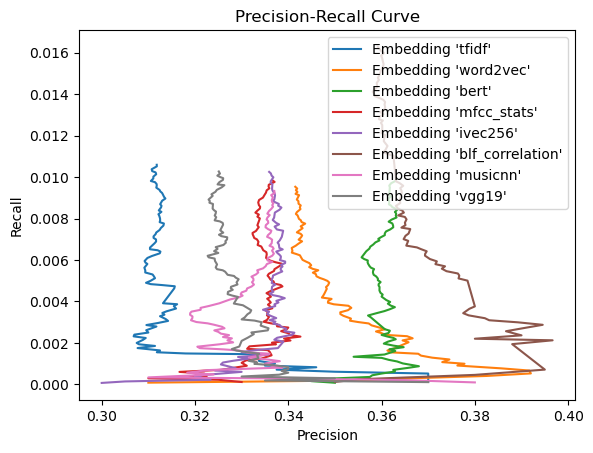

([0.37,
  0.335,
  0.35,
  0.33,
  0.33799999999999997,
  0.34,
  0.3385714285714285,
  0.34,
  0.34,
  0.337,
  0.33272727272727265,
  0.33333333333333337,
  0.33153846153846156,
  0.3335714285714285,
  0.33333333333333326,
  0.33375,
  0.3311764705882353,
  0.32888888888888884,
  0.3278947368421053,
  0.32949999999999996,
  0.33,
  0.3313636363636363,
  0.3326086956521738,
  0.3320833333333333,
  0.33559999999999995,
  0.3357692307692307,
  0.334074074074074,
  0.3342857142857143,
  0.3327586206896552,
  0.33,
  0.33064516129032256,
  0.33125,
  0.3318181818181818,
  0.33205882352941174,
  0.33028571428571424,
  0.32833333333333337,
  0.32891891891891895,
  0.32921052631578945,
  0.32794871794871794,
  0.32699999999999996,
  0.32707317073170733,
  0.3280952380952381,
  0.3276744186046512,
  0.3277272727272728,
  0.329111111111111,
  0.32891304347826084,
  0.32936170212765953,
  0.32875,
  0.3283673469387755,
  0.327,
  0.3264705882352941,
  0.32596153846153847,
  0.32471698113207553,

In [14]:
# Specify the sample size
sample_size = 100
k_range = range(1, 101)  # This creates a range from 1 to 100 (inclusive)

# List of embeddings
embeddings_list = [tfidf, word2vec,bert,mfcc_stats,ivec256,blf_correlation, musicnn, vgg19] # Add all your embeddings

calc_avg_recall_precision(embeddings_list, k_range, sample_size)

# Early Fusion Plot (and needed functions)

In [16]:
def make2embeddings1(embedding1, embedding2):
    embedding_array = data_fusion(embedding1.head(10094),embedding2 )
    #Apply UMAP
    # Convert to NumPy array
    embedding_array = np.asarray(embedding_array)
    umap_model = umap.UMAP(n_neighbors=4, min_dist=0.8, n_components=100)  # Adjust parameters as needed
    print("Starting UMAP")
    embedding_umap = umap_model.fit_transform(embedding_array)
    print("Stopping UMAP")
    # Convert the UMAP result to a matrix
    embedding_matrix = np.matrix(embedding_umap)
    return embedding_matrix, embedding_matrix.transpose()

In [4]:
def generate_cos_sim_matrix2(embedding1, embedding2):
    print(embedding1.shape)
    print(embedding2.shape)
    #embedding1.drop(7298, axis=0, inplace=True)
    #embedding2.drop(7298, axis=0, inplace=True)
    embedding_matrix,embedding_transpose = make2embeddings1(embedding1, embedding2)
    #embedding_matrix,embedding_transpose = convert2matrix(embedding)


    # Überprüfen Sie die Form der transponierten Matrizen
    print(embedding_matrix.shape) # (1328, 10093)
    #print(len(blf_correlation), len(blf_correlation_transpose_zip[0])) # (1328, 10093)
    # Berechnen Sie die Kosinusähnlichkeitsmatrix
    cos_sim_matrix = np.triu(embedding_matrix.dot(embedding_transpose) / (np.linalg.norm(embedding_matrix, axis=1) * np.linalg.norm(embedding_matrix, axis=1)[:, None]))
    # Fill the lower triangular part with the same values as the upper triangular part
    cos_sim_matrix = cos_sim_matrix + cos_sim_matrix.T - np.diag(cos_sim_matrix.diagonal())

    # Create a dataframe from the numpy matrix
    df = pd.DataFrame(cos_sim_matrix)

    # Assign the ids to the index and columns
    df.index = embedding1.iloc[:, 0]
    #df.index = df.index.str.strip('(),')
    df.columns = embedding1.iloc[:, 0]
    #df.columns = df.columns.str.strip('(),')

    return df

In [5]:
def data_fusion(embedding1, embedding2):
    matrix1, matrix1b = convert2matrix(embedding1)
    matrix2, matrix2b = convert2matrix(embedding2)

    # Ensure the matrices have the same number of rows
    if matrix1.shape[0] != matrix2.shape[0]:
        raise ValueError("Matrices must have the same number of rows for concatenation.")

    # Horizontally stack the matrices
    fused_matrix = np.hstack((matrix1, matrix2))

    return fused_matrix

In [6]:
def convert2matrix(embedding):
    embedding = embedding.sort_values(by='id')
    # Konvertieren Sie den DataFrame in ein NumPy-ndarray
    embedding_array = embedding.iloc[:, 2:].to_numpy()
    # Konvertieren Sie das NumPy-ndarray in eine NumPy-Matrix
    # initialize the LDA model with the desired parameters
    #lda = LatentDirichletAllocation(n_components=50, max_iter=5, learning_method='online', learning_offset=50., random_state=0)

    '''# Apply UMAP
    umap_model = umap.UMAP(n_neighbors=10, min_dist=0.2, n_components=50)  # Adjust parameters as needed
    print("Starting UMAP")
    embedding_umap = umap_model.fit_transform(embedding_array)
    print("Stopping UMAP")'''
    
    # Convert the UMAP result to a matrix
    embedding_matrix = np.matrix(embedding_array)
    
    # Transponieren Sie die Matrix mit der transpose() Methode
    #embedding_transpose = embedding_matrix.transpose()
    #embedding_mm_fused = data_fusion(tfidf[:10094], musicnn)
    # Transponieren Sie die Matrix mit der transpose() Methode
    embedding_transpose = embedding_matrix.transpose()
    return embedding_matrix,embedding_transpose

In [14]:
#preprocess dataset
bert = bert[bert['id'] != '03Oc9WeMEmyLLQbj']

In [39]:
fusion_bert_musicnn = generate_cos_sim_matrix2(bert,musicnn)
fusion_bert_musicnn = pd.merge(fusion_bert_musicnn, genres, on='id')

(10094, 769)
(10094, 51)
Starting UMAP
Stopping UMAP
(10094, 100)


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calc_avg_recall_precision_fusion(cosine_similarity_matrix, k_values, sample_size):
    genres = pd.DataFrame()  # Assuming you have a DataFrame called 'genres'

    precision_scores = []
    recall_scores = []

    # Sample a subset of queries
    sampled_queries = np.random.choice(cosine_similarity_matrix['id'], size=sample_size, replace=False)

    for k in k_values:
        results = []
        for query in sampled_queries:
            precision, recall = calc_recall_precision(query, cosine_similarity_matrix, k)
            results.append((precision, recall))
            print(f"Processed query {query} for k={k} - Precision: {precision:.2f}, Recall: {recall:.2f}")

        # Unpack results
        precision_values, recall_values = zip(*results)

        # Calculate the average precision and recall over all sampled query tracks for the current k
        avg_precision = np.mean(precision_values)
        avg_recall = np.mean(recall_values)

        precision_scores.append(avg_precision)
        recall_scores.append(avg_recall)

        print(f"Avg Precision at k={k}: {avg_precision:.2f}, Avg Recall at k={k}: {avg_recall:.2f}\n")

    # Plot the precision-recall curve for the given embedding
    plt.plot(recall_scores, precision_scores, label='Given Embedding')  # Swap precision and recall

    plt.xlabel('Recall')  # Swap xlabel and ylabel
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve Fusion: Bert & Musicnn')
    plt.legend()
    plt.show()

    return precision_scores, recall_scores


Processed query 7n1aRZy5nXY7xqzV for k=1 - Precision: 0.00, Recall: 0.00
Processed query LmBCtyuLCLKHvDTM for k=1 - Precision: 1.00, Recall: 0.00
Processed query LFKYue8YlfYi1ILw for k=1 - Precision: 1.00, Recall: 0.00
Processed query svzZTDaQPsbtQCHm for k=1 - Precision: 1.00, Recall: 0.00
Processed query g1Fkyx0T1Ylcw49Z for k=1 - Precision: 0.00, Recall: 0.00
Processed query ZhCpr6rRtB0kKrQg for k=1 - Precision: 0.00, Recall: 0.00
Processed query faaF2qbE6IIgB6FL for k=1 - Precision: 1.00, Recall: 0.00
Processed query PzjMLoz4uryikjBF for k=1 - Precision: 0.00, Recall: 0.00
Processed query Kbf3cPfjxGjRiVTv for k=1 - Precision: 0.00, Recall: 0.00
Processed query TwtFpQa2IRpriRlK for k=1 - Precision: 1.00, Recall: 0.00
Processed query 5QfTsiAiONF5lDel for k=1 - Precision: 0.00, Recall: 0.00
Processed query 8nG0vZiRQXrHbrQK for k=1 - Precision: 0.00, Recall: 0.00
Processed query l7JfVRRnkRsaOEXL for k=1 - Precision: 0.00, Recall: 0.00
Processed query 8mpawYN2M5b01XTC for k=1 - Precisio

Processed query l7JfVRRnkRsaOEXL for k=2 - Precision: 0.00, Recall: 0.00
Processed query 8mpawYN2M5b01XTC for k=2 - Precision: 0.50, Recall: 0.00
Processed query GjdDqcdpz7kX85kl for k=2 - Precision: 1.00, Recall: 0.00
Processed query rlMcTiHz9HSidm55 for k=2 - Precision: 0.00, Recall: 0.00
Processed query TZonZEnh1Vz9OEJn for k=2 - Precision: 0.00, Recall: 0.00
Processed query AsrKO9MIRQVlh1wd for k=2 - Precision: 0.00, Recall: 0.00
Processed query ivpQdsiz0WiyzXvY for k=2 - Precision: 0.00, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k=2 - Precision: 1.00, Recall: 0.00
Processed query QhAAd1JDJkwkXoT8 for k=2 - Precision: 0.50, Recall: 0.00
Processed query k6LZ32AyVaYRxRqU for k=2 - Precision: 0.00, Recall: 0.00
Processed query Bmaa3poAZVrAgBRC for k=2 - Precision: 0.50, Recall: 0.00
Processed query blC0kW4mYLj4V4u0 for k=2 - Precision: 0.00, Recall: 0.00
Processed query MLekY58IPgdSr5Q3 for k=2 - Precision: 0.00, Recall: 0.00
Processed query Lggy2QpQLVLASQ9Q for k=2 - Precisio

Processed query MLekY58IPgdSr5Q3 for k=3 - Precision: 0.00, Recall: 0.00
Processed query Lggy2QpQLVLASQ9Q for k=3 - Precision: 1.00, Recall: 0.00
Processed query 7D1H0DTrp6sztZeO for k=3 - Precision: 0.67, Recall: 0.00
Processed query ZAgQhn4gI8pqQzjp for k=3 - Precision: 0.67, Recall: 0.00
Processed query nEUwCpufGit4fqYH for k=3 - Precision: 0.00, Recall: 0.00
Processed query 1ltAp8lN1prwUs6s for k=3 - Precision: 0.00, Recall: 0.00
Processed query VzY36FO8t9sDy1h9 for k=3 - Precision: 0.67, Recall: 0.00
Processed query TBH4dxkeSVvTsSnV for k=3 - Precision: 0.67, Recall: 0.00
Processed query SbSWtusPY4NzadKD for k=3 - Precision: 0.67, Recall: 0.00
Processed query 4vPCXVXHeoXkniz9 for k=3 - Precision: 0.00, Recall: 0.00
Processed query W0mr0f92n4pDYFYE for k=3 - Precision: 1.00, Recall: 0.00
Processed query Ycdb50MRcHyKljV7 for k=3 - Precision: 0.00, Recall: 0.00
Processed query h1mUlnHQBfZ54dal for k=3 - Precision: 0.00, Recall: 0.00
Processed query 8cM4LdET14KP9vSR for k=3 - Precisio

Processed query h1mUlnHQBfZ54dal for k=4 - Precision: 0.25, Recall: 0.00
Processed query 8cM4LdET14KP9vSR for k=4 - Precision: 0.00, Recall: 0.00
Processed query 80P9k7mawKhBRHbJ for k=4 - Precision: 0.00, Recall: 0.00
Processed query WpCcJXRIHyPrv2g7 for k=4 - Precision: 0.50, Recall: 0.00
Processed query Bl6czQtTnahOAg2V for k=4 - Precision: 0.00, Recall: 0.00
Processed query mrmtGytnUDYGOUOH for k=4 - Precision: 0.00, Recall: 0.00
Processed query oaIwSbTS5fQjSvtt for k=4 - Precision: 0.75, Recall: 0.00
Processed query EaqvIckagr9dMSmp for k=4 - Precision: 0.00, Recall: 0.00
Processed query hSMhEoHkNC5kdNNs for k=4 - Precision: 0.00, Recall: 0.00
Processed query cSYnPUZZ1zLFLC9l for k=4 - Precision: 0.75, Recall: 0.00
Processed query WRbNe1wqXuWUlW9n for k=4 - Precision: 0.00, Recall: 0.00
Processed query h9UBskhwLJ6lEsgI for k=4 - Precision: 0.50, Recall: 0.00
Processed query 1sptE8wT5XvOvHlW for k=4 - Precision: 0.00, Recall: 0.00
Processed query NgfAB5iezHMSGR8J for k=4 - Precisio

Processed query 1sptE8wT5XvOvHlW for k=5 - Precision: 0.00, Recall: 0.00
Processed query NgfAB5iezHMSGR8J for k=5 - Precision: 0.00, Recall: 0.00
Processed query 1NmthD0bJAk8r1ZC for k=5 - Precision: 0.00, Recall: 0.00
Processed query KFbfr0fWWCTGXIJj for k=5 - Precision: 0.40, Recall: 0.00
Processed query I1wSAAImrUdZPlY8 for k=5 - Precision: 0.00, Recall: 0.00
Processed query pIO8ObTzkQqowIUy for k=5 - Precision: 0.00, Recall: 0.00
Processed query qUkFjTESBWgMVveZ for k=5 - Precision: 0.20, Recall: 0.00
Processed query BlmfG6VDZhitaVPu for k=5 - Precision: 0.60, Recall: 0.00
Processed query TBJk1gUVEmjT3r7Y for k=5 - Precision: 0.60, Recall: 0.00
Processed query xZxUanP4t55mjPOh for k=5 - Precision: 0.40, Recall: 0.00
Processed query HUOSeI0YAPMQQbBz for k=5 - Precision: 0.00, Recall: 0.00
Processed query SkziRTjjAB7P07Ge for k=5 - Precision: 0.40, Recall: 0.00
Processed query xLYfp2Fb3uZrDME6 for k=5 - Precision: 0.00, Recall: 0.00
Processed query jZIPz5Hs52i4iyvM for k=5 - Precisio

Processed query xLYfp2Fb3uZrDME6 for k=6 - Precision: 0.00, Recall: 0.00
Processed query jZIPz5Hs52i4iyvM for k=6 - Precision: 0.00, Recall: 0.00
Processed query JKxDOWvm2dwbxVGd for k=6 - Precision: 1.00, Recall: 0.00
Processed query Si2wrGw592vjFt1H for k=6 - Precision: 0.00, Recall: 0.00
Processed query E6xyZ7sUHkxSBiIb for k=6 - Precision: 0.50, Recall: 0.00
Processed query B4wNWPzUo2nXhitH for k=6 - Precision: 0.67, Recall: 0.00
Processed query qia0KEufEPClHrB9 for k=6 - Precision: 0.33, Recall: 0.00
Processed query 5LzHvHAIwDeNxBA0 for k=6 - Precision: 0.50, Recall: 0.00
Processed query qxjO99S0R94MTP3S for k=6 - Precision: 0.33, Recall: 0.00
Processed query BpQbG8gd4vRcvUMZ for k=6 - Precision: 0.17, Recall: 0.00
Processed query LVNIWsEfEvLnxGFR for k=6 - Precision: 0.33, Recall: 0.00
Processed query VWfPIOxHP1QCuH6W for k=6 - Precision: 0.33, Recall: 0.00
Processed query R9ove8iUd4kTefAc for k=6 - Precision: 0.33, Recall: 0.00
Processed query Ow2JSzIFP0OSj3RK for k=6 - Precisio

Processed query R9ove8iUd4kTefAc for k=7 - Precision: 0.43, Recall: 0.00
Processed query Ow2JSzIFP0OSj3RK for k=7 - Precision: 0.43, Recall: 0.00
Processed query aC6Ayj7JjDNa6oIg for k=7 - Precision: 0.00, Recall: 0.00
Processed query ZHIKHfLyTuRzAcDU for k=7 - Precision: 0.00, Recall: 0.00
Processed query y48SMi67SfMjZfiA for k=7 - Precision: 0.29, Recall: 0.00
Processed query ZSEP3aLCH5iHcE1p for k=7 - Precision: 0.57, Recall: 0.00
Processed query 5bVqP2AsQwwTBO1v for k=7 - Precision: 0.71, Recall: 0.00
Processed query LAjAikN7XzYRFY1D for k=7 - Precision: 0.14, Recall: 0.00
Processed query hi4bMnNj2515T2lL for k=7 - Precision: 0.14, Recall: 0.00
Processed query zQaORaShg7AJ8qRq for k=7 - Precision: 0.71, Recall: 0.00
Processed query IJRqAdaBcOo7tdJK for k=7 - Precision: 0.71, Recall: 0.00
Processed query RJUjLrAkXV2Jj3qH for k=7 - Precision: 0.29, Recall: 0.00
Processed query FNpS1gA711QdjJpd for k=7 - Precision: 0.71, Recall: 0.00
Processed query Se9KDiwbDwmSEBKh for k=7 - Precisio

Processed query FNpS1gA711QdjJpd for k=8 - Precision: 0.75, Recall: 0.00
Processed query Se9KDiwbDwmSEBKh for k=8 - Precision: 0.88, Recall: 0.00
Processed query dQUNiihhNbCIbtOF for k=8 - Precision: 0.25, Recall: 0.00
Processed query 72RUzAtjBnnRpuxN for k=8 - Precision: 0.50, Recall: 0.00
Processed query VJGJ5KWZYF5FQwNm for k=8 - Precision: 0.00, Recall: 0.00
Processed query b9G2PNb7goUk0T0o for k=8 - Precision: 0.00, Recall: 0.00
Processed query CxsmrOAvfp8gDwTM for k=8 - Precision: 0.00, Recall: 0.00
Processed query xDV3kVCD3a7zPhwS for k=8 - Precision: 0.00, Recall: 0.00
Processed query iw21Bo1VYYCT6n7A for k=8 - Precision: 0.50, Recall: 0.00
Processed query NoWzSl5t6joo1NBH for k=8 - Precision: 0.00, Recall: 0.00
Processed query phL12CBijBqwQ9qB for k=8 - Precision: 0.62, Recall: 0.00
Processed query xH6aA7toBHLc2nac for k=8 - Precision: 0.00, Recall: 0.00
Processed query JGkgo4pzrEzCGgJu for k=8 - Precision: 0.50, Recall: 0.00
Processed query fu5G8MSVo6B2kJTl for k=8 - Precisio

Processed query JGkgo4pzrEzCGgJu for k=9 - Precision: 0.44, Recall: 0.00
Processed query fu5G8MSVo6B2kJTl for k=9 - Precision: 0.11, Recall: 0.00
Processed query BMEAx3O2KO1Ggpml for k=9 - Precision: 0.67, Recall: 0.00
Processed query hGKFUbZw45ZvzQjX for k=9 - Precision: 0.78, Recall: 0.00
Avg Precision at k=9: 0.35, Avg Recall at k=9: 0.00

Processed query 7n1aRZy5nXY7xqzV for k=10 - Precision: 0.10, Recall: 0.00
Processed query LmBCtyuLCLKHvDTM for k=10 - Precision: 0.60, Recall: 0.00
Processed query LFKYue8YlfYi1ILw for k=10 - Precision: 0.10, Recall: 0.00
Processed query svzZTDaQPsbtQCHm for k=10 - Precision: 0.10, Recall: 0.00
Processed query g1Fkyx0T1Ylcw49Z for k=10 - Precision: 0.10, Recall: 0.00
Processed query ZhCpr6rRtB0kKrQg for k=10 - Precision: 0.20, Recall: 0.00
Processed query faaF2qbE6IIgB6FL for k=10 - Precision: 0.90, Recall: 0.00
Processed query PzjMLoz4uryikjBF for k=10 - Precision: 0.20, Recall: 0.00
Processed query Kbf3cPfjxGjRiVTv for k=10 - Precision: 0.00, Re

Processed query faaF2qbE6IIgB6FL for k=11 - Precision: 0.82, Recall: 0.00
Processed query PzjMLoz4uryikjBF for k=11 - Precision: 0.18, Recall: 0.00
Processed query Kbf3cPfjxGjRiVTv for k=11 - Precision: 0.00, Recall: 0.00
Processed query TwtFpQa2IRpriRlK for k=11 - Precision: 0.55, Recall: 0.00
Processed query 5QfTsiAiONF5lDel for k=11 - Precision: 0.18, Recall: 0.00
Processed query 8nG0vZiRQXrHbrQK for k=11 - Precision: 0.64, Recall: 0.00
Processed query l7JfVRRnkRsaOEXL for k=11 - Precision: 0.00, Recall: 0.00
Processed query 8mpawYN2M5b01XTC for k=11 - Precision: 0.36, Recall: 0.00
Processed query GjdDqcdpz7kX85kl for k=11 - Precision: 0.64, Recall: 0.00
Processed query rlMcTiHz9HSidm55 for k=11 - Precision: 0.18, Recall: 0.00
Processed query TZonZEnh1Vz9OEJn for k=11 - Precision: 0.09, Recall: 0.01
Processed query AsrKO9MIRQVlh1wd for k=11 - Precision: 0.18, Recall: 0.00
Processed query ivpQdsiz0WiyzXvY for k=11 - Precision: 0.00, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k

Processed query TZonZEnh1Vz9OEJn for k=12 - Precision: 0.08, Recall: 0.01
Processed query AsrKO9MIRQVlh1wd for k=12 - Precision: 0.25, Recall: 0.00
Processed query ivpQdsiz0WiyzXvY for k=12 - Precision: 0.00, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k=12 - Precision: 0.67, Recall: 0.00
Processed query QhAAd1JDJkwkXoT8 for k=12 - Precision: 0.58, Recall: 0.00
Processed query k6LZ32AyVaYRxRqU for k=12 - Precision: 0.08, Recall: 0.00
Processed query Bmaa3poAZVrAgBRC for k=12 - Precision: 0.50, Recall: 0.00
Processed query blC0kW4mYLj4V4u0 for k=12 - Precision: 0.17, Recall: 0.00
Processed query MLekY58IPgdSr5Q3 for k=12 - Precision: 0.33, Recall: 0.00
Processed query Lggy2QpQLVLASQ9Q for k=12 - Precision: 0.50, Recall: 0.00
Processed query 7D1H0DTrp6sztZeO for k=12 - Precision: 0.67, Recall: 0.00
Processed query ZAgQhn4gI8pqQzjp for k=12 - Precision: 0.42, Recall: 0.00
Processed query nEUwCpufGit4fqYH for k=12 - Precision: 0.08, Recall: 0.00
Processed query 1ltAp8lN1prwUs6s for k

Processed query 7D1H0DTrp6sztZeO for k=13 - Precision: 0.69, Recall: 0.00
Processed query ZAgQhn4gI8pqQzjp for k=13 - Precision: 0.46, Recall: 0.00
Processed query nEUwCpufGit4fqYH for k=13 - Precision: 0.08, Recall: 0.00
Processed query 1ltAp8lN1prwUs6s for k=13 - Precision: 0.23, Recall: 0.00
Processed query VzY36FO8t9sDy1h9 for k=13 - Precision: 0.69, Recall: 0.00
Processed query TBH4dxkeSVvTsSnV for k=13 - Precision: 0.69, Recall: 0.00
Processed query SbSWtusPY4NzadKD for k=13 - Precision: 0.54, Recall: 0.00
Processed query 4vPCXVXHeoXkniz9 for k=13 - Precision: 0.00, Recall: 0.00
Processed query W0mr0f92n4pDYFYE for k=13 - Precision: 0.69, Recall: 0.00
Processed query Ycdb50MRcHyKljV7 for k=13 - Precision: 0.23, Recall: 0.00
Processed query h1mUlnHQBfZ54dal for k=13 - Precision: 0.23, Recall: 0.00
Processed query 8cM4LdET14KP9vSR for k=13 - Precision: 0.00, Recall: 0.00
Processed query 80P9k7mawKhBRHbJ for k=13 - Precision: 0.23, Recall: 0.00
Processed query WpCcJXRIHyPrv2g7 for k

Processed query h1mUlnHQBfZ54dal for k=14 - Precision: 0.21, Recall: 0.00
Processed query 8cM4LdET14KP9vSR for k=14 - Precision: 0.00, Recall: 0.00
Processed query 80P9k7mawKhBRHbJ for k=14 - Precision: 0.21, Recall: 0.00
Processed query WpCcJXRIHyPrv2g7 for k=14 - Precision: 0.57, Recall: 0.00
Processed query Bl6czQtTnahOAg2V for k=14 - Precision: 0.00, Recall: 0.00
Processed query mrmtGytnUDYGOUOH for k=14 - Precision: 0.36, Recall: 0.00
Processed query oaIwSbTS5fQjSvtt for k=14 - Precision: 0.79, Recall: 0.00
Processed query EaqvIckagr9dMSmp for k=14 - Precision: 0.07, Recall: 0.00
Processed query hSMhEoHkNC5kdNNs for k=14 - Precision: 0.00, Recall: 0.00
Processed query cSYnPUZZ1zLFLC9l for k=14 - Precision: 0.57, Recall: 0.00
Processed query WRbNe1wqXuWUlW9n for k=14 - Precision: 0.00, Recall: 0.00
Processed query h9UBskhwLJ6lEsgI for k=14 - Precision: 0.64, Recall: 0.00
Processed query 1sptE8wT5XvOvHlW for k=14 - Precision: 0.00, Recall: 0.00
Processed query NgfAB5iezHMSGR8J for k

Processed query WRbNe1wqXuWUlW9n for k=15 - Precision: 0.00, Recall: 0.00
Processed query h9UBskhwLJ6lEsgI for k=15 - Precision: 0.67, Recall: 0.00
Processed query 1sptE8wT5XvOvHlW for k=15 - Precision: 0.00, Recall: 0.00
Processed query NgfAB5iezHMSGR8J for k=15 - Precision: 0.00, Recall: 0.00
Processed query 1NmthD0bJAk8r1ZC for k=15 - Precision: 0.07, Recall: 0.01
Processed query KFbfr0fWWCTGXIJj for k=15 - Precision: 0.47, Recall: 0.00
Processed query I1wSAAImrUdZPlY8 for k=15 - Precision: 0.00, Recall: 0.00
Processed query pIO8ObTzkQqowIUy for k=15 - Precision: 0.00, Recall: 0.00
Processed query qUkFjTESBWgMVveZ for k=15 - Precision: 0.13, Recall: 0.00
Processed query BlmfG6VDZhitaVPu for k=15 - Precision: 0.53, Recall: 0.00
Processed query TBJk1gUVEmjT3r7Y for k=15 - Precision: 0.60, Recall: 0.00
Processed query xZxUanP4t55mjPOh for k=15 - Precision: 0.53, Recall: 0.00
Processed query HUOSeI0YAPMQQbBz for k=15 - Precision: 0.00, Recall: 0.00
Processed query SkziRTjjAB7P07Ge for k

Processed query TBJk1gUVEmjT3r7Y for k=16 - Precision: 0.56, Recall: 0.00
Processed query xZxUanP4t55mjPOh for k=16 - Precision: 0.56, Recall: 0.00
Processed query HUOSeI0YAPMQQbBz for k=16 - Precision: 0.00, Recall: 0.00
Processed query SkziRTjjAB7P07Ge for k=16 - Precision: 0.50, Recall: 0.00
Processed query xLYfp2Fb3uZrDME6 for k=16 - Precision: 0.00, Recall: 0.00
Processed query jZIPz5Hs52i4iyvM for k=16 - Precision: 0.06, Recall: 0.00
Processed query JKxDOWvm2dwbxVGd for k=16 - Precision: 0.81, Recall: 0.00
Processed query Si2wrGw592vjFt1H for k=16 - Precision: 0.25, Recall: 0.00
Processed query E6xyZ7sUHkxSBiIb for k=16 - Precision: 0.50, Recall: 0.00
Processed query B4wNWPzUo2nXhitH for k=16 - Precision: 0.50, Recall: 0.00
Processed query qia0KEufEPClHrB9 for k=16 - Precision: 0.31, Recall: 0.00
Processed query 5LzHvHAIwDeNxBA0 for k=16 - Precision: 0.44, Recall: 0.00
Processed query qxjO99S0R94MTP3S for k=16 - Precision: 0.50, Recall: 0.00
Processed query BpQbG8gd4vRcvUMZ for k

Processed query qia0KEufEPClHrB9 for k=17 - Precision: 0.35, Recall: 0.00
Processed query 5LzHvHAIwDeNxBA0 for k=17 - Precision: 0.41, Recall: 0.00
Processed query qxjO99S0R94MTP3S for k=17 - Precision: 0.47, Recall: 0.00
Processed query BpQbG8gd4vRcvUMZ for k=17 - Precision: 0.24, Recall: 0.00
Processed query LVNIWsEfEvLnxGFR for k=17 - Precision: 0.59, Recall: 0.00
Processed query VWfPIOxHP1QCuH6W for k=17 - Precision: 0.47, Recall: 0.00
Processed query R9ove8iUd4kTefAc for k=17 - Precision: 0.47, Recall: 0.00
Processed query Ow2JSzIFP0OSj3RK for k=17 - Precision: 0.35, Recall: 0.00
Processed query aC6Ayj7JjDNa6oIg for k=17 - Precision: 0.00, Recall: 0.00
Processed query ZHIKHfLyTuRzAcDU for k=17 - Precision: 0.00, Recall: 0.00
Processed query y48SMi67SfMjZfiA for k=17 - Precision: 0.29, Recall: 0.00
Processed query ZSEP3aLCH5iHcE1p for k=17 - Precision: 0.59, Recall: 0.00
Processed query 5bVqP2AsQwwTBO1v for k=17 - Precision: 0.65, Recall: 0.00
Processed query LAjAikN7XzYRFY1D for k

Processed query y48SMi67SfMjZfiA for k=18 - Precision: 0.28, Recall: 0.00
Processed query ZSEP3aLCH5iHcE1p for k=18 - Precision: 0.61, Recall: 0.00
Processed query 5bVqP2AsQwwTBO1v for k=18 - Precision: 0.61, Recall: 0.00
Processed query LAjAikN7XzYRFY1D for k=18 - Precision: 0.28, Recall: 0.00
Processed query hi4bMnNj2515T2lL for k=18 - Precision: 0.44, Recall: 0.00
Processed query zQaORaShg7AJ8qRq for k=18 - Precision: 0.67, Recall: 0.00
Processed query IJRqAdaBcOo7tdJK for k=18 - Precision: 0.56, Recall: 0.00
Processed query RJUjLrAkXV2Jj3qH for k=18 - Precision: 0.28, Recall: 0.00
Processed query FNpS1gA711QdjJpd for k=18 - Precision: 0.56, Recall: 0.00
Processed query Se9KDiwbDwmSEBKh for k=18 - Precision: 0.83, Recall: 0.00
Processed query dQUNiihhNbCIbtOF for k=18 - Precision: 0.44, Recall: 0.00
Processed query 72RUzAtjBnnRpuxN for k=18 - Precision: 0.61, Recall: 0.00
Processed query VJGJ5KWZYF5FQwNm for k=18 - Precision: 0.06, Recall: 0.00
Processed query b9G2PNb7goUk0T0o for k

Processed query dQUNiihhNbCIbtOF for k=19 - Precision: 0.47, Recall: 0.00
Processed query 72RUzAtjBnnRpuxN for k=19 - Precision: 0.58, Recall: 0.00
Processed query VJGJ5KWZYF5FQwNm for k=19 - Precision: 0.05, Recall: 0.00
Processed query b9G2PNb7goUk0T0o for k=19 - Precision: 0.00, Recall: 0.00
Processed query CxsmrOAvfp8gDwTM for k=19 - Precision: 0.00, Recall: 0.00
Processed query xDV3kVCD3a7zPhwS for k=19 - Precision: 0.00, Recall: 0.00
Processed query iw21Bo1VYYCT6n7A for k=19 - Precision: 0.58, Recall: 0.00
Processed query NoWzSl5t6joo1NBH for k=19 - Precision: 0.00, Recall: 0.00
Processed query phL12CBijBqwQ9qB for k=19 - Precision: 0.68, Recall: 0.00
Processed query xH6aA7toBHLc2nac for k=19 - Precision: 0.16, Recall: 0.00
Processed query JGkgo4pzrEzCGgJu for k=19 - Precision: 0.63, Recall: 0.00
Processed query fu5G8MSVo6B2kJTl for k=19 - Precision: 0.16, Recall: 0.00
Processed query BMEAx3O2KO1Ggpml for k=19 - Precision: 0.74, Recall: 0.00
Processed query hGKFUbZw45ZvzQjX for k

Processed query JGkgo4pzrEzCGgJu for k=20 - Precision: 0.65, Recall: 0.00
Processed query fu5G8MSVo6B2kJTl for k=20 - Precision: 0.15, Recall: 0.00
Processed query BMEAx3O2KO1Ggpml for k=20 - Precision: 0.75, Recall: 0.00
Processed query hGKFUbZw45ZvzQjX for k=20 - Precision: 0.60, Recall: 0.00
Avg Precision at k=20: 0.33, Avg Recall at k=20: 0.00

Processed query 7n1aRZy5nXY7xqzV for k=21 - Precision: 0.05, Recall: 0.00
Processed query LmBCtyuLCLKHvDTM for k=21 - Precision: 0.57, Recall: 0.00
Processed query LFKYue8YlfYi1ILw for k=21 - Precision: 0.05, Recall: 0.00
Processed query svzZTDaQPsbtQCHm for k=21 - Precision: 0.14, Recall: 0.00
Processed query g1Fkyx0T1Ylcw49Z for k=21 - Precision: 0.14, Recall: 0.00
Processed query ZhCpr6rRtB0kKrQg for k=21 - Precision: 0.19, Recall: 0.00
Processed query faaF2qbE6IIgB6FL for k=21 - Precision: 0.90, Recall: 0.00
Processed query PzjMLoz4uryikjBF for k=21 - Precision: 0.10, Recall: 0.00
Processed query Kbf3cPfjxGjRiVTv for k=21 - Precision: 0.

Processed query faaF2qbE6IIgB6FL for k=22 - Precision: 0.86, Recall: 0.00
Processed query PzjMLoz4uryikjBF for k=22 - Precision: 0.09, Recall: 0.00
Processed query Kbf3cPfjxGjRiVTv for k=22 - Precision: 0.00, Recall: 0.00
Processed query TwtFpQa2IRpriRlK for k=22 - Precision: 0.55, Recall: 0.00
Processed query 5QfTsiAiONF5lDel for k=22 - Precision: 0.14, Recall: 0.00
Processed query 8nG0vZiRQXrHbrQK for k=22 - Precision: 0.64, Recall: 0.00
Processed query l7JfVRRnkRsaOEXL for k=22 - Precision: 0.00, Recall: 0.00
Processed query 8mpawYN2M5b01XTC for k=22 - Precision: 0.27, Recall: 0.00
Processed query GjdDqcdpz7kX85kl for k=22 - Precision: 0.64, Recall: 0.00
Processed query rlMcTiHz9HSidm55 for k=22 - Precision: 0.18, Recall: 0.00
Processed query TZonZEnh1Vz9OEJn for k=22 - Precision: 0.05, Recall: 0.01
Processed query AsrKO9MIRQVlh1wd for k=22 - Precision: 0.18, Recall: 0.00
Processed query ivpQdsiz0WiyzXvY for k=22 - Precision: 0.00, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k

Processed query TZonZEnh1Vz9OEJn for k=23 - Precision: 0.09, Recall: 0.01
Processed query AsrKO9MIRQVlh1wd for k=23 - Precision: 0.17, Recall: 0.00
Processed query ivpQdsiz0WiyzXvY for k=23 - Precision: 0.00, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k=23 - Precision: 0.57, Recall: 0.00
Processed query QhAAd1JDJkwkXoT8 for k=23 - Precision: 0.52, Recall: 0.00
Processed query k6LZ32AyVaYRxRqU for k=23 - Precision: 0.04, Recall: 0.00
Processed query Bmaa3poAZVrAgBRC for k=23 - Precision: 0.48, Recall: 0.00
Processed query blC0kW4mYLj4V4u0 for k=23 - Precision: 0.09, Recall: 0.00
Processed query MLekY58IPgdSr5Q3 for k=23 - Precision: 0.43, Recall: 0.00
Processed query Lggy2QpQLVLASQ9Q for k=23 - Precision: 0.39, Recall: 0.00
Processed query 7D1H0DTrp6sztZeO for k=23 - Precision: 0.65, Recall: 0.00
Processed query ZAgQhn4gI8pqQzjp for k=23 - Precision: 0.52, Recall: 0.00
Processed query nEUwCpufGit4fqYH for k=23 - Precision: 0.04, Recall: 0.00
Processed query 1ltAp8lN1prwUs6s for k

Processed query 7D1H0DTrp6sztZeO for k=24 - Precision: 0.67, Recall: 0.00
Processed query ZAgQhn4gI8pqQzjp for k=24 - Precision: 0.50, Recall: 0.00
Processed query nEUwCpufGit4fqYH for k=24 - Precision: 0.04, Recall: 0.00
Processed query 1ltAp8lN1prwUs6s for k=24 - Precision: 0.38, Recall: 0.00
Processed query VzY36FO8t9sDy1h9 for k=24 - Precision: 0.62, Recall: 0.00
Processed query TBH4dxkeSVvTsSnV for k=24 - Precision: 0.71, Recall: 0.00
Processed query SbSWtusPY4NzadKD for k=24 - Precision: 0.54, Recall: 0.00
Processed query 4vPCXVXHeoXkniz9 for k=24 - Precision: 0.00, Recall: 0.00
Processed query W0mr0f92n4pDYFYE for k=24 - Precision: 0.67, Recall: 0.00
Processed query Ycdb50MRcHyKljV7 for k=24 - Precision: 0.25, Recall: 0.00
Processed query h1mUlnHQBfZ54dal for k=24 - Precision: 0.21, Recall: 0.00
Processed query 8cM4LdET14KP9vSR for k=24 - Precision: 0.00, Recall: 0.00
Processed query 80P9k7mawKhBRHbJ for k=24 - Precision: 0.21, Recall: 0.00
Processed query WpCcJXRIHyPrv2g7 for k

Processed query h1mUlnHQBfZ54dal for k=25 - Precision: 0.24, Recall: 0.00
Processed query 8cM4LdET14KP9vSR for k=25 - Precision: 0.00, Recall: 0.00
Processed query 80P9k7mawKhBRHbJ for k=25 - Precision: 0.20, Recall: 0.00
Processed query WpCcJXRIHyPrv2g7 for k=25 - Precision: 0.60, Recall: 0.00
Processed query Bl6czQtTnahOAg2V for k=25 - Precision: 0.00, Recall: 0.00
Processed query mrmtGytnUDYGOUOH for k=25 - Precision: 0.40, Recall: 0.00
Processed query oaIwSbTS5fQjSvtt for k=25 - Precision: 0.60, Recall: 0.00
Processed query EaqvIckagr9dMSmp for k=25 - Precision: 0.12, Recall: 0.00
Processed query hSMhEoHkNC5kdNNs for k=25 - Precision: 0.00, Recall: 0.00
Processed query cSYnPUZZ1zLFLC9l for k=25 - Precision: 0.52, Recall: 0.00
Processed query WRbNe1wqXuWUlW9n for k=25 - Precision: 0.00, Recall: 0.00
Processed query h9UBskhwLJ6lEsgI for k=25 - Precision: 0.56, Recall: 0.00
Processed query 1sptE8wT5XvOvHlW for k=25 - Precision: 0.00, Recall: 0.00
Processed query NgfAB5iezHMSGR8J for k

Processed query WRbNe1wqXuWUlW9n for k=26 - Precision: 0.00, Recall: 0.00
Processed query h9UBskhwLJ6lEsgI for k=26 - Precision: 0.54, Recall: 0.00
Processed query 1sptE8wT5XvOvHlW for k=26 - Precision: 0.00, Recall: 0.00
Processed query NgfAB5iezHMSGR8J for k=26 - Precision: 0.04, Recall: 0.01
Processed query 1NmthD0bJAk8r1ZC for k=26 - Precision: 0.04, Recall: 0.01
Processed query KFbfr0fWWCTGXIJj for k=26 - Precision: 0.42, Recall: 0.00
Processed query I1wSAAImrUdZPlY8 for k=26 - Precision: 0.00, Recall: 0.00
Processed query pIO8ObTzkQqowIUy for k=26 - Precision: 0.00, Recall: 0.00
Processed query qUkFjTESBWgMVveZ for k=26 - Precision: 0.19, Recall: 0.00
Processed query BlmfG6VDZhitaVPu for k=26 - Precision: 0.42, Recall: 0.00
Processed query TBJk1gUVEmjT3r7Y for k=26 - Precision: 0.65, Recall: 0.00
Processed query xZxUanP4t55mjPOh for k=26 - Precision: 0.58, Recall: 0.00
Processed query HUOSeI0YAPMQQbBz for k=26 - Precision: 0.00, Recall: 0.00
Processed query SkziRTjjAB7P07Ge for k

Processed query TBJk1gUVEmjT3r7Y for k=27 - Precision: 0.67, Recall: 0.00
Processed query xZxUanP4t55mjPOh for k=27 - Precision: 0.59, Recall: 0.00
Processed query HUOSeI0YAPMQQbBz for k=27 - Precision: 0.00, Recall: 0.00
Processed query SkziRTjjAB7P07Ge for k=27 - Precision: 0.59, Recall: 0.00
Processed query xLYfp2Fb3uZrDME6 for k=27 - Precision: 0.00, Recall: 0.00
Processed query jZIPz5Hs52i4iyvM for k=27 - Precision: 0.07, Recall: 0.00
Processed query JKxDOWvm2dwbxVGd for k=27 - Precision: 0.70, Recall: 0.00
Processed query Si2wrGw592vjFt1H for k=27 - Precision: 0.22, Recall: 0.00
Processed query E6xyZ7sUHkxSBiIb for k=27 - Precision: 0.56, Recall: 0.00
Processed query B4wNWPzUo2nXhitH for k=27 - Precision: 0.41, Recall: 0.00
Processed query qia0KEufEPClHrB9 for k=27 - Precision: 0.33, Recall: 0.00
Processed query 5LzHvHAIwDeNxBA0 for k=27 - Precision: 0.41, Recall: 0.00
Processed query qxjO99S0R94MTP3S for k=27 - Precision: 0.48, Recall: 0.00
Processed query BpQbG8gd4vRcvUMZ for k

Processed query qia0KEufEPClHrB9 for k=28 - Precision: 0.32, Recall: 0.00
Processed query 5LzHvHAIwDeNxBA0 for k=28 - Precision: 0.39, Recall: 0.00
Processed query qxjO99S0R94MTP3S for k=28 - Precision: 0.50, Recall: 0.00
Processed query BpQbG8gd4vRcvUMZ for k=28 - Precision: 0.25, Recall: 0.00
Processed query LVNIWsEfEvLnxGFR for k=28 - Precision: 0.61, Recall: 0.00
Processed query VWfPIOxHP1QCuH6W for k=28 - Precision: 0.50, Recall: 0.00
Processed query R9ove8iUd4kTefAc for k=28 - Precision: 0.36, Recall: 0.00
Processed query Ow2JSzIFP0OSj3RK for k=28 - Precision: 0.39, Recall: 0.00
Processed query aC6Ayj7JjDNa6oIg for k=28 - Precision: 0.04, Recall: 0.01
Processed query ZHIKHfLyTuRzAcDU for k=28 - Precision: 0.04, Recall: 0.01
Processed query y48SMi67SfMjZfiA for k=28 - Precision: 0.50, Recall: 0.00
Processed query ZSEP3aLCH5iHcE1p for k=28 - Precision: 0.46, Recall: 0.00
Processed query 5bVqP2AsQwwTBO1v for k=28 - Precision: 0.64, Recall: 0.00
Processed query LAjAikN7XzYRFY1D for k

Processed query y48SMi67SfMjZfiA for k=29 - Precision: 0.52, Recall: 0.00
Processed query ZSEP3aLCH5iHcE1p for k=29 - Precision: 0.45, Recall: 0.00
Processed query 5bVqP2AsQwwTBO1v for k=29 - Precision: 0.66, Recall: 0.00
Processed query LAjAikN7XzYRFY1D for k=29 - Precision: 0.31, Recall: 0.00
Processed query hi4bMnNj2515T2lL for k=29 - Precision: 0.52, Recall: 0.00
Processed query zQaORaShg7AJ8qRq for k=29 - Precision: 0.72, Recall: 0.00
Processed query IJRqAdaBcOo7tdJK for k=29 - Precision: 0.48, Recall: 0.00
Processed query RJUjLrAkXV2Jj3qH for k=29 - Precision: 0.28, Recall: 0.00
Processed query FNpS1gA711QdjJpd for k=29 - Precision: 0.48, Recall: 0.00
Processed query Se9KDiwbDwmSEBKh for k=29 - Precision: 0.69, Recall: 0.00
Processed query dQUNiihhNbCIbtOF for k=29 - Precision: 0.45, Recall: 0.00
Processed query 72RUzAtjBnnRpuxN for k=29 - Precision: 0.52, Recall: 0.00
Processed query VJGJ5KWZYF5FQwNm for k=29 - Precision: 0.07, Recall: 0.00
Processed query b9G2PNb7goUk0T0o for k

Processed query dQUNiihhNbCIbtOF for k=30 - Precision: 0.43, Recall: 0.00
Processed query 72RUzAtjBnnRpuxN for k=30 - Precision: 0.50, Recall: 0.00
Processed query VJGJ5KWZYF5FQwNm for k=30 - Precision: 0.07, Recall: 0.00
Processed query b9G2PNb7goUk0T0o for k=30 - Precision: 0.03, Recall: 0.00
Processed query CxsmrOAvfp8gDwTM for k=30 - Precision: 0.00, Recall: 0.00
Processed query xDV3kVCD3a7zPhwS for k=30 - Precision: 0.00, Recall: 0.00
Processed query iw21Bo1VYYCT6n7A for k=30 - Precision: 0.60, Recall: 0.00
Processed query NoWzSl5t6joo1NBH for k=30 - Precision: 0.00, Recall: 0.00
Processed query phL12CBijBqwQ9qB for k=30 - Precision: 0.63, Recall: 0.00
Processed query xH6aA7toBHLc2nac for k=30 - Precision: 0.13, Recall: 0.00
Processed query JGkgo4pzrEzCGgJu for k=30 - Precision: 0.60, Recall: 0.00
Processed query fu5G8MSVo6B2kJTl for k=30 - Precision: 0.13, Recall: 0.00
Processed query BMEAx3O2KO1Ggpml for k=30 - Precision: 0.73, Recall: 0.00
Processed query hGKFUbZw45ZvzQjX for k

Processed query JGkgo4pzrEzCGgJu for k=31 - Precision: 0.61, Recall: 0.00
Processed query fu5G8MSVo6B2kJTl for k=31 - Precision: 0.13, Recall: 0.00
Processed query BMEAx3O2KO1Ggpml for k=31 - Precision: 0.74, Recall: 0.00
Processed query hGKFUbZw45ZvzQjX for k=31 - Precision: 0.58, Recall: 0.00
Avg Precision at k=31: 0.33, Avg Recall at k=31: 0.00

Processed query 7n1aRZy5nXY7xqzV for k=32 - Precision: 0.03, Recall: 0.00
Processed query LmBCtyuLCLKHvDTM for k=32 - Precision: 0.59, Recall: 0.00
Processed query LFKYue8YlfYi1ILw for k=32 - Precision: 0.03, Recall: 0.00
Processed query svzZTDaQPsbtQCHm for k=32 - Precision: 0.16, Recall: 0.00
Processed query g1Fkyx0T1Ylcw49Z for k=32 - Precision: 0.12, Recall: 0.00
Processed query ZhCpr6rRtB0kKrQg for k=32 - Precision: 0.19, Recall: 0.00
Processed query faaF2qbE6IIgB6FL for k=32 - Precision: 0.78, Recall: 0.00
Processed query PzjMLoz4uryikjBF for k=32 - Precision: 0.09, Recall: 0.00
Processed query Kbf3cPfjxGjRiVTv for k=32 - Precision: 0.

Processed query faaF2qbE6IIgB6FL for k=33 - Precision: 0.79, Recall: 0.00
Processed query PzjMLoz4uryikjBF for k=33 - Precision: 0.09, Recall: 0.00
Processed query Kbf3cPfjxGjRiVTv for k=33 - Precision: 0.00, Recall: 0.00
Processed query TwtFpQa2IRpriRlK for k=33 - Precision: 0.48, Recall: 0.00
Processed query 5QfTsiAiONF5lDel for k=33 - Precision: 0.15, Recall: 0.00
Processed query 8nG0vZiRQXrHbrQK for k=33 - Precision: 0.64, Recall: 0.00
Processed query l7JfVRRnkRsaOEXL for k=33 - Precision: 0.00, Recall: 0.00
Processed query 8mpawYN2M5b01XTC for k=33 - Precision: 0.30, Recall: 0.00
Processed query GjdDqcdpz7kX85kl for k=33 - Precision: 0.61, Recall: 0.00
Processed query rlMcTiHz9HSidm55 for k=33 - Precision: 0.30, Recall: 0.01
Processed query TZonZEnh1Vz9OEJn for k=33 - Precision: 0.06, Recall: 0.01
Processed query AsrKO9MIRQVlh1wd for k=33 - Precision: 0.12, Recall: 0.00
Processed query ivpQdsiz0WiyzXvY for k=33 - Precision: 0.00, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k

Processed query TZonZEnh1Vz9OEJn for k=34 - Precision: 0.06, Recall: 0.01
Processed query AsrKO9MIRQVlh1wd for k=34 - Precision: 0.12, Recall: 0.00
Processed query ivpQdsiz0WiyzXvY for k=34 - Precision: 0.00, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k=34 - Precision: 0.50, Recall: 0.00
Processed query QhAAd1JDJkwkXoT8 for k=34 - Precision: 0.47, Recall: 0.00
Processed query k6LZ32AyVaYRxRqU for k=34 - Precision: 0.12, Recall: 0.00
Processed query Bmaa3poAZVrAgBRC for k=34 - Precision: 0.53, Recall: 0.00
Processed query blC0kW4mYLj4V4u0 for k=34 - Precision: 0.12, Recall: 0.01
Processed query MLekY58IPgdSr5Q3 for k=34 - Precision: 0.41, Recall: 0.00
Processed query Lggy2QpQLVLASQ9Q for k=34 - Precision: 0.44, Recall: 0.00
Processed query 7D1H0DTrp6sztZeO for k=34 - Precision: 0.65, Recall: 0.00
Processed query ZAgQhn4gI8pqQzjp for k=34 - Precision: 0.53, Recall: 0.00
Processed query nEUwCpufGit4fqYH for k=34 - Precision: 0.03, Recall: 0.00
Processed query 1ltAp8lN1prwUs6s for k

Processed query 7D1H0DTrp6sztZeO for k=35 - Precision: 0.63, Recall: 0.00
Processed query ZAgQhn4gI8pqQzjp for k=35 - Precision: 0.51, Recall: 0.00
Processed query nEUwCpufGit4fqYH for k=35 - Precision: 0.03, Recall: 0.00
Processed query 1ltAp8lN1prwUs6s for k=35 - Precision: 0.31, Recall: 0.00
Processed query VzY36FO8t9sDy1h9 for k=35 - Precision: 0.51, Recall: 0.01
Processed query TBH4dxkeSVvTsSnV for k=35 - Precision: 0.71, Recall: 0.00
Processed query SbSWtusPY4NzadKD for k=35 - Precision: 0.51, Recall: 0.00
Processed query 4vPCXVXHeoXkniz9 for k=35 - Precision: 0.00, Recall: 0.00
Processed query W0mr0f92n4pDYFYE for k=35 - Precision: 0.69, Recall: 0.00
Processed query Ycdb50MRcHyKljV7 for k=35 - Precision: 0.23, Recall: 0.00
Processed query h1mUlnHQBfZ54dal for k=35 - Precision: 0.29, Recall: 0.00
Processed query 8cM4LdET14KP9vSR for k=35 - Precision: 0.00, Recall: 0.00
Processed query 80P9k7mawKhBRHbJ for k=35 - Precision: 0.20, Recall: 0.00
Processed query WpCcJXRIHyPrv2g7 for k

Processed query h1mUlnHQBfZ54dal for k=36 - Precision: 0.28, Recall: 0.00
Processed query 8cM4LdET14KP9vSR for k=36 - Precision: 0.00, Recall: 0.00
Processed query 80P9k7mawKhBRHbJ for k=36 - Precision: 0.19, Recall: 0.00
Processed query WpCcJXRIHyPrv2g7 for k=36 - Precision: 0.58, Recall: 0.00
Processed query Bl6czQtTnahOAg2V for k=36 - Precision: 0.00, Recall: 0.00
Processed query mrmtGytnUDYGOUOH for k=36 - Precision: 0.42, Recall: 0.00
Processed query oaIwSbTS5fQjSvtt for k=36 - Precision: 0.64, Recall: 0.00
Processed query EaqvIckagr9dMSmp for k=36 - Precision: 0.08, Recall: 0.00
Processed query hSMhEoHkNC5kdNNs for k=36 - Precision: 0.00, Recall: 0.00
Processed query cSYnPUZZ1zLFLC9l for k=36 - Precision: 0.61, Recall: 0.00
Processed query WRbNe1wqXuWUlW9n for k=36 - Precision: 0.00, Recall: 0.00
Processed query h9UBskhwLJ6lEsgI for k=36 - Precision: 0.50, Recall: 0.00
Processed query 1sptE8wT5XvOvHlW for k=36 - Precision: 0.00, Recall: 0.00
Processed query NgfAB5iezHMSGR8J for k

Processed query WRbNe1wqXuWUlW9n for k=37 - Precision: 0.00, Recall: 0.00
Processed query h9UBskhwLJ6lEsgI for k=37 - Precision: 0.51, Recall: 0.00
Processed query 1sptE8wT5XvOvHlW for k=37 - Precision: 0.00, Recall: 0.00
Processed query NgfAB5iezHMSGR8J for k=37 - Precision: 0.03, Recall: 0.01
Processed query 1NmthD0bJAk8r1ZC for k=37 - Precision: 0.03, Recall: 0.01
Processed query KFbfr0fWWCTGXIJj for k=37 - Precision: 0.38, Recall: 0.00
Processed query I1wSAAImrUdZPlY8 for k=37 - Precision: 0.05, Recall: 0.00
Processed query pIO8ObTzkQqowIUy for k=37 - Precision: 0.00, Recall: 0.00
Processed query qUkFjTESBWgMVveZ for k=37 - Precision: 0.19, Recall: 0.00
Processed query BlmfG6VDZhitaVPu for k=37 - Precision: 0.43, Recall: 0.00
Processed query TBJk1gUVEmjT3r7Y for k=37 - Precision: 0.65, Recall: 0.00
Processed query xZxUanP4t55mjPOh for k=37 - Precision: 0.59, Recall: 0.00
Processed query HUOSeI0YAPMQQbBz for k=37 - Precision: 0.00, Recall: 0.00
Processed query SkziRTjjAB7P07Ge for k

Processed query TBJk1gUVEmjT3r7Y for k=38 - Precision: 0.66, Recall: 0.00
Processed query xZxUanP4t55mjPOh for k=38 - Precision: 0.61, Recall: 0.00
Processed query HUOSeI0YAPMQQbBz for k=38 - Precision: 0.00, Recall: 0.00
Processed query SkziRTjjAB7P07Ge for k=38 - Precision: 0.58, Recall: 0.00
Processed query xLYfp2Fb3uZrDME6 for k=38 - Precision: 0.03, Recall: 0.02
Processed query jZIPz5Hs52i4iyvM for k=38 - Precision: 0.08, Recall: 0.01
Processed query JKxDOWvm2dwbxVGd for k=38 - Precision: 0.74, Recall: 0.00
Processed query Si2wrGw592vjFt1H for k=38 - Precision: 0.18, Recall: 0.00
Processed query E6xyZ7sUHkxSBiIb for k=38 - Precision: 0.61, Recall: 0.00
Processed query B4wNWPzUo2nXhitH for k=38 - Precision: 0.37, Recall: 0.00
Processed query qia0KEufEPClHrB9 for k=38 - Precision: 0.32, Recall: 0.00
Processed query 5LzHvHAIwDeNxBA0 for k=38 - Precision: 0.34, Recall: 0.00
Processed query qxjO99S0R94MTP3S for k=38 - Precision: 0.42, Recall: 0.00
Processed query BpQbG8gd4vRcvUMZ for k

Processed query qia0KEufEPClHrB9 for k=39 - Precision: 0.31, Recall: 0.00
Processed query 5LzHvHAIwDeNxBA0 for k=39 - Precision: 0.33, Recall: 0.00
Processed query qxjO99S0R94MTP3S for k=39 - Precision: 0.41, Recall: 0.00
Processed query BpQbG8gd4vRcvUMZ for k=39 - Precision: 0.36, Recall: 0.00
Processed query LVNIWsEfEvLnxGFR for k=39 - Precision: 0.54, Recall: 0.01
Processed query VWfPIOxHP1QCuH6W for k=39 - Precision: 0.54, Recall: 0.00
Processed query R9ove8iUd4kTefAc for k=39 - Precision: 0.38, Recall: 0.00
Processed query Ow2JSzIFP0OSj3RK for k=39 - Precision: 0.31, Recall: 0.00
Processed query aC6Ayj7JjDNa6oIg for k=39 - Precision: 0.03, Recall: 0.01
Processed query ZHIKHfLyTuRzAcDU for k=39 - Precision: 0.03, Recall: 0.01
Processed query y48SMi67SfMjZfiA for k=39 - Precision: 0.46, Recall: 0.00
Processed query ZSEP3aLCH5iHcE1p for k=39 - Precision: 0.41, Recall: 0.01
Processed query 5bVqP2AsQwwTBO1v for k=39 - Precision: 0.56, Recall: 0.00
Processed query LAjAikN7XzYRFY1D for k

Processed query y48SMi67SfMjZfiA for k=40 - Precision: 0.47, Recall: 0.00
Processed query ZSEP3aLCH5iHcE1p for k=40 - Precision: 0.40, Recall: 0.01
Processed query 5bVqP2AsQwwTBO1v for k=40 - Precision: 0.57, Recall: 0.00
Processed query LAjAikN7XzYRFY1D for k=40 - Precision: 0.30, Recall: 0.00
Processed query hi4bMnNj2515T2lL for k=40 - Precision: 0.47, Recall: 0.00
Processed query zQaORaShg7AJ8qRq for k=40 - Precision: 0.70, Recall: 0.00
Processed query IJRqAdaBcOo7tdJK for k=40 - Precision: 0.50, Recall: 0.00
Processed query RJUjLrAkXV2Jj3qH for k=40 - Precision: 0.35, Recall: 0.00
Processed query FNpS1gA711QdjJpd for k=40 - Precision: 0.53, Recall: 0.00
Processed query Se9KDiwbDwmSEBKh for k=40 - Precision: 0.65, Recall: 0.00
Processed query dQUNiihhNbCIbtOF for k=40 - Precision: 0.47, Recall: 0.00
Processed query 72RUzAtjBnnRpuxN for k=40 - Precision: 0.45, Recall: 0.00
Processed query VJGJ5KWZYF5FQwNm for k=40 - Precision: 0.10, Recall: 0.00
Processed query b9G2PNb7goUk0T0o for k

Processed query dQUNiihhNbCIbtOF for k=41 - Precision: 0.49, Recall: 0.00
Processed query 72RUzAtjBnnRpuxN for k=41 - Precision: 0.46, Recall: 0.00
Processed query VJGJ5KWZYF5FQwNm for k=41 - Precision: 0.10, Recall: 0.00
Processed query b9G2PNb7goUk0T0o for k=41 - Precision: 0.05, Recall: 0.00
Processed query CxsmrOAvfp8gDwTM for k=41 - Precision: 0.00, Recall: 0.00
Processed query xDV3kVCD3a7zPhwS for k=41 - Precision: 0.00, Recall: 0.00
Processed query iw21Bo1VYYCT6n7A for k=41 - Precision: 0.61, Recall: 0.00
Processed query NoWzSl5t6joo1NBH for k=41 - Precision: 0.00, Recall: 0.00
Processed query phL12CBijBqwQ9qB for k=41 - Precision: 0.63, Recall: 0.00
Processed query xH6aA7toBHLc2nac for k=41 - Precision: 0.17, Recall: 0.00
Processed query JGkgo4pzrEzCGgJu for k=41 - Precision: 0.61, Recall: 0.00
Processed query fu5G8MSVo6B2kJTl for k=41 - Precision: 0.12, Recall: 0.00
Processed query BMEAx3O2KO1Ggpml for k=41 - Precision: 0.71, Recall: 0.01
Processed query hGKFUbZw45ZvzQjX for k

Processed query JGkgo4pzrEzCGgJu for k=42 - Precision: 0.62, Recall: 0.00
Processed query fu5G8MSVo6B2kJTl for k=42 - Precision: 0.12, Recall: 0.00
Processed query BMEAx3O2KO1Ggpml for k=42 - Precision: 0.69, Recall: 0.01
Processed query hGKFUbZw45ZvzQjX for k=42 - Precision: 0.57, Recall: 0.00
Avg Precision at k=42: 0.32, Avg Recall at k=42: 0.00

Processed query 7n1aRZy5nXY7xqzV for k=43 - Precision: 0.05, Recall: 0.00
Processed query LmBCtyuLCLKHvDTM for k=43 - Precision: 0.67, Recall: 0.00
Processed query LFKYue8YlfYi1ILw for k=43 - Precision: 0.05, Recall: 0.00
Processed query svzZTDaQPsbtQCHm for k=43 - Precision: 0.14, Recall: 0.00
Processed query g1Fkyx0T1Ylcw49Z for k=43 - Precision: 0.21, Recall: 0.00
Processed query ZhCpr6rRtB0kKrQg for k=43 - Precision: 0.16, Recall: 0.00
Processed query faaF2qbE6IIgB6FL for k=43 - Precision: 0.77, Recall: 0.01
Processed query PzjMLoz4uryikjBF for k=43 - Precision: 0.07, Recall: 0.00
Processed query Kbf3cPfjxGjRiVTv for k=43 - Precision: 0.

Processed query faaF2qbE6IIgB6FL for k=44 - Precision: 0.75, Recall: 0.01
Processed query PzjMLoz4uryikjBF for k=44 - Precision: 0.07, Recall: 0.00
Processed query Kbf3cPfjxGjRiVTv for k=44 - Precision: 0.02, Recall: 0.00
Processed query TwtFpQa2IRpriRlK for k=44 - Precision: 0.43, Recall: 0.00
Processed query 5QfTsiAiONF5lDel for k=44 - Precision: 0.14, Recall: 0.01
Processed query 8nG0vZiRQXrHbrQK for k=44 - Precision: 0.64, Recall: 0.00
Processed query l7JfVRRnkRsaOEXL for k=44 - Precision: 0.00, Recall: 0.00
Processed query 8mpawYN2M5b01XTC for k=44 - Precision: 0.25, Recall: 0.00
Processed query GjdDqcdpz7kX85kl for k=44 - Precision: 0.59, Recall: 0.00
Processed query rlMcTiHz9HSidm55 for k=44 - Precision: 0.25, Recall: 0.01
Processed query TZonZEnh1Vz9OEJn for k=44 - Precision: 0.05, Recall: 0.01
Processed query AsrKO9MIRQVlh1wd for k=44 - Precision: 0.14, Recall: 0.01
Processed query ivpQdsiz0WiyzXvY for k=44 - Precision: 0.00, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k

Processed query TZonZEnh1Vz9OEJn for k=45 - Precision: 0.04, Recall: 0.01
Processed query AsrKO9MIRQVlh1wd for k=45 - Precision: 0.13, Recall: 0.01
Processed query ivpQdsiz0WiyzXvY for k=45 - Precision: 0.00, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k=45 - Precision: 0.47, Recall: 0.00
Processed query QhAAd1JDJkwkXoT8 for k=45 - Precision: 0.49, Recall: 0.00
Processed query k6LZ32AyVaYRxRqU for k=45 - Precision: 0.11, Recall: 0.00
Processed query Bmaa3poAZVrAgBRC for k=45 - Precision: 0.58, Recall: 0.01
Processed query blC0kW4mYLj4V4u0 for k=45 - Precision: 0.09, Recall: 0.01
Processed query MLekY58IPgdSr5Q3 for k=45 - Precision: 0.40, Recall: 0.00
Processed query Lggy2QpQLVLASQ9Q for k=45 - Precision: 0.47, Recall: 0.00
Processed query 7D1H0DTrp6sztZeO for k=45 - Precision: 0.56, Recall: 0.00
Processed query ZAgQhn4gI8pqQzjp for k=45 - Precision: 0.60, Recall: 0.00
Processed query nEUwCpufGit4fqYH for k=45 - Precision: 0.02, Recall: 0.00
Processed query 1ltAp8lN1prwUs6s for k

Processed query 7D1H0DTrp6sztZeO for k=46 - Precision: 0.57, Recall: 0.00
Processed query ZAgQhn4gI8pqQzjp for k=46 - Precision: 0.59, Recall: 0.00
Processed query nEUwCpufGit4fqYH for k=46 - Precision: 0.02, Recall: 0.00
Processed query 1ltAp8lN1prwUs6s for k=46 - Precision: 0.28, Recall: 0.00
Processed query VzY36FO8t9sDy1h9 for k=46 - Precision: 0.46, Recall: 0.01
Processed query TBH4dxkeSVvTsSnV for k=46 - Precision: 0.65, Recall: 0.01
Processed query SbSWtusPY4NzadKD for k=46 - Precision: 0.52, Recall: 0.00
Processed query 4vPCXVXHeoXkniz9 for k=46 - Precision: 0.00, Recall: 0.00
Processed query W0mr0f92n4pDYFYE for k=46 - Precision: 0.63, Recall: 0.00
Processed query Ycdb50MRcHyKljV7 for k=46 - Precision: 0.22, Recall: 0.00
Processed query h1mUlnHQBfZ54dal for k=46 - Precision: 0.39, Recall: 0.00
Processed query 8cM4LdET14KP9vSR for k=46 - Precision: 0.00, Recall: 0.00
Processed query 80P9k7mawKhBRHbJ for k=46 - Precision: 0.17, Recall: 0.00
Processed query WpCcJXRIHyPrv2g7 for k

Processed query h1mUlnHQBfZ54dal for k=47 - Precision: 0.40, Recall: 0.00
Processed query 8cM4LdET14KP9vSR for k=47 - Precision: 0.00, Recall: 0.00
Processed query 80P9k7mawKhBRHbJ for k=47 - Precision: 0.17, Recall: 0.00
Processed query WpCcJXRIHyPrv2g7 for k=47 - Precision: 0.62, Recall: 0.01
Processed query Bl6czQtTnahOAg2V for k=47 - Precision: 0.00, Recall: 0.00
Processed query mrmtGytnUDYGOUOH for k=47 - Precision: 0.43, Recall: 0.00
Processed query oaIwSbTS5fQjSvtt for k=47 - Precision: 0.64, Recall: 0.00
Processed query EaqvIckagr9dMSmp for k=47 - Precision: 0.11, Recall: 0.00
Processed query hSMhEoHkNC5kdNNs for k=47 - Precision: 0.00, Recall: 0.00
Processed query cSYnPUZZ1zLFLC9l for k=47 - Precision: 0.66, Recall: 0.01
Processed query WRbNe1wqXuWUlW9n for k=47 - Precision: 0.02, Recall: 0.00
Processed query h9UBskhwLJ6lEsgI for k=47 - Precision: 0.49, Recall: 0.00
Processed query 1sptE8wT5XvOvHlW for k=47 - Precision: 0.00, Recall: 0.00
Processed query NgfAB5iezHMSGR8J for k

Processed query WRbNe1wqXuWUlW9n for k=48 - Precision: 0.02, Recall: 0.00
Processed query h9UBskhwLJ6lEsgI for k=48 - Precision: 0.48, Recall: 0.00
Processed query 1sptE8wT5XvOvHlW for k=48 - Precision: 0.00, Recall: 0.00
Processed query NgfAB5iezHMSGR8J for k=48 - Precision: 0.02, Recall: 0.01
Processed query 1NmthD0bJAk8r1ZC for k=48 - Precision: 0.04, Recall: 0.01
Processed query KFbfr0fWWCTGXIJj for k=48 - Precision: 0.40, Recall: 0.00
Processed query I1wSAAImrUdZPlY8 for k=48 - Precision: 0.06, Recall: 0.01
Processed query pIO8ObTzkQqowIUy for k=48 - Precision: 0.00, Recall: 0.00
Processed query qUkFjTESBWgMVveZ for k=48 - Precision: 0.17, Recall: 0.00
Processed query BlmfG6VDZhitaVPu for k=48 - Precision: 0.44, Recall: 0.01
Processed query TBJk1gUVEmjT3r7Y for k=48 - Precision: 0.69, Recall: 0.01
Processed query xZxUanP4t55mjPOh for k=48 - Precision: 0.62, Recall: 0.01
Processed query HUOSeI0YAPMQQbBz for k=48 - Precision: 0.00, Recall: 0.00
Processed query SkziRTjjAB7P07Ge for k

Processed query TBJk1gUVEmjT3r7Y for k=49 - Precision: 0.67, Recall: 0.01
Processed query xZxUanP4t55mjPOh for k=49 - Precision: 0.61, Recall: 0.01
Processed query HUOSeI0YAPMQQbBz for k=49 - Precision: 0.00, Recall: 0.00
Processed query SkziRTjjAB7P07Ge for k=49 - Precision: 0.49, Recall: 0.00
Processed query xLYfp2Fb3uZrDME6 for k=49 - Precision: 0.02, Recall: 0.02
Processed query jZIPz5Hs52i4iyvM for k=49 - Precision: 0.06, Recall: 0.01
Processed query JKxDOWvm2dwbxVGd for k=49 - Precision: 0.69, Recall: 0.01
Processed query Si2wrGw592vjFt1H for k=49 - Precision: 0.16, Recall: 0.00
Processed query E6xyZ7sUHkxSBiIb for k=49 - Precision: 0.57, Recall: 0.01
Processed query B4wNWPzUo2nXhitH for k=49 - Precision: 0.39, Recall: 0.00
Processed query qia0KEufEPClHrB9 for k=49 - Precision: 0.29, Recall: 0.00
Processed query 5LzHvHAIwDeNxBA0 for k=49 - Precision: 0.37, Recall: 0.01
Processed query qxjO99S0R94MTP3S for k=49 - Precision: 0.43, Recall: 0.00
Processed query BpQbG8gd4vRcvUMZ for k

Processed query qia0KEufEPClHrB9 for k=50 - Precision: 0.30, Recall: 0.00
Processed query 5LzHvHAIwDeNxBA0 for k=50 - Precision: 0.36, Recall: 0.01
Processed query qxjO99S0R94MTP3S for k=50 - Precision: 0.42, Recall: 0.00
Processed query BpQbG8gd4vRcvUMZ for k=50 - Precision: 0.34, Recall: 0.00
Processed query LVNIWsEfEvLnxGFR for k=50 - Precision: 0.48, Recall: 0.01
Processed query VWfPIOxHP1QCuH6W for k=50 - Precision: 0.52, Recall: 0.01
Processed query R9ove8iUd4kTefAc for k=50 - Precision: 0.44, Recall: 0.01
Processed query Ow2JSzIFP0OSj3RK for k=50 - Precision: 0.28, Recall: 0.00
Processed query aC6Ayj7JjDNa6oIg for k=50 - Precision: 0.02, Recall: 0.01
Processed query ZHIKHfLyTuRzAcDU for k=50 - Precision: 0.02, Recall: 0.01
Processed query y48SMi67SfMjZfiA for k=50 - Precision: 0.44, Recall: 0.00
Processed query ZSEP3aLCH5iHcE1p for k=50 - Precision: 0.38, Recall: 0.01
Processed query 5bVqP2AsQwwTBO1v for k=50 - Precision: 0.60, Recall: 0.00
Processed query LAjAikN7XzYRFY1D for k

Processed query y48SMi67SfMjZfiA for k=51 - Precision: 0.43, Recall: 0.00
Processed query ZSEP3aLCH5iHcE1p for k=51 - Precision: 0.37, Recall: 0.01
Processed query 5bVqP2AsQwwTBO1v for k=51 - Precision: 0.61, Recall: 0.00
Processed query LAjAikN7XzYRFY1D for k=51 - Precision: 0.37, Recall: 0.01
Processed query hi4bMnNj2515T2lL for k=51 - Precision: 0.47, Recall: 0.00
Processed query zQaORaShg7AJ8qRq for k=51 - Precision: 0.71, Recall: 0.01
Processed query IJRqAdaBcOo7tdJK for k=51 - Precision: 0.49, Recall: 0.00
Processed query RJUjLrAkXV2Jj3qH for k=51 - Precision: 0.35, Recall: 0.01
Processed query FNpS1gA711QdjJpd for k=51 - Precision: 0.51, Recall: 0.01
Processed query Se9KDiwbDwmSEBKh for k=51 - Precision: 0.61, Recall: 0.01
Processed query dQUNiihhNbCIbtOF for k=51 - Precision: 0.55, Recall: 0.00
Processed query 72RUzAtjBnnRpuxN for k=51 - Precision: 0.49, Recall: 0.00
Processed query VJGJ5KWZYF5FQwNm for k=51 - Precision: 0.08, Recall: 0.00
Processed query b9G2PNb7goUk0T0o for k

Processed query dQUNiihhNbCIbtOF for k=52 - Precision: 0.54, Recall: 0.00
Processed query 72RUzAtjBnnRpuxN for k=52 - Precision: 0.50, Recall: 0.01
Processed query VJGJ5KWZYF5FQwNm for k=52 - Precision: 0.08, Recall: 0.00
Processed query b9G2PNb7goUk0T0o for k=52 - Precision: 0.04, Recall: 0.00
Processed query CxsmrOAvfp8gDwTM for k=52 - Precision: 0.00, Recall: 0.00
Processed query xDV3kVCD3a7zPhwS for k=52 - Precision: 0.00, Recall: 0.00
Processed query iw21Bo1VYYCT6n7A for k=52 - Precision: 0.60, Recall: 0.01
Processed query NoWzSl5t6joo1NBH for k=52 - Precision: 0.02, Recall: 0.00
Processed query phL12CBijBqwQ9qB for k=52 - Precision: 0.65, Recall: 0.01
Processed query xH6aA7toBHLc2nac for k=52 - Precision: 0.17, Recall: 0.01
Processed query JGkgo4pzrEzCGgJu for k=52 - Precision: 0.62, Recall: 0.01
Processed query fu5G8MSVo6B2kJTl for k=52 - Precision: 0.19, Recall: 0.00
Processed query BMEAx3O2KO1Ggpml for k=52 - Precision: 0.69, Recall: 0.01
Processed query hGKFUbZw45ZvzQjX for k

Processed query JGkgo4pzrEzCGgJu for k=53 - Precision: 0.62, Recall: 0.01
Processed query fu5G8MSVo6B2kJTl for k=53 - Precision: 0.19, Recall: 0.00
Processed query BMEAx3O2KO1Ggpml for k=53 - Precision: 0.70, Recall: 0.01
Processed query hGKFUbZw45ZvzQjX for k=53 - Precision: 0.60, Recall: 0.01
Avg Precision at k=53: 0.32, Avg Recall at k=53: 0.00

Processed query 7n1aRZy5nXY7xqzV for k=54 - Precision: 0.04, Recall: 0.00
Processed query LmBCtyuLCLKHvDTM for k=54 - Precision: 0.65, Recall: 0.01
Processed query LFKYue8YlfYi1ILw for k=54 - Precision: 0.06, Recall: 0.00
Processed query svzZTDaQPsbtQCHm for k=54 - Precision: 0.17, Recall: 0.00
Processed query g1Fkyx0T1Ylcw49Z for k=54 - Precision: 0.30, Recall: 0.00
Processed query ZhCpr6rRtB0kKrQg for k=54 - Precision: 0.17, Recall: 0.00
Processed query faaF2qbE6IIgB6FL for k=54 - Precision: 0.74, Recall: 0.01
Processed query PzjMLoz4uryikjBF for k=54 - Precision: 0.06, Recall: 0.00
Processed query Kbf3cPfjxGjRiVTv for k=54 - Precision: 0.

Processed query faaF2qbE6IIgB6FL for k=55 - Precision: 0.73, Recall: 0.01
Processed query PzjMLoz4uryikjBF for k=55 - Precision: 0.05, Recall: 0.00
Processed query Kbf3cPfjxGjRiVTv for k=55 - Precision: 0.02, Recall: 0.00
Processed query TwtFpQa2IRpriRlK for k=55 - Precision: 0.47, Recall: 0.01
Processed query 5QfTsiAiONF5lDel for k=55 - Precision: 0.11, Recall: 0.01
Processed query 8nG0vZiRQXrHbrQK for k=55 - Precision: 0.67, Recall: 0.01
Processed query l7JfVRRnkRsaOEXL for k=55 - Precision: 0.00, Recall: 0.00
Processed query 8mpawYN2M5b01XTC for k=55 - Precision: 0.24, Recall: 0.01
Processed query GjdDqcdpz7kX85kl for k=55 - Precision: 0.55, Recall: 0.01
Processed query rlMcTiHz9HSidm55 for k=55 - Precision: 0.24, Recall: 0.01
Processed query TZonZEnh1Vz9OEJn for k=55 - Precision: 0.05, Recall: 0.02
Processed query AsrKO9MIRQVlh1wd for k=55 - Precision: 0.11, Recall: 0.01
Processed query ivpQdsiz0WiyzXvY for k=55 - Precision: 0.00, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k

Processed query TZonZEnh1Vz9OEJn for k=56 - Precision: 0.05, Recall: 0.02
Processed query AsrKO9MIRQVlh1wd for k=56 - Precision: 0.11, Recall: 0.01
Processed query ivpQdsiz0WiyzXvY for k=56 - Precision: 0.00, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k=56 - Precision: 0.46, Recall: 0.01
Processed query QhAAd1JDJkwkXoT8 for k=56 - Precision: 0.48, Recall: 0.00
Processed query k6LZ32AyVaYRxRqU for k=56 - Precision: 0.12, Recall: 0.00
Processed query Bmaa3poAZVrAgBRC for k=56 - Precision: 0.57, Recall: 0.01
Processed query blC0kW4mYLj4V4u0 for k=56 - Precision: 0.07, Recall: 0.01
Processed query MLekY58IPgdSr5Q3 for k=56 - Precision: 0.39, Recall: 0.00
Processed query Lggy2QpQLVLASQ9Q for k=56 - Precision: 0.52, Recall: 0.01
Processed query 7D1H0DTrp6sztZeO for k=56 - Precision: 0.54, Recall: 0.01
Processed query ZAgQhn4gI8pqQzjp for k=56 - Precision: 0.61, Recall: 0.01
Processed query nEUwCpufGit4fqYH for k=56 - Precision: 0.02, Recall: 0.00
Processed query 1ltAp8lN1prwUs6s for k

Processed query 7D1H0DTrp6sztZeO for k=57 - Precision: 0.53, Recall: 0.01
Processed query ZAgQhn4gI8pqQzjp for k=57 - Precision: 0.60, Recall: 0.01
Processed query nEUwCpufGit4fqYH for k=57 - Precision: 0.02, Recall: 0.00
Processed query 1ltAp8lN1prwUs6s for k=57 - Precision: 0.32, Recall: 0.01
Processed query VzY36FO8t9sDy1h9 for k=57 - Precision: 0.40, Recall: 0.01
Processed query TBH4dxkeSVvTsSnV for k=57 - Precision: 0.63, Recall: 0.01
Processed query SbSWtusPY4NzadKD for k=57 - Precision: 0.51, Recall: 0.00
Processed query 4vPCXVXHeoXkniz9 for k=57 - Precision: 0.00, Recall: 0.00
Processed query W0mr0f92n4pDYFYE for k=57 - Precision: 0.63, Recall: 0.01
Processed query Ycdb50MRcHyKljV7 for k=57 - Precision: 0.23, Recall: 0.01
Processed query h1mUlnHQBfZ54dal for k=57 - Precision: 0.46, Recall: 0.00
Processed query 8cM4LdET14KP9vSR for k=57 - Precision: 0.00, Recall: 0.00
Processed query 80P9k7mawKhBRHbJ for k=57 - Precision: 0.16, Recall: 0.00
Processed query WpCcJXRIHyPrv2g7 for k

Processed query h1mUlnHQBfZ54dal for k=58 - Precision: 0.47, Recall: 0.01
Processed query 8cM4LdET14KP9vSR for k=58 - Precision: 0.00, Recall: 0.00
Processed query 80P9k7mawKhBRHbJ for k=58 - Precision: 0.16, Recall: 0.00
Processed query WpCcJXRIHyPrv2g7 for k=58 - Precision: 0.62, Recall: 0.01
Processed query Bl6czQtTnahOAg2V for k=58 - Precision: 0.00, Recall: 0.00
Processed query mrmtGytnUDYGOUOH for k=58 - Precision: 0.40, Recall: 0.00
Processed query oaIwSbTS5fQjSvtt for k=58 - Precision: 0.66, Recall: 0.01
Processed query EaqvIckagr9dMSmp for k=58 - Precision: 0.12, Recall: 0.00
Processed query hSMhEoHkNC5kdNNs for k=58 - Precision: 0.00, Recall: 0.00
Processed query cSYnPUZZ1zLFLC9l for k=58 - Precision: 0.64, Recall: 0.01
Processed query WRbNe1wqXuWUlW9n for k=58 - Precision: 0.02, Recall: 0.00
Processed query h9UBskhwLJ6lEsgI for k=58 - Precision: 0.50, Recall: 0.01
Processed query 1sptE8wT5XvOvHlW for k=58 - Precision: 0.00, Recall: 0.00
Processed query NgfAB5iezHMSGR8J for k

Processed query WRbNe1wqXuWUlW9n for k=59 - Precision: 0.02, Recall: 0.00
Processed query h9UBskhwLJ6lEsgI for k=59 - Precision: 0.49, Recall: 0.01
Processed query 1sptE8wT5XvOvHlW for k=59 - Precision: 0.00, Recall: 0.00
Processed query NgfAB5iezHMSGR8J for k=59 - Precision: 0.02, Recall: 0.01
Processed query 1NmthD0bJAk8r1ZC for k=59 - Precision: 0.03, Recall: 0.01
Processed query KFbfr0fWWCTGXIJj for k=59 - Precision: 0.41, Recall: 0.01
Processed query I1wSAAImrUdZPlY8 for k=59 - Precision: 0.05, Recall: 0.01
Processed query pIO8ObTzkQqowIUy for k=59 - Precision: 0.00, Recall: 0.00
Processed query qUkFjTESBWgMVveZ for k=59 - Precision: 0.19, Recall: 0.01
Processed query BlmfG6VDZhitaVPu for k=59 - Precision: 0.37, Recall: 0.01
Processed query TBJk1gUVEmjT3r7Y for k=59 - Precision: 0.69, Recall: 0.01
Processed query xZxUanP4t55mjPOh for k=59 - Precision: 0.56, Recall: 0.01
Processed query HUOSeI0YAPMQQbBz for k=59 - Precision: 0.00, Recall: 0.00
Processed query SkziRTjjAB7P07Ge for k

Processed query TBJk1gUVEmjT3r7Y for k=60 - Precision: 0.68, Recall: 0.01
Processed query xZxUanP4t55mjPOh for k=60 - Precision: 0.57, Recall: 0.01
Processed query HUOSeI0YAPMQQbBz for k=60 - Precision: 0.00, Recall: 0.00
Processed query SkziRTjjAB7P07Ge for k=60 - Precision: 0.48, Recall: 0.01
Processed query xLYfp2Fb3uZrDME6 for k=60 - Precision: 0.02, Recall: 0.02
Processed query jZIPz5Hs52i4iyvM for k=60 - Precision: 0.05, Recall: 0.01
Processed query JKxDOWvm2dwbxVGd for k=60 - Precision: 0.65, Recall: 0.01
Processed query Si2wrGw592vjFt1H for k=60 - Precision: 0.18, Recall: 0.01
Processed query E6xyZ7sUHkxSBiIb for k=60 - Precision: 0.57, Recall: 0.01
Processed query B4wNWPzUo2nXhitH for k=60 - Precision: 0.38, Recall: 0.00
Processed query qia0KEufEPClHrB9 for k=60 - Precision: 0.33, Recall: 0.00
Processed query 5LzHvHAIwDeNxBA0 for k=60 - Precision: 0.38, Recall: 0.01
Processed query qxjO99S0R94MTP3S for k=60 - Precision: 0.47, Recall: 0.01
Processed query BpQbG8gd4vRcvUMZ for k

Processed query qia0KEufEPClHrB9 for k=61 - Precision: 0.33, Recall: 0.00
Processed query 5LzHvHAIwDeNxBA0 for k=61 - Precision: 0.38, Recall: 0.01
Processed query qxjO99S0R94MTP3S for k=61 - Precision: 0.46, Recall: 0.01
Processed query BpQbG8gd4vRcvUMZ for k=61 - Precision: 0.34, Recall: 0.01
Processed query LVNIWsEfEvLnxGFR for k=61 - Precision: 0.44, Recall: 0.01
Processed query VWfPIOxHP1QCuH6W for k=61 - Precision: 0.52, Recall: 0.01
Processed query R9ove8iUd4kTefAc for k=61 - Precision: 0.44, Recall: 0.01
Processed query Ow2JSzIFP0OSj3RK for k=61 - Precision: 0.30, Recall: 0.01
Processed query aC6Ayj7JjDNa6oIg for k=61 - Precision: 0.03, Recall: 0.01
Processed query ZHIKHfLyTuRzAcDU for k=61 - Precision: 0.02, Recall: 0.01
Processed query y48SMi67SfMjZfiA for k=61 - Precision: 0.41, Recall: 0.00
Processed query ZSEP3aLCH5iHcE1p for k=61 - Precision: 0.36, Recall: 0.01
Processed query 5bVqP2AsQwwTBO1v for k=61 - Precision: 0.64, Recall: 0.01
Processed query LAjAikN7XzYRFY1D for k

Processed query y48SMi67SfMjZfiA for k=62 - Precision: 0.42, Recall: 0.00
Processed query ZSEP3aLCH5iHcE1p for k=62 - Precision: 0.35, Recall: 0.01
Processed query 5bVqP2AsQwwTBO1v for k=62 - Precision: 0.63, Recall: 0.01
Processed query LAjAikN7XzYRFY1D for k=62 - Precision: 0.37, Recall: 0.01
Processed query hi4bMnNj2515T2lL for k=62 - Precision: 0.48, Recall: 0.01
Processed query zQaORaShg7AJ8qRq for k=62 - Precision: 0.69, Recall: 0.01
Processed query IJRqAdaBcOo7tdJK for k=62 - Precision: 0.48, Recall: 0.01
Processed query RJUjLrAkXV2Jj3qH for k=62 - Precision: 0.31, Recall: 0.01
Processed query FNpS1gA711QdjJpd for k=62 - Precision: 0.55, Recall: 0.01
Processed query Se9KDiwbDwmSEBKh for k=62 - Precision: 0.55, Recall: 0.01
Processed query dQUNiihhNbCIbtOF for k=62 - Precision: 0.53, Recall: 0.01
Processed query 72RUzAtjBnnRpuxN for k=62 - Precision: 0.55, Recall: 0.01
Processed query VJGJ5KWZYF5FQwNm for k=62 - Precision: 0.06, Recall: 0.00
Processed query b9G2PNb7goUk0T0o for k

Processed query dQUNiihhNbCIbtOF for k=63 - Precision: 0.52, Recall: 0.01
Processed query 72RUzAtjBnnRpuxN for k=63 - Precision: 0.56, Recall: 0.01
Processed query VJGJ5KWZYF5FQwNm for k=63 - Precision: 0.06, Recall: 0.00
Processed query b9G2PNb7goUk0T0o for k=63 - Precision: 0.05, Recall: 0.01
Processed query CxsmrOAvfp8gDwTM for k=63 - Precision: 0.00, Recall: 0.00
Processed query xDV3kVCD3a7zPhwS for k=63 - Precision: 0.00, Recall: 0.00
Processed query iw21Bo1VYYCT6n7A for k=63 - Precision: 0.57, Recall: 0.01
Processed query NoWzSl5t6joo1NBH for k=63 - Precision: 0.02, Recall: 0.00
Processed query phL12CBijBqwQ9qB for k=63 - Precision: 0.68, Recall: 0.01
Processed query xH6aA7toBHLc2nac for k=63 - Precision: 0.16, Recall: 0.01
Processed query JGkgo4pzrEzCGgJu for k=63 - Precision: 0.62, Recall: 0.01
Processed query fu5G8MSVo6B2kJTl for k=63 - Precision: 0.19, Recall: 0.01
Processed query BMEAx3O2KO1Ggpml for k=63 - Precision: 0.67, Recall: 0.01
Processed query hGKFUbZw45ZvzQjX for k

Processed query JGkgo4pzrEzCGgJu for k=64 - Precision: 0.62, Recall: 0.01
Processed query fu5G8MSVo6B2kJTl for k=64 - Precision: 0.20, Recall: 0.01
Processed query BMEAx3O2KO1Ggpml for k=64 - Precision: 0.67, Recall: 0.01
Processed query hGKFUbZw45ZvzQjX for k=64 - Precision: 0.58, Recall: 0.01
Avg Precision at k=64: 0.32, Avg Recall at k=64: 0.01

Processed query 7n1aRZy5nXY7xqzV for k=65 - Precision: 0.03, Recall: 0.00
Processed query LmBCtyuLCLKHvDTM for k=65 - Precision: 0.66, Recall: 0.01
Processed query LFKYue8YlfYi1ILw for k=65 - Precision: 0.08, Recall: 0.00
Processed query svzZTDaQPsbtQCHm for k=65 - Precision: 0.20, Recall: 0.01
Processed query g1Fkyx0T1Ylcw49Z for k=65 - Precision: 0.32, Recall: 0.01
Processed query ZhCpr6rRtB0kKrQg for k=65 - Precision: 0.17, Recall: 0.01
Processed query faaF2qbE6IIgB6FL for k=65 - Precision: 0.68, Recall: 0.01
Processed query PzjMLoz4uryikjBF for k=65 - Precision: 0.09, Recall: 0.00
Processed query Kbf3cPfjxGjRiVTv for k=65 - Precision: 0.

Processed query faaF2qbE6IIgB6FL for k=66 - Precision: 0.68, Recall: 0.01
Processed query PzjMLoz4uryikjBF for k=66 - Precision: 0.09, Recall: 0.00
Processed query Kbf3cPfjxGjRiVTv for k=66 - Precision: 0.03, Recall: 0.01
Processed query TwtFpQa2IRpriRlK for k=66 - Precision: 0.47, Recall: 0.01
Processed query 5QfTsiAiONF5lDel for k=66 - Precision: 0.12, Recall: 0.01
Processed query 8nG0vZiRQXrHbrQK for k=66 - Precision: 0.70, Recall: 0.01
Processed query l7JfVRRnkRsaOEXL for k=66 - Precision: 0.00, Recall: 0.00
Processed query 8mpawYN2M5b01XTC for k=66 - Precision: 0.23, Recall: 0.01
Processed query GjdDqcdpz7kX85kl for k=66 - Precision: 0.53, Recall: 0.01
Processed query rlMcTiHz9HSidm55 for k=66 - Precision: 0.23, Recall: 0.01
Processed query TZonZEnh1Vz9OEJn for k=66 - Precision: 0.06, Recall: 0.02
Processed query AsrKO9MIRQVlh1wd for k=66 - Precision: 0.11, Recall: 0.01
Processed query ivpQdsiz0WiyzXvY for k=66 - Precision: 0.00, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k

Processed query TZonZEnh1Vz9OEJn for k=67 - Precision: 0.06, Recall: 0.02
Processed query AsrKO9MIRQVlh1wd for k=67 - Precision: 0.10, Recall: 0.01
Processed query ivpQdsiz0WiyzXvY for k=67 - Precision: 0.01, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k=67 - Precision: 0.43, Recall: 0.01
Processed query QhAAd1JDJkwkXoT8 for k=67 - Precision: 0.49, Recall: 0.01
Processed query k6LZ32AyVaYRxRqU for k=67 - Precision: 0.10, Recall: 0.00
Processed query Bmaa3poAZVrAgBRC for k=67 - Precision: 0.60, Recall: 0.01
Processed query blC0kW4mYLj4V4u0 for k=67 - Precision: 0.07, Recall: 0.01
Processed query MLekY58IPgdSr5Q3 for k=67 - Precision: 0.43, Recall: 0.01
Processed query Lggy2QpQLVLASQ9Q for k=67 - Precision: 0.52, Recall: 0.01
Processed query 7D1H0DTrp6sztZeO for k=67 - Precision: 0.52, Recall: 0.01
Processed query ZAgQhn4gI8pqQzjp for k=67 - Precision: 0.58, Recall: 0.01
Processed query nEUwCpufGit4fqYH for k=67 - Precision: 0.03, Recall: 0.00
Processed query 1ltAp8lN1prwUs6s for k

Processed query 7D1H0DTrp6sztZeO for k=68 - Precision: 0.53, Recall: 0.01
Processed query ZAgQhn4gI8pqQzjp for k=68 - Precision: 0.59, Recall: 0.01
Processed query nEUwCpufGit4fqYH for k=68 - Precision: 0.03, Recall: 0.00
Processed query 1ltAp8lN1prwUs6s for k=68 - Precision: 0.32, Recall: 0.01
Processed query VzY36FO8t9sDy1h9 for k=68 - Precision: 0.38, Recall: 0.01
Processed query TBH4dxkeSVvTsSnV for k=68 - Precision: 0.65, Recall: 0.01
Processed query SbSWtusPY4NzadKD for k=68 - Precision: 0.47, Recall: 0.01
Processed query 4vPCXVXHeoXkniz9 for k=68 - Precision: 0.00, Recall: 0.00
Processed query W0mr0f92n4pDYFYE for k=68 - Precision: 0.65, Recall: 0.01
Processed query Ycdb50MRcHyKljV7 for k=68 - Precision: 0.22, Recall: 0.01
Processed query h1mUlnHQBfZ54dal for k=68 - Precision: 0.47, Recall: 0.01
Processed query 8cM4LdET14KP9vSR for k=68 - Precision: 0.00, Recall: 0.00
Processed query 80P9k7mawKhBRHbJ for k=68 - Precision: 0.15, Recall: 0.01
Processed query WpCcJXRIHyPrv2g7 for k

Processed query h1mUlnHQBfZ54dal for k=69 - Precision: 0.48, Recall: 0.01
Processed query 8cM4LdET14KP9vSR for k=69 - Precision: 0.00, Recall: 0.00
Processed query 80P9k7mawKhBRHbJ for k=69 - Precision: 0.14, Recall: 0.01
Processed query WpCcJXRIHyPrv2g7 for k=69 - Precision: 0.61, Recall: 0.01
Processed query Bl6czQtTnahOAg2V for k=69 - Precision: 0.00, Recall: 0.00
Processed query mrmtGytnUDYGOUOH for k=69 - Precision: 0.42, Recall: 0.01
Processed query oaIwSbTS5fQjSvtt for k=69 - Precision: 0.61, Recall: 0.01
Processed query EaqvIckagr9dMSmp for k=69 - Precision: 0.12, Recall: 0.00
Processed query hSMhEoHkNC5kdNNs for k=69 - Precision: 0.00, Recall: 0.00
Processed query cSYnPUZZ1zLFLC9l for k=69 - Precision: 0.65, Recall: 0.01
Processed query WRbNe1wqXuWUlW9n for k=69 - Precision: 0.03, Recall: 0.00
Processed query h9UBskhwLJ6lEsgI for k=69 - Precision: 0.51, Recall: 0.01
Processed query 1sptE8wT5XvOvHlW for k=69 - Precision: 0.00, Recall: 0.00
Processed query NgfAB5iezHMSGR8J for k

Processed query WRbNe1wqXuWUlW9n for k=70 - Precision: 0.03, Recall: 0.00
Processed query h9UBskhwLJ6lEsgI for k=70 - Precision: 0.50, Recall: 0.01
Processed query 1sptE8wT5XvOvHlW for k=70 - Precision: 0.00, Recall: 0.00
Processed query NgfAB5iezHMSGR8J for k=70 - Precision: 0.01, Recall: 0.01
Processed query 1NmthD0bJAk8r1ZC for k=70 - Precision: 0.03, Recall: 0.01
Processed query KFbfr0fWWCTGXIJj for k=70 - Precision: 0.40, Recall: 0.01
Processed query I1wSAAImrUdZPlY8 for k=70 - Precision: 0.04, Recall: 0.01
Processed query pIO8ObTzkQqowIUy for k=70 - Precision: 0.00, Recall: 0.00
Processed query qUkFjTESBWgMVveZ for k=70 - Precision: 0.20, Recall: 0.01
Processed query BlmfG6VDZhitaVPu for k=70 - Precision: 0.37, Recall: 0.01
Processed query TBJk1gUVEmjT3r7Y for k=70 - Precision: 0.66, Recall: 0.01
Processed query xZxUanP4t55mjPOh for k=70 - Precision: 0.57, Recall: 0.01
Processed query HUOSeI0YAPMQQbBz for k=70 - Precision: 0.00, Recall: 0.00
Processed query SkziRTjjAB7P07Ge for k

Processed query TBJk1gUVEmjT3r7Y for k=71 - Precision: 0.66, Recall: 0.01
Processed query xZxUanP4t55mjPOh for k=71 - Precision: 0.56, Recall: 0.01
Processed query HUOSeI0YAPMQQbBz for k=71 - Precision: 0.00, Recall: 0.00
Processed query SkziRTjjAB7P07Ge for k=71 - Precision: 0.48, Recall: 0.01
Processed query xLYfp2Fb3uZrDME6 for k=71 - Precision: 0.01, Recall: 0.02
Processed query jZIPz5Hs52i4iyvM for k=71 - Precision: 0.04, Recall: 0.01
Processed query JKxDOWvm2dwbxVGd for k=71 - Precision: 0.65, Recall: 0.01
Processed query Si2wrGw592vjFt1H for k=71 - Precision: 0.20, Recall: 0.01
Processed query E6xyZ7sUHkxSBiIb for k=71 - Precision: 0.58, Recall: 0.01
Processed query B4wNWPzUo2nXhitH for k=71 - Precision: 0.38, Recall: 0.01
Processed query qia0KEufEPClHrB9 for k=71 - Precision: 0.32, Recall: 0.01
Processed query 5LzHvHAIwDeNxBA0 for k=71 - Precision: 0.35, Recall: 0.01
Processed query qxjO99S0R94MTP3S for k=71 - Precision: 0.48, Recall: 0.01
Processed query BpQbG8gd4vRcvUMZ for k

Processed query qia0KEufEPClHrB9 for k=72 - Precision: 0.32, Recall: 0.01
Processed query 5LzHvHAIwDeNxBA0 for k=72 - Precision: 0.35, Recall: 0.01
Processed query qxjO99S0R94MTP3S for k=72 - Precision: 0.49, Recall: 0.01
Processed query BpQbG8gd4vRcvUMZ for k=72 - Precision: 0.39, Recall: 0.01
Processed query LVNIWsEfEvLnxGFR for k=72 - Precision: 0.44, Recall: 0.01
Processed query VWfPIOxHP1QCuH6W for k=72 - Precision: 0.54, Recall: 0.01
Processed query R9ove8iUd4kTefAc for k=72 - Precision: 0.43, Recall: 0.01
Processed query Ow2JSzIFP0OSj3RK for k=72 - Precision: 0.32, Recall: 0.01
Processed query aC6Ayj7JjDNa6oIg for k=72 - Precision: 0.03, Recall: 0.01
Processed query ZHIKHfLyTuRzAcDU for k=72 - Precision: 0.01, Recall: 0.01
Processed query y48SMi67SfMjZfiA for k=72 - Precision: 0.42, Recall: 0.01
Processed query ZSEP3aLCH5iHcE1p for k=72 - Precision: 0.40, Recall: 0.01
Processed query 5bVqP2AsQwwTBO1v for k=72 - Precision: 0.64, Recall: 0.01
Processed query LAjAikN7XzYRFY1D for k

Processed query y48SMi67SfMjZfiA for k=73 - Precision: 0.41, Recall: 0.01
Processed query ZSEP3aLCH5iHcE1p for k=73 - Precision: 0.40, Recall: 0.01
Processed query 5bVqP2AsQwwTBO1v for k=73 - Precision: 0.64, Recall: 0.01
Processed query LAjAikN7XzYRFY1D for k=73 - Precision: 0.34, Recall: 0.01
Processed query hi4bMnNj2515T2lL for k=73 - Precision: 0.53, Recall: 0.01
Processed query zQaORaShg7AJ8qRq for k=73 - Precision: 0.66, Recall: 0.01
Processed query IJRqAdaBcOo7tdJK for k=73 - Precision: 0.53, Recall: 0.01
Processed query RJUjLrAkXV2Jj3qH for k=73 - Precision: 0.33, Recall: 0.01
Processed query FNpS1gA711QdjJpd for k=73 - Precision: 0.55, Recall: 0.01
Processed query Se9KDiwbDwmSEBKh for k=73 - Precision: 0.56, Recall: 0.01
Processed query dQUNiihhNbCIbtOF for k=73 - Precision: 0.59, Recall: 0.01
Processed query 72RUzAtjBnnRpuxN for k=73 - Precision: 0.52, Recall: 0.01
Processed query VJGJ5KWZYF5FQwNm for k=73 - Precision: 0.07, Recall: 0.00
Processed query b9G2PNb7goUk0T0o for k

Processed query dQUNiihhNbCIbtOF for k=74 - Precision: 0.59, Recall: 0.01
Processed query 72RUzAtjBnnRpuxN for k=74 - Precision: 0.51, Recall: 0.01
Processed query VJGJ5KWZYF5FQwNm for k=74 - Precision: 0.07, Recall: 0.00
Processed query b9G2PNb7goUk0T0o for k=74 - Precision: 0.05, Recall: 0.01
Processed query CxsmrOAvfp8gDwTM for k=74 - Precision: 0.00, Recall: 0.00
Processed query xDV3kVCD3a7zPhwS for k=74 - Precision: 0.00, Recall: 0.00
Processed query iw21Bo1VYYCT6n7A for k=74 - Precision: 0.62, Recall: 0.01
Processed query NoWzSl5t6joo1NBH for k=74 - Precision: 0.03, Recall: 0.00
Processed query phL12CBijBqwQ9qB for k=74 - Precision: 0.70, Recall: 0.01
Processed query xH6aA7toBHLc2nac for k=74 - Precision: 0.16, Recall: 0.01
Processed query JGkgo4pzrEzCGgJu for k=74 - Precision: 0.64, Recall: 0.01
Processed query fu5G8MSVo6B2kJTl for k=74 - Precision: 0.20, Recall: 0.01
Processed query BMEAx3O2KO1Ggpml for k=74 - Precision: 0.66, Recall: 0.01
Processed query hGKFUbZw45ZvzQjX for k

Processed query JGkgo4pzrEzCGgJu for k=75 - Precision: 0.64, Recall: 0.01
Processed query fu5G8MSVo6B2kJTl for k=75 - Precision: 0.20, Recall: 0.01
Processed query BMEAx3O2KO1Ggpml for k=75 - Precision: 0.67, Recall: 0.01
Processed query hGKFUbZw45ZvzQjX for k=75 - Precision: 0.59, Recall: 0.01
Avg Precision at k=75: 0.32, Avg Recall at k=75: 0.01

Processed query 7n1aRZy5nXY7xqzV for k=76 - Precision: 0.03, Recall: 0.00
Processed query LmBCtyuLCLKHvDTM for k=76 - Precision: 0.70, Recall: 0.01
Processed query LFKYue8YlfYi1ILw for k=76 - Precision: 0.11, Recall: 0.01
Processed query svzZTDaQPsbtQCHm for k=76 - Precision: 0.20, Recall: 0.01
Processed query g1Fkyx0T1Ylcw49Z for k=76 - Precision: 0.33, Recall: 0.01
Processed query ZhCpr6rRtB0kKrQg for k=76 - Precision: 0.17, Recall: 0.01
Processed query faaF2qbE6IIgB6FL for k=76 - Precision: 0.67, Recall: 0.01
Processed query PzjMLoz4uryikjBF for k=76 - Precision: 0.08, Recall: 0.00
Processed query Kbf3cPfjxGjRiVTv for k=76 - Precision: 0.

Processed query faaF2qbE6IIgB6FL for k=77 - Precision: 0.68, Recall: 0.01
Processed query PzjMLoz4uryikjBF for k=77 - Precision: 0.08, Recall: 0.00
Processed query Kbf3cPfjxGjRiVTv for k=77 - Precision: 0.03, Recall: 0.01
Processed query TwtFpQa2IRpriRlK for k=77 - Precision: 0.45, Recall: 0.01
Processed query 5QfTsiAiONF5lDel for k=77 - Precision: 0.13, Recall: 0.01
Processed query 8nG0vZiRQXrHbrQK for k=77 - Precision: 0.71, Recall: 0.01
Processed query l7JfVRRnkRsaOEXL for k=77 - Precision: 0.00, Recall: 0.00
Processed query 8mpawYN2M5b01XTC for k=77 - Precision: 0.21, Recall: 0.01
Processed query GjdDqcdpz7kX85kl for k=77 - Precision: 0.52, Recall: 0.01
Processed query rlMcTiHz9HSidm55 for k=77 - Precision: 0.21, Recall: 0.01
Processed query TZonZEnh1Vz9OEJn for k=77 - Precision: 0.05, Recall: 0.02
Processed query AsrKO9MIRQVlh1wd for k=77 - Precision: 0.10, Recall: 0.01
Processed query ivpQdsiz0WiyzXvY for k=77 - Precision: 0.01, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k

Processed query TZonZEnh1Vz9OEJn for k=78 - Precision: 0.05, Recall: 0.02
Processed query AsrKO9MIRQVlh1wd for k=78 - Precision: 0.10, Recall: 0.01
Processed query ivpQdsiz0WiyzXvY for k=78 - Precision: 0.01, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k=78 - Precision: 0.46, Recall: 0.01
Processed query QhAAd1JDJkwkXoT8 for k=78 - Precision: 0.49, Recall: 0.01
Processed query k6LZ32AyVaYRxRqU for k=78 - Precision: 0.09, Recall: 0.00
Processed query Bmaa3poAZVrAgBRC for k=78 - Precision: 0.62, Recall: 0.01
Processed query blC0kW4mYLj4V4u0 for k=78 - Precision: 0.08, Recall: 0.01
Processed query MLekY58IPgdSr5Q3 for k=78 - Precision: 0.46, Recall: 0.01
Processed query Lggy2QpQLVLASQ9Q for k=78 - Precision: 0.54, Recall: 0.01
Processed query 7D1H0DTrp6sztZeO for k=78 - Precision: 0.53, Recall: 0.01
Processed query ZAgQhn4gI8pqQzjp for k=78 - Precision: 0.58, Recall: 0.01
Processed query nEUwCpufGit4fqYH for k=78 - Precision: 0.04, Recall: 0.01
Processed query 1ltAp8lN1prwUs6s for k

Processed query 7D1H0DTrp6sztZeO for k=79 - Precision: 0.53, Recall: 0.01
Processed query ZAgQhn4gI8pqQzjp for k=79 - Precision: 0.58, Recall: 0.01
Processed query nEUwCpufGit4fqYH for k=79 - Precision: 0.05, Recall: 0.01
Processed query 1ltAp8lN1prwUs6s for k=79 - Precision: 0.33, Recall: 0.01
Processed query VzY36FO8t9sDy1h9 for k=79 - Precision: 0.33, Recall: 0.01
Processed query TBH4dxkeSVvTsSnV for k=79 - Precision: 0.61, Recall: 0.01
Processed query SbSWtusPY4NzadKD for k=79 - Precision: 0.47, Recall: 0.01
Processed query 4vPCXVXHeoXkniz9 for k=79 - Precision: 0.00, Recall: 0.00
Processed query W0mr0f92n4pDYFYE for k=79 - Precision: 0.65, Recall: 0.01
Processed query Ycdb50MRcHyKljV7 for k=79 - Precision: 0.23, Recall: 0.01
Processed query h1mUlnHQBfZ54dal for k=79 - Precision: 0.47, Recall: 0.01
Processed query 8cM4LdET14KP9vSR for k=79 - Precision: 0.00, Recall: 0.00
Processed query 80P9k7mawKhBRHbJ for k=79 - Precision: 0.15, Recall: 0.01
Processed query WpCcJXRIHyPrv2g7 for k

Processed query h1mUlnHQBfZ54dal for k=80 - Precision: 0.46, Recall: 0.01
Processed query 8cM4LdET14KP9vSR for k=80 - Precision: 0.00, Recall: 0.00
Processed query 80P9k7mawKhBRHbJ for k=80 - Precision: 0.15, Recall: 0.01
Processed query WpCcJXRIHyPrv2g7 for k=80 - Precision: 0.59, Recall: 0.01
Processed query Bl6czQtTnahOAg2V for k=80 - Precision: 0.00, Recall: 0.00
Processed query mrmtGytnUDYGOUOH for k=80 - Precision: 0.41, Recall: 0.01
Processed query oaIwSbTS5fQjSvtt for k=80 - Precision: 0.61, Recall: 0.01
Processed query EaqvIckagr9dMSmp for k=80 - Precision: 0.12, Recall: 0.01
Processed query hSMhEoHkNC5kdNNs for k=80 - Precision: 0.00, Recall: 0.00
Processed query cSYnPUZZ1zLFLC9l for k=80 - Precision: 0.60, Recall: 0.01
Processed query WRbNe1wqXuWUlW9n for k=80 - Precision: 0.03, Recall: 0.00
Processed query h9UBskhwLJ6lEsgI for k=80 - Precision: 0.49, Recall: 0.01
Processed query 1sptE8wT5XvOvHlW for k=80 - Precision: 0.00, Recall: 0.00
Processed query NgfAB5iezHMSGR8J for k

Processed query WRbNe1wqXuWUlW9n for k=81 - Precision: 0.04, Recall: 0.01
Processed query h9UBskhwLJ6lEsgI for k=81 - Precision: 0.49, Recall: 0.01
Processed query 1sptE8wT5XvOvHlW for k=81 - Precision: 0.00, Recall: 0.00
Processed query NgfAB5iezHMSGR8J for k=81 - Precision: 0.01, Recall: 0.01
Processed query 1NmthD0bJAk8r1ZC for k=81 - Precision: 0.02, Recall: 0.01
Processed query KFbfr0fWWCTGXIJj for k=81 - Precision: 0.41, Recall: 0.01
Processed query I1wSAAImrUdZPlY8 for k=81 - Precision: 0.06, Recall: 0.01
Processed query pIO8ObTzkQqowIUy for k=81 - Precision: 0.00, Recall: 0.00
Processed query qUkFjTESBWgMVveZ for k=81 - Precision: 0.21, Recall: 0.01
Processed query BlmfG6VDZhitaVPu for k=81 - Precision: 0.41, Recall: 0.01
Processed query TBJk1gUVEmjT3r7Y for k=81 - Precision: 0.65, Recall: 0.01
Processed query xZxUanP4t55mjPOh for k=81 - Precision: 0.53, Recall: 0.01
Processed query HUOSeI0YAPMQQbBz for k=81 - Precision: 0.00, Recall: 0.00
Processed query SkziRTjjAB7P07Ge for k

Processed query TBJk1gUVEmjT3r7Y for k=82 - Precision: 0.66, Recall: 0.01
Processed query xZxUanP4t55mjPOh for k=82 - Precision: 0.52, Recall: 0.01
Processed query HUOSeI0YAPMQQbBz for k=82 - Precision: 0.00, Recall: 0.00
Processed query SkziRTjjAB7P07Ge for k=82 - Precision: 0.48, Recall: 0.01
Processed query xLYfp2Fb3uZrDME6 for k=82 - Precision: 0.02, Recall: 0.03
Processed query jZIPz5Hs52i4iyvM for k=82 - Precision: 0.04, Recall: 0.01
Processed query JKxDOWvm2dwbxVGd for k=82 - Precision: 0.62, Recall: 0.01
Processed query Si2wrGw592vjFt1H for k=82 - Precision: 0.22, Recall: 0.01
Processed query E6xyZ7sUHkxSBiIb for k=82 - Precision: 0.59, Recall: 0.01
Processed query B4wNWPzUo2nXhitH for k=82 - Precision: 0.39, Recall: 0.01
Processed query qia0KEufEPClHrB9 for k=82 - Precision: 0.32, Recall: 0.01
Processed query 5LzHvHAIwDeNxBA0 for k=82 - Precision: 0.34, Recall: 0.01
Processed query qxjO99S0R94MTP3S for k=82 - Precision: 0.50, Recall: 0.01
Processed query BpQbG8gd4vRcvUMZ for k

Processed query qia0KEufEPClHrB9 for k=83 - Precision: 0.33, Recall: 0.01
Processed query 5LzHvHAIwDeNxBA0 for k=83 - Precision: 0.34, Recall: 0.01
Processed query qxjO99S0R94MTP3S for k=83 - Precision: 0.49, Recall: 0.01
Processed query BpQbG8gd4vRcvUMZ for k=83 - Precision: 0.37, Recall: 0.01
Processed query LVNIWsEfEvLnxGFR for k=83 - Precision: 0.41, Recall: 0.01
Processed query VWfPIOxHP1QCuH6W for k=83 - Precision: 0.51, Recall: 0.01
Processed query R9ove8iUd4kTefAc for k=83 - Precision: 0.41, Recall: 0.01
Processed query Ow2JSzIFP0OSj3RK for k=83 - Precision: 0.30, Recall: 0.01
Processed query aC6Ayj7JjDNa6oIg for k=83 - Precision: 0.02, Recall: 0.01
Processed query ZHIKHfLyTuRzAcDU for k=83 - Precision: 0.01, Recall: 0.01
Processed query y48SMi67SfMjZfiA for k=83 - Precision: 0.46, Recall: 0.01
Processed query ZSEP3aLCH5iHcE1p for k=83 - Precision: 0.40, Recall: 0.01
Processed query 5bVqP2AsQwwTBO1v for k=83 - Precision: 0.64, Recall: 0.01
Processed query LAjAikN7XzYRFY1D for k

Processed query y48SMi67SfMjZfiA for k=84 - Precision: 0.45, Recall: 0.01
Processed query ZSEP3aLCH5iHcE1p for k=84 - Precision: 0.40, Recall: 0.01
Processed query 5bVqP2AsQwwTBO1v for k=84 - Precision: 0.64, Recall: 0.01
Processed query LAjAikN7XzYRFY1D for k=84 - Precision: 0.31, Recall: 0.01
Processed query hi4bMnNj2515T2lL for k=84 - Precision: 0.58, Recall: 0.01
Processed query zQaORaShg7AJ8qRq for k=84 - Precision: 0.64, Recall: 0.01
Processed query IJRqAdaBcOo7tdJK for k=84 - Precision: 0.54, Recall: 0.01
Processed query RJUjLrAkXV2Jj3qH for k=84 - Precision: 0.33, Recall: 0.01
Processed query FNpS1gA711QdjJpd for k=84 - Precision: 0.56, Recall: 0.01
Processed query Se9KDiwbDwmSEBKh for k=84 - Precision: 0.56, Recall: 0.01
Processed query dQUNiihhNbCIbtOF for k=84 - Precision: 0.58, Recall: 0.01
Processed query 72RUzAtjBnnRpuxN for k=84 - Precision: 0.52, Recall: 0.01
Processed query VJGJ5KWZYF5FQwNm for k=84 - Precision: 0.10, Recall: 0.00
Processed query b9G2PNb7goUk0T0o for k

Processed query dQUNiihhNbCIbtOF for k=85 - Precision: 0.58, Recall: 0.01
Processed query 72RUzAtjBnnRpuxN for k=85 - Precision: 0.53, Recall: 0.01
Processed query VJGJ5KWZYF5FQwNm for k=85 - Precision: 0.09, Recall: 0.00
Processed query b9G2PNb7goUk0T0o for k=85 - Precision: 0.07, Recall: 0.01
Processed query CxsmrOAvfp8gDwTM for k=85 - Precision: 0.00, Recall: 0.00
Processed query xDV3kVCD3a7zPhwS for k=85 - Precision: 0.00, Recall: 0.00
Processed query iw21Bo1VYYCT6n7A for k=85 - Precision: 0.62, Recall: 0.01
Processed query NoWzSl5t6joo1NBH for k=85 - Precision: 0.02, Recall: 0.00
Processed query phL12CBijBqwQ9qB for k=85 - Precision: 0.71, Recall: 0.01
Processed query xH6aA7toBHLc2nac for k=85 - Precision: 0.15, Recall: 0.01
Processed query JGkgo4pzrEzCGgJu for k=85 - Precision: 0.65, Recall: 0.01
Processed query fu5G8MSVo6B2kJTl for k=85 - Precision: 0.20, Recall: 0.01
Processed query BMEAx3O2KO1Ggpml for k=85 - Precision: 0.67, Recall: 0.01
Processed query hGKFUbZw45ZvzQjX for k

Processed query JGkgo4pzrEzCGgJu for k=86 - Precision: 0.65, Recall: 0.01
Processed query fu5G8MSVo6B2kJTl for k=86 - Precision: 0.20, Recall: 0.01
Processed query BMEAx3O2KO1Ggpml for k=86 - Precision: 0.67, Recall: 0.01
Processed query hGKFUbZw45ZvzQjX for k=86 - Precision: 0.58, Recall: 0.01
Avg Precision at k=86: 0.33, Avg Recall at k=86: 0.01

Processed query 7n1aRZy5nXY7xqzV for k=87 - Precision: 0.03, Recall: 0.00
Processed query LmBCtyuLCLKHvDTM for k=87 - Precision: 0.70, Recall: 0.01
Processed query LFKYue8YlfYi1ILw for k=87 - Precision: 0.10, Recall: 0.01
Processed query svzZTDaQPsbtQCHm for k=87 - Precision: 0.21, Recall: 0.01
Processed query g1Fkyx0T1Ylcw49Z for k=87 - Precision: 0.36, Recall: 0.01
Processed query ZhCpr6rRtB0kKrQg for k=87 - Precision: 0.22, Recall: 0.01
Processed query faaF2qbE6IIgB6FL for k=87 - Precision: 0.66, Recall: 0.01
Processed query PzjMLoz4uryikjBF for k=87 - Precision: 0.13, Recall: 0.01
Processed query Kbf3cPfjxGjRiVTv for k=87 - Precision: 0.

Processed query faaF2qbE6IIgB6FL for k=88 - Precision: 0.65, Recall: 0.01
Processed query PzjMLoz4uryikjBF for k=88 - Precision: 0.12, Recall: 0.01
Processed query Kbf3cPfjxGjRiVTv for k=88 - Precision: 0.02, Recall: 0.01
Processed query TwtFpQa2IRpriRlK for k=88 - Precision: 0.48, Recall: 0.01
Processed query 5QfTsiAiONF5lDel for k=88 - Precision: 0.12, Recall: 0.01
Processed query 8nG0vZiRQXrHbrQK for k=88 - Precision: 0.69, Recall: 0.01
Processed query l7JfVRRnkRsaOEXL for k=88 - Precision: 0.00, Recall: 0.00
Processed query 8mpawYN2M5b01XTC for k=88 - Precision: 0.18, Recall: 0.01
Processed query GjdDqcdpz7kX85kl for k=88 - Precision: 0.52, Recall: 0.01
Processed query rlMcTiHz9HSidm55 for k=88 - Precision: 0.22, Recall: 0.01
Processed query TZonZEnh1Vz9OEJn for k=88 - Precision: 0.05, Recall: 0.02
Processed query AsrKO9MIRQVlh1wd for k=88 - Precision: 0.10, Recall: 0.01
Processed query ivpQdsiz0WiyzXvY for k=88 - Precision: 0.02, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k

Processed query TZonZEnh1Vz9OEJn for k=89 - Precision: 0.04, Recall: 0.02
Processed query AsrKO9MIRQVlh1wd for k=89 - Precision: 0.10, Recall: 0.01
Processed query ivpQdsiz0WiyzXvY for k=89 - Precision: 0.02, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k=89 - Precision: 0.45, Recall: 0.01
Processed query QhAAd1JDJkwkXoT8 for k=89 - Precision: 0.51, Recall: 0.01
Processed query k6LZ32AyVaYRxRqU for k=89 - Precision: 0.10, Recall: 0.00
Processed query Bmaa3poAZVrAgBRC for k=89 - Precision: 0.61, Recall: 0.01
Processed query blC0kW4mYLj4V4u0 for k=89 - Precision: 0.07, Recall: 0.01
Processed query MLekY58IPgdSr5Q3 for k=89 - Precision: 0.48, Recall: 0.01
Processed query Lggy2QpQLVLASQ9Q for k=89 - Precision: 0.53, Recall: 0.01
Processed query 7D1H0DTrp6sztZeO for k=89 - Precision: 0.54, Recall: 0.01
Processed query ZAgQhn4gI8pqQzjp for k=89 - Precision: 0.57, Recall: 0.01
Processed query nEUwCpufGit4fqYH for k=89 - Precision: 0.06, Recall: 0.01
Processed query 1ltAp8lN1prwUs6s for k

Processed query 7D1H0DTrp6sztZeO for k=90 - Precision: 0.53, Recall: 0.01
Processed query ZAgQhn4gI8pqQzjp for k=90 - Precision: 0.57, Recall: 0.01
Processed query nEUwCpufGit4fqYH for k=90 - Precision: 0.06, Recall: 0.01
Processed query 1ltAp8lN1prwUs6s for k=90 - Precision: 0.29, Recall: 0.01
Processed query VzY36FO8t9sDy1h9 for k=90 - Precision: 0.36, Recall: 0.01
Processed query TBH4dxkeSVvTsSnV for k=90 - Precision: 0.56, Recall: 0.01
Processed query SbSWtusPY4NzadKD for k=90 - Precision: 0.46, Recall: 0.01
Processed query 4vPCXVXHeoXkniz9 for k=90 - Precision: 0.00, Recall: 0.00
Processed query W0mr0f92n4pDYFYE for k=90 - Precision: 0.66, Recall: 0.01
Processed query Ycdb50MRcHyKljV7 for k=90 - Precision: 0.22, Recall: 0.01
Processed query h1mUlnHQBfZ54dal for k=90 - Precision: 0.47, Recall: 0.01
Processed query 8cM4LdET14KP9vSR for k=90 - Precision: 0.00, Recall: 0.00
Processed query 80P9k7mawKhBRHbJ for k=90 - Precision: 0.16, Recall: 0.01
Processed query WpCcJXRIHyPrv2g7 for k

Processed query h1mUlnHQBfZ54dal for k=91 - Precision: 0.47, Recall: 0.01
Processed query 8cM4LdET14KP9vSR for k=91 - Precision: 0.00, Recall: 0.00
Processed query 80P9k7mawKhBRHbJ for k=91 - Precision: 0.15, Recall: 0.01
Processed query WpCcJXRIHyPrv2g7 for k=91 - Precision: 0.58, Recall: 0.01
Processed query Bl6czQtTnahOAg2V for k=91 - Precision: 0.00, Recall: 0.00
Processed query mrmtGytnUDYGOUOH for k=91 - Precision: 0.42, Recall: 0.01
Processed query oaIwSbTS5fQjSvtt for k=91 - Precision: 0.63, Recall: 0.01
Processed query EaqvIckagr9dMSmp for k=91 - Precision: 0.13, Recall: 0.01
Processed query hSMhEoHkNC5kdNNs for k=91 - Precision: 0.00, Recall: 0.00
Processed query cSYnPUZZ1zLFLC9l for k=91 - Precision: 0.62, Recall: 0.01
Processed query WRbNe1wqXuWUlW9n for k=91 - Precision: 0.04, Recall: 0.01
Processed query h9UBskhwLJ6lEsgI for k=91 - Precision: 0.52, Recall: 0.01
Processed query 1sptE8wT5XvOvHlW for k=91 - Precision: 0.00, Recall: 0.00
Processed query NgfAB5iezHMSGR8J for k

Processed query WRbNe1wqXuWUlW9n for k=92 - Precision: 0.04, Recall: 0.01
Processed query h9UBskhwLJ6lEsgI for k=92 - Precision: 0.52, Recall: 0.01
Processed query 1sptE8wT5XvOvHlW for k=92 - Precision: 0.00, Recall: 0.00
Processed query NgfAB5iezHMSGR8J for k=92 - Precision: 0.01, Recall: 0.01
Processed query 1NmthD0bJAk8r1ZC for k=92 - Precision: 0.02, Recall: 0.01
Processed query KFbfr0fWWCTGXIJj for k=92 - Precision: 0.41, Recall: 0.01
Processed query I1wSAAImrUdZPlY8 for k=92 - Precision: 0.07, Recall: 0.01
Processed query pIO8ObTzkQqowIUy for k=92 - Precision: 0.00, Recall: 0.00
Processed query qUkFjTESBWgMVveZ for k=92 - Precision: 0.23, Recall: 0.01
Processed query BlmfG6VDZhitaVPu for k=92 - Precision: 0.39, Recall: 0.01
Processed query TBJk1gUVEmjT3r7Y for k=92 - Precision: 0.63, Recall: 0.01
Processed query xZxUanP4t55mjPOh for k=92 - Precision: 0.55, Recall: 0.01
Processed query HUOSeI0YAPMQQbBz for k=92 - Precision: 0.00, Recall: 0.00
Processed query SkziRTjjAB7P07Ge for k

Processed query TBJk1gUVEmjT3r7Y for k=93 - Precision: 0.63, Recall: 0.01
Processed query xZxUanP4t55mjPOh for k=93 - Precision: 0.56, Recall: 0.01
Processed query HUOSeI0YAPMQQbBz for k=93 - Precision: 0.00, Recall: 0.00
Processed query SkziRTjjAB7P07Ge for k=93 - Precision: 0.49, Recall: 0.01
Processed query xLYfp2Fb3uZrDME6 for k=93 - Precision: 0.02, Recall: 0.03
Processed query jZIPz5Hs52i4iyvM for k=93 - Precision: 0.03, Recall: 0.01
Processed query JKxDOWvm2dwbxVGd for k=93 - Precision: 0.60, Recall: 0.01
Processed query Si2wrGw592vjFt1H for k=93 - Precision: 0.23, Recall: 0.01
Processed query E6xyZ7sUHkxSBiIb for k=93 - Precision: 0.58, Recall: 0.01
Processed query B4wNWPzUo2nXhitH for k=93 - Precision: 0.42, Recall: 0.01
Processed query qia0KEufEPClHrB9 for k=93 - Precision: 0.31, Recall: 0.01
Processed query 5LzHvHAIwDeNxBA0 for k=93 - Precision: 0.33, Recall: 0.01
Processed query qxjO99S0R94MTP3S for k=93 - Precision: 0.52, Recall: 0.01
Processed query BpQbG8gd4vRcvUMZ for k

Processed query qia0KEufEPClHrB9 for k=94 - Precision: 0.32, Recall: 0.01
Processed query 5LzHvHAIwDeNxBA0 for k=94 - Precision: 0.33, Recall: 0.01
Processed query qxjO99S0R94MTP3S for k=94 - Precision: 0.52, Recall: 0.01
Processed query BpQbG8gd4vRcvUMZ for k=94 - Precision: 0.39, Recall: 0.01
Processed query LVNIWsEfEvLnxGFR for k=94 - Precision: 0.44, Recall: 0.01
Processed query VWfPIOxHP1QCuH6W for k=94 - Precision: 0.50, Recall: 0.01
Processed query R9ove8iUd4kTefAc for k=94 - Precision: 0.41, Recall: 0.01
Processed query Ow2JSzIFP0OSj3RK for k=94 - Precision: 0.29, Recall: 0.01
Processed query aC6Ayj7JjDNa6oIg for k=94 - Precision: 0.03, Recall: 0.02
Processed query ZHIKHfLyTuRzAcDU for k=94 - Precision: 0.01, Recall: 0.01
Processed query y48SMi67SfMjZfiA for k=94 - Precision: 0.45, Recall: 0.01
Processed query ZSEP3aLCH5iHcE1p for k=94 - Precision: 0.39, Recall: 0.01
Processed query 5bVqP2AsQwwTBO1v for k=94 - Precision: 0.61, Recall: 0.01
Processed query LAjAikN7XzYRFY1D for k

Processed query y48SMi67SfMjZfiA for k=95 - Precision: 0.44, Recall: 0.01
Processed query ZSEP3aLCH5iHcE1p for k=95 - Precision: 0.39, Recall: 0.01
Processed query 5bVqP2AsQwwTBO1v for k=95 - Precision: 0.60, Recall: 0.01
Processed query LAjAikN7XzYRFY1D for k=95 - Precision: 0.29, Recall: 0.01
Processed query hi4bMnNj2515T2lL for k=95 - Precision: 0.59, Recall: 0.01
Processed query zQaORaShg7AJ8qRq for k=95 - Precision: 0.64, Recall: 0.01
Processed query IJRqAdaBcOo7tdJK for k=95 - Precision: 0.53, Recall: 0.01
Processed query RJUjLrAkXV2Jj3qH for k=95 - Precision: 0.35, Recall: 0.01
Processed query FNpS1gA711QdjJpd for k=95 - Precision: 0.56, Recall: 0.01
Processed query Se9KDiwbDwmSEBKh for k=95 - Precision: 0.57, Recall: 0.01
Processed query dQUNiihhNbCIbtOF for k=95 - Precision: 0.60, Recall: 0.01
Processed query 72RUzAtjBnnRpuxN for k=95 - Precision: 0.53, Recall: 0.01
Processed query VJGJ5KWZYF5FQwNm for k=95 - Precision: 0.09, Recall: 0.01
Processed query b9G2PNb7goUk0T0o for k

Processed query dQUNiihhNbCIbtOF for k=96 - Precision: 0.60, Recall: 0.01
Processed query 72RUzAtjBnnRpuxN for k=96 - Precision: 0.53, Recall: 0.01
Processed query VJGJ5KWZYF5FQwNm for k=96 - Precision: 0.10, Recall: 0.01
Processed query b9G2PNb7goUk0T0o for k=96 - Precision: 0.06, Recall: 0.01
Processed query CxsmrOAvfp8gDwTM for k=96 - Precision: 0.00, Recall: 0.00
Processed query xDV3kVCD3a7zPhwS for k=96 - Precision: 0.00, Recall: 0.00
Processed query iw21Bo1VYYCT6n7A for k=96 - Precision: 0.60, Recall: 0.01
Processed query NoWzSl5t6joo1NBH for k=96 - Precision: 0.02, Recall: 0.00
Processed query phL12CBijBqwQ9qB for k=96 - Precision: 0.72, Recall: 0.01
Processed query xH6aA7toBHLc2nac for k=96 - Precision: 0.17, Recall: 0.01
Processed query JGkgo4pzrEzCGgJu for k=96 - Precision: 0.65, Recall: 0.01
Processed query fu5G8MSVo6B2kJTl for k=96 - Precision: 0.18, Recall: 0.01
Processed query BMEAx3O2KO1Ggpml for k=96 - Precision: 0.68, Recall: 0.01
Processed query hGKFUbZw45ZvzQjX for k

Processed query JGkgo4pzrEzCGgJu for k=97 - Precision: 0.64, Recall: 0.01
Processed query fu5G8MSVo6B2kJTl for k=97 - Precision: 0.18, Recall: 0.01
Processed query BMEAx3O2KO1Ggpml for k=97 - Precision: 0.67, Recall: 0.01
Processed query hGKFUbZw45ZvzQjX for k=97 - Precision: 0.59, Recall: 0.01
Avg Precision at k=97: 0.33, Avg Recall at k=97: 0.01

Processed query 7n1aRZy5nXY7xqzV for k=98 - Precision: 0.03, Recall: 0.00
Processed query LmBCtyuLCLKHvDTM for k=98 - Precision: 0.65, Recall: 0.01
Processed query LFKYue8YlfYi1ILw for k=98 - Precision: 0.11, Recall: 0.01
Processed query svzZTDaQPsbtQCHm for k=98 - Precision: 0.20, Recall: 0.01
Processed query g1Fkyx0T1Ylcw49Z for k=98 - Precision: 0.36, Recall: 0.01
Processed query ZhCpr6rRtB0kKrQg for k=98 - Precision: 0.19, Recall: 0.01
Processed query faaF2qbE6IIgB6FL for k=98 - Precision: 0.64, Recall: 0.01
Processed query PzjMLoz4uryikjBF for k=98 - Precision: 0.13, Recall: 0.01
Processed query Kbf3cPfjxGjRiVTv for k=98 - Precision: 0.

Processed query faaF2qbE6IIgB6FL for k=99 - Precision: 0.65, Recall: 0.01
Processed query PzjMLoz4uryikjBF for k=99 - Precision: 0.13, Recall: 0.01
Processed query Kbf3cPfjxGjRiVTv for k=99 - Precision: 0.02, Recall: 0.01
Processed query TwtFpQa2IRpriRlK for k=99 - Precision: 0.45, Recall: 0.01
Processed query 5QfTsiAiONF5lDel for k=99 - Precision: 0.12, Recall: 0.01
Processed query 8nG0vZiRQXrHbrQK for k=99 - Precision: 0.70, Recall: 0.01
Processed query l7JfVRRnkRsaOEXL for k=99 - Precision: 0.01, Recall: 0.00
Processed query 8mpawYN2M5b01XTC for k=99 - Precision: 0.19, Recall: 0.01
Processed query GjdDqcdpz7kX85kl for k=99 - Precision: 0.47, Recall: 0.01
Processed query rlMcTiHz9HSidm55 for k=99 - Precision: 0.22, Recall: 0.01
Processed query TZonZEnh1Vz9OEJn for k=99 - Precision: 0.04, Recall: 0.02
Processed query AsrKO9MIRQVlh1wd for k=99 - Precision: 0.10, Recall: 0.01
Processed query ivpQdsiz0WiyzXvY for k=99 - Precision: 0.02, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k

Processed query TZonZEnh1Vz9OEJn for k=100 - Precision: 0.04, Recall: 0.02
Processed query AsrKO9MIRQVlh1wd for k=100 - Precision: 0.10, Recall: 0.01
Processed query ivpQdsiz0WiyzXvY for k=100 - Precision: 0.02, Recall: 0.00
Processed query 3PXuzcWOMX97AIrs for k=100 - Precision: 0.44, Recall: 0.01
Processed query QhAAd1JDJkwkXoT8 for k=100 - Precision: 0.51, Recall: 0.01
Processed query k6LZ32AyVaYRxRqU for k=100 - Precision: 0.13, Recall: 0.01
Processed query Bmaa3poAZVrAgBRC for k=100 - Precision: 0.61, Recall: 0.01
Processed query blC0kW4mYLj4V4u0 for k=100 - Precision: 0.07, Recall: 0.01
Processed query MLekY58IPgdSr5Q3 for k=100 - Precision: 0.49, Recall: 0.01
Processed query Lggy2QpQLVLASQ9Q for k=100 - Precision: 0.55, Recall: 0.01
Processed query 7D1H0DTrp6sztZeO for k=100 - Precision: 0.53, Recall: 0.01
Processed query ZAgQhn4gI8pqQzjp for k=100 - Precision: 0.57, Recall: 0.01
Processed query nEUwCpufGit4fqYH for k=100 - Precision: 0.05, Recall: 0.01
Processed query 1ltAp8lN1

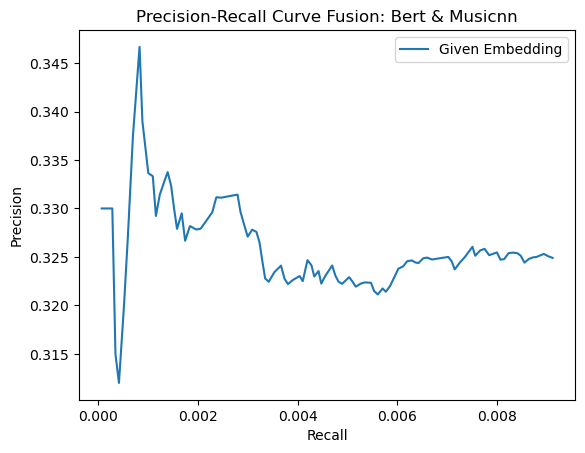

([0.33,
  0.33,
  0.33,
  0.315,
  0.312,
  0.32,
  0.32714285714285707,
  0.3375,
  0.34666666666666673,
  0.3390000000000001,
  0.3336363636363637,
  0.33333333333333326,
  0.3292307692307692,
  0.33142857142857146,
  0.33266666666666667,
  0.33375,
  0.3323529411764706,
  0.33000000000000007,
  0.3278947368421053,
  0.32949999999999996,
  0.32666666666666666,
  0.3281818181818182,
  0.3278260869565217,
  0.32791666666666663,
  0.32960000000000006,
  0.3311538461538462,
  0.33111111111111113,
  0.3314285714285714,
  0.32965517241379305,
  0.32833333333333337,
  0.3270967741935483,
  0.3278125,
  0.3275757575757576,
  0.3264705882352942,
  0.32457142857142857,
  0.3227777777777778,
  0.32243243243243247,
  0.3234210526315789,
  0.3241025641025641,
  0.32275,
  0.3221951219512195,
  0.3226190476190476,
  0.3230232558139535,
  0.3225,
  0.32466666666666666,
  0.32413043478260867,
  0.3229787234042554,
  0.3235416666666666,
  0.32224489795918365,
  0.32300000000000006,
  0.32411764705882

In [41]:
# Specify the sample size
sample_size = 100
k_range = range(1, 101)  # This creates a range from 1 to 100 (inclusive)


calc_avg_recall_precision_fusion(fusion_bert_musicnn, k_range, sample_size)

# Late Fusion Plot

In [36]:
def get_late_fusion(embedding1, embedding2):
    cos_sim_matrix1 = generate_cos_sim_matrix(embedding1)
    cos_sim_matrix2 = generate_cos_sim_matrix(embedding2)
    
    cos_sim_matrix_df = (cos_sim_matrix1 + cos_sim_matrix2)/2
    
    return cos_sim_matrix_df

In [44]:
late_fusion_bert_musicnn = get_late_fusion(bert,musicnn)
late_fusion_bert_musicnn = pd.merge(late_fusion_bert_musicnn, genres, on='id')

(10094, 769)
(10094, 51)


In [ ]:
# Specify the sample size
sample_size = 100
k_range = range(1, 101)  # This creates a range from 1 to 100 (inclusive)


calc_avg_recall_precision_fusion(late_fusion_bert_musicnn, k_range, sample_size)

Processed query K36H0lEtqS3IJgGa for k=1 - Precision: 1.00, Recall: 0.00
Processed query XcDu72gipo0aCTDp for k=1 - Precision: 0.00, Recall: 0.00
Processed query 5VWOD4cBhWkrbWet for k=1 - Precision: 0.00, Recall: 0.00
Processed query R93jlIJhpkr8us7B for k=1 - Precision: 0.00, Recall: 0.00
Processed query lRK06n1HkuHlVdRo for k=1 - Precision: 1.00, Recall: 0.00
Processed query 5ftT5BqtrCNZLduo for k=1 - Precision: 0.00, Recall: 0.00
Processed query 8cuW0Czq9znbWWDF for k=1 - Precision: 0.00, Recall: 0.00
Processed query jR8t5PLmUJOjAb4F for k=1 - Precision: 1.00, Recall: 0.00
Processed query 9SrTKZ0x59yxbHEK for k=1 - Precision: 0.00, Recall: 0.00
Processed query 8kVftLAGITZr615k for k=1 - Precision: 1.00, Recall: 0.00
Processed query yWvF1HBSIWXNwU5v for k=1 - Precision: 1.00, Recall: 0.00
Processed query dOZLy4CMYHUeZbGT for k=1 - Precision: 0.00, Recall: 0.00
Processed query 4SWXyQowIzeDzByN for k=1 - Precision: 1.00, Recall: 0.00
Processed query Itah1m1jjfddZ3KW for k=1 - Precisio

Processed query 4SWXyQowIzeDzByN for k=2 - Precision: 0.50, Recall: 0.00
Processed query Itah1m1jjfddZ3KW for k=2 - Precision: 1.00, Recall: 0.00
Processed query QJUOuZ8EDmC080zG for k=2 - Precision: 0.00, Recall: 0.00
Processed query RZFAxeTNHDjiqDDk for k=2 - Precision: 0.50, Recall: 0.00
Processed query IskjrPr0ynMp4cx5 for k=2 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=2 - Precision: 1.00, Recall: 0.00
Processed query HykZH26WVAumpCBJ for k=2 - Precision: 1.00, Recall: 0.00
Processed query 8imJokmAzphbZ4Xh for k=2 - Precision: 1.00, Recall: 0.00
Processed query 3FMMhyASr6nGnaK4 for k=2 - Precision: 0.50, Recall: 0.00
Processed query ZVjUg4rlqeq2zk7C for k=2 - Precision: 0.50, Recall: 0.00
Processed query x6hE6oTh07da0a0f for k=2 - Precision: 1.00, Recall: 0.00
Processed query 51XYIfDaAUgQXb5u for k=2 - Precision: 0.50, Recall: 0.00
Processed query zu7Ieztdu2L7624a for k=2 - Precision: 0.00, Recall: 0.00
Processed query gMdQONPf9JdWb6MS for k=2 - Precisio

Processed query zu7Ieztdu2L7624a for k=3 - Precision: 0.00, Recall: 0.00
Processed query gMdQONPf9JdWb6MS for k=3 - Precision: 0.67, Recall: 0.00
Processed query 33Dmw7IfH4587uMq for k=3 - Precision: 0.33, Recall: 0.00
Processed query ZLTgggcn9mzPGtBo for k=3 - Precision: 0.33, Recall: 0.00
Processed query LqoA0AAvPqVl1PtB for k=3 - Precision: 0.33, Recall: 0.00
Processed query FNleftK6MGMEccyk for k=3 - Precision: 0.00, Recall: 0.00
Processed query FU5lU3n045QpgrTM for k=3 - Precision: 1.00, Recall: 0.00
Processed query ACjQMt5Cbjjqr0iM for k=3 - Precision: 1.00, Recall: 0.00
Processed query KcCbr0D0Ns3up2aY for k=3 - Precision: 0.00, Recall: 0.00
Processed query gArfXgzD7shidcGf for k=3 - Precision: 0.33, Recall: 0.00
Processed query 9TFM3GpDFLAJQTQ4 for k=3 - Precision: 0.33, Recall: 0.00
Processed query 0PLdz2RKGsXnnTDO for k=3 - Precision: 0.67, Recall: 0.00
Processed query tbF2tUUkAXDzk7sZ for k=3 - Precision: 0.67, Recall: 0.00
Processed query ZyxiskWJuDvcGTYq for k=3 - Precisio

Processed query tbF2tUUkAXDzk7sZ for k=4 - Precision: 0.50, Recall: 0.00
Processed query ZyxiskWJuDvcGTYq for k=4 - Precision: 0.00, Recall: 0.00
Processed query n1g70shgqaVn2taR for k=4 - Precision: 0.00, Recall: 0.00
Processed query JDczWJmb7UM3ckEl for k=4 - Precision: 0.50, Recall: 0.00
Processed query Y39cAEoCjGPvsgXi for k=4 - Precision: 0.00, Recall: 0.00
Processed query PvyKzuD8i6m1qztk for k=4 - Precision: 0.00, Recall: 0.00
Processed query 1H7yQe1NljCbMapi for k=4 - Precision: 0.75, Recall: 0.00
Processed query yY6AbJhiY7HXlPtf for k=4 - Precision: 0.50, Recall: 0.00
Processed query C8hHrdzeQLfPqvL8 for k=4 - Precision: 0.00, Recall: 0.00
Processed query jitmHWx44kFAE4yy for k=4 - Precision: 0.50, Recall: 0.00
Processed query DrYdSKYlfDS5XiEv for k=4 - Precision: 0.50, Recall: 0.00
Processed query 3O8IDBqUK2S3pqF0 for k=4 - Precision: 0.00, Recall: 0.00
Processed query myoCvPb1dyaj0Tf0 for k=4 - Precision: 0.25, Recall: 0.00
Processed query CdsH6MgOMLdkY582 for k=4 - Precisio

Processed query myoCvPb1dyaj0Tf0 for k=5 - Precision: 0.20, Recall: 0.00
Processed query CdsH6MgOMLdkY582 for k=5 - Precision: 0.40, Recall: 0.00
Processed query VmUbfpibcjjJiEqd for k=5 - Precision: 0.60, Recall: 0.00
Processed query k359CixIFRVz3QHM for k=5 - Precision: 0.60, Recall: 0.00
Processed query QH7tv1qz2s78YuRw for k=5 - Precision: 0.20, Recall: 0.00
Processed query RBel2WHKJHRhFRRd for k=5 - Precision: 0.80, Recall: 0.00
Processed query eA7otcM8UibYxfdU for k=5 - Precision: 0.60, Recall: 0.00
Processed query knNh9yJ5u9gGriJ7 for k=5 - Precision: 0.00, Recall: 0.00
Processed query baerAOUagyrMzFlv for k=5 - Precision: 0.80, Recall: 0.00
Processed query hz9qp9N5SV955BlM for k=5 - Precision: 0.00, Recall: 0.00
Processed query tPR5Ai9IkeHwd32t for k=5 - Precision: 0.60, Recall: 0.00
Processed query qgQ0spDgc7ilnN6C for k=5 - Precision: 0.40, Recall: 0.00
Processed query B73dsXi3KH47rONI for k=5 - Precision: 0.00, Recall: 0.00
Processed query MDX3NwMqcCnZj80Z for k=5 - Precisio

Processed query B73dsXi3KH47rONI for k=6 - Precision: 0.00, Recall: 0.00
Processed query MDX3NwMqcCnZj80Z for k=6 - Precision: 0.67, Recall: 0.00
Processed query x1lYeflN0UfkRpWY for k=6 - Precision: 0.50, Recall: 0.00
Processed query cP5xGVKo0BK2njzW for k=6 - Precision: 0.17, Recall: 0.00
Processed query SJTKS9aOWdBeKxKG for k=6 - Precision: 0.50, Recall: 0.00
Processed query qia0KEufEPClHrB9 for k=6 - Precision: 0.67, Recall: 0.00
Processed query fbjU4wiAgu6prbVW for k=6 - Precision: 0.00, Recall: 0.00
Processed query tpNuKQ6SG36keS38 for k=6 - Precision: 0.67, Recall: 0.00
Processed query ef0tWEDbpx8cUwAd for k=6 - Precision: 0.00, Recall: 0.00
Processed query UtB4uXYVhtq5AVW8 for k=6 - Precision: 0.00, Recall: 0.00
Processed query 0IHQDwO3FnNYE7VY for k=6 - Precision: 0.50, Recall: 0.00
Processed query qAYXQNGXXoLd3hyu for k=6 - Precision: 0.00, Recall: 0.00
Processed query S9ppCfJiyWLpqDpD for k=6 - Precision: 0.33, Recall: 0.00
Processed query WAbTyx902fLAd8Q5 for k=6 - Precisio

Processed query S9ppCfJiyWLpqDpD for k=7 - Precision: 0.43, Recall: 0.00
Processed query WAbTyx902fLAd8Q5 for k=7 - Precision: 0.57, Recall: 0.00
Processed query 2Ug2BJtfpP8ZCBEE for k=7 - Precision: 0.00, Recall: 0.00
Processed query rlYEWOpYxNrY5rHO for k=7 - Precision: 0.14, Recall: 0.00
Processed query jGJUNhikVMuw39F5 for k=7 - Precision: 0.14, Recall: 0.00
Processed query jReZjxRp2qpEMyhf for k=7 - Precision: 0.57, Recall: 0.00
Processed query gtOnjIuPPcgLxShP for k=7 - Precision: 0.57, Recall: 0.00
Processed query sg8sZZHqiIEY7D5S for k=7 - Precision: 0.43, Recall: 0.00
Processed query ZbpkHgAWTYhnBNIP for k=7 - Precision: 0.43, Recall: 0.00
Processed query GjdDqcdpz7kX85kl for k=7 - Precision: 0.57, Recall: 0.00
Processed query y4sQsWQuCX7wYgPt for k=7 - Precision: 0.00, Recall: 0.00
Processed query 7Zmwsv7CxnRp5OHR for k=7 - Precision: 0.00, Recall: 0.00
Processed query yHeHLXeI0YnQIWhT for k=7 - Precision: 0.00, Recall: 0.00
Processed query xSXG2u0TzzJVayff for k=7 - Precisio

Processed query yHeHLXeI0YnQIWhT for k=8 - Precision: 0.00, Recall: 0.00
Processed query xSXG2u0TzzJVayff for k=8 - Precision: 0.38, Recall: 0.00
Processed query 0B2bXOAXyevoV57H for k=8 - Precision: 0.38, Recall: 0.00
Processed query 5r1cmqvduj3t3knp for k=8 - Precision: 0.38, Recall: 0.00
Processed query 8uQDKgYxio9X13mW for k=8 - Precision: 0.50, Recall: 0.00
Processed query 1cyfUPFQk1JSdRRw for k=8 - Precision: 0.00, Recall: 0.00
Processed query losLsXKN1j4HtMYI for k=8 - Precision: 0.00, Recall: 0.00
Processed query JlkdYV1tueKwaHxe for k=8 - Precision: 0.25, Recall: 0.00
Processed query WvOHvXca310ggKom for k=8 - Precision: 0.38, Recall: 0.00
Processed query He8NPqGTttEp5ML0 for k=8 - Precision: 0.50, Recall: 0.00
Processed query OwdptJvVgE53lNhW for k=8 - Precision: 0.38, Recall: 0.00
Processed query mKyhP8m8am4hnodk for k=8 - Precision: 0.00, Recall: 0.00
Processed query iJptF9CGibeMr8Hi for k=8 - Precision: 0.12, Recall: 0.00
Processed query 3qnq7Nm1DMbpFq5d for k=8 - Precisio

Processed query iJptF9CGibeMr8Hi for k=9 - Precision: 0.11, Recall: 0.00
Processed query 3qnq7Nm1DMbpFq5d for k=9 - Precision: 0.00, Recall: 0.00
Processed query N5iZYL5Dlg6S7gKW for k=9 - Precision: 0.56, Recall: 0.00
Processed query C7rdNgxhvWzae6iv for k=9 - Precision: 0.44, Recall: 0.00
Avg Precision at k=9: 0.37, Avg Recall at k=9: 0.00

Processed query K36H0lEtqS3IJgGa for k=10 - Precision: 0.70, Recall: 0.00
Processed query XcDu72gipo0aCTDp for k=10 - Precision: 0.30, Recall: 0.00
Processed query 5VWOD4cBhWkrbWet for k=10 - Precision: 0.50, Recall: 0.00
Processed query R93jlIJhpkr8us7B for k=10 - Precision: 0.30, Recall: 0.00
Processed query lRK06n1HkuHlVdRo for k=10 - Precision: 0.30, Recall: 0.00
Processed query 5ftT5BqtrCNZLduo for k=10 - Precision: 0.20, Recall: 0.00
Processed query 8cuW0Czq9znbWWDF for k=10 - Precision: 0.50, Recall: 0.00
Processed query jR8t5PLmUJOjAb4F for k=10 - Precision: 0.70, Recall: 0.00
Processed query 9SrTKZ0x59yxbHEK for k=10 - Precision: 0.40, Re

Processed query 8cuW0Czq9znbWWDF for k=11 - Precision: 0.55, Recall: 0.00
Processed query jR8t5PLmUJOjAb4F for k=11 - Precision: 0.73, Recall: 0.00
Processed query 9SrTKZ0x59yxbHEK for k=11 - Precision: 0.45, Recall: 0.00
Processed query 8kVftLAGITZr615k for k=11 - Precision: 0.73, Recall: 0.00
Processed query yWvF1HBSIWXNwU5v for k=11 - Precision: 0.64, Recall: 0.00
Processed query dOZLy4CMYHUeZbGT for k=11 - Precision: 0.00, Recall: 0.00
Processed query 4SWXyQowIzeDzByN for k=11 - Precision: 0.73, Recall: 0.00
Processed query Itah1m1jjfddZ3KW for k=11 - Precision: 0.55, Recall: 0.00
Processed query QJUOuZ8EDmC080zG for k=11 - Precision: 0.55, Recall: 0.00
Processed query RZFAxeTNHDjiqDDk for k=11 - Precision: 0.45, Recall: 0.00
Processed query IskjrPr0ynMp4cx5 for k=11 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=11 - Precision: 0.73, Recall: 0.00
Processed query HykZH26WVAumpCBJ for k=11 - Precision: 0.73, Recall: 0.00
Processed query 8imJokmAzphbZ4Xh for k

Processed query IskjrPr0ynMp4cx5 for k=12 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=12 - Precision: 0.75, Recall: 0.00
Processed query HykZH26WVAumpCBJ for k=12 - Precision: 0.67, Recall: 0.00
Processed query 8imJokmAzphbZ4Xh for k=12 - Precision: 0.58, Recall: 0.00
Processed query 3FMMhyASr6nGnaK4 for k=12 - Precision: 0.25, Recall: 0.00
Processed query ZVjUg4rlqeq2zk7C for k=12 - Precision: 0.25, Recall: 0.00
Processed query x6hE6oTh07da0a0f for k=12 - Precision: 0.58, Recall: 0.00
Processed query 51XYIfDaAUgQXb5u for k=12 - Precision: 0.58, Recall: 0.00
Processed query zu7Ieztdu2L7624a for k=12 - Precision: 0.08, Recall: 0.00
Processed query gMdQONPf9JdWb6MS for k=12 - Precision: 0.25, Recall: 0.00
Processed query 33Dmw7IfH4587uMq for k=12 - Precision: 0.42, Recall: 0.00
Processed query ZLTgggcn9mzPGtBo for k=12 - Precision: 0.42, Recall: 0.00
Processed query LqoA0AAvPqVl1PtB for k=12 - Precision: 0.25, Recall: 0.00
Processed query FNleftK6MGMEccyk for k

Processed query 33Dmw7IfH4587uMq for k=13 - Precision: 0.38, Recall: 0.00
Processed query ZLTgggcn9mzPGtBo for k=13 - Precision: 0.38, Recall: 0.00
Processed query LqoA0AAvPqVl1PtB for k=13 - Precision: 0.31, Recall: 0.00
Processed query FNleftK6MGMEccyk for k=13 - Precision: 0.08, Recall: 0.00
Processed query FU5lU3n045QpgrTM for k=13 - Precision: 0.54, Recall: 0.00
Processed query ACjQMt5Cbjjqr0iM for k=13 - Precision: 0.62, Recall: 0.00
Processed query KcCbr0D0Ns3up2aY for k=13 - Precision: 0.00, Recall: 0.00
Processed query gArfXgzD7shidcGf for k=13 - Precision: 0.54, Recall: 0.00
Processed query 9TFM3GpDFLAJQTQ4 for k=13 - Precision: 0.69, Recall: 0.00
Processed query 0PLdz2RKGsXnnTDO for k=13 - Precision: 0.69, Recall: 0.00
Processed query tbF2tUUkAXDzk7sZ for k=13 - Precision: 0.23, Recall: 0.00
Processed query ZyxiskWJuDvcGTYq for k=13 - Precision: 0.31, Recall: 0.00
Processed query n1g70shgqaVn2taR for k=13 - Precision: 0.31, Recall: 0.00
Processed query JDczWJmb7UM3ckEl for k

Processed query tbF2tUUkAXDzk7sZ for k=14 - Precision: 0.29, Recall: 0.00
Processed query ZyxiskWJuDvcGTYq for k=14 - Precision: 0.36, Recall: 0.00
Processed query n1g70shgqaVn2taR for k=14 - Precision: 0.36, Recall: 0.00
Processed query JDczWJmb7UM3ckEl for k=14 - Precision: 0.43, Recall: 0.00
Processed query Y39cAEoCjGPvsgXi for k=14 - Precision: 0.14, Recall: 0.00
Processed query PvyKzuD8i6m1qztk for k=14 - Precision: 0.00, Recall: 0.00
Processed query 1H7yQe1NljCbMapi for k=14 - Precision: 0.79, Recall: 0.00
Processed query yY6AbJhiY7HXlPtf for k=14 - Precision: 0.50, Recall: 0.00
Processed query C8hHrdzeQLfPqvL8 for k=14 - Precision: 0.00, Recall: 0.00
Processed query jitmHWx44kFAE4yy for k=14 - Precision: 0.71, Recall: 0.00
Processed query DrYdSKYlfDS5XiEv for k=14 - Precision: 0.21, Recall: 0.00
Processed query 3O8IDBqUK2S3pqF0 for k=14 - Precision: 0.00, Recall: 0.00
Processed query myoCvPb1dyaj0Tf0 for k=14 - Precision: 0.36, Recall: 0.00
Processed query CdsH6MgOMLdkY582 for k

Processed query DrYdSKYlfDS5XiEv for k=15 - Precision: 0.27, Recall: 0.00
Processed query 3O8IDBqUK2S3pqF0 for k=15 - Precision: 0.00, Recall: 0.00
Processed query myoCvPb1dyaj0Tf0 for k=15 - Precision: 0.33, Recall: 0.00
Processed query CdsH6MgOMLdkY582 for k=15 - Precision: 0.53, Recall: 0.00
Processed query VmUbfpibcjjJiEqd for k=15 - Precision: 0.33, Recall: 0.00
Processed query k359CixIFRVz3QHM for k=15 - Precision: 0.60, Recall: 0.00
Processed query QH7tv1qz2s78YuRw for k=15 - Precision: 0.20, Recall: 0.00
Processed query RBel2WHKJHRhFRRd for k=15 - Precision: 0.60, Recall: 0.00
Processed query eA7otcM8UibYxfdU for k=15 - Precision: 0.47, Recall: 0.00
Processed query knNh9yJ5u9gGriJ7 for k=15 - Precision: 0.00, Recall: 0.00
Processed query baerAOUagyrMzFlv for k=15 - Precision: 0.73, Recall: 0.00
Processed query hz9qp9N5SV955BlM for k=15 - Precision: 0.13, Recall: 0.00
Processed query tPR5Ai9IkeHwd32t for k=15 - Precision: 0.47, Recall: 0.00
Processed query qgQ0spDgc7ilnN6C for k

Processed query baerAOUagyrMzFlv for k=16 - Precision: 0.69, Recall: 0.00
Processed query hz9qp9N5SV955BlM for k=16 - Precision: 0.12, Recall: 0.00
Processed query tPR5Ai9IkeHwd32t for k=16 - Precision: 0.44, Recall: 0.00
Processed query qgQ0spDgc7ilnN6C for k=16 - Precision: 0.25, Recall: 0.00
Processed query B73dsXi3KH47rONI for k=16 - Precision: 0.00, Recall: 0.00
Processed query MDX3NwMqcCnZj80Z for k=16 - Precision: 0.44, Recall: 0.00
Processed query x1lYeflN0UfkRpWY for k=16 - Precision: 0.31, Recall: 0.00
Processed query cP5xGVKo0BK2njzW for k=16 - Precision: 0.25, Recall: 0.00
Processed query SJTKS9aOWdBeKxKG for k=16 - Precision: 0.50, Recall: 0.00
Processed query qia0KEufEPClHrB9 for k=16 - Precision: 0.44, Recall: 0.00
Processed query fbjU4wiAgu6prbVW for k=16 - Precision: 0.06, Recall: 0.00
Processed query tpNuKQ6SG36keS38 for k=16 - Precision: 0.62, Recall: 0.00
Processed query ef0tWEDbpx8cUwAd for k=16 - Precision: 0.06, Recall: 0.01
Processed query UtB4uXYVhtq5AVW8 for k

Processed query fbjU4wiAgu6prbVW for k=17 - Precision: 0.06, Recall: 0.00
Processed query tpNuKQ6SG36keS38 for k=17 - Precision: 0.65, Recall: 0.00
Processed query ef0tWEDbpx8cUwAd for k=17 - Precision: 0.06, Recall: 0.01
Processed query UtB4uXYVhtq5AVW8 for k=17 - Precision: 0.06, Recall: 0.00
Processed query 0IHQDwO3FnNYE7VY for k=17 - Precision: 0.65, Recall: 0.00
Processed query qAYXQNGXXoLd3hyu for k=17 - Precision: 0.00, Recall: 0.00
Processed query S9ppCfJiyWLpqDpD for k=17 - Precision: 0.47, Recall: 0.00
Processed query WAbTyx902fLAd8Q5 for k=17 - Precision: 0.53, Recall: 0.00
Processed query 2Ug2BJtfpP8ZCBEE for k=17 - Precision: 0.00, Recall: 0.00
Processed query rlYEWOpYxNrY5rHO for k=17 - Precision: 0.18, Recall: 0.00
Processed query jGJUNhikVMuw39F5 for k=17 - Precision: 0.12, Recall: 0.00
Processed query jReZjxRp2qpEMyhf for k=17 - Precision: 0.71, Recall: 0.00
Processed query gtOnjIuPPcgLxShP for k=17 - Precision: 0.47, Recall: 0.00
Processed query sg8sZZHqiIEY7D5S for k

Processed query jGJUNhikVMuw39F5 for k=18 - Precision: 0.11, Recall: 0.00
Processed query jReZjxRp2qpEMyhf for k=18 - Precision: 0.67, Recall: 0.00
Processed query gtOnjIuPPcgLxShP for k=18 - Precision: 0.50, Recall: 0.00
Processed query sg8sZZHqiIEY7D5S for k=18 - Precision: 0.33, Recall: 0.00
Processed query ZbpkHgAWTYhnBNIP for k=18 - Precision: 0.50, Recall: 0.00
Processed query GjdDqcdpz7kX85kl for k=18 - Precision: 0.61, Recall: 0.00
Processed query y4sQsWQuCX7wYgPt for k=18 - Precision: 0.00, Recall: 0.00
Processed query 7Zmwsv7CxnRp5OHR for k=18 - Precision: 0.22, Recall: 0.00
Processed query yHeHLXeI0YnQIWhT for k=18 - Precision: 0.00, Recall: 0.00
Processed query xSXG2u0TzzJVayff for k=18 - Precision: 0.67, Recall: 0.00
Processed query 0B2bXOAXyevoV57H for k=18 - Precision: 0.50, Recall: 0.00
Processed query 5r1cmqvduj3t3knp for k=18 - Precision: 0.33, Recall: 0.00
Processed query 8uQDKgYxio9X13mW for k=18 - Precision: 0.39, Recall: 0.00
Processed query 1cyfUPFQk1JSdRRw for k

Processed query 0B2bXOAXyevoV57H for k=19 - Precision: 0.53, Recall: 0.00
Processed query 5r1cmqvduj3t3knp for k=19 - Precision: 0.37, Recall: 0.00
Processed query 8uQDKgYxio9X13mW for k=19 - Precision: 0.37, Recall: 0.00
Processed query 1cyfUPFQk1JSdRRw for k=19 - Precision: 0.05, Recall: 0.02
Processed query losLsXKN1j4HtMYI for k=19 - Precision: 0.05, Recall: 0.00
Processed query JlkdYV1tueKwaHxe for k=19 - Precision: 0.32, Recall: 0.00
Processed query WvOHvXca310ggKom for k=19 - Precision: 0.32, Recall: 0.00
Processed query He8NPqGTttEp5ML0 for k=19 - Precision: 0.37, Recall: 0.00
Processed query OwdptJvVgE53lNhW for k=19 - Precision: 0.32, Recall: 0.00
Processed query mKyhP8m8am4hnodk for k=19 - Precision: 0.00, Recall: 0.00
Processed query iJptF9CGibeMr8Hi for k=19 - Precision: 0.11, Recall: 0.00
Processed query 3qnq7Nm1DMbpFq5d for k=19 - Precision: 0.00, Recall: 0.00
Processed query N5iZYL5Dlg6S7gKW for k=19 - Precision: 0.63, Recall: 0.00
Processed query C7rdNgxhvWzae6iv for k

Processed query iJptF9CGibeMr8Hi for k=20 - Precision: 0.10, Recall: 0.00
Processed query 3qnq7Nm1DMbpFq5d for k=20 - Precision: 0.00, Recall: 0.00
Processed query N5iZYL5Dlg6S7gKW for k=20 - Precision: 0.60, Recall: 0.00
Processed query C7rdNgxhvWzae6iv for k=20 - Precision: 0.40, Recall: 0.00
Avg Precision at k=20: 0.36, Avg Recall at k=20: 0.00

Processed query K36H0lEtqS3IJgGa for k=21 - Precision: 0.67, Recall: 0.00
Processed query XcDu72gipo0aCTDp for k=21 - Precision: 0.24, Recall: 0.00
Processed query 5VWOD4cBhWkrbWet for k=21 - Precision: 0.48, Recall: 0.00
Processed query R93jlIJhpkr8us7B for k=21 - Precision: 0.14, Recall: 0.00
Processed query lRK06n1HkuHlVdRo for k=21 - Precision: 0.24, Recall: 0.00
Processed query 5ftT5BqtrCNZLduo for k=21 - Precision: 0.10, Recall: 0.00
Processed query 8cuW0Czq9znbWWDF for k=21 - Precision: 0.62, Recall: 0.00
Processed query jR8t5PLmUJOjAb4F for k=21 - Precision: 0.67, Recall: 0.00
Processed query 9SrTKZ0x59yxbHEK for k=21 - Precision: 0.

Processed query 8cuW0Czq9znbWWDF for k=22 - Precision: 0.64, Recall: 0.00
Processed query jR8t5PLmUJOjAb4F for k=22 - Precision: 0.68, Recall: 0.00
Processed query 9SrTKZ0x59yxbHEK for k=22 - Precision: 0.55, Recall: 0.00
Processed query 8kVftLAGITZr615k for k=22 - Precision: 0.41, Recall: 0.00
Processed query yWvF1HBSIWXNwU5v for k=22 - Precision: 0.68, Recall: 0.00
Processed query dOZLy4CMYHUeZbGT for k=22 - Precision: 0.14, Recall: 0.00
Processed query 4SWXyQowIzeDzByN for k=22 - Precision: 0.64, Recall: 0.00
Processed query Itah1m1jjfddZ3KW for k=22 - Precision: 0.45, Recall: 0.00
Processed query QJUOuZ8EDmC080zG for k=22 - Precision: 0.55, Recall: 0.00
Processed query RZFAxeTNHDjiqDDk for k=22 - Precision: 0.41, Recall: 0.00
Processed query IskjrPr0ynMp4cx5 for k=22 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=22 - Precision: 0.59, Recall: 0.00
Processed query HykZH26WVAumpCBJ for k=22 - Precision: 0.68, Recall: 0.00
Processed query 8imJokmAzphbZ4Xh for k

Processed query IskjrPr0ynMp4cx5 for k=23 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=23 - Precision: 0.57, Recall: 0.00
Processed query HykZH26WVAumpCBJ for k=23 - Precision: 0.65, Recall: 0.00
Processed query 8imJokmAzphbZ4Xh for k=23 - Precision: 0.48, Recall: 0.00
Processed query 3FMMhyASr6nGnaK4 for k=23 - Precision: 0.30, Recall: 0.00
Processed query ZVjUg4rlqeq2zk7C for k=23 - Precision: 0.26, Recall: 0.00
Processed query x6hE6oTh07da0a0f for k=23 - Precision: 0.52, Recall: 0.00
Processed query 51XYIfDaAUgQXb5u for k=23 - Precision: 0.52, Recall: 0.00
Processed query zu7Ieztdu2L7624a for k=23 - Precision: 0.13, Recall: 0.00
Processed query gMdQONPf9JdWb6MS for k=23 - Precision: 0.39, Recall: 0.00
Processed query 33Dmw7IfH4587uMq for k=23 - Precision: 0.30, Recall: 0.00
Processed query ZLTgggcn9mzPGtBo for k=23 - Precision: 0.26, Recall: 0.00
Processed query LqoA0AAvPqVl1PtB for k=23 - Precision: 0.39, Recall: 0.00
Processed query FNleftK6MGMEccyk for k

Processed query 33Dmw7IfH4587uMq for k=24 - Precision: 0.29, Recall: 0.00
Processed query ZLTgggcn9mzPGtBo for k=24 - Precision: 0.25, Recall: 0.00
Processed query LqoA0AAvPqVl1PtB for k=24 - Precision: 0.38, Recall: 0.00
Processed query FNleftK6MGMEccyk for k=24 - Precision: 0.04, Recall: 0.00
Processed query FU5lU3n045QpgrTM for k=24 - Precision: 0.58, Recall: 0.00
Processed query ACjQMt5Cbjjqr0iM for k=24 - Precision: 0.54, Recall: 0.00
Processed query KcCbr0D0Ns3up2aY for k=24 - Precision: 0.00, Recall: 0.00
Processed query gArfXgzD7shidcGf for k=24 - Precision: 0.54, Recall: 0.00
Processed query 9TFM3GpDFLAJQTQ4 for k=24 - Precision: 0.54, Recall: 0.00
Processed query 0PLdz2RKGsXnnTDO for k=24 - Precision: 0.67, Recall: 0.00
Processed query tbF2tUUkAXDzk7sZ for k=24 - Precision: 0.38, Recall: 0.00
Processed query ZyxiskWJuDvcGTYq for k=24 - Precision: 0.42, Recall: 0.00
Processed query n1g70shgqaVn2taR for k=24 - Precision: 0.38, Recall: 0.00
Processed query JDczWJmb7UM3ckEl for k

Processed query tbF2tUUkAXDzk7sZ for k=25 - Precision: 0.36, Recall: 0.00
Processed query ZyxiskWJuDvcGTYq for k=25 - Precision: 0.40, Recall: 0.00
Processed query n1g70shgqaVn2taR for k=25 - Precision: 0.40, Recall: 0.00
Processed query JDczWJmb7UM3ckEl for k=25 - Precision: 0.32, Recall: 0.00
Processed query Y39cAEoCjGPvsgXi for k=25 - Precision: 0.16, Recall: 0.00
Processed query PvyKzuD8i6m1qztk for k=25 - Precision: 0.04, Recall: 0.00
Processed query 1H7yQe1NljCbMapi for k=25 - Precision: 0.56, Recall: 0.00
Processed query yY6AbJhiY7HXlPtf for k=25 - Precision: 0.52, Recall: 0.00
Processed query C8hHrdzeQLfPqvL8 for k=25 - Precision: 0.00, Recall: 0.00
Processed query jitmHWx44kFAE4yy for k=25 - Precision: 0.76, Recall: 0.00
Processed query DrYdSKYlfDS5XiEv for k=25 - Precision: 0.20, Recall: 0.00
Processed query 3O8IDBqUK2S3pqF0 for k=25 - Precision: 0.00, Recall: 0.00
Processed query myoCvPb1dyaj0Tf0 for k=25 - Precision: 0.40, Recall: 0.00
Processed query CdsH6MgOMLdkY582 for k

Processed query DrYdSKYlfDS5XiEv for k=26 - Precision: 0.19, Recall: 0.00
Processed query 3O8IDBqUK2S3pqF0 for k=26 - Precision: 0.00, Recall: 0.00
Processed query myoCvPb1dyaj0Tf0 for k=26 - Precision: 0.42, Recall: 0.00
Processed query CdsH6MgOMLdkY582 for k=26 - Precision: 0.62, Recall: 0.00
Processed query VmUbfpibcjjJiEqd for k=26 - Precision: 0.38, Recall: 0.00
Processed query k359CixIFRVz3QHM for k=26 - Precision: 0.62, Recall: 0.00
Processed query QH7tv1qz2s78YuRw for k=26 - Precision: 0.23, Recall: 0.00
Processed query RBel2WHKJHRhFRRd for k=26 - Precision: 0.73, Recall: 0.00
Processed query eA7otcM8UibYxfdU for k=26 - Precision: 0.62, Recall: 0.00
Processed query knNh9yJ5u9gGriJ7 for k=26 - Precision: 0.04, Recall: 0.01
Processed query baerAOUagyrMzFlv for k=26 - Precision: 0.58, Recall: 0.00
Processed query hz9qp9N5SV955BlM for k=26 - Precision: 0.31, Recall: 0.00
Processed query tPR5Ai9IkeHwd32t for k=26 - Precision: 0.42, Recall: 0.00
Processed query qgQ0spDgc7ilnN6C for k

Processed query baerAOUagyrMzFlv for k=27 - Precision: 0.59, Recall: 0.00
Processed query hz9qp9N5SV955BlM for k=27 - Precision: 0.33, Recall: 0.00
Processed query tPR5Ai9IkeHwd32t for k=27 - Precision: 0.44, Recall: 0.00
Processed query qgQ0spDgc7ilnN6C for k=27 - Precision: 0.22, Recall: 0.00
Processed query B73dsXi3KH47rONI for k=27 - Precision: 0.00, Recall: 0.00
Processed query MDX3NwMqcCnZj80Z for k=27 - Precision: 0.37, Recall: 0.00
Processed query x1lYeflN0UfkRpWY for k=27 - Precision: 0.30, Recall: 0.00
Processed query cP5xGVKo0BK2njzW for k=27 - Precision: 0.37, Recall: 0.00
Processed query SJTKS9aOWdBeKxKG for k=27 - Precision: 0.59, Recall: 0.00
Processed query qia0KEufEPClHrB9 for k=27 - Precision: 0.44, Recall: 0.00
Processed query fbjU4wiAgu6prbVW for k=27 - Precision: 0.19, Recall: 0.00
Processed query tpNuKQ6SG36keS38 for k=27 - Precision: 0.56, Recall: 0.00
Processed query ef0tWEDbpx8cUwAd for k=27 - Precision: 0.04, Recall: 0.01
Processed query UtB4uXYVhtq5AVW8 for k

Processed query fbjU4wiAgu6prbVW for k=28 - Precision: 0.18, Recall: 0.00
Processed query tpNuKQ6SG36keS38 for k=28 - Precision: 0.57, Recall: 0.00
Processed query ef0tWEDbpx8cUwAd for k=28 - Precision: 0.04, Recall: 0.01
Processed query UtB4uXYVhtq5AVW8 for k=28 - Precision: 0.04, Recall: 0.00
Processed query 0IHQDwO3FnNYE7VY for k=28 - Precision: 0.71, Recall: 0.00
Processed query qAYXQNGXXoLd3hyu for k=28 - Precision: 0.00, Recall: 0.00
Processed query S9ppCfJiyWLpqDpD for k=28 - Precision: 0.29, Recall: 0.00
Processed query WAbTyx902fLAd8Q5 for k=28 - Precision: 0.54, Recall: 0.00
Processed query 2Ug2BJtfpP8ZCBEE for k=28 - Precision: 0.00, Recall: 0.00
Processed query rlYEWOpYxNrY5rHO for k=28 - Precision: 0.29, Recall: 0.00
Processed query jGJUNhikVMuw39F5 for k=28 - Precision: 0.18, Recall: 0.00
Processed query jReZjxRp2qpEMyhf for k=28 - Precision: 0.61, Recall: 0.00
Processed query gtOnjIuPPcgLxShP for k=28 - Precision: 0.50, Recall: 0.00
Processed query sg8sZZHqiIEY7D5S for k

Processed query jGJUNhikVMuw39F5 for k=29 - Precision: 0.17, Recall: 0.00
Processed query jReZjxRp2qpEMyhf for k=29 - Precision: 0.59, Recall: 0.00
Processed query gtOnjIuPPcgLxShP for k=29 - Precision: 0.48, Recall: 0.00
Processed query sg8sZZHqiIEY7D5S for k=29 - Precision: 0.41, Recall: 0.00
Processed query ZbpkHgAWTYhnBNIP for k=29 - Precision: 0.59, Recall: 0.00
Processed query GjdDqcdpz7kX85kl for k=29 - Precision: 0.55, Recall: 0.00
Processed query y4sQsWQuCX7wYgPt for k=29 - Precision: 0.03, Recall: 0.00
Processed query 7Zmwsv7CxnRp5OHR for k=29 - Precision: 0.17, Recall: 0.00
Processed query yHeHLXeI0YnQIWhT for k=29 - Precision: 0.00, Recall: 0.00
Processed query xSXG2u0TzzJVayff for k=29 - Precision: 0.69, Recall: 0.00
Processed query 0B2bXOAXyevoV57H for k=29 - Precision: 0.48, Recall: 0.00
Processed query 5r1cmqvduj3t3knp for k=29 - Precision: 0.31, Recall: 0.00
Processed query 8uQDKgYxio9X13mW for k=29 - Precision: 0.48, Recall: 0.00
Processed query 1cyfUPFQk1JSdRRw for k

Processed query 0B2bXOAXyevoV57H for k=30 - Precision: 0.50, Recall: 0.00
Processed query 5r1cmqvduj3t3knp for k=30 - Precision: 0.30, Recall: 0.00
Processed query 8uQDKgYxio9X13mW for k=30 - Precision: 0.50, Recall: 0.00
Processed query 1cyfUPFQk1JSdRRw for k=30 - Precision: 0.03, Recall: 0.02
Processed query losLsXKN1j4HtMYI for k=30 - Precision: 0.03, Recall: 0.00
Processed query JlkdYV1tueKwaHxe for k=30 - Precision: 0.37, Recall: 0.00
Processed query WvOHvXca310ggKom for k=30 - Precision: 0.37, Recall: 0.00
Processed query He8NPqGTttEp5ML0 for k=30 - Precision: 0.47, Recall: 0.00
Processed query OwdptJvVgE53lNhW for k=30 - Precision: 0.47, Recall: 0.00
Processed query mKyhP8m8am4hnodk for k=30 - Precision: 0.00, Recall: 0.00
Processed query iJptF9CGibeMr8Hi for k=30 - Precision: 0.10, Recall: 0.00
Processed query 3qnq7Nm1DMbpFq5d for k=30 - Precision: 0.00, Recall: 0.00
Processed query N5iZYL5Dlg6S7gKW for k=30 - Precision: 0.63, Recall: 0.00
Processed query C7rdNgxhvWzae6iv for k

Processed query iJptF9CGibeMr8Hi for k=31 - Precision: 0.10, Recall: 0.00
Processed query 3qnq7Nm1DMbpFq5d for k=31 - Precision: 0.00, Recall: 0.00
Processed query N5iZYL5Dlg6S7gKW for k=31 - Precision: 0.65, Recall: 0.00
Processed query C7rdNgxhvWzae6iv for k=31 - Precision: 0.29, Recall: 0.00
Avg Precision at k=31: 0.36, Avg Recall at k=31: 0.00

Processed query K36H0lEtqS3IJgGa for k=32 - Precision: 0.62, Recall: 0.00
Processed query XcDu72gipo0aCTDp for k=32 - Precision: 0.28, Recall: 0.00
Processed query 5VWOD4cBhWkrbWet for k=32 - Precision: 0.44, Recall: 0.00
Processed query R93jlIJhpkr8us7B for k=32 - Precision: 0.16, Recall: 0.00
Processed query lRK06n1HkuHlVdRo for k=32 - Precision: 0.25, Recall: 0.00
Processed query 5ftT5BqtrCNZLduo for k=32 - Precision: 0.06, Recall: 0.00
Processed query 8cuW0Czq9znbWWDF for k=32 - Precision: 0.75, Recall: 0.00
Processed query jR8t5PLmUJOjAb4F for k=32 - Precision: 0.66, Recall: 0.00
Processed query 9SrTKZ0x59yxbHEK for k=32 - Precision: 0.

Processed query 8cuW0Czq9znbWWDF for k=33 - Precision: 0.76, Recall: 0.00
Processed query jR8t5PLmUJOjAb4F for k=33 - Precision: 0.64, Recall: 0.00
Processed query 9SrTKZ0x59yxbHEK for k=33 - Precision: 0.67, Recall: 0.00
Processed query 8kVftLAGITZr615k for k=33 - Precision: 0.45, Recall: 0.00
Processed query yWvF1HBSIWXNwU5v for k=33 - Precision: 0.70, Recall: 0.00
Processed query dOZLy4CMYHUeZbGT for k=33 - Precision: 0.15, Recall: 0.00
Processed query 4SWXyQowIzeDzByN for k=33 - Precision: 0.67, Recall: 0.00
Processed query Itah1m1jjfddZ3KW for k=33 - Precision: 0.48, Recall: 0.00
Processed query QJUOuZ8EDmC080zG for k=33 - Precision: 0.48, Recall: 0.00
Processed query RZFAxeTNHDjiqDDk for k=33 - Precision: 0.48, Recall: 0.00
Processed query IskjrPr0ynMp4cx5 for k=33 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=33 - Precision: 0.55, Recall: 0.00
Processed query HykZH26WVAumpCBJ for k=33 - Precision: 0.61, Recall: 0.00
Processed query 8imJokmAzphbZ4Xh for k

Processed query IskjrPr0ynMp4cx5 for k=34 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=34 - Precision: 0.53, Recall: 0.00
Processed query HykZH26WVAumpCBJ for k=34 - Precision: 0.59, Recall: 0.00
Processed query 8imJokmAzphbZ4Xh for k=34 - Precision: 0.41, Recall: 0.00
Processed query 3FMMhyASr6nGnaK4 for k=34 - Precision: 0.35, Recall: 0.00
Processed query ZVjUg4rlqeq2zk7C for k=34 - Precision: 0.26, Recall: 0.00
Processed query x6hE6oTh07da0a0f for k=34 - Precision: 0.59, Recall: 0.00
Processed query 51XYIfDaAUgQXb5u for k=34 - Precision: 0.59, Recall: 0.00
Processed query zu7Ieztdu2L7624a for k=34 - Precision: 0.15, Recall: 0.00
Processed query gMdQONPf9JdWb6MS for k=34 - Precision: 0.56, Recall: 0.00
Processed query 33Dmw7IfH4587uMq for k=34 - Precision: 0.24, Recall: 0.00
Processed query ZLTgggcn9mzPGtBo for k=34 - Precision: 0.26, Recall: 0.00
Processed query LqoA0AAvPqVl1PtB for k=34 - Precision: 0.35, Recall: 0.00
Processed query FNleftK6MGMEccyk for k

Processed query 33Dmw7IfH4587uMq for k=35 - Precision: 0.23, Recall: 0.00
Processed query ZLTgggcn9mzPGtBo for k=35 - Precision: 0.26, Recall: 0.00
Processed query LqoA0AAvPqVl1PtB for k=35 - Precision: 0.34, Recall: 0.00
Processed query FNleftK6MGMEccyk for k=35 - Precision: 0.06, Recall: 0.00
Processed query FU5lU3n045QpgrTM for k=35 - Precision: 0.63, Recall: 0.00
Processed query ACjQMt5Cbjjqr0iM for k=35 - Precision: 0.40, Recall: 0.00
Processed query KcCbr0D0Ns3up2aY for k=35 - Precision: 0.03, Recall: 0.00
Processed query gArfXgzD7shidcGf for k=35 - Precision: 0.60, Recall: 0.00
Processed query 9TFM3GpDFLAJQTQ4 for k=35 - Precision: 0.49, Recall: 0.00
Processed query 0PLdz2RKGsXnnTDO for k=35 - Precision: 0.57, Recall: 0.00
Processed query tbF2tUUkAXDzk7sZ for k=35 - Precision: 0.40, Recall: 0.00
Processed query ZyxiskWJuDvcGTYq for k=35 - Precision: 0.40, Recall: 0.00
Processed query n1g70shgqaVn2taR for k=35 - Precision: 0.40, Recall: 0.00
Processed query JDczWJmb7UM3ckEl for k

Processed query tbF2tUUkAXDzk7sZ for k=36 - Precision: 0.39, Recall: 0.00
Processed query ZyxiskWJuDvcGTYq for k=36 - Precision: 0.42, Recall: 0.00
Processed query n1g70shgqaVn2taR for k=36 - Precision: 0.42, Recall: 0.00
Processed query JDczWJmb7UM3ckEl for k=36 - Precision: 0.31, Recall: 0.00
Processed query Y39cAEoCjGPvsgXi for k=36 - Precision: 0.17, Recall: 0.00
Processed query PvyKzuD8i6m1qztk for k=36 - Precision: 0.03, Recall: 0.00
Processed query 1H7yQe1NljCbMapi for k=36 - Precision: 0.53, Recall: 0.00
Processed query yY6AbJhiY7HXlPtf for k=36 - Precision: 0.56, Recall: 0.00
Processed query C8hHrdzeQLfPqvL8 for k=36 - Precision: 0.00, Recall: 0.00
Processed query jitmHWx44kFAE4yy for k=36 - Precision: 0.64, Recall: 0.00
Processed query DrYdSKYlfDS5XiEv for k=36 - Precision: 0.19, Recall: 0.00
Processed query 3O8IDBqUK2S3pqF0 for k=36 - Precision: 0.00, Recall: 0.00
Processed query myoCvPb1dyaj0Tf0 for k=36 - Precision: 0.36, Recall: 0.00
Processed query CdsH6MgOMLdkY582 for k

Processed query DrYdSKYlfDS5XiEv for k=37 - Precision: 0.19, Recall: 0.00
Processed query 3O8IDBqUK2S3pqF0 for k=37 - Precision: 0.00, Recall: 0.00
Processed query myoCvPb1dyaj0Tf0 for k=37 - Precision: 0.35, Recall: 0.00
Processed query CdsH6MgOMLdkY582 for k=37 - Precision: 0.57, Recall: 0.00
Processed query VmUbfpibcjjJiEqd for k=37 - Precision: 0.32, Recall: 0.00
Processed query k359CixIFRVz3QHM for k=37 - Precision: 0.68, Recall: 0.00
Processed query QH7tv1qz2s78YuRw for k=37 - Precision: 0.19, Recall: 0.00
Processed query RBel2WHKJHRhFRRd for k=37 - Precision: 0.62, Recall: 0.00
Processed query eA7otcM8UibYxfdU for k=37 - Precision: 0.62, Recall: 0.00
Processed query knNh9yJ5u9gGriJ7 for k=37 - Precision: 0.03, Recall: 0.01
Processed query baerAOUagyrMzFlv for k=37 - Precision: 0.59, Recall: 0.00
Processed query hz9qp9N5SV955BlM for k=37 - Precision: 0.35, Recall: 0.00
Processed query tPR5Ai9IkeHwd32t for k=37 - Precision: 0.46, Recall: 0.00
Processed query qgQ0spDgc7ilnN6C for k

Processed query baerAOUagyrMzFlv for k=38 - Precision: 0.61, Recall: 0.00
Processed query hz9qp9N5SV955BlM for k=38 - Precision: 0.37, Recall: 0.00
Processed query tPR5Ai9IkeHwd32t for k=38 - Precision: 0.47, Recall: 0.00
Processed query qgQ0spDgc7ilnN6C for k=38 - Precision: 0.21, Recall: 0.01
Processed query B73dsXi3KH47rONI for k=38 - Precision: 0.00, Recall: 0.00
Processed query MDX3NwMqcCnZj80Z for k=38 - Precision: 0.34, Recall: 0.01
Processed query x1lYeflN0UfkRpWY for k=38 - Precision: 0.34, Recall: 0.00
Processed query cP5xGVKo0BK2njzW for k=38 - Precision: 0.34, Recall: 0.00
Processed query SJTKS9aOWdBeKxKG for k=38 - Precision: 0.63, Recall: 0.00
Processed query qia0KEufEPClHrB9 for k=38 - Precision: 0.45, Recall: 0.00
Processed query fbjU4wiAgu6prbVW for k=38 - Precision: 0.21, Recall: 0.01
Processed query tpNuKQ6SG36keS38 for k=38 - Precision: 0.63, Recall: 0.00
Processed query ef0tWEDbpx8cUwAd for k=38 - Precision: 0.03, Recall: 0.01
Processed query UtB4uXYVhtq5AVW8 for k

Processed query fbjU4wiAgu6prbVW for k=39 - Precision: 0.21, Recall: 0.01
Processed query tpNuKQ6SG36keS38 for k=39 - Precision: 0.64, Recall: 0.00
Processed query ef0tWEDbpx8cUwAd for k=39 - Precision: 0.03, Recall: 0.01
Processed query UtB4uXYVhtq5AVW8 for k=39 - Precision: 0.03, Recall: 0.00
Processed query 0IHQDwO3FnNYE7VY for k=39 - Precision: 0.64, Recall: 0.00
Processed query qAYXQNGXXoLd3hyu for k=39 - Precision: 0.03, Recall: 0.01
Processed query S9ppCfJiyWLpqDpD for k=39 - Precision: 0.23, Recall: 0.00
Processed query WAbTyx902fLAd8Q5 for k=39 - Precision: 0.56, Recall: 0.00
Processed query 2Ug2BJtfpP8ZCBEE for k=39 - Precision: 0.03, Recall: 0.01
Processed query rlYEWOpYxNrY5rHO for k=39 - Precision: 0.36, Recall: 0.00
Processed query jGJUNhikVMuw39F5 for k=39 - Precision: 0.13, Recall: 0.00
Processed query jReZjxRp2qpEMyhf for k=39 - Precision: 0.56, Recall: 0.00
Processed query gtOnjIuPPcgLxShP for k=39 - Precision: 0.54, Recall: 0.00
Processed query sg8sZZHqiIEY7D5S for k

Processed query jGJUNhikVMuw39F5 for k=40 - Precision: 0.12, Recall: 0.00
Processed query jReZjxRp2qpEMyhf for k=40 - Precision: 0.57, Recall: 0.00
Processed query gtOnjIuPPcgLxShP for k=40 - Precision: 0.53, Recall: 0.00
Processed query sg8sZZHqiIEY7D5S for k=40 - Precision: 0.50, Recall: 0.00
Processed query ZbpkHgAWTYhnBNIP for k=40 - Precision: 0.60, Recall: 0.00
Processed query GjdDqcdpz7kX85kl for k=40 - Precision: 0.57, Recall: 0.00
Processed query y4sQsWQuCX7wYgPt for k=40 - Precision: 0.03, Recall: 0.00
Processed query 7Zmwsv7CxnRp5OHR for k=40 - Precision: 0.15, Recall: 0.00
Processed query yHeHLXeI0YnQIWhT for k=40 - Precision: 0.00, Recall: 0.00
Processed query xSXG2u0TzzJVayff for k=40 - Precision: 0.70, Recall: 0.00
Processed query 0B2bXOAXyevoV57H for k=40 - Precision: 0.53, Recall: 0.00
Processed query 5r1cmqvduj3t3knp for k=40 - Precision: 0.33, Recall: 0.00
Processed query 8uQDKgYxio9X13mW for k=40 - Precision: 0.47, Recall: 0.00
Processed query 1cyfUPFQk1JSdRRw for k

Processed query 0B2bXOAXyevoV57H for k=41 - Precision: 0.51, Recall: 0.00
Processed query 5r1cmqvduj3t3knp for k=41 - Precision: 0.32, Recall: 0.00
Processed query 8uQDKgYxio9X13mW for k=41 - Precision: 0.46, Recall: 0.00
Processed query 1cyfUPFQk1JSdRRw for k=41 - Precision: 0.02, Recall: 0.02
Processed query losLsXKN1j4HtMYI for k=41 - Precision: 0.10, Recall: 0.00
Processed query JlkdYV1tueKwaHxe for k=41 - Precision: 0.39, Recall: 0.00
Processed query WvOHvXca310ggKom for k=41 - Precision: 0.37, Recall: 0.00
Processed query He8NPqGTttEp5ML0 for k=41 - Precision: 0.51, Recall: 0.00
Processed query OwdptJvVgE53lNhW for k=41 - Precision: 0.49, Recall: 0.00
Processed query mKyhP8m8am4hnodk for k=41 - Precision: 0.00, Recall: 0.00
Processed query iJptF9CGibeMr8Hi for k=41 - Precision: 0.10, Recall: 0.00
Processed query 3qnq7Nm1DMbpFq5d for k=41 - Precision: 0.00, Recall: 0.00
Processed query N5iZYL5Dlg6S7gKW for k=41 - Precision: 0.56, Recall: 0.00
Processed query C7rdNgxhvWzae6iv for k

Processed query iJptF9CGibeMr8Hi for k=42 - Precision: 0.10, Recall: 0.00
Processed query 3qnq7Nm1DMbpFq5d for k=42 - Precision: 0.00, Recall: 0.00
Processed query N5iZYL5Dlg6S7gKW for k=42 - Precision: 0.57, Recall: 0.00
Processed query C7rdNgxhvWzae6iv for k=42 - Precision: 0.31, Recall: 0.00
Avg Precision at k=42: 0.36, Avg Recall at k=42: 0.00

Processed query K36H0lEtqS3IJgGa for k=43 - Precision: 0.65, Recall: 0.00
Processed query XcDu72gipo0aCTDp for k=43 - Precision: 0.30, Recall: 0.00
Processed query 5VWOD4cBhWkrbWet for k=43 - Precision: 0.44, Recall: 0.00
Processed query R93jlIJhpkr8us7B for k=43 - Precision: 0.12, Recall: 0.00
Processed query lRK06n1HkuHlVdRo for k=43 - Precision: 0.26, Recall: 0.00
Processed query 5ftT5BqtrCNZLduo for k=43 - Precision: 0.05, Recall: 0.00
Processed query 8cuW0Czq9znbWWDF for k=43 - Precision: 0.77, Recall: 0.00
Processed query jR8t5PLmUJOjAb4F for k=43 - Precision: 0.60, Recall: 0.00
Processed query 9SrTKZ0x59yxbHEK for k=43 - Precision: 0.

Processed query 8cuW0Czq9znbWWDF for k=44 - Precision: 0.77, Recall: 0.00
Processed query jR8t5PLmUJOjAb4F for k=44 - Precision: 0.59, Recall: 0.00
Processed query 9SrTKZ0x59yxbHEK for k=44 - Precision: 0.68, Recall: 0.00
Processed query 8kVftLAGITZr615k for k=44 - Precision: 0.50, Recall: 0.00
Processed query yWvF1HBSIWXNwU5v for k=44 - Precision: 0.70, Recall: 0.00
Processed query dOZLy4CMYHUeZbGT for k=44 - Precision: 0.16, Recall: 0.00
Processed query 4SWXyQowIzeDzByN for k=44 - Precision: 0.68, Recall: 0.01
Processed query Itah1m1jjfddZ3KW for k=44 - Precision: 0.52, Recall: 0.00
Processed query QJUOuZ8EDmC080zG for k=44 - Precision: 0.45, Recall: 0.00
Processed query RZFAxeTNHDjiqDDk for k=44 - Precision: 0.59, Recall: 0.00
Processed query IskjrPr0ynMp4cx5 for k=44 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=44 - Precision: 0.50, Recall: 0.01
Processed query HykZH26WVAumpCBJ for k=44 - Precision: 0.57, Recall: 0.00
Processed query 8imJokmAzphbZ4Xh for k

Processed query IskjrPr0ynMp4cx5 for k=45 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=45 - Precision: 0.49, Recall: 0.01
Processed query HykZH26WVAumpCBJ for k=45 - Precision: 0.56, Recall: 0.00
Processed query 8imJokmAzphbZ4Xh for k=45 - Precision: 0.44, Recall: 0.01
Processed query 3FMMhyASr6nGnaK4 for k=45 - Precision: 0.38, Recall: 0.01
Processed query ZVjUg4rlqeq2zk7C for k=45 - Precision: 0.27, Recall: 0.00
Processed query x6hE6oTh07da0a0f for k=45 - Precision: 0.62, Recall: 0.00
Processed query 51XYIfDaAUgQXb5u for k=45 - Precision: 0.56, Recall: 0.00
Processed query zu7Ieztdu2L7624a for k=45 - Precision: 0.16, Recall: 0.00
Processed query gMdQONPf9JdWb6MS for k=45 - Precision: 0.56, Recall: 0.00
Processed query 33Dmw7IfH4587uMq for k=45 - Precision: 0.22, Recall: 0.01
Processed query ZLTgggcn9mzPGtBo for k=45 - Precision: 0.24, Recall: 0.00
Processed query LqoA0AAvPqVl1PtB for k=45 - Precision: 0.42, Recall: 0.00
Processed query FNleftK6MGMEccyk for k

Processed query 33Dmw7IfH4587uMq for k=46 - Precision: 0.22, Recall: 0.01
Processed query ZLTgggcn9mzPGtBo for k=46 - Precision: 0.24, Recall: 0.00
Processed query LqoA0AAvPqVl1PtB for k=46 - Precision: 0.43, Recall: 0.00
Processed query FNleftK6MGMEccyk for k=46 - Precision: 0.04, Recall: 0.00
Processed query FU5lU3n045QpgrTM for k=46 - Precision: 0.54, Recall: 0.00
Processed query ACjQMt5Cbjjqr0iM for k=46 - Precision: 0.43, Recall: 0.00
Processed query KcCbr0D0Ns3up2aY for k=46 - Precision: 0.04, Recall: 0.01
Processed query gArfXgzD7shidcGf for k=46 - Precision: 0.61, Recall: 0.00
Processed query 9TFM3GpDFLAJQTQ4 for k=46 - Precision: 0.52, Recall: 0.00
Processed query 0PLdz2RKGsXnnTDO for k=46 - Precision: 0.61, Recall: 0.00
Processed query tbF2tUUkAXDzk7sZ for k=46 - Precision: 0.35, Recall: 0.00
Processed query ZyxiskWJuDvcGTYq for k=46 - Precision: 0.37, Recall: 0.01
Processed query n1g70shgqaVn2taR for k=46 - Precision: 0.39, Recall: 0.00
Processed query JDczWJmb7UM3ckEl for k

Processed query tbF2tUUkAXDzk7sZ for k=47 - Precision: 0.34, Recall: 0.00
Processed query ZyxiskWJuDvcGTYq for k=47 - Precision: 0.38, Recall: 0.01
Processed query n1g70shgqaVn2taR for k=47 - Precision: 0.40, Recall: 0.00
Processed query JDczWJmb7UM3ckEl for k=47 - Precision: 0.32, Recall: 0.00
Processed query Y39cAEoCjGPvsgXi for k=47 - Precision: 0.13, Recall: 0.00
Processed query PvyKzuD8i6m1qztk for k=47 - Precision: 0.02, Recall: 0.00
Processed query 1H7yQe1NljCbMapi for k=47 - Precision: 0.51, Recall: 0.01
Processed query yY6AbJhiY7HXlPtf for k=47 - Precision: 0.53, Recall: 0.01
Processed query C8hHrdzeQLfPqvL8 for k=47 - Precision: 0.00, Recall: 0.00
Processed query jitmHWx44kFAE4yy for k=47 - Precision: 0.60, Recall: 0.01
Processed query DrYdSKYlfDS5XiEv for k=47 - Precision: 0.19, Recall: 0.00
Processed query 3O8IDBqUK2S3pqF0 for k=47 - Precision: 0.00, Recall: 0.00
Processed query myoCvPb1dyaj0Tf0 for k=47 - Precision: 0.32, Recall: 0.00
Processed query CdsH6MgOMLdkY582 for k

Processed query DrYdSKYlfDS5XiEv for k=48 - Precision: 0.21, Recall: 0.01
Processed query 3O8IDBqUK2S3pqF0 for k=48 - Precision: 0.00, Recall: 0.00
Processed query myoCvPb1dyaj0Tf0 for k=48 - Precision: 0.31, Recall: 0.00
Processed query CdsH6MgOMLdkY582 for k=48 - Precision: 0.58, Recall: 0.01
Processed query VmUbfpibcjjJiEqd for k=48 - Precision: 0.29, Recall: 0.01
Processed query k359CixIFRVz3QHM for k=48 - Precision: 0.62, Recall: 0.00
Processed query QH7tv1qz2s78YuRw for k=48 - Precision: 0.21, Recall: 0.01
Processed query RBel2WHKJHRhFRRd for k=48 - Precision: 0.60, Recall: 0.01
Processed query eA7otcM8UibYxfdU for k=48 - Precision: 0.62, Recall: 0.00
Processed query knNh9yJ5u9gGriJ7 for k=48 - Precision: 0.02, Recall: 0.01
Processed query baerAOUagyrMzFlv for k=48 - Precision: 0.58, Recall: 0.00
Processed query hz9qp9N5SV955BlM for k=48 - Precision: 0.35, Recall: 0.01
Processed query tPR5Ai9IkeHwd32t for k=48 - Precision: 0.44, Recall: 0.00
Processed query qgQ0spDgc7ilnN6C for k

Processed query baerAOUagyrMzFlv for k=49 - Precision: 0.59, Recall: 0.00
Processed query hz9qp9N5SV955BlM for k=49 - Precision: 0.37, Recall: 0.01
Processed query tPR5Ai9IkeHwd32t for k=49 - Precision: 0.43, Recall: 0.00
Processed query qgQ0spDgc7ilnN6C for k=49 - Precision: 0.16, Recall: 0.01
Processed query B73dsXi3KH47rONI for k=49 - Precision: 0.00, Recall: 0.00
Processed query MDX3NwMqcCnZj80Z for k=49 - Precision: 0.37, Recall: 0.01
Processed query x1lYeflN0UfkRpWY for k=49 - Precision: 0.29, Recall: 0.00
Processed query cP5xGVKo0BK2njzW for k=49 - Precision: 0.31, Recall: 0.01
Processed query SJTKS9aOWdBeKxKG for k=49 - Precision: 0.57, Recall: 0.01
Processed query qia0KEufEPClHrB9 for k=49 - Precision: 0.45, Recall: 0.01
Processed query fbjU4wiAgu6prbVW for k=49 - Precision: 0.16, Recall: 0.01
Processed query tpNuKQ6SG36keS38 for k=49 - Precision: 0.61, Recall: 0.00
Processed query ef0tWEDbpx8cUwAd for k=49 - Precision: 0.02, Recall: 0.01
Processed query UtB4uXYVhtq5AVW8 for k

Processed query fbjU4wiAgu6prbVW for k=50 - Precision: 0.16, Recall: 0.01
Processed query tpNuKQ6SG36keS38 for k=50 - Precision: 0.60, Recall: 0.00
Processed query ef0tWEDbpx8cUwAd for k=50 - Precision: 0.02, Recall: 0.01
Processed query UtB4uXYVhtq5AVW8 for k=50 - Precision: 0.02, Recall: 0.00
Processed query 0IHQDwO3FnNYE7VY for k=50 - Precision: 0.62, Recall: 0.01
Processed query qAYXQNGXXoLd3hyu for k=50 - Precision: 0.02, Recall: 0.01
Processed query S9ppCfJiyWLpqDpD for k=50 - Precision: 0.28, Recall: 0.00
Processed query WAbTyx902fLAd8Q5 for k=50 - Precision: 0.54, Recall: 0.01
Processed query 2Ug2BJtfpP8ZCBEE for k=50 - Precision: 0.02, Recall: 0.01
Processed query rlYEWOpYxNrY5rHO for k=50 - Precision: 0.40, Recall: 0.00
Processed query jGJUNhikVMuw39F5 for k=50 - Precision: 0.16, Recall: 0.01
Processed query jReZjxRp2qpEMyhf for k=50 - Precision: 0.58, Recall: 0.01
Processed query gtOnjIuPPcgLxShP for k=50 - Precision: 0.50, Recall: 0.01
Processed query sg8sZZHqiIEY7D5S for k

Processed query jGJUNhikVMuw39F5 for k=51 - Precision: 0.16, Recall: 0.01
Processed query jReZjxRp2qpEMyhf for k=51 - Precision: 0.59, Recall: 0.01
Processed query gtOnjIuPPcgLxShP for k=51 - Precision: 0.49, Recall: 0.01
Processed query sg8sZZHqiIEY7D5S for k=51 - Precision: 0.45, Recall: 0.00
Processed query ZbpkHgAWTYhnBNIP for k=51 - Precision: 0.57, Recall: 0.01
Processed query GjdDqcdpz7kX85kl for k=51 - Precision: 0.55, Recall: 0.00
Processed query y4sQsWQuCX7wYgPt for k=51 - Precision: 0.02, Recall: 0.00
Processed query 7Zmwsv7CxnRp5OHR for k=51 - Precision: 0.18, Recall: 0.01
Processed query yHeHLXeI0YnQIWhT for k=51 - Precision: 0.00, Recall: 0.00
Processed query xSXG2u0TzzJVayff for k=51 - Precision: 0.67, Recall: 0.01
Processed query 0B2bXOAXyevoV57H for k=51 - Precision: 0.53, Recall: 0.01
Processed query 5r1cmqvduj3t3knp for k=51 - Precision: 0.33, Recall: 0.01
Processed query 8uQDKgYxio9X13mW for k=51 - Precision: 0.45, Recall: 0.00
Processed query 1cyfUPFQk1JSdRRw for k

Processed query 0B2bXOAXyevoV57H for k=52 - Precision: 0.52, Recall: 0.01
Processed query 5r1cmqvduj3t3knp for k=52 - Precision: 0.33, Recall: 0.01
Processed query 8uQDKgYxio9X13mW for k=52 - Precision: 0.46, Recall: 0.00
Processed query 1cyfUPFQk1JSdRRw for k=52 - Precision: 0.02, Recall: 0.02
Processed query losLsXKN1j4HtMYI for k=52 - Precision: 0.12, Recall: 0.00
Processed query JlkdYV1tueKwaHxe for k=52 - Precision: 0.33, Recall: 0.00
Processed query WvOHvXca310ggKom for k=52 - Precision: 0.37, Recall: 0.00
Processed query He8NPqGTttEp5ML0 for k=52 - Precision: 0.54, Recall: 0.01
Processed query OwdptJvVgE53lNhW for k=52 - Precision: 0.48, Recall: 0.00
Processed query mKyhP8m8am4hnodk for k=52 - Precision: 0.00, Recall: 0.00
Processed query iJptF9CGibeMr8Hi for k=52 - Precision: 0.10, Recall: 0.01
Processed query 3qnq7Nm1DMbpFq5d for k=52 - Precision: 0.00, Recall: 0.00
Processed query N5iZYL5Dlg6S7gKW for k=52 - Precision: 0.52, Recall: 0.01
Processed query C7rdNgxhvWzae6iv for k

Processed query iJptF9CGibeMr8Hi for k=53 - Precision: 0.09, Recall: 0.01
Processed query 3qnq7Nm1DMbpFq5d for k=53 - Precision: 0.00, Recall: 0.00
Processed query N5iZYL5Dlg6S7gKW for k=53 - Precision: 0.51, Recall: 0.01
Processed query C7rdNgxhvWzae6iv for k=53 - Precision: 0.28, Recall: 0.01
Avg Precision at k=53: 0.36, Avg Recall at k=53: 0.01

Processed query K36H0lEtqS3IJgGa for k=54 - Precision: 0.65, Recall: 0.01
Processed query XcDu72gipo0aCTDp for k=54 - Precision: 0.31, Recall: 0.00
Processed query 5VWOD4cBhWkrbWet for k=54 - Precision: 0.41, Recall: 0.00
Processed query R93jlIJhpkr8us7B for k=54 - Precision: 0.09, Recall: 0.00
Processed query lRK06n1HkuHlVdRo for k=54 - Precision: 0.24, Recall: 0.00
Processed query 5ftT5BqtrCNZLduo for k=54 - Precision: 0.06, Recall: 0.00
Processed query 8cuW0Czq9znbWWDF for k=54 - Precision: 0.74, Recall: 0.01
Processed query jR8t5PLmUJOjAb4F for k=54 - Precision: 0.56, Recall: 0.00
Processed query 9SrTKZ0x59yxbHEK for k=54 - Precision: 0.

Processed query 8cuW0Czq9znbWWDF for k=55 - Precision: 0.73, Recall: 0.01
Processed query jR8t5PLmUJOjAb4F for k=55 - Precision: 0.56, Recall: 0.00
Processed query 9SrTKZ0x59yxbHEK for k=55 - Precision: 0.69, Recall: 0.01
Processed query 8kVftLAGITZr615k for k=55 - Precision: 0.49, Recall: 0.01
Processed query yWvF1HBSIWXNwU5v for k=55 - Precision: 0.69, Recall: 0.01
Processed query dOZLy4CMYHUeZbGT for k=55 - Precision: 0.13, Recall: 0.00
Processed query 4SWXyQowIzeDzByN for k=55 - Precision: 0.71, Recall: 0.01
Processed query Itah1m1jjfddZ3KW for k=55 - Precision: 0.53, Recall: 0.01
Processed query QJUOuZ8EDmC080zG for k=55 - Precision: 0.49, Recall: 0.01
Processed query RZFAxeTNHDjiqDDk for k=55 - Precision: 0.60, Recall: 0.01
Processed query IskjrPr0ynMp4cx5 for k=55 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=55 - Precision: 0.49, Recall: 0.01
Processed query HykZH26WVAumpCBJ for k=55 - Precision: 0.56, Recall: 0.01
Processed query 8imJokmAzphbZ4Xh for k

Processed query IskjrPr0ynMp4cx5 for k=56 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=56 - Precision: 0.50, Recall: 0.01
Processed query HykZH26WVAumpCBJ for k=56 - Precision: 0.57, Recall: 0.01
Processed query 8imJokmAzphbZ4Xh for k=56 - Precision: 0.43, Recall: 0.01
Processed query 3FMMhyASr6nGnaK4 for k=56 - Precision: 0.43, Recall: 0.01
Processed query ZVjUg4rlqeq2zk7C for k=56 - Precision: 0.29, Recall: 0.00
Processed query x6hE6oTh07da0a0f for k=56 - Precision: 0.64, Recall: 0.01
Processed query 51XYIfDaAUgQXb5u for k=56 - Precision: 0.52, Recall: 0.01
Processed query zu7Ieztdu2L7624a for k=56 - Precision: 0.14, Recall: 0.00
Processed query gMdQONPf9JdWb6MS for k=56 - Precision: 0.52, Recall: 0.01
Processed query 33Dmw7IfH4587uMq for k=56 - Precision: 0.20, Recall: 0.01
Processed query ZLTgggcn9mzPGtBo for k=56 - Precision: 0.21, Recall: 0.01
Processed query LqoA0AAvPqVl1PtB for k=56 - Precision: 0.45, Recall: 0.01
Processed query FNleftK6MGMEccyk for k

Processed query 33Dmw7IfH4587uMq for k=57 - Precision: 0.19, Recall: 0.01
Processed query ZLTgggcn9mzPGtBo for k=57 - Precision: 0.21, Recall: 0.01
Processed query LqoA0AAvPqVl1PtB for k=57 - Precision: 0.44, Recall: 0.01
Processed query FNleftK6MGMEccyk for k=57 - Precision: 0.04, Recall: 0.00
Processed query FU5lU3n045QpgrTM for k=57 - Precision: 0.56, Recall: 0.01
Processed query ACjQMt5Cbjjqr0iM for k=57 - Precision: 0.49, Recall: 0.01
Processed query KcCbr0D0Ns3up2aY for k=57 - Precision: 0.04, Recall: 0.01
Processed query gArfXgzD7shidcGf for k=57 - Precision: 0.63, Recall: 0.01
Processed query 9TFM3GpDFLAJQTQ4 for k=57 - Precision: 0.56, Recall: 0.01
Processed query 0PLdz2RKGsXnnTDO for k=57 - Precision: 0.63, Recall: 0.01
Processed query tbF2tUUkAXDzk7sZ for k=57 - Precision: 0.37, Recall: 0.01
Processed query ZyxiskWJuDvcGTYq for k=57 - Precision: 0.35, Recall: 0.01
Processed query n1g70shgqaVn2taR for k=57 - Precision: 0.39, Recall: 0.00
Processed query JDczWJmb7UM3ckEl for k

Processed query tbF2tUUkAXDzk7sZ for k=58 - Precision: 0.38, Recall: 0.01
Processed query ZyxiskWJuDvcGTYq for k=58 - Precision: 0.34, Recall: 0.01
Processed query n1g70shgqaVn2taR for k=58 - Precision: 0.38, Recall: 0.00
Processed query JDczWJmb7UM3ckEl for k=58 - Precision: 0.34, Recall: 0.01
Processed query Y39cAEoCjGPvsgXi for k=58 - Precision: 0.12, Recall: 0.01
Processed query PvyKzuD8i6m1qztk for k=58 - Precision: 0.03, Recall: 0.01
Processed query 1H7yQe1NljCbMapi for k=58 - Precision: 0.48, Recall: 0.01
Processed query yY6AbJhiY7HXlPtf for k=58 - Precision: 0.52, Recall: 0.01
Processed query C8hHrdzeQLfPqvL8 for k=58 - Precision: 0.00, Recall: 0.00
Processed query jitmHWx44kFAE4yy for k=58 - Precision: 0.62, Recall: 0.01
Processed query DrYdSKYlfDS5XiEv for k=58 - Precision: 0.22, Recall: 0.01
Processed query 3O8IDBqUK2S3pqF0 for k=58 - Precision: 0.00, Recall: 0.00
Processed query myoCvPb1dyaj0Tf0 for k=58 - Precision: 0.31, Recall: 0.00
Processed query CdsH6MgOMLdkY582 for k

Processed query DrYdSKYlfDS5XiEv for k=59 - Precision: 0.22, Recall: 0.01
Processed query 3O8IDBqUK2S3pqF0 for k=59 - Precision: 0.00, Recall: 0.00
Processed query myoCvPb1dyaj0Tf0 for k=59 - Precision: 0.31, Recall: 0.00
Processed query CdsH6MgOMLdkY582 for k=59 - Precision: 0.58, Recall: 0.01
Processed query VmUbfpibcjjJiEqd for k=59 - Precision: 0.29, Recall: 0.01
Processed query k359CixIFRVz3QHM for k=59 - Precision: 0.68, Recall: 0.01
Processed query QH7tv1qz2s78YuRw for k=59 - Precision: 0.20, Recall: 0.01
Processed query RBel2WHKJHRhFRRd for k=59 - Precision: 0.63, Recall: 0.01
Processed query eA7otcM8UibYxfdU for k=59 - Precision: 0.66, Recall: 0.01
Processed query knNh9yJ5u9gGriJ7 for k=59 - Precision: 0.02, Recall: 0.01
Processed query baerAOUagyrMzFlv for k=59 - Precision: 0.58, Recall: 0.01
Processed query hz9qp9N5SV955BlM for k=59 - Precision: 0.34, Recall: 0.01
Processed query tPR5Ai9IkeHwd32t for k=59 - Precision: 0.46, Recall: 0.01
Processed query qgQ0spDgc7ilnN6C for k

Processed query baerAOUagyrMzFlv for k=60 - Precision: 0.57, Recall: 0.01
Processed query hz9qp9N5SV955BlM for k=60 - Precision: 0.33, Recall: 0.01
Processed query tPR5Ai9IkeHwd32t for k=60 - Precision: 0.45, Recall: 0.01
Processed query qgQ0spDgc7ilnN6C for k=60 - Precision: 0.13, Recall: 0.01
Processed query B73dsXi3KH47rONI for k=60 - Precision: 0.00, Recall: 0.00
Processed query MDX3NwMqcCnZj80Z for k=60 - Precision: 0.32, Recall: 0.01
Processed query x1lYeflN0UfkRpWY for k=60 - Precision: 0.35, Recall: 0.00
Processed query cP5xGVKo0BK2njzW for k=60 - Precision: 0.30, Recall: 0.01
Processed query SJTKS9aOWdBeKxKG for k=60 - Precision: 0.52, Recall: 0.01
Processed query qia0KEufEPClHrB9 for k=60 - Precision: 0.43, Recall: 0.01
Processed query fbjU4wiAgu6prbVW for k=60 - Precision: 0.13, Recall: 0.01
Processed query tpNuKQ6SG36keS38 for k=60 - Precision: 0.62, Recall: 0.01
Processed query ef0tWEDbpx8cUwAd for k=60 - Precision: 0.02, Recall: 0.01
Processed query UtB4uXYVhtq5AVW8 for k

Processed query fbjU4wiAgu6prbVW for k=61 - Precision: 0.13, Recall: 0.01
Processed query tpNuKQ6SG36keS38 for k=61 - Precision: 0.61, Recall: 0.01
Processed query ef0tWEDbpx8cUwAd for k=61 - Precision: 0.02, Recall: 0.01
Processed query UtB4uXYVhtq5AVW8 for k=61 - Precision: 0.03, Recall: 0.00
Processed query 0IHQDwO3FnNYE7VY for k=61 - Precision: 0.61, Recall: 0.01
Processed query qAYXQNGXXoLd3hyu for k=61 - Precision: 0.02, Recall: 0.01
Processed query S9ppCfJiyWLpqDpD for k=61 - Precision: 0.28, Recall: 0.01
Processed query WAbTyx902fLAd8Q5 for k=61 - Precision: 0.59, Recall: 0.01
Processed query 2Ug2BJtfpP8ZCBEE for k=61 - Precision: 0.02, Recall: 0.01
Processed query rlYEWOpYxNrY5rHO for k=61 - Precision: 0.43, Recall: 0.01
Processed query jGJUNhikVMuw39F5 for k=61 - Precision: 0.18, Recall: 0.01
Processed query jReZjxRp2qpEMyhf for k=61 - Precision: 0.59, Recall: 0.01
Processed query gtOnjIuPPcgLxShP for k=61 - Precision: 0.46, Recall: 0.01
Processed query sg8sZZHqiIEY7D5S for k

Processed query jGJUNhikVMuw39F5 for k=62 - Precision: 0.18, Recall: 0.01
Processed query jReZjxRp2qpEMyhf for k=62 - Precision: 0.58, Recall: 0.01
Processed query gtOnjIuPPcgLxShP for k=62 - Precision: 0.47, Recall: 0.01
Processed query sg8sZZHqiIEY7D5S for k=62 - Precision: 0.45, Recall: 0.01
Processed query ZbpkHgAWTYhnBNIP for k=62 - Precision: 0.55, Recall: 0.01
Processed query GjdDqcdpz7kX85kl for k=62 - Precision: 0.55, Recall: 0.01
Processed query y4sQsWQuCX7wYgPt for k=62 - Precision: 0.02, Recall: 0.00
Processed query 7Zmwsv7CxnRp5OHR for k=62 - Precision: 0.16, Recall: 0.01
Processed query yHeHLXeI0YnQIWhT for k=62 - Precision: 0.00, Recall: 0.00
Processed query xSXG2u0TzzJVayff for k=62 - Precision: 0.65, Recall: 0.01
Processed query 0B2bXOAXyevoV57H for k=62 - Precision: 0.48, Recall: 0.01
Processed query 5r1cmqvduj3t3knp for k=62 - Precision: 0.32, Recall: 0.01
Processed query 8uQDKgYxio9X13mW for k=62 - Precision: 0.53, Recall: 0.01
Processed query 1cyfUPFQk1JSdRRw for k

Processed query 0B2bXOAXyevoV57H for k=63 - Precision: 0.48, Recall: 0.01
Processed query 5r1cmqvduj3t3knp for k=63 - Precision: 0.32, Recall: 0.01
Processed query 8uQDKgYxio9X13mW for k=63 - Precision: 0.54, Recall: 0.01
Processed query 1cyfUPFQk1JSdRRw for k=63 - Precision: 0.02, Recall: 0.02
Processed query losLsXKN1j4HtMYI for k=63 - Precision: 0.13, Recall: 0.01
Processed query JlkdYV1tueKwaHxe for k=63 - Precision: 0.38, Recall: 0.01
Processed query WvOHvXca310ggKom for k=63 - Precision: 0.38, Recall: 0.01
Processed query He8NPqGTttEp5ML0 for k=63 - Precision: 0.57, Recall: 0.01
Processed query OwdptJvVgE53lNhW for k=63 - Precision: 0.48, Recall: 0.01
Processed query mKyhP8m8am4hnodk for k=63 - Precision: 0.00, Recall: 0.00
Processed query iJptF9CGibeMr8Hi for k=63 - Precision: 0.10, Recall: 0.01
Processed query 3qnq7Nm1DMbpFq5d for k=63 - Precision: 0.00, Recall: 0.00
Processed query N5iZYL5Dlg6S7gKW for k=63 - Precision: 0.54, Recall: 0.01
Processed query C7rdNgxhvWzae6iv for k

Processed query iJptF9CGibeMr8Hi for k=64 - Precision: 0.11, Recall: 0.01
Processed query 3qnq7Nm1DMbpFq5d for k=64 - Precision: 0.00, Recall: 0.00
Processed query N5iZYL5Dlg6S7gKW for k=64 - Precision: 0.55, Recall: 0.01
Processed query C7rdNgxhvWzae6iv for k=64 - Precision: 0.31, Recall: 0.01
Avg Precision at k=64: 0.36, Avg Recall at k=64: 0.01

Processed query K36H0lEtqS3IJgGa for k=65 - Precision: 0.66, Recall: 0.01
Processed query XcDu72gipo0aCTDp for k=65 - Precision: 0.29, Recall: 0.01
Processed query 5VWOD4cBhWkrbWet for k=65 - Precision: 0.40, Recall: 0.01
Processed query R93jlIJhpkr8us7B for k=65 - Precision: 0.12, Recall: 0.00
Processed query lRK06n1HkuHlVdRo for k=65 - Precision: 0.25, Recall: 0.01
Processed query 5ftT5BqtrCNZLduo for k=65 - Precision: 0.06, Recall: 0.00
Processed query 8cuW0Czq9znbWWDF for k=65 - Precision: 0.74, Recall: 0.01
Processed query jR8t5PLmUJOjAb4F for k=65 - Precision: 0.62, Recall: 0.01
Processed query 9SrTKZ0x59yxbHEK for k=65 - Precision: 0.

Processed query 8cuW0Czq9znbWWDF for k=66 - Precision: 0.73, Recall: 0.01
Processed query jR8t5PLmUJOjAb4F for k=66 - Precision: 0.62, Recall: 0.01
Processed query 9SrTKZ0x59yxbHEK for k=66 - Precision: 0.71, Recall: 0.01
Processed query 8kVftLAGITZr615k for k=66 - Precision: 0.47, Recall: 0.01
Processed query yWvF1HBSIWXNwU5v for k=66 - Precision: 0.70, Recall: 0.01
Processed query dOZLy4CMYHUeZbGT for k=66 - Precision: 0.15, Recall: 0.01
Processed query 4SWXyQowIzeDzByN for k=66 - Precision: 0.70, Recall: 0.01
Processed query Itah1m1jjfddZ3KW for k=66 - Precision: 0.56, Recall: 0.01
Processed query QJUOuZ8EDmC080zG for k=66 - Precision: 0.50, Recall: 0.01
Processed query RZFAxeTNHDjiqDDk for k=66 - Precision: 0.58, Recall: 0.01
Processed query IskjrPr0ynMp4cx5 for k=66 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=66 - Precision: 0.48, Recall: 0.01
Processed query HykZH26WVAumpCBJ for k=66 - Precision: 0.61, Recall: 0.01
Processed query 8imJokmAzphbZ4Xh for k

Processed query IskjrPr0ynMp4cx5 for k=67 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=67 - Precision: 0.48, Recall: 0.01
Processed query HykZH26WVAumpCBJ for k=67 - Precision: 0.61, Recall: 0.01
Processed query 8imJokmAzphbZ4Xh for k=67 - Precision: 0.42, Recall: 0.01
Processed query 3FMMhyASr6nGnaK4 for k=67 - Precision: 0.43, Recall: 0.01
Processed query ZVjUg4rlqeq2zk7C for k=67 - Precision: 0.28, Recall: 0.01
Processed query x6hE6oTh07da0a0f for k=67 - Precision: 0.61, Recall: 0.01
Processed query 51XYIfDaAUgQXb5u for k=67 - Precision: 0.52, Recall: 0.01
Processed query zu7Ieztdu2L7624a for k=67 - Precision: 0.18, Recall: 0.01
Processed query gMdQONPf9JdWb6MS for k=67 - Precision: 0.54, Recall: 0.01
Processed query 33Dmw7IfH4587uMq for k=67 - Precision: 0.21, Recall: 0.01
Processed query ZLTgggcn9mzPGtBo for k=67 - Precision: 0.19, Recall: 0.01
Processed query LqoA0AAvPqVl1PtB for k=67 - Precision: 0.49, Recall: 0.01
Processed query FNleftK6MGMEccyk for k

Processed query 33Dmw7IfH4587uMq for k=68 - Precision: 0.21, Recall: 0.01
Processed query ZLTgggcn9mzPGtBo for k=68 - Precision: 0.21, Recall: 0.01
Processed query LqoA0AAvPqVl1PtB for k=68 - Precision: 0.49, Recall: 0.01
Processed query FNleftK6MGMEccyk for k=68 - Precision: 0.04, Recall: 0.00
Processed query FU5lU3n045QpgrTM for k=68 - Precision: 0.57, Recall: 0.01
Processed query ACjQMt5Cbjjqr0iM for k=68 - Precision: 0.50, Recall: 0.01
Processed query KcCbr0D0Ns3up2aY for k=68 - Precision: 0.04, Recall: 0.01
Processed query gArfXgzD7shidcGf for k=68 - Precision: 0.65, Recall: 0.01
Processed query 9TFM3GpDFLAJQTQ4 for k=68 - Precision: 0.57, Recall: 0.01
Processed query 0PLdz2RKGsXnnTDO for k=68 - Precision: 0.68, Recall: 0.01
Processed query tbF2tUUkAXDzk7sZ for k=68 - Precision: 0.40, Recall: 0.01
Processed query ZyxiskWJuDvcGTYq for k=68 - Precision: 0.34, Recall: 0.01
Processed query n1g70shgqaVn2taR for k=68 - Precision: 0.38, Recall: 0.01
Processed query JDczWJmb7UM3ckEl for k

Processed query tbF2tUUkAXDzk7sZ for k=69 - Precision: 0.41, Recall: 0.01
Processed query ZyxiskWJuDvcGTYq for k=69 - Precision: 0.33, Recall: 0.01
Processed query n1g70shgqaVn2taR for k=69 - Precision: 0.39, Recall: 0.01
Processed query JDczWJmb7UM3ckEl for k=69 - Precision: 0.32, Recall: 0.01
Processed query Y39cAEoCjGPvsgXi for k=69 - Precision: 0.12, Recall: 0.01
Processed query PvyKzuD8i6m1qztk for k=69 - Precision: 0.03, Recall: 0.01
Processed query 1H7yQe1NljCbMapi for k=69 - Precision: 0.45, Recall: 0.01
Processed query yY6AbJhiY7HXlPtf for k=69 - Precision: 0.52, Recall: 0.01
Processed query C8hHrdzeQLfPqvL8 for k=69 - Precision: 0.00, Recall: 0.00
Processed query jitmHWx44kFAE4yy for k=69 - Precision: 0.58, Recall: 0.01
Processed query DrYdSKYlfDS5XiEv for k=69 - Precision: 0.20, Recall: 0.01
Processed query 3O8IDBqUK2S3pqF0 for k=69 - Precision: 0.00, Recall: 0.00
Processed query myoCvPb1dyaj0Tf0 for k=69 - Precision: 0.30, Recall: 0.01
Processed query CdsH6MgOMLdkY582 for k

Processed query DrYdSKYlfDS5XiEv for k=70 - Precision: 0.20, Recall: 0.01
Processed query 3O8IDBqUK2S3pqF0 for k=70 - Precision: 0.00, Recall: 0.00
Processed query myoCvPb1dyaj0Tf0 for k=70 - Precision: 0.30, Recall: 0.01
Processed query CdsH6MgOMLdkY582 for k=70 - Precision: 0.60, Recall: 0.01
Processed query VmUbfpibcjjJiEqd for k=70 - Precision: 0.30, Recall: 0.01
Processed query k359CixIFRVz3QHM for k=70 - Precision: 0.67, Recall: 0.01
Processed query QH7tv1qz2s78YuRw for k=70 - Precision: 0.20, Recall: 0.01
Processed query RBel2WHKJHRhFRRd for k=70 - Precision: 0.63, Recall: 0.01
Processed query eA7otcM8UibYxfdU for k=70 - Precision: 0.66, Recall: 0.01
Processed query knNh9yJ5u9gGriJ7 for k=70 - Precision: 0.01, Recall: 0.01
Processed query baerAOUagyrMzFlv for k=70 - Precision: 0.59, Recall: 0.01
Processed query hz9qp9N5SV955BlM for k=70 - Precision: 0.30, Recall: 0.01
Processed query tPR5Ai9IkeHwd32t for k=70 - Precision: 0.41, Recall: 0.01
Processed query qgQ0spDgc7ilnN6C for k

Processed query baerAOUagyrMzFlv for k=71 - Precision: 0.59, Recall: 0.01
Processed query hz9qp9N5SV955BlM for k=71 - Precision: 0.30, Recall: 0.01
Processed query tPR5Ai9IkeHwd32t for k=71 - Precision: 0.41, Recall: 0.01
Processed query qgQ0spDgc7ilnN6C for k=71 - Precision: 0.13, Recall: 0.01
Processed query B73dsXi3KH47rONI for k=71 - Precision: 0.00, Recall: 0.00
Processed query MDX3NwMqcCnZj80Z for k=71 - Precision: 0.30, Recall: 0.01
Processed query x1lYeflN0UfkRpWY for k=71 - Precision: 0.39, Recall: 0.01
Processed query cP5xGVKo0BK2njzW for k=71 - Precision: 0.27, Recall: 0.01
Processed query SJTKS9aOWdBeKxKG for k=71 - Precision: 0.54, Recall: 0.01
Processed query qia0KEufEPClHrB9 for k=71 - Precision: 0.46, Recall: 0.01
Processed query fbjU4wiAgu6prbVW for k=71 - Precision: 0.11, Recall: 0.01
Processed query tpNuKQ6SG36keS38 for k=71 - Precision: 0.56, Recall: 0.01
Processed query ef0tWEDbpx8cUwAd for k=71 - Precision: 0.01, Recall: 0.01
Processed query UtB4uXYVhtq5AVW8 for k

Processed query fbjU4wiAgu6prbVW for k=72 - Precision: 0.11, Recall: 0.01
Processed query tpNuKQ6SG36keS38 for k=72 - Precision: 0.56, Recall: 0.01
Processed query ef0tWEDbpx8cUwAd for k=72 - Precision: 0.01, Recall: 0.01
Processed query UtB4uXYVhtq5AVW8 for k=72 - Precision: 0.03, Recall: 0.00
Processed query 0IHQDwO3FnNYE7VY for k=72 - Precision: 0.62, Recall: 0.01
Processed query qAYXQNGXXoLd3hyu for k=72 - Precision: 0.01, Recall: 0.01
Processed query S9ppCfJiyWLpqDpD for k=72 - Precision: 0.26, Recall: 0.01
Processed query WAbTyx902fLAd8Q5 for k=72 - Precision: 0.64, Recall: 0.01
Processed query 2Ug2BJtfpP8ZCBEE for k=72 - Precision: 0.01, Recall: 0.01
Processed query rlYEWOpYxNrY5rHO for k=72 - Precision: 0.44, Recall: 0.01
Processed query jGJUNhikVMuw39F5 for k=72 - Precision: 0.17, Recall: 0.01
Processed query jReZjxRp2qpEMyhf for k=72 - Precision: 0.60, Recall: 0.01
Processed query gtOnjIuPPcgLxShP for k=72 - Precision: 0.49, Recall: 0.01
Processed query sg8sZZHqiIEY7D5S for k

Processed query jGJUNhikVMuw39F5 for k=73 - Precision: 0.16, Recall: 0.01
Processed query jReZjxRp2qpEMyhf for k=73 - Precision: 0.60, Recall: 0.01
Processed query gtOnjIuPPcgLxShP for k=73 - Precision: 0.48, Recall: 0.01
Processed query sg8sZZHqiIEY7D5S for k=73 - Precision: 0.49, Recall: 0.01
Processed query ZbpkHgAWTYhnBNIP for k=73 - Precision: 0.52, Recall: 0.01
Processed query GjdDqcdpz7kX85kl for k=73 - Precision: 0.53, Recall: 0.01
Processed query y4sQsWQuCX7wYgPt for k=73 - Precision: 0.01, Recall: 0.00
Processed query 7Zmwsv7CxnRp5OHR for k=73 - Precision: 0.18, Recall: 0.01
Processed query yHeHLXeI0YnQIWhT for k=73 - Precision: 0.00, Recall: 0.00
Processed query xSXG2u0TzzJVayff for k=73 - Precision: 0.62, Recall: 0.01
Processed query 0B2bXOAXyevoV57H for k=73 - Precision: 0.47, Recall: 0.01
Processed query 5r1cmqvduj3t3knp for k=73 - Precision: 0.30, Recall: 0.01
Processed query 8uQDKgYxio9X13mW for k=73 - Precision: 0.55, Recall: 0.01
Processed query 1cyfUPFQk1JSdRRw for k

Processed query 0B2bXOAXyevoV57H for k=74 - Precision: 0.46, Recall: 0.01
Processed query 5r1cmqvduj3t3knp for k=74 - Precision: 0.31, Recall: 0.01
Processed query 8uQDKgYxio9X13mW for k=74 - Precision: 0.55, Recall: 0.01
Processed query 1cyfUPFQk1JSdRRw for k=74 - Precision: 0.01, Recall: 0.02
Processed query losLsXKN1j4HtMYI for k=74 - Precision: 0.12, Recall: 0.01
Processed query JlkdYV1tueKwaHxe for k=74 - Precision: 0.38, Recall: 0.01
Processed query WvOHvXca310ggKom for k=74 - Precision: 0.36, Recall: 0.01
Processed query He8NPqGTttEp5ML0 for k=74 - Precision: 0.58, Recall: 0.01
Processed query OwdptJvVgE53lNhW for k=74 - Precision: 0.47, Recall: 0.01
Processed query mKyhP8m8am4hnodk for k=74 - Precision: 0.00, Recall: 0.00
Processed query iJptF9CGibeMr8Hi for k=74 - Precision: 0.11, Recall: 0.01
Processed query 3qnq7Nm1DMbpFq5d for k=74 - Precision: 0.00, Recall: 0.00
Processed query N5iZYL5Dlg6S7gKW for k=74 - Precision: 0.54, Recall: 0.01
Processed query C7rdNgxhvWzae6iv for k

Processed query iJptF9CGibeMr8Hi for k=75 - Precision: 0.11, Recall: 0.01
Processed query 3qnq7Nm1DMbpFq5d for k=75 - Precision: 0.00, Recall: 0.00
Processed query N5iZYL5Dlg6S7gKW for k=75 - Precision: 0.55, Recall: 0.01
Processed query C7rdNgxhvWzae6iv for k=75 - Precision: 0.29, Recall: 0.01
Avg Precision at k=75: 0.36, Avg Recall at k=75: 0.01

Processed query K36H0lEtqS3IJgGa for k=76 - Precision: 0.66, Recall: 0.01
Processed query XcDu72gipo0aCTDp for k=76 - Precision: 0.30, Recall: 0.01
Processed query 5VWOD4cBhWkrbWet for k=76 - Precision: 0.41, Recall: 0.01
Processed query R93jlIJhpkr8us7B for k=76 - Precision: 0.14, Recall: 0.01
Processed query lRK06n1HkuHlVdRo for k=76 - Precision: 0.22, Recall: 0.01
Processed query 5ftT5BqtrCNZLduo for k=76 - Precision: 0.08, Recall: 0.00
Processed query 8cuW0Czq9znbWWDF for k=76 - Precision: 0.70, Recall: 0.01
Processed query jR8t5PLmUJOjAb4F for k=76 - Precision: 0.62, Recall: 0.01
Processed query 9SrTKZ0x59yxbHEK for k=76 - Precision: 0.

Processed query 8cuW0Czq9znbWWDF for k=77 - Precision: 0.70, Recall: 0.01
Processed query jR8t5PLmUJOjAb4F for k=77 - Precision: 0.62, Recall: 0.01
Processed query 9SrTKZ0x59yxbHEK for k=77 - Precision: 0.70, Recall: 0.01
Processed query 8kVftLAGITZr615k for k=77 - Precision: 0.44, Recall: 0.01
Processed query yWvF1HBSIWXNwU5v for k=77 - Precision: 0.68, Recall: 0.01
Processed query dOZLy4CMYHUeZbGT for k=77 - Precision: 0.14, Recall: 0.01
Processed query 4SWXyQowIzeDzByN for k=77 - Precision: 0.68, Recall: 0.01
Processed query Itah1m1jjfddZ3KW for k=77 - Precision: 0.53, Recall: 0.01
Processed query QJUOuZ8EDmC080zG for k=77 - Precision: 0.51, Recall: 0.01
Processed query RZFAxeTNHDjiqDDk for k=77 - Precision: 0.58, Recall: 0.01
Processed query IskjrPr0ynMp4cx5 for k=77 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=77 - Precision: 0.42, Recall: 0.01
Processed query HykZH26WVAumpCBJ for k=77 - Precision: 0.62, Recall: 0.01
Processed query 8imJokmAzphbZ4Xh for k

Processed query IskjrPr0ynMp4cx5 for k=78 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=78 - Precision: 0.41, Recall: 0.01
Processed query HykZH26WVAumpCBJ for k=78 - Precision: 0.63, Recall: 0.01
Processed query 8imJokmAzphbZ4Xh for k=78 - Precision: 0.41, Recall: 0.01
Processed query 3FMMhyASr6nGnaK4 for k=78 - Precision: 0.42, Recall: 0.01
Processed query ZVjUg4rlqeq2zk7C for k=78 - Precision: 0.28, Recall: 0.01
Processed query x6hE6oTh07da0a0f for k=78 - Precision: 0.59, Recall: 0.01
Processed query 51XYIfDaAUgQXb5u for k=78 - Precision: 0.51, Recall: 0.01
Processed query zu7Ieztdu2L7624a for k=78 - Precision: 0.15, Recall: 0.01
Processed query gMdQONPf9JdWb6MS for k=78 - Precision: 0.56, Recall: 0.01
Processed query 33Dmw7IfH4587uMq for k=78 - Precision: 0.19, Recall: 0.01
Processed query ZLTgggcn9mzPGtBo for k=78 - Precision: 0.19, Recall: 0.01
Processed query LqoA0AAvPqVl1PtB for k=78 - Precision: 0.47, Recall: 0.01
Processed query FNleftK6MGMEccyk for k

Processed query 33Dmw7IfH4587uMq for k=79 - Precision: 0.19, Recall: 0.01
Processed query ZLTgggcn9mzPGtBo for k=79 - Precision: 0.19, Recall: 0.01
Processed query LqoA0AAvPqVl1PtB for k=79 - Precision: 0.47, Recall: 0.01
Processed query FNleftK6MGMEccyk for k=79 - Precision: 0.05, Recall: 0.00
Processed query FU5lU3n045QpgrTM for k=79 - Precision: 0.57, Recall: 0.01
Processed query ACjQMt5Cbjjqr0iM for k=79 - Precision: 0.48, Recall: 0.01
Processed query KcCbr0D0Ns3up2aY for k=79 - Precision: 0.04, Recall: 0.01
Processed query gArfXgzD7shidcGf for k=79 - Precision: 0.66, Recall: 0.01
Processed query 9TFM3GpDFLAJQTQ4 for k=79 - Precision: 0.61, Recall: 0.01
Processed query 0PLdz2RKGsXnnTDO for k=79 - Precision: 0.70, Recall: 0.01
Processed query tbF2tUUkAXDzk7sZ for k=79 - Precision: 0.41, Recall: 0.01
Processed query ZyxiskWJuDvcGTYq for k=79 - Precision: 0.32, Recall: 0.01
Processed query n1g70shgqaVn2taR for k=79 - Precision: 0.38, Recall: 0.01
Processed query JDczWJmb7UM3ckEl for k

Processed query tbF2tUUkAXDzk7sZ for k=80 - Precision: 0.40, Recall: 0.01
Processed query ZyxiskWJuDvcGTYq for k=80 - Precision: 0.33, Recall: 0.01
Processed query n1g70shgqaVn2taR for k=80 - Precision: 0.39, Recall: 0.01
Processed query JDczWJmb7UM3ckEl for k=80 - Precision: 0.31, Recall: 0.01
Processed query Y39cAEoCjGPvsgXi for k=80 - Precision: 0.11, Recall: 0.01
Processed query PvyKzuD8i6m1qztk for k=80 - Precision: 0.03, Recall: 0.01
Processed query 1H7yQe1NljCbMapi for k=80 - Precision: 0.44, Recall: 0.01
Processed query yY6AbJhiY7HXlPtf for k=80 - Precision: 0.53, Recall: 0.01
Processed query C8hHrdzeQLfPqvL8 for k=80 - Precision: 0.00, Recall: 0.00
Processed query jitmHWx44kFAE4yy for k=80 - Precision: 0.56, Recall: 0.01
Processed query DrYdSKYlfDS5XiEv for k=80 - Precision: 0.21, Recall: 0.01
Processed query 3O8IDBqUK2S3pqF0 for k=80 - Precision: 0.00, Recall: 0.00
Processed query myoCvPb1dyaj0Tf0 for k=80 - Precision: 0.29, Recall: 0.01
Processed query CdsH6MgOMLdkY582 for k

Processed query DrYdSKYlfDS5XiEv for k=81 - Precision: 0.21, Recall: 0.01
Processed query 3O8IDBqUK2S3pqF0 for k=81 - Precision: 0.00, Recall: 0.00
Processed query myoCvPb1dyaj0Tf0 for k=81 - Precision: 0.30, Recall: 0.01
Processed query CdsH6MgOMLdkY582 for k=81 - Precision: 0.57, Recall: 0.01
Processed query VmUbfpibcjjJiEqd for k=81 - Precision: 0.32, Recall: 0.01
Processed query k359CixIFRVz3QHM for k=81 - Precision: 0.65, Recall: 0.01
Processed query QH7tv1qz2s78YuRw for k=81 - Precision: 0.20, Recall: 0.01
Processed query RBel2WHKJHRhFRRd for k=81 - Precision: 0.62, Recall: 0.01
Processed query eA7otcM8UibYxfdU for k=81 - Precision: 0.68, Recall: 0.01
Processed query knNh9yJ5u9gGriJ7 for k=81 - Precision: 0.01, Recall: 0.01
Processed query baerAOUagyrMzFlv for k=81 - Precision: 0.57, Recall: 0.01
Processed query hz9qp9N5SV955BlM for k=81 - Precision: 0.30, Recall: 0.01
Processed query tPR5Ai9IkeHwd32t for k=81 - Precision: 0.42, Recall: 0.01
Processed query qgQ0spDgc7ilnN6C for k

Processed query baerAOUagyrMzFlv for k=82 - Precision: 0.57, Recall: 0.01
Processed query hz9qp9N5SV955BlM for k=82 - Precision: 0.30, Recall: 0.01
Processed query tPR5Ai9IkeHwd32t for k=82 - Precision: 0.43, Recall: 0.01
Processed query qgQ0spDgc7ilnN6C for k=82 - Precision: 0.13, Recall: 0.01
Processed query B73dsXi3KH47rONI for k=82 - Precision: 0.00, Recall: 0.00
Processed query MDX3NwMqcCnZj80Z for k=82 - Precision: 0.27, Recall: 0.01
Processed query x1lYeflN0UfkRpWY for k=82 - Precision: 0.38, Recall: 0.01
Processed query cP5xGVKo0BK2njzW for k=82 - Precision: 0.24, Recall: 0.01
Processed query SJTKS9aOWdBeKxKG for k=82 - Precision: 0.52, Recall: 0.01
Processed query qia0KEufEPClHrB9 for k=82 - Precision: 0.49, Recall: 0.01
Processed query fbjU4wiAgu6prbVW for k=82 - Precision: 0.15, Recall: 0.01
Processed query tpNuKQ6SG36keS38 for k=82 - Precision: 0.56, Recall: 0.01
Processed query ef0tWEDbpx8cUwAd for k=82 - Precision: 0.01, Recall: 0.01
Processed query UtB4uXYVhtq5AVW8 for k

Processed query fbjU4wiAgu6prbVW for k=83 - Precision: 0.16, Recall: 0.01
Processed query tpNuKQ6SG36keS38 for k=83 - Precision: 0.57, Recall: 0.01
Processed query ef0tWEDbpx8cUwAd for k=83 - Precision: 0.01, Recall: 0.01
Processed query UtB4uXYVhtq5AVW8 for k=83 - Precision: 0.02, Recall: 0.00
Processed query 0IHQDwO3FnNYE7VY for k=83 - Precision: 0.65, Recall: 0.01
Processed query qAYXQNGXXoLd3hyu for k=83 - Precision: 0.02, Recall: 0.02
Processed query S9ppCfJiyWLpqDpD for k=83 - Precision: 0.25, Recall: 0.01
Processed query WAbTyx902fLAd8Q5 for k=83 - Precision: 0.63, Recall: 0.01
Processed query 2Ug2BJtfpP8ZCBEE for k=83 - Precision: 0.01, Recall: 0.01
Processed query rlYEWOpYxNrY5rHO for k=83 - Precision: 0.43, Recall: 0.01
Processed query jGJUNhikVMuw39F5 for k=83 - Precision: 0.17, Recall: 0.01
Processed query jReZjxRp2qpEMyhf for k=83 - Precision: 0.57, Recall: 0.01
Processed query gtOnjIuPPcgLxShP for k=83 - Precision: 0.47, Recall: 0.01
Processed query sg8sZZHqiIEY7D5S for k

Processed query jGJUNhikVMuw39F5 for k=84 - Precision: 0.17, Recall: 0.01
Processed query jReZjxRp2qpEMyhf for k=84 - Precision: 0.56, Recall: 0.01
Processed query gtOnjIuPPcgLxShP for k=84 - Precision: 0.46, Recall: 0.01
Processed query sg8sZZHqiIEY7D5S for k=84 - Precision: 0.49, Recall: 0.01
Processed query ZbpkHgAWTYhnBNIP for k=84 - Precision: 0.51, Recall: 0.01
Processed query GjdDqcdpz7kX85kl for k=84 - Precision: 0.51, Recall: 0.01
Processed query y4sQsWQuCX7wYgPt for k=84 - Precision: 0.01, Recall: 0.00
Processed query 7Zmwsv7CxnRp5OHR for k=84 - Precision: 0.15, Recall: 0.01
Processed query yHeHLXeI0YnQIWhT for k=84 - Precision: 0.00, Recall: 0.00
Processed query xSXG2u0TzzJVayff for k=84 - Precision: 0.62, Recall: 0.01
Processed query 0B2bXOAXyevoV57H for k=84 - Precision: 0.51, Recall: 0.01
Processed query 5r1cmqvduj3t3knp for k=84 - Precision: 0.31, Recall: 0.01
Processed query 8uQDKgYxio9X13mW for k=84 - Precision: 0.52, Recall: 0.01
Processed query 1cyfUPFQk1JSdRRw for k

Processed query 0B2bXOAXyevoV57H for k=85 - Precision: 0.52, Recall: 0.01
Processed query 5r1cmqvduj3t3knp for k=85 - Precision: 0.31, Recall: 0.01
Processed query 8uQDKgYxio9X13mW for k=85 - Precision: 0.53, Recall: 0.01
Processed query 1cyfUPFQk1JSdRRw for k=85 - Precision: 0.01, Recall: 0.02
Processed query losLsXKN1j4HtMYI for k=85 - Precision: 0.13, Recall: 0.01
Processed query JlkdYV1tueKwaHxe for k=85 - Precision: 0.40, Recall: 0.01
Processed query WvOHvXca310ggKom for k=85 - Precision: 0.35, Recall: 0.01
Processed query He8NPqGTttEp5ML0 for k=85 - Precision: 0.61, Recall: 0.01
Processed query OwdptJvVgE53lNhW for k=85 - Precision: 0.46, Recall: 0.01
Processed query mKyhP8m8am4hnodk for k=85 - Precision: 0.00, Recall: 0.00
Processed query iJptF9CGibeMr8Hi for k=85 - Precision: 0.12, Recall: 0.01
Processed query 3qnq7Nm1DMbpFq5d for k=85 - Precision: 0.00, Recall: 0.00
Processed query N5iZYL5Dlg6S7gKW for k=85 - Precision: 0.54, Recall: 0.01
Processed query C7rdNgxhvWzae6iv for k

Processed query iJptF9CGibeMr8Hi for k=86 - Precision: 0.12, Recall: 0.01
Processed query 3qnq7Nm1DMbpFq5d for k=86 - Precision: 0.00, Recall: 0.00
Processed query N5iZYL5Dlg6S7gKW for k=86 - Precision: 0.53, Recall: 0.01
Processed query C7rdNgxhvWzae6iv for k=86 - Precision: 0.28, Recall: 0.01
Avg Precision at k=86: 0.36, Avg Recall at k=86: 0.01

Processed query K36H0lEtqS3IJgGa for k=87 - Precision: 0.64, Recall: 0.01
Processed query XcDu72gipo0aCTDp for k=87 - Precision: 0.31, Recall: 0.01
Processed query 5VWOD4cBhWkrbWet for k=87 - Precision: 0.40, Recall: 0.01
Processed query R93jlIJhpkr8us7B for k=87 - Precision: 0.15, Recall: 0.01
Processed query lRK06n1HkuHlVdRo for k=87 - Precision: 0.25, Recall: 0.01
Processed query 5ftT5BqtrCNZLduo for k=87 - Precision: 0.09, Recall: 0.01
Processed query 8cuW0Czq9znbWWDF for k=87 - Precision: 0.68, Recall: 0.01
Processed query jR8t5PLmUJOjAb4F for k=87 - Precision: 0.61, Recall: 0.01
Processed query 9SrTKZ0x59yxbHEK for k=87 - Precision: 0.

Processed query 8cuW0Czq9znbWWDF for k=88 - Precision: 0.68, Recall: 0.01
Processed query jR8t5PLmUJOjAb4F for k=88 - Precision: 0.60, Recall: 0.01
Processed query 9SrTKZ0x59yxbHEK for k=88 - Precision: 0.67, Recall: 0.01
Processed query 8kVftLAGITZr615k for k=88 - Precision: 0.42, Recall: 0.01
Processed query yWvF1HBSIWXNwU5v for k=88 - Precision: 0.70, Recall: 0.01
Processed query dOZLy4CMYHUeZbGT for k=88 - Precision: 0.14, Recall: 0.01
Processed query 4SWXyQowIzeDzByN for k=88 - Precision: 0.67, Recall: 0.01
Processed query Itah1m1jjfddZ3KW for k=88 - Precision: 0.51, Recall: 0.01
Processed query QJUOuZ8EDmC080zG for k=88 - Precision: 0.51, Recall: 0.01
Processed query RZFAxeTNHDjiqDDk for k=88 - Precision: 0.60, Recall: 0.01
Processed query IskjrPr0ynMp4cx5 for k=88 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=88 - Precision: 0.41, Recall: 0.01
Processed query HykZH26WVAumpCBJ for k=88 - Precision: 0.64, Recall: 0.01
Processed query 8imJokmAzphbZ4Xh for k

Processed query IskjrPr0ynMp4cx5 for k=89 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=89 - Precision: 0.42, Recall: 0.01
Processed query HykZH26WVAumpCBJ for k=89 - Precision: 0.64, Recall: 0.01
Processed query 8imJokmAzphbZ4Xh for k=89 - Precision: 0.44, Recall: 0.01
Processed query 3FMMhyASr6nGnaK4 for k=89 - Precision: 0.42, Recall: 0.01
Processed query ZVjUg4rlqeq2zk7C for k=89 - Precision: 0.28, Recall: 0.01
Processed query x6hE6oTh07da0a0f for k=89 - Precision: 0.60, Recall: 0.01
Processed query 51XYIfDaAUgQXb5u for k=89 - Precision: 0.55, Recall: 0.01
Processed query zu7Ieztdu2L7624a for k=89 - Precision: 0.15, Recall: 0.01
Processed query gMdQONPf9JdWb6MS for k=89 - Precision: 0.56, Recall: 0.01
Processed query 33Dmw7IfH4587uMq for k=89 - Precision: 0.18, Recall: 0.01
Processed query ZLTgggcn9mzPGtBo for k=89 - Precision: 0.18, Recall: 0.01
Processed query LqoA0AAvPqVl1PtB for k=89 - Precision: 0.48, Recall: 0.01
Processed query FNleftK6MGMEccyk for k

Processed query 33Dmw7IfH4587uMq for k=90 - Precision: 0.18, Recall: 0.01
Processed query ZLTgggcn9mzPGtBo for k=90 - Precision: 0.18, Recall: 0.01
Processed query LqoA0AAvPqVl1PtB for k=90 - Precision: 0.48, Recall: 0.01
Processed query FNleftK6MGMEccyk for k=90 - Precision: 0.04, Recall: 0.00
Processed query FU5lU3n045QpgrTM for k=90 - Precision: 0.58, Recall: 0.01
Processed query ACjQMt5Cbjjqr0iM for k=90 - Precision: 0.48, Recall: 0.01
Processed query KcCbr0D0Ns3up2aY for k=90 - Precision: 0.03, Recall: 0.01
Processed query gArfXgzD7shidcGf for k=90 - Precision: 0.64, Recall: 0.01
Processed query 9TFM3GpDFLAJQTQ4 for k=90 - Precision: 0.62, Recall: 0.01
Processed query 0PLdz2RKGsXnnTDO for k=90 - Precision: 0.68, Recall: 0.01
Processed query tbF2tUUkAXDzk7sZ for k=90 - Precision: 0.39, Recall: 0.01
Processed query ZyxiskWJuDvcGTYq for k=90 - Precision: 0.32, Recall: 0.01
Processed query n1g70shgqaVn2taR for k=90 - Precision: 0.39, Recall: 0.01
Processed query JDczWJmb7UM3ckEl for k

Processed query tbF2tUUkAXDzk7sZ for k=91 - Precision: 0.40, Recall: 0.01
Processed query ZyxiskWJuDvcGTYq for k=91 - Precision: 0.32, Recall: 0.01
Processed query n1g70shgqaVn2taR for k=91 - Precision: 0.38, Recall: 0.01
Processed query JDczWJmb7UM3ckEl for k=91 - Precision: 0.33, Recall: 0.01
Processed query Y39cAEoCjGPvsgXi for k=91 - Precision: 0.11, Recall: 0.01
Processed query PvyKzuD8i6m1qztk for k=91 - Precision: 0.03, Recall: 0.01
Processed query 1H7yQe1NljCbMapi for k=91 - Precision: 0.43, Recall: 0.01
Processed query yY6AbJhiY7HXlPtf for k=91 - Precision: 0.52, Recall: 0.01
Processed query C8hHrdzeQLfPqvL8 for k=91 - Precision: 0.00, Recall: 0.00
Processed query jitmHWx44kFAE4yy for k=91 - Precision: 0.54, Recall: 0.01
Processed query DrYdSKYlfDS5XiEv for k=91 - Precision: 0.22, Recall: 0.01
Processed query 3O8IDBqUK2S3pqF0 for k=91 - Precision: 0.00, Recall: 0.00
Processed query myoCvPb1dyaj0Tf0 for k=91 - Precision: 0.34, Recall: 0.01
Processed query CdsH6MgOMLdkY582 for k

Processed query DrYdSKYlfDS5XiEv for k=92 - Precision: 0.23, Recall: 0.01
Processed query 3O8IDBqUK2S3pqF0 for k=92 - Precision: 0.00, Recall: 0.00
Processed query myoCvPb1dyaj0Tf0 for k=92 - Precision: 0.34, Recall: 0.01
Processed query CdsH6MgOMLdkY582 for k=92 - Precision: 0.50, Recall: 0.01
Processed query VmUbfpibcjjJiEqd for k=92 - Precision: 0.33, Recall: 0.01
Processed query k359CixIFRVz3QHM for k=92 - Precision: 0.64, Recall: 0.01
Processed query QH7tv1qz2s78YuRw for k=92 - Precision: 0.18, Recall: 0.01
Processed query RBel2WHKJHRhFRRd for k=92 - Precision: 0.64, Recall: 0.01
Processed query eA7otcM8UibYxfdU for k=92 - Precision: 0.68, Recall: 0.01
Processed query knNh9yJ5u9gGriJ7 for k=92 - Precision: 0.01, Recall: 0.01
Processed query baerAOUagyrMzFlv for k=92 - Precision: 0.55, Recall: 0.01
Processed query hz9qp9N5SV955BlM for k=92 - Precision: 0.30, Recall: 0.01
Processed query tPR5Ai9IkeHwd32t for k=92 - Precision: 0.40, Recall: 0.01
Processed query qgQ0spDgc7ilnN6C for k

Processed query baerAOUagyrMzFlv for k=93 - Precision: 0.56, Recall: 0.01
Processed query hz9qp9N5SV955BlM for k=93 - Precision: 0.30, Recall: 0.01
Processed query tPR5Ai9IkeHwd32t for k=93 - Precision: 0.40, Recall: 0.01
Processed query qgQ0spDgc7ilnN6C for k=93 - Precision: 0.14, Recall: 0.01
Processed query B73dsXi3KH47rONI for k=93 - Precision: 0.00, Recall: 0.00
Processed query MDX3NwMqcCnZj80Z for k=93 - Precision: 0.24, Recall: 0.01
Processed query x1lYeflN0UfkRpWY for k=93 - Precision: 0.42, Recall: 0.01
Processed query cP5xGVKo0BK2njzW for k=93 - Precision: 0.24, Recall: 0.01
Processed query SJTKS9aOWdBeKxKG for k=93 - Precision: 0.47, Recall: 0.01
Processed query qia0KEufEPClHrB9 for k=93 - Precision: 0.48, Recall: 0.01
Processed query fbjU4wiAgu6prbVW for k=93 - Precision: 0.14, Recall: 0.01
Processed query tpNuKQ6SG36keS38 for k=93 - Precision: 0.56, Recall: 0.01
Processed query ef0tWEDbpx8cUwAd for k=93 - Precision: 0.03, Recall: 0.02
Processed query UtB4uXYVhtq5AVW8 for k

Processed query fbjU4wiAgu6prbVW for k=94 - Precision: 0.14, Recall: 0.01
Processed query tpNuKQ6SG36keS38 for k=94 - Precision: 0.55, Recall: 0.01
Processed query ef0tWEDbpx8cUwAd for k=94 - Precision: 0.03, Recall: 0.02
Processed query UtB4uXYVhtq5AVW8 for k=94 - Precision: 0.02, Recall: 0.00
Processed query 0IHQDwO3FnNYE7VY for k=94 - Precision: 0.61, Recall: 0.01
Processed query qAYXQNGXXoLd3hyu for k=94 - Precision: 0.02, Recall: 0.02
Processed query S9ppCfJiyWLpqDpD for k=94 - Precision: 0.23, Recall: 0.01
Processed query WAbTyx902fLAd8Q5 for k=94 - Precision: 0.61, Recall: 0.01
Processed query 2Ug2BJtfpP8ZCBEE for k=94 - Precision: 0.01, Recall: 0.01
Processed query rlYEWOpYxNrY5rHO for k=94 - Precision: 0.43, Recall: 0.01
Processed query jGJUNhikVMuw39F5 for k=94 - Precision: 0.17, Recall: 0.01
Processed query jReZjxRp2qpEMyhf for k=94 - Precision: 0.56, Recall: 0.01
Processed query gtOnjIuPPcgLxShP for k=94 - Precision: 0.45, Recall: 0.01
Processed query sg8sZZHqiIEY7D5S for k

Processed query jGJUNhikVMuw39F5 for k=95 - Precision: 0.17, Recall: 0.01
Processed query jReZjxRp2qpEMyhf for k=95 - Precision: 0.57, Recall: 0.01
Processed query gtOnjIuPPcgLxShP for k=95 - Precision: 0.45, Recall: 0.01
Processed query sg8sZZHqiIEY7D5S for k=95 - Precision: 0.51, Recall: 0.01
Processed query ZbpkHgAWTYhnBNIP for k=95 - Precision: 0.49, Recall: 0.01
Processed query GjdDqcdpz7kX85kl for k=95 - Precision: 0.53, Recall: 0.01
Processed query y4sQsWQuCX7wYgPt for k=95 - Precision: 0.01, Recall: 0.00
Processed query 7Zmwsv7CxnRp5OHR for k=95 - Precision: 0.15, Recall: 0.01
Processed query yHeHLXeI0YnQIWhT for k=95 - Precision: 0.00, Recall: 0.00
Processed query xSXG2u0TzzJVayff for k=95 - Precision: 0.64, Recall: 0.01
Processed query 0B2bXOAXyevoV57H for k=95 - Precision: 0.54, Recall: 0.01
Processed query 5r1cmqvduj3t3knp for k=95 - Precision: 0.33, Recall: 0.01
Processed query 8uQDKgYxio9X13mW for k=95 - Precision: 0.54, Recall: 0.01
Processed query 1cyfUPFQk1JSdRRw for k

Processed query 0B2bXOAXyevoV57H for k=96 - Precision: 0.54, Recall: 0.01
Processed query 5r1cmqvduj3t3knp for k=96 - Precision: 0.32, Recall: 0.01
Processed query 8uQDKgYxio9X13mW for k=96 - Precision: 0.53, Recall: 0.01
Processed query 1cyfUPFQk1JSdRRw for k=96 - Precision: 0.01, Recall: 0.02
Processed query losLsXKN1j4HtMYI for k=96 - Precision: 0.15, Recall: 0.01
Processed query JlkdYV1tueKwaHxe for k=96 - Precision: 0.41, Recall: 0.01
Processed query WvOHvXca310ggKom for k=96 - Precision: 0.34, Recall: 0.01
Processed query He8NPqGTttEp5ML0 for k=96 - Precision: 0.60, Recall: 0.01
Processed query OwdptJvVgE53lNhW for k=96 - Precision: 0.48, Recall: 0.01
Processed query mKyhP8m8am4hnodk for k=96 - Precision: 0.00, Recall: 0.00
Processed query iJptF9CGibeMr8Hi for k=96 - Precision: 0.10, Recall: 0.01
Processed query 3qnq7Nm1DMbpFq5d for k=96 - Precision: 0.00, Recall: 0.00
Processed query N5iZYL5Dlg6S7gKW for k=96 - Precision: 0.53, Recall: 0.01
Processed query C7rdNgxhvWzae6iv for k

Processed query iJptF9CGibeMr8Hi for k=97 - Precision: 0.10, Recall: 0.01
Processed query 3qnq7Nm1DMbpFq5d for k=97 - Precision: 0.00, Recall: 0.00
Processed query N5iZYL5Dlg6S7gKW for k=97 - Precision: 0.54, Recall: 0.01
Processed query C7rdNgxhvWzae6iv for k=97 - Precision: 0.31, Recall: 0.01
Avg Precision at k=97: 0.36, Avg Recall at k=97: 0.01

Processed query K36H0lEtqS3IJgGa for k=98 - Precision: 0.67, Recall: 0.01
Processed query XcDu72gipo0aCTDp for k=98 - Precision: 0.31, Recall: 0.01
Processed query 5VWOD4cBhWkrbWet for k=98 - Precision: 0.42, Recall: 0.01
Processed query R93jlIJhpkr8us7B for k=98 - Precision: 0.13, Recall: 0.01
Processed query lRK06n1HkuHlVdRo for k=98 - Precision: 0.26, Recall: 0.01
Processed query 5ftT5BqtrCNZLduo for k=98 - Precision: 0.11, Recall: 0.01
Processed query 8cuW0Czq9znbWWDF for k=98 - Precision: 0.68, Recall: 0.01
Processed query jR8t5PLmUJOjAb4F for k=98 - Precision: 0.59, Recall: 0.01
Processed query 9SrTKZ0x59yxbHEK for k=98 - Precision: 0.

Processed query 8cuW0Czq9znbWWDF for k=99 - Precision: 0.69, Recall: 0.01
Processed query jR8t5PLmUJOjAb4F for k=99 - Precision: 0.60, Recall: 0.01
Processed query 9SrTKZ0x59yxbHEK for k=99 - Precision: 0.69, Recall: 0.01
Processed query 8kVftLAGITZr615k for k=99 - Precision: 0.44, Recall: 0.01
Processed query yWvF1HBSIWXNwU5v for k=99 - Precision: 0.70, Recall: 0.01
Processed query dOZLy4CMYHUeZbGT for k=99 - Precision: 0.14, Recall: 0.01
Processed query 4SWXyQowIzeDzByN for k=99 - Precision: 0.68, Recall: 0.01
Processed query Itah1m1jjfddZ3KW for k=99 - Precision: 0.54, Recall: 0.01
Processed query QJUOuZ8EDmC080zG for k=99 - Precision: 0.47, Recall: 0.01
Processed query RZFAxeTNHDjiqDDk for k=99 - Precision: 0.61, Recall: 0.01
Processed query IskjrPr0ynMp4cx5 for k=99 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=99 - Precision: 0.41, Recall: 0.01
Processed query HykZH26WVAumpCBJ for k=99 - Precision: 0.61, Recall: 0.01
Processed query 8imJokmAzphbZ4Xh for k

Processed query IskjrPr0ynMp4cx5 for k=100 - Precision: 0.00, Recall: 0.00
Processed query sWeaQAKyYyxvCQPn for k=100 - Precision: 0.42, Recall: 0.01
Processed query HykZH26WVAumpCBJ for k=100 - Precision: 0.60, Recall: 0.01
Processed query 8imJokmAzphbZ4Xh for k=100 - Precision: 0.44, Recall: 0.01
Processed query 3FMMhyASr6nGnaK4 for k=100 - Precision: 0.41, Recall: 0.01
Processed query ZVjUg4rlqeq2zk7C for k=100 - Precision: 0.30, Recall: 0.01
Processed query x6hE6oTh07da0a0f for k=100 - Precision: 0.61, Recall: 0.01
Processed query 51XYIfDaAUgQXb5u for k=100 - Precision: 0.55, Recall: 0.01
Processed query zu7Ieztdu2L7624a for k=100 - Precision: 0.15, Recall: 0.01
Processed query gMdQONPf9JdWb6MS for k=100 - Precision: 0.54, Recall: 0.01
Processed query 33Dmw7IfH4587uMq for k=100 - Precision: 0.18, Recall: 0.01
Processed query ZLTgggcn9mzPGtBo for k=100 - Precision: 0.20, Recall: 0.01
Processed query LqoA0AAvPqVl1PtB for k=100 - Precision: 0.46, Recall: 0.01
Processed query FNleftK6M

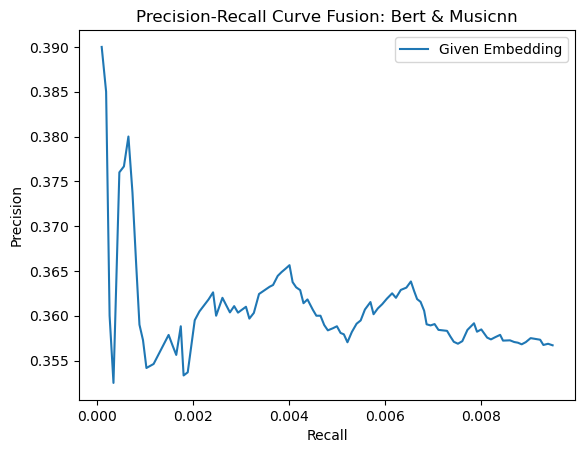

([0.39,
  0.385,
  0.3600000000000001,
  0.3525,
  0.3760000000000001,
  0.37666666666666665,
  0.38,
  0.37375,
  0.3655555555555556,
  0.359,
  0.35727272727272724,
  0.35416666666666663,
  0.35461538461538467,
  0.3578571428571429,
  0.35666666666666663,
  0.355625,
  0.3588235294117647,
  0.35333333333333344,
  0.35368421052631577,
  0.35950000000000004,
  0.36047619047619045,
  0.3618181818181818,
  0.3626086956521739,
  0.3600000000000001,
  0.36200000000000004,
  0.36115384615384605,
  0.3603703703703704,
  0.36107142857142854,
  0.3603448275862069,
  0.36099999999999993,
  0.3596774193548387,
  0.3603125,
  0.3624242424242425,
  0.3632352941176471,
  0.36342857142857143,
  0.3644444444444445,
  0.36486486486486486,
  0.3652631578947369,
  0.3656410256410257,
  0.36375,
  0.3631707317073171,
  0.3628571428571428,
  0.36139534883720936,
  0.36181818181818187,
  0.3606666666666667,
  0.35999999999999993,
  0.36,
  0.3589583333333334,
  0.3583673469387755,
  0.3585999999999999,
  0

In [45]:
calc_avg_recall_precision_fusion(late_fusion_bert_musicnn, k_range, sample_size)

In [ ]:
done